In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1) Loading dataset

In [ ]:
# %cd drive/MyDrive/NLP_Project/project+/
# !ls

In [ ]:
!nvidia-smi

Fri Jul  8 19:02:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 2) Importing libraries

In [ ]:
!pip install transformers
!pip install datasets
!pip install ray[tune]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 4.8 MB/s 
     |████████████████████████████████| 101 kB 10.3 MB/s 
     |████████████████████████████████| 596 kB 66.8 MB/s 
     |████████████████████████████████| 6.6 MB 44.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 4.8 MB/s 
     |████████████████████████████████| 140 kB 66.5 MB/s 
     |████████████████████████████████| 1.1 MB 59.6 MB/s 
     |████████████████████████████████| 212 kB 74.0 MB/s 
     |████████████████████████████████| 127 kB 54.9 MB/s 
     |████████████████████████████████| 271 kB 71.1 MB/s 
     |████████████████████████████████| 144 kB 78.0 MB/s 
     |███████████

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset, Dataset

In [ ]:
aggressions = load_dataset('csv', data_files={'train': 'Aggression_Imbalance_DS.csv'
                                              })
print(aggressions)

Using custom data configuration default-c919a810dd350a40


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-c919a810dd350a40/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Sentence', 'Category'],
        num_rows: 12663
    })
})


In [ ]:
train_ds = aggressions['train']
train_ds

Dataset({
    features: ['Sentence', 'Category'],
    num_rows: 12663
})

## 3) Converting to dataframe

In [ ]:
aggressions.set_format(type='pandas')
df = aggressions['train'][:]
df.head()

Sentence Category
0  what a wicket !!!!!!!!! woohooooo #indvsuae #w...      NAG
1  And because of u people there is a boundary cr...      OAG
2  Arandhuti Roy is a person who do not believe i...      NAG
3  Saurabh Shinde wht does that mean at least he ...      CAG
4  NBCC has a very good order book but will that ...      NAG

In [ ]:
df['Category'].value_counts()

NAG    5602
CAG    4240
OAG    2821
Name: Category, dtype: int64

In [ ]:
# Label encoding
dt = {'NAG':0, 'CAG':1, 'OAG':2}
df['Category'].unique()
labels = map(lambda x: dt[x], df['Category'])
labels = list(labels)
labels = pd.Series(labels)

df['Label'] = labels
labs = np.array(labels)
df.head(5)

Sentence Category  Label
0  what a wicket !!!!!!!!! woohooooo #indvsuae #w...      NAG      0
1  And because of u people there is a boundary cr...      OAG      2
2  Arandhuti Roy is a person who do not believe i...      NAG      0
3  Saurabh Shinde wht does that mean at least he ...      CAG      1
4  NBCC has a very good order book but will that ...      NAG      0

Seeing Distribution

In [ ]:
disb_df = df.copy(deep=True)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


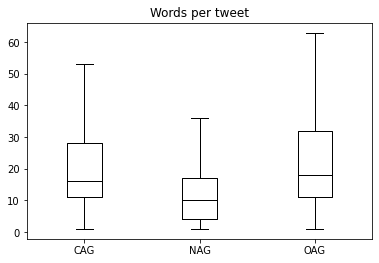

In [ ]:
disb_df['Words per tweet'] = disb_df['Sentence'].str.split().apply(len)
disb_df.boxplot('Words per tweet', by='Category', grid=False, showfliers=False, color='black')
plt.suptitle("")
plt.xlabel("")
plt.show()

## 4) Tokenizing

In [ ]:
from transformers import AutoTokenizer

In [ ]:
model_ckpt = 'l3cube-pune/hing-bert'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/418 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/695k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
tokenizer.vocab_size

30522

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
texts = list(df['Sentence'])
labels = list(df['Label'])

## 5) Splitting into train-valid-test

In [ ]:
train_size=0.8

# In the first step we will split the data in training and remaining dataset
train_texts, X_rem, train_labels, y_rem = train_test_split(texts, labels, train_size=0.8, random_state=43)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
valid_texts, test_texts, valid_labels, test_labels = train_test_split(X_rem, y_rem, test_size=0.5, random_state=43)

print(str(np.shape(train_texts))), print(str(np.shape(train_labels)))
print(str(np.shape(valid_texts))), print(str(np.shape(valid_labels)))
print(str(np.shape(test_texts))), print(str(np.shape(test_labels)))


(10130,)
(10130,)
(1266,)
(1266,)
(1267,)
(1267,)


(None, None)

In [ ]:
# USE this only for hyperparameter tuning
# In this step we will split the train data (10 %) and validation data (20%) only for hyperparameter tuning 


# _texts, hyp_texts, _labels, hyp_labels = train_test_split(train_texts, train_labels, test_size=0.1, random_state=43)
# print(str(np.shape(hyp_texts))), print(str(np.shape(hyp_labels)))

# _texts2, hyp_v_texts, _labels2, hyp_v_labels = train_test_split(valid_texts, valid_labels, test_size=0.2, random_state=43)
# print(str(np.shape(hyp_v_texts))), print(str(np.shape(hyp_v_labels)))

(1013,)
(1013,)
(254,)
(254,)


(None, None)

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True)
# hyp_encodings = tokenizer(hyp_texts, truncation=True, padding=True)
# hyp_v_encodings = tokenizer(hyp_v_texts, truncation=True, padding=True)

In [ ]:
import torch

class AggressionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = AggressionDataset(train_encodings, train_labels)
valid_dataset = AggressionDataset(valid_encodings, valid_labels)
# hyp_dataset = AggressionDataset(hyp_encodings, hyp_labels)
# hyp_v_dataset = AggressionDataset(hyp_v_encodings, hyp_v_labels)

## 6) Fine-tuning

In [ ]:
import torch

In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 3
device = torch.device('cuda' if 
                      torch.cuda.is_available() else 'cpu')
print(device)
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels))

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, plot_confusion_matrix

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  f1 = f1_score(labels, preds, average='macro')
  precision = precision_score(labels, preds, average='macro')
  recall = recall_score(labels, preds, average='macro')
  acc = accuracy_score(labels, preds)
  return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
from transformers import Trainer, TrainingArguments

In [ ]:
# Defining hyperparameters
batch_size = 16
logging_steps = len(train_texts) // batch_size
model_name = f"{model_ckpt}-finetuned-aggression"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=3,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level='error')

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()

 32%|███▏      | 162/508 [02:13<04:45,  1.21it/s]


In [ ]:
from torch import nn

class CustomTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False):
    device = torch.device('cuda')
    inputs.to(device)
    labels = inputs.get("labels")
    # forward pass
    outputs = model(**inputs)
    logits = outputs.get("logits")
    # compute custom loss (suppose one has 3 labels with different weights)
    loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([0.21, 0.33, 0.46]).to(device))
    loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

In [ ]:
trainer = CustomTrainer(model=model, args=training_args,
compute_metrics = compute_metrics,
train_dataset = train_dataset,
eval_dataset = valid_dataset,
tokenizer = tokenizer)

trainer.train()

Cloning https://huggingface.co/SkyR/hing-bert-finetuned-aggression into local empty directory.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


TrainOutput(global_step=1902, training_loss=0.5947030336448196, metrics={'train_runtime': 1662.9592, 'train_samples_per_second': 18.275, 'train_steps_per_second': 1.144, 'total_flos': 7996016764753920.0, 'train_loss': 0.5947030336448196, 'epoch': 3.0})

## 7) Predictions and Results

In [ ]:
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [ ]:
test_dataset = AggressionDataset(test_encodings, test_labels)

In [ ]:
preds_output_test = trainer.predict(test_dataset)

In [ ]:
preds_output_test.metrics

{'test_accuracy': 0.7063930544593529,
 'test_f1': 0.6909008340983588,
 'test_loss': 0.8156566619873047,
 'test_precision': 0.6906756565365325,
 'test_recall': 0.6930486708530914,
 'test_runtime': 21.8151,
 'test_samples_per_second': 58.079,
 'test_steps_per_second': 3.667}

In [ ]:
y_preds_test = np.argmax(preds_output_test.predictions, axis=1)

In [ ]:
y_valid_test = np.array(test_dataset.labels)

In [ ]:
map_dt = {0:'NAG', 1:'CAG', 2:'OAG'}

In [ ]:
print(classification_report(y_valid_test, y_preds_test, target_names=list(map_dt.values())))

              precision    recall  f1-score   support

         NAG       0.86      0.80      0.83       517
         CAG       0.65      0.65      0.65       447
         OAG       0.56      0.63      0.59       303

    accuracy                           0.71      1267
   macro avg       0.69      0.69      0.69      1267
weighted avg       0.71      0.71      0.71      1267



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_valid_trying = map(lambda x : map_dt[x], y_valid_test)
y_valid_trying = list(y_valid_trying)

y_preds_trying = map(lambda x : map_dt[x], y_preds_test)
y_preds_trying = list(y_preds_trying)

cm = confusion_matrix(y_valid_test, y_preds_test)

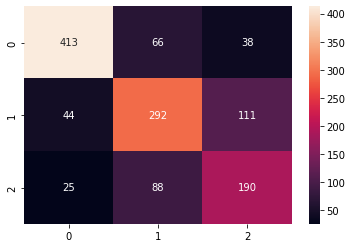

In [ ]:
f = sns.heatmap(cm, annot=True, fmt='d')

## 8) Using hyperparameter tuning with ray tune

##### a) Method 1 (Don't use)

In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [ ]:
def get_my_model():
  num_labels = 3
  device = torch.device('cuda')
  return (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import EarlyStoppingCallback
from transformers import AutoModelForSequenceClassification


model_name = f"{model_ckpt}-finetuned-aggression"

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    output_dir=model_name, 
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    logging_strategy="steps",
    logging_steps=1,
    logging_first_step=False,
    overwrite_output_dir=True,
    save_strategy="epoch",
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
)

trainer = CustomTrainer(
    model_init=get_my_model,
    args=training_args, 
    train_dataset=hyp_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/l3cube-pune/hing-bert/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/d52c8be56cd7426f65f746f8597f9a2955921e2ad53793f8949bd8794e6372ef.ac4c51fbb6396469b4ec05f0bdf5f51204ca04692ad36e8ade986838956c1bd8
Model config BertConfig {
  "_name_or_path": "l3cube-pune/hing-bert",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "eos_token_ids": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range":

In [ ]:
def my_hp_space_ray(trial):
    from ray import tune

    return {
        "learning_rate": tune.loguniform(1e-5, 5e-5),
        "num_train_epochs": tune.choice(range(1, 6)),
        "seed": tune.choice(range(1, 41)),
        "per_device_train_batch_size": tune.choice([8, 16, 32]),
    }

def my_objective(metrics):
    return metrics["eval_f1"]

best_run = trainer.hyperparameter_search(n_trials=4, resources_per_trial={"cpu":0, "gpu":1}, 
                                         direction="maximize", compute_objective=my_objective)

== Status ==
Current time: 2022-07-02 05:37:31 (running for 00:00:00.16)
Memory usage on this node: 5.4/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 |  8.15396 |
| _objective_1174d_00001 | PENDING  |                |     1.56207e-05 |           

(_objective pid=995) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
(_objective pid=995) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=995) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=995) Some weights of BertForSequenceClas

(_objective pid=995) {'loss': 1.0902, 'learning_rate': 5.5939804265365895e-06, 'epoch': 0.02}


  1%|          | 2/320 [00:01<04:50,  1.09it/s]


(_objective pid=995) {'loss': 1.0964, 'learning_rate': 5.576444437738669e-06, 'epoch': 0.03}


  1%|          | 3/320 [00:02<04:38,  1.14it/s]


(_objective pid=995) {'loss': 1.0884, 'learning_rate': 5.558908448940748e-06, 'epoch': 0.05}
== Status ==
Current time: 2022-07-02 05:37:47 (running for 00:00:15.18)
Memory usage on this node: 7.0/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 |  

  2%|▏         | 5/320 [00:04<04:28,  1.17it/s]


(_objective pid=995) {'loss': 1.0995, 'learning_rate': 5.523836471344908e-06, 'epoch': 0.08}


  2%|▏         | 6/320 [00:05<04:25,  1.18it/s]


(_objective pid=995) {'loss': 1.1109, 'learning_rate': 5.506300482546988e-06, 'epoch': 0.09}


  2%|▏         | 7/320 [00:06<04:23,  1.19it/s]


(_objective pid=995) {'loss': 1.0909, 'learning_rate': 5.488764493749067e-06, 'epoch': 0.11}


  2%|▎         | 8/320 [00:06<04:21,  1.19it/s]


(_objective pid=995) {'loss': 1.0927, 'learning_rate': 5.471228504951147e-06, 'epoch': 0.12}


  3%|▎         | 9/320 [00:07<04:20,  1.20it/s]


(_objective pid=995) {'loss': 1.0974, 'learning_rate': 5.453692516153227e-06, 'epoch': 0.14}
== Status ==
Current time: 2022-07-02 05:37:52 (running for 00:00:20.18)
Memory usage on this node: 7.0/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 |  

  3%|▎         | 11/320 [00:09<04:18,  1.20it/s]


(_objective pid=995) {'loss': 1.1096, 'learning_rate': 5.418620538557386e-06, 'epoch': 0.17}


  4%|▍         | 12/320 [00:10<04:17,  1.20it/s]


(_objective pid=995) {'loss': 1.0659, 'learning_rate': 5.401084549759465e-06, 'epoch': 0.19}


  4%|▍         | 13/320 [00:11<04:16,  1.20it/s]


(_objective pid=995) {'loss': 1.0995, 'learning_rate': 5.383548560961545e-06, 'epoch': 0.2}


  4%|▍         | 14/320 [00:11<04:15,  1.20it/s]


(_objective pid=995) {'loss': 1.0628, 'learning_rate': 5.366012572163625e-06, 'epoch': 0.22}


  5%|▍         | 15/320 [00:12<04:13,  1.20it/s]


(_objective pid=995) {'loss': 1.0906, 'learning_rate': 5.348476583365705e-06, 'epoch': 0.23}


  5%|▌         | 16/320 [00:13<04:13,  1.20it/s]


(_objective pid=995) {'loss': 1.0913, 'learning_rate': 5.330940594567784e-06, 'epoch': 0.25}
== Status ==
Current time: 2022-07-02 05:37:57 (running for 00:00:25.19)
Memory usage on this node: 7.0/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 |  

  5%|▌         | 17/320 [00:14<04:12,  1.20it/s]


(_objective pid=995) {'loss': 1.0997, 'learning_rate': 5.313404605769864e-06, 'epoch': 0.27}


  6%|▌         | 18/320 [00:15<04:11,  1.20it/s]


(_objective pid=995) {'loss': 1.1181, 'learning_rate': 5.295868616971943e-06, 'epoch': 0.28}


  6%|▌         | 19/320 [00:16<04:10,  1.20it/s]


(_objective pid=995) {'loss': 1.1008, 'learning_rate': 5.278332628174024e-06, 'epoch': 0.3}


  6%|▋         | 20/320 [00:16<04:09,  1.20it/s]


(_objective pid=995) {'loss': 1.0607, 'learning_rate': 5.260796639376103e-06, 'epoch': 0.31}


  7%|▋         | 21/320 [00:17<04:08,  1.20it/s]


(_objective pid=995) {'loss': 1.0682, 'learning_rate': 5.243260650578183e-06, 'epoch': 0.33}


  7%|▋         | 22/320 [00:18<04:07,  1.20it/s]


(_objective pid=995) {'loss': 1.0803, 'learning_rate': 5.225724661780262e-06, 'epoch': 0.34}
== Status ==
Current time: 2022-07-02 05:38:02 (running for 00:00:30.20)
Memory usage on this node: 7.0/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 |  

  7%|▋         | 23/320 [00:19<04:06,  1.20it/s]


(_objective pid=995) {'loss': 1.0344, 'learning_rate': 5.208188672982341e-06, 'epoch': 0.36}


  8%|▊         | 24/320 [00:20<04:06,  1.20it/s]


(_objective pid=995) {'loss': 1.0755, 'learning_rate': 5.190652684184422e-06, 'epoch': 0.38}


  8%|▊         | 25/320 [00:21<04:05,  1.20it/s]


(_objective pid=995) {'loss': 1.0465, 'learning_rate': 5.173116695386501e-06, 'epoch': 0.39}


  8%|▊         | 26/320 [00:21<04:04,  1.20it/s]


(_objective pid=995) {'loss': 1.1343, 'learning_rate': 5.155580706588581e-06, 'epoch': 0.41}


  8%|▊         | 27/320 [00:22<04:03,  1.20it/s]


(_objective pid=995) {'loss': 1.0828, 'learning_rate': 5.1380447177906605e-06, 'epoch': 0.42}


  9%|▉         | 28/320 [00:23<04:02,  1.20it/s]


(_objective pid=995) {'loss': 1.0322, 'learning_rate': 5.12050872899274e-06, 'epoch': 0.44}
== Status ==
Current time: 2022-07-02 05:38:07 (running for 00:00:35.20)
Memory usage on this node: 7.0/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 |  8

  9%|▉         | 29/320 [00:24<04:01,  1.20it/s]


(_objective pid=995) {'loss': 1.0945, 'learning_rate': 5.10297274019482e-06, 'epoch': 0.45}


  9%|▉         | 30/320 [00:25<04:01,  1.20it/s]


(_objective pid=995) {'loss': 1.0911, 'learning_rate': 5.0854367513969e-06, 'epoch': 0.47}


 10%|▉         | 31/320 [00:26<04:00,  1.20it/s]


(_objective pid=995) {'loss': 1.107, 'learning_rate': 5.067900762598979e-06, 'epoch': 0.48}


 10%|█         | 32/320 [00:26<03:59,  1.20it/s]


(_objective pid=995) {'loss': 1.1149, 'learning_rate': 5.0503647738010585e-06, 'epoch': 0.5}


 10%|█         | 33/320 [00:27<03:58,  1.20it/s]


(_objective pid=995) {'loss': 1.073, 'learning_rate': 5.032828785003138e-06, 'epoch': 0.52}


 11%|█         | 34/320 [00:28<03:57,  1.20it/s]


(_objective pid=995) {'loss': 1.1046, 'learning_rate': 5.015292796205218e-06, 'epoch': 0.53}
== Status ==
Current time: 2022-07-02 05:38:12 (running for 00:00:40.20)
Memory usage on this node: 7.0/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 |  

 11%|█         | 35/320 [00:29<03:56,  1.20it/s]


(_objective pid=995) {'loss': 1.0765, 'learning_rate': 4.997756807407298e-06, 'epoch': 0.55}


 11%|█▏        | 36/320 [00:30<03:56,  1.20it/s]


(_objective pid=995) {'loss': 1.0543, 'learning_rate': 4.980220818609377e-06, 'epoch': 0.56}


 12%|█▏        | 37/320 [00:30<03:55,  1.20it/s]


(_objective pid=995) {'loss': 1.1121, 'learning_rate': 4.962684829811457e-06, 'epoch': 0.58}


 12%|█▏        | 38/320 [00:31<03:54,  1.20it/s]


(_objective pid=995) {'loss': 1.0554, 'learning_rate': 4.945148841013536e-06, 'epoch': 0.59}


 12%|█▏        | 39/320 [00:32<03:54,  1.20it/s]


(_objective pid=995) {'loss': 1.0796, 'learning_rate': 4.927612852215617e-06, 'epoch': 0.61}


 12%|█▎        | 40/320 [00:33<03:52,  1.20it/s]


(_objective pid=995) {'loss': 1.0933, 'learning_rate': 4.910076863417696e-06, 'epoch': 0.62}
== Status ==
Current time: 2022-07-02 05:38:17 (running for 00:00:45.21)
Memory usage on this node: 7.0/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 |  

 13%|█▎        | 41/320 [00:34<03:52,  1.20it/s]


(_objective pid=995) {'loss': 1.0178, 'learning_rate': 4.892540874619776e-06, 'epoch': 0.64}


 13%|█▎        | 42/320 [00:35<03:52,  1.20it/s]


(_objective pid=995) {'loss': 1.1154, 'learning_rate': 4.8750048858218555e-06, 'epoch': 0.66}


 13%|█▎        | 43/320 [00:35<03:50,  1.20it/s]


(_objective pid=995) {'loss': 1.1212, 'learning_rate': 4.857468897023935e-06, 'epoch': 0.67}


 14%|█▍        | 44/320 [00:36<03:49,  1.20it/s]


(_objective pid=995) {'loss': 0.9999, 'learning_rate': 4.839932908226015e-06, 'epoch': 0.69}


 14%|█▍        | 45/320 [00:37<03:48,  1.20it/s]


(_objective pid=995) {'loss': 1.0927, 'learning_rate': 4.822396919428094e-06, 'epoch': 0.7}


 14%|█▍        | 46/320 [00:38<03:47,  1.20it/s]


(_objective pid=995) {'loss': 1.1079, 'learning_rate': 4.804860930630174e-06, 'epoch': 0.72}
== Status ==
Current time: 2022-07-02 05:38:22 (running for 00:00:50.21)
Memory usage on this node: 7.0/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 |  

 15%|█▍        | 47/320 [00:39<03:47,  1.20it/s]


(_objective pid=995) {'loss': 1.061, 'learning_rate': 4.7873249418322535e-06, 'epoch': 0.73}


 15%|█▌        | 48/320 [00:40<03:46,  1.20it/s]


(_objective pid=995) {'loss': 1.0306, 'learning_rate': 4.769788953034333e-06, 'epoch': 0.75}


 15%|█▌        | 49/320 [00:40<03:45,  1.20it/s]


(_objective pid=995) {'loss': 1.0206, 'learning_rate': 4.752252964236413e-06, 'epoch': 0.77}


 16%|█▌        | 50/320 [00:41<03:44,  1.20it/s]


(_objective pid=995) {'loss': 1.1249, 'learning_rate': 4.734716975438493e-06, 'epoch': 0.78}


 16%|█▌        | 51/320 [00:42<03:43,  1.20it/s]


(_objective pid=995) {'loss': 1.085, 'learning_rate': 4.717180986640572e-06, 'epoch': 0.8}


 16%|█▋        | 52/320 [00:43<03:43,  1.20it/s]


(_objective pid=995) {'loss': 1.1133, 'learning_rate': 4.6996449978426524e-06, 'epoch': 0.81}
== Status ==
Current time: 2022-07-02 05:38:27 (running for 00:00:55.22)
Memory usage on this node: 7.0/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 | 

 17%|█▋        | 53/320 [00:44<03:42,  1.20it/s]


(_objective pid=995) {'loss': 1.0698, 'learning_rate': 4.682109009044731e-06, 'epoch': 0.83}


 17%|█▋        | 54/320 [00:45<03:40,  1.20it/s]


(_objective pid=995) {'loss': 1.0547, 'learning_rate': 4.664573020246811e-06, 'epoch': 0.84}


 17%|█▋        | 55/320 [00:45<03:40,  1.20it/s]


(_objective pid=995) {'loss': 1.0789, 'learning_rate': 4.647037031448891e-06, 'epoch': 0.86}


 18%|█▊        | 56/320 [00:46<03:39,  1.20it/s]


(_objective pid=995) {'loss': 1.0968, 'learning_rate': 4.62950104265097e-06, 'epoch': 0.88}


 18%|█▊        | 57/320 [00:47<03:38,  1.20it/s]


(_objective pid=995) {'loss': 1.0198, 'learning_rate': 4.6119650538530505e-06, 'epoch': 0.89}


 18%|█▊        | 58/320 [00:48<03:38,  1.20it/s]


(_objective pid=995) {'loss': 1.0738, 'learning_rate': 4.5944290650551294e-06, 'epoch': 0.91}
== Status ==
Current time: 2022-07-02 05:38:32 (running for 00:01:00.22)
Memory usage on this node: 7.0/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 | 

 18%|█▊        | 59/320 [00:49<03:37,  1.20it/s]


(_objective pid=995) {'loss': 1.0483, 'learning_rate': 4.57689307625721e-06, 'epoch': 0.92}


 19%|█▉        | 60/320 [00:50<03:36,  1.20it/s]


(_objective pid=995) {'loss': 0.994, 'learning_rate': 4.559357087459289e-06, 'epoch': 0.94}


 19%|█▉        | 61/320 [00:50<03:35,  1.20it/s]


(_objective pid=995) {'loss': 1.0606, 'learning_rate': 4.541821098661369e-06, 'epoch': 0.95}


 19%|█▉        | 62/320 [00:51<03:34,  1.20it/s]


(_objective pid=995) {'loss': 1.0689, 'learning_rate': 4.5242851098634486e-06, 'epoch': 0.97}


 20%|█▉        | 63/320 [00:52<03:33,  1.20it/s]


(_objective pid=995) {'loss': 1.0836, 'learning_rate': 4.506749121065528e-06, 'epoch': 0.98}


 20%|██        | 64/320 [00:52<02:54,  1.47it/s]


(_objective pid=995) {'loss': 1.0735, 'learning_rate': 4.489213132267608e-06, 'epoch': 1.0}


(_objective pid=995) 
  0%|          | 0/80 [00:00<?, ?it/s]
(_objective pid=995) 
  2%|▎         | 2/80 [00:00<00:10,  7.43it/s]


== Status ==
Current time: 2022-07-02 05:38:37 (running for 00:01:05.23)
Memory usage on this node: 7.0/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 |  8.15396 |
| _objective_1174d_00001 | PENDING  |                |     1.56207e-05 |           

(_objective pid=995) 
  4%|▍         | 3/80 [00:00<00:14,  5.26it/s]
(_objective pid=995) 
  5%|▌         | 4/80 [00:00<00:16,  4.55it/s]
(_objective pid=995) 
  6%|▋         | 5/80 [00:01<00:17,  4.22it/s]
(_objective pid=995) 
  8%|▊         | 6/80 [00:01<00:18,  4.04it/s]
(_objective pid=995) 
  9%|▉         | 7/80 [00:01<00:18,  3.94it/s]
(_objective pid=995) 
 10%|█         | 8/80 [00:01<00:18,  3.87it/s]
(_objective pid=995) 
 11%|█▏        | 9/80 [00:02<00:18,  3.82it/s]
(_objective pid=995) 
 12%|█▎        | 10/80 [00:02<00:18,  3.79it/s]
(_objective pid=995) 
 14%|█▍        | 11/80 [00:02<00:18,  3.77it/s]
(_objective pid=995) 
 15%|█▌        | 12/80 [00:02<00:18,  3.75it/s]
(_objective pid=995) 
 16%|█▋        | 13/80 [00:03<00:17,  3.74it/s]
(_objective pid=995) 
 18%|█▊        | 14/80 [00:03<00:17,  3.73it/s]
(_objective pid=995) 
 19%|█▉        | 15/80 [00:03<00:17,  3.72it/s]
(_objective pid=995) 
 20%|██        | 16/80 [00:04<00:17,  3.72it/s]
(_objective pid=995) 
 21%|

== Status ==
Current time: 2022-07-02 05:38:42 (running for 00:01:10.24)
Memory usage on this node: 7.0/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 |  8.15396 |
| _objective_1174d_00001 | PENDING  |                |     1.56207e-05 |           

(_objective pid=995) 
 28%|██▊       | 22/80 [00:05<00:15,  3.71it/s]
(_objective pid=995) 
 29%|██▉       | 23/80 [00:05<00:15,  3.72it/s]
(_objective pid=995) 
 30%|███       | 24/80 [00:06<00:15,  3.72it/s]
(_objective pid=995) 
 31%|███▏      | 25/80 [00:06<00:14,  3.72it/s]
(_objective pid=995) 
 32%|███▎      | 26/80 [00:06<00:14,  3.72it/s]
(_objective pid=995) 
 34%|███▍      | 27/80 [00:06<00:14,  3.72it/s]
(_objective pid=995) 
 35%|███▌      | 28/80 [00:07<00:13,  3.72it/s]
(_objective pid=995) 
 36%|███▋      | 29/80 [00:07<00:13,  3.72it/s]
(_objective pid=995) 
 38%|███▊      | 30/80 [00:07<00:13,  3.72it/s]
(_objective pid=995) 
 39%|███▉      | 31/80 [00:08<00:13,  3.72it/s]
(_objective pid=995) 
 40%|████      | 32/80 [00:08<00:12,  3.71it/s]
(_objective pid=995) 
 41%|████▏     | 33/80 [00:08<00:12,  3.72it/s]
(_objective pid=995) 
 42%|████▎     | 34/80 [00:08<00:12,  3.72it/s]
(_objective pid=995) 
 44%|████▍     | 35/80 [00:09<00:12,  3.72it/s]
(_objective pid=995)

== Status ==
Current time: 2022-07-02 05:38:47 (running for 00:01:15.24)
Memory usage on this node: 7.0/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 |  8.15396 |
| _objective_1174d_00001 | PENDING  |                |     1.56207e-05 |           

(_objective pid=995) 
 50%|█████     | 40/80 [00:10<00:10,  3.72it/s]
(_objective pid=995) 
 51%|█████▏    | 41/80 [00:10<00:10,  3.72it/s]
(_objective pid=995) 
 52%|█████▎    | 42/80 [00:11<00:10,  3.72it/s]
(_objective pid=995) 
 54%|█████▍    | 43/80 [00:11<00:09,  3.72it/s]
(_objective pid=995) 
 55%|█████▌    | 44/80 [00:11<00:09,  3.72it/s]
(_objective pid=995) 
 56%|█████▋    | 45/80 [00:11<00:09,  3.72it/s]
(_objective pid=995) 
 57%|█████▊    | 46/80 [00:12<00:09,  3.72it/s]
(_objective pid=995) 
 59%|█████▉    | 47/80 [00:12<00:08,  3.73it/s]
(_objective pid=995) 
 60%|██████    | 48/80 [00:12<00:08,  3.73it/s]
(_objective pid=995) 
 61%|██████▏   | 49/80 [00:12<00:08,  3.72it/s]
(_objective pid=995) 
 62%|██████▎   | 50/80 [00:13<00:08,  3.72it/s]
(_objective pid=995) 
 64%|██████▍   | 51/80 [00:13<00:07,  3.72it/s]
(_objective pid=995) 
 65%|██████▌   | 52/80 [00:13<00:07,  3.73it/s]
(_objective pid=995) 
 66%|██████▋   | 53/80 [00:13<00:07,  3.72it/s]
(_objective pid=995)

== Status ==
Current time: 2022-07-02 05:38:52 (running for 00:01:20.25)
Memory usage on this node: 7.0/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 |  8.15396 |
| _objective_1174d_00001 | PENDING  |                |     1.56207e-05 |           

(_objective pid=995) 
 74%|███████▍  | 59/80 [00:15<00:05,  3.71it/s]
(_objective pid=995) 
 75%|███████▌  | 60/80 [00:15<00:05,  3.70it/s]
(_objective pid=995) 
 76%|███████▋  | 61/80 [00:16<00:05,  3.71it/s]
(_objective pid=995) 
 78%|███████▊  | 62/80 [00:16<00:04,  3.71it/s]
(_objective pid=995) 
 79%|███████▉  | 63/80 [00:16<00:04,  3.71it/s]
(_objective pid=995) 
 80%|████████  | 64/80 [00:16<00:04,  3.71it/s]
(_objective pid=995) 
 81%|████████▏ | 65/80 [00:17<00:04,  3.72it/s]
(_objective pid=995) 
 82%|████████▎ | 66/80 [00:17<00:03,  3.72it/s]
(_objective pid=995) 
 84%|████████▍ | 67/80 [00:17<00:03,  3.71it/s]
(_objective pid=995) 
 85%|████████▌ | 68/80 [00:18<00:03,  3.71it/s]
(_objective pid=995) 
 86%|████████▋ | 69/80 [00:18<00:02,  3.72it/s]
(_objective pid=995) 
 88%|████████▊ | 70/80 [00:18<00:02,  3.71it/s]
(_objective pid=995) 
 89%|████████▉ | 71/80 [00:18<00:02,  3.70it/s]
(_objective pid=995) 
 90%|█████████ | 72/80 [00:19<00:02,  3.71it/s]
(_objective pid=995)

== Status ==
Current time: 2022-07-02 05:38:57 (running for 00:01:25.25)
Memory usage on this node: 7.0/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 |  8.15396 |
| _objective_1174d_00001 | PENDING  |                |     1.56207e-05 |           

(_objective pid=995) 
 96%|█████████▋| 77/80 [00:20<00:00,  3.71it/s]
(_objective pid=995) 
 98%|█████████▊| 78/80 [00:20<00:00,  3.72it/s]
(_objective pid=995) 
 99%|█████████▉| 79/80 [00:20<00:00,  3.72it/s]
                                                
100%|██████████| 80/80 [00:21<00:00,  3.72it/s]
                                               


Result for _objective_1174d_00000:
  date: 2022-07-02_05-38-57
  done: false
  epoch: 1.0
  eval_accuracy: 0.382306477093207
  eval_f1: 0.24475143415540768
  eval_loss: 1.0567618608474731
  eval_precision: 0.6651827478978397
  eval_recall: 0.3648589853972797
  eval_runtime: 21.2999
  eval_samples_per_second: 59.437
  eval_steps_per_second: 3.756
  experiment_id: 97748b1b25244074ae3a6ac9aaa3a5d2
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.24475143415540768
  pid: 995
  time_since_restore: 80.69224452972412
  time_this_iter_s: 80.69224452972412
  time_total_s: 80.69224452972412
  timestamp: 1656740337
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1174d_00000
  warmup_time: 0.0038230419158935547
  
(_objective pid=995) {'eval_loss': 1.0567618608474731, 'eval_accuracy': 0.382306477093207, 'eval_f1': 0.24475143415540768, 'eval_precision': 0.6651827478978397, 'eval_recall': 0.3648589853972797, 'eval_runtime': 21.2999, 'eval_s

 21%|██        | 66/320 [01:20<25:55,  6.13s/it]


(_objective pid=995) {'loss': 1.1297, 'learning_rate': 4.454141154671767e-06, 'epoch': 1.03}


 21%|██        | 67/320 [01:21<19:08,  4.54s/it]


(_objective pid=995) {'loss': 1.0391, 'learning_rate': 4.436605165873847e-06, 'epoch': 1.05}


 21%|██▏       | 68/320 [01:21<14:23,  3.42s/it]


(_objective pid=995) {'loss': 1.0103, 'learning_rate': 4.419069177075926e-06, 'epoch': 1.06}


 22%|██▏       | 69/320 [01:22<11:04,  2.65s/it]


(_objective pid=995) {'loss': 1.1045, 'learning_rate': 4.401533188278006e-06, 'epoch': 1.08}


 22%|██▏       | 70/320 [01:23<08:45,  2.10s/it]


(_objective pid=995) {'loss': 1.031, 'learning_rate': 4.383997199480086e-06, 'epoch': 1.09}
== Status ==
Current time: 2022-07-02 05:39:07 (running for 00:01:35.88)
Memory usage on this node: 7.0/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |              

 22%|██▎       | 72/320 [01:25<06:00,  1.46s/it]


(_objective pid=995) {'loss': 1.0264, 'learning_rate': 4.3489252218842455e-06, 'epoch': 1.12}


 23%|██▎       | 73/320 [01:26<05:14,  1.27s/it]


(_objective pid=995) {'loss': 0.9907, 'learning_rate': 4.3313892330863245e-06, 'epoch': 1.14}


 23%|██▎       | 74/320 [01:26<04:40,  1.14s/it]


(_objective pid=995) {'loss': 1.0488, 'learning_rate': 4.313853244288404e-06, 'epoch': 1.16}


 23%|██▎       | 75/320 [01:27<04:17,  1.05s/it]


(_objective pid=995) {'loss': 0.9742, 'learning_rate': 4.296317255490484e-06, 'epoch': 1.17}


 24%|██▍       | 76/320 [01:28<04:00,  1.01it/s]


(_objective pid=995) {'loss': 1.041, 'learning_rate': 4.278781266692564e-06, 'epoch': 1.19}
== Status ==
Current time: 2022-07-02 05:39:12 (running for 00:01:40.89)
Memory usage on this node: 7.0/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |              

 24%|██▍       | 78/320 [01:30<03:39,  1.10it/s]


(_objective pid=995) {'loss': 1.0624, 'learning_rate': 4.2437092890967225e-06, 'epoch': 1.22}


 25%|██▍       | 79/320 [01:31<03:33,  1.13it/s]


(_objective pid=995) {'loss': 1.0352, 'learning_rate': 4.226173300298803e-06, 'epoch': 1.23}


 25%|██▌       | 80/320 [01:31<03:28,  1.15it/s]


(_objective pid=995) {'loss': 1.0461, 'learning_rate': 4.208637311500882e-06, 'epoch': 1.25}


 25%|██▌       | 81/320 [01:32<03:24,  1.17it/s]


(_objective pid=995) {'loss': 0.9889, 'learning_rate': 4.191101322702962e-06, 'epoch': 1.27}


 26%|██▌       | 82/320 [01:33<03:22,  1.17it/s]


(_objective pid=995) {'loss': 0.9825, 'learning_rate': 4.173565333905042e-06, 'epoch': 1.28}
== Status ==
Current time: 2022-07-02 05:39:17 (running for 00:01:45.90)
Memory usage on this node: 7.0/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |             

 26%|██▋       | 84/320 [01:35<03:18,  1.19it/s]


(_objective pid=995) {'loss': 1.0146, 'learning_rate': 4.138493356309201e-06, 'epoch': 1.31}


 27%|██▋       | 85/320 [01:36<03:17,  1.19it/s]


(_objective pid=995) {'loss': 0.9666, 'learning_rate': 4.120957367511281e-06, 'epoch': 1.33}


 27%|██▋       | 86/320 [01:36<03:15,  1.20it/s]


(_objective pid=995) {'loss': 1.0912, 'learning_rate': 4.10342137871336e-06, 'epoch': 1.34}


 27%|██▋       | 87/320 [01:37<03:14,  1.20it/s]


(_objective pid=995) {'loss': 1.0365, 'learning_rate': 4.08588538991544e-06, 'epoch': 1.36}


 28%|██▊       | 88/320 [01:38<03:13,  1.20it/s]


(_objective pid=995) {'loss': 1.0488, 'learning_rate': 4.0683494011175195e-06, 'epoch': 1.38}
== Status ==
Current time: 2022-07-02 05:39:22 (running for 00:01:50.90)
Memory usage on this node: 7.0/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |            

 28%|██▊       | 90/320 [01:40<03:12,  1.20it/s]


(_objective pid=995) {'loss': 1.0126, 'learning_rate': 4.033277423521679e-06, 'epoch': 1.41}


 28%|██▊       | 91/320 [01:41<03:10,  1.20it/s]


(_objective pid=995) {'loss': 1.0144, 'learning_rate': 4.015741434723758e-06, 'epoch': 1.42}


 29%|██▉       | 92/320 [01:41<03:10,  1.20it/s]


(_objective pid=995) {'loss': 0.9883, 'learning_rate': 3.998205445925839e-06, 'epoch': 1.44}


 29%|██▉       | 93/320 [01:42<03:09,  1.20it/s]


(_objective pid=995) {'loss': 0.9296, 'learning_rate': 3.9806694571279176e-06, 'epoch': 1.45}


 29%|██▉       | 94/320 [01:43<03:08,  1.20it/s]


(_objective pid=995) {'loss': 1.0315, 'learning_rate': 3.963133468329997e-06, 'epoch': 1.47}
== Status ==
Current time: 2022-07-02 05:39:27 (running for 00:01:55.91)
Memory usage on this node: 7.0/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |             

 30%|███       | 96/320 [01:45<03:06,  1.20it/s]


(_objective pid=995) {'loss': 1.0006, 'learning_rate': 3.928061490734157e-06, 'epoch': 1.5}


 30%|███       | 97/320 [01:46<03:05,  1.20it/s]


(_objective pid=995) {'loss': 1.0288, 'learning_rate': 3.910525501936237e-06, 'epoch': 1.52}


 31%|███       | 98/320 [01:46<03:04,  1.20it/s]


(_objective pid=995) {'loss': 0.9227, 'learning_rate': 3.892989513138316e-06, 'epoch': 1.53}


 31%|███       | 99/320 [01:47<03:03,  1.20it/s]


(_objective pid=995) {'loss': 1.0611, 'learning_rate': 3.875453524340396e-06, 'epoch': 1.55}


 31%|███▏      | 100/320 [01:48<03:03,  1.20it/s]


(_objective pid=995) {'loss': 0.9361, 'learning_rate': 3.857917535542475e-06, 'epoch': 1.56}
== Status ==
Current time: 2022-07-02 05:39:32 (running for 00:02:00.91)
Memory usage on this node: 7.0/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |             

 32%|███▏      | 102/320 [01:50<03:01,  1.20it/s]


(_objective pid=995) {'loss': 1.0003, 'learning_rate': 3.822845557946635e-06, 'epoch': 1.59}


 32%|███▏      | 103/320 [01:51<03:00,  1.20it/s]


(_objective pid=995) {'loss': 0.9635, 'learning_rate': 3.805309569148714e-06, 'epoch': 1.61}


 32%|███▎      | 104/320 [01:51<02:59,  1.20it/s]


(_objective pid=995) {'loss': 0.9891, 'learning_rate': 3.7877735803507943e-06, 'epoch': 1.62}


 33%|███▎      | 105/320 [01:52<02:58,  1.20it/s]


(_objective pid=995) {'loss': 0.9494, 'learning_rate': 3.7702375915528737e-06, 'epoch': 1.64}


 33%|███▎      | 106/320 [01:53<02:58,  1.20it/s]


(_objective pid=995) {'loss': 0.9868, 'learning_rate': 3.752701602754953e-06, 'epoch': 1.66}
== Status ==
Current time: 2022-07-02 05:39:37 (running for 00:02:05.92)
Memory usage on this node: 7.0/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |             

 34%|███▍      | 108/320 [01:55<02:57,  1.20it/s]


(_objective pid=995) {'loss': 1.0442, 'learning_rate': 3.7176296251591126e-06, 'epoch': 1.69}


 34%|███▍      | 109/320 [01:56<02:56,  1.20it/s]


(_objective pid=995) {'loss': 1.02, 'learning_rate': 3.700093636361193e-06, 'epoch': 1.7}


 34%|███▍      | 110/320 [01:56<02:55,  1.20it/s]


(_objective pid=995) {'loss': 1.0512, 'learning_rate': 3.682557647563272e-06, 'epoch': 1.72}


 35%|███▍      | 111/320 [01:57<02:54,  1.20it/s]


(_objective pid=995) {'loss': 0.9383, 'learning_rate': 3.6650216587653515e-06, 'epoch': 1.73}


 35%|███▌      | 112/320 [01:58<02:53,  1.20it/s]


(_objective pid=995) {'loss': 0.9336, 'learning_rate': 3.6474856699674313e-06, 'epoch': 1.75}
== Status ==
Current time: 2022-07-02 05:39:42 (running for 00:02:10.93)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |            

 36%|███▌      | 114/320 [02:00<02:51,  1.20it/s]


(_objective pid=995) {'loss': 0.8964, 'learning_rate': 3.612413692371591e-06, 'epoch': 1.78}


 36%|███▌      | 115/320 [02:01<02:50,  1.20it/s]


(_objective pid=995) {'loss': 0.9141, 'learning_rate': 3.59487770357367e-06, 'epoch': 1.8}


 36%|███▋      | 116/320 [02:01<02:49,  1.20it/s]


(_objective pid=995) {'loss': 1.0318, 'learning_rate': 3.5773417147757496e-06, 'epoch': 1.81}


 37%|███▋      | 117/320 [02:02<02:49,  1.20it/s]


(_objective pid=995) {'loss': 0.9849, 'learning_rate': 3.5598057259778298e-06, 'epoch': 1.83}


 37%|███▋      | 118/320 [02:03<02:48,  1.20it/s]


(_objective pid=995) {'loss': 0.9914, 'learning_rate': 3.542269737179909e-06, 'epoch': 1.84}
== Status ==
Current time: 2022-07-02 05:39:47 (running for 00:02:15.94)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |             

 38%|███▊      | 120/320 [02:05<02:46,  1.20it/s]


(_objective pid=995) {'loss': 0.9288, 'learning_rate': 3.5071977595840687e-06, 'epoch': 1.88}


 38%|███▊      | 121/320 [02:06<02:45,  1.20it/s]


(_objective pid=995) {'loss': 1.0819, 'learning_rate': 3.489661770786148e-06, 'epoch': 1.89}


 38%|███▊      | 122/320 [02:06<02:44,  1.20it/s]


(_objective pid=995) {'loss': 0.9866, 'learning_rate': 3.472125781988228e-06, 'epoch': 1.91}


 38%|███▊      | 123/320 [02:07<02:43,  1.20it/s]


(_objective pid=995) {'loss': 0.9651, 'learning_rate': 3.4545897931903076e-06, 'epoch': 1.92}


 39%|███▉      | 124/320 [02:08<02:42,  1.20it/s]


(_objective pid=995) {'loss': 0.9082, 'learning_rate': 3.4370538043923874e-06, 'epoch': 1.94}
== Status ==
Current time: 2022-07-02 05:39:52 (running for 00:02:20.94)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |            

 39%|███▉      | 126/320 [02:10<02:41,  1.20it/s]


(_objective pid=995) {'loss': 0.9312, 'learning_rate': 3.401981826796546e-06, 'epoch': 1.97}


 40%|███▉      | 127/320 [02:11<02:40,  1.20it/s]


(_objective pid=995) {'loss': 0.9869, 'learning_rate': 3.3844458379986263e-06, 'epoch': 1.98}


 40%|████      | 128/320 [02:11<02:10,  1.47it/s]


(_objective pid=995) {'loss': 1.076, 'learning_rate': 3.3669098492007057e-06, 'epoch': 2.0}


(_objective pid=995) 
  0%|          | 0/80 [00:00<?, ?it/s]
(_objective pid=995) 
  2%|▎         | 2/80 [00:00<00:10,  7.42it/s]
(_objective pid=995) 
  4%|▍         | 3/80 [00:00<00:14,  5.26it/s]
(_objective pid=995) 
  5%|▌         | 4/80 [00:00<00:16,  4.56it/s]
(_objective pid=995) 
  6%|▋         | 5/80 [00:01<00:17,  4.22it/s]
(_objective pid=995) 
  8%|▊         | 6/80 [00:01<00:18,  4.04it/s]
(_objective pid=995) 
  9%|▉         | 7/80 [00:01<00:18,  3.93it/s]
(_objective pid=995) 
 10%|█         | 8/80 [00:01<00:18,  3.86it/s]
(_objective pid=995) 
 11%|█▏        | 9/80 [00:02<00:18,  3.80it/s]
(_objective pid=995) 
 12%|█▎        | 10/80 [00:02<00:18,  3.77it/s]
(_objective pid=995) 
 14%|█▍        | 11/80 [00:02<00:18,  3.76it/s]


== Status ==
Current time: 2022-07-02 05:39:57 (running for 00:02:25.95)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 |  8.15396 |    0.244751 |
| _objective_1174d_00001 | 

(_objective pid=995) 
 15%|█▌        | 12/80 [00:02<00:18,  3.75it/s]
(_objective pid=995) 
 16%|█▋        | 13/80 [00:03<00:17,  3.74it/s]
(_objective pid=995) 
 18%|█▊        | 14/80 [00:03<00:17,  3.73it/s]
(_objective pid=995) 
 19%|█▉        | 15/80 [00:03<00:17,  3.72it/s]
(_objective pid=995) 
 20%|██        | 16/80 [00:04<00:17,  3.71it/s]
(_objective pid=995) 
 21%|██▏       | 17/80 [00:04<00:16,  3.71it/s]
(_objective pid=995) 
 22%|██▎       | 18/80 [00:04<00:16,  3.71it/s]
(_objective pid=995) 
 24%|██▍       | 19/80 [00:04<00:16,  3.71it/s]
(_objective pid=995) 
 25%|██▌       | 20/80 [00:05<00:16,  3.70it/s]
(_objective pid=995) 
 26%|██▋       | 21/80 [00:05<00:15,  3.70it/s]
(_objective pid=995) 
 28%|██▊       | 22/80 [00:05<00:15,  3.71it/s]
(_objective pid=995) 
 29%|██▉       | 23/80 [00:05<00:15,  3.71it/s]
(_objective pid=995) 
 30%|███       | 24/80 [00:06<00:15,  3.70it/s]
(_objective pid=995) 
 31%|███▏      | 25/80 [00:06<00:14,  3.70it/s]
(_objective pid=995)

== Status ==
Current time: 2022-07-02 05:40:02 (running for 00:02:30.96)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 |  8.15396 |    0.244751 |
| _objective_1174d_00001 | 

(_objective pid=995) 
 38%|███▊      | 30/80 [00:07<00:13,  3.71it/s]
(_objective pid=995) 
 39%|███▉      | 31/80 [00:08<00:13,  3.71it/s]
(_objective pid=995) 
 40%|████      | 32/80 [00:08<00:12,  3.72it/s]
(_objective pid=995) 
 41%|████▏     | 33/80 [00:08<00:12,  3.72it/s]
(_objective pid=995) 
 42%|████▎     | 34/80 [00:08<00:12,  3.71it/s]
(_objective pid=995) 
 44%|████▍     | 35/80 [00:09<00:12,  3.71it/s]
(_objective pid=995) 
 45%|████▌     | 36/80 [00:09<00:11,  3.71it/s]
(_objective pid=995) 
 46%|████▋     | 37/80 [00:09<00:11,  3.71it/s]
(_objective pid=995) 
 48%|████▊     | 38/80 [00:09<00:11,  3.72it/s]
(_objective pid=995) 
 49%|████▉     | 39/80 [00:10<00:11,  3.71it/s]
(_objective pid=995) 
 50%|█████     | 40/80 [00:10<00:10,  3.71it/s]
(_objective pid=995) 
 51%|█████▏    | 41/80 [00:10<00:10,  3.71it/s]
(_objective pid=995) 
 52%|█████▎    | 42/80 [00:11<00:10,  3.71it/s]
(_objective pid=995) 
 54%|█████▍    | 43/80 [00:11<00:09,  3.71it/s]
(_objective pid=995)

== Status ==
Current time: 2022-07-02 05:40:07 (running for 00:02:35.96)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 |  8.15396 |    0.244751 |
| _objective_1174d_00001 | 

(_objective pid=995) 
 61%|██████▏   | 49/80 [00:12<00:08,  3.72it/s]
(_objective pid=995) 
 62%|██████▎   | 50/80 [00:13<00:08,  3.71it/s]
(_objective pid=995) 
 64%|██████▍   | 51/80 [00:13<00:07,  3.71it/s]
(_objective pid=995) 
 65%|██████▌   | 52/80 [00:13<00:07,  3.72it/s]
(_objective pid=995) 
 66%|██████▋   | 53/80 [00:14<00:07,  3.72it/s]
(_objective pid=995) 
 68%|██████▊   | 54/80 [00:14<00:06,  3.71it/s]
(_objective pid=995) 
 69%|██████▉   | 55/80 [00:14<00:06,  3.71it/s]
(_objective pid=995) 
 70%|███████   | 56/80 [00:14<00:06,  3.71it/s]
(_objective pid=995) 
 71%|███████▏  | 57/80 [00:15<00:06,  3.71it/s]
(_objective pid=995) 
 72%|███████▎  | 58/80 [00:15<00:05,  3.71it/s]
(_objective pid=995) 
 74%|███████▍  | 59/80 [00:15<00:05,  3.71it/s]
(_objective pid=995) 
 75%|███████▌  | 60/80 [00:15<00:05,  3.71it/s]
(_objective pid=995) 
 76%|███████▋  | 61/80 [00:16<00:05,  3.70it/s]
(_objective pid=995) 
 78%|███████▊  | 62/80 [00:16<00:04,  3.70it/s]
(_objective pid=995)

== Status ==
Current time: 2022-07-02 05:40:12 (running for 00:02:40.97)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 |  8.15396 |    0.244751 |
| _objective_1174d_00001 | 

(_objective pid=995) 
 84%|████████▍ | 67/80 [00:17<00:03,  3.72it/s]
(_objective pid=995) 
 85%|████████▌ | 68/80 [00:18<00:03,  3.72it/s]
(_objective pid=995) 
 86%|████████▋ | 69/80 [00:18<00:02,  3.71it/s]
(_objective pid=995) 
 88%|████████▊ | 70/80 [00:18<00:02,  3.71it/s]
(_objective pid=995) 
 89%|████████▉ | 71/80 [00:18<00:02,  3.71it/s]
(_objective pid=995) 
 90%|█████████ | 72/80 [00:19<00:02,  3.70it/s]
(_objective pid=995) 
 91%|█████████▏| 73/80 [00:19<00:01,  3.70it/s]
(_objective pid=995) 
 92%|█████████▎| 74/80 [00:19<00:01,  3.71it/s]
(_objective pid=995) 
 94%|█████████▍| 75/80 [00:19<00:01,  3.70it/s]
(_objective pid=995) 
 95%|█████████▌| 76/80 [00:20<00:01,  3.70it/s]
(_objective pid=995) 
 96%|█████████▋| 77/80 [00:20<00:00,  3.71it/s]
(_objective pid=995) 
 98%|█████████▊| 78/80 [00:20<00:00,  3.71it/s]


Result for _objective_1174d_00000:
  date: 2022-07-02_05-40-16
  done: false
  epoch: 2.0
  eval_accuracy: 0.584518167456556
  eval_f1: 0.5184683418017894
  eval_loss: 0.9678251147270203
  eval_precision: 0.5926317805694498
  eval_recall: 0.5355009608029945
  eval_runtime: 21.3289
  eval_samples_per_second: 59.356
  eval_steps_per_second: 3.751
  experiment_id: 97748b1b25244074ae3a6ac9aaa3a5d2
  hostname: 16a52dc3130e
  iterations_since_restore: 2
  node_ip: 172.28.0.2
  objective: 0.5184683418017894
  pid: 995
  time_since_restore: 159.1054015159607
  time_this_iter_s: 78.41315698623657
  time_total_s: 159.1054015159607
  timestamp: 1656740416
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 1174d_00000
  warmup_time: 0.0038230419158935547
  
(_objective pid=995) {'eval_loss': 0.9678251147270203, 'eval_accuracy': 0.584518167456556, 'eval_f1': 0.5184683418017894, 'eval_precision': 0.5926317805694498, 'eval_recall': 0.5355009608029945, 'eval_runtime': 21.3289, 'eval_samp

(_objective pid=995) 
                                                 
100%|██████████| 80/80 [00:21<00:00,  3.71it/s]
                                               


== Status ==
Current time: 2022-07-02 05:40:21 (running for 00:02:49.28)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 |  8.15396 |    0.518468 |
| _objective_1174d_00001 | 

 40%|████      | 129/320 [02:37<26:51,  8.44s/it]


(_objective pid=995) {'loss': 0.9937, 'learning_rate': 3.349373860402786e-06, 'epoch': 2.02}


 41%|████      | 130/320 [02:38<19:29,  6.15s/it]


(_objective pid=995) {'loss': 0.9663, 'learning_rate': 3.3318378716048652e-06, 'epoch': 2.03}


 41%|████      | 131/320 [02:39<14:21,  4.56s/it]


(_objective pid=995) {'loss': 0.8533, 'learning_rate': 3.3143018828069446e-06, 'epoch': 2.05}


 41%|████▏     | 132/320 [02:40<10:46,  3.44s/it]


(_objective pid=995) {'loss': 0.9309, 'learning_rate': 3.296765894009025e-06, 'epoch': 2.06}


 42%|████▏     | 133/320 [02:41<08:17,  2.66s/it]


(_objective pid=995) {'loss': 0.9002, 'learning_rate': 3.279229905211104e-06, 'epoch': 2.08}


 42%|████▏     | 134/320 [02:42<06:32,  2.11s/it]


(_objective pid=995) {'loss': 0.882, 'learning_rate': 3.261693916413184e-06, 'epoch': 2.09}
== Status ==
Current time: 2022-07-02 05:40:26 (running for 00:02:54.30)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |              

 42%|████▎     | 136/320 [02:43<04:28,  1.46s/it]


(_objective pid=995) {'loss': 0.9251, 'learning_rate': 3.2266219388173427e-06, 'epoch': 2.12}


 43%|████▎     | 137/320 [02:44<03:52,  1.27s/it]


(_objective pid=995) {'loss': 1.0191, 'learning_rate': 3.209085950019423e-06, 'epoch': 2.14}


 43%|████▎     | 138/320 [02:45<03:26,  1.14s/it]


(_objective pid=995) {'loss': 0.8768, 'learning_rate': 3.1915499612215022e-06, 'epoch': 2.16}


 43%|████▎     | 139/320 [02:46<03:09,  1.05s/it]


(_objective pid=995) {'loss': 0.989, 'learning_rate': 3.1740139724235824e-06, 'epoch': 2.17}


 44%|████▍     | 140/320 [02:47<02:56,  1.02it/s]


(_objective pid=995) {'loss': 0.827, 'learning_rate': 3.1564779836256618e-06, 'epoch': 2.19}
== Status ==
Current time: 2022-07-02 05:40:31 (running for 00:02:59.30)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |             

 44%|████▍     | 142/320 [02:48<02:41,  1.10it/s]


(_objective pid=995) {'loss': 0.7869, 'learning_rate': 3.1214060060298213e-06, 'epoch': 2.22}


 45%|████▍     | 143/320 [02:49<02:36,  1.13it/s]


(_objective pid=995) {'loss': 0.9098, 'learning_rate': 3.1038700172319007e-06, 'epoch': 2.23}


 45%|████▌     | 144/320 [02:50<02:33,  1.15it/s]


(_objective pid=995) {'loss': 0.8193, 'learning_rate': 3.0863340284339805e-06, 'epoch': 2.25}


 45%|████▌     | 145/320 [02:51<02:30,  1.17it/s]


(_objective pid=995) {'loss': 0.9482, 'learning_rate': 3.06879803963606e-06, 'epoch': 2.27}


 46%|████▌     | 146/320 [02:52<02:27,  1.18it/s]


(_objective pid=995) {'loss': 0.9909, 'learning_rate': 3.0512620508381396e-06, 'epoch': 2.28}
== Status ==
Current time: 2022-07-02 05:40:36 (running for 00:03:04.31)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |            

 46%|████▌     | 147/320 [02:52<02:26,  1.18it/s]


(_objective pid=995) {'loss': 0.9383, 'learning_rate': 3.0337260620402194e-06, 'epoch': 2.3}


 46%|████▋     | 148/320 [02:53<02:24,  1.19it/s]


(_objective pid=995) {'loss': 0.9322, 'learning_rate': 3.0161900732422988e-06, 'epoch': 2.31}


 47%|████▋     | 149/320 [02:54<02:23,  1.19it/s]


(_objective pid=995) {'loss': 0.9404, 'learning_rate': 2.998654084444379e-06, 'epoch': 2.33}


 47%|████▋     | 150/320 [02:55<02:21,  1.20it/s]


(_objective pid=995) {'loss': 1.0265, 'learning_rate': 2.9811180956464583e-06, 'epoch': 2.34}


 47%|████▋     | 151/320 [02:56<02:20,  1.20it/s]


(_objective pid=995) {'loss': 0.9407, 'learning_rate': 2.9635821068485377e-06, 'epoch': 2.36}


 48%|████▊     | 152/320 [02:57<02:19,  1.20it/s]


(_objective pid=995) {'loss': 0.9939, 'learning_rate': 2.946046118050618e-06, 'epoch': 2.38}
== Status ==
Current time: 2022-07-02 05:40:41 (running for 00:03:09.31)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |             

 48%|████▊     | 153/320 [02:57<02:18,  1.20it/s]


(_objective pid=995) {'loss': 0.8554, 'learning_rate': 2.9285101292526972e-06, 'epoch': 2.39}


 48%|████▊     | 154/320 [02:58<02:18,  1.20it/s]


(_objective pid=995) {'loss': 0.8707, 'learning_rate': 2.910974140454777e-06, 'epoch': 2.41}


 48%|████▊     | 155/320 [02:59<02:17,  1.20it/s]


(_objective pid=995) {'loss': 0.9633, 'learning_rate': 2.8934381516568564e-06, 'epoch': 2.42}


 49%|████▉     | 156/320 [03:00<02:16,  1.20it/s]


(_objective pid=995) {'loss': 0.9026, 'learning_rate': 2.875902162858936e-06, 'epoch': 2.44}


 49%|████▉     | 157/320 [03:01<02:15,  1.20it/s]


(_objective pid=995) {'loss': 0.7929, 'learning_rate': 2.858366174061016e-06, 'epoch': 2.45}


 49%|████▉     | 158/320 [03:01<02:14,  1.20it/s]


(_objective pid=995) {'loss': 1.0057, 'learning_rate': 2.8408301852630953e-06, 'epoch': 2.47}
== Status ==
Current time: 2022-07-02 05:40:46 (running for 00:03:14.32)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |            

 50%|█████     | 160/320 [03:03<02:13,  1.20it/s]


(_objective pid=995) {'loss': 0.9081, 'learning_rate': 2.805758207667255e-06, 'epoch': 2.5}


 50%|█████     | 161/320 [03:04<02:12,  1.20it/s]


(_objective pid=995) {'loss': 0.8759, 'learning_rate': 2.7882222188693347e-06, 'epoch': 2.52}


 51%|█████     | 162/320 [03:05<02:11,  1.20it/s]


(_objective pid=995) {'loss': 0.918, 'learning_rate': 2.7706862300714144e-06, 'epoch': 2.53}


 51%|█████     | 163/320 [03:06<02:10,  1.20it/s]


(_objective pid=995) {'loss': 0.8952, 'learning_rate': 2.753150241273494e-06, 'epoch': 2.55}


 51%|█████▏    | 164/320 [03:06<02:09,  1.20it/s]


(_objective pid=995) {'loss': 0.9399, 'learning_rate': 2.7356142524755736e-06, 'epoch': 2.56}
== Status ==
Current time: 2022-07-02 05:40:51 (running for 00:03:19.32)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |            

 52%|█████▏    | 166/320 [03:08<02:08,  1.20it/s]


(_objective pid=995) {'loss': 0.9216, 'learning_rate': 2.7005422748797327e-06, 'epoch': 2.59}


 52%|█████▏    | 167/320 [03:09<02:07,  1.20it/s]


(_objective pid=995) {'loss': 0.9138, 'learning_rate': 2.6830062860818125e-06, 'epoch': 2.61}


 52%|█████▎    | 168/320 [03:10<02:06,  1.20it/s]


(_objective pid=995) {'loss': 0.8961, 'learning_rate': 2.665470297283892e-06, 'epoch': 2.62}


 53%|█████▎    | 169/320 [03:11<02:05,  1.20it/s]


(_objective pid=995) {'loss': 0.7778, 'learning_rate': 2.6479343084859716e-06, 'epoch': 2.64}


 53%|█████▎    | 170/320 [03:11<02:04,  1.20it/s]


(_objective pid=995) {'loss': 0.8905, 'learning_rate': 2.6303983196880514e-06, 'epoch': 2.66}
== Status ==
Current time: 2022-07-02 05:40:56 (running for 00:03:24.33)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |            

 54%|█████▍    | 172/320 [03:13<02:03,  1.20it/s]


(_objective pid=995) {'loss': 0.7526, 'learning_rate': 2.595326342092211e-06, 'epoch': 2.69}


 54%|█████▍    | 173/320 [03:14<02:02,  1.20it/s]


(_objective pid=995) {'loss': 0.8562, 'learning_rate': 2.5777903532942903e-06, 'epoch': 2.7}


 54%|█████▍    | 174/320 [03:15<02:01,  1.20it/s]


(_objective pid=995) {'loss': 0.9843, 'learning_rate': 2.56025436449637e-06, 'epoch': 2.72}


 55%|█████▍    | 175/320 [03:16<02:00,  1.20it/s]


(_objective pid=995) {'loss': 0.8535, 'learning_rate': 2.54271837569845e-06, 'epoch': 2.73}


 55%|█████▌    | 176/320 [03:16<01:59,  1.20it/s]


(_objective pid=995) {'loss': 0.9031, 'learning_rate': 2.5251823869005293e-06, 'epoch': 2.75}
== Status ==
Current time: 2022-07-02 05:41:01 (running for 00:03:29.33)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |            

 56%|█████▌    | 178/320 [03:18<01:58,  1.20it/s]
                                                 
 56%|█████▌    | 178/320 [03:18<01:58,  1.20it/s]


(_objective pid=995) {'loss': 0.7831, 'learning_rate': 2.4901104093046884e-06, 'epoch': 2.78}


 56%|█████▌    | 179/320 [03:19<01:57,  1.20it/s]


(_objective pid=995) {'loss': 1.0176, 'learning_rate': 2.472574420506768e-06, 'epoch': 2.8}


 56%|█████▋    | 180/320 [03:20<02:05,  1.12it/s]


(_objective pid=995) {'loss': 1.0252, 'learning_rate': 2.455038431708848e-06, 'epoch': 2.81}


 57%|█████▋    | 181/320 [03:21<02:01,  1.14it/s]


(_objective pid=995) {'loss': 0.9257, 'learning_rate': 2.4375024429109277e-06, 'epoch': 2.83}


 57%|█████▋    | 182/320 [03:22<01:58,  1.16it/s]


(_objective pid=995) {'loss': 0.975, 'learning_rate': 2.4199664541130075e-06, 'epoch': 2.84}
== Status ==
Current time: 2022-07-02 05:41:06 (running for 00:03:34.34)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |             

 57%|█████▋    | 183/320 [03:23<01:56,  1.17it/s]


(_objective pid=995) {'loss': 0.8613, 'learning_rate': 2.402430465315087e-06, 'epoch': 2.86}


 57%|█████▊    | 184/320 [03:23<01:55,  1.18it/s]


(_objective pid=995) {'loss': 0.9454, 'learning_rate': 2.3848944765171667e-06, 'epoch': 2.88}


 58%|█████▊    | 185/320 [03:24<01:53,  1.19it/s]


(_objective pid=995) {'loss': 0.8581, 'learning_rate': 2.3673584877192464e-06, 'epoch': 2.89}


 58%|█████▊    | 186/320 [03:25<01:52,  1.19it/s]


(_objective pid=995) {'loss': 0.7339, 'learning_rate': 2.3498224989213262e-06, 'epoch': 2.91}


 58%|█████▊    | 187/320 [03:26<01:51,  1.20it/s]


(_objective pid=995) {'loss': 0.807, 'learning_rate': 2.3322865101234056e-06, 'epoch': 2.92}


 59%|█████▉    | 188/320 [03:27<01:50,  1.20it/s]


(_objective pid=995) {'loss': 0.8581, 'learning_rate': 2.314750521325485e-06, 'epoch': 2.94}
== Status ==
Current time: 2022-07-02 05:41:11 (running for 00:03:39.35)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |             

 59%|█████▉    | 189/320 [03:28<01:49,  1.20it/s]


(_objective pid=995) {'loss': 0.812, 'learning_rate': 2.2972145325275647e-06, 'epoch': 2.95}


 59%|█████▉    | 190/320 [03:28<01:48,  1.20it/s]


(_objective pid=995) {'loss': 0.946, 'learning_rate': 2.2796785437296445e-06, 'epoch': 2.97}


 60%|█████▉    | 191/320 [03:29<01:47,  1.20it/s]


(_objective pid=995) {'loss': 0.9183, 'learning_rate': 2.2621425549317243e-06, 'epoch': 2.98}


 60%|██████    | 192/320 [03:29<01:27,  1.47it/s]


(_objective pid=995) {'loss': 0.7803, 'learning_rate': 2.244606566133804e-06, 'epoch': 3.0}


(_objective pid=995) 
  0%|          | 0/80 [00:00<?, ?it/s]
(_objective pid=995) 
  2%|▎         | 2/80 [00:00<00:10,  7.45it/s]
(_objective pid=995) 
  4%|▍         | 3/80 [00:00<00:14,  5.25it/s]
(_objective pid=995) 
  5%|▌         | 4/80 [00:00<00:16,  4.55it/s]
(_objective pid=995) 
  6%|▋         | 5/80 [00:01<00:17,  4.22it/s]
(_objective pid=995) 
  8%|▊         | 6/80 [00:01<00:18,  4.03it/s]
(_objective pid=995) 
  9%|▉         | 7/80 [00:01<00:18,  3.93it/s]
(_objective pid=995) 
 10%|█         | 8/80 [00:01<00:18,  3.86it/s]
(_objective pid=995) 
 11%|█▏        | 9/80 [00:02<00:18,  3.82it/s]
(_objective pid=995) 
 12%|█▎        | 10/80 [00:02<00:18,  3.78it/s]


== Status ==
Current time: 2022-07-02 05:41:16 (running for 00:03:44.35)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 |  8.15396 |    0.518468 |
| _objective_1174d_00001 | 

(_objective pid=995) 
 14%|█▍        | 11/80 [00:02<00:18,  3.76it/s]
(_objective pid=995) 
 15%|█▌        | 12/80 [00:02<00:18,  3.75it/s]
(_objective pid=995) 
 16%|█▋        | 13/80 [00:03<00:17,  3.74it/s]
(_objective pid=995) 
 18%|█▊        | 14/80 [00:03<00:17,  3.73it/s]
(_objective pid=995) 
 19%|█▉        | 15/80 [00:03<00:17,  3.72it/s]
(_objective pid=995) 
 20%|██        | 16/80 [00:04<00:17,  3.72it/s]
(_objective pid=995) 
 21%|██▏       | 17/80 [00:04<00:16,  3.72it/s]
(_objective pid=995) 
 22%|██▎       | 18/80 [00:04<00:16,  3.72it/s]
(_objective pid=995) 
 24%|██▍       | 19/80 [00:04<00:16,  3.72it/s]
(_objective pid=995) 
 25%|██▌       | 20/80 [00:05<00:16,  3.72it/s]
(_objective pid=995) 
 26%|██▋       | 21/80 [00:05<00:15,  3.71it/s]
(_objective pid=995) 
 28%|██▊       | 22/80 [00:05<00:15,  3.70it/s]
(_objective pid=995) 
 29%|██▉       | 23/80 [00:05<00:15,  3.71it/s]
(_objective pid=995) 
 30%|███       | 24/80 [00:06<00:15,  3.71it/s]
(_objective pid=995)

== Status ==
Current time: 2022-07-02 05:41:21 (running for 00:03:49.36)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 |  8.15396 |    0.518468 |
| _objective_1174d_00001 | 

(_objective pid=995) 
 36%|███▋      | 29/80 [00:07<00:13,  3.72it/s]
(_objective pid=995) 
 38%|███▊      | 30/80 [00:07<00:13,  3.72it/s]
(_objective pid=995) 
 39%|███▉      | 31/80 [00:08<00:13,  3.72it/s]
(_objective pid=995) 
 40%|████      | 32/80 [00:08<00:12,  3.72it/s]
(_objective pid=995) 
 41%|████▏     | 33/80 [00:08<00:12,  3.72it/s]
(_objective pid=995) 
 42%|████▎     | 34/80 [00:08<00:12,  3.72it/s]
(_objective pid=995) 
 44%|████▍     | 35/80 [00:09<00:12,  3.72it/s]
(_objective pid=995) 
 45%|████▌     | 36/80 [00:09<00:11,  3.72it/s]
(_objective pid=995) 
 46%|████▋     | 37/80 [00:09<00:11,  3.72it/s]
(_objective pid=995) 
 48%|████▊     | 38/80 [00:09<00:11,  3.72it/s]
(_objective pid=995) 
 49%|████▉     | 39/80 [00:10<00:11,  3.72it/s]
(_objective pid=995) 
 50%|█████     | 40/80 [00:10<00:10,  3.72it/s]
(_objective pid=995) 
 51%|█████▏    | 41/80 [00:10<00:10,  3.72it/s]
(_objective pid=995) 
 52%|█████▎    | 42/80 [00:11<00:10,  3.72it/s]
(_objective pid=995)

== Status ==
Current time: 2022-07-02 05:41:26 (running for 00:03:54.37)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 |  8.15396 |    0.518468 |
| _objective_1174d_00001 | 

(_objective pid=995) 
 60%|██████    | 48/80 [00:12<00:08,  3.72it/s]
(_objective pid=995) 
 61%|██████▏   | 49/80 [00:12<00:08,  3.71it/s]
(_objective pid=995) 
 62%|██████▎   | 50/80 [00:13<00:08,  3.71it/s]
(_objective pid=995) 
 64%|██████▍   | 51/80 [00:13<00:07,  3.71it/s]
(_objective pid=995) 
 65%|██████▌   | 52/80 [00:13<00:07,  3.71it/s]
(_objective pid=995) 
 66%|██████▋   | 53/80 [00:13<00:07,  3.71it/s]
(_objective pid=995) 
 68%|██████▊   | 54/80 [00:14<00:07,  3.71it/s]
(_objective pid=995) 
 69%|██████▉   | 55/80 [00:14<00:06,  3.71it/s]
(_objective pid=995) 
 70%|███████   | 56/80 [00:14<00:06,  3.71it/s]
(_objective pid=995) 
 71%|███████▏  | 57/80 [00:15<00:06,  3.71it/s]
(_objective pid=995) 
 72%|███████▎  | 58/80 [00:15<00:05,  3.71it/s]
(_objective pid=995) 
 74%|███████▍  | 59/80 [00:15<00:05,  3.71it/s]
(_objective pid=995) 
 75%|███████▌  | 60/80 [00:15<00:05,  3.72it/s]
(_objective pid=995) 
 76%|███████▋  | 61/80 [00:16<00:05,  3.72it/s]
(_objective pid=995)

== Status ==
Current time: 2022-07-02 05:41:31 (running for 00:03:59.37)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 |  8.15396 |    0.518468 |
| _objective_1174d_00001 | 

(_objective pid=995) 
 82%|████████▎ | 66/80 [00:17<00:03,  3.70it/s]
(_objective pid=995) 
 84%|████████▍ | 67/80 [00:17<00:03,  3.70it/s]
(_objective pid=995) 
 85%|████████▌ | 68/80 [00:18<00:03,  3.70it/s]
(_objective pid=995) 
 86%|████████▋ | 69/80 [00:18<00:02,  3.70it/s]
(_objective pid=995) 
 88%|████████▊ | 70/80 [00:18<00:02,  3.71it/s]
(_objective pid=995) 
 89%|████████▉ | 71/80 [00:18<00:02,  3.71it/s]
(_objective pid=995) 
 90%|█████████ | 72/80 [00:19<00:02,  3.71it/s]
(_objective pid=995) 
 91%|█████████▏| 73/80 [00:19<00:01,  3.71it/s]
(_objective pid=995) 
 92%|█████████▎| 74/80 [00:19<00:01,  3.72it/s]
(_objective pid=995) 
 94%|█████████▍| 75/80 [00:19<00:01,  3.72it/s]
(_objective pid=995) 
 95%|█████████▌| 76/80 [00:20<00:01,  3.71it/s]
(_objective pid=995) 
 96%|█████████▋| 77/80 [00:20<00:00,  3.71it/s]
(_objective pid=995) 
 98%|█████████▊| 78/80 [00:20<00:00,  3.71it/s]
(_objective pid=995) 
 99%|█████████▉| 79/80 [00:21<00:00,  3.72it/s]
                    

Result for _objective_1174d_00000:
  date: 2022-07-02_05-41-34
  done: false
  epoch: 3.0
  eval_accuracy: 0.5963665086887836
  eval_f1: 0.5750546325449556
  eval_loss: 0.911923348903656
  eval_precision: 0.5819399739270132
  eval_recall: 0.5735608595200746
  eval_runtime: 21.3134
  eval_samples_per_second: 59.399
  eval_steps_per_second: 3.754
  experiment_id: 97748b1b25244074ae3a6ac9aaa3a5d2
  hostname: 16a52dc3130e
  iterations_since_restore: 3
  node_ip: 172.28.0.2
  objective: 0.5750546325449556
  pid: 995
  time_since_restore: 237.7416033744812
  time_this_iter_s: 78.63620185852051
  time_total_s: 237.7416033744812
  timestamp: 1656740494
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 1174d_00000
  warmup_time: 0.0038230419158935547
  
(_objective pid=995) {'eval_loss': 0.911923348903656, 'eval_accuracy': 0.5963665086887836, 'eval_f1': 0.5750546325449556, 'eval_precision': 0.5819399739270132, 'eval_recall': 0.5735608595200746, 'eval_runtime': 21.3134, 'eval_samp

 61%|██████    | 194/320 [03:57<12:48,  6.10s/it]


(_objective pid=995) {'loss': 0.9775, 'learning_rate': 2.209534588537963e-06, 'epoch': 3.03}


 61%|██████    | 195/320 [03:57<09:25,  4.52s/it]


(_objective pid=995) {'loss': 0.8388, 'learning_rate': 2.191998599740043e-06, 'epoch': 3.05}


 61%|██████▏   | 196/320 [03:58<07:03,  3.41s/it]


(_objective pid=995) {'loss': 0.7128, 'learning_rate': 2.1744626109421228e-06, 'epoch': 3.06}


 62%|██████▏   | 197/320 [03:59<05:24,  2.64s/it]


(_objective pid=995) {'loss': 0.9794, 'learning_rate': 2.156926622144202e-06, 'epoch': 3.08}


 62%|██████▏   | 198/320 [04:00<04:16,  2.10s/it]


(_objective pid=995) {'loss': 0.8909, 'learning_rate': 2.139390633346282e-06, 'epoch': 3.09}


 62%|██████▏   | 199/320 [04:01<03:28,  1.72s/it]


(_objective pid=995) {'loss': 0.8081, 'learning_rate': 2.1218546445483613e-06, 'epoch': 3.11}
== Status ==
Current time: 2022-07-02 05:41:44 (running for 00:04:12.93)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |            

 62%|██████▎   | 200/320 [04:02<02:54,  1.45s/it]


(_objective pid=995) {'loss': 0.8938, 'learning_rate': 2.104318655750441e-06, 'epoch': 3.12}


 63%|██████▎   | 201/320 [04:02<02:30,  1.26s/it]


(_objective pid=995) {'loss': 0.9525, 'learning_rate': 2.086782666952521e-06, 'epoch': 3.14}


 63%|██████▎   | 202/320 [04:03<02:14,  1.14s/it]


(_objective pid=995) {'loss': 0.6768, 'learning_rate': 2.0692466781546006e-06, 'epoch': 3.16}


 63%|██████▎   | 203/320 [04:04<02:02,  1.05s/it]


(_objective pid=995) {'loss': 0.8398, 'learning_rate': 2.05171068935668e-06, 'epoch': 3.17}


 64%|██████▍   | 204/320 [04:05<01:53,  1.02it/s]


(_objective pid=995) {'loss': 0.9297, 'learning_rate': 2.0341747005587597e-06, 'epoch': 3.19}


 64%|██████▍   | 205/320 [04:06<01:47,  1.07it/s]


(_objective pid=995) {'loss': 0.6767, 'learning_rate': 2.0166387117608395e-06, 'epoch': 3.2}
== Status ==
Current time: 2022-07-02 05:41:49 (running for 00:04:17.94)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |             

 64%|██████▍   | 206/320 [04:07<01:43,  1.10it/s]


(_objective pid=995) {'loss': 1.0034, 'learning_rate': 1.9991027229629193e-06, 'epoch': 3.22}


 65%|██████▍   | 207/320 [04:07<01:39,  1.13it/s]


(_objective pid=995) {'loss': 0.8962, 'learning_rate': 1.9815667341649987e-06, 'epoch': 3.23}


 65%|██████▌   | 208/320 [04:08<01:37,  1.15it/s]


(_objective pid=995) {'loss': 0.9928, 'learning_rate': 1.9640307453670785e-06, 'epoch': 3.25}


 65%|██████▌   | 209/320 [04:09<01:35,  1.17it/s]


(_objective pid=995) {'loss': 0.8413, 'learning_rate': 1.946494756569158e-06, 'epoch': 3.27}


 66%|██████▌   | 210/320 [04:10<01:33,  1.18it/s]


(_objective pid=995) {'loss': 0.7726, 'learning_rate': 1.9289587677712376e-06, 'epoch': 3.28}


 66%|██████▌   | 211/320 [04:11<01:31,  1.19it/s]


(_objective pid=995) {'loss': 0.7751, 'learning_rate': 1.9114227789733174e-06, 'epoch': 3.3}
== Status ==
Current time: 2022-07-02 05:41:54 (running for 00:04:22.94)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |             

 66%|██████▋   | 212/320 [04:12<01:30,  1.19it/s]


(_objective pid=995) {'loss': 0.7238, 'learning_rate': 1.8938867901753972e-06, 'epoch': 3.31}


 67%|██████▋   | 213/320 [04:12<01:29,  1.19it/s]


(_objective pid=995) {'loss': 0.7875, 'learning_rate': 1.8763508013774765e-06, 'epoch': 3.33}


 67%|██████▋   | 214/320 [04:13<01:28,  1.20it/s]


(_objective pid=995) {'loss': 0.7457, 'learning_rate': 1.8588148125795563e-06, 'epoch': 3.34}


 67%|██████▋   | 215/320 [04:14<01:27,  1.20it/s]


(_objective pid=995) {'loss': 0.8657, 'learning_rate': 1.841278823781636e-06, 'epoch': 3.36}


 68%|██████▊   | 216/320 [04:15<01:26,  1.20it/s]


(_objective pid=995) {'loss': 0.8546, 'learning_rate': 1.8237428349837156e-06, 'epoch': 3.38}


 68%|██████▊   | 217/320 [04:16<01:25,  1.20it/s]


(_objective pid=995) {'loss': 0.8697, 'learning_rate': 1.8062068461857954e-06, 'epoch': 3.39}
== Status ==
Current time: 2022-07-02 05:41:59 (running for 00:04:27.95)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |            

 68%|██████▊   | 218/320 [04:17<01:24,  1.20it/s]


(_objective pid=995) {'loss': 0.7485, 'learning_rate': 1.7886708573878748e-06, 'epoch': 3.41}


 68%|██████▊   | 219/320 [04:17<01:24,  1.20it/s]


(_objective pid=995) {'loss': 0.7528, 'learning_rate': 1.7711348685899546e-06, 'epoch': 3.42}


 69%|██████▉   | 220/320 [04:18<01:23,  1.20it/s]


(_objective pid=995) {'loss': 0.7806, 'learning_rate': 1.7535988797920343e-06, 'epoch': 3.44}


 69%|██████▉   | 221/320 [04:19<01:22,  1.20it/s]


(_objective pid=995) {'loss': 0.628, 'learning_rate': 1.736062890994114e-06, 'epoch': 3.45}


 69%|██████▉   | 222/320 [04:20<01:21,  1.20it/s]


(_objective pid=995) {'loss': 0.7543, 'learning_rate': 1.7185269021961937e-06, 'epoch': 3.47}


 70%|██████▉   | 223/320 [04:21<01:20,  1.20it/s]


(_objective pid=995) {'loss': 0.8371, 'learning_rate': 1.700990913398273e-06, 'epoch': 3.48}
== Status ==
Current time: 2022-07-02 05:42:04 (running for 00:04:32.95)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |             

 70%|███████   | 224/320 [04:22<01:19,  1.20it/s]


(_objective pid=995) {'loss': 0.7687, 'learning_rate': 1.6834549246003528e-06, 'epoch': 3.5}


 70%|███████   | 225/320 [04:22<01:19,  1.20it/s]


(_objective pid=995) {'loss': 0.8004, 'learning_rate': 1.6659189358024326e-06, 'epoch': 3.52}


 71%|███████   | 226/320 [04:23<01:18,  1.20it/s]


(_objective pid=995) {'loss': 0.67, 'learning_rate': 1.6483829470045124e-06, 'epoch': 3.53}


 71%|███████   | 227/320 [04:24<01:17,  1.20it/s]


(_objective pid=995) {'loss': 0.693, 'learning_rate': 1.630846958206592e-06, 'epoch': 3.55}


 71%|███████▏  | 228/320 [04:25<01:16,  1.20it/s]


(_objective pid=995) {'loss': 1.028, 'learning_rate': 1.6133109694086713e-06, 'epoch': 3.56}


 72%|███████▏  | 229/320 [04:26<01:15,  1.20it/s]


(_objective pid=995) {'loss': 0.7718, 'learning_rate': 1.5957749806107511e-06, 'epoch': 3.58}
== Status ==
Current time: 2022-07-02 05:42:09 (running for 00:04:37.96)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |            

 72%|███████▏  | 230/320 [04:27<01:14,  1.20it/s]


(_objective pid=995) {'loss': 0.8712, 'learning_rate': 1.5782389918128309e-06, 'epoch': 3.59}


 72%|███████▏  | 231/320 [04:27<01:14,  1.20it/s]


(_objective pid=995) {'loss': 0.8241, 'learning_rate': 1.5607030030149107e-06, 'epoch': 3.61}


 72%|███████▎  | 232/320 [04:28<01:13,  1.20it/s]


(_objective pid=995) {'loss': 0.7865, 'learning_rate': 1.5431670142169902e-06, 'epoch': 3.62}


 73%|███████▎  | 233/320 [04:29<01:12,  1.20it/s]


(_objective pid=995) {'loss': 0.7136, 'learning_rate': 1.5256310254190698e-06, 'epoch': 3.64}


 73%|███████▎  | 234/320 [04:30<01:11,  1.20it/s]


(_objective pid=995) {'loss': 0.9026, 'learning_rate': 1.5080950366211494e-06, 'epoch': 3.66}


 73%|███████▎  | 235/320 [04:31<01:10,  1.20it/s]


(_objective pid=995) {'loss': 0.8232, 'learning_rate': 1.4905590478232292e-06, 'epoch': 3.67}
== Status ==
Current time: 2022-07-02 05:42:14 (running for 00:04:42.96)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |            

 74%|███████▍  | 236/320 [04:32<01:09,  1.20it/s]


(_objective pid=995) {'loss': 0.7653, 'learning_rate': 1.473023059025309e-06, 'epoch': 3.69}


 74%|███████▍  | 237/320 [04:32<01:09,  1.20it/s]


(_objective pid=995) {'loss': 0.9866, 'learning_rate': 1.4554870702273885e-06, 'epoch': 3.7}


 74%|███████▍  | 238/320 [04:33<01:08,  1.20it/s]


(_objective pid=995) {'loss': 1.0584, 'learning_rate': 1.437951081429468e-06, 'epoch': 3.72}


 75%|███████▍  | 239/320 [04:34<01:07,  1.20it/s]


(_objective pid=995) {'loss': 0.7865, 'learning_rate': 1.4204150926315477e-06, 'epoch': 3.73}


 75%|███████▌  | 240/320 [04:35<01:06,  1.20it/s]


(_objective pid=995) {'loss': 0.9881, 'learning_rate': 1.4028791038336274e-06, 'epoch': 3.75}


 75%|███████▌  | 241/320 [04:36<01:05,  1.20it/s]


(_objective pid=995) {'loss': 0.8254, 'learning_rate': 1.3853431150357072e-06, 'epoch': 3.77}
== Status ==
Current time: 2022-07-02 05:42:19 (running for 00:04:47.97)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |            

 76%|███████▌  | 242/320 [04:37<01:04,  1.20it/s]


(_objective pid=995) {'loss': 0.8763, 'learning_rate': 1.3678071262377868e-06, 'epoch': 3.78}


 76%|███████▌  | 243/320 [04:37<01:04,  1.20it/s]


(_objective pid=995) {'loss': 0.9108, 'learning_rate': 1.3502711374398664e-06, 'epoch': 3.8}


 76%|███████▋  | 244/320 [04:38<01:03,  1.20it/s]


(_objective pid=995) {'loss': 0.7982, 'learning_rate': 1.332735148641946e-06, 'epoch': 3.81}


 77%|███████▋  | 245/320 [04:39<01:02,  1.20it/s]


(_objective pid=995) {'loss': 0.9956, 'learning_rate': 1.3151991598440257e-06, 'epoch': 3.83}


 77%|███████▋  | 246/320 [04:40<01:01,  1.20it/s]


(_objective pid=995) {'loss': 0.7587, 'learning_rate': 1.2976631710461055e-06, 'epoch': 3.84}


 77%|███████▋  | 247/320 [04:41<01:00,  1.20it/s]


(_objective pid=995) {'loss': 0.8417, 'learning_rate': 1.280127182248185e-06, 'epoch': 3.86}
== Status ==
Current time: 2022-07-02 05:42:24 (running for 00:04:52.97)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |             

 78%|███████▊  | 248/320 [04:42<01:00,  1.20it/s]


(_objective pid=995) {'loss': 0.8075, 'learning_rate': 1.2625911934502646e-06, 'epoch': 3.88}


 78%|███████▊  | 249/320 [04:42<00:59,  1.20it/s]


(_objective pid=995) {'loss': 0.8937, 'learning_rate': 1.2450552046523442e-06, 'epoch': 3.89}


 78%|███████▊  | 250/320 [04:43<00:58,  1.20it/s]


(_objective pid=995) {'loss': 0.8296, 'learning_rate': 1.227519215854424e-06, 'epoch': 3.91}


 78%|███████▊  | 251/320 [04:44<00:57,  1.20it/s]


(_objective pid=995) {'loss': 0.8456, 'learning_rate': 1.2099832270565038e-06, 'epoch': 3.92}


 79%|███████▉  | 252/320 [04:45<00:56,  1.20it/s]


(_objective pid=995) {'loss': 0.8886, 'learning_rate': 1.1924472382585833e-06, 'epoch': 3.94}


 79%|███████▉  | 253/320 [04:46<00:55,  1.20it/s]


(_objective pid=995) {'loss': 0.7471, 'learning_rate': 1.1749112494606631e-06, 'epoch': 3.95}
== Status ==
Current time: 2022-07-02 05:42:29 (running for 00:04:57.98)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |            

 79%|███████▉  | 254/320 [04:47<00:54,  1.20it/s]


(_objective pid=995) {'loss': 0.8013, 'learning_rate': 1.1573752606627425e-06, 'epoch': 3.97}


 80%|███████▉  | 255/320 [04:47<00:54,  1.20it/s]


(_objective pid=995) {'loss': 0.7213, 'learning_rate': 1.1398392718648223e-06, 'epoch': 3.98}


 80%|████████  | 256/320 [04:48<00:43,  1.46it/s]


(_objective pid=995) {'loss': 0.72, 'learning_rate': 1.122303283066902e-06, 'epoch': 4.0}


(_objective pid=995) 
  0%|          | 0/80 [00:00<?, ?it/s]
(_objective pid=995) 
  2%|▎         | 2/80 [00:00<00:10,  7.45it/s]
(_objective pid=995) 
  4%|▍         | 3/80 [00:00<00:14,  5.28it/s]
(_objective pid=995) 
  5%|▌         | 4/80 [00:00<00:16,  4.58it/s]
(_objective pid=995) 
  6%|▋         | 5/80 [00:01<00:17,  4.23it/s]
(_objective pid=995) 
  8%|▊         | 6/80 [00:01<00:18,  4.04it/s]
(_objective pid=995) 
  9%|▉         | 7/80 [00:01<00:18,  3.93it/s]
(_objective pid=995) 
 10%|█         | 8/80 [00:01<00:18,  3.86it/s]
(_objective pid=995) 
 11%|█▏        | 9/80 [00:02<00:18,  3.82it/s]
(_objective pid=995) 
 12%|█▎        | 10/80 [00:02<00:18,  3.79it/s]
(_objective pid=995) 
 14%|█▍        | 11/80 [00:02<00:18,  3.77it/s]


== Status ==
Current time: 2022-07-02 05:42:34 (running for 00:05:02.99)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 |  8.15396 |    0.575055 |
| _objective_1174d_00001 | 

(_objective pid=995) 
 15%|█▌        | 12/80 [00:02<00:18,  3.76it/s]
(_objective pid=995) 
 16%|█▋        | 13/80 [00:03<00:17,  3.75it/s]
(_objective pid=995) 
 18%|█▊        | 14/80 [00:03<00:17,  3.74it/s]
(_objective pid=995) 
 19%|█▉        | 15/80 [00:03<00:17,  3.73it/s]
(_objective pid=995) 
 20%|██        | 16/80 [00:04<00:17,  3.73it/s]
(_objective pid=995) 
 21%|██▏       | 17/80 [00:04<00:16,  3.73it/s]
(_objective pid=995) 
 22%|██▎       | 18/80 [00:04<00:16,  3.72it/s]
(_objective pid=995) 
 24%|██▍       | 19/80 [00:04<00:16,  3.72it/s]
(_objective pid=995) 
 25%|██▌       | 20/80 [00:05<00:16,  3.72it/s]
(_objective pid=995) 
 26%|██▋       | 21/80 [00:05<00:15,  3.71it/s]
(_objective pid=995) 
 28%|██▊       | 22/80 [00:05<00:15,  3.71it/s]
(_objective pid=995) 
 29%|██▉       | 23/80 [00:05<00:15,  3.70it/s]
(_objective pid=995) 
 30%|███       | 24/80 [00:06<00:15,  3.70it/s]
(_objective pid=995) 
 31%|███▏      | 25/80 [00:06<00:14,  3.70it/s]
(_objective pid=995)

== Status ==
Current time: 2022-07-02 05:42:39 (running for 00:05:07.99)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 |  8.15396 |    0.575055 |
| _objective_1174d_00001 | 

(_objective pid=995) 
 39%|███▉      | 31/80 [00:08<00:13,  3.71it/s]
(_objective pid=995) 
 40%|████      | 32/80 [00:08<00:12,  3.71it/s]
(_objective pid=995) 
 41%|████▏     | 33/80 [00:08<00:12,  3.71it/s]
(_objective pid=995) 
 42%|████▎     | 34/80 [00:08<00:12,  3.72it/s]
(_objective pid=995) 
 44%|████▍     | 35/80 [00:09<00:12,  3.72it/s]
(_objective pid=995) 
 45%|████▌     | 36/80 [00:09<00:11,  3.71it/s]
(_objective pid=995) 
 46%|████▋     | 37/80 [00:09<00:11,  3.72it/s]
(_objective pid=995) 
 48%|████▊     | 38/80 [00:09<00:11,  3.72it/s]
(_objective pid=995) 
 49%|████▉     | 39/80 [00:10<00:11,  3.72it/s]
(_objective pid=995) 
 50%|█████     | 40/80 [00:10<00:10,  3.71it/s]
(_objective pid=995) 
 51%|█████▏    | 41/80 [00:10<00:10,  3.72it/s]
(_objective pid=995) 
 52%|█████▎    | 42/80 [00:11<00:10,  3.72it/s]
(_objective pid=995) 
 54%|█████▍    | 43/80 [00:11<00:09,  3.71it/s]
(_objective pid=995) 
 55%|█████▌    | 44/80 [00:11<00:09,  3.72it/s]
(_objective pid=995)

== Status ==
Current time: 2022-07-02 05:42:44 (running for 00:05:13.00)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 |  8.15396 |    0.575055 |
| _objective_1174d_00001 | 

(_objective pid=995) 
 61%|██████▏   | 49/80 [00:12<00:08,  3.71it/s]
(_objective pid=995) 
 62%|██████▎   | 50/80 [00:13<00:08,  3.72it/s]
(_objective pid=995) 
 64%|██████▍   | 51/80 [00:13<00:07,  3.71it/s]
(_objective pid=995) 
 65%|██████▌   | 52/80 [00:13<00:07,  3.71it/s]
(_objective pid=995) 
 66%|██████▋   | 53/80 [00:13<00:07,  3.72it/s]
(_objective pid=995) 
 68%|██████▊   | 54/80 [00:14<00:07,  3.71it/s]
(_objective pid=995) 
 69%|██████▉   | 55/80 [00:14<00:06,  3.71it/s]
(_objective pid=995) 
 70%|███████   | 56/80 [00:14<00:06,  3.71it/s]
(_objective pid=995) 
 71%|███████▏  | 57/80 [00:15<00:06,  3.71it/s]
(_objective pid=995) 
 72%|███████▎  | 58/80 [00:15<00:05,  3.72it/s]
(_objective pid=995) 
 74%|███████▍  | 59/80 [00:15<00:05,  3.72it/s]
(_objective pid=995) 
 75%|███████▌  | 60/80 [00:15<00:05,  3.72it/s]
(_objective pid=995) 
 76%|███████▋  | 61/80 [00:16<00:05,  3.71it/s]
(_objective pid=995) 
 78%|███████▊  | 62/80 [00:16<00:04,  3.71it/s]
(_objective pid=995)

== Status ==
Current time: 2022-07-02 05:42:49 (running for 00:05:18.00)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 |  8.15396 |    0.575055 |
| _objective_1174d_00001 | 

(_objective pid=995) 
 85%|████████▌ | 68/80 [00:18<00:03,  3.72it/s]
(_objective pid=995) 
 86%|████████▋ | 69/80 [00:18<00:02,  3.71it/s]
(_objective pid=995) 
 88%|████████▊ | 70/80 [00:18<00:02,  3.71it/s]
(_objective pid=995) 
 89%|████████▉ | 71/80 [00:18<00:02,  3.71it/s]
(_objective pid=995) 
 90%|█████████ | 72/80 [00:19<00:02,  3.71it/s]
(_objective pid=995) 
 91%|█████████▏| 73/80 [00:19<00:01,  3.70it/s]
(_objective pid=995) 
 92%|█████████▎| 74/80 [00:19<00:01,  3.71it/s]
(_objective pid=995) 
 94%|█████████▍| 75/80 [00:19<00:01,  3.71it/s]
(_objective pid=995) 
 95%|█████████▌| 76/80 [00:20<00:01,  3.72it/s]
(_objective pid=995) 
 96%|█████████▋| 77/80 [00:20<00:00,  3.72it/s]
(_objective pid=995) 
 98%|█████████▊| 78/80 [00:20<00:00,  3.72it/s]


Result for _objective_1174d_00000:
  date: 2022-07-02_05-42-52
  done: false
  epoch: 4.0
  eval_accuracy: 0.6169036334913112
  eval_f1: 0.5912599993066742
  eval_loss: 0.8884946703910828
  eval_precision: 0.5958930631858079
  eval_recall: 0.589623502390104
  eval_runtime: 21.3091
  eval_samples_per_second: 59.411
  eval_steps_per_second: 3.754
  experiment_id: 97748b1b25244074ae3a6ac9aaa3a5d2
  hostname: 16a52dc3130e
  iterations_since_restore: 4
  node_ip: 172.28.0.2
  objective: 0.5912599993066742
  pid: 995
  time_since_restore: 315.96039175987244
  time_this_iter_s: 78.21878838539124
  time_total_s: 315.96039175987244
  timestamp: 1656740572
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 1174d_00000
  warmup_time: 0.0038230419158935547
  
(_objective pid=995) {'eval_loss': 0.8884946703910828, 'eval_accuracy': 0.6169036334913112, 'eval_f1': 0.5912599993066742, 'eval_precision': 0.5958930631858079, 'eval_recall': 0.589623502390104, 'eval_runtime': 21.3091, 'eval_sa

(_objective pid=995) 
                                                 
100%|██████████| 80/80 [00:21<00:00,  3.72it/s]
                                               


== Status ==
Current time: 2022-07-02 05:42:57 (running for 00:05:26.14)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 |  8.15396 |     0.59126 |
| _objective_1174d_00001 | 

 80%|████████  | 257/320 [05:14<08:51,  8.43s/it]


(_objective pid=995) {'loss': 0.8189, 'learning_rate': 1.1047672942689816e-06, 'epoch': 4.02}


 81%|████████  | 258/320 [05:15<06:21,  6.15s/it]


(_objective pid=995) {'loss': 0.9424, 'learning_rate': 1.0872313054710614e-06, 'epoch': 4.03}


 81%|████████  | 259/320 [05:16<04:38,  4.56s/it]


(_objective pid=995) {'loss': 0.7584, 'learning_rate': 1.069695316673141e-06, 'epoch': 4.05}


 81%|████████▏ | 260/320 [05:17<03:26,  3.44s/it]


(_objective pid=995) {'loss': 0.714, 'learning_rate': 1.0521593278752205e-06, 'epoch': 4.06}


 82%|████████▏ | 261/320 [05:18<02:36,  2.66s/it]


(_objective pid=995) {'loss': 0.7779, 'learning_rate': 1.0346233390773003e-06, 'epoch': 4.08}


 82%|████████▏ | 262/320 [05:18<02:02,  2.11s/it]


(_objective pid=995) {'loss': 0.6767, 'learning_rate': 1.0170873502793799e-06, 'epoch': 4.09}
== Status ==
Current time: 2022-07-02 05:43:02 (running for 00:05:31.15)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |            

 82%|████████▏ | 263/320 [05:19<01:38,  1.73s/it]


(_objective pid=995) {'loss': 0.7644, 'learning_rate': 9.995513614814597e-07, 'epoch': 4.11}


 82%|████████▎ | 264/320 [05:20<01:21,  1.46s/it]


(_objective pid=995) {'loss': 0.9022, 'learning_rate': 9.820153726835392e-07, 'epoch': 4.12}


 83%|████████▎ | 265/320 [05:21<01:09,  1.27s/it]


(_objective pid=995) {'loss': 0.7862, 'learning_rate': 9.644793838856188e-07, 'epoch': 4.14}


 83%|████████▎ | 266/320 [05:22<01:01,  1.14s/it]


(_objective pid=995) {'loss': 0.7681, 'learning_rate': 9.469433950876986e-07, 'epoch': 4.16}


 83%|████████▎ | 267/320 [05:23<00:55,  1.05s/it]


(_objective pid=995) {'loss': 0.6948, 'learning_rate': 9.294074062897781e-07, 'epoch': 4.17}


 84%|████████▍ | 268/320 [05:23<00:51,  1.02it/s]


(_objective pid=995) {'loss': 0.6506, 'learning_rate': 9.118714174918578e-07, 'epoch': 4.19}
== Status ==
Current time: 2022-07-02 05:43:07 (running for 00:05:36.15)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |             

 84%|████████▍ | 269/320 [05:24<00:47,  1.07it/s]


(_objective pid=995) {'loss': 0.7406, 'learning_rate': 8.943354286939374e-07, 'epoch': 4.2}


 84%|████████▍ | 270/320 [05:25<00:45,  1.10it/s]


(_objective pid=995) {'loss': 0.756, 'learning_rate': 8.767994398960172e-07, 'epoch': 4.22}


 85%|████████▍ | 271/320 [05:26<00:43,  1.13it/s]


(_objective pid=995) {'loss': 0.772, 'learning_rate': 8.592634510980968e-07, 'epoch': 4.23}


 85%|████████▌ | 272/320 [05:27<00:41,  1.15it/s]


(_objective pid=995) {'loss': 0.7038, 'learning_rate': 8.417274623001764e-07, 'epoch': 4.25}


 85%|████████▌ | 273/320 [05:28<00:40,  1.17it/s]


(_objective pid=995) {'loss': 0.7924, 'learning_rate': 8.241914735022562e-07, 'epoch': 4.27}


 86%|████████▌ | 274/320 [05:28<00:39,  1.18it/s]


(_objective pid=995) {'loss': 0.8713, 'learning_rate': 8.066554847043357e-07, 'epoch': 4.28}
== Status ==
Current time: 2022-07-02 05:43:12 (running for 00:05:41.16)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |             

 86%|████████▌ | 275/320 [05:29<00:38,  1.18it/s]


(_objective pid=995) {'loss': 0.9574, 'learning_rate': 7.891194959064154e-07, 'epoch': 4.3}


 86%|████████▋ | 276/320 [05:30<00:37,  1.19it/s]


(_objective pid=995) {'loss': 0.7134, 'learning_rate': 7.715835071084951e-07, 'epoch': 4.31}


 87%|████████▋ | 277/320 [05:31<00:36,  1.19it/s]


(_objective pid=995) {'loss': 0.7723, 'learning_rate': 7.540475183105747e-07, 'epoch': 4.33}


 87%|████████▋ | 278/320 [05:32<00:35,  1.20it/s]


(_objective pid=995) {'loss': 0.8385, 'learning_rate': 7.365115295126545e-07, 'epoch': 4.34}


 87%|████████▋ | 279/320 [05:33<00:34,  1.20it/s]


(_objective pid=995) {'loss': 0.778, 'learning_rate': 7.18975540714734e-07, 'epoch': 4.36}


 88%|████████▊ | 280/320 [05:33<00:33,  1.20it/s]


(_objective pid=995) {'loss': 0.7273, 'learning_rate': 7.014395519168137e-07, 'epoch': 4.38}
== Status ==
Current time: 2022-07-02 05:43:17 (running for 00:05:46.16)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |             

 88%|████████▊ | 282/320 [05:35<00:31,  1.20it/s]


(_objective pid=995) {'loss': 0.8407, 'learning_rate': 6.66367574320973e-07, 'epoch': 4.41}


 88%|████████▊ | 283/320 [05:36<00:30,  1.20it/s]


(_objective pid=995) {'loss': 0.7517, 'learning_rate': 6.488315855230527e-07, 'epoch': 4.42}


 89%|████████▉ | 284/320 [05:37<00:30,  1.20it/s]


(_objective pid=995) {'loss': 0.7192, 'learning_rate': 6.312955967251323e-07, 'epoch': 4.44}


 89%|████████▉ | 285/320 [05:38<00:29,  1.20it/s]


(_objective pid=995) {'loss': 0.9282, 'learning_rate': 6.13759607927212e-07, 'epoch': 4.45}


 89%|████████▉ | 286/320 [05:38<00:28,  1.20it/s]


(_objective pid=995) {'loss': 1.0674, 'learning_rate': 5.962236191292917e-07, 'epoch': 4.47}
== Status ==
Current time: 2022-07-02 05:43:22 (running for 00:05:51.17)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |             

 90%|█████████ | 288/320 [05:40<00:26,  1.20it/s]


(_objective pid=995) {'loss': 1.0086, 'learning_rate': 5.61151641533451e-07, 'epoch': 4.5}


 90%|█████████ | 289/320 [05:41<00:25,  1.20it/s]


(_objective pid=995) {'loss': 0.8727, 'learning_rate': 5.436156527355307e-07, 'epoch': 4.52}


 91%|█████████ | 290/320 [05:42<00:25,  1.20it/s]


(_objective pid=995) {'loss': 0.9005, 'learning_rate': 5.260796639376103e-07, 'epoch': 4.53}


 91%|█████████ | 291/320 [05:43<00:24,  1.20it/s]


(_objective pid=995) {'loss': 0.8091, 'learning_rate': 5.085436751396899e-07, 'epoch': 4.55}


 91%|█████████▏| 292/320 [05:43<00:23,  1.20it/s]


(_objective pid=995) {'loss': 0.7967, 'learning_rate': 4.910076863417696e-07, 'epoch': 4.56}
== Status ==
Current time: 2022-07-02 05:43:28 (running for 00:05:56.17)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |             

 92%|█████████▏| 294/320 [05:45<00:21,  1.20it/s]


(_objective pid=995) {'loss': 0.764, 'learning_rate': 4.559357087459289e-07, 'epoch': 4.59}


 92%|█████████▏| 295/320 [05:46<00:20,  1.20it/s]


(_objective pid=995) {'loss': 0.6793, 'learning_rate': 4.383997199480086e-07, 'epoch': 4.61}


 92%|█████████▎| 296/320 [05:47<00:19,  1.20it/s]


(_objective pid=995) {'loss': 0.7398, 'learning_rate': 4.208637311500882e-07, 'epoch': 4.62}


 93%|█████████▎| 297/320 [05:48<00:19,  1.20it/s]


(_objective pid=995) {'loss': 0.7999, 'learning_rate': 4.0332774235216783e-07, 'epoch': 4.64}


 93%|█████████▎| 298/320 [05:48<00:18,  1.20it/s]


(_objective pid=995) {'loss': 0.9068, 'learning_rate': 3.8579175355424756e-07, 'epoch': 4.66}
== Status ==
Current time: 2022-07-02 05:43:33 (running for 00:06:01.18)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |            

 93%|█████████▎| 299/320 [05:49<00:17,  1.20it/s]


(_objective pid=995) {'loss': 0.8421, 'learning_rate': 3.6825576475632724e-07, 'epoch': 4.67}


 94%|█████████▍| 300/320 [05:50<00:16,  1.20it/s]


(_objective pid=995) {'loss': 0.7633, 'learning_rate': 3.5071977595840686e-07, 'epoch': 4.69}


 94%|█████████▍| 301/320 [05:51<00:15,  1.20it/s]


(_objective pid=995) {'loss': 0.6657, 'learning_rate': 3.331837871604865e-07, 'epoch': 4.7}


 94%|█████████▍| 302/320 [05:52<00:15,  1.20it/s]


(_objective pid=995) {'loss': 0.8215, 'learning_rate': 3.1564779836256616e-07, 'epoch': 4.72}


 95%|█████████▍| 303/320 [05:53<00:14,  1.20it/s]


(_objective pid=995) {'loss': 0.7415, 'learning_rate': 2.9811180956464583e-07, 'epoch': 4.73}


 95%|█████████▌| 304/320 [05:53<00:13,  1.20it/s]


(_objective pid=995) {'loss': 0.8451, 'learning_rate': 2.805758207667255e-07, 'epoch': 4.75}
== Status ==
Current time: 2022-07-02 05:43:38 (running for 00:06:06.19)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |             

 96%|█████████▌| 306/320 [05:55<00:11,  1.20it/s]


(_objective pid=995) {'loss': 0.6845, 'learning_rate': 2.455038431708848e-07, 'epoch': 4.78}


 96%|█████████▌| 307/320 [05:56<00:10,  1.20it/s]


(_objective pid=995) {'loss': 0.8391, 'learning_rate': 2.2796785437296446e-07, 'epoch': 4.8}


 96%|█████████▋| 308/320 [05:57<00:10,  1.20it/s]


(_objective pid=995) {'loss': 0.7827, 'learning_rate': 2.104318655750441e-07, 'epoch': 4.81}


 97%|█████████▋| 309/320 [05:58<00:09,  1.20it/s]


(_objective pid=995) {'loss': 0.8111, 'learning_rate': 1.9289587677712378e-07, 'epoch': 4.83}


 97%|█████████▋| 310/320 [05:58<00:08,  1.20it/s]


(_objective pid=995) {'loss': 0.7322, 'learning_rate': 1.7535988797920343e-07, 'epoch': 4.84}
== Status ==
Current time: 2022-07-02 05:43:43 (running for 00:06:11.19)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |            

 98%|█████████▊| 312/320 [06:00<00:06,  1.20it/s]


(_objective pid=995) {'loss': 0.9957, 'learning_rate': 1.4028791038336275e-07, 'epoch': 4.88}


 98%|█████████▊| 313/320 [06:01<00:05,  1.20it/s]


(_objective pid=995) {'loss': 0.8094, 'learning_rate': 1.227519215854424e-07, 'epoch': 4.89}


 98%|█████████▊| 314/320 [06:02<00:04,  1.20it/s]


(_objective pid=995) {'loss': 0.7699, 'learning_rate': 1.0521593278752205e-07, 'epoch': 4.91}


 98%|█████████▊| 315/320 [06:03<00:04,  1.20it/s]


(_objective pid=995) {'loss': 0.6636, 'learning_rate': 8.767994398960171e-08, 'epoch': 4.92}


 99%|█████████▉| 316/320 [06:03<00:03,  1.20it/s]


(_objective pid=995) {'loss': 0.7115, 'learning_rate': 7.014395519168138e-08, 'epoch': 4.94}
== Status ==
Current time: 2022-07-02 05:43:48 (running for 00:06:16.20)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |             

 99%|█████████▉| 318/320 [06:05<00:01,  1.20it/s]


(_objective pid=995) {'loss': 0.8191, 'learning_rate': 3.507197759584069e-08, 'epoch': 4.97}


100%|█████████▉| 319/320 [06:06<00:00,  1.20it/s]


(_objective pid=995) {'loss': 0.849, 'learning_rate': 1.7535988797920344e-08, 'epoch': 4.98}


100%|██████████| 320/320 [06:06<00:00,  1.46it/s]


(_objective pid=995) {'loss': 0.725, 'learning_rate': 0.0, 'epoch': 5.0}


(_objective pid=995) 
  0%|          | 0/80 [00:00<?, ?it/s]
(_objective pid=995) 
  2%|▎         | 2/80 [00:00<00:10,  7.34it/s]
(_objective pid=995) 
  4%|▍         | 3/80 [00:00<00:14,  5.22it/s]
(_objective pid=995) 
  5%|▌         | 4/80 [00:00<00:16,  4.53it/s]
(_objective pid=995) 
  6%|▋         | 5/80 [00:01<00:17,  4.19it/s]
(_objective pid=995) 
  8%|▊         | 6/80 [00:01<00:18,  4.02it/s]
(_objective pid=995) 
  9%|▉         | 7/80 [00:01<00:18,  3.91it/s]
(_objective pid=995) 
 10%|█         | 8/80 [00:01<00:18,  3.84it/s]
(_objective pid=995) 
 11%|█▏        | 9/80 [00:02<00:18,  3.80it/s]
(_objective pid=995) 
 12%|█▎        | 10/80 [00:02<00:18,  3.77it/s]


== Status ==
Current time: 2022-07-02 05:43:53 (running for 00:06:21.20)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 |  8.15396 |     0.59126 |
| _objective_1174d_00001 | 

(_objective pid=995) 
 14%|█▍        | 11/80 [00:02<00:18,  3.77it/s]
(_objective pid=995) 
 15%|█▌        | 12/80 [00:02<00:18,  3.75it/s]
(_objective pid=995) 
 16%|█▋        | 13/80 [00:03<00:17,  3.74it/s]
(_objective pid=995) 
 18%|█▊        | 14/80 [00:03<00:17,  3.74it/s]
(_objective pid=995) 
 19%|█▉        | 15/80 [00:03<00:17,  3.73it/s]
(_objective pid=995) 
 20%|██        | 16/80 [00:04<00:17,  3.73it/s]
(_objective pid=995) 
 21%|██▏       | 17/80 [00:04<00:16,  3.73it/s]
(_objective pid=995) 
 22%|██▎       | 18/80 [00:04<00:16,  3.72it/s]
(_objective pid=995) 
 24%|██▍       | 19/80 [00:04<00:16,  3.72it/s]
(_objective pid=995) 
 25%|██▌       | 20/80 [00:05<00:16,  3.72it/s]
(_objective pid=995) 
 26%|██▋       | 21/80 [00:05<00:15,  3.71it/s]
(_objective pid=995) 
 28%|██▊       | 22/80 [00:05<00:15,  3.72it/s]
(_objective pid=995) 
 29%|██▉       | 23/80 [00:05<00:15,  3.71it/s]
(_objective pid=995) 
 30%|███       | 24/80 [00:06<00:15,  3.71it/s]
(_objective pid=995)

== Status ==
Current time: 2022-07-02 05:43:58 (running for 00:06:26.21)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 |  8.15396 |     0.59126 |
| _objective_1174d_00001 | 

(_objective pid=995) 
 38%|███▊      | 30/80 [00:07<00:13,  3.71it/s]
(_objective pid=995) 
 39%|███▉      | 31/80 [00:08<00:13,  3.70it/s]
(_objective pid=995) 
 40%|████      | 32/80 [00:08<00:12,  3.71it/s]
(_objective pid=995) 
 41%|████▏     | 33/80 [00:08<00:12,  3.71it/s]
(_objective pid=995) 
 42%|████▎     | 34/80 [00:08<00:12,  3.71it/s]
(_objective pid=995) 
 44%|████▍     | 35/80 [00:09<00:12,  3.71it/s]
(_objective pid=995) 
 45%|████▌     | 36/80 [00:09<00:11,  3.71it/s]
(_objective pid=995) 
 46%|████▋     | 37/80 [00:09<00:11,  3.71it/s]
(_objective pid=995) 
 48%|████▊     | 38/80 [00:09<00:11,  3.70it/s]
(_objective pid=995) 
 49%|████▉     | 39/80 [00:10<00:11,  3.71it/s]
(_objective pid=995) 
 50%|█████     | 40/80 [00:10<00:10,  3.71it/s]
(_objective pid=995) 
 51%|█████▏    | 41/80 [00:10<00:10,  3.70it/s]
(_objective pid=995) 
 52%|█████▎    | 42/80 [00:11<00:10,  3.71it/s]
(_objective pid=995) 
 54%|█████▍    | 43/80 [00:11<00:09,  3.71it/s]
(_objective pid=995)

== Status ==
Current time: 2022-07-02 05:44:03 (running for 00:06:31.22)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 |  8.15396 |     0.59126 |
| _objective_1174d_00001 | 

(_objective pid=995) 
 60%|██████    | 48/80 [00:12<00:08,  3.71it/s]
(_objective pid=995) 
 61%|██████▏   | 49/80 [00:12<00:08,  3.71it/s]
(_objective pid=995) 
 62%|██████▎   | 50/80 [00:13<00:08,  3.71it/s]
(_objective pid=995) 
 64%|██████▍   | 51/80 [00:13<00:07,  3.71it/s]
(_objective pid=995) 
 65%|██████▌   | 52/80 [00:13<00:07,  3.71it/s]
(_objective pid=995) 
 66%|██████▋   | 53/80 [00:14<00:07,  3.71it/s]
(_objective pid=995) 
 68%|██████▊   | 54/80 [00:14<00:07,  3.71it/s]
(_objective pid=995) 
 69%|██████▉   | 55/80 [00:14<00:06,  3.71it/s]
(_objective pid=995) 
 70%|███████   | 56/80 [00:14<00:06,  3.71it/s]
(_objective pid=995) 
 71%|███████▏  | 57/80 [00:15<00:06,  3.71it/s]
(_objective pid=995) 
 72%|███████▎  | 58/80 [00:15<00:05,  3.71it/s]
(_objective pid=995) 
 74%|███████▍  | 59/80 [00:15<00:05,  3.71it/s]
(_objective pid=995) 
 75%|███████▌  | 60/80 [00:15<00:05,  3.71it/s]
(_objective pid=995) 
 76%|███████▋  | 61/80 [00:16<00:05,  3.72it/s]
(_objective pid=995)

== Status ==
Current time: 2022-07-02 05:44:08 (running for 00:06:36.22)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status   | loc            |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+----------+----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00000 | RUNNING  | 172.28.0.2:995 |     5.61152e-06 |                  5 |                            64 |  8.15396 |     0.59126 |
| _objective_1174d_00001 | 

(_objective pid=995) 
 84%|████████▍ | 67/80 [00:17<00:03,  3.72it/s]
(_objective pid=995) 
 85%|████████▌ | 68/80 [00:18<00:03,  3.72it/s]
(_objective pid=995) 
 86%|████████▋ | 69/80 [00:18<00:02,  3.72it/s]
(_objective pid=995) 
 88%|████████▊ | 70/80 [00:18<00:02,  3.72it/s]
(_objective pid=995) 
 89%|████████▉ | 71/80 [00:18<00:02,  3.72it/s]
(_objective pid=995) 
 90%|█████████ | 72/80 [00:19<00:02,  3.71it/s]
(_objective pid=995) 
 91%|█████████▏| 73/80 [00:19<00:01,  3.71it/s]
(_objective pid=995) 
 92%|█████████▎| 74/80 [00:19<00:01,  3.70it/s]
(_objective pid=995) 
 94%|█████████▍| 75/80 [00:19<00:01,  3.70it/s]
(_objective pid=995) 
 95%|█████████▌| 76/80 [00:20<00:01,  3.71it/s]
(_objective pid=995) 
 96%|█████████▋| 77/80 [00:20<00:00,  3.71it/s]
(_objective pid=995) 
 98%|█████████▊| 78/80 [00:20<00:00,  3.71it/s]
(_objective pid=995) 
 99%|█████████▉| 79/80 [00:21<00:00,  3.72it/s]
                                                 
100%|██████████| 80/80 [00:21<00:00,  3.

Result for _objective_1174d_00000:
  date: 2022-07-02_05-44-11
  done: false
  epoch: 5.0
  eval_accuracy: 0.6279620853080569
  eval_f1: 0.5969665353630784
  eval_loss: 0.8860821723937988
  eval_precision: 0.6114176869983271
  eval_recall: 0.594547819770045
  eval_runtime: 21.336
  eval_samples_per_second: 59.336
  eval_steps_per_second: 3.75
  experiment_id: 97748b1b25244074ae3a6ac9aaa3a5d2
  hostname: 16a52dc3130e
  iterations_since_restore: 5
  node_ip: 172.28.0.2
  objective: 0.5969665353630784
  pid: 995
  time_since_restore: 394.4830138683319
  time_this_iter_s: 78.52262210845947
  time_total_s: 394.4830138683319
  timestamp: 1656740651
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 1174d_00000
  warmup_time: 0.0038230419158935547
  
(_objective pid=995) {'eval_loss': 0.8860821723937988, 'eval_accuracy': 0.6279620853080569, 'eval_f1': 0.5969665353630784, 'eval_precision': 0.6114176869983271, 'eval_recall': 0.594547819770045, 'eval_runtime': 21.336, 'eval_samples

100%|██████████| 320/320 [06:32<00:00,  1.23s/it]


(_objective pid=995) {'train_runtime': 392.4651, 'train_samples_per_second': 12.906, 'train_steps_per_second': 0.815, 'train_loss': 0.9231072768568993, 'epoch': 5.0}
Result for _objective_1174d_00000:
  date: 2022-07-02_05-44-11
  done: true
  epoch: 5.0
  eval_accuracy: 0.6279620853080569
  eval_f1: 0.5969665353630784
  eval_loss: 0.8860821723937988
  eval_precision: 0.6114176869983271
  eval_recall: 0.594547819770045
  eval_runtime: 21.336
  eval_samples_per_second: 59.336
  eval_steps_per_second: 3.75
  experiment_id: 97748b1b25244074ae3a6ac9aaa3a5d2
  experiment_tag: 0_learning_rate=0.0000,num_train_epochs=5,per_device_train_batch_size=64,seed=8.1540
  hostname: 16a52dc3130e
  iterations_since_restore: 5
  node_ip: 172.28.0.2
  objective: 0.5969665353630784
  pid: 995
  time_since_restore: 394.4830138683319
  time_this_iter_s: 78.52262210845947
  time_total_s: 394.4830138683319
  timestamp: 1656740651
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 1174d_00000
  wa

(_objective pid=2174) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=2174) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=2174) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=2174) Some weights of BertForSequence

(_objective pid=2174) {'loss': 1.0978, 'learning_rate': 1.549865700629895e-05, 'epoch': 0.02}


  1%|          | 1/128 [00:00<01:47,  1.18it/s]


(_objective pid=2174) {'loss': 1.0891, 'learning_rate': 1.5376620336958013e-05, 'epoch': 0.03}


  2%|▏         | 2/128 [00:01<01:45,  1.19it/s]


(_objective pid=2174) {'loss': 1.0824, 'learning_rate': 1.5254583667617078e-05, 'epoch': 0.05}


  2%|▏         | 3/128 [00:02<01:44,  1.20it/s]


== Status ==
Current time: 2022-07-02 05:44:33 (running for 00:07:01.72)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00001 | RUNNING    | 172.28.0.2:2174 |     1.56207e-05 |                  2 |                            16 |  7.08379 |             |
|

  3%|▎         | 4/128 [00:03<01:43,  1.20it/s]


(_objective pid=2174) {'loss': 1.1253, 'learning_rate': 1.5010510328935205e-05, 'epoch': 0.08}


  4%|▍         | 5/128 [00:04<01:42,  1.20it/s]


(_objective pid=2174) {'loss': 1.0859, 'learning_rate': 1.4888473659594267e-05, 'epoch': 0.09}


  5%|▍         | 6/128 [00:05<01:41,  1.20it/s]


(_objective pid=2174) {'loss': 1.1002, 'learning_rate': 1.4766436990253332e-05, 'epoch': 0.11}


  5%|▌         | 7/128 [00:05<01:40,  1.20it/s]


(_objective pid=2174) {'loss': 1.0871, 'learning_rate': 1.4644400320912394e-05, 'epoch': 0.12}


  6%|▋         | 8/128 [00:06<01:39,  1.20it/s]


(_objective pid=2174) {'loss': 1.0638, 'learning_rate': 1.4522363651571459e-05, 'epoch': 0.14}


  7%|▋         | 9/128 [00:07<01:39,  1.20it/s]


== Status ==
Current time: 2022-07-02 05:44:38 (running for 00:07:06.73)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00001 | RUNNING    | 172.28.0.2:2174 |     1.56207e-05 |                  2 |                            16 |  7.08379 |             |
|

  8%|▊         | 10/128 [00:08<01:38,  1.20it/s]


(_objective pid=2174) {'loss': 1.0598, 'learning_rate': 1.4278290312889584e-05, 'epoch': 0.17}


  9%|▊         | 11/128 [00:09<01:37,  1.20it/s]


(_objective pid=2174) {'loss': 1.1124, 'learning_rate': 1.4156253643548649e-05, 'epoch': 0.19}


  9%|▉         | 12/128 [00:10<01:36,  1.20it/s]


(_objective pid=2174) {'loss': 1.0329, 'learning_rate': 1.4034216974207711e-05, 'epoch': 0.2}


 10%|█         | 13/128 [00:10<01:35,  1.20it/s]


(_objective pid=2174) {'loss': 1.0988, 'learning_rate': 1.3912180304866776e-05, 'epoch': 0.22}


 11%|█         | 14/128 [00:11<01:35,  1.20it/s]


(_objective pid=2174) {'loss': 1.0474, 'learning_rate': 1.3790143635525838e-05, 'epoch': 0.23}


 12%|█▏        | 15/128 [00:12<01:34,  1.20it/s]


(_objective pid=2174) {'loss': 1.047, 'learning_rate': 1.3668106966184901e-05, 'epoch': 0.25}
== Status ==
Current time: 2022-07-02 05:44:43 (running for 00:07:11.73)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00001 | RUNNING    | 172.28.0.2:2174 |    

 12%|█▎        | 16/128 [00:13<01:33,  1.20it/s]


(_objective pid=2174) {'loss': 1.0372, 'learning_rate': 1.3546070296843965e-05, 'epoch': 0.27}


 13%|█▎        | 17/128 [00:14<01:32,  1.20it/s]


(_objective pid=2174) {'loss': 1.0894, 'learning_rate': 1.3424033627503028e-05, 'epoch': 0.28}


 14%|█▍        | 18/128 [00:15<01:31,  1.20it/s]


(_objective pid=2174) {'loss': 1.0876, 'learning_rate': 1.3301996958162093e-05, 'epoch': 0.3}


 15%|█▍        | 19/128 [00:15<01:30,  1.20it/s]


(_objective pid=2174) {'loss': 1.0736, 'learning_rate': 1.3179960288821155e-05, 'epoch': 0.31}


 16%|█▌        | 20/128 [00:16<01:30,  1.20it/s]


(_objective pid=2174) {'loss': 1.0664, 'learning_rate': 1.305792361948022e-05, 'epoch': 0.33}


 16%|█▋        | 21/128 [00:17<01:29,  1.20it/s]


(_objective pid=2174) {'loss': 1.0518, 'learning_rate': 1.2935886950139282e-05, 'epoch': 0.34}
== Status ==
Current time: 2022-07-02 05:44:48 (running for 00:07:16.74)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00001 | RUNNING    | 172.28.0.2:2174 |   

 17%|█▋        | 22/128 [00:18<01:28,  1.20it/s]


(_objective pid=2174) {'loss': 1.1288, 'learning_rate': 1.2813850280798345e-05, 'epoch': 0.36}


 18%|█▊        | 23/128 [00:19<01:27,  1.20it/s]


(_objective pid=2174) {'loss': 1.0272, 'learning_rate': 1.269181361145741e-05, 'epoch': 0.38}


 19%|█▉        | 24/128 [00:20<01:26,  1.20it/s]


(_objective pid=2174) {'loss': 1.004, 'learning_rate': 1.2569776942116472e-05, 'epoch': 0.39}


 20%|█▉        | 25/128 [00:20<01:25,  1.20it/s]


(_objective pid=2174) {'loss': 1.0437, 'learning_rate': 1.2447740272775536e-05, 'epoch': 0.41}


 20%|██        | 26/128 [00:21<01:25,  1.20it/s]


(_objective pid=2174) {'loss': 1.0154, 'learning_rate': 1.2325703603434599e-05, 'epoch': 0.42}


 21%|██        | 27/128 [00:22<01:24,  1.20it/s]


== Status ==
Current time: 2022-07-02 05:44:53 (running for 00:07:21.75)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00001 | RUNNING    | 172.28.0.2:2174 |     1.56207e-05 |                  2 |                            16 |  7.08379 |             |
|

 22%|██▏       | 28/128 [00:23<01:23,  1.20it/s]


(_objective pid=2174) {'loss': 0.9757, 'learning_rate': 1.2081630264752726e-05, 'epoch': 0.45}


 23%|██▎       | 29/128 [00:24<01:22,  1.20it/s]


(_objective pid=2174) {'loss': 1.0076, 'learning_rate': 1.1959593595411789e-05, 'epoch': 0.47}


 23%|██▎       | 30/128 [00:25<01:21,  1.20it/s]


(_objective pid=2174) {'loss': 1.0165, 'learning_rate': 1.1837556926070853e-05, 'epoch': 0.48}


 24%|██▍       | 31/128 [00:25<01:20,  1.20it/s]


(_objective pid=2174) {'loss': 1.1116, 'learning_rate': 1.1715520256729916e-05, 'epoch': 0.5}


 25%|██▌       | 32/128 [00:26<01:19,  1.20it/s]


(_objective pid=2174) {'loss': 1.0286, 'learning_rate': 1.1593483587388979e-05, 'epoch': 0.52}


 26%|██▌       | 33/128 [00:27<01:19,  1.20it/s]


== Status ==
Current time: 2022-07-02 05:44:58 (running for 00:07:26.76)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00001 | RUNNING    | 172.28.0.2:2174 |     1.56207e-05 |                  2 |                            16 |  7.08379 |             |
|

 27%|██▋       | 34/128 [00:28<01:18,  1.20it/s]


(_objective pid=2174) {'loss': 1.0334, 'learning_rate': 1.1349410248707106e-05, 'epoch': 0.55}


 27%|██▋       | 35/128 [00:29<01:17,  1.20it/s]


(_objective pid=2174) {'loss': 1.0091, 'learning_rate': 1.122737357936617e-05, 'epoch': 0.56}


 28%|██▊       | 36/128 [00:30<01:16,  1.20it/s]


(_objective pid=2174) {'loss': 1.0523, 'learning_rate': 1.1105336910025233e-05, 'epoch': 0.58}


 29%|██▉       | 37/128 [00:30<01:15,  1.20it/s]


(_objective pid=2174) {'loss': 0.9749, 'learning_rate': 1.0983300240684295e-05, 'epoch': 0.59}


 30%|██▉       | 38/128 [00:31<01:15,  1.20it/s]


(_objective pid=2174) {'loss': 1.0387, 'learning_rate': 1.086126357134336e-05, 'epoch': 0.61}


 30%|███       | 39/128 [00:32<01:14,  1.20it/s]


(_objective pid=2174) {'loss': 0.9878, 'learning_rate': 1.0739226902002423e-05, 'epoch': 0.62}
== Status ==
Current time: 2022-07-02 05:45:03 (running for 00:07:31.77)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00001 | RUNNING    | 172.28.0.2:2174 |   

 31%|███▏      | 40/128 [00:33<01:13,  1.20it/s]


(_objective pid=2174) {'loss': 1.0684, 'learning_rate': 1.0617190232661487e-05, 'epoch': 0.64}


 32%|███▏      | 41/128 [00:34<01:12,  1.20it/s]


(_objective pid=2174) {'loss': 0.9794, 'learning_rate': 1.049515356332055e-05, 'epoch': 0.66}


 33%|███▎      | 42/128 [00:35<01:11,  1.20it/s]


(_objective pid=2174) {'loss': 0.9654, 'learning_rate': 1.0373116893979612e-05, 'epoch': 0.67}


 34%|███▎      | 43/128 [00:35<01:10,  1.20it/s]


(_objective pid=2174) {'loss': 0.9203, 'learning_rate': 1.0251080224638677e-05, 'epoch': 0.69}


 34%|███▍      | 44/128 [00:36<01:10,  1.20it/s]


(_objective pid=2174) {'loss': 1.0007, 'learning_rate': 1.012904355529774e-05, 'epoch': 0.7}


 35%|███▌      | 45/128 [00:37<01:09,  1.20it/s]


(_objective pid=2174) {'loss': 1.0178, 'learning_rate': 1.0007006885956804e-05, 'epoch': 0.72}
== Status ==
Current time: 2022-07-02 05:45:08 (running for 00:07:36.77)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00001 | RUNNING    | 172.28.0.2:2174 |   

 36%|███▌      | 46/128 [00:38<01:08,  1.20it/s]


(_objective pid=2174) {'loss': 1.0303, 'learning_rate': 9.884970216615866e-06, 'epoch': 0.73}


 37%|███▋      | 47/128 [00:39<01:07,  1.20it/s]


(_objective pid=2174) {'loss': 0.9604, 'learning_rate': 9.76293354727493e-06, 'epoch': 0.75}


 38%|███▊      | 48/128 [00:40<01:06,  1.20it/s]


(_objective pid=2174) {'loss': 0.933, 'learning_rate': 9.640896877933993e-06, 'epoch': 0.77}


 38%|███▊      | 49/128 [00:40<01:05,  1.20it/s]


(_objective pid=2174) {'loss': 0.944, 'learning_rate': 9.518860208593056e-06, 'epoch': 0.78}


 39%|███▉      | 50/128 [00:41<01:04,  1.20it/s]


(_objective pid=2174) {'loss': 0.9631, 'learning_rate': 9.39682353925212e-06, 'epoch': 0.8}


 40%|███▉      | 51/128 [00:42<01:04,  1.20it/s]


(_objective pid=2174) {'loss': 0.8788, 'learning_rate': 9.274786869911183e-06, 'epoch': 0.81}
== Status ==
Current time: 2022-07-02 05:45:13 (running for 00:07:41.78)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00001 | RUNNING    | 172.28.0.2:2174 |    

 41%|████      | 52/128 [00:43<01:03,  1.20it/s]


(_objective pid=2174) {'loss': 0.9756, 'learning_rate': 9.152750200570248e-06, 'epoch': 0.83}


 42%|████▏     | 54/128 [00:45<01:01,  1.20it/s]


(_objective pid=2174) {'loss': 0.8857, 'learning_rate': 9.03071353122931e-06, 'epoch': 0.84}
(_objective pid=2174) {'loss': 0.9692, 'learning_rate': 8.908676861888373e-06, 'epoch': 0.86}


 43%|████▎     | 55/128 [00:45<01:00,  1.20it/s]


(_objective pid=2174) {'loss': 0.94, 'learning_rate': 8.786640192547437e-06, 'epoch': 0.88}


 44%|████▍     | 56/128 [00:46<00:59,  1.20it/s]


(_objective pid=2174) {'loss': 0.8909, 'learning_rate': 8.6646035232065e-06, 'epoch': 0.89}


 45%|████▍     | 57/128 [00:47<00:59,  1.20it/s]


(_objective pid=2174) {'loss': 0.9571, 'learning_rate': 8.542566853865564e-06, 'epoch': 0.91}
== Status ==
Current time: 2022-07-02 05:45:18 (running for 00:07:46.78)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00001 | RUNNING    | 172.28.0.2:2174 |    

 45%|████▌     | 58/128 [00:48<00:58,  1.20it/s]


(_objective pid=2174) {'loss': 0.9845, 'learning_rate': 8.420530184524627e-06, 'epoch': 0.92}


 46%|████▌     | 59/128 [00:49<00:57,  1.20it/s]


(_objective pid=2174) {'loss': 0.9313, 'learning_rate': 8.29849351518369e-06, 'epoch': 0.94}


 47%|████▋     | 60/128 [00:50<00:56,  1.20it/s]


(_objective pid=2174) {'loss': 0.8996, 'learning_rate': 8.176456845842754e-06, 'epoch': 0.95}


 48%|████▊     | 61/128 [00:50<00:55,  1.20it/s]


(_objective pid=2174) {'loss': 0.7739, 'learning_rate': 8.054420176501817e-06, 'epoch': 0.97}


 48%|████▊     | 62/128 [00:51<00:54,  1.20it/s]


(_objective pid=2174) {'loss': 0.8606, 'learning_rate': 7.932383507160881e-06, 'epoch': 0.98}


 49%|████▉     | 63/128 [00:52<00:54,  1.20it/s]


(_objective pid=2174) {'loss': 0.9487, 'learning_rate': 7.810346837819944e-06, 'epoch': 1.0}


 50%|█████     | 64/128 [00:52<00:43,  1.47it/s]
(_objective pid=2174) 
  0%|          | 0/80 [00:00<?, ?it/s]


== Status ==
Current time: 2022-07-02 05:45:23 (running for 00:07:51.79)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00001 | RUNNING    | 172.28.0.2:2174 |     1.56207e-05 |                  2 |                            16 |  7.08379 |             |
|

(_objective pid=2174) 
  2%|▎         | 2/80 [00:00<00:10,  7.41it/s]
(_objective pid=2174) 
  4%|▍         | 3/80 [00:00<00:14,  5.25it/s]
(_objective pid=2174) 
  5%|▌         | 4/80 [00:00<00:16,  4.55it/s]
(_objective pid=2174) 
  6%|▋         | 5/80 [00:01<00:17,  4.21it/s]
(_objective pid=2174) 
  8%|▊         | 6/80 [00:01<00:18,  4.01it/s]
(_objective pid=2174) 
  9%|▉         | 7/80 [00:01<00:18,  3.91it/s]
(_objective pid=2174) 
 10%|█         | 8/80 [00:01<00:18,  3.85it/s]
(_objective pid=2174) 
 11%|█▏        | 9/80 [00:02<00:18,  3.79it/s]
(_objective pid=2174) 
 12%|█▎        | 10/80 [00:02<00:18,  3.77it/s]
(_objective pid=2174) 
 14%|█▍        | 11/80 [00:02<00:18,  3.75it/s]
(_objective pid=2174) 
 15%|█▌        | 12/80 [00:02<00:18,  3.74it/s]
(_objective pid=2174) 
 16%|█▋        | 13/80 [00:03<00:17,  3.73it/s]
(_objective pid=2174) 
 18%|█▊        | 14/80 [00:03<00:17,  3.72it/s]
(_objective pid=2174) 
 19%|█▉        | 15/80 [00:03<00:17,  3.73it/s]
(_objective pi

== Status ==
Current time: 2022-07-02 05:45:28 (running for 00:07:56.80)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00001 | RUNNING    | 172.28.0.2:2174 |     1.56207e-05 |                  2 |                            16 |  7.08379 |             |
|

(_objective pid=2174) 
 26%|██▋       | 21/80 [00:05<00:15,  3.71it/s]
(_objective pid=2174) 
 28%|██▊       | 22/80 [00:05<00:15,  3.71it/s]
(_objective pid=2174) 
 29%|██▉       | 23/80 [00:05<00:15,  3.71it/s]
(_objective pid=2174) 
 30%|███       | 24/80 [00:06<00:15,  3.71it/s]
(_objective pid=2174) 
 31%|███▏      | 25/80 [00:06<00:14,  3.70it/s]
(_objective pid=2174) 
 32%|███▎      | 26/80 [00:06<00:14,  3.70it/s]
(_objective pid=2174) 
 34%|███▍      | 27/80 [00:07<00:14,  3.70it/s]
(_objective pid=2174) 
 35%|███▌      | 28/80 [00:07<00:14,  3.70it/s]
(_objective pid=2174) 
 36%|███▋      | 29/80 [00:07<00:13,  3.71it/s]
(_objective pid=2174) 
 38%|███▊      | 30/80 [00:07<00:13,  3.71it/s]
(_objective pid=2174) 
 39%|███▉      | 31/80 [00:08<00:13,  3.71it/s]
(_objective pid=2174) 
 40%|████      | 32/80 [00:08<00:12,  3.71it/s]
(_objective pid=2174) 
 41%|████▏     | 33/80 [00:08<00:12,  3.71it/s]
(_objective pid=2174) 
 42%|████▎     | 34/80 [00:08<00:12,  3.71it/s]
(_obje

== Status ==
Current time: 2022-07-02 05:45:33 (running for 00:08:01.80)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00001 | RUNNING    | 172.28.0.2:2174 |     1.56207e-05 |                  2 |                            16 |  7.08379 |             |
|

(_objective pid=2174) 
 50%|█████     | 40/80 [00:10<00:10,  3.71it/s]
(_objective pid=2174) 
 51%|█████▏    | 41/80 [00:10<00:10,  3.70it/s]
(_objective pid=2174) 
 52%|█████▎    | 42/80 [00:11<00:10,  3.71it/s]
(_objective pid=2174) 
 54%|█████▍    | 43/80 [00:11<00:09,  3.71it/s]
(_objective pid=2174) 
 55%|█████▌    | 44/80 [00:11<00:09,  3.71it/s]
(_objective pid=2174) 
 56%|█████▋    | 45/80 [00:11<00:09,  3.72it/s]
(_objective pid=2174) 
 57%|█████▊    | 46/80 [00:12<00:09,  3.72it/s]
(_objective pid=2174) 
 59%|█████▉    | 47/80 [00:12<00:08,  3.71it/s]
(_objective pid=2174) 
 60%|██████    | 48/80 [00:12<00:08,  3.71it/s]
(_objective pid=2174) 
 61%|██████▏   | 49/80 [00:12<00:08,  3.71it/s]
(_objective pid=2174) 
 62%|██████▎   | 50/80 [00:13<00:08,  3.72it/s]
(_objective pid=2174) 
 64%|██████▍   | 51/80 [00:13<00:07,  3.72it/s]
(_objective pid=2174) 
 65%|██████▌   | 52/80 [00:13<00:07,  3.72it/s]
(_objective pid=2174) 
 66%|██████▋   | 53/80 [00:14<00:07,  3.72it/s]
(_obje

== Status ==
Current time: 2022-07-02 05:45:38 (running for 00:08:06.81)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00001 | RUNNING    | 172.28.0.2:2174 |     1.56207e-05 |                  2 |                            16 |  7.08379 |             |
|

(_objective pid=2174) 
 72%|███████▎  | 58/80 [00:15<00:05,  3.70it/s]
(_objective pid=2174) 
 74%|███████▍  | 59/80 [00:15<00:05,  3.70it/s]
(_objective pid=2174) 
 75%|███████▌  | 60/80 [00:15<00:05,  3.71it/s]
(_objective pid=2174) 
 76%|███████▋  | 61/80 [00:16<00:05,  3.71it/s]
(_objective pid=2174) 
 78%|███████▊  | 62/80 [00:16<00:04,  3.71it/s]
(_objective pid=2174) 
 79%|███████▉  | 63/80 [00:16<00:04,  3.72it/s]
(_objective pid=2174) 
 80%|████████  | 64/80 [00:16<00:04,  3.72it/s]
(_objective pid=2174) 
 81%|████████▏ | 65/80 [00:17<00:04,  3.71it/s]
(_objective pid=2174) 
 82%|████████▎ | 66/80 [00:17<00:03,  3.71it/s]
(_objective pid=2174) 
 84%|████████▍ | 67/80 [00:17<00:03,  3.71it/s]
(_objective pid=2174) 
 85%|████████▌ | 68/80 [00:18<00:03,  3.70it/s]
(_objective pid=2174) 
 86%|████████▋ | 69/80 [00:18<00:02,  3.70it/s]
(_objective pid=2174) 
 88%|████████▊ | 70/80 [00:18<00:02,  3.71it/s]
(_objective pid=2174) 
 89%|████████▉ | 71/80 [00:18<00:02,  3.72it/s]
(_obje

== Status ==
Current time: 2022-07-02 05:45:43 (running for 00:08:11.82)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00001 | RUNNING    | 172.28.0.2:2174 |     1.56207e-05 |                  2 |                            16 |  7.08379 |             |
|

(_objective pid=2174) 
 96%|█████████▋| 77/80 [00:20<00:00,  3.71it/s]
(_objective pid=2174) 
 98%|█████████▊| 78/80 [00:20<00:00,  3.71it/s]


Result for _objective_1174d_00001:
  date: 2022-07-02_05-45-44
  done: false
  epoch: 1.0
  eval_accuracy: 0.5892575039494471
  eval_f1: 0.4893647972207962
  eval_loss: 0.9310959577560425
  eval_precision: 0.6258367364967695
  eval_recall: 0.5247979343281652
  eval_runtime: 21.3396
  eval_samples_per_second: 59.326
  eval_steps_per_second: 3.749
  experiment_id: 01351e1affe34f34bcd2f577f59f6992
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.4893647972207962
  pid: 2174
  time_since_restore: 80.81369233131409
  time_this_iter_s: 80.81369233131409
  time_total_s: 80.81369233131409
  timestamp: 1656740744
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1174d_00001
  warmup_time: 0.003834247589111328
  
(_objective pid=2174) {'eval_loss': 0.9310959577560425, 'eval_accuracy': 0.5892575039494471, 'eval_f1': 0.4893647972207962, 'eval_precision': 0.6258367364967695, 'eval_recall': 0.5247979343281652, 'eval_runtime': 21.3396, 'eval_s

(_objective pid=2174) 
                                                
100%|██████████| 80/80 [00:21<00:00,  3.71it/s]
                                               


(_objective pid=2174) {'loss': 0.8533, 'learning_rate': 7.688310168479007e-06, 'epoch': 1.02}
== Status ==
Current time: 2022-07-02 05:45:49 (running for 00:08:17.54)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00001 | RUNNING    | 172.28.0.2:2174 |    

 51%|█████     | 65/128 [01:18<08:44,  8.32s/it]


(_objective pid=2174) {'loss': 0.7978, 'learning_rate': 7.566273499138071e-06, 'epoch': 1.03}


 52%|█████▏    | 66/128 [01:19<06:16,  6.07s/it]


(_objective pid=2174) {'loss': 0.9156, 'learning_rate': 7.444236829797134e-06, 'epoch': 1.05}


 52%|█████▏    | 67/128 [01:20<04:34,  4.50s/it]


(_objective pid=2174) {'loss': 1.0084, 'learning_rate': 7.322200160456197e-06, 'epoch': 1.06}


 53%|█████▎    | 68/128 [01:21<03:24,  3.40s/it]


(_objective pid=2174) {'loss': 0.8127, 'learning_rate': 7.200163491115261e-06, 'epoch': 1.08}


 54%|█████▍    | 69/128 [01:22<02:35,  2.63s/it]


(_objective pid=2174) {'loss': 0.8259, 'learning_rate': 7.078126821774324e-06, 'epoch': 1.09}


 55%|█████▍    | 70/128 [01:23<02:01,  2.09s/it]


(_objective pid=2174) {'loss': 0.8826, 'learning_rate': 6.956090152433388e-06, 'epoch': 1.11}
== Status ==
Current time: 2022-07-02 05:45:54 (running for 00:08:22.55)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00001 | RUNNING    | 172.28.0.2:2174 |    

 55%|█████▌    | 71/128 [01:24<01:37,  1.72s/it]


(_objective pid=2174) {'loss': 0.7456, 'learning_rate': 6.8340534830924505e-06, 'epoch': 1.12}


 56%|█████▋    | 72/128 [01:24<01:21,  1.45s/it]


(_objective pid=2174) {'loss': 0.6854, 'learning_rate': 6.712016813751514e-06, 'epoch': 1.14}


 57%|█████▋    | 73/128 [01:25<01:09,  1.27s/it]


(_objective pid=2174) {'loss': 0.8457, 'learning_rate': 6.589980144410578e-06, 'epoch': 1.16}


 58%|█████▊    | 74/128 [01:26<01:01,  1.14s/it]


(_objective pid=2174) {'loss': 1.0444, 'learning_rate': 6.467943475069641e-06, 'epoch': 1.17}


 59%|█████▊    | 75/128 [01:27<00:55,  1.05s/it]


(_objective pid=2174) {'loss': 0.8046, 'learning_rate': 6.345906805728705e-06, 'epoch': 1.19}


 59%|█████▉    | 76/128 [01:28<00:51,  1.02it/s]


(_objective pid=2174) {'loss': 0.8368, 'learning_rate': 6.223870136387768e-06, 'epoch': 1.2}
== Status ==
Current time: 2022-07-02 05:45:59 (running for 00:08:27.56)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00001 | RUNNING    | 172.28.0.2:2174 |     

 60%|██████    | 77/128 [01:28<00:47,  1.07it/s]


(_objective pid=2174) {'loss': 0.7783, 'learning_rate': 6.101833467046831e-06, 'epoch': 1.22}


 61%|██████    | 78/128 [01:29<00:45,  1.11it/s]


(_objective pid=2174) {'loss': 0.8342, 'learning_rate': 5.9797967977058944e-06, 'epoch': 1.23}


 62%|██████▏   | 79/128 [01:30<00:43,  1.13it/s]


(_objective pid=2174) {'loss': 0.7734, 'learning_rate': 5.857760128364958e-06, 'epoch': 1.25}


 62%|██████▎   | 80/128 [01:31<00:41,  1.15it/s]


(_objective pid=2174) {'loss': 0.9404, 'learning_rate': 5.7357234590240215e-06, 'epoch': 1.27}


 63%|██████▎   | 81/128 [01:32<00:40,  1.17it/s]


(_objective pid=2174) {'loss': 0.8598, 'learning_rate': 5.613686789683085e-06, 'epoch': 1.28}


 64%|██████▍   | 82/128 [01:33<00:39,  1.17it/s]


(_objective pid=2174) {'loss': 0.5913, 'learning_rate': 5.491650120342148e-06, 'epoch': 1.3}
== Status ==
Current time: 2022-07-02 05:46:04 (running for 00:08:32.56)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00001 | RUNNING    | 172.28.0.2:2174 |     

 65%|██████▍   | 83/128 [01:34<00:38,  1.18it/s]


(_objective pid=2174) {'loss': 0.8268, 'learning_rate': 5.369613451001211e-06, 'epoch': 1.31}


 66%|██████▌   | 84/128 [01:34<00:37,  1.19it/s]


(_objective pid=2174) {'loss': 0.7236, 'learning_rate': 5.247576781660275e-06, 'epoch': 1.33}


 66%|██████▋   | 85/128 [01:35<00:36,  1.19it/s]


(_objective pid=2174) {'loss': 0.8125, 'learning_rate': 5.125540112319338e-06, 'epoch': 1.34}


 67%|██████▋   | 86/128 [01:36<00:35,  1.19it/s]
                                                
 68%|██████▊   | 87/128 [01:37<00:34,  1.19it/s]


(_objective pid=2174) {'loss': 0.9659, 'learning_rate': 5.003503442978402e-06, 'epoch': 1.36}
(_objective pid=2174) {'loss': 0.6558, 'learning_rate': 4.881466773637465e-06, 'epoch': 1.38}


 69%|██████▉   | 88/128 [01:38<00:33,  1.20it/s]


(_objective pid=2174) {'loss': 0.9523, 'learning_rate': 4.759430104296528e-06, 'epoch': 1.39}
== Status ==
Current time: 2022-07-02 05:46:09 (running for 00:08:37.57)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00001 | RUNNING    | 172.28.0.2:2174 |    

 70%|██████▉   | 89/128 [01:39<00:32,  1.20it/s]


(_objective pid=2174) {'loss': 0.8541, 'learning_rate': 4.637393434955592e-06, 'epoch': 1.41}


 70%|███████   | 90/128 [01:39<00:31,  1.20it/s]


(_objective pid=2174) {'loss': 0.8494, 'learning_rate': 4.515356765614655e-06, 'epoch': 1.42}


 71%|███████   | 91/128 [01:40<00:30,  1.20it/s]


(_objective pid=2174) {'loss': 0.8702, 'learning_rate': 4.393320096273719e-06, 'epoch': 1.44}


 72%|███████▏  | 92/128 [01:41<00:30,  1.20it/s]


(_objective pid=2174) {'loss': 0.7577, 'learning_rate': 4.271283426932782e-06, 'epoch': 1.45}


 73%|███████▎  | 93/128 [01:42<00:29,  1.20it/s]


(_objective pid=2174) {'loss': 0.7352, 'learning_rate': 4.149246757591845e-06, 'epoch': 1.47}


 73%|███████▎  | 94/128 [01:43<00:28,  1.20it/s]


(_objective pid=2174) {'loss': 0.9202, 'learning_rate': 4.0272100882509084e-06, 'epoch': 1.48}
== Status ==
Current time: 2022-07-02 05:46:14 (running for 00:08:42.57)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00001 | RUNNING    | 172.28.0.2:2174 |   

 74%|███████▍  | 95/128 [01:44<00:27,  1.20it/s]


(_objective pid=2174) {'loss': 0.8905, 'learning_rate': 3.905173418909972e-06, 'epoch': 1.5}


 75%|███████▌  | 96/128 [01:44<00:26,  1.20it/s]


(_objective pid=2174) {'loss': 0.868, 'learning_rate': 3.7831367495690355e-06, 'epoch': 1.52}


 76%|███████▌  | 97/128 [01:45<00:25,  1.20it/s]


(_objective pid=2174) {'loss': 0.9038, 'learning_rate': 3.6611000802280986e-06, 'epoch': 1.53}


 77%|███████▋  | 98/128 [01:46<00:25,  1.20it/s]


(_objective pid=2174) {'loss': 0.9447, 'learning_rate': 3.539063410887162e-06, 'epoch': 1.55}


 77%|███████▋  | 99/128 [01:47<00:24,  1.20it/s]


(_objective pid=2174) {'loss': 1.0635, 'learning_rate': 3.4170267415462253e-06, 'epoch': 1.56}


 78%|███████▊  | 100/128 [01:48<00:23,  1.20it/s]


(_objective pid=2174) {'loss': 0.9159, 'learning_rate': 3.294990072205289e-06, 'epoch': 1.58}


 79%|███████▉  | 101/128 [01:49<00:22,  1.20it/s]


== Status ==
Current time: 2022-07-02 05:46:19 (running for 00:08:47.58)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00001 | RUNNING    | 172.28.0.2:2174 |     1.56207e-05 |                  2 |                            16 |  7.08379 |    0.489365 |
|

 80%|███████▉  | 102/128 [01:49<00:21,  1.20it/s]


(_objective pid=2174) {'loss': 0.751, 'learning_rate': 3.0509167335234154e-06, 'epoch': 1.61}


 80%|████████  | 103/128 [01:50<00:20,  1.19it/s]


(_objective pid=2174) {'loss': 0.8773, 'learning_rate': 2.928880064182479e-06, 'epoch': 1.62}


 81%|████████▏ | 104/128 [01:51<00:20,  1.20it/s]


(_objective pid=2174) {'loss': 0.9653, 'learning_rate': 2.8068433948415425e-06, 'epoch': 1.64}


 82%|████████▏ | 105/128 [01:52<00:19,  1.20it/s]


(_objective pid=2174) {'loss': 0.8104, 'learning_rate': 2.6848067255006056e-06, 'epoch': 1.66}


 83%|████████▎ | 106/128 [01:53<00:18,  1.20it/s]


(_objective pid=2174) {'loss': 0.6381, 'learning_rate': 2.562770056159669e-06, 'epoch': 1.67}


 84%|████████▎ | 107/128 [01:54<00:17,  1.20it/s]


== Status ==
Current time: 2022-07-02 05:46:24 (running for 00:08:52.59)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00001 | RUNNING    | 172.28.0.2:2174 |     1.56207e-05 |                  2 |                            16 |  7.08379 |    0.489365 |
|

 84%|████████▍ | 108/128 [01:54<00:16,  1.20it/s]


(_objective pid=2174) {'loss': 0.7059, 'learning_rate': 2.318696717477796e-06, 'epoch': 1.7}


 85%|████████▌ | 109/128 [01:55<00:15,  1.20it/s]


(_objective pid=2174) {'loss': 0.8421, 'learning_rate': 2.1966600481368593e-06, 'epoch': 1.72}


 86%|████████▌ | 110/128 [01:56<00:15,  1.20it/s]


(_objective pid=2174) {'loss': 0.689, 'learning_rate': 2.0746233787959225e-06, 'epoch': 1.73}


 87%|████████▋ | 111/128 [01:57<00:14,  1.20it/s]


(_objective pid=2174) {'loss': 0.7733, 'learning_rate': 1.952586709454986e-06, 'epoch': 1.75}


 88%|████████▊ | 112/128 [01:58<00:13,  1.20it/s]


(_objective pid=2174) {'loss': 0.8133, 'learning_rate': 1.8305500401140493e-06, 'epoch': 1.77}
== Status ==
Current time: 2022-07-02 05:46:29 (running for 00:08:57.60)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00001 | RUNNING    | 172.28.0.2:2174 |   

 88%|████████▊ | 113/128 [01:59<00:12,  1.20it/s]


(_objective pid=2174) {'loss': 0.7981, 'learning_rate': 1.7085133707731126e-06, 'epoch': 1.78}


 89%|████████▉ | 114/128 [01:59<00:11,  1.20it/s]


(_objective pid=2174) {'loss': 0.9177, 'learning_rate': 1.5864767014321762e-06, 'epoch': 1.8}


 90%|████████▉ | 115/128 [02:00<00:10,  1.20it/s]


(_objective pid=2174) {'loss': 0.7276, 'learning_rate': 1.4644400320912395e-06, 'epoch': 1.81}


 91%|█████████ | 116/128 [02:01<00:09,  1.20it/s]


(_objective pid=2174) {'loss': 0.863, 'learning_rate': 1.3424033627503028e-06, 'epoch': 1.83}


 91%|█████████▏| 117/128 [02:02<00:09,  1.20it/s]


(_objective pid=2174) {'loss': 0.8349, 'learning_rate': 1.2203666934093663e-06, 'epoch': 1.84}


 92%|█████████▏| 118/128 [02:03<00:08,  1.20it/s]


(_objective pid=2174) {'loss': 0.8536, 'learning_rate': 1.0983300240684297e-06, 'epoch': 1.86}
== Status ==
Current time: 2022-07-02 05:46:34 (running for 00:09:02.60)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00001 | RUNNING    | 172.28.0.2:2174 |   

 93%|█████████▎| 119/128 [02:04<00:07,  1.20it/s]


(_objective pid=2174) {'loss': 0.7722, 'learning_rate': 9.76293354727493e-07, 'epoch': 1.88}


 94%|█████████▍| 120/128 [02:04<00:06,  1.20it/s]


(_objective pid=2174) {'loss': 0.9107, 'learning_rate': 8.542566853865563e-07, 'epoch': 1.89}


 95%|█████████▍| 121/128 [02:05<00:05,  1.20it/s]


(_objective pid=2174) {'loss': 0.7583, 'learning_rate': 7.322200160456197e-07, 'epoch': 1.91}


 95%|█████████▌| 122/128 [02:06<00:05,  1.20it/s]


(_objective pid=2174) {'loss': 0.8016, 'learning_rate': 6.101833467046832e-07, 'epoch': 1.92}


 96%|█████████▌| 123/128 [02:07<00:04,  1.20it/s]


(_objective pid=2174) {'loss': 0.8198, 'learning_rate': 4.881466773637465e-07, 'epoch': 1.94}


 97%|█████████▋| 124/128 [02:08<00:03,  1.20it/s]


(_objective pid=2174) {'loss': 0.5717, 'learning_rate': 3.6611000802280987e-07, 'epoch': 1.95}
== Status ==
Current time: 2022-07-02 05:46:39 (running for 00:09:07.61)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00001 | RUNNING    | 172.28.0.2:2174 |   

 98%|█████████▊| 125/128 [02:09<00:02,  1.20it/s]


(_objective pid=2174) {'loss': 0.7761, 'learning_rate': 2.4407333868187325e-07, 'epoch': 1.97}


 98%|█████████▊| 126/128 [02:09<00:01,  1.20it/s]


(_objective pid=2174) {'loss': 0.655, 'learning_rate': 1.2203666934093662e-07, 'epoch': 1.98}


 99%|█████████▉| 127/128 [02:10<00:00,  1.20it/s]


(_objective pid=2174) {'loss': 0.7578, 'learning_rate': 0.0, 'epoch': 2.0}


100%|██████████| 128/128 [02:11<00:00,  1.47it/s]
(_objective pid=2174) 
  0%|          | 0/80 [00:00<?, ?it/s]
(_objective pid=2174) 
  2%|▎         | 2/80 [00:00<00:10,  7.41it/s]
(_objective pid=2174) 
  4%|▍         | 3/80 [00:00<00:14,  5.25it/s]
(_objective pid=2174) 
  5%|▌         | 4/80 [00:00<00:16,  4.56it/s]
(_objective pid=2174) 
  6%|▋         | 5/80 [00:01<00:17,  4.23it/s]
(_objective pid=2174) 
  8%|▊         | 6/80 [00:01<00:18,  4.04it/s]
(_objective pid=2174) 
  9%|▉         | 7/80 [00:01<00:18,  3.93it/s]
(_objective pid=2174) 
 10%|█         | 8/80 [00:01<00:18,  3.85it/s]
(_objective pid=2174) 
 11%|█▏        | 9/80 [00:02<00:18,  3.80it/s]
(_objective pid=2174) 
 12%|█▎        | 10/80 [00:02<00:18,  3.77it/s]
(_objective pid=2174) 
 14%|█▍        | 11/80 [00:02<00:18,  3.75it/s]


== Status ==
Current time: 2022-07-02 05:46:44 (running for 00:09:12.62)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00001 | RUNNING    | 172.28.0.2:2174 |     1.56207e-05 |                  2 |                            16 |  7.08379 |    0.489365 |
|

(_objective pid=2174) 
 15%|█▌        | 12/80 [00:02<00:18,  3.73it/s]
(_objective pid=2174) 
 16%|█▋        | 13/80 [00:03<00:17,  3.73it/s]
(_objective pid=2174) 
 18%|█▊        | 14/80 [00:03<00:17,  3.73it/s]
(_objective pid=2174) 
 19%|█▉        | 15/80 [00:03<00:17,  3.72it/s]
(_objective pid=2174) 
 20%|██        | 16/80 [00:04<00:17,  3.72it/s]
(_objective pid=2174) 
 21%|██▏       | 17/80 [00:04<00:16,  3.71it/s]
(_objective pid=2174) 
 22%|██▎       | 18/80 [00:04<00:16,  3.71it/s]
(_objective pid=2174) 
 24%|██▍       | 19/80 [00:04<00:16,  3.71it/s]
(_objective pid=2174) 
 25%|██▌       | 20/80 [00:05<00:16,  3.71it/s]
(_objective pid=2174) 
 26%|██▋       | 21/80 [00:05<00:15,  3.72it/s]
(_objective pid=2174) 
 28%|██▊       | 22/80 [00:05<00:15,  3.71it/s]
(_objective pid=2174) 
 29%|██▉       | 23/80 [00:05<00:15,  3.70it/s]
(_objective pid=2174) 
 30%|███       | 24/80 [00:06<00:15,  3.71it/s]
(_objective pid=2174) 
 31%|███▏      | 25/80 [00:06<00:14,  3.70it/s]
(_obje

== Status ==
Current time: 2022-07-02 05:46:49 (running for 00:09:17.62)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00001 | RUNNING    | 172.28.0.2:2174 |     1.56207e-05 |                  2 |                            16 |  7.08379 |    0.489365 |
|

(_objective pid=2174) 
 39%|███▉      | 31/80 [00:08<00:13,  3.71it/s]
(_objective pid=2174) 
 40%|████      | 32/80 [00:08<00:12,  3.71it/s]
(_objective pid=2174) 
 41%|████▏     | 33/80 [00:08<00:12,  3.71it/s]
(_objective pid=2174) 
 42%|████▎     | 34/80 [00:08<00:12,  3.71it/s]
(_objective pid=2174) 
 44%|████▍     | 35/80 [00:09<00:12,  3.71it/s]
(_objective pid=2174) 
 45%|████▌     | 36/80 [00:09<00:11,  3.71it/s]
(_objective pid=2174) 
 46%|████▋     | 37/80 [00:09<00:11,  3.70it/s]
(_objective pid=2174) 
 48%|████▊     | 38/80 [00:09<00:11,  3.70it/s]
(_objective pid=2174) 
 49%|████▉     | 39/80 [00:10<00:11,  3.71it/s]
(_objective pid=2174) 
 50%|█████     | 40/80 [00:10<00:10,  3.71it/s]
(_objective pid=2174) 
 51%|█████▏    | 41/80 [00:10<00:10,  3.72it/s]
(_objective pid=2174) 
 52%|█████▎    | 42/80 [00:11<00:10,  3.72it/s]
(_objective pid=2174) 
 54%|█████▍    | 43/80 [00:11<00:09,  3.71it/s]
(_objective pid=2174) 
 55%|█████▌    | 44/80 [00:11<00:09,  3.71it/s]
(_obje

== Status ==
Current time: 2022-07-02 05:46:54 (running for 00:09:22.63)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00001 | RUNNING    | 172.28.0.2:2174 |     1.56207e-05 |                  2 |                            16 |  7.08379 |    0.489365 |
|

(_objective pid=2174) 
 61%|██████▏   | 49/80 [00:12<00:08,  3.71it/s]
(_objective pid=2174) 
 62%|██████▎   | 50/80 [00:13<00:08,  3.71it/s]
(_objective pid=2174) 
 64%|██████▍   | 51/80 [00:13<00:07,  3.71it/s]
(_objective pid=2174) 
 65%|██████▌   | 52/80 [00:13<00:07,  3.71it/s]
(_objective pid=2174) 
 66%|██████▋   | 53/80 [00:14<00:07,  3.72it/s]
(_objective pid=2174) 
 68%|██████▊   | 54/80 [00:14<00:06,  3.72it/s]
(_objective pid=2174) 
 69%|██████▉   | 55/80 [00:14<00:06,  3.73it/s]
(_objective pid=2174) 
 70%|███████   | 56/80 [00:14<00:06,  3.73it/s]
(_objective pid=2174) 
 71%|███████▏  | 57/80 [00:15<00:06,  3.72it/s]
(_objective pid=2174) 
 72%|███████▎  | 58/80 [00:15<00:05,  3.72it/s]
(_objective pid=2174) 
 74%|███████▍  | 59/80 [00:15<00:05,  3.72it/s]
(_objective pid=2174) 
 75%|███████▌  | 60/80 [00:15<00:05,  3.71it/s]
(_objective pid=2174) 
 76%|███████▋  | 61/80 [00:16<00:05,  3.71it/s]
(_objective pid=2174) 
 78%|███████▊  | 62/80 [00:16<00:04,  3.72it/s]
(_obje

== Status ==
Current time: 2022-07-02 05:46:59 (running for 00:09:27.64)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00001 | RUNNING    | 172.28.0.2:2174 |     1.56207e-05 |                  2 |                            16 |  7.08379 |    0.489365 |
|

(_objective pid=2174) 
 85%|████████▌ | 68/80 [00:18<00:03,  3.71it/s]
(_objective pid=2174) 
 86%|████████▋ | 69/80 [00:18<00:02,  3.71it/s]
(_objective pid=2174) 
 88%|████████▊ | 70/80 [00:18<00:02,  3.71it/s]
(_objective pid=2174) 
 89%|████████▉ | 71/80 [00:18<00:02,  3.71it/s]
(_objective pid=2174) 
 90%|█████████ | 72/80 [00:19<00:02,  3.70it/s]
(_objective pid=2174) 
 91%|█████████▏| 73/80 [00:19<00:01,  3.71it/s]
(_objective pid=2174) 
 92%|█████████▎| 74/80 [00:19<00:01,  3.71it/s]
(_objective pid=2174) 
 94%|█████████▍| 75/80 [00:19<00:01,  3.71it/s]
(_objective pid=2174) 
 95%|█████████▌| 76/80 [00:20<00:01,  3.71it/s]
(_objective pid=2174) 
 96%|█████████▋| 77/80 [00:20<00:00,  3.70it/s]
(_objective pid=2174) 
 98%|█████████▊| 78/80 [00:20<00:00,  3.70it/s]


Result for _objective_1174d_00001:
  date: 2022-07-02_05-47-02
  done: false
  epoch: 2.0
  eval_accuracy: 0.6184834123222749
  eval_f1: 0.5865622737292834
  eval_loss: 0.8847812414169312
  eval_precision: 0.6093597748879237
  eval_recall: 0.5841590036130037
  eval_runtime: 21.3411
  eval_samples_per_second: 59.322
  eval_steps_per_second: 3.749
  experiment_id: 01351e1affe34f34bcd2f577f59f6992
  hostname: 16a52dc3130e
  iterations_since_restore: 2
  node_ip: 172.28.0.2
  objective: 0.5865622737292834
  pid: 2174
  time_since_restore: 158.9909861087799
  time_this_iter_s: 78.17729377746582
  time_total_s: 158.9909861087799
  timestamp: 1656740822
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 1174d_00001
  warmup_time: 0.003834247589111328
  
(_objective pid=2174) {'eval_loss': 0.8847812414169312, 'eval_accuracy': 0.6184834123222749, 'eval_f1': 0.5865622737292834, 'eval_precision': 0.6093597748879237, 'eval_recall': 0.5841590036130037, 'eval_runtime': 21.3411, 'eval_s

(_objective pid=2174) 
                                                 
100%|██████████| 80/80 [00:21<00:00,  3.70it/s]
                                               


(_objective pid=2174) {'train_runtime': 156.756, 'train_samples_per_second': 12.925, 'train_steps_per_second': 0.817, 'train_loss': 0.9180408115498722, 'epoch': 2.0}
Result for _objective_1174d_00001:
  date: 2022-07-02_05-47-02
  done: true
  epoch: 2.0
  eval_accuracy: 0.6184834123222749
  eval_f1: 0.5865622737292834
  eval_loss: 0.8847812414169312
  eval_precision: 0.6093597748879237
  eval_recall: 0.5841590036130037
  eval_runtime: 21.3411
  eval_samples_per_second: 59.322
  eval_steps_per_second: 3.749
  experiment_id: 01351e1affe34f34bcd2f577f59f6992
  experiment_tag: 1_learning_rate=0.0000,num_train_epochs=2,per_device_train_batch_size=16,seed=7.0838
  hostname: 16a52dc3130e
  iterations_since_restore: 2
  node_ip: 172.28.0.2
  objective: 0.5865622737292834
  pid: 2174
  time_since_restore: 158.9909861087799
  time_this_iter_s: 78.17729377746582
  time_total_s: 158.9909861087799
  timestamp: 1656740822
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 1174d_00001


100%|██████████| 128/128 [02:36<00:00,  1.22s/it]


== Status ==
Current time: 2022-07-02 05:47:12 (running for 00:09:40.23)
Memory usage on this node: 5.1/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     8.28892e-06 |                  5 |                            16 | 24.4435  |             |
|

(_objective pid=2667) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
(_objective pid=2667) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=2667) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=2667) Some weights of BertForSequence

(_objective pid=2667) {'loss': 1.0924, 'learning_rate': 8.263014001676136e-06, 'epoch': 0.02}


  1%|          | 2/320 [00:01<04:29,  1.18it/s]


(_objective pid=2667) {'loss': 1.0585, 'learning_rate': 8.237111136467121e-06, 'epoch': 0.03}


  1%|          | 3/320 [00:02<04:27,  1.18it/s]


(_objective pid=2667) {'loss': 1.0644, 'learning_rate': 8.211208271258104e-06, 'epoch': 0.05}


  1%|▏         | 4/320 [00:03<04:26,  1.19it/s]


(_objective pid=2667) {'loss': 1.1385, 'learning_rate': 8.185305406049089e-06, 'epoch': 0.06}
== Status ==
Current time: 2022-07-02 05:47:22 (running for 00:09:50.82)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |    

  2%|▏         | 5/320 [00:04<04:25,  1.18it/s]


(_objective pid=2667) {'loss': 1.0687, 'learning_rate': 8.159402540840073e-06, 'epoch': 0.08}


  2%|▏         | 6/320 [00:05<04:25,  1.18it/s]


(_objective pid=2667) {'loss': 1.1398, 'learning_rate': 8.133499675631056e-06, 'epoch': 0.09}


  2%|▏         | 7/320 [00:05<04:24,  1.18it/s]


(_objective pid=2667) {'loss': 1.1525, 'learning_rate': 8.107596810422041e-06, 'epoch': 0.11}


  2%|▎         | 8/320 [00:06<04:23,  1.18it/s]


(_objective pid=2667) {'loss': 1.2023, 'learning_rate': 8.081693945213024e-06, 'epoch': 0.12}


  3%|▎         | 9/320 [00:07<04:22,  1.18it/s]


(_objective pid=2667) {'loss': 1.1279, 'learning_rate': 8.055791080004009e-06, 'epoch': 0.14}


  3%|▎         | 10/320 [00:08<04:21,  1.19it/s]


(_objective pid=2667) {'loss': 1.1264, 'learning_rate': 8.029888214794992e-06, 'epoch': 0.16}
== Status ==
Current time: 2022-07-02 05:47:27 (running for 00:09:55.82)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |    

  3%|▎         | 11/320 [00:09<04:20,  1.19it/s]


(_objective pid=2667) {'loss': 1.1723, 'learning_rate': 8.003985349585975e-06, 'epoch': 0.17}


  4%|▍         | 12/320 [00:10<04:20,  1.18it/s]


(_objective pid=2667) {'loss': 1.1015, 'learning_rate': 7.97808248437696e-06, 'epoch': 0.19}


  4%|▍         | 13/320 [00:10<04:19,  1.18it/s]


(_objective pid=2667) {'loss': 1.1272, 'learning_rate': 7.952179619167944e-06, 'epoch': 0.2}


  4%|▍         | 14/320 [00:11<04:18,  1.18it/s]


(_objective pid=2667) {'loss': 1.0974, 'learning_rate': 7.926276753958927e-06, 'epoch': 0.22}


  5%|▍         | 15/320 [00:12<04:17,  1.19it/s]


(_objective pid=2667) {'loss': 1.0669, 'learning_rate': 7.900373888749912e-06, 'epoch': 0.23}


  5%|▌         | 16/320 [00:13<04:16,  1.19it/s]


(_objective pid=2667) {'loss': 1.1067, 'learning_rate': 7.874471023540895e-06, 'epoch': 0.25}
== Status ==
Current time: 2022-07-02 05:47:32 (running for 00:10:00.83)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |    

  5%|▌         | 17/320 [00:14<04:15,  1.19it/s]


(_objective pid=2667) {'loss': 1.1067, 'learning_rate': 7.84856815833188e-06, 'epoch': 0.27}


  6%|▌         | 18/320 [00:15<04:14,  1.19it/s]


(_objective pid=2667) {'loss': 1.0817, 'learning_rate': 7.822665293122863e-06, 'epoch': 0.28}


  6%|▌         | 19/320 [00:16<04:13,  1.19it/s]


(_objective pid=2667) {'loss': 1.0954, 'learning_rate': 7.796762427913848e-06, 'epoch': 0.3}


  6%|▋         | 20/320 [00:16<04:13,  1.19it/s]


(_objective pid=2667) {'loss': 1.0766, 'learning_rate': 7.77085956270483e-06, 'epoch': 0.31}


  7%|▋         | 21/320 [00:17<04:12,  1.19it/s]


(_objective pid=2667) {'loss': 1.1015, 'learning_rate': 7.744956697495815e-06, 'epoch': 0.33}


  7%|▋         | 22/320 [00:18<04:11,  1.18it/s]


(_objective pid=2667) {'loss': 1.0894, 'learning_rate': 7.719053832286798e-06, 'epoch': 0.34}
== Status ==
Current time: 2022-07-02 05:47:37 (running for 00:10:05.83)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |    

  7%|▋         | 23/320 [00:19<04:10,  1.18it/s]


(_objective pid=2667) {'loss': 1.0965, 'learning_rate': 7.693150967077783e-06, 'epoch': 0.36}


  8%|▊         | 24/320 [00:20<04:09,  1.18it/s]


(_objective pid=2667) {'loss': 1.0963, 'learning_rate': 7.667248101868768e-06, 'epoch': 0.38}


  8%|▊         | 25/320 [00:21<04:09,  1.18it/s]


(_objective pid=2667) {'loss': 1.066, 'learning_rate': 7.64134523665975e-06, 'epoch': 0.39}


  8%|▊         | 26/320 [00:21<04:08,  1.18it/s]


(_objective pid=2667) {'loss': 1.0917, 'learning_rate': 7.615442371450734e-06, 'epoch': 0.41}


  8%|▊         | 27/320 [00:22<04:07,  1.18it/s]


(_objective pid=2667) {'loss': 1.089, 'learning_rate': 7.5895395062417185e-06, 'epoch': 0.42}
== Status ==
Current time: 2022-07-02 05:47:42 (running for 00:10:10.84)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |    

  9%|▉         | 29/320 [00:24<04:06,  1.18it/s]


(_objective pid=2667) {'loss': 1.0642, 'learning_rate': 7.537733775823686e-06, 'epoch': 0.45}


  9%|▉         | 30/320 [00:25<04:05,  1.18it/s]


(_objective pid=2667) {'loss': 1.0792, 'learning_rate': 7.51183091061467e-06, 'epoch': 0.47}


 10%|▉         | 31/320 [00:26<04:04,  1.18it/s]


(_objective pid=2667) {'loss': 1.0586, 'learning_rate': 7.485928045405654e-06, 'epoch': 0.48}


 10%|█         | 32/320 [00:27<04:03,  1.18it/s]


(_objective pid=2667) {'loss': 1.0867, 'learning_rate': 7.460025180196638e-06, 'epoch': 0.5}


 10%|█         | 33/320 [00:27<04:02,  1.18it/s]


(_objective pid=2667) {'loss': 1.1027, 'learning_rate': 7.434122314987622e-06, 'epoch': 0.52}
== Status ==
Current time: 2022-07-02 05:47:47 (running for 00:10:15.85)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |    

 11%|█         | 35/320 [00:29<04:00,  1.18it/s]


(_objective pid=2667) {'loss': 1.0562, 'learning_rate': 7.3823165845695895e-06, 'epoch': 0.55}


 11%|█▏        | 36/320 [00:30<03:59,  1.18it/s]


(_objective pid=2667) {'loss': 1.0908, 'learning_rate': 7.356413719360573e-06, 'epoch': 0.56}


 12%|█▏        | 37/320 [00:31<03:58,  1.19it/s]


(_objective pid=2667) {'loss': 1.0455, 'learning_rate': 7.330510854151557e-06, 'epoch': 0.58}


 12%|█▏        | 38/320 [00:32<03:58,  1.18it/s]


(_objective pid=2667) {'loss': 1.0749, 'learning_rate': 7.304607988942541e-06, 'epoch': 0.59}


 12%|█▏        | 39/320 [00:32<03:56,  1.19it/s]


(_objective pid=2667) {'loss': 1.0406, 'learning_rate': 7.278705123733526e-06, 'epoch': 0.61}
== Status ==
Current time: 2022-07-02 05:47:52 (running for 00:10:20.85)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |    

 13%|█▎        | 41/320 [00:34<03:55,  1.18it/s]


(_objective pid=2667) {'loss': 1.0677, 'learning_rate': 7.226899393315493e-06, 'epoch': 0.64}


 13%|█▎        | 42/320 [00:35<03:54,  1.18it/s]


(_objective pid=2667) {'loss': 1.0688, 'learning_rate': 7.200996528106477e-06, 'epoch': 0.66}


 13%|█▎        | 43/320 [00:36<03:53,  1.19it/s]


(_objective pid=2667) {'loss': 1.0308, 'learning_rate': 7.1750936628974604e-06, 'epoch': 0.67}


 14%|█▍        | 44/320 [00:37<03:52,  1.19it/s]


(_objective pid=2667) {'loss': 1.0639, 'learning_rate': 7.149190797688445e-06, 'epoch': 0.69}


 14%|█▍        | 45/320 [00:38<03:51,  1.19it/s]


(_objective pid=2667) {'loss': 1.0811, 'learning_rate': 7.123287932479428e-06, 'epoch': 0.7}
== Status ==
Current time: 2022-07-02 05:47:57 (running for 00:10:25.86)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     

 14%|█▍        | 46/320 [00:38<03:50,  1.19it/s]


(_objective pid=2667) {'loss': 1.0835, 'learning_rate': 7.097385067270412e-06, 'epoch': 0.72}


 15%|█▍        | 47/320 [00:39<03:50,  1.19it/s]


(_objective pid=2667) {'loss': 1.0266, 'learning_rate': 7.071482202061397e-06, 'epoch': 0.73}


 15%|█▌        | 48/320 [00:40<03:49,  1.19it/s]


(_objective pid=2667) {'loss': 1.0884, 'learning_rate': 7.04557933685238e-06, 'epoch': 0.75}


 15%|█▌        | 49/320 [00:41<03:48,  1.19it/s]


(_objective pid=2667) {'loss': 1.0429, 'learning_rate': 7.0196764716433645e-06, 'epoch': 0.77}


 16%|█▌        | 50/320 [00:42<03:47,  1.19it/s]


(_objective pid=2667) {'loss': 1.0326, 'learning_rate': 6.993773606434348e-06, 'epoch': 0.78}


 16%|█▌        | 51/320 [00:43<03:46,  1.19it/s]


(_objective pid=2667) {'loss': 1.0119, 'learning_rate': 6.967870741225331e-06, 'epoch': 0.8}
== Status ==
Current time: 2022-07-02 05:48:02 (running for 00:10:30.87)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     

 16%|█▋        | 52/320 [00:43<03:46,  1.18it/s]


(_objective pid=2667) {'loss': 1.0276, 'learning_rate': 6.941967876016316e-06, 'epoch': 0.81}


 17%|█▋        | 53/320 [00:44<03:45,  1.18it/s]


(_objective pid=2667) {'loss': 1.0541, 'learning_rate': 6.916065010807299e-06, 'epoch': 0.83}


 17%|█▋        | 54/320 [00:45<03:44,  1.19it/s]


(_objective pid=2667) {'loss': 1.0369, 'learning_rate': 6.890162145598284e-06, 'epoch': 0.84}


 17%|█▋        | 55/320 [00:46<03:42,  1.19it/s]


(_objective pid=2667) {'loss': 1.1305, 'learning_rate': 6.864259280389268e-06, 'epoch': 0.86}


 18%|█▊        | 56/320 [00:47<03:42,  1.19it/s]


(_objective pid=2667) {'loss': 1.0719, 'learning_rate': 6.838356415180251e-06, 'epoch': 0.88}


 18%|█▊        | 57/320 [00:48<03:41,  1.19it/s]


(_objective pid=2667) {'loss': 0.9863, 'learning_rate': 6.8124535499712355e-06, 'epoch': 0.89}
== Status ==
Current time: 2022-07-02 05:48:07 (running for 00:10:35.87)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |   

 18%|█▊        | 58/320 [00:48<03:41,  1.19it/s]


(_objective pid=2667) {'loss': 0.9886, 'learning_rate': 6.786550684762219e-06, 'epoch': 0.91}


 18%|█▊        | 59/320 [00:49<03:40,  1.18it/s]


(_objective pid=2667) {'loss': 1.0903, 'learning_rate': 6.760647819553203e-06, 'epoch': 0.92}


 19%|█▉        | 60/320 [00:50<03:39,  1.18it/s]


(_objective pid=2667) {'loss': 1.0628, 'learning_rate': 6.734744954344187e-06, 'epoch': 0.94}


 19%|█▉        | 61/320 [00:51<03:38,  1.18it/s]


(_objective pid=2667) {'loss': 1.0475, 'learning_rate': 6.70884208913517e-06, 'epoch': 0.95}


 19%|█▉        | 62/320 [00:52<03:37,  1.19it/s]


(_objective pid=2667) {'loss': 1.0486, 'learning_rate': 6.682939223926155e-06, 'epoch': 0.97}


 20%|█▉        | 63/320 [00:53<03:36,  1.19it/s]


(_objective pid=2667) {'loss': 1.0455, 'learning_rate': 6.657036358717139e-06, 'epoch': 0.98}


 20%|██        | 64/320 [00:53<02:56,  1.45it/s]


(_objective pid=2667) {'loss': 0.9894, 'learning_rate': 6.6311334935081225e-06, 'epoch': 1.0}
== Status ==
Current time: 2022-07-02 05:48:12 (running for 00:10:40.88)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |    

(_objective pid=2667) 
  0%|          | 0/80 [00:00<?, ?it/s]
(_objective pid=2667) 
  2%|▎         | 2/80 [00:00<00:10,  7.35it/s]
(_objective pid=2667) 
  4%|▍         | 3/80 [00:00<00:14,  5.23it/s]
(_objective pid=2667) 
  5%|▌         | 4/80 [00:00<00:16,  4.54it/s]
(_objective pid=2667) 
  6%|▋         | 5/80 [00:01<00:17,  4.21it/s]
(_objective pid=2667) 
  8%|▊         | 6/80 [00:01<00:18,  4.03it/s]
(_objective pid=2667) 
  9%|▉         | 7/80 [00:01<00:18,  3.91it/s]
(_objective pid=2667) 
 10%|█         | 8/80 [00:01<00:18,  3.85it/s]
(_objective pid=2667) 
 11%|█▏        | 9/80 [00:02<00:18,  3.80it/s]
(_objective pid=2667) 
 12%|█▎        | 10/80 [00:02<00:18,  3.76it/s]
(_objective pid=2667) 
 14%|█▍        | 11/80 [00:02<00:18,  3.75it/s]
(_objective pid=2667) 
 15%|█▌        | 12/80 [00:02<00:18,  3.74it/s]
(_objective pid=2667) 
 16%|█▋        | 13/80 [00:03<00:17,  3.73it/s]
(_objective pid=2667) 
 18%|█▊        | 14/80 [00:03<00:17,  3.72it/s]
(_objective pid=2667) 


== Status ==
Current time: 2022-07-02 05:48:17 (running for 00:10:45.88)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     8.28892e-06 |                  5 |                            16 | 24.4435  |             |
|

(_objective pid=2667) 
 25%|██▌       | 20/80 [00:05<00:16,  3.72it/s]
(_objective pid=2667) 
 26%|██▋       | 21/80 [00:05<00:15,  3.70it/s]
(_objective pid=2667) 
 28%|██▊       | 22/80 [00:05<00:15,  3.70it/s]
(_objective pid=2667) 
 29%|██▉       | 23/80 [00:05<00:15,  3.70it/s]
(_objective pid=2667) 
 30%|███       | 24/80 [00:06<00:15,  3.69it/s]
(_objective pid=2667) 
 31%|███▏      | 25/80 [00:06<00:14,  3.70it/s]
(_objective pid=2667) 
 32%|███▎      | 26/80 [00:06<00:14,  3.70it/s]
(_objective pid=2667) 
 34%|███▍      | 27/80 [00:07<00:14,  3.70it/s]
(_objective pid=2667) 
 35%|███▌      | 28/80 [00:07<00:14,  3.70it/s]
(_objective pid=2667) 
 36%|███▋      | 29/80 [00:07<00:13,  3.71it/s]
(_objective pid=2667) 
 38%|███▊      | 30/80 [00:07<00:13,  3.71it/s]
(_objective pid=2667) 
 39%|███▉      | 31/80 [00:08<00:13,  3.72it/s]
(_objective pid=2667) 
 40%|████      | 32/80 [00:08<00:12,  3.70it/s]
(_objective pid=2667) 
 41%|████▏     | 33/80 [00:08<00:12,  3.70it/s]
(_obje

== Status ==
Current time: 2022-07-02 05:48:22 (running for 00:10:50.89)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     8.28892e-06 |                  5 |                            16 | 24.4435  |             |
|

(_objective pid=2667) 
 48%|████▊     | 38/80 [00:09<00:11,  3.71it/s]
(_objective pid=2667) 
 49%|████▉     | 39/80 [00:10<00:11,  3.71it/s]
(_objective pid=2667) 
 50%|█████     | 40/80 [00:10<00:10,  3.71it/s]
(_objective pid=2667) 
 51%|█████▏    | 41/80 [00:10<00:10,  3.71it/s]
(_objective pid=2667) 
 52%|█████▎    | 42/80 [00:11<00:10,  3.71it/s]
(_objective pid=2667) 
 54%|█████▍    | 43/80 [00:11<00:09,  3.71it/s]
(_objective pid=2667) 
 55%|█████▌    | 44/80 [00:11<00:09,  3.72it/s]
(_objective pid=2667) 
 56%|█████▋    | 45/80 [00:11<00:09,  3.72it/s]
(_objective pid=2667) 
 57%|█████▊    | 46/80 [00:12<00:09,  3.72it/s]
(_objective pid=2667) 
 59%|█████▉    | 47/80 [00:12<00:08,  3.71it/s]
(_objective pid=2667) 
 60%|██████    | 48/80 [00:12<00:08,  3.71it/s]
(_objective pid=2667) 
 61%|██████▏   | 49/80 [00:12<00:08,  3.71it/s]
(_objective pid=2667) 
 62%|██████▎   | 50/80 [00:13<00:08,  3.71it/s]
(_objective pid=2667) 
 64%|██████▍   | 51/80 [00:13<00:07,  3.72it/s]
(_obje

== Status ==
Current time: 2022-07-02 05:48:27 (running for 00:10:55.90)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     8.28892e-06 |                  5 |                            16 | 24.4435  |             |
|

(_objective pid=2667) 
 71%|███████▏  | 57/80 [00:15<00:06,  3.71it/s]
(_objective pid=2667) 
 72%|███████▎  | 58/80 [00:15<00:05,  3.71it/s]
(_objective pid=2667) 
 74%|███████▍  | 59/80 [00:15<00:05,  3.71it/s]
(_objective pid=2667) 
 75%|███████▌  | 60/80 [00:15<00:05,  3.71it/s]
(_objective pid=2667) 
 76%|███████▋  | 61/80 [00:16<00:05,  3.71it/s]
(_objective pid=2667) 
 78%|███████▊  | 62/80 [00:16<00:04,  3.71it/s]
(_objective pid=2667) 
 79%|███████▉  | 63/80 [00:16<00:04,  3.71it/s]
(_objective pid=2667) 
 80%|████████  | 64/80 [00:16<00:04,  3.71it/s]
(_objective pid=2667) 
 81%|████████▏ | 65/80 [00:17<00:04,  3.71it/s]
(_objective pid=2667) 
 82%|████████▎ | 66/80 [00:17<00:03,  3.71it/s]
(_objective pid=2667) 
 84%|████████▍ | 67/80 [00:17<00:03,  3.71it/s]
(_objective pid=2667) 
 85%|████████▌ | 68/80 [00:18<00:03,  3.71it/s]
(_objective pid=2667) 
 86%|████████▋ | 69/80 [00:18<00:02,  3.72it/s]
(_objective pid=2667) 
 88%|████████▊ | 70/80 [00:18<00:02,  3.72it/s]
(_obje

== Status ==
Current time: 2022-07-02 05:48:32 (running for 00:11:00.90)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     8.28892e-06 |                  5 |                            16 | 24.4435  |             |
|

(_objective pid=2667) 
 94%|█████████▍| 75/80 [00:19<00:01,  3.71it/s]
(_objective pid=2667) 
 95%|█████████▌| 76/80 [00:20<00:01,  3.72it/s]
(_objective pid=2667) 
 96%|█████████▋| 77/80 [00:20<00:00,  3.71it/s]
(_objective pid=2667) 
 98%|█████████▊| 78/80 [00:20<00:00,  3.72it/s]


Result for _objective_1174d_00002:
  date: 2022-07-02_05-48-33
  done: false
  epoch: 1.0
  eval_accuracy: 0.4399684044233807
  eval_f1: 0.3225000456012987
  eval_loss: 1.0393662452697754
  eval_precision: 0.550529870037375
  eval_recall: 0.40623532531229917
  eval_runtime: 21.3347
  eval_samples_per_second: 59.34
  eval_steps_per_second: 3.75
  experiment_id: c1292555f1d444078be5ae34032329f4
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.3225000456012987
  pid: 2667
  time_since_restore: 81.20388293266296
  time_this_iter_s: 81.20388293266296
  time_total_s: 81.20388293266296
  timestamp: 1656740913
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1174d_00002
  warmup_time: 0.004285097122192383
  
(_objective pid=2667) {'eval_loss': 1.0393662452697754, 'eval_accuracy': 0.4399684044233807, 'eval_f1': 0.3225000456012987, 'eval_precision': 0.550529870037375, 'eval_recall': 0.40623532531229917, 'eval_runtime': 21.3347, 'eval_sam

(_objective pid=2667) 
                                                
100%|██████████| 80/80 [00:21<00:00,  3.71it/s]
                                               
 20%|██        | 65/320 [01:19<35:18,  8.31s/it]


(_objective pid=2667) {'loss': 1.022, 'learning_rate': 6.605230628299106e-06, 'epoch': 1.02}
== Status ==
Current time: 2022-07-02 05:48:38 (running for 00:11:07.03)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     

 21%|██        | 66/320 [01:20<25:41,  6.07s/it]


(_objective pid=2667) {'loss': 1.0599, 'learning_rate': 6.57932776309009e-06, 'epoch': 1.03}


 21%|██        | 67/320 [01:21<18:59,  4.50s/it]


(_objective pid=2667) {'loss': 0.9911, 'learning_rate': 6.553424897881074e-06, 'epoch': 1.05}


 21%|██▏       | 68/320 [01:22<14:18,  3.41s/it]


(_objective pid=2667) {'loss': 1.0069, 'learning_rate': 6.527522032672058e-06, 'epoch': 1.06}


 22%|██▏       | 69/320 [01:22<11:02,  2.64s/it]


(_objective pid=2667) {'loss': 0.9847, 'learning_rate': 6.501619167463043e-06, 'epoch': 1.08}


 22%|██▏       | 70/320 [01:23<08:44,  2.10s/it]


(_objective pid=2667) {'loss': 1.0306, 'learning_rate': 6.475716302254026e-06, 'epoch': 1.09}


 22%|██▏       | 71/320 [01:24<07:09,  1.72s/it]


(_objective pid=2667) {'loss': 1.0445, 'learning_rate': 6.44981343704501e-06, 'epoch': 1.11}
== Status ==
Current time: 2022-07-02 05:48:43 (running for 00:11:12.04)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     

 22%|██▎       | 72/320 [01:25<06:01,  1.46s/it]


(_objective pid=2667) {'loss': 0.9332, 'learning_rate': 6.4239105718359935e-06, 'epoch': 1.12}


 23%|██▎       | 73/320 [01:26<05:14,  1.27s/it]


(_objective pid=2667) {'loss': 0.9886, 'learning_rate': 6.398007706626977e-06, 'epoch': 1.14}


 23%|██▎       | 74/320 [01:27<04:41,  1.15s/it]


(_objective pid=2667) {'loss': 1.0833, 'learning_rate': 6.372104841417962e-06, 'epoch': 1.16}


 23%|██▎       | 75/320 [01:28<04:18,  1.06s/it]


(_objective pid=2667) {'loss': 0.9971, 'learning_rate': 6.346201976208945e-06, 'epoch': 1.17}


 24%|██▍       | 76/320 [01:28<04:02,  1.01it/s]


(_objective pid=2667) {'loss': 1.0251, 'learning_rate': 6.320299110999929e-06, 'epoch': 1.19}


 24%|██▍       | 77/320 [01:29<03:50,  1.05it/s]


(_objective pid=2667) {'loss': 0.9657, 'learning_rate': 6.294396245790914e-06, 'epoch': 1.2}
== Status ==
Current time: 2022-07-02 05:48:48 (running for 00:11:17.04)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     

 24%|██▍       | 78/320 [01:30<03:42,  1.09it/s]


(_objective pid=2667) {'loss': 1.0437, 'learning_rate': 6.268493380581897e-06, 'epoch': 1.22}


 25%|██▍       | 79/320 [01:31<03:35,  1.12it/s]


(_objective pid=2667) {'loss': 1.0723, 'learning_rate': 6.2425905153728814e-06, 'epoch': 1.23}


 25%|██▌       | 80/320 [01:32<03:31,  1.14it/s]


(_objective pid=2667) {'loss': 1.084, 'learning_rate': 6.2166876501638645e-06, 'epoch': 1.25}


 25%|██▌       | 81/320 [01:33<03:28,  1.15it/s]


(_objective pid=2667) {'loss': 1.0029, 'learning_rate': 6.190784784954848e-06, 'epoch': 1.27}


 26%|██▌       | 82/320 [01:33<03:25,  1.16it/s]


(_objective pid=2667) {'loss': 0.9768, 'learning_rate': 6.164881919745833e-06, 'epoch': 1.28}


 26%|██▌       | 83/320 [01:34<03:23,  1.17it/s]


(_objective pid=2667) {'loss': 1.0476, 'learning_rate': 6.138979054536816e-06, 'epoch': 1.3}
== Status ==
Current time: 2022-07-02 05:48:53 (running for 00:11:22.05)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     

 26%|██▋       | 84/320 [01:35<03:21,  1.17it/s]


(_objective pid=2667) {'loss': 0.8794, 'learning_rate': 6.113076189327801e-06, 'epoch': 1.31}


 27%|██▋       | 85/320 [01:36<03:20,  1.17it/s]


(_objective pid=2667) {'loss': 0.9995, 'learning_rate': 6.087173324118785e-06, 'epoch': 1.33}


 27%|██▋       | 86/320 [01:37<03:18,  1.18it/s]


(_objective pid=2667) {'loss': 0.9619, 'learning_rate': 6.061270458909768e-06, 'epoch': 1.34}


 27%|██▋       | 87/320 [01:38<03:17,  1.18it/s]


(_objective pid=2667) {'loss': 0.9114, 'learning_rate': 6.035367593700752e-06, 'epoch': 1.36}


 28%|██▊       | 88/320 [01:39<03:16,  1.18it/s]


(_objective pid=2667) {'loss': 1.0476, 'learning_rate': 6.009464728491736e-06, 'epoch': 1.38}
== Status ==
Current time: 2022-07-02 05:48:58 (running for 00:11:27.05)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |    

 28%|██▊       | 90/320 [01:40<03:14,  1.18it/s]


(_objective pid=2667) {'loss': 0.9577, 'learning_rate': 5.957658998073704e-06, 'epoch': 1.41}


 28%|██▊       | 91/320 [01:41<03:13,  1.19it/s]


(_objective pid=2667) {'loss': 1.0312, 'learning_rate': 5.931756132864687e-06, 'epoch': 1.42}


 29%|██▉       | 92/320 [01:42<03:12,  1.18it/s]


(_objective pid=2667) {'loss': 1.0006, 'learning_rate': 5.905853267655672e-06, 'epoch': 1.44}


 29%|██▉       | 93/320 [01:43<03:12,  1.18it/s]


(_objective pid=2667) {'loss': 0.9719, 'learning_rate': 5.879950402446656e-06, 'epoch': 1.45}


 29%|██▉       | 94/320 [01:44<03:10,  1.19it/s]


(_objective pid=2667) {'loss': 0.9699, 'learning_rate': 5.8540475372376395e-06, 'epoch': 1.47}
== Status ==
Current time: 2022-07-02 05:49:03 (running for 00:11:32.06)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |   

 30%|███       | 96/320 [01:45<03:08,  1.19it/s]


(_objective pid=2667) {'loss': 0.9707, 'learning_rate': 5.802241806819607e-06, 'epoch': 1.5}


 30%|███       | 97/320 [01:46<03:08,  1.19it/s]


(_objective pid=2667) {'loss': 0.9692, 'learning_rate': 5.776338941610591e-06, 'epoch': 1.52}


 31%|███       | 98/320 [01:47<03:07,  1.19it/s]


(_objective pid=2667) {'loss': 1.0084, 'learning_rate': 5.750436076401575e-06, 'epoch': 1.53}


 31%|███       | 99/320 [01:48<03:06,  1.19it/s]


(_objective pid=2667) {'loss': 1.0402, 'learning_rate': 5.72453321119256e-06, 'epoch': 1.55}


 31%|███▏      | 100/320 [01:49<03:05,  1.19it/s]


(_objective pid=2667) {'loss': 1.0508, 'learning_rate': 5.698630345983543e-06, 'epoch': 1.56}
== Status ==
Current time: 2022-07-02 05:49:08 (running for 00:11:37.06)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |    

 32%|███▏      | 102/320 [01:50<03:04,  1.18it/s]


(_objective pid=2667) {'loss': 0.953, 'learning_rate': 5.6468246155655104e-06, 'epoch': 1.59}


 32%|███▏      | 103/320 [01:51<03:03,  1.18it/s]


(_objective pid=2667) {'loss': 0.9027, 'learning_rate': 5.620921750356494e-06, 'epoch': 1.61}


 32%|███▎      | 104/320 [01:52<03:02,  1.18it/s]


(_objective pid=2667) {'loss': 0.8347, 'learning_rate': 5.595018885147479e-06, 'epoch': 1.62}


 33%|███▎      | 105/320 [01:53<03:01,  1.18it/s]


(_objective pid=2667) {'loss': 1.0016, 'learning_rate': 5.569116019938462e-06, 'epoch': 1.64}


 33%|███▎      | 106/320 [01:54<03:00,  1.18it/s]


(_objective pid=2667) {'loss': 0.9618, 'learning_rate': 5.543213154729446e-06, 'epoch': 1.66}
== Status ==
Current time: 2022-07-02 05:49:13 (running for 00:11:42.07)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |    

 34%|███▍      | 108/320 [01:55<02:59,  1.18it/s]


(_objective pid=2667) {'loss': 1.0546, 'learning_rate': 5.491407424311414e-06, 'epoch': 1.69}


 34%|███▍      | 109/320 [01:56<02:58,  1.18it/s]


(_objective pid=2667) {'loss': 0.962, 'learning_rate': 5.465504559102398e-06, 'epoch': 1.7}


 34%|███▍      | 110/320 [01:57<02:57,  1.18it/s]


(_objective pid=2667) {'loss': 0.9195, 'learning_rate': 5.439601693893381e-06, 'epoch': 1.72}


 35%|███▍      | 111/320 [01:58<02:56,  1.18it/s]


(_objective pid=2667) {'loss': 0.8546, 'learning_rate': 5.413698828684365e-06, 'epoch': 1.73}


 35%|███▌      | 112/320 [01:59<02:55,  1.18it/s]


(_objective pid=2667) {'loss': 0.8601, 'learning_rate': 5.38779596347535e-06, 'epoch': 1.75}
== Status ==
Current time: 2022-07-02 05:49:18 (running for 00:11:47.08)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     

 35%|███▌      | 113/320 [02:00<02:55,  1.18it/s]


(_objective pid=2667) {'loss': 0.8249, 'learning_rate': 5.361893098266333e-06, 'epoch': 1.77}


 36%|███▌      | 114/320 [02:00<02:54,  1.18it/s]


(_objective pid=2667) {'loss': 0.875, 'learning_rate': 5.335990233057318e-06, 'epoch': 1.78}


 36%|███▌      | 115/320 [02:01<02:53,  1.18it/s]


(_objective pid=2667) {'loss': 0.9633, 'learning_rate': 5.310087367848302e-06, 'epoch': 1.8}


 36%|███▋      | 116/320 [02:02<02:52,  1.18it/s]


(_objective pid=2667) {'loss': 0.9558, 'learning_rate': 5.284184502639285e-06, 'epoch': 1.81}


 37%|███▋      | 117/320 [02:03<02:51,  1.19it/s]


(_objective pid=2667) {'loss': 0.862, 'learning_rate': 5.258281637430269e-06, 'epoch': 1.83}


 37%|███▋      | 118/320 [02:04<02:50,  1.19it/s]


(_objective pid=2667) {'loss': 0.9225, 'learning_rate': 5.232378772221252e-06, 'epoch': 1.84}
== Status ==
Current time: 2022-07-02 05:49:23 (running for 00:11:52.08)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |    

 37%|███▋      | 119/320 [02:05<02:49,  1.18it/s]


(_objective pid=2667) {'loss': 0.8263, 'learning_rate': 5.206475907012237e-06, 'epoch': 1.86}


 38%|███▊      | 120/320 [02:06<02:48,  1.18it/s]


(_objective pid=2667) {'loss': 0.8412, 'learning_rate': 5.180573041803221e-06, 'epoch': 1.88}


 38%|███▊      | 121/320 [02:06<02:47,  1.18it/s]


(_objective pid=2667) {'loss': 0.98, 'learning_rate': 5.154670176594204e-06, 'epoch': 1.89}


 38%|███▊      | 122/320 [02:07<02:47,  1.18it/s]


(_objective pid=2667) {'loss': 0.7971, 'learning_rate': 5.128767311385189e-06, 'epoch': 1.91}


 38%|███▊      | 123/320 [02:08<02:46,  1.18it/s]


(_objective pid=2667) {'loss': 0.9226, 'learning_rate': 5.1028644461761726e-06, 'epoch': 1.92}


 39%|███▉      | 124/320 [02:09<02:45,  1.18it/s]


(_objective pid=2667) {'loss': 0.9108, 'learning_rate': 5.0769615809671564e-06, 'epoch': 1.94}
== Status ==
Current time: 2022-07-02 05:49:28 (running for 00:11:57.09)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |   

 39%|███▉      | 125/320 [02:10<02:44,  1.18it/s]


(_objective pid=2667) {'loss': 0.7701, 'learning_rate': 5.05105871575814e-06, 'epoch': 1.95}


 39%|███▉      | 126/320 [02:11<02:44,  1.18it/s]


(_objective pid=2667) {'loss': 1.0175, 'learning_rate': 5.025155850549124e-06, 'epoch': 1.97}


 40%|███▉      | 127/320 [02:11<02:42,  1.18it/s]


(_objective pid=2667) {'loss': 0.8723, 'learning_rate': 4.999252985340108e-06, 'epoch': 1.98}


 40%|████      | 128/320 [02:12<02:12,  1.45it/s]


(_objective pid=2667) {'loss': 0.8486, 'learning_rate': 4.973350120131092e-06, 'epoch': 2.0}


(_objective pid=2667) 
  0%|          | 0/80 [00:00<?, ?it/s]
(_objective pid=2667) 
  2%|▎         | 2/80 [00:00<00:10,  7.41it/s]
(_objective pid=2667) 
  4%|▍         | 3/80 [00:00<00:14,  5.25it/s]
(_objective pid=2667) 
  5%|▌         | 4/80 [00:00<00:16,  4.54it/s]
(_objective pid=2667) 
  6%|▋         | 5/80 [00:01<00:17,  4.22it/s]
(_objective pid=2667) 
  8%|▊         | 6/80 [00:01<00:18,  4.03it/s]
(_objective pid=2667) 
  9%|▉         | 7/80 [00:01<00:18,  3.93it/s]
(_objective pid=2667) 
 10%|█         | 8/80 [00:01<00:18,  3.85it/s]
(_objective pid=2667) 
 11%|█▏        | 9/80 [00:02<00:18,  3.81it/s]


== Status ==
Current time: 2022-07-02 05:49:33 (running for 00:12:02.09)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     8.28892e-06 |                  5 |                            16 | 24.4435  |    0.3225   |
|

(_objective pid=2667) 
 12%|█▎        | 10/80 [00:02<00:18,  3.78it/s]
(_objective pid=2667) 
 14%|█▍        | 11/80 [00:02<00:18,  3.76it/s]
(_objective pid=2667) 
 15%|█▌        | 12/80 [00:02<00:18,  3.74it/s]
(_objective pid=2667) 
 16%|█▋        | 13/80 [00:03<00:17,  3.73it/s]
(_objective pid=2667) 
 18%|█▊        | 14/80 [00:03<00:17,  3.73it/s]
(_objective pid=2667) 
 19%|█▉        | 15/80 [00:03<00:17,  3.73it/s]
(_objective pid=2667) 
 20%|██        | 16/80 [00:04<00:17,  3.72it/s]
(_objective pid=2667) 
 21%|██▏       | 17/80 [00:04<00:16,  3.71it/s]
(_objective pid=2667) 
 22%|██▎       | 18/80 [00:04<00:16,  3.72it/s]
(_objective pid=2667) 
 24%|██▍       | 19/80 [00:04<00:16,  3.71it/s]
(_objective pid=2667) 
 25%|██▌       | 20/80 [00:05<00:16,  3.71it/s]
(_objective pid=2667) 
 26%|██▋       | 21/80 [00:05<00:15,  3.71it/s]
(_objective pid=2667) 
 28%|██▊       | 22/80 [00:05<00:15,  3.72it/s]
(_objective pid=2667) 
 29%|██▉       | 23/80 [00:05<00:15,  3.72it/s]
(_obje

== Status ==
Current time: 2022-07-02 05:49:38 (running for 00:12:07.10)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     8.28892e-06 |                  5 |                            16 | 24.4435  |    0.3225   |
|

(_objective pid=2667) 
 36%|███▋      | 29/80 [00:07<00:13,  3.71it/s]
(_objective pid=2667) 
 38%|███▊      | 30/80 [00:07<00:13,  3.71it/s]
(_objective pid=2667) 
 39%|███▉      | 31/80 [00:08<00:13,  3.70it/s]
(_objective pid=2667) 
 40%|████      | 32/80 [00:08<00:12,  3.70it/s]
(_objective pid=2667) 
 41%|████▏     | 33/80 [00:08<00:12,  3.70it/s]
(_objective pid=2667) 
 42%|████▎     | 34/80 [00:08<00:12,  3.71it/s]
(_objective pid=2667) 
 44%|████▍     | 35/80 [00:09<00:12,  3.71it/s]
(_objective pid=2667) 
 45%|████▌     | 36/80 [00:09<00:11,  3.72it/s]
(_objective pid=2667) 
 46%|████▋     | 37/80 [00:09<00:11,  3.71it/s]
(_objective pid=2667) 
 48%|████▊     | 38/80 [00:09<00:11,  3.71it/s]
(_objective pid=2667) 
 49%|████▉     | 39/80 [00:10<00:11,  3.71it/s]
(_objective pid=2667) 
 50%|█████     | 40/80 [00:10<00:10,  3.71it/s]
(_objective pid=2667) 
 51%|█████▏    | 41/80 [00:10<00:10,  3.71it/s]
(_objective pid=2667) 
 52%|█████▎    | 42/80 [00:11<00:10,  3.72it/s]
(_obje

== Status ==
Current time: 2022-07-02 05:49:43 (running for 00:12:12.11)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     8.28892e-06 |                  5 |                            16 | 24.4435  |    0.3225   |
|

(_objective pid=2667) 
 59%|█████▉    | 47/80 [00:12<00:08,  3.70it/s]
(_objective pid=2667) 
 60%|██████    | 48/80 [00:12<00:08,  3.70it/s]
(_objective pid=2667) 
 61%|██████▏   | 49/80 [00:12<00:08,  3.71it/s]
(_objective pid=2667) 
 62%|██████▎   | 50/80 [00:13<00:08,  3.71it/s]
(_objective pid=2667) 
 64%|██████▍   | 51/80 [00:13<00:07,  3.71it/s]
(_objective pid=2667) 
 65%|██████▌   | 52/80 [00:13<00:07,  3.70it/s]
(_objective pid=2667) 
 66%|██████▋   | 53/80 [00:14<00:07,  3.70it/s]
(_objective pid=2667) 
 68%|██████▊   | 54/80 [00:14<00:07,  3.70it/s]
(_objective pid=2667) 
 69%|██████▉   | 55/80 [00:14<00:06,  3.70it/s]
(_objective pid=2667) 
 70%|███████   | 56/80 [00:14<00:06,  3.70it/s]
(_objective pid=2667) 
 71%|███████▏  | 57/80 [00:15<00:06,  3.70it/s]
(_objective pid=2667) 
 72%|███████▎  | 58/80 [00:15<00:05,  3.69it/s]
(_objective pid=2667) 
 74%|███████▍  | 59/80 [00:15<00:05,  3.70it/s]
(_objective pid=2667) 
 75%|███████▌  | 60/80 [00:15<00:05,  3.70it/s]
(_obje

== Status ==
Current time: 2022-07-02 05:49:48 (running for 00:12:17.11)
Memory usage on this node: 6.3/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     8.28892e-06 |                  5 |                            16 | 24.4435  |    0.3225   |
|

(_objective pid=2667) 
 82%|████████▎ | 66/80 [00:17<00:03,  3.71it/s]
(_objective pid=2667) 
 84%|████████▍ | 67/80 [00:17<00:03,  3.71it/s]
(_objective pid=2667) 
 85%|████████▌ | 68/80 [00:18<00:03,  3.71it/s]
(_objective pid=2667) 
 86%|████████▋ | 69/80 [00:18<00:02,  3.70it/s]
(_objective pid=2667) 
 88%|████████▊ | 70/80 [00:18<00:02,  3.70it/s]
(_objective pid=2667) 
 89%|████████▉ | 71/80 [00:18<00:02,  3.70it/s]
(_objective pid=2667) 
 90%|█████████ | 72/80 [00:19<00:02,  3.72it/s]
(_objective pid=2667) 
 91%|█████████▏| 73/80 [00:19<00:01,  3.72it/s]
(_objective pid=2667) 
 92%|█████████▎| 74/80 [00:19<00:01,  3.72it/s]
(_objective pid=2667) 
 94%|█████████▍| 75/80 [00:19<00:01,  3.72it/s]
(_objective pid=2667) 
 95%|█████████▌| 76/80 [00:20<00:01,  3.72it/s]
(_objective pid=2667) 
 96%|█████████▋| 77/80 [00:20<00:00,  3.72it/s]
(_objective pid=2667) 
 98%|█████████▊| 78/80 [00:20<00:00,  3.72it/s]
(_objective pid=2667) 
 99%|█████████▉| 79/80 [00:21<00:00,  3.73it/s]
      

Result for _objective_1174d_00002:
  date: 2022-07-02_05-49-52
  done: false
  epoch: 2.0
  eval_accuracy: 0.593996840442338
  eval_f1: 0.5563296068452054
  eval_loss: 0.9488928318023682
  eval_precision: 0.5723782213464377
  eval_recall: 0.5549825683821336
  eval_runtime: 21.3313
  eval_samples_per_second: 59.35
  eval_steps_per_second: 3.75
  experiment_id: c1292555f1d444078be5ae34032329f4
  hostname: 16a52dc3130e
  iterations_since_restore: 2
  node_ip: 172.28.0.2
  objective: 0.5563296068452054
  pid: 2667
  time_since_restore: 159.98087310791016
  time_this_iter_s: 78.77699017524719
  time_total_s: 159.98087310791016
  timestamp: 1656740992
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 1174d_00002
  warmup_time: 0.004285097122192383
  
(_objective pid=2667) {'eval_loss': 0.9488928318023682, 'eval_accuracy': 0.593996840442338, 'eval_f1': 0.5563296068452054, 'eval_precision': 0.5723782213464377, 'eval_recall': 0.5549825683821336, 'eval_runtime': 21.3313, 'eval_sam

 40%|████      | 129/320 [02:38<26:31,  8.33s/it]


(_objective pid=2667) {'loss': 0.8833, 'learning_rate': 4.947447254922076e-06, 'epoch': 2.02}
== Status ==
Current time: 2022-07-02 05:49:57 (running for 00:12:25.82)
Memory usage on this node: 7.4/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |    

 41%|████      | 130/320 [02:39<19:16,  6.09s/it]


(_objective pid=2667) {'loss': 0.9015, 'learning_rate': 4.92154438971306e-06, 'epoch': 2.03}


 41%|████      | 131/320 [02:40<14:13,  4.51s/it]


(_objective pid=2667) {'loss': 0.7715, 'learning_rate': 4.8956415245040435e-06, 'epoch': 2.05}


 41%|████▏     | 132/320 [02:40<10:41,  3.41s/it]


(_objective pid=2667) {'loss': 0.7305, 'learning_rate': 4.869738659295027e-06, 'epoch': 2.06}


 42%|████▏     | 133/320 [02:41<08:14,  2.64s/it]


(_objective pid=2667) {'loss': 0.8857, 'learning_rate': 4.843835794086011e-06, 'epoch': 2.08}


 42%|████▏     | 134/320 [02:42<06:31,  2.10s/it]


(_objective pid=2667) {'loss': 1.0168, 'learning_rate': 4.817932928876996e-06, 'epoch': 2.09}


 42%|████▏     | 135/320 [02:43<05:18,  1.72s/it]


(_objective pid=2667) {'loss': 0.9329, 'learning_rate': 4.792030063667979e-06, 'epoch': 2.11}
== Status ==
Current time: 2022-07-02 05:50:02 (running for 00:12:30.83)
Memory usage on this node: 7.4/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |    

 42%|████▎     | 136/320 [02:44<04:28,  1.46s/it]


(_objective pid=2667) {'loss': 0.8455, 'learning_rate': 4.766127198458963e-06, 'epoch': 2.12}


 43%|████▎     | 137/320 [02:45<03:53,  1.27s/it]


(_objective pid=2667) {'loss': 0.8993, 'learning_rate': 4.740224333249947e-06, 'epoch': 2.14}


 43%|████▎     | 138/320 [02:46<03:28,  1.15s/it]


(_objective pid=2667) {'loss': 0.7727, 'learning_rate': 4.714321468040931e-06, 'epoch': 2.16}


 43%|████▎     | 139/320 [02:46<03:11,  1.06s/it]


(_objective pid=2667) {'loss': 0.6982, 'learning_rate': 4.688418602831915e-06, 'epoch': 2.17}


 44%|████▍     | 140/320 [02:47<02:58,  1.01it/s]


(_objective pid=2667) {'loss': 0.7828, 'learning_rate': 4.662515737622898e-06, 'epoch': 2.19}


 44%|████▍     | 141/320 [02:48<02:49,  1.06it/s]


(_objective pid=2667) {'loss': 0.8514, 'learning_rate': 4.636612872413882e-06, 'epoch': 2.2}
== Status ==
Current time: 2022-07-02 05:50:07 (running for 00:12:35.83)
Memory usage on this node: 7.4/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     

 44%|████▍     | 142/320 [02:49<02:43,  1.09it/s]


(_objective pid=2667) {'loss': 0.7729, 'learning_rate': 4.610710007204867e-06, 'epoch': 2.22}


 45%|████▍     | 143/320 [02:50<02:38,  1.12it/s]


(_objective pid=2667) {'loss': 1.0272, 'learning_rate': 4.58480714199585e-06, 'epoch': 2.23}


 45%|████▌     | 144/320 [02:51<02:34,  1.14it/s]


(_objective pid=2667) {'loss': 0.8249, 'learning_rate': 4.558904276786835e-06, 'epoch': 2.25}


 45%|████▌     | 145/320 [02:51<02:31,  1.15it/s]


(_objective pid=2667) {'loss': 0.8064, 'learning_rate': 4.5330014115778185e-06, 'epoch': 2.27}


 46%|████▌     | 146/320 [02:52<02:29,  1.16it/s]


(_objective pid=2667) {'loss': 1.1197, 'learning_rate': 4.5070985463688016e-06, 'epoch': 2.28}
== Status ==
Current time: 2022-07-02 05:50:12 (running for 00:12:40.84)
Memory usage on this node: 7.4/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |   

 46%|████▋     | 148/320 [02:54<02:26,  1.18it/s]


(_objective pid=2667) {'loss': 0.7836, 'learning_rate': 4.455292815950769e-06, 'epoch': 2.31}


 47%|████▋     | 149/320 [02:55<02:25,  1.18it/s]


(_objective pid=2667) {'loss': 0.6985, 'learning_rate': 4.429389950741754e-06, 'epoch': 2.33}


 47%|████▋     | 150/320 [02:56<02:24,  1.18it/s]


(_objective pid=2667) {'loss': 0.8915, 'learning_rate': 4.403487085532738e-06, 'epoch': 2.34}


 47%|████▋     | 151/320 [02:57<02:23,  1.18it/s]


(_objective pid=2667) {'loss': 0.8156, 'learning_rate': 4.377584220323721e-06, 'epoch': 2.36}


 48%|████▊     | 152/320 [02:57<02:22,  1.18it/s]


(_objective pid=2667) {'loss': 1.1509, 'learning_rate': 4.351681355114706e-06, 'epoch': 2.38}
== Status ==
Current time: 2022-07-02 05:50:17 (running for 00:12:45.84)
Memory usage on this node: 7.4/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |    

 48%|████▊     | 154/320 [02:59<02:20,  1.18it/s]


(_objective pid=2667) {'loss': 1.0428, 'learning_rate': 4.299875624696673e-06, 'epoch': 2.41}


 48%|████▊     | 155/320 [03:00<02:19,  1.18it/s]


(_objective pid=2667) {'loss': 0.7219, 'learning_rate': 4.273972759487657e-06, 'epoch': 2.42}


 49%|████▉     | 156/320 [03:01<02:19,  1.18it/s]


(_objective pid=2667) {'loss': 0.6968, 'learning_rate': 4.24806989427864e-06, 'epoch': 2.44}


 49%|████▉     | 157/320 [03:02<02:17,  1.18it/s]


(_objective pid=2667) {'loss': 0.7442, 'learning_rate': 4.222167029069625e-06, 'epoch': 2.45}


 49%|████▉     | 158/320 [03:02<02:16,  1.18it/s]


(_objective pid=2667) {'loss': 0.7856, 'learning_rate': 4.196264163860609e-06, 'epoch': 2.47}
== Status ==
Current time: 2022-07-02 05:50:22 (running for 00:12:50.85)
Memory usage on this node: 7.4/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |    

 50%|█████     | 160/320 [03:04<02:14,  1.19it/s]


(_objective pid=2667) {'loss': 0.9543, 'learning_rate': 4.144458433442577e-06, 'epoch': 2.5}


 50%|█████     | 161/320 [03:05<02:14,  1.18it/s]


(_objective pid=2667) {'loss': 0.8452, 'learning_rate': 4.1185555682335605e-06, 'epoch': 2.52}


 51%|█████     | 162/320 [03:06<02:13,  1.18it/s]


(_objective pid=2667) {'loss': 0.9149, 'learning_rate': 4.092652703024544e-06, 'epoch': 2.53}


 51%|█████     | 163/320 [03:07<02:12,  1.18it/s]


(_objective pid=2667) {'loss': 0.7402, 'learning_rate': 4.066749837815528e-06, 'epoch': 2.55}


 51%|█████▏    | 164/320 [03:08<02:12,  1.18it/s]


(_objective pid=2667) {'loss': 0.8885, 'learning_rate': 4.040846972606512e-06, 'epoch': 2.56}
== Status ==
Current time: 2022-07-02 05:50:27 (running for 00:12:55.85)
Memory usage on this node: 7.4/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |    

 52%|█████▏    | 166/320 [03:09<02:10,  1.18it/s]


(_objective pid=2667) {'loss': 0.7743, 'learning_rate': 3.98904124218848e-06, 'epoch': 2.59}


 52%|█████▏    | 167/320 [03:10<02:09,  1.18it/s]


(_objective pid=2667) {'loss': 0.7976, 'learning_rate': 3.963138376979464e-06, 'epoch': 2.61}


 52%|█████▎    | 168/320 [03:11<02:08,  1.18it/s]


(_objective pid=2667) {'loss': 0.6522, 'learning_rate': 3.9372355117704475e-06, 'epoch': 2.62}


 53%|█████▎    | 169/320 [03:12<02:07,  1.18it/s]


(_objective pid=2667) {'loss': 0.8701, 'learning_rate': 3.911332646561431e-06, 'epoch': 2.64}


 53%|█████▎    | 170/320 [03:13<02:06,  1.18it/s]


(_objective pid=2667) {'loss': 0.703, 'learning_rate': 3.885429781352415e-06, 'epoch': 2.66}
== Status ==
Current time: 2022-07-02 05:50:32 (running for 00:13:00.86)
Memory usage on this node: 7.4/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     

 53%|█████▎    | 171/320 [03:13<02:06,  1.18it/s]


(_objective pid=2667) {'loss': 0.9389, 'learning_rate': 3.859526916143399e-06, 'epoch': 2.67}


 54%|█████▍    | 172/320 [03:14<02:05,  1.18it/s]


(_objective pid=2667) {'loss': 0.7595, 'learning_rate': 3.833624050934384e-06, 'epoch': 2.69}


 54%|█████▍    | 173/320 [03:15<02:04,  1.18it/s]


(_objective pid=2667) {'loss': 0.762, 'learning_rate': 3.807721185725367e-06, 'epoch': 2.7}


 54%|█████▍    | 174/320 [03:16<02:03,  1.18it/s]


(_objective pid=2667) {'loss': 0.821, 'learning_rate': 3.781818320516351e-06, 'epoch': 2.72}


 55%|█████▍    | 175/320 [03:17<02:02,  1.18it/s]


(_objective pid=2667) {'loss': 1.0149, 'learning_rate': 3.755915455307335e-06, 'epoch': 2.73}


 55%|█████▌    | 176/320 [03:18<02:01,  1.18it/s]


(_objective pid=2667) {'loss': 0.7409, 'learning_rate': 3.730012590098319e-06, 'epoch': 2.75}
== Status ==
Current time: 2022-07-02 05:50:37 (running for 00:13:05.87)
Memory usage on this node: 7.4/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |    

 55%|█████▌    | 177/320 [03:19<02:01,  1.18it/s]


(_objective pid=2667) {'loss': 0.7574, 'learning_rate': 3.704109724889303e-06, 'epoch': 2.77}


 56%|█████▌    | 178/320 [03:19<02:00,  1.18it/s]


(_objective pid=2667) {'loss': 0.7295, 'learning_rate': 3.6782068596802867e-06, 'epoch': 2.78}


 56%|█████▌    | 179/320 [03:20<01:59,  1.18it/s]


(_objective pid=2667) {'loss': 1.0096, 'learning_rate': 3.6523039944712705e-06, 'epoch': 2.8}


 56%|█████▋    | 180/320 [03:21<01:58,  1.18it/s]


(_objective pid=2667) {'loss': 0.7669, 'learning_rate': 3.6264011292622544e-06, 'epoch': 2.81}


 57%|█████▋    | 181/320 [03:22<01:57,  1.18it/s]


(_objective pid=2667) {'loss': 0.6565, 'learning_rate': 3.6004982640532387e-06, 'epoch': 2.83}


 57%|█████▋    | 182/320 [03:23<01:56,  1.18it/s]


(_objective pid=2667) {'loss': 0.7725, 'learning_rate': 3.5745953988442226e-06, 'epoch': 2.84}
== Status ==
Current time: 2022-07-02 05:50:42 (running for 00:13:10.87)
Memory usage on this node: 7.4/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |   

 57%|█████▋    | 183/320 [03:24<01:55,  1.18it/s]


(_objective pid=2667) {'loss': 0.8562, 'learning_rate': 3.548692533635206e-06, 'epoch': 2.86}


 57%|█████▊    | 184/320 [03:24<01:55,  1.18it/s]


(_objective pid=2667) {'loss': 0.8062, 'learning_rate': 3.52278966842619e-06, 'epoch': 2.88}


 58%|█████▊    | 185/320 [03:25<01:54,  1.18it/s]


(_objective pid=2667) {'loss': 0.87, 'learning_rate': 3.496886803217174e-06, 'epoch': 2.89}


 58%|█████▊    | 186/320 [03:26<01:53,  1.18it/s]


(_objective pid=2667) {'loss': 0.7344, 'learning_rate': 3.470983938008158e-06, 'epoch': 2.91}


 58%|█████▊    | 187/320 [03:27<01:52,  1.18it/s]


(_objective pid=2667) {'loss': 0.7348, 'learning_rate': 3.445081072799142e-06, 'epoch': 2.92}


 59%|█████▉    | 188/320 [03:28<01:51,  1.18it/s]


(_objective pid=2667) {'loss': 0.907, 'learning_rate': 3.4191782075901254e-06, 'epoch': 2.94}
== Status ==
Current time: 2022-07-02 05:50:47 (running for 00:13:15.88)
Memory usage on this node: 7.4/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |    

 59%|█████▉    | 189/320 [03:29<01:50,  1.18it/s]


(_objective pid=2667) {'loss': 1.0138, 'learning_rate': 3.3932753423811097e-06, 'epoch': 2.95}


 59%|█████▉    | 190/320 [03:30<01:49,  1.18it/s]


(_objective pid=2667) {'loss': 0.7367, 'learning_rate': 3.3673724771720935e-06, 'epoch': 2.97}


 60%|█████▉    | 191/320 [03:30<01:49,  1.18it/s]


(_objective pid=2667) {'loss': 0.8493, 'learning_rate': 3.3414696119630774e-06, 'epoch': 2.98}


 60%|██████    | 192/320 [03:31<01:28,  1.44it/s]


(_objective pid=2667) {'loss': 0.8351, 'learning_rate': 3.3155667467540613e-06, 'epoch': 3.0}


(_objective pid=2667) 
  0%|          | 0/80 [00:00<?, ?it/s]
(_objective pid=2667) 
  2%|▎         | 2/80 [00:00<00:10,  7.43it/s]
(_objective pid=2667) 
  4%|▍         | 3/80 [00:00<00:14,  5.26it/s]
(_objective pid=2667) 
  5%|▌         | 4/80 [00:00<00:16,  4.56it/s]
(_objective pid=2667) 
  6%|▋         | 5/80 [00:01<00:17,  4.23it/s]
(_objective pid=2667) 
  8%|▊         | 6/80 [00:01<00:18,  4.05it/s]
(_objective pid=2667) 
  9%|▉         | 7/80 [00:01<00:18,  3.93it/s]
(_objective pid=2667) 
 10%|█         | 8/80 [00:01<00:18,  3.85it/s]


== Status ==
Current time: 2022-07-02 05:50:52 (running for 00:13:20.88)
Memory usage on this node: 7.4/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     8.28892e-06 |                  5 |                            16 | 24.4435  |    0.55633  |
|

(_objective pid=2667) 
 11%|█▏        | 9/80 [00:02<00:18,  3.80it/s]
(_objective pid=2667) 
 12%|█▎        | 10/80 [00:02<00:18,  3.77it/s]
(_objective pid=2667) 
 14%|█▍        | 11/80 [00:02<00:18,  3.75it/s]
(_objective pid=2667) 
 15%|█▌        | 12/80 [00:02<00:18,  3.74it/s]
(_objective pid=2667) 
 16%|█▋        | 13/80 [00:03<00:17,  3.74it/s]
(_objective pid=2667) 
 18%|█▊        | 14/80 [00:03<00:17,  3.73it/s]
(_objective pid=2667) 
 19%|█▉        | 15/80 [00:03<00:17,  3.72it/s]
(_objective pid=2667) 
 20%|██        | 16/80 [00:04<00:17,  3.72it/s]
(_objective pid=2667) 
 21%|██▏       | 17/80 [00:04<00:16,  3.72it/s]
(_objective pid=2667) 
 22%|██▎       | 18/80 [00:04<00:16,  3.71it/s]
(_objective pid=2667) 
 24%|██▍       | 19/80 [00:04<00:16,  3.71it/s]
(_objective pid=2667) 
 25%|██▌       | 20/80 [00:05<00:16,  3.71it/s]
(_objective pid=2667) 
 26%|██▋       | 21/80 [00:05<00:15,  3.71it/s]
(_objective pid=2667) 
 28%|██▊       | 22/80 [00:05<00:15,  3.71it/s]
(_objec

== Status ==
Current time: 2022-07-02 05:50:57 (running for 00:13:25.90)
Memory usage on this node: 7.4/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     8.28892e-06 |                  5 |                            16 | 24.4435  |    0.55633  |
|

(_objective pid=2667) 
 35%|███▌      | 28/80 [00:07<00:14,  3.71it/s]
(_objective pid=2667) 
 36%|███▋      | 29/80 [00:07<00:13,  3.70it/s]
(_objective pid=2667) 
 38%|███▊      | 30/80 [00:07<00:13,  3.71it/s]
(_objective pid=2667) 
 39%|███▉      | 31/80 [00:08<00:13,  3.71it/s]
(_objective pid=2667) 
 40%|████      | 32/80 [00:08<00:12,  3.71it/s]
(_objective pid=2667) 
 41%|████▏     | 33/80 [00:08<00:12,  3.71it/s]
(_objective pid=2667) 
 42%|████▎     | 34/80 [00:08<00:12,  3.72it/s]
(_objective pid=2667) 
 44%|████▍     | 35/80 [00:09<00:12,  3.72it/s]
(_objective pid=2667) 
 45%|████▌     | 36/80 [00:09<00:11,  3.72it/s]
(_objective pid=2667) 
 46%|████▋     | 37/80 [00:09<00:11,  3.72it/s]
(_objective pid=2667) 
 48%|████▊     | 38/80 [00:09<00:11,  3.72it/s]
(_objective pid=2667) 
 49%|████▉     | 39/80 [00:10<00:11,  3.72it/s]
(_objective pid=2667) 
 50%|█████     | 40/80 [00:10<00:10,  3.71it/s]
(_objective pid=2667) 
 51%|█████▏    | 41/80 [00:10<00:10,  3.71it/s]
(_obje

== Status ==
Current time: 2022-07-02 05:51:02 (running for 00:13:30.91)
Memory usage on this node: 7.4/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     8.28892e-06 |                  5 |                            16 | 24.4435  |    0.55633  |
|

(_objective pid=2667) 
 59%|█████▉    | 47/80 [00:12<00:08,  3.71it/s]
(_objective pid=2667) 
 60%|██████    | 48/80 [00:12<00:08,  3.71it/s]
(_objective pid=2667) 
 61%|██████▏   | 49/80 [00:13<00:09,  3.22it/s]
(_objective pid=2667) 
 62%|██████▎   | 50/80 [00:13<00:08,  3.35it/s]
(_objective pid=2667) 
 64%|██████▍   | 51/80 [00:13<00:08,  3.45it/s]
(_objective pid=2667) 
 65%|██████▌   | 52/80 [00:13<00:07,  3.53it/s]
(_objective pid=2667) 
 66%|██████▋   | 53/80 [00:14<00:07,  3.58it/s]
(_objective pid=2667) 
 68%|██████▊   | 54/80 [00:14<00:07,  3.61it/s]
(_objective pid=2667) 
 69%|██████▉   | 55/80 [00:14<00:06,  3.64it/s]
(_objective pid=2667) 
 70%|███████   | 56/80 [00:14<00:06,  3.66it/s]
(_objective pid=2667) 
 71%|███████▏  | 57/80 [00:15<00:06,  3.67it/s]
(_objective pid=2667) 
 72%|███████▎  | 58/80 [00:15<00:05,  3.68it/s]
(_objective pid=2667) 
 74%|███████▍  | 59/80 [00:15<00:05,  3.69it/s]
(_objective pid=2667) 
 75%|███████▌  | 60/80 [00:16<00:05,  3.70it/s]
(_obje

== Status ==
Current time: 2022-07-02 05:51:07 (running for 00:13:35.91)
Memory usage on this node: 7.4/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     8.28892e-06 |                  5 |                            16 | 24.4435  |    0.55633  |
|

(_objective pid=2667) 
 81%|████████▏ | 65/80 [00:17<00:04,  3.71it/s]
(_objective pid=2667) 
 82%|████████▎ | 66/80 [00:17<00:03,  3.71it/s]
(_objective pid=2667) 
 84%|████████▍ | 67/80 [00:17<00:03,  3.71it/s]
(_objective pid=2667) 
 85%|████████▌ | 68/80 [00:18<00:03,  3.71it/s]
(_objective pid=2667) 
 86%|████████▋ | 69/80 [00:18<00:02,  3.71it/s]
(_objective pid=2667) 
 88%|████████▊ | 70/80 [00:18<00:02,  3.71it/s]
(_objective pid=2667) 
 89%|████████▉ | 71/80 [00:18<00:02,  3.71it/s]
(_objective pid=2667) 
 90%|█████████ | 72/80 [00:19<00:02,  3.71it/s]
(_objective pid=2667) 
 91%|█████████▏| 73/80 [00:19<00:01,  3.72it/s]
(_objective pid=2667) 
 92%|█████████▎| 74/80 [00:19<00:01,  3.72it/s]
(_objective pid=2667) 
 94%|█████████▍| 75/80 [00:20<00:01,  3.72it/s]
(_objective pid=2667) 
 95%|█████████▌| 76/80 [00:20<00:01,  3.71it/s]
(_objective pid=2667) 
 96%|█████████▋| 77/80 [00:20<00:00,  3.71it/s]
(_objective pid=2667) 
 98%|█████████▊| 78/80 [00:20<00:00,  3.71it/s]


Result for _objective_1174d_00002:
  date: 2022-07-02_05-51-11
  done: false
  epoch: 3.0
  eval_accuracy: 0.6192733017377567
  eval_f1: 0.5997888960778037
  eval_loss: 0.879753053188324
  eval_precision: 0.6041736239773706
  eval_recall: 0.5990359644789015
  eval_runtime: 21.4648
  eval_samples_per_second: 58.98
  eval_steps_per_second: 3.727
  experiment_id: c1292555f1d444078be5ae34032329f4
  hostname: 16a52dc3130e
  iterations_since_restore: 3
  node_ip: 172.28.0.2
  objective: 0.5997888960778037
  pid: 2667
  time_since_restore: 239.0203366279602
  time_this_iter_s: 79.03946352005005
  time_total_s: 239.0203366279602
  timestamp: 1656741071
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 1174d_00002
  warmup_time: 0.004285097122192383
  
(_objective pid=2667) {'eval_loss': 0.879753053188324, 'eval_accuracy': 0.6192733017377567, 'eval_f1': 0.5997888960778037, 'eval_precision': 0.6041736239773706, 'eval_recall': 0.5990359644789015, 'eval_runtime': 21.4648, 'eval_samp

(_objective pid=2667) 
                                                 
100%|██████████| 80/80 [00:21<00:00,  3.71it/s]
                                               


== Status ==
Current time: 2022-07-02 05:51:16 (running for 00:13:44.85)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     8.28892e-06 |                  5 |                            16 | 24.4435  |    0.599789 |
|

 61%|██████    | 194/320 [03:58<12:56,  6.16s/it]


(_objective pid=2667) {'loss': 0.5719, 'learning_rate': 3.263761016336029e-06, 'epoch': 3.03}


 61%|██████    | 195/320 [03:59<09:31,  4.57s/it]


(_objective pid=2667) {'loss': 0.6547, 'learning_rate': 3.237858151127013e-06, 'epoch': 3.05}


 61%|██████▏   | 196/320 [04:00<07:07,  3.45s/it]


(_objective pid=2667) {'loss': 0.7895, 'learning_rate': 3.2119552859179968e-06, 'epoch': 3.06}


 62%|██████▏   | 197/320 [04:01<05:28,  2.67s/it]


(_objective pid=2667) {'loss': 0.6209, 'learning_rate': 3.186052420708981e-06, 'epoch': 3.08}


 62%|██████▏   | 198/320 [04:01<04:19,  2.12s/it]


(_objective pid=2667) {'loss': 0.684, 'learning_rate': 3.1601495554999645e-06, 'epoch': 3.09}
== Status ==
Current time: 2022-07-02 05:51:21 (running for 00:13:49.86)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |    

 62%|██████▎   | 200/320 [04:03<02:56,  1.47s/it]


(_objective pid=2667) {'loss': 0.848, 'learning_rate': 3.1083438250819322e-06, 'epoch': 3.12}


 63%|██████▎   | 201/320 [04:04<02:32,  1.28s/it]


(_objective pid=2667) {'loss': 0.7429, 'learning_rate': 3.0824409598729165e-06, 'epoch': 3.14}


 63%|██████▎   | 202/320 [04:05<02:15,  1.15s/it]


(_objective pid=2667) {'loss': 0.795, 'learning_rate': 3.0565380946639004e-06, 'epoch': 3.16}


 63%|██████▎   | 203/320 [04:06<02:03,  1.06s/it]


(_objective pid=2667) {'loss': 0.6853, 'learning_rate': 3.030635229454884e-06, 'epoch': 3.17}


 64%|██████▍   | 204/320 [04:07<01:55,  1.00it/s]


(_objective pid=2667) {'loss': 0.6899, 'learning_rate': 3.004732364245868e-06, 'epoch': 3.19}
== Status ==
Current time: 2022-07-02 05:51:26 (running for 00:13:54.86)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |    

 64%|██████▍   | 205/320 [04:07<01:49,  1.05it/s]


(_objective pid=2667) {'loss': 0.7575, 'learning_rate': 2.978829499036852e-06, 'epoch': 3.2}


 64%|██████▍   | 206/320 [04:08<01:44,  1.09it/s]


(_objective pid=2667) {'loss': 0.8944, 'learning_rate': 2.952926633827836e-06, 'epoch': 3.22}


 65%|██████▍   | 207/320 [04:09<01:41,  1.12it/s]


(_objective pid=2667) {'loss': 0.6625, 'learning_rate': 2.9270237686188197e-06, 'epoch': 3.23}


 65%|██████▌   | 208/320 [04:10<01:38,  1.14it/s]


(_objective pid=2667) {'loss': 0.7044, 'learning_rate': 2.9011209034098036e-06, 'epoch': 3.25}


 65%|██████▌   | 209/320 [04:11<01:36,  1.15it/s]


(_objective pid=2667) {'loss': 0.815, 'learning_rate': 2.8752180382007875e-06, 'epoch': 3.27}


 66%|██████▌   | 210/320 [04:12<01:34,  1.16it/s]


(_objective pid=2667) {'loss': 0.8468, 'learning_rate': 2.8493151729917714e-06, 'epoch': 3.28}
== Status ==
Current time: 2022-07-02 05:51:31 (running for 00:13:59.87)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |   

 66%|██████▌   | 211/320 [04:12<01:33,  1.16it/s]


(_objective pid=2667) {'loss': 0.6644, 'learning_rate': 2.8234123077827552e-06, 'epoch': 3.3}


 66%|██████▋   | 212/320 [04:13<01:32,  1.17it/s]


(_objective pid=2667) {'loss': 0.9409, 'learning_rate': 2.7975094425737395e-06, 'epoch': 3.31}


 67%|██████▋   | 213/320 [04:14<01:31,  1.18it/s]


(_objective pid=2667) {'loss': 0.7349, 'learning_rate': 2.771606577364723e-06, 'epoch': 3.33}


 67%|██████▋   | 214/320 [04:15<01:29,  1.18it/s]


(_objective pid=2667) {'loss': 0.8734, 'learning_rate': 2.745703712155707e-06, 'epoch': 3.34}


 67%|██████▋   | 215/320 [04:16<01:28,  1.18it/s]


(_objective pid=2667) {'loss': 0.6699, 'learning_rate': 2.7198008469466907e-06, 'epoch': 3.36}


 68%|██████▊   | 216/320 [04:17<01:28,  1.18it/s]


(_objective pid=2667) {'loss': 0.8369, 'learning_rate': 2.693897981737675e-06, 'epoch': 3.38}
== Status ==
Current time: 2022-07-02 05:51:36 (running for 00:14:04.87)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |    

 68%|██████▊   | 217/320 [04:18<01:27,  1.18it/s]


(_objective pid=2667) {'loss': 0.7565, 'learning_rate': 2.667995116528659e-06, 'epoch': 3.39}


 68%|██████▊   | 218/320 [04:18<01:26,  1.18it/s]


(_objective pid=2667) {'loss': 0.8598, 'learning_rate': 2.6420922513196423e-06, 'epoch': 3.41}


 68%|██████▊   | 219/320 [04:19<01:25,  1.18it/s]


(_objective pid=2667) {'loss': 0.7421, 'learning_rate': 2.616189386110626e-06, 'epoch': 3.42}


 69%|██████▉   | 220/320 [04:20<01:24,  1.18it/s]


(_objective pid=2667) {'loss': 0.6846, 'learning_rate': 2.5902865209016105e-06, 'epoch': 3.44}


 69%|██████▉   | 221/320 [04:21<01:23,  1.18it/s]


(_objective pid=2667) {'loss': 0.7728, 'learning_rate': 2.5643836556925943e-06, 'epoch': 3.45}


 69%|██████▉   | 222/320 [04:22<01:22,  1.18it/s]


(_objective pid=2667) {'loss': 1.0224, 'learning_rate': 2.5384807904835782e-06, 'epoch': 3.47}
== Status ==
Current time: 2022-07-02 05:51:41 (running for 00:14:09.88)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |   

 70%|██████▉   | 223/320 [04:23<01:22,  1.18it/s]


(_objective pid=2667) {'loss': 0.7429, 'learning_rate': 2.512577925274562e-06, 'epoch': 3.48}


 70%|███████   | 224/320 [04:23<01:21,  1.18it/s]


(_objective pid=2667) {'loss': 0.6678, 'learning_rate': 2.486675060065546e-06, 'epoch': 3.5}


 70%|███████   | 225/320 [04:24<01:20,  1.18it/s]


(_objective pid=2667) {'loss': 0.7315, 'learning_rate': 2.46077219485653e-06, 'epoch': 3.52}


 71%|███████   | 226/320 [04:25<01:19,  1.18it/s]


(_objective pid=2667) {'loss': 0.5713, 'learning_rate': 2.4348693296475137e-06, 'epoch': 3.53}


 71%|███████   | 227/320 [04:26<01:18,  1.18it/s]


(_objective pid=2667) {'loss': 0.8257, 'learning_rate': 2.408966464438498e-06, 'epoch': 3.55}


 71%|███████▏  | 228/320 [04:27<01:17,  1.18it/s]


(_objective pid=2667) {'loss': 0.9372, 'learning_rate': 2.3830635992294814e-06, 'epoch': 3.56}
== Status ==
Current time: 2022-07-02 05:51:46 (running for 00:14:14.88)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |   

 72%|███████▏  | 229/320 [04:28<01:17,  1.18it/s]


(_objective pid=2667) {'loss': 0.7316, 'learning_rate': 2.3571607340204653e-06, 'epoch': 3.58}


 72%|███████▏  | 230/320 [04:29<01:16,  1.18it/s]


(_objective pid=2667) {'loss': 0.555, 'learning_rate': 2.331257868811449e-06, 'epoch': 3.59}


 72%|███████▏  | 231/320 [04:29<01:15,  1.18it/s]


(_objective pid=2667) {'loss': 0.4758, 'learning_rate': 2.3053550036024335e-06, 'epoch': 3.61}


 72%|███████▎  | 232/320 [04:30<01:14,  1.18it/s]


(_objective pid=2667) {'loss': 0.8755, 'learning_rate': 2.2794521383934173e-06, 'epoch': 3.62}


 73%|███████▎  | 233/320 [04:31<01:13,  1.19it/s]


(_objective pid=2667) {'loss': 0.7535, 'learning_rate': 2.2535492731844008e-06, 'epoch': 3.64}


 73%|███████▎  | 234/320 [04:32<01:12,  1.19it/s]


(_objective pid=2667) {'loss': 0.6345, 'learning_rate': 2.2276464079753847e-06, 'epoch': 3.66}
== Status ==
Current time: 2022-07-02 05:51:51 (running for 00:14:19.89)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |   

 73%|███████▎  | 235/320 [04:33<01:11,  1.18it/s]


(_objective pid=2667) {'loss': 0.5145, 'learning_rate': 2.201743542766369e-06, 'epoch': 3.67}


 74%|███████▍  | 236/320 [04:34<01:10,  1.18it/s]


(_objective pid=2667) {'loss': 0.8342, 'learning_rate': 2.175840677557353e-06, 'epoch': 3.69}


 74%|███████▍  | 237/320 [04:34<01:10,  1.19it/s]


(_objective pid=2667) {'loss': 0.8075, 'learning_rate': 2.1499378123483367e-06, 'epoch': 3.7}


 74%|███████▍  | 238/320 [04:35<01:09,  1.19it/s]


(_objective pid=2667) {'loss': 0.6088, 'learning_rate': 2.12403494713932e-06, 'epoch': 3.72}


 75%|███████▍  | 239/320 [04:36<01:08,  1.19it/s]


(_objective pid=2667) {'loss': 0.7509, 'learning_rate': 2.0981320819303044e-06, 'epoch': 3.73}


 75%|███████▌  | 240/320 [04:37<01:07,  1.19it/s]


(_objective pid=2667) {'loss': 0.6817, 'learning_rate': 2.0722292167212883e-06, 'epoch': 3.75}
== Status ==
Current time: 2022-07-02 05:51:56 (running for 00:14:24.89)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |   

 75%|███████▌  | 241/320 [04:38<01:06,  1.18it/s]


(_objective pid=2667) {'loss': 0.9124, 'learning_rate': 2.046326351512272e-06, 'epoch': 3.77}


 76%|███████▌  | 242/320 [04:39<01:05,  1.18it/s]


(_objective pid=2667) {'loss': 1.0182, 'learning_rate': 2.020423486303256e-06, 'epoch': 3.78}


 76%|███████▌  | 243/320 [04:39<01:05,  1.18it/s]


(_objective pid=2667) {'loss': 0.936, 'learning_rate': 1.99452062109424e-06, 'epoch': 3.8}


 76%|███████▋  | 244/320 [04:40<01:04,  1.18it/s]


(_objective pid=2667) {'loss': 0.6143, 'learning_rate': 1.9686177558852238e-06, 'epoch': 3.81}


 77%|███████▋  | 245/320 [04:41<01:03,  1.18it/s]


(_objective pid=2667) {'loss': 0.828, 'learning_rate': 1.9427148906762076e-06, 'epoch': 3.83}


 77%|███████▋  | 246/320 [04:42<01:02,  1.18it/s]


(_objective pid=2667) {'loss': 0.693, 'learning_rate': 1.916812025467192e-06, 'epoch': 3.84}
== Status ==
Current time: 2022-07-02 05:52:01 (running for 00:14:29.90)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     

 77%|███████▋  | 247/320 [04:43<01:01,  1.18it/s]


(_objective pid=2667) {'loss': 0.5357, 'learning_rate': 1.8909091602581756e-06, 'epoch': 3.86}


 78%|███████▊  | 248/320 [04:44<01:00,  1.18it/s]


(_objective pid=2667) {'loss': 0.6036, 'learning_rate': 1.8650062950491595e-06, 'epoch': 3.88}


 78%|███████▊  | 249/320 [04:45<00:59,  1.18it/s]


(_objective pid=2667) {'loss': 0.6206, 'learning_rate': 1.8391034298401433e-06, 'epoch': 3.89}


 78%|███████▊  | 250/320 [04:45<00:59,  1.18it/s]
                                                 
 78%|███████▊  | 250/320 [04:45<00:59,  1.18it/s]


(_objective pid=2667) {'loss': 0.7149, 'learning_rate': 1.8132005646311272e-06, 'epoch': 3.91}


 78%|███████▊  | 251/320 [04:46<00:58,  1.18it/s]


(_objective pid=2667) {'loss': 0.856, 'learning_rate': 1.7872976994221113e-06, 'epoch': 3.92}


 79%|███████▉  | 252/320 [04:47<00:57,  1.18it/s]


(_objective pid=2667) {'loss': 0.8119, 'learning_rate': 1.761394834213095e-06, 'epoch': 3.94}
== Status ==
Current time: 2022-07-02 05:52:06 (running for 00:14:34.91)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |    

 79%|███████▉  | 253/320 [04:48<00:56,  1.18it/s]


(_objective pid=2667) {'loss': 0.7738, 'learning_rate': 1.735491969004079e-06, 'epoch': 3.95}


 79%|███████▉  | 254/320 [04:49<00:55,  1.18it/s]


(_objective pid=2667) {'loss': 0.6328, 'learning_rate': 1.7095891037950627e-06, 'epoch': 3.97}


 80%|███████▉  | 255/320 [04:50<00:54,  1.18it/s]


(_objective pid=2667) {'loss': 0.6319, 'learning_rate': 1.6836862385860468e-06, 'epoch': 3.98}


 80%|████████  | 256/320 [04:50<00:44,  1.45it/s]


(_objective pid=2667) {'loss': 0.5144, 'learning_rate': 1.6577833733770306e-06, 'epoch': 4.0}


(_objective pid=2667) 
  0%|          | 0/80 [00:00<?, ?it/s]
(_objective pid=2667) 
  2%|▎         | 2/80 [00:00<00:10,  7.46it/s]
(_objective pid=2667) 
  4%|▍         | 3/80 [00:00<00:14,  5.23it/s]
(_objective pid=2667) 
  5%|▌         | 4/80 [00:00<00:16,  4.54it/s]
(_objective pid=2667) 
  6%|▋         | 5/80 [00:01<00:17,  4.21it/s]
(_objective pid=2667) 
  8%|▊         | 6/80 [00:01<00:18,  4.04it/s]
(_objective pid=2667) 
  9%|▉         | 7/80 [00:01<00:18,  3.93it/s]
(_objective pid=2667) 
 10%|█         | 8/80 [00:01<00:18,  3.86it/s]


== Status ==
Current time: 2022-07-02 05:52:11 (running for 00:14:39.91)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     8.28892e-06 |                  5 |                            16 | 24.4435  |    0.599789 |
|

(_objective pid=2667) 
 11%|█▏        | 9/80 [00:02<00:18,  3.81it/s]
(_objective pid=2667) 
 12%|█▎        | 10/80 [00:02<00:18,  3.78it/s]
(_objective pid=2667) 
 14%|█▍        | 11/80 [00:02<00:18,  3.75it/s]
(_objective pid=2667) 
 15%|█▌        | 12/80 [00:02<00:18,  3.74it/s]
(_objective pid=2667) 
 16%|█▋        | 13/80 [00:03<00:17,  3.74it/s]
(_objective pid=2667) 
 18%|█▊        | 14/80 [00:03<00:17,  3.73it/s]
(_objective pid=2667) 
 19%|█▉        | 15/80 [00:03<00:17,  3.73it/s]
(_objective pid=2667) 
 20%|██        | 16/80 [00:04<00:17,  3.73it/s]
(_objective pid=2667) 
 21%|██▏       | 17/80 [00:04<00:16,  3.72it/s]
(_objective pid=2667) 
 22%|██▎       | 18/80 [00:04<00:16,  3.71it/s]
(_objective pid=2667) 
 24%|██▍       | 19/80 [00:04<00:16,  3.71it/s]
(_objective pid=2667) 
 25%|██▌       | 20/80 [00:05<00:16,  3.71it/s]
(_objective pid=2667) 
 26%|██▋       | 21/80 [00:05<00:15,  3.71it/s]
(_objective pid=2667) 
 28%|██▊       | 22/80 [00:05<00:15,  3.71it/s]
(_objec

== Status ==
Current time: 2022-07-02 05:52:16 (running for 00:14:44.92)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     8.28892e-06 |                  5 |                            16 | 24.4435  |    0.599789 |
|

(_objective pid=2667) 
 35%|███▌      | 28/80 [00:07<00:13,  3.72it/s]
(_objective pid=2667) 
 36%|███▋      | 29/80 [00:07<00:13,  3.71it/s]
(_objective pid=2667) 
 38%|███▊      | 30/80 [00:07<00:13,  3.71it/s]
(_objective pid=2667) 
 39%|███▉      | 31/80 [00:08<00:13,  3.71it/s]
(_objective pid=2667) 
 40%|████      | 32/80 [00:08<00:12,  3.71it/s]
(_objective pid=2667) 
 41%|████▏     | 33/80 [00:08<00:12,  3.72it/s]
(_objective pid=2667) 
 42%|████▎     | 34/80 [00:08<00:12,  3.71it/s]
(_objective pid=2667) 
 44%|████▍     | 35/80 [00:09<00:12,  3.71it/s]
(_objective pid=2667) 
 45%|████▌     | 36/80 [00:09<00:11,  3.72it/s]
(_objective pid=2667) 
 46%|████▋     | 37/80 [00:09<00:11,  3.72it/s]
(_objective pid=2667) 
 48%|████▊     | 38/80 [00:09<00:11,  3.71it/s]
(_objective pid=2667) 
 49%|████▉     | 39/80 [00:10<00:11,  3.71it/s]
(_objective pid=2667) 
 50%|█████     | 40/80 [00:10<00:10,  3.71it/s]
(_objective pid=2667) 
 51%|█████▏    | 41/80 [00:10<00:10,  3.71it/s]
(_obje

== Status ==
Current time: 2022-07-02 05:52:21 (running for 00:14:49.93)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     8.28892e-06 |                  5 |                            16 | 24.4435  |    0.599789 |
|

(_objective pid=2667) 
 57%|█████▊    | 46/80 [00:12<00:09,  3.71it/s]
(_objective pid=2667) 
 59%|█████▉    | 47/80 [00:12<00:08,  3.71it/s]
(_objective pid=2667) 
 60%|██████    | 48/80 [00:12<00:08,  3.71it/s]
(_objective pid=2667) 
 61%|██████▏   | 49/80 [00:12<00:08,  3.72it/s]
(_objective pid=2667) 
 62%|██████▎   | 50/80 [00:13<00:08,  3.71it/s]
(_objective pid=2667) 
 64%|██████▍   | 51/80 [00:13<00:07,  3.71it/s]
(_objective pid=2667) 
 65%|██████▌   | 52/80 [00:13<00:07,  3.71it/s]
(_objective pid=2667) 
 66%|██████▋   | 53/80 [00:14<00:07,  3.72it/s]
(_objective pid=2667) 
 68%|██████▊   | 54/80 [00:14<00:07,  3.71it/s]
(_objective pid=2667) 
 69%|██████▉   | 55/80 [00:14<00:06,  3.71it/s]
(_objective pid=2667) 
 70%|███████   | 56/80 [00:14<00:06,  3.71it/s]
(_objective pid=2667) 
 71%|███████▏  | 57/80 [00:15<00:06,  3.70it/s]
(_objective pid=2667) 
 72%|███████▎  | 58/80 [00:15<00:05,  3.71it/s]
(_objective pid=2667) 
 74%|███████▍  | 59/80 [00:15<00:05,  3.72it/s]
(_obje

== Status ==
Current time: 2022-07-02 05:52:26 (running for 00:14:54.93)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     8.28892e-06 |                  5 |                            16 | 24.4435  |    0.599789 |
|

(_objective pid=2667) 
 81%|████████▏ | 65/80 [00:17<00:04,  3.72it/s]
(_objective pid=2667) 
 82%|████████▎ | 66/80 [00:17<00:03,  3.71it/s]
(_objective pid=2667) 
 84%|████████▍ | 67/80 [00:17<00:03,  3.71it/s]
(_objective pid=2667) 
 85%|████████▌ | 68/80 [00:18<00:03,  3.71it/s]
(_objective pid=2667) 
 86%|████████▋ | 69/80 [00:18<00:02,  3.71it/s]
(_objective pid=2667) 
 88%|████████▊ | 70/80 [00:18<00:02,  3.70it/s]
(_objective pid=2667) 
 89%|████████▉ | 71/80 [00:18<00:02,  3.70it/s]
(_objective pid=2667) 
 90%|█████████ | 72/80 [00:19<00:02,  3.70it/s]
(_objective pid=2667) 
 91%|█████████▏| 73/80 [00:19<00:01,  3.69it/s]
(_objective pid=2667) 
 92%|█████████▎| 74/80 [00:19<00:01,  3.69it/s]
(_objective pid=2667) 
 94%|█████████▍| 75/80 [00:19<00:01,  3.70it/s]
(_objective pid=2667) 
 95%|█████████▌| 76/80 [00:20<00:01,  3.69it/s]
(_objective pid=2667) 
 96%|█████████▋| 77/80 [00:20<00:00,  3.70it/s]
(_objective pid=2667) 
 98%|█████████▊| 78/80 [00:20<00:00,  3.70it/s]


Result for _objective_1174d_00002:
  date: 2022-07-02_05-52-30
  done: false
  epoch: 4.0
  eval_accuracy: 0.6437598736176935
  eval_f1: 0.6119887199543409
  eval_loss: 0.8746384382247925
  eval_precision: 0.629916519051672
  eval_recall: 0.6098043404095087
  eval_runtime: 21.3335
  eval_samples_per_second: 59.343
  eval_steps_per_second: 3.75
  experiment_id: c1292555f1d444078be5ae34032329f4
  hostname: 16a52dc3130e
  iterations_since_restore: 4
  node_ip: 172.28.0.2
  objective: 0.6119887199543409
  pid: 2667
  time_since_restore: 318.12862253189087
  time_this_iter_s: 79.10828590393066
  time_total_s: 318.12862253189087
  timestamp: 1656741150
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 1174d_00002
  warmup_time: 0.004285097122192383
  
(_objective pid=2667) {'eval_loss': 0.8746384382247925, 'eval_accuracy': 0.6437598736176935, 'eval_f1': 0.6119887199543409, 'eval_precision': 0.629916519051672, 'eval_recall': 0.6098043404095087, 'eval_runtime': 21.3335, 'eval_sa

(_objective pid=2667) 
                                                 
100%|██████████| 80/80 [00:21<00:00,  3.70it/s]
                                               


== Status ==
Current time: 2022-07-02 05:52:35 (running for 00:15:03.97)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     8.28892e-06 |                  5 |                            16 | 24.4435  |    0.611989 |
|

 81%|████████  | 258/320 [05:17<06:20,  6.14s/it]


(_objective pid=2667) {'loss': 0.6913, 'learning_rate': 1.6059776429589984e-06, 'epoch': 4.03}


 81%|████████  | 259/320 [05:18<04:37,  4.55s/it]


(_objective pid=2667) {'loss': 0.6432, 'learning_rate': 1.5800747777499822e-06, 'epoch': 4.05}


 81%|████████▏ | 260/320 [05:19<03:26,  3.44s/it]


(_objective pid=2667) {'loss': 0.792, 'learning_rate': 1.5541719125409661e-06, 'epoch': 4.06}


 82%|████████▏ | 261/320 [05:20<02:37,  2.66s/it]


(_objective pid=2667) {'loss': 0.6564, 'learning_rate': 1.5282690473319502e-06, 'epoch': 4.08}


 82%|████████▏ | 262/320 [05:21<02:02,  2.12s/it]


(_objective pid=2667) {'loss': 0.5826, 'learning_rate': 1.502366182122934e-06, 'epoch': 4.09}
== Status ==
Current time: 2022-07-02 05:52:40 (running for 00:15:08.98)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |    

 82%|████████▎ | 264/320 [05:22<01:22,  1.47s/it]


(_objective pid=2667) {'loss': 0.7762, 'learning_rate': 1.4505604517049018e-06, 'epoch': 4.12}


 83%|████████▎ | 265/320 [05:23<01:10,  1.28s/it]


(_objective pid=2667) {'loss': 0.5449, 'learning_rate': 1.4246575864958857e-06, 'epoch': 4.14}


 83%|████████▎ | 266/320 [05:24<01:02,  1.15s/it]


(_objective pid=2667) {'loss': 0.5913, 'learning_rate': 1.3987547212868698e-06, 'epoch': 4.16}


 83%|████████▎ | 267/320 [05:25<00:56,  1.06s/it]


(_objective pid=2667) {'loss': 0.6243, 'learning_rate': 1.3728518560778534e-06, 'epoch': 4.17}


 84%|████████▍ | 268/320 [05:26<00:51,  1.01it/s]


(_objective pid=2667) {'loss': 0.7636, 'learning_rate': 1.3469489908688375e-06, 'epoch': 4.19}
== Status ==
Current time: 2022-07-02 05:52:45 (running for 00:15:13.98)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |   

 84%|████████▍ | 269/320 [05:27<00:48,  1.05it/s]


(_objective pid=2667) {'loss': 0.7081, 'learning_rate': 1.3210461256598212e-06, 'epoch': 4.2}


 84%|████████▍ | 270/320 [05:27<00:46,  1.09it/s]


(_objective pid=2667) {'loss': 0.6349, 'learning_rate': 1.2951432604508052e-06, 'epoch': 4.22}


 85%|████████▍ | 271/320 [05:28<00:44,  1.11it/s]


(_objective pid=2667) {'loss': 0.617, 'learning_rate': 1.2692403952417891e-06, 'epoch': 4.23}


 85%|████████▌ | 272/320 [05:29<00:42,  1.13it/s]


(_objective pid=2667) {'loss': 0.6476, 'learning_rate': 1.243337530032773e-06, 'epoch': 4.25}


 85%|████████▌ | 273/320 [05:30<00:41,  1.15it/s]


(_objective pid=2667) {'loss': 0.6704, 'learning_rate': 1.2174346648237568e-06, 'epoch': 4.27}


 86%|████████▌ | 274/320 [05:31<00:39,  1.16it/s]


(_objective pid=2667) {'loss': 0.7206, 'learning_rate': 1.1915317996147407e-06, 'epoch': 4.28}
== Status ==
Current time: 2022-07-02 05:52:50 (running for 00:15:18.99)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |   

 86%|████████▌ | 275/320 [05:32<00:38,  1.17it/s]


(_objective pid=2667) {'loss': 0.5282, 'learning_rate': 1.1656289344057246e-06, 'epoch': 4.3}


 86%|████████▋ | 276/320 [05:32<00:37,  1.17it/s]


(_objective pid=2667) {'loss': 0.6188, 'learning_rate': 1.1397260691967087e-06, 'epoch': 4.31}


 87%|████████▋ | 277/320 [05:33<00:36,  1.17it/s]


(_objective pid=2667) {'loss': 0.5221, 'learning_rate': 1.1138232039876923e-06, 'epoch': 4.33}


 87%|████████▋ | 278/320 [05:34<00:35,  1.18it/s]


(_objective pid=2667) {'loss': 0.6798, 'learning_rate': 1.0879203387786764e-06, 'epoch': 4.34}


 87%|████████▋ | 279/320 [05:35<00:34,  1.18it/s]


(_objective pid=2667) {'loss': 0.6779, 'learning_rate': 1.06201747356966e-06, 'epoch': 4.36}


 88%|████████▊ | 280/320 [05:36<00:33,  1.18it/s]


(_objective pid=2667) {'loss': 0.6177, 'learning_rate': 1.0361146083606441e-06, 'epoch': 4.38}
== Status ==
Current time: 2022-07-02 05:52:55 (running for 00:15:23.99)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |   

 88%|████████▊ | 281/320 [05:37<00:33,  1.18it/s]


(_objective pid=2667) {'loss': 0.8476, 'learning_rate': 1.010211743151628e-06, 'epoch': 4.39}


 88%|████████▊ | 282/320 [05:38<00:32,  1.18it/s]


(_objective pid=2667) {'loss': 0.695, 'learning_rate': 9.843088779426119e-07, 'epoch': 4.41}


 88%|████████▊ | 283/320 [05:38<00:31,  1.19it/s]


(_objective pid=2667) {'loss': 0.6361, 'learning_rate': 9.58406012733596e-07, 'epoch': 4.42}


 89%|████████▉ | 284/320 [05:39<00:30,  1.19it/s]


(_objective pid=2667) {'loss': 0.701, 'learning_rate': 9.325031475245797e-07, 'epoch': 4.44}


 89%|████████▉ | 285/320 [05:40<00:29,  1.19it/s]


(_objective pid=2667) {'loss': 0.7565, 'learning_rate': 9.066002823155636e-07, 'epoch': 4.45}


 89%|████████▉ | 286/320 [05:41<00:28,  1.19it/s]


(_objective pid=2667) {'loss': 0.5945, 'learning_rate': 8.806974171065475e-07, 'epoch': 4.47}
== Status ==
Current time: 2022-07-02 05:53:00 (running for 00:15:29.00)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |    

 90%|████████▉ | 287/320 [05:42<00:27,  1.18it/s]


(_objective pid=2667) {'loss': 0.4816, 'learning_rate': 8.547945518975313e-07, 'epoch': 4.48}


 90%|█████████ | 288/320 [05:43<00:27,  1.18it/s]


(_objective pid=2667) {'loss': 0.6589, 'learning_rate': 8.288916866885153e-07, 'epoch': 4.5}


 90%|█████████ | 289/320 [05:43<00:26,  1.18it/s]


(_objective pid=2667) {'loss': 0.6755, 'learning_rate': 8.029888214794992e-07, 'epoch': 4.52}


 91%|█████████ | 290/320 [05:44<00:25,  1.19it/s]


(_objective pid=2667) {'loss': 1.0855, 'learning_rate': 7.770859562704831e-07, 'epoch': 4.53}


 91%|█████████ | 291/320 [05:45<00:24,  1.19it/s]


(_objective pid=2667) {'loss': 0.5691, 'learning_rate': 7.51183091061467e-07, 'epoch': 4.55}


 91%|█████████▏| 292/320 [05:46<00:23,  1.19it/s]


(_objective pid=2667) {'loss': 0.681, 'learning_rate': 7.252802258524509e-07, 'epoch': 4.56}
== Status ==
Current time: 2022-07-02 05:53:05 (running for 00:15:34.01)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     

 92%|█████████▏| 293/320 [05:47<00:22,  1.19it/s]


(_objective pid=2667) {'loss': 0.5807, 'learning_rate': 6.993773606434349e-07, 'epoch': 4.58}


 92%|█████████▏| 294/320 [05:48<00:21,  1.18it/s]


(_objective pid=2667) {'loss': 0.6757, 'learning_rate': 6.734744954344187e-07, 'epoch': 4.59}


 92%|█████████▏| 295/320 [05:48<00:21,  1.18it/s]


(_objective pid=2667) {'loss': 0.7338, 'learning_rate': 6.475716302254026e-07, 'epoch': 4.61}


 92%|█████████▎| 296/320 [05:49<00:20,  1.18it/s]


(_objective pid=2667) {'loss': 0.6644, 'learning_rate': 6.216687650163865e-07, 'epoch': 4.62}


 93%|█████████▎| 297/320 [05:50<00:19,  1.18it/s]


(_objective pid=2667) {'loss': 0.9325, 'learning_rate': 5.957658998073704e-07, 'epoch': 4.64}


 93%|█████████▎| 298/320 [05:51<00:18,  1.18it/s]


(_objective pid=2667) {'loss': 0.516, 'learning_rate': 5.698630345983543e-07, 'epoch': 4.66}
== Status ==
Current time: 2022-07-02 05:53:10 (running for 00:15:39.01)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     

 93%|█████████▎| 299/320 [05:52<00:17,  1.18it/s]


(_objective pid=2667) {'loss': 0.6758, 'learning_rate': 5.439601693893382e-07, 'epoch': 4.67}


 94%|█████████▍| 300/320 [05:53<00:16,  1.18it/s]


(_objective pid=2667) {'loss': 0.4986, 'learning_rate': 5.180573041803221e-07, 'epoch': 4.69}


 94%|█████████▍| 301/320 [05:54<00:16,  1.18it/s]


(_objective pid=2667) {'loss': 0.6457, 'learning_rate': 4.921544389713059e-07, 'epoch': 4.7}


 94%|█████████▍| 302/320 [05:54<00:15,  1.18it/s]


(_objective pid=2667) {'loss': 0.655, 'learning_rate': 4.6625157376228987e-07, 'epoch': 4.72}


 95%|█████████▍| 303/320 [05:55<00:14,  1.18it/s]


(_objective pid=2667) {'loss': 0.788, 'learning_rate': 4.4034870855327374e-07, 'epoch': 4.73}


 95%|█████████▌| 304/320 [05:56<00:13,  1.18it/s]


(_objective pid=2667) {'loss': 0.7574, 'learning_rate': 4.1444584334425766e-07, 'epoch': 4.75}
== Status ==
Current time: 2022-07-02 05:53:15 (running for 00:15:44.02)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |   

 95%|█████████▌| 305/320 [05:57<00:12,  1.19it/s]


(_objective pid=2667) {'loss': 0.6877, 'learning_rate': 3.8854297813524153e-07, 'epoch': 4.77}


 96%|█████████▌| 306/320 [05:58<00:11,  1.19it/s]


(_objective pid=2667) {'loss': 0.7626, 'learning_rate': 3.6264011292622545e-07, 'epoch': 4.78}


 96%|█████████▌| 307/320 [05:59<00:10,  1.19it/s]


(_objective pid=2667) {'loss': 0.7675, 'learning_rate': 3.367372477172094e-07, 'epoch': 4.8}


 96%|█████████▋| 308/320 [05:59<00:10,  1.18it/s]


(_objective pid=2667) {'loss': 0.6899, 'learning_rate': 3.1083438250819324e-07, 'epoch': 4.81}


 97%|█████████▋| 309/320 [06:00<00:09,  1.18it/s]


(_objective pid=2667) {'loss': 0.686, 'learning_rate': 2.8493151729917717e-07, 'epoch': 4.83}


 97%|█████████▋| 310/320 [06:01<00:08,  1.18it/s]


(_objective pid=2667) {'loss': 0.7216, 'learning_rate': 2.5902865209016104e-07, 'epoch': 4.84}
== Status ==
Current time: 2022-07-02 05:53:20 (running for 00:15:49.02)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |   

 97%|█████████▋| 311/320 [06:02<00:07,  1.18it/s]


(_objective pid=2667) {'loss': 0.5621, 'learning_rate': 2.3312578688114493e-07, 'epoch': 4.86}


 98%|█████████▊| 312/320 [06:03<00:06,  1.18it/s]


(_objective pid=2667) {'loss': 0.6663, 'learning_rate': 2.0722292167212883e-07, 'epoch': 4.88}


 98%|█████████▊| 313/320 [06:04<00:05,  1.18it/s]


(_objective pid=2667) {'loss': 0.7397, 'learning_rate': 1.8132005646311273e-07, 'epoch': 4.89}


 98%|█████████▊| 314/320 [06:05<00:05,  1.18it/s]


(_objective pid=2667) {'loss': 0.9444, 'learning_rate': 1.5541719125409662e-07, 'epoch': 4.91}


 98%|█████████▊| 315/320 [06:05<00:04,  1.18it/s]


(_objective pid=2667) {'loss': 0.8587, 'learning_rate': 1.2951432604508052e-07, 'epoch': 4.92}


 99%|█████████▉| 316/320 [06:06<00:03,  1.18it/s]


(_objective pid=2667) {'loss': 0.6481, 'learning_rate': 1.0361146083606441e-07, 'epoch': 4.94}
== Status ==
Current time: 2022-07-02 05:53:25 (running for 00:15:54.03)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |   

 99%|█████████▉| 317/320 [06:07<00:02,  1.18it/s]


(_objective pid=2667) {'loss': 0.8834, 'learning_rate': 7.770859562704831e-08, 'epoch': 4.95}


 99%|█████████▉| 318/320 [06:08<00:01,  1.18it/s]


(_objective pid=2667) {'loss': 0.9125, 'learning_rate': 5.180573041803221e-08, 'epoch': 4.97}


100%|█████████▉| 319/320 [06:09<00:00,  1.18it/s]


(_objective pid=2667) {'loss': 0.6493, 'learning_rate': 2.5902865209016104e-08, 'epoch': 4.98}


100%|██████████| 320/320 [06:09<00:00,  1.45it/s]


(_objective pid=2667) {'loss': 0.826, 'learning_rate': 0.0, 'epoch': 5.0}


(_objective pid=2667) 
  0%|          | 0/80 [00:00<?, ?it/s]
(_objective pid=2667) 
  2%|▎         | 2/80 [00:00<00:10,  7.41it/s]
(_objective pid=2667) 
  4%|▍         | 3/80 [00:00<00:14,  5.23it/s]
(_objective pid=2667) 
  5%|▌         | 4/80 [00:00<00:16,  4.55it/s]
(_objective pid=2667) 
  6%|▋         | 5/80 [00:01<00:17,  4.23it/s]
(_objective pid=2667) 
  8%|▊         | 6/80 [00:01<00:18,  4.04it/s]
(_objective pid=2667) 
  9%|▉         | 7/80 [00:01<00:18,  3.94it/s]
(_objective pid=2667) 
 10%|█         | 8/80 [00:01<00:18,  3.86it/s]


== Status ==
Current time: 2022-07-02 05:53:30 (running for 00:15:59.04)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     8.28892e-06 |                  5 |                            16 | 24.4435  |    0.611989 |
|

(_objective pid=2667) 
 11%|█▏        | 9/80 [00:02<00:18,  3.81it/s]
(_objective pid=2667) 
 12%|█▎        | 10/80 [00:02<00:18,  3.78it/s]
(_objective pid=2667) 
 14%|█▍        | 11/80 [00:02<00:18,  3.75it/s]
(_objective pid=2667) 
 15%|█▌        | 12/80 [00:02<00:18,  3.75it/s]
(_objective pid=2667) 
 16%|█▋        | 13/80 [00:03<00:17,  3.74it/s]
(_objective pid=2667) 
 18%|█▊        | 14/80 [00:03<00:17,  3.73it/s]
(_objective pid=2667) 
 19%|█▉        | 15/80 [00:03<00:17,  3.73it/s]
(_objective pid=2667) 
 20%|██        | 16/80 [00:04<00:17,  3.72it/s]
(_objective pid=2667) 
 21%|██▏       | 17/80 [00:04<00:16,  3.72it/s]
(_objective pid=2667) 
 22%|██▎       | 18/80 [00:04<00:16,  3.71it/s]
(_objective pid=2667) 
 24%|██▍       | 19/80 [00:04<00:16,  3.72it/s]
(_objective pid=2667) 
 25%|██▌       | 20/80 [00:05<00:16,  3.72it/s]
(_objective pid=2667) 
 26%|██▋       | 21/80 [00:05<00:15,  3.72it/s]
(_objective pid=2667) 
 28%|██▊       | 22/80 [00:05<00:15,  3.71it/s]
(_objec

== Status ==
Current time: 2022-07-02 05:53:35 (running for 00:16:04.04)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     8.28892e-06 |                  5 |                            16 | 24.4435  |    0.611989 |
|

(_objective pid=2667) 
 34%|███▍      | 27/80 [00:06<00:14,  3.71it/s]
(_objective pid=2667) 
 35%|███▌      | 28/80 [00:07<00:13,  3.71it/s]
(_objective pid=2667) 
 36%|███▋      | 29/80 [00:07<00:13,  3.71it/s]
(_objective pid=2667) 
 38%|███▊      | 30/80 [00:07<00:13,  3.71it/s]
(_objective pid=2667) 
 39%|███▉      | 31/80 [00:08<00:13,  3.71it/s]
(_objective pid=2667) 
 40%|████      | 32/80 [00:08<00:12,  3.71it/s]
(_objective pid=2667) 
 41%|████▏     | 33/80 [00:08<00:12,  3.71it/s]
(_objective pid=2667) 
 42%|████▎     | 34/80 [00:08<00:12,  3.72it/s]
(_objective pid=2667) 
 44%|████▍     | 35/80 [00:09<00:12,  3.72it/s]
(_objective pid=2667) 
 45%|████▌     | 36/80 [00:09<00:11,  3.72it/s]
(_objective pid=2667) 
 46%|████▋     | 37/80 [00:09<00:11,  3.73it/s]
(_objective pid=2667) 
 48%|████▊     | 38/80 [00:09<00:11,  3.72it/s]
(_objective pid=2667) 
 49%|████▉     | 39/80 [00:10<00:11,  3.72it/s]
(_objective pid=2667) 
 50%|█████     | 40/80 [00:10<00:10,  3.71it/s]
(_obje

== Status ==
Current time: 2022-07-02 05:53:40 (running for 00:16:09.05)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     8.28892e-06 |                  5 |                            16 | 24.4435  |    0.611989 |
|

(_objective pid=2667) 
 57%|█████▊    | 46/80 [00:12<00:09,  3.72it/s]
(_objective pid=2667) 
 59%|█████▉    | 47/80 [00:12<00:08,  3.72it/s]
(_objective pid=2667) 
 60%|██████    | 48/80 [00:12<00:08,  3.72it/s]
(_objective pid=2667) 
 61%|██████▏   | 49/80 [00:12<00:08,  3.72it/s]
(_objective pid=2667) 
 62%|██████▎   | 50/80 [00:13<00:08,  3.72it/s]
(_objective pid=2667) 
 64%|██████▍   | 51/80 [00:13<00:07,  3.72it/s]
(_objective pid=2667) 
 65%|██████▌   | 52/80 [00:13<00:07,  3.72it/s]
(_objective pid=2667) 
 66%|██████▋   | 53/80 [00:13<00:07,  3.72it/s]
(_objective pid=2667) 
 68%|██████▊   | 54/80 [00:14<00:06,  3.72it/s]
(_objective pid=2667) 
 69%|██████▉   | 55/80 [00:14<00:06,  3.72it/s]
(_objective pid=2667) 
 70%|███████   | 56/80 [00:14<00:06,  3.71it/s]
(_objective pid=2667) 
 71%|███████▏  | 57/80 [00:15<00:06,  3.70it/s]
(_objective pid=2667) 
 72%|███████▎  | 58/80 [00:15<00:05,  3.70it/s]
(_objective pid=2667) 
 74%|███████▍  | 59/80 [00:15<00:05,  3.71it/s]
(_obje

== Status ==
Current time: 2022-07-02 05:53:45 (running for 00:16:14.05)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00002 | RUNNING    | 172.28.0.2:2667 |     8.28892e-06 |                  5 |                            16 | 24.4435  |    0.611989 |
|

(_objective pid=2667) 
 80%|████████  | 64/80 [00:16<00:04,  3.72it/s]
(_objective pid=2667) 
 81%|████████▏ | 65/80 [00:17<00:04,  3.71it/s]
(_objective pid=2667) 
 82%|████████▎ | 66/80 [00:17<00:03,  3.70it/s]
(_objective pid=2667) 
 84%|████████▍ | 67/80 [00:17<00:03,  3.71it/s]
(_objective pid=2667) 
 85%|████████▌ | 68/80 [00:18<00:03,  3.71it/s]
(_objective pid=2667) 
 86%|████████▋ | 69/80 [00:18<00:02,  3.71it/s]
(_objective pid=2667) 
 88%|████████▊ | 70/80 [00:18<00:02,  3.71it/s]
(_objective pid=2667) 
 89%|████████▉ | 71/80 [00:18<00:02,  3.71it/s]
(_objective pid=2667) 
 90%|█████████ | 72/80 [00:19<00:02,  3.71it/s]
(_objective pid=2667) 
 91%|█████████▏| 73/80 [00:19<00:01,  3.71it/s]
(_objective pid=2667) 
 92%|█████████▎| 74/80 [00:19<00:01,  3.71it/s]
(_objective pid=2667) 
 94%|█████████▍| 75/80 [00:19<00:01,  3.70it/s]
(_objective pid=2667) 
 95%|█████████▌| 76/80 [00:20<00:01,  3.70it/s]
(_objective pid=2667) 
 96%|█████████▋| 77/80 [00:20<00:00,  3.71it/s]
(_obje

Result for _objective_1174d_00002:
  date: 2022-07-02_05-53-49
  done: false
  epoch: 5.0
  eval_accuracy: 0.6382306477093207
  eval_f1: 0.6125014289139236
  eval_loss: 0.8774276375770569
  eval_precision: 0.6203542192437794
  eval_recall: 0.6100293067846801
  eval_runtime: 21.3207
  eval_samples_per_second: 59.379
  eval_steps_per_second: 3.752
  experiment_id: c1292555f1d444078be5ae34032329f4
  hostname: 16a52dc3130e
  iterations_since_restore: 5
  node_ip: 172.28.0.2
  objective: 0.6125014289139236
  pid: 2667
  time_since_restore: 397.2764320373535
  time_this_iter_s: 79.14780950546265
  time_total_s: 397.2764320373535
  timestamp: 1656741229
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 1174d_00002
  warmup_time: 0.004285097122192383
  
(_objective pid=2667) {'eval_loss': 0.8774276375770569, 'eval_accuracy': 0.6382306477093207, 'eval_f1': 0.6125014289139236, 'eval_precision': 0.6203542192437794, 'eval_recall': 0.6100293067846801, 'eval_runtime': 21.3207, 'eval_s

(_objective pid=2667) 
                                                 
100%|██████████| 80/80 [00:21<00:00,  3.70it/s]
                                               
100%|██████████| 320/320 [06:35<00:00,  1.24s/it]


(_objective pid=2667) {'train_runtime': 395.503, 'train_samples_per_second': 12.806, 'train_steps_per_second': 0.809, 'train_loss': 0.8602717362344265, 'epoch': 5.0}
Result for _objective_1174d_00002:
  date: 2022-07-02_05-53-49
  done: true
  epoch: 5.0
  eval_accuracy: 0.6382306477093207
  eval_f1: 0.6125014289139236
  eval_loss: 0.8774276375770569
  eval_precision: 0.6203542192437794
  eval_recall: 0.6100293067846801
  eval_runtime: 21.3207
  eval_samples_per_second: 59.379
  eval_steps_per_second: 3.752
  experiment_id: c1292555f1d444078be5ae34032329f4
  experiment_tag: 2_learning_rate=0.0000,num_train_epochs=5,per_device_train_batch_size=16,seed=24.4435
  hostname: 16a52dc3130e
  iterations_since_restore: 5
  node_ip: 172.28.0.2
  objective: 0.6125014289139236
  pid: 2667
  time_since_restore: 397.2764320373535
  time_this_iter_s: 79.14780950546265
  time_total_s: 397.2764320373535
  timestamp: 1656741229
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 1174d_00002

(_objective pid=3843) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
(_objective pid=3843) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=3843) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=3843) Some weights of BertForSequence

(_objective pid=3843) {'loss': 1.1233, 'learning_rate': 1.0908442328088357e-06, 'epoch': 0.02}


  1%|          | 1/128 [00:00<01:48,  1.17it/s]


(_objective pid=3843) {'loss': 1.1013, 'learning_rate': 1.0822549081410497e-06, 'epoch': 0.03}


  2%|▏         | 2/128 [00:01<01:46,  1.19it/s]


(_objective pid=3843) {'loss': 1.1051, 'learning_rate': 1.0736655834732635e-06, 'epoch': 0.05}


  2%|▏         | 3/128 [00:02<01:45,  1.19it/s]


(_objective pid=3843) {'loss': 1.0973, 'learning_rate': 1.0650762588054775e-06, 'epoch': 0.06}


  3%|▎         | 4/128 [00:03<01:44,  1.19it/s]


== Status ==
Current time: 2022-07-02 05:54:11 (running for 00:16:39.61)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00003 | RUNNING    | 172.28.0.2:3843 |     1.09943e-06 |                  2 |                             8 | 29.158   |             |
| _objective

  4%|▍         | 5/128 [00:04<01:43,  1.19it/s]


(_objective pid=3843) {'loss': 1.1007, 'learning_rate': 1.0478976094699054e-06, 'epoch': 0.09}


  5%|▍         | 6/128 [00:05<01:42,  1.19it/s]


(_objective pid=3843) {'loss': 1.1149, 'learning_rate': 1.0393082848021192e-06, 'epoch': 0.11}


  5%|▌         | 7/128 [00:05<01:41,  1.19it/s]


(_objective pid=3843) {'loss': 1.1004, 'learning_rate': 1.030718960134333e-06, 'epoch': 0.12}


  6%|▋         | 8/128 [00:06<01:40,  1.19it/s]


(_objective pid=3843) {'loss': 1.0885, 'learning_rate': 1.022129635466547e-06, 'epoch': 0.14}


  7%|▋         | 9/128 [00:07<01:39,  1.19it/s]


(_objective pid=3843) {'loss': 1.1124, 'learning_rate': 1.0135403107987608e-06, 'epoch': 0.16}


  8%|▊         | 10/128 [00:08<01:38,  1.20it/s]


== Status ==
Current time: 2022-07-02 05:54:16 (running for 00:16:44.62)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00003 | RUNNING    | 172.28.0.2:3843 |     1.09943e-06 |                  2 |                             8 | 29.158   |             |
| _objective

  9%|▊         | 11/128 [00:09<01:37,  1.19it/s]


(_objective pid=3843) {'loss': 1.1064, 'learning_rate': 9.963616614631886e-07, 'epoch': 0.19}


  9%|▉         | 12/128 [00:10<01:36,  1.20it/s]


(_objective pid=3843) {'loss': 1.0969, 'learning_rate': 9.877723367954026e-07, 'epoch': 0.2}


 10%|█         | 13/128 [00:10<01:36,  1.20it/s]


(_objective pid=3843) {'loss': 1.1121, 'learning_rate': 9.791830121276164e-07, 'epoch': 0.22}


 11%|█         | 14/128 [00:11<01:35,  1.20it/s]


(_objective pid=3843) {'loss': 1.0917, 'learning_rate': 9.705936874598302e-07, 'epoch': 0.23}


 12%|█▏        | 15/128 [00:12<01:34,  1.20it/s]


(_objective pid=3843) {'loss': 1.0896, 'learning_rate': 9.620043627920442e-07, 'epoch': 0.25}
== Status ==
Current time: 2022-07-02 05:54:21 (running for 00:16:49.62)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00003 | RUNNING    | 172.28.0.2:3843 |     1.09943e-0

 12%|█▎        | 16/128 [00:13<01:33,  1.20it/s]


(_objective pid=3843) {'loss': 1.0985, 'learning_rate': 9.534150381242581e-07, 'epoch': 0.27}


 13%|█▎        | 17/128 [00:14<01:32,  1.20it/s]


(_objective pid=3843) {'loss': 1.113, 'learning_rate': 9.448257134564719e-07, 'epoch': 0.28}


 14%|█▍        | 18/128 [00:15<01:31,  1.20it/s]


(_objective pid=3843) {'loss': 1.1083, 'learning_rate': 9.362363887886858e-07, 'epoch': 0.3}


 15%|█▍        | 19/128 [00:15<01:30,  1.20it/s]


(_objective pid=3843) {'loss': 1.1087, 'learning_rate': 9.276470641208997e-07, 'epoch': 0.31}


 16%|█▌        | 20/128 [00:16<01:30,  1.20it/s]


(_objective pid=3843) {'loss': 1.1028, 'learning_rate': 9.190577394531136e-07, 'epoch': 0.33}


 16%|█▋        | 21/128 [00:17<01:29,  1.20it/s]


(_objective pid=3843) {'loss': 1.0961, 'learning_rate': 9.104684147853275e-07, 'epoch': 0.34}
== Status ==
Current time: 2022-07-02 05:54:26 (running for 00:16:54.62)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00003 | RUNNING    | 172.28.0.2:3843 |     1.09943e-0

 17%|█▋        | 22/128 [00:18<01:28,  1.20it/s]


(_objective pid=3843) {'loss': 1.09, 'learning_rate': 9.018790901175414e-07, 'epoch': 0.36}


 18%|█▊        | 23/128 [00:19<01:27,  1.20it/s]


(_objective pid=3843) {'loss': 1.1005, 'learning_rate': 8.932897654497554e-07, 'epoch': 0.38}


 19%|█▉        | 24/128 [00:20<01:26,  1.20it/s]


(_objective pid=3843) {'loss': 1.0945, 'learning_rate': 8.847004407819692e-07, 'epoch': 0.39}


 20%|█▉        | 25/128 [00:20<01:25,  1.20it/s]


(_objective pid=3843) {'loss': 1.0973, 'learning_rate': 8.761111161141831e-07, 'epoch': 0.41}


 20%|██        | 26/128 [00:21<01:25,  1.20it/s]


(_objective pid=3843) {'loss': 1.0913, 'learning_rate': 8.67521791446397e-07, 'epoch': 0.42}


 21%|██        | 27/128 [00:22<01:24,  1.20it/s]


(_objective pid=3843) {'loss': 1.1068, 'learning_rate': 8.589324667786109e-07, 'epoch': 0.44}


 22%|██▏       | 28/128 [00:23<01:23,  1.20it/s]


== Status ==
Current time: 2022-07-02 05:54:31 (running for 00:16:59.63)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00003 | RUNNING    | 172.28.0.2:3843 |     1.09943e-06 |                  2 |                             8 | 29.158   |             |
| _objective

 23%|██▎       | 29/128 [00:24<01:22,  1.20it/s]


(_objective pid=3843) {'loss': 1.0943, 'learning_rate': 8.503431421108248e-07, 'epoch': 0.45}
(_objective pid=3843) {'loss': 1.1068, 'learning_rate': 8.417538174430387e-07, 'epoch': 0.47}


 23%|██▎       | 30/128 [00:25<01:22,  1.19it/s]


(_objective pid=3843) {'loss': 1.1022, 'learning_rate': 8.331644927752526e-07, 'epoch': 0.48}


 24%|██▍       | 31/128 [00:25<01:21,  1.19it/s]


(_objective pid=3843) {'loss': 1.1032, 'learning_rate': 8.245751681074665e-07, 'epoch': 0.5}


 25%|██▌       | 32/128 [00:26<01:20,  1.19it/s]


(_objective pid=3843) {'loss': 1.0954, 'learning_rate': 8.159858434396803e-07, 'epoch': 0.52}


 26%|██▌       | 33/128 [00:27<01:19,  1.20it/s]


(_objective pid=3843) {'loss': 1.1051, 'learning_rate': 8.073965187718942e-07, 'epoch': 0.53}
== Status ==
Current time: 2022-07-02 05:54:36 (running for 00:17:04.65)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00003 | RUNNING    | 172.28.0.2:3843 |     1.09943e-0

 27%|██▋       | 34/128 [00:28<01:18,  1.19it/s]


(_objective pid=3843) {'loss': 1.0912, 'learning_rate': 7.988071941041081e-07, 'epoch': 0.55}


 27%|██▋       | 35/128 [00:29<01:17,  1.19it/s]


(_objective pid=3843) {'loss': 1.084, 'learning_rate': 7.90217869436322e-07, 'epoch': 0.56}


 28%|██▊       | 36/128 [00:30<01:17,  1.19it/s]


(_objective pid=3843) {'loss': 1.108, 'learning_rate': 7.816285447685359e-07, 'epoch': 0.58}


 29%|██▉       | 37/128 [00:30<01:16,  1.19it/s]


(_objective pid=3843) {'loss': 1.1024, 'learning_rate': 7.730392201007498e-07, 'epoch': 0.59}


 30%|██▉       | 38/128 [00:31<01:15,  1.19it/s]


(_objective pid=3843) {'loss': 1.1009, 'learning_rate': 7.644498954329637e-07, 'epoch': 0.61}


 30%|███       | 39/128 [00:32<01:14,  1.19it/s]


(_objective pid=3843) {'loss': 1.0981, 'learning_rate': 7.558605707651775e-07, 'epoch': 0.62}
== Status ==
Current time: 2022-07-02 05:54:41 (running for 00:17:09.65)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00003 | RUNNING    | 172.28.0.2:3843 |     1.09943e-0

 31%|███▏      | 40/128 [00:33<01:13,  1.20it/s]


(_objective pid=3843) {'loss': 1.0975, 'learning_rate': 7.472712460973914e-07, 'epoch': 0.64}


 32%|███▏      | 41/128 [00:34<01:12,  1.20it/s]


(_objective pid=3843) {'loss': 1.0966, 'learning_rate': 7.386819214296053e-07, 'epoch': 0.66}


 33%|███▎      | 42/128 [00:35<01:11,  1.20it/s]


(_objective pid=3843) {'loss': 1.0952, 'learning_rate': 7.300925967618193e-07, 'epoch': 0.67}


 34%|███▎      | 43/128 [00:35<01:10,  1.20it/s]


(_objective pid=3843) {'loss': 1.0879, 'learning_rate': 7.215032720940332e-07, 'epoch': 0.69}


 34%|███▍      | 44/128 [00:36<01:10,  1.20it/s]


(_objective pid=3843) {'loss': 1.1002, 'learning_rate': 7.129139474262471e-07, 'epoch': 0.7}


 35%|███▌      | 45/128 [00:37<01:09,  1.20it/s]


(_objective pid=3843) {'loss': 1.1017, 'learning_rate': 7.04324622758461e-07, 'epoch': 0.72}
== Status ==
Current time: 2022-07-02 05:54:46 (running for 00:17:14.66)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00003 | RUNNING    | 172.28.0.2:3843 |     1.09943e-06

 36%|███▌      | 46/128 [00:38<01:08,  1.19it/s]


(_objective pid=3843) {'loss': 1.0939, 'learning_rate': 6.957352980906748e-07, 'epoch': 0.73}


 37%|███▋      | 47/128 [00:39<01:07,  1.19it/s]


(_objective pid=3843) {'loss': 1.0995, 'learning_rate': 6.871459734228887e-07, 'epoch': 0.75}


 38%|███▊      | 48/128 [00:40<01:06,  1.20it/s]


(_objective pid=3843) {'loss': 1.0946, 'learning_rate': 6.785566487551026e-07, 'epoch': 0.77}


 38%|███▊      | 49/128 [00:40<01:06,  1.20it/s]


(_objective pid=3843) {'loss': 1.0931, 'learning_rate': 6.699673240873165e-07, 'epoch': 0.78}


 39%|███▉      | 50/128 [00:41<01:05,  1.20it/s]


(_objective pid=3843) {'loss': 1.0959, 'learning_rate': 6.613779994195304e-07, 'epoch': 0.8}


 40%|███▉      | 51/128 [00:42<01:04,  1.20it/s]


(_objective pid=3843) {'loss': 1.0949, 'learning_rate': 6.527886747517443e-07, 'epoch': 0.81}
== Status ==
Current time: 2022-07-02 05:54:51 (running for 00:17:19.66)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00003 | RUNNING    | 172.28.0.2:3843 |     1.09943e-0

 41%|████      | 52/128 [00:43<01:03,  1.20it/s]


(_objective pid=3843) {'loss': 1.1084, 'learning_rate': 6.441993500839582e-07, 'epoch': 0.83}


 41%|████▏     | 53/128 [00:44<01:02,  1.20it/s]


(_objective pid=3843) {'loss': 1.1162, 'learning_rate': 6.35610025416172e-07, 'epoch': 0.84}


 42%|████▏     | 54/128 [00:45<01:01,  1.20it/s]


(_objective pid=3843) {'loss': 1.094, 'learning_rate': 6.270207007483859e-07, 'epoch': 0.86}


 43%|████▎     | 55/128 [00:46<01:00,  1.20it/s]


(_objective pid=3843) {'loss': 1.0883, 'learning_rate': 6.184313760805998e-07, 'epoch': 0.88}


 44%|████▍     | 56/128 [00:46<01:00,  1.20it/s]


(_objective pid=3843) {'loss': 1.0923, 'learning_rate': 6.098420514128137e-07, 'epoch': 0.89}


 45%|████▍     | 57/128 [00:47<00:59,  1.20it/s]


(_objective pid=3843) {'loss': 1.0962, 'learning_rate': 6.012527267450276e-07, 'epoch': 0.91}
== Status ==
Current time: 2022-07-02 05:54:56 (running for 00:17:24.67)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00003 | RUNNING    | 172.28.0.2:3843 |     1.09943e-0

 45%|████▌     | 58/128 [00:48<00:58,  1.20it/s]


(_objective pid=3843) {'loss': 1.0855, 'learning_rate': 5.926634020772415e-07, 'epoch': 0.92}


 46%|████▌     | 59/128 [00:49<00:57,  1.20it/s]


(_objective pid=3843) {'loss': 1.0838, 'learning_rate': 5.840740774094554e-07, 'epoch': 0.94}


 47%|████▋     | 60/128 [00:50<00:56,  1.20it/s]


(_objective pid=3843) {'loss': 1.0965, 'learning_rate': 5.754847527416692e-07, 'epoch': 0.95}


 48%|████▊     | 61/128 [00:51<00:55,  1.20it/s]


(_objective pid=3843) {'loss': 1.0991, 'learning_rate': 5.668954280738831e-07, 'epoch': 0.97}


 48%|████▊     | 62/128 [00:51<00:55,  1.20it/s]


(_objective pid=3843) {'loss': 1.0992, 'learning_rate': 5.583061034060971e-07, 'epoch': 0.98}


 49%|████▉     | 63/128 [00:52<00:54,  1.20it/s]


(_objective pid=3843) {'loss': 1.0891, 'learning_rate': 5.49716778738311e-07, 'epoch': 1.0}


 50%|█████     | 64/128 [00:53<00:43,  1.46it/s]
(_objective pid=3843) 
  0%|          | 0/80 [00:00<?, ?it/s]
(_objective pid=3843) 
  2%|▎         | 2/80 [00:00<00:10,  7.42it/s]


== Status ==
Current time: 2022-07-02 05:55:01 (running for 00:17:29.67)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00003 | RUNNING    | 172.28.0.2:3843 |     1.09943e-06 |                  2 |                             8 | 29.158   |             |
| _objective

(_objective pid=3843) 
  4%|▍         | 3/80 [00:00<00:14,  5.23it/s]
(_objective pid=3843) 
  5%|▌         | 4/80 [00:00<00:16,  4.53it/s]
(_objective pid=3843) 
  6%|▋         | 5/80 [00:01<00:17,  4.21it/s]
(_objective pid=3843) 
  8%|▊         | 6/80 [00:01<00:18,  4.03it/s]
(_objective pid=3843) 
  9%|▉         | 7/80 [00:01<00:18,  3.92it/s]
(_objective pid=3843) 
 10%|█         | 8/80 [00:01<00:18,  3.85it/s]
(_objective pid=3843) 
 11%|█▏        | 9/80 [00:02<00:18,  3.81it/s]
(_objective pid=3843) 
 12%|█▎        | 10/80 [00:02<00:18,  3.78it/s]
(_objective pid=3843) 
 14%|█▍        | 11/80 [00:02<00:18,  3.76it/s]
(_objective pid=3843) 
 15%|█▌        | 12/80 [00:02<00:18,  3.75it/s]
(_objective pid=3843) 
 16%|█▋        | 13/80 [00:03<00:17,  3.74it/s]
(_objective pid=3843) 
 18%|█▊        | 14/80 [00:03<00:17,  3.74it/s]
(_objective pid=3843) 
 19%|█▉        | 15/80 [00:03<00:17,  3.72it/s]
(_objective pid=3843) 
 20%|██        | 16/80 [00:04<00:17,  3.71it/s]
(_objective p

== Status ==
Current time: 2022-07-02 05:55:06 (running for 00:17:34.68)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00003 | RUNNING    | 172.28.0.2:3843 |     1.09943e-06 |                  2 |                             8 | 29.158   |             |
| _objective

(_objective pid=3843) 
 26%|██▋       | 21/80 [00:05<00:15,  3.70it/s]
(_objective pid=3843) 
 28%|██▊       | 22/80 [00:05<00:15,  3.70it/s]
(_objective pid=3843) 
 29%|██▉       | 23/80 [00:05<00:15,  3.70it/s]
(_objective pid=3843) 
 30%|███       | 24/80 [00:06<00:15,  3.71it/s]
(_objective pid=3843) 
 31%|███▏      | 25/80 [00:06<00:14,  3.71it/s]
(_objective pid=3843) 
 32%|███▎      | 26/80 [00:06<00:14,  3.72it/s]
(_objective pid=3843) 
 34%|███▍      | 27/80 [00:07<00:14,  3.71it/s]
(_objective pid=3843) 
 35%|███▌      | 28/80 [00:07<00:14,  3.71it/s]
(_objective pid=3843) 
 36%|███▋      | 29/80 [00:07<00:13,  3.71it/s]
(_objective pid=3843) 
 38%|███▊      | 30/80 [00:07<00:13,  3.70it/s]
(_objective pid=3843) 
 39%|███▉      | 31/80 [00:08<00:13,  3.70it/s]
(_objective pid=3843) 
 40%|████      | 32/80 [00:08<00:12,  3.70it/s]
(_objective pid=3843) 
 41%|████▏     | 33/80 [00:08<00:12,  3.69it/s]
(_objective pid=3843) 
 42%|████▎     | 34/80 [00:08<00:12,  3.70it/s]
(_obje

== Status ==
Current time: 2022-07-02 05:55:11 (running for 00:17:39.68)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00003 | RUNNING    | 172.28.0.2:3843 |     1.09943e-06 |                  2 |                             8 | 29.158   |             |
| _objective

(_objective pid=3843) 
 50%|█████     | 40/80 [00:10<00:10,  3.71it/s]
(_objective pid=3843) 
 51%|█████▏    | 41/80 [00:10<00:10,  3.71it/s]
(_objective pid=3843) 
 52%|█████▎    | 42/80 [00:11<00:10,  3.70it/s]
(_objective pid=3843) 
 54%|█████▍    | 43/80 [00:11<00:09,  3.70it/s]
(_objective pid=3843) 
 55%|█████▌    | 44/80 [00:11<00:09,  3.70it/s]
(_objective pid=3843) 
 56%|█████▋    | 45/80 [00:11<00:09,  3.70it/s]
(_objective pid=3843) 
 57%|█████▊    | 46/80 [00:12<00:09,  3.70it/s]
(_objective pid=3843) 
 59%|█████▉    | 47/80 [00:12<00:08,  3.70it/s]
(_objective pid=3843) 
 60%|██████    | 48/80 [00:12<00:08,  3.71it/s]
(_objective pid=3843) 
 61%|██████▏   | 49/80 [00:12<00:08,  3.70it/s]
(_objective pid=3843) 
 62%|██████▎   | 50/80 [00:13<00:08,  3.70it/s]
(_objective pid=3843) 
 64%|██████▍   | 51/80 [00:13<00:07,  3.71it/s]
(_objective pid=3843) 
 65%|██████▌   | 52/80 [00:13<00:07,  3.71it/s]
(_objective pid=3843) 
 66%|██████▋   | 53/80 [00:14<00:07,  3.71it/s]
(_obje

== Status ==
Current time: 2022-07-02 05:55:16 (running for 00:17:44.69)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00003 | RUNNING    | 172.28.0.2:3843 |     1.09943e-06 |                  2 |                             8 | 29.158   |             |
| _objective

(_objective pid=3843) 
 74%|███████▍  | 59/80 [00:15<00:05,  3.71it/s]
(_objective pid=3843) 
 75%|███████▌  | 60/80 [00:15<00:05,  3.71it/s]
(_objective pid=3843) 
 76%|███████▋  | 61/80 [00:16<00:05,  3.71it/s]
(_objective pid=3843) 
 78%|███████▊  | 62/80 [00:16<00:04,  3.71it/s]
(_objective pid=3843) 
 79%|███████▉  | 63/80 [00:16<00:04,  3.71it/s]
(_objective pid=3843) 
 80%|████████  | 64/80 [00:16<00:04,  3.70it/s]
(_objective pid=3843) 
 81%|████████▏ | 65/80 [00:17<00:04,  3.70it/s]
(_objective pid=3843) 
 82%|████████▎ | 66/80 [00:17<00:03,  3.71it/s]
(_objective pid=3843) 
 84%|████████▍ | 67/80 [00:17<00:03,  3.70it/s]
(_objective pid=3843) 
 85%|████████▌ | 68/80 [00:18<00:03,  3.70it/s]
(_objective pid=3843) 
 86%|████████▋ | 69/80 [00:18<00:02,  3.70it/s]
(_objective pid=3843) 
 88%|████████▊ | 70/80 [00:18<00:02,  3.71it/s]
(_objective pid=3843) 
 89%|████████▉ | 71/80 [00:18<00:02,  3.71it/s]
(_objective pid=3843) 
 90%|█████████ | 72/80 [00:19<00:02,  3.71it/s]
(_obje

== Status ==
Current time: 2022-07-02 05:55:21 (running for 00:17:49.69)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00003 | RUNNING    | 172.28.0.2:3843 |     1.09943e-06 |                  2 |                             8 | 29.158   |             |
| _objective

(_objective pid=3843) 
 96%|█████████▋| 77/80 [00:20<00:00,  3.72it/s]
(_objective pid=3843) 
 98%|█████████▊| 78/80 [00:20<00:00,  3.72it/s]


Result for _objective_1174d_00003:
  date: 2022-07-02_05-55-22
  done: false
  epoch: 1.0
  eval_accuracy: 0.32622432859399686
  eval_f1: 0.2291909783852912
  eval_loss: 1.0950655937194824
  eval_precision: 0.3660329449700152
  eval_recall: 0.3297197181062112
  eval_runtime: 21.3512
  eval_samples_per_second: 59.294
  eval_steps_per_second: 3.747
  experiment_id: 4a1b6ca9e1604ccd97f8ed0b85fcd208
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.2291909783852912
  pid: 3843
  time_since_restore: 80.74179697036743
  time_this_iter_s: 80.74179697036743
  time_total_s: 80.74179697036743
  timestamp: 1656741322
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1174d_00003
  warmup_time: 0.00458979606628418
  
(_objective pid=3843) {'eval_loss': 1.0950655937194824, 'eval_accuracy': 0.32622432859399686, 'eval_f1': 0.2291909783852912, 'eval_precision': 0.3660329449700152, 'eval_recall': 0.3297197181062112, 'eval_runtime': 21.3512, 'eval_

(_objective pid=3843) 
                                                
100%|██████████| 80/80 [00:21<00:00,  3.71it/s]
                                               


== Status ==
Current time: 2022-07-02 05:55:27 (running for 00:17:55.35)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00003 | RUNNING    | 172.28.0.2:3843 |     1.09943e-06 |                  2 |                             8 | 29.158   |    0.229191 |
| _objective

 51%|█████     | 65/128 [01:19<08:47,  8.38s/it]


(_objective pid=3843) {'loss': 1.101, 'learning_rate': 5.325381294027388e-07, 'epoch': 1.03}


 52%|█████▏    | 66/128 [01:20<06:19,  6.12s/it]


(_objective pid=3843) {'loss': 1.1007, 'learning_rate': 5.239488047349527e-07, 'epoch': 1.05}


 52%|█████▏    | 67/128 [01:21<04:36,  4.53s/it]


(_objective pid=3843) {'loss': 1.1096, 'learning_rate': 5.153594800671665e-07, 'epoch': 1.06}


 53%|█████▎    | 68/128 [01:21<03:25,  3.42s/it]


(_objective pid=3843) {'loss': 1.1004, 'learning_rate': 5.067701553993804e-07, 'epoch': 1.08}


 54%|█████▍    | 69/128 [01:22<02:36,  2.65s/it]


(_objective pid=3843) {'loss': 1.0864, 'learning_rate': 4.981808307315943e-07, 'epoch': 1.09}


 55%|█████▍    | 70/128 [01:23<02:02,  2.11s/it]


(_objective pid=3843) {'loss': 1.0902, 'learning_rate': 4.895915060638082e-07, 'epoch': 1.11}
== Status ==
Current time: 2022-07-02 05:55:32 (running for 00:18:00.37)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00003 | RUNNING    | 172.28.0.2:3843 |     1.09943e-0

 55%|█████▌    | 71/128 [01:24<01:38,  1.73s/it]


(_objective pid=3843) {'loss': 1.0859, 'learning_rate': 4.810021813960221e-07, 'epoch': 1.12}


 56%|█████▋    | 72/128 [01:25<01:21,  1.46s/it]


(_objective pid=3843) {'loss': 1.0881, 'learning_rate': 4.7241285672823596e-07, 'epoch': 1.14}


 57%|█████▋    | 73/128 [01:26<01:09,  1.27s/it]


(_objective pid=3843) {'loss': 1.0806, 'learning_rate': 4.6382353206044986e-07, 'epoch': 1.16}


 58%|█████▊    | 74/128 [01:26<01:01,  1.14s/it]


(_objective pid=3843) {'loss': 1.0822, 'learning_rate': 4.5523420739266377e-07, 'epoch': 1.17}


 59%|█████▊    | 75/128 [01:27<00:55,  1.05s/it]


(_objective pid=3843) {'loss': 1.1034, 'learning_rate': 4.466448827248777e-07, 'epoch': 1.19}


 59%|█████▉    | 76/128 [01:28<00:51,  1.01it/s]


== Status ==
Current time: 2022-07-02 05:55:37 (running for 00:18:05.38)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00003 | RUNNING    | 172.28.0.2:3843 |     1.09943e-06 |                  2 |                             8 | 29.158   |    0.229191 |
| _objective

 60%|██████    | 77/128 [01:29<00:47,  1.06it/s]


(_objective pid=3843) {'loss': 1.0973, 'learning_rate': 4.2946623338930544e-07, 'epoch': 1.22}


 61%|██████    | 78/128 [01:30<00:45,  1.10it/s]


(_objective pid=3843) {'loss': 1.1131, 'learning_rate': 4.2087690872151934e-07, 'epoch': 1.23}


 62%|██████▏   | 79/128 [01:31<00:43,  1.13it/s]


(_objective pid=3843) {'loss': 1.0933, 'learning_rate': 4.1228758405373325e-07, 'epoch': 1.25}


 62%|██████▎   | 80/128 [01:31<00:41,  1.15it/s]


(_objective pid=3843) {'loss': 1.0956, 'learning_rate': 4.036982593859471e-07, 'epoch': 1.27}


 63%|██████▎   | 81/128 [01:32<00:40,  1.16it/s]


(_objective pid=3843) {'loss': 1.0819, 'learning_rate': 3.95108934718161e-07, 'epoch': 1.28}


 64%|██████▍   | 82/128 [01:33<00:39,  1.17it/s]


== Status ==
Current time: 2022-07-02 05:55:42 (running for 00:18:10.38)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00003 | RUNNING    | 172.28.0.2:3843 |     1.09943e-06 |                  2 |                             8 | 29.158   |    0.229191 |
| _objective

 65%|██████▍   | 83/128 [01:34<00:38,  1.18it/s]


(_objective pid=3843) {'loss': 1.0976, 'learning_rate': 3.7793028538258877e-07, 'epoch': 1.31}


 66%|██████▌   | 84/128 [01:35<00:37,  1.19it/s]


(_objective pid=3843) {'loss': 1.0904, 'learning_rate': 3.6934096071480267e-07, 'epoch': 1.33}


 66%|██████▋   | 85/128 [01:36<00:36,  1.19it/s]


(_objective pid=3843) {'loss': 1.0839, 'learning_rate': 3.607516360470166e-07, 'epoch': 1.34}


 67%|██████▋   | 86/128 [01:36<00:35,  1.19it/s]


(_objective pid=3843) {'loss': 1.0927, 'learning_rate': 3.521623113792305e-07, 'epoch': 1.36}


 68%|██████▊   | 87/128 [01:37<00:34,  1.19it/s]


(_objective pid=3843) {'loss': 1.0972, 'learning_rate': 3.4357298671144434e-07, 'epoch': 1.38}


 69%|██████▉   | 88/128 [01:38<00:33,  1.19it/s]


== Status ==
Current time: 2022-07-02 05:55:47 (running for 00:18:15.39)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00003 | RUNNING    | 172.28.0.2:3843 |     1.09943e-06 |                  2 |                             8 | 29.158   |    0.229191 |
| _objective

 70%|██████▉   | 89/128 [01:39<00:32,  1.19it/s]


(_objective pid=3843) {'loss': 1.0843, 'learning_rate': 3.2639433737587215e-07, 'epoch': 1.41}


 70%|███████   | 90/128 [01:40<00:31,  1.19it/s]


(_objective pid=3843) {'loss': 1.0892, 'learning_rate': 3.17805012708086e-07, 'epoch': 1.42}


 71%|███████   | 91/128 [01:41<00:31,  1.19it/s]


(_objective pid=3843) {'loss': 1.0889, 'learning_rate': 3.092156880402999e-07, 'epoch': 1.44}


 72%|███████▏  | 92/128 [01:41<00:30,  1.19it/s]


(_objective pid=3843) {'loss': 1.0975, 'learning_rate': 3.006263633725138e-07, 'epoch': 1.45}


 73%|███████▎  | 93/128 [01:42<00:29,  1.19it/s]


(_objective pid=3843) {'loss': 1.1005, 'learning_rate': 2.920370387047277e-07, 'epoch': 1.47}


 73%|███████▎  | 94/128 [01:43<00:28,  1.19it/s]


== Status ==
Current time: 2022-07-02 05:55:52 (running for 00:18:20.39)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00003 | RUNNING    | 172.28.0.2:3843 |     1.09943e-06 |                  2 |                             8 | 29.158   |    0.229191 |
| _objective

 74%|███████▍  | 95/128 [01:44<00:27,  1.19it/s]


(_objective pid=3843) {'loss': 1.0725, 'learning_rate': 2.748583893691555e-07, 'epoch': 1.5}


 75%|███████▌  | 96/128 [01:45<00:26,  1.19it/s]


(_objective pid=3843) {'loss': 1.0928, 'learning_rate': 2.662690647013694e-07, 'epoch': 1.52}


 76%|███████▌  | 97/128 [01:46<00:25,  1.20it/s]


(_objective pid=3843) {'loss': 1.0933, 'learning_rate': 2.5767974003358324e-07, 'epoch': 1.53}


 77%|███████▋  | 98/128 [01:46<00:25,  1.20it/s]


(_objective pid=3843) {'loss': 1.0918, 'learning_rate': 2.4909041536579715e-07, 'epoch': 1.55}


 77%|███████▋  | 99/128 [01:47<00:24,  1.20it/s]


(_objective pid=3843) {'loss': 1.0982, 'learning_rate': 2.4050109069801105e-07, 'epoch': 1.56}


 78%|███████▊  | 100/128 [01:48<00:23,  1.20it/s]


== Status ==
Current time: 2022-07-02 05:55:57 (running for 00:18:25.40)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00003 | RUNNING    | 172.28.0.2:3843 |     1.09943e-06 |                  2 |                             8 | 29.158   |    0.229191 |
| _objective

 79%|███████▉  | 101/128 [01:49<00:22,  1.20it/s]


(_objective pid=3843) {'loss': 1.1102, 'learning_rate': 2.2332244136243884e-07, 'epoch': 1.59}


 80%|███████▉  | 102/128 [01:50<00:21,  1.20it/s]


(_objective pid=3843) {'loss': 1.1155, 'learning_rate': 2.1473311669465272e-07, 'epoch': 1.61}


 80%|████████  | 103/128 [01:51<00:20,  1.20it/s]


(_objective pid=3843) {'loss': 1.0966, 'learning_rate': 2.0614379202686662e-07, 'epoch': 1.62}


 81%|████████▏ | 104/128 [01:51<00:20,  1.20it/s]


(_objective pid=3843) {'loss': 1.0908, 'learning_rate': 1.975544673590805e-07, 'epoch': 1.64}


 82%|████████▏ | 105/128 [01:52<00:19,  1.20it/s]


(_objective pid=3843) {'loss': 1.0968, 'learning_rate': 1.8896514269129438e-07, 'epoch': 1.66}


 83%|████████▎ | 106/128 [01:53<00:18,  1.19it/s]


== Status ==
Current time: 2022-07-02 05:56:02 (running for 00:18:30.41)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00003 | RUNNING    | 172.28.0.2:3843 |     1.09943e-06 |                  2 |                             8 | 29.158   |    0.229191 |
| _objective

 84%|████████▎ | 107/128 [01:54<00:17,  1.20it/s]


(_objective pid=3843) {'loss': 1.1024, 'learning_rate': 1.7178649335572217e-07, 'epoch': 1.69}


 84%|████████▍ | 108/128 [01:55<00:16,  1.20it/s]


(_objective pid=3843) {'loss': 1.083, 'learning_rate': 1.6319716868793608e-07, 'epoch': 1.7}


 85%|████████▌ | 109/128 [01:56<00:15,  1.19it/s]


(_objective pid=3843) {'loss': 1.1019, 'learning_rate': 1.5460784402014995e-07, 'epoch': 1.72}


 86%|████████▌ | 110/128 [01:56<00:15,  1.19it/s]


(_objective pid=3843) {'loss': 1.1056, 'learning_rate': 1.4601851935236386e-07, 'epoch': 1.73}


 87%|████████▋ | 111/128 [01:57<00:14,  1.19it/s]


(_objective pid=3843) {'loss': 1.0999, 'learning_rate': 1.3742919468457774e-07, 'epoch': 1.75}


 88%|████████▊ | 112/128 [01:58<00:13,  1.19it/s]


== Status ==
Current time: 2022-07-02 05:56:07 (running for 00:18:35.41)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00003 | RUNNING    | 172.28.0.2:3843 |     1.09943e-06 |                  2 |                             8 | 29.158   |    0.229191 |
| _objective

 88%|████████▊ | 113/128 [01:59<00:12,  1.20it/s]


(_objective pid=3843) {'loss': 1.0771, 'learning_rate': 1.2025054534900553e-07, 'epoch': 1.78}


 89%|████████▉ | 114/128 [02:00<00:11,  1.20it/s]


(_objective pid=3843) {'loss': 1.0957, 'learning_rate': 1.1166122068121942e-07, 'epoch': 1.8}


 90%|████████▉ | 115/128 [02:01<00:10,  1.20it/s]


(_objective pid=3843) {'loss': 1.0849, 'learning_rate': 1.0307189601343331e-07, 'epoch': 1.81}


 91%|█████████ | 116/128 [02:01<00:10,  1.20it/s]


(_objective pid=3843) {'loss': 1.0826, 'learning_rate': 9.448257134564719e-08, 'epoch': 1.83}


 91%|█████████▏| 117/128 [02:02<00:09,  1.20it/s]


(_objective pid=3843) {'loss': 1.1158, 'learning_rate': 8.589324667786108e-08, 'epoch': 1.84}


 92%|█████████▏| 118/128 [02:03<00:08,  1.20it/s]


== Status ==
Current time: 2022-07-02 05:56:12 (running for 00:18:40.42)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00003 | RUNNING    | 172.28.0.2:3843 |     1.09943e-06 |                  2 |                             8 | 29.158   |    0.229191 |
| _objective

 93%|█████████▎| 119/128 [02:04<00:07,  1.20it/s]


(_objective pid=3843) {'loss': 1.105, 'learning_rate': 6.871459734228887e-08, 'epoch': 1.88}


 94%|█████████▍| 120/128 [02:05<00:06,  1.20it/s]


(_objective pid=3843) {'loss': 1.0777, 'learning_rate': 6.012527267450276e-08, 'epoch': 1.89}


 95%|█████████▌| 122/128 [02:07<00:05,  1.20it/s]


(_objective pid=3843) {'loss': 1.0811, 'learning_rate': 5.1535948006716656e-08, 'epoch': 1.91}
(_objective pid=3843) {'loss': 1.1127, 'learning_rate': 4.294662333893054e-08, 'epoch': 1.92}


 96%|█████████▌| 123/128 [02:07<00:04,  1.20it/s]


(_objective pid=3843) {'loss': 1.0964, 'learning_rate': 3.4357298671144435e-08, 'epoch': 1.94}


 97%|█████████▋| 124/128 [02:08<00:03,  1.19it/s]


== Status ==
Current time: 2022-07-02 05:56:17 (running for 00:18:45.42)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00003 | RUNNING    | 172.28.0.2:3843 |     1.09943e-06 |                  2 |                             8 | 29.158   |    0.229191 |
| _objective

 98%|█████████▊| 125/128 [02:09<00:02,  1.19it/s]


(_objective pid=3843) {'loss': 1.0868, 'learning_rate': 1.7178649335572218e-08, 'epoch': 1.97}


 98%|█████████▊| 126/128 [02:10<00:01,  1.20it/s]


(_objective pid=3843) {'loss': 1.0882, 'learning_rate': 8.589324667786109e-09, 'epoch': 1.98}


 99%|█████████▉| 127/128 [02:11<00:00,  1.19it/s]


(_objective pid=3843) {'loss': 1.0922, 'learning_rate': 0.0, 'epoch': 2.0}


100%|██████████| 128/128 [02:11<00:00,  1.45it/s]
(_objective pid=3843) 
  0%|          | 0/80 [00:00<?, ?it/s]
(_objective pid=3843) 
  2%|▎         | 2/80 [00:00<00:10,  7.40it/s]
(_objective pid=3843) 
  4%|▍         | 3/80 [00:00<00:14,  5.22it/s]
(_objective pid=3843) 
  5%|▌         | 4/80 [00:00<00:16,  4.53it/s]
(_objective pid=3843) 
  6%|▋         | 5/80 [00:01<00:17,  4.21it/s]
(_objective pid=3843) 
  8%|▊         | 6/80 [00:01<00:18,  4.03it/s]
(_objective pid=3843) 
  9%|▉         | 7/80 [00:01<00:18,  3.92it/s]
(_objective pid=3843) 
 10%|█         | 8/80 [00:01<00:18,  3.85it/s]
(_objective pid=3843) 
 11%|█▏        | 9/80 [00:02<00:18,  3.81it/s]
(_objective pid=3843) 
 12%|█▎        | 10/80 [00:02<00:18,  3.78it/s]


== Status ==
Current time: 2022-07-02 05:56:22 (running for 00:18:50.43)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00003 | RUNNING    | 172.28.0.2:3843 |     1.09943e-06 |                  2 |                             8 | 29.158   |    0.229191 |
| _objective

(_objective pid=3843) 
 14%|█▍        | 11/80 [00:02<00:18,  3.76it/s]
(_objective pid=3843) 
 15%|█▌        | 12/80 [00:02<00:18,  3.74it/s]
(_objective pid=3843) 
 16%|█▋        | 13/80 [00:03<00:17,  3.74it/s]
(_objective pid=3843) 
 18%|█▊        | 14/80 [00:03<00:17,  3.73it/s]
(_objective pid=3843) 
 19%|█▉        | 15/80 [00:03<00:17,  3.73it/s]
(_objective pid=3843) 
 20%|██        | 16/80 [00:04<00:17,  3.72it/s]
(_objective pid=3843) 
 21%|██▏       | 17/80 [00:04<00:16,  3.71it/s]
(_objective pid=3843) 
 22%|██▎       | 18/80 [00:04<00:16,  3.71it/s]
(_objective pid=3843) 
 24%|██▍       | 19/80 [00:04<00:16,  3.71it/s]
(_objective pid=3843) 
 25%|██▌       | 20/80 [00:05<00:16,  3.71it/s]
(_objective pid=3843) 
 26%|██▋       | 21/80 [00:05<00:15,  3.71it/s]
(_objective pid=3843) 
 28%|██▊       | 22/80 [00:05<00:15,  3.71it/s]
(_objective pid=3843) 
 29%|██▉       | 23/80 [00:05<00:15,  3.71it/s]
(_objective pid=3843) 
 30%|███       | 24/80 [00:06<00:15,  3.70it/s]
(_obje

== Status ==
Current time: 2022-07-02 05:56:27 (running for 00:18:55.44)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00003 | RUNNING    | 172.28.0.2:3843 |     1.09943e-06 |                  2 |                             8 | 29.158   |    0.229191 |
| _objective

(_objective pid=3843) 
 38%|███▊      | 30/80 [00:07<00:13,  3.72it/s]
(_objective pid=3843) 
 39%|███▉      | 31/80 [00:08<00:13,  3.71it/s]
(_objective pid=3843) 
 40%|████      | 32/80 [00:08<00:12,  3.71it/s]
(_objective pid=3843) 
 41%|████▏     | 33/80 [00:08<00:12,  3.71it/s]
(_objective pid=3843) 
 42%|████▎     | 34/80 [00:08<00:12,  3.71it/s]
(_objective pid=3843) 
 44%|████▍     | 35/80 [00:09<00:12,  3.71it/s]
(_objective pid=3843) 
 45%|████▌     | 36/80 [00:09<00:11,  3.71it/s]
(_objective pid=3843) 
 46%|████▋     | 37/80 [00:09<00:11,  3.71it/s]
(_objective pid=3843) 
 48%|████▊     | 38/80 [00:09<00:11,  3.71it/s]
(_objective pid=3843) 
 49%|████▉     | 39/80 [00:10<00:11,  3.71it/s]
(_objective pid=3843) 
 50%|█████     | 40/80 [00:10<00:10,  3.71it/s]
(_objective pid=3843) 
 51%|█████▏    | 41/80 [00:10<00:10,  3.71it/s]
(_objective pid=3843) 
 52%|█████▎    | 42/80 [00:11<00:10,  3.71it/s]
(_objective pid=3843) 
 54%|█████▍    | 43/80 [00:11<00:09,  3.71it/s]
(_obje

== Status ==
Current time: 2022-07-02 05:56:32 (running for 00:19:00.44)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00003 | RUNNING    | 172.28.0.2:3843 |     1.09943e-06 |                  2 |                             8 | 29.158   |    0.229191 |
| _objective

(_objective pid=3843) 
 60%|██████    | 48/80 [00:12<00:08,  3.71it/s]
(_objective pid=3843) 
 61%|██████▏   | 49/80 [00:12<00:08,  3.71it/s]
(_objective pid=3843) 
 62%|██████▎   | 50/80 [00:13<00:08,  3.70it/s]
(_objective pid=3843) 
 64%|██████▍   | 51/80 [00:13<00:07,  3.70it/s]
(_objective pid=3843) 
 65%|██████▌   | 52/80 [00:13<00:07,  3.70it/s]
(_objective pid=3843) 
 66%|██████▋   | 53/80 [00:14<00:07,  3.70it/s]
(_objective pid=3843) 
 68%|██████▊   | 54/80 [00:14<00:07,  3.71it/s]
(_objective pid=3843) 
 69%|██████▉   | 55/80 [00:14<00:06,  3.71it/s]
(_objective pid=3843) 
 70%|███████   | 56/80 [00:14<00:06,  3.71it/s]
(_objective pid=3843) 
 71%|███████▏  | 57/80 [00:15<00:06,  3.71it/s]
(_objective pid=3843) 
 72%|███████▎  | 58/80 [00:15<00:05,  3.71it/s]
(_objective pid=3843) 
 74%|███████▍  | 59/80 [00:15<00:05,  3.71it/s]
(_objective pid=3843) 
 75%|███████▌  | 60/80 [00:15<00:05,  3.71it/s]
(_objective pid=3843) 
 76%|███████▋  | 61/80 [00:16<00:05,  3.71it/s]
(_obje

== Status ==
Current time: 2022-07-02 05:56:37 (running for 00:19:05.44)
Memory usage on this node: 7.5/25.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/_objective_2022-07-02_05-37-31
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+-----------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_1174d_00003 | RUNNING    | 172.28.0.2:3843 |     1.09943e-06 |                  2 |                             8 | 29.158   |    0.229191 |
| _objective

(_objective pid=3843) 
 84%|████████▍ | 67/80 [00:17<00:03,  3.71it/s]
(_objective pid=3843) 
 85%|████████▌ | 68/80 [00:18<00:03,  3.70it/s]
(_objective pid=3843) 
 86%|████████▋ | 69/80 [00:18<00:02,  3.71it/s]
(_objective pid=3843) 
 88%|████████▊ | 70/80 [00:18<00:02,  3.71it/s]
(_objective pid=3843) 
 89%|████████▉ | 71/80 [00:18<00:02,  3.71it/s]
(_objective pid=3843) 
 90%|█████████ | 72/80 [00:19<00:02,  3.71it/s]
(_objective pid=3843) 
 91%|█████████▏| 73/80 [00:19<00:01,  3.70it/s]
(_objective pid=3843) 
 92%|█████████▎| 74/80 [00:19<00:01,  3.70it/s]
(_objective pid=3843) 
 94%|█████████▍| 75/80 [00:19<00:01,  3.70it/s]
(_objective pid=3843) 
 95%|█████████▌| 76/80 [00:20<00:01,  3.70it/s]
(_objective pid=3843) 
 96%|█████████▋| 77/80 [00:20<00:00,  3.70it/s]
(_objective pid=3843) 
 98%|█████████▊| 78/80 [00:20<00:00,  3.70it/s]


Result for _objective_1174d_00003:
  date: 2022-07-02_05-56-40
  done: false
  epoch: 2.0
  eval_accuracy: 0.3380726698262243
  eval_f1: 0.18924985026564958
  eval_loss: 1.0932302474975586
  eval_precision: 0.34661806464822803
  eval_recall: 0.331498830830091
  eval_runtime: 21.3472
  eval_samples_per_second: 59.305
  eval_steps_per_second: 3.748
  experiment_id: 4a1b6ca9e1604ccd97f8ed0b85fcd208
  hostname: 16a52dc3130e
  iterations_since_restore: 2
  node_ip: 172.28.0.2
  objective: 0.18924985026564958
  pid: 3843
  time_since_restore: 159.25753688812256
  time_this_iter_s: 78.51573991775513
  time_total_s: 159.25753688812256
  timestamp: 1656741400
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 1174d_00003
  warmup_time: 0.00458979606628418
  
(_objective pid=3843) {'eval_loss': 1.0932302474975586, 'eval_accuracy': 0.3380726698262243, 'eval_f1': 0.18924985026564958, 'eval_precision': 0.34661806464822803, 'eval_recall': 0.331498830830091, 'eval_runtime': 21.3472, 'ev

(_objective pid=3843) 
                                                 
100%|██████████| 80/80 [00:21<00:00,  3.71it/s]
                                               
100%|██████████| 128/128 [02:36<00:00,  1.23s/it]
2022-07-02 05:56:44,995	INFO tune.py:748 -- Total run time: 1153.18 seconds (1153.06 seconds for the tuning loop).


(_objective pid=3843) {'train_runtime': 156.9804, 'train_samples_per_second': 12.906, 'train_steps_per_second': 0.815, 'train_loss': 1.0963190384209156, 'epoch': 2.0}
Result for _objective_1174d_00003:
  date: 2022-07-02_05-56-40
  done: true
  epoch: 2.0
  eval_accuracy: 0.3380726698262243
  eval_f1: 0.18924985026564958
  eval_loss: 1.0932302474975586
  eval_precision: 0.34661806464822803
  eval_recall: 0.331498830830091
  eval_runtime: 21.3472
  eval_samples_per_second: 59.305
  eval_steps_per_second: 3.748
  experiment_id: 4a1b6ca9e1604ccd97f8ed0b85fcd208
  experiment_tag: 3_learning_rate=0.0000,num_train_epochs=2,per_device_train_batch_size=8,seed=29.1580
  hostname: 16a52dc3130e
  iterations_since_restore: 2
  node_ip: 172.28.0.2
  objective: 0.18924985026564958
  pid: 3843
  time_since_restore: 159.25753688812256
  time_this_iter_s: 78.51573991775513
  time_total_s: 159.25753688812256
  timestamp: 1656741400
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 1174d_0

In [ ]:
best_run

BestRun(run_id='1174d_00002', objective=0.6125014289139236, hyperparameters={'learning_rate': 8.288916866885153e-06, 'num_train_epochs': 5, 'seed': 24.443485457985144, 'per_device_train_batch_size': 16})

##### b) Method 2

In [ ]:
from ray.tune.schedulers import PopulationBasedTraining
import ray
from ray import tune
from ray.tune import CLIReporter

In [ ]:
from transformers import AutoModelForSequenceClassification

# num_labels = 3
# device = torch.device('cuda')
# if torch.cuda.is_available() else 'cpu'
# print(device)
# model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

def get_my_model():
  num_labels = 3
  device = torch.device('cuda')
  return (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

In [ ]:
from datasets import load_metric

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  metric = load_metric("f1")
  return metric.compute(predictions=preds, references=labels, average="macro")

In [ ]:
# See this for more stoppers
# https://docs.ray.io/en/latest/tune/api_docs/stoppers.html

from ray.tune import Stopper

class CustomStopper(tune.Stopper):
        def __init__(self):
            self.should_stop = False

        def __call__(self, trial_id, result):
            max_iter = 5
            if not self.should_stop and result["training_iteration"] >= max_iter:
                self.should_stop = True

        def stop_all(self):
            return self.should_stop

stopper = CustomStopper()

In [ ]:
from ray.tune.examples.pbt_transformers.utils import build_compute_metrics_fn

# task_name = 'rte'

training_args = TrainingArguments(
        output_dir=".",
        learning_rate=1e-5,  # config
        do_train=True,
        do_eval=True,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        num_train_epochs=2,  # config
        max_steps=-1,
        per_device_train_batch_size=16,  # config
        per_device_eval_batch_size=16,  # config
        warmup_steps=0,
        weight_decay=0.1,  # config
        logging_dir="./logs",
        skip_memory_metrics=True,
        report_to="none",
        # metric_for_best_model=metric_name,

    )

trainer = CustomTrainer(model_init=get_my_model, args=training_args,
        compute_metrics = compute_metrics,
        train_dataset = hyp_dataset,
        eval_dataset = hyp_v_dataset,
        tokenizer = tokenizer)

tune_config = {
        "per_device_train_batch_size": tune.choice([16, 32]),
        "per_device_eval_batch_size": 16,
        "num_train_epochs": tune.choice([2, 3, 4, 5]),
        # "max_steps": 1 if smoke_test else -1,  # Used for smoke test.
    }

scheduler = PopulationBasedTraining(
        time_attr="training_iteration",
        metric="eval_f1",
        mode="max",
        perturbation_interval=1,
        hyperparam_mutations={
            "weight_decay": tune.uniform(0.0, 0.3),
            "learning_rate": tune.uniform(1e-5, 5e-5),
            "per_device_train_batch_size": [16, 32],
        },
    )

reporter = CLIReporter(
        parameter_columns={
            "weight_decay": "w_decay",
            "learning_rate": "lr",
            "per_device_train_batch_size": "train_bs/gpu",
            "num_train_epochs": "num_epochs",
        },
        metric_columns=["eval_f1", "eval_loss", "epoch", "training_iteration"],
    )


ress = trainer.hyperparameter_search(
        hp_space=lambda _: tune_config,
        backend="ray",
        n_trials=2,
        resources_per_trial={"cpu": 0, "gpu": 1},
        scheduler=scheduler,
        keep_checkpoints_num=1,
        checkpoint_score_attr="training_iteration",
        stop=stopper,
        progress_reporter=reporter,
        local_dir="~/ray_results/",
        name="tune_transformer_pbt",
        log_to_file=True,
    )

PyTorch: setting up devices
loading configuration file https://huggingface.co/l3cube-pune/hing-bert/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/d52c8be56cd7426f65f746f8597f9a2955921e2ad53793f8949bd8794e6372ef.ac4c51fbb6396469b4ec05f0bdf5f51204ca04692ad36e8ade986838956c1bd8
Model config BertConfig {
  "_name_or_path": "l3cube-pune/hing-bert",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "eos_token_ids": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": 

== Status ==
Current time: 2022-07-02 06:21:35 (running for 00:00:00.21)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:5769 | 0.285214  | 3.92798e-05 |             16 |            5 |
| _objective_38ffa_00001 | PENDING  |                 | 0.0468056 | 1.62398e-05 |             16 |            2 |
+------------------------+----------+---------------

(_objective pid=5769) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
(_objective pid=5769) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=5769) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=5769) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 06:21:52 (running for 00:00:17.21)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:5769 | 0.285214  | 3.92798e-05 |             16 |            5 |
| _objective_38ffa_00001 | PENDING  |                 | 0.0468056 | 1.62398e-05 |             16 |            2 |
+------------------------+----------+---------------

  3%|▎         | 10/320 [00:08<04:19,  1.19it/s]


== Status ==
Current time: 2022-07-02 06:21:57 (running for 00:00:22.22)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:5769 | 0.285214  | 3.92798e-05 |             16 |            5 |
| _objective_38ffa_00001 | PENDING  |                 | 0.0468056 | 1.62398e-05 |             16 |            2 |
+------------------------+----------+---------------

  5%|▌         | 16/320 [00:13<04:14,  1.20it/s]


== Status ==
Current time: 2022-07-02 06:22:02 (running for 00:00:27.22)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:5769 | 0.285214  | 3.92798e-05 |             16 |            5 |
| _objective_38ffa_00001 | PENDING  |                 | 0.0468056 | 1.62398e-05 |             16 |            2 |
+------------------------+----------+---------------

  7%|▋         | 22/320 [00:18<04:08,  1.20it/s]


== Status ==
Current time: 2022-07-02 06:22:07 (running for 00:00:32.23)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:5769 | 0.285214  | 3.92798e-05 |             16 |            5 |
| _objective_38ffa_00001 | PENDING  |                 | 0.0468056 | 1.62398e-05 |             16 |            2 |
+------------------------+----------+---------------

  8%|▊         | 27/320 [00:22<04:04,  1.20it/s]


== Status ==
Current time: 2022-07-02 06:22:12 (running for 00:00:37.24)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:5769 | 0.285214  | 3.92798e-05 |             16 |            5 |
| _objective_38ffa_00001 | PENDING  |                 | 0.0468056 | 1.62398e-05 |             16 |            2 |
+------------------------+----------+---------------

 11%|█         | 34/320 [00:28<03:59,  1.20it/s]


== Status ==
Current time: 2022-07-02 06:22:17 (running for 00:00:42.24)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:5769 | 0.285214  | 3.92798e-05 |             16 |            5 |
| _objective_38ffa_00001 | PENDING  |                 | 0.0468056 | 1.62398e-05 |             16 |            2 |
+------------------------+----------+---------------

 12%|█▏        | 39/320 [00:32<03:55,  1.19it/s]


== Status ==
Current time: 2022-07-02 06:22:22 (running for 00:00:47.25)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:5769 | 0.285214  | 3.92798e-05 |             16 |            5 |
| _objective_38ffa_00001 | PENDING  |                 | 0.0468056 | 1.62398e-05 |             16 |            2 |
+------------------------+----------+---------------

 14%|█▍        | 45/320 [00:37<03:50,  1.19it/s]


== Status ==
Current time: 2022-07-02 06:22:27 (running for 00:00:52.26)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:5769 | 0.285214  | 3.92798e-05 |             16 |            5 |
| _objective_38ffa_00001 | PENDING  |                 | 0.0468056 | 1.62398e-05 |             16 |            2 |
+------------------------+----------+---------------

 16%|█▌        | 51/320 [00:42<03:44,  1.20it/s]


== Status ==
Current time: 2022-07-02 06:22:32 (running for 00:00:57.26)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:5769 | 0.285214  | 3.92798e-05 |             16 |            5 |
| _objective_38ffa_00001 | PENDING  |                 | 0.0468056 | 1.62398e-05 |             16 |            2 |
+------------------------+----------+---------------

 18%|█▊        | 57/320 [00:47<03:40,  1.19it/s]


== Status ==
Current time: 2022-07-02 06:22:37 (running for 00:01:02.27)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:5769 | 0.285214  | 3.92798e-05 |             16 |            5 |
| _objective_38ffa_00001 | PENDING  |                 | 0.0468056 | 1.62398e-05 |             16 |            2 |
+------------------------+----------+---------------

 20%|██        | 64/320 [00:53<02:54,  1.46it/s]
(_objective pid=5769) 
  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=5769) 
 12%|█▎        | 2/16 [00:00<00:00, 14.25it/s]


== Status ==
Current time: 2022-07-02 06:22:42 (running for 00:01:07.27)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:5769 | 0.285214  | 3.92798e-05 |             16 |            5 |
| _objective_38ffa_00001 | PENDING  |                 | 0.0468056 | 1.62398e-05 |             16 |            2 |
+------------------------+----------+---------------

(_objective pid=5769) 
 25%|██▌       | 4/16 [00:00<00:01,  8.93it/s]
(_objective pid=5769) 
 38%|███▊      | 6/16 [00:00<00:01,  8.02it/s]
(_objective pid=5769) 
 44%|████▍     | 7/16 [00:00<00:01,  7.79it/s]
(_objective pid=5769) 
 50%|█████     | 8/16 [00:00<00:01,  7.62it/s]
(_objective pid=5769) 
 56%|█████▋    | 9/16 [00:01<00:00,  7.47it/s]
(_objective pid=5769) 
 62%|██████▎   | 10/16 [00:01<00:00,  7.38it/s]
(_objective pid=5769) 
 69%|██████▉   | 11/16 [00:01<00:00,  7.31it/s]
(_objective pid=5769) 
 75%|███████▌  | 12/16 [00:01<00:00,  7.27it/s]
(_objective pid=5769) 
 81%|████████▏ | 13/16 [00:01<00:00,  7.24it/s]
(_objective pid=5769) 
 88%|████████▊ | 14/16 [00:01<00:00,  7.21it/s]
(_objective pid=5769) 
 94%|█████████▍| 15/16 [00:01<00:00,  7.19it/s]
(_objective pid=5769) 
100%|██████████| 16/16 [00:02<00:00,  7.31it/s]


(_objective pid=5769) {'eval_loss': 0.7849357724189758, 'eval_f1': 0.6899704539032482, 'eval_runtime': 2.4419, 'eval_samples_per_second': 104.017, 'eval_steps_per_second': 6.552, 'epoch': 1.0}


                                                
100%|██████████| 16/16 [00:02<00:00,  7.31it/s]
                                               


== Status ==
Current time: 2022-07-02 06:22:47 (running for 00:01:12.49)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:5769 | 0.285214  | 3.92798e-05 |             16 |            5 |
| _objective_38ffa_00001 | PENDING  |                 | 0.0468056 | 1.62398e-05 |             16 |            2 |
+------------------------+----------+---------------

(_objective pid=5769) tcmalloc: large alloc 1314955264 bytes == 0x1525ee000 @  0x7fd10611f2a4 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7fd10655eefc 0x7fd106565809 0x7fd106565c90 0x7fd106565c90 0x7fd10656615e 0x7fd1065662c7 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19
(_objective pid=5769) tcmalloc: large alloc 1643700224 bytes == 0x7fc9f6072000 @  0x7fd10611f615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7fd10655d8c2 0x7fd1065662d3 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19 0x5134a6 0x549e0e 0x4bcb19 0x7fd102e4c8de
(_objective pid=5769) 2022-07-02 06:22:52,346	INFO trainable.py:106 -- Checkpoint size is 1314952465 bytes
 20%|██        | 64/320 [01:04<04:16,  1.00s/it]


== Status ==
Current time: 2022-07-02 06:22:53 (running for 00:01:18.41)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:5919 | 0.0468056 | 1.62398e-05 |             16 |      

(_objective pid=5919) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
(_objective pid=5919) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=5919) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=5919) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 06:23:09 (running for 00:01:34.74)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:5919 | 0.0468056 | 1.62398e-05 |             16 |      

  8%|▊         | 10/128 [00:08<01:38,  1.20it/s]


== Status ==
Current time: 2022-07-02 06:23:14 (running for 00:01:39.75)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:5919 | 0.0468056 | 1.62398e-05 |             16 |      

 12%|█▎        | 16/128 [00:13<01:33,  1.20it/s]


== Status ==
Current time: 2022-07-02 06:23:19 (running for 00:01:44.75)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:5919 | 0.0468056 | 1.62398e-05 |             16 |      

 16%|█▋        | 21/128 [00:17<01:33,  1.15it/s]


== Status ==
Current time: 2022-07-02 06:23:24 (running for 00:01:49.76)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:5919 | 0.0468056 | 1.62398e-05 |             16 |      

 21%|██        | 27/128 [00:22<01:24,  1.19it/s]


== Status ==
Current time: 2022-07-02 06:23:29 (running for 00:01:54.76)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:5919 | 0.0468056 | 1.62398e-05 |             16 |      

 26%|██▌       | 33/128 [00:27<01:19,  1.19it/s]


== Status ==
Current time: 2022-07-02 06:23:34 (running for 00:01:59.77)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:5919 | 0.0468056 | 1.62398e-05 |             16 |      

 30%|███       | 39/128 [00:32<01:14,  1.20it/s]


== Status ==
Current time: 2022-07-02 06:23:39 (running for 00:02:04.78)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:5919 | 0.0468056 | 1.62398e-05 |             16 |      

 35%|███▌      | 45/128 [00:37<01:09,  1.20it/s]


== Status ==
Current time: 2022-07-02 06:23:44 (running for 00:02:09.78)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:5919 | 0.0468056 | 1.62398e-05 |             16 |      

 40%|███▉      | 51/128 [00:42<01:04,  1.20it/s]


== Status ==
Current time: 2022-07-02 06:23:49 (running for 00:02:14.79)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:5919 | 0.0468056 | 1.62398e-05 |             16 |      

 45%|████▍     | 57/128 [00:47<00:59,  1.19it/s]


== Status ==
Current time: 2022-07-02 06:23:54 (running for 00:02:19.79)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:5919 | 0.0468056 | 1.62398e-05 |             16 |      

 50%|█████     | 64/128 [00:53<00:43,  1.46it/s]
(_objective pid=5919) 
  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=5919) 
 12%|█▎        | 2/16 [00:00<00:00, 14.34it/s]


== Status ==
Current time: 2022-07-02 06:23:59 (running for 00:02:24.80)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:5919 | 0.0468056 | 1.62398e-05 |             16 |      

(_objective pid=5919) 
 25%|██▌       | 4/16 [00:00<00:01,  9.02it/s]
(_objective pid=5919) 
 38%|███▊      | 6/16 [00:00<00:01,  8.05it/s]
(_objective pid=5919) 
 44%|████▍     | 7/16 [00:00<00:01,  7.79it/s]
(_objective pid=5919) 
 50%|█████     | 8/16 [00:00<00:01,  7.61it/s]
(_objective pid=5919) 
 56%|█████▋    | 9/16 [00:01<00:00,  7.48it/s]
(_objective pid=5919) 
 62%|██████▎   | 10/16 [00:01<00:00,  7.39it/s]
(_objective pid=5919) 
 69%|██████▉   | 11/16 [00:01<00:00,  7.32it/s]
(_objective pid=5919) 
 75%|███████▌  | 12/16 [00:01<00:00,  7.26it/s]
(_objective pid=5919) 
 81%|████████▏ | 13/16 [00:01<00:00,  7.22it/s]
(_objective pid=5919) 
 88%|████████▊ | 14/16 [00:01<00:00,  7.19it/s]
(_objective pid=5919) 
 94%|█████████▍| 15/16 [00:01<00:00,  7.18it/s]
(_objective pid=5919) 
100%|██████████| 16/16 [00:02<00:00,  7.31it/s]


(_objective pid=5919) {'eval_loss': 0.9796207547187805, 'eval_f1': 0.4736258865248228, 'eval_runtime': 2.4303, 'eval_samples_per_second': 104.513, 'eval_steps_per_second': 6.584, 'epoch': 1.0}


                                                
100%|██████████| 16/16 [00:02<00:00,  7.31it/s]
                                               


== Status ==
Current time: 2022-07-02 06:24:05 (running for 00:02:30.25)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:5919 | 0.0468056 | 1.62398e-05 |             16 |      

2022-07-02 06:24:06,467	INFO pbt.py:544 -- [pbt]: no checkpoint for trial. Skip exploit for Trial _objective_38ffa_00001


Result for _objective_38ffa_00001:
  date: 2022-07-02_06-24-06
  done: false
  epoch: 1.0
  eval_f1: 0.4736258865248228
  eval_loss: 0.9796207547187805
  eval_runtime: 2.4303
  eval_samples_per_second: 104.513
  eval_steps_per_second: 6.584
  experiment_id: 941a8f1e56b844e1930b960ef4981c28
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.4736258865248228
  pid: 5919
  should_checkpoint: true
  time_since_restore: 66.58818554878235
  time_this_iter_s: 66.58818554878235
  time_total_s: 66.58818554878235
  timestamp: 1656743046
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 38ffa_00001
  warmup_time: 0.003648042678833008
  


(_objective pid=5919) tcmalloc: large alloc 1314955264 bytes == 0x138b96000 @  0x7f3362fe72a4 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7f3363426efc 0x7f336342d809 0x7f336342dc90 0x7f336342dc90 0x7f336342e15e 0x7f336342e2c7 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19
(_objective pid=5919) tcmalloc: large alloc 1643700224 bytes == 0x1871a0000 @  0x7f3362fe7615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7f33634258c2 0x7f336342e2d3 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19 0x5134a6 0x549e0e 0x4bcb19 0x7f335fd148de
(_objective pid=5919) 2022-07-02 06:24:10,159	INFO trainable.py:106 -- Checkpoint size is 1314952467 bytes


== Status ==
Current time: 2022-07-02 06:24:12 (running for 00:02:36.96)
Memory usage on this node: 13.9/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (2 PAUSED)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | PAUSED   | 172.28.0.2:5769 | 0.285214  | 3.92798e-05 |             16 |            5 |  0.

(raylet) Spilled 6020 MiB, 8 objects, write throughput 230 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
 50%|█████     | 64/128 [01:30<01:30,  1.42s/it]


== Status ==
Current time: 2022-07-02 06:24:37 (running for 00:03:02.56)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:5769 | 0.285214  | 3.92798e-05 |             16 |      

(_objective pid=6127) tcmalloc: large alloc 1314955264 bytes == 0xac20000 @  0x7efd6723b1e7 0x4a3940 0x5b438c 0x7efd63f20bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7efd63f14f9f 0x7efd63f17b91 0x7efd63fb2f97 0x7efd63f1b306 0x7efd6408f6ab 0x7efd63ff088f 0x7efd640b77d3 0x7efd640b872a 0x7efd640ca18e 0x7efd640ceef0 0x7efd640cafc7 0x7efd642c7f06 0x7efd64274a3e 0x7efd64274c96 0x7efd6470bcab 0x7efd6470cee1 0x7efd6470d150 0x7efd6405e96c 0x7efd6409d1f2 0x7efd6409e1ad 0x7efd63f175a7


== Status ==
Current time: 2022-07-02 06:25:02 (running for 00:03:27.61)
Memory usage on this node: 14.3/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:5769 | 0.285214  | 3.92798e-05 |             16 |      

(_objective pid=6127) 2022-07-02 06:25:04,911	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp11b071/./
(_objective pid=6127) 2022-07-02 06:25:04,913	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 66.50265312194824, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 06:25:07 (running for 00:03:32.73)
Memory usage on this node: 13.1/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:5769 | 0.285214  | 3.92798e-05 |             16 |      

(raylet) Spilled 7274 MiB, 9 objects, write throughput 230 MiB/s.


== Status ==
Current time: 2022-07-02 06:25:12 (running for 00:03:37.73)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:5769 | 0.285214  | 3.92798e-05 |             16 |      

(_objective pid=6127) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
(_objective pid=6127) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=6127) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=6127) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 06:25:27 (running for 00:03:52.75)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:5769 | 0.285214  | 3.92798e-05 |             16 |      

(_objective pid=6127) 
 23%|██▎       | 73/320 [00:07<00:33,  7.33it/s]


== Status ==
Current time: 2022-07-02 06:25:32 (running for 00:03:57.75)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:5769 | 0.285214  | 3.92798e-05 |             16 |      

(_objective pid=6127) 
 24%|██▍       | 77/320 [00:10<00:49,  4.90it/s]
(_objective pid=6127) 
 25%|██▍       | 79/320 [00:12<01:00,  4.02it/s]


== Status ==
Current time: 2022-07-02 06:25:37 (running for 00:04:02.76)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:5769 | 0.285214  | 3.92798e-05 |             16 |      

(_objective pid=6127) 
 25%|██▌       | 81/320 [00:14<01:11,  3.35it/s]
(_objective pid=6127) 
 26%|██▌       | 82/320 [00:15<01:18,  3.04it/s]
(_objective pid=6127) 
 26%|██▌       | 83/320 [00:16<01:27,  2.72it/s]
(_objective pid=6127) 
 26%|██▋       | 84/320 [00:16<01:37,  2.42it/s]
(_objective pid=6127) 
 27%|██▋       | 85/320 [00:17<01:49,  2.15it/s]


== Status ==
Current time: 2022-07-02 06:25:42 (running for 00:04:07.76)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:5769 | 0.285214  | 3.92798e-05 |             16 |      

(_objective pid=6127) 
 27%|██▋       | 86/320 [00:18<02:01,  1.93it/s]
(_objective pid=6127) 
 27%|██▋       | 87/320 [00:19<02:13,  1.74it/s]
(_objective pid=6127) 
 28%|██▊       | 88/320 [00:20<02:25,  1.60it/s]
(_objective pid=6127) 
 28%|██▊       | 89/320 [00:21<02:35,  1.48it/s]
(_objective pid=6127) 
 28%|██▊       | 90/320 [00:21<02:43,  1.40it/s]
(_objective pid=6127) 
 28%|██▊       | 91/320 [00:22<02:50,  1.34it/s]


== Status ==
Current time: 2022-07-02 06:25:47 (running for 00:04:12.77)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:5769 | 0.285214  | 3.92798e-05 |             16 |      

(_objective pid=6127) 
 29%|██▉       | 92/320 [00:23<02:55,  1.30it/s]
(_objective pid=6127) 
 29%|██▉       | 93/320 [00:24<02:58,  1.27it/s]
(_objective pid=6127) 
 29%|██▉       | 94/320 [00:25<03:01,  1.25it/s]
(_objective pid=6127) 
 30%|██▉       | 95/320 [00:26<03:02,  1.23it/s]
(_objective pid=6127) 
 30%|███       | 96/320 [00:26<03:03,  1.22it/s]
(_objective pid=6127) 
 30%|███       | 97/320 [00:27<03:04,  1.21it/s]


== Status ==
Current time: 2022-07-02 06:25:52 (running for 00:04:17.77)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:5769 | 0.285214  | 3.92798e-05 |             16 |      

(_objective pid=6127) 
 31%|███       | 98/320 [00:28<03:04,  1.20it/s]
(_objective pid=6127) 
 31%|███       | 99/320 [00:29<03:04,  1.20it/s]
(_objective pid=6127) 
 31%|███▏      | 100/320 [00:30<03:03,  1.20it/s]
(_objective pid=6127) 
 32%|███▏      | 101/320 [00:31<03:02,  1.20it/s]
(_objective pid=6127) 
 32%|███▏      | 102/320 [00:31<03:02,  1.20it/s]
(_objective pid=6127) 
 32%|███▏      | 103/320 [00:32<03:01,  1.20it/s]


== Status ==
Current time: 2022-07-02 06:25:57 (running for 00:04:22.78)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:5769 | 0.285214  | 3.92798e-05 |             16 |      

(_objective pid=6127) 
 32%|███▎      | 104/320 [00:33<03:01,  1.19it/s]
(_objective pid=6127) 
 33%|███▎      | 105/320 [00:34<02:59,  1.19it/s]
(_objective pid=6127) 
 33%|███▎      | 106/320 [00:35<02:59,  1.19it/s]
(_objective pid=6127) 
 33%|███▎      | 107/320 [00:36<02:58,  1.19it/s]
(_objective pid=6127) 
 34%|███▍      | 108/320 [00:37<02:57,  1.19it/s]


== Status ==
Current time: 2022-07-02 06:26:02 (running for 00:04:27.79)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:5769 | 0.285214  | 3.92798e-05 |             16 |      

(_objective pid=6127) 
 34%|███▍      | 109/320 [00:37<02:57,  1.19it/s]
(_objective pid=6127) 
 34%|███▍      | 110/320 [00:38<02:56,  1.19it/s]
(_objective pid=6127) 
 35%|███▍      | 111/320 [00:39<02:55,  1.19it/s]
(_objective pid=6127) 
 35%|███▌      | 112/320 [00:40<02:54,  1.19it/s]
(_objective pid=6127) 
 35%|███▌      | 113/320 [00:41<02:53,  1.19it/s]
(_objective pid=6127) 
 36%|███▌      | 114/320 [00:42<03:05,  1.11it/s]


== Status ==
Current time: 2022-07-02 06:26:07 (running for 00:04:32.79)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:5769 | 0.285214  | 3.92798e-05 |             16 |      

(_objective pid=6127) 
 36%|███▌      | 115/320 [00:43<03:00,  1.13it/s]
(_objective pid=6127) 
 36%|███▋      | 116/320 [00:43<02:57,  1.15it/s]
(_objective pid=6127) 
 37%|███▋      | 117/320 [00:44<02:54,  1.16it/s]
(_objective pid=6127) 
 37%|███▋      | 118/320 [00:45<02:52,  1.17it/s]
(_objective pid=6127) 
 37%|███▋      | 119/320 [00:46<02:50,  1.18it/s]
(_objective pid=6127) 
 38%|███▊      | 120/320 [00:47<02:48,  1.18it/s]


== Status ==
Current time: 2022-07-02 06:26:12 (running for 00:04:37.80)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:5769 | 0.285214  | 3.92798e-05 |             16 |      

(_objective pid=6127) 
 38%|███▊      | 121/320 [00:48<02:47,  1.19it/s]
(_objective pid=6127) 
 38%|███▊      | 122/320 [00:48<02:46,  1.19it/s]
(_objective pid=6127) 
 38%|███▊      | 123/320 [00:49<02:45,  1.19it/s]
(_objective pid=6127) 
 39%|███▉      | 124/320 [00:50<02:44,  1.19it/s]
(_objective pid=6127) 
 39%|███▉      | 125/320 [00:51<02:43,  1.19it/s]
(_objective pid=6127) 
 39%|███▉      | 126/320 [00:52<02:42,  1.19it/s]


== Status ==
Current time: 2022-07-02 06:26:17 (running for 00:04:42.80)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:5769 | 0.285214  | 3.92798e-05 |             16 |      

(_objective pid=6127) 
 40%|███▉      | 127/320 [00:53<02:42,  1.19it/s]
(_objective pid=6127) 
100%|██████████| 16/16 [00:02<00:00,  7.29it/s]


(_objective pid=6127) {'eval_loss': 0.734653115272522, 'eval_f1': 0.6993155119112567, 'eval_runtime': 2.5573, 'eval_samples_per_second': 99.324, 'eval_steps_per_second': 6.257, 'epoch': 2.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.29it/s]
                                               


== Status ==
Current time: 2022-07-02 06:26:22 (running for 00:04:47.81)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:5769 | 0.285214  | 3.92798e-05 |             16 |      

2022-07-02 06:26:26,308	WARNING util.py:214 -- The `scheduler.on_trial_result` operation took 0.851 s, which may be a performance bottleneck.
2022-07-02 06:26:26,434	WARNING util.py:214 -- The `process_trial_result` operation took 0.976 s, which may be a performance bottleneck.
2022-07-02 06:26:26,445	WARNING util.py:214 -- Processing trial results took 0.988 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 06:26:26,458	WARNING util.py:214 -- The `process_trial_result` operation took 1.000 s, which may be a performance bottleneck.


Result for _objective_38ffa_00000:
  date: 2022-07-02_06-26-25
  done: false
  epoch: 2.0
  eval_f1: 0.6993155119112567
  eval_loss: 0.734653115272522
  eval_runtime: 2.5573
  eval_samples_per_second: 99.324
  eval_steps_per_second: 6.257
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6993155119112567
  pid: 6127
  should_checkpoint: true
  time_since_restore: 80.46684336662292
  time_this_iter_s: 80.46684336662292
  time_total_s: 146.96949648857117
  timestamp: 1656743185
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 38ffa_00000
  warmup_time: 14.840287446975708
  


(_objective pid=6127) tcmalloc: large alloc 1314955264 bytes == 0x1382d0000 @  0x7efd6723c2a4 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7efd6767befc 0x7efd67682809 0x7efd67682c90 0x7efd67682c90 0x7efd6768315e 0x7efd676832c7 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19
(_objective pid=6127) tcmalloc: large alloc 1643700224 bytes == 0x1868da000 @  0x7efd6723c615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7efd6767a8c2 0x7efd676832d3 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19 0x5134a6 0x549e0e 0x4bcb19 0x7efd63f698de
(_objective pid=6127) 2022-07-02 06:26:28,763	INFO trainable.py:106 -- Checkpoint size is 1314952711 bytes


== Status ==
Current time: 2022-07-02 06:26:29 (running for 00:04:54.72)
Memory usage on this node: 13.1/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (2 PAUSED)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | PAUSED   | 172.28.0.2:6127 | 0.285214  | 3.92798e-05 |             16 |            5 |  0.

(_objective pid=6127) tcmalloc: large alloc 1643700224 bytes == 0x1868da000 @  0x7efd6723c615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7efd6767a8c2 0x7efd676832d3 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19 0x5134a6 0x549e0e 0x4bcb19 0x7efd63f698de
(_objective pid=6127) 2022-07-02 06:26:30,895	INFO trainable.py:106 -- Checkpoint size is 1314952711 bytes
 40%|████      | 128/320 [01:06<01:39,  1.93it/s]


== Status ==
Current time: 2022-07-02 06:26:37 (running for 00:05:01.87)
Memory usage on this node: 11.7/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:5919 | 0.0468056 | 1.62398e-05 |             16 |      

(_objective pid=6338) tcmalloc: large alloc 1314955264 bytes == 0xad7e000 @  0x7fdb0ca571e7 0x4a3940 0x5b438c 0x7fdb0973cbef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fdb09730f9f 0x7fdb09733b91 0x7fdb097cef97 0x7fdb09737306 0x7fdb098ab6ab 0x7fdb0980c88f 0x7fdb098d37d3 0x7fdb098d472a 0x7fdb098e618e 0x7fdb098eaef0 0x7fdb098e6fc7 0x7fdb09ae3f06 0x7fdb09a90a3e 0x7fdb09a90c96 0x7fdb09f27cab 0x7fdb09f28ee1 0x7fdb09f29150 0x7fdb0987a96c 0x7fdb098b91f2 0x7fdb098ba1ad 0x7fdb097335a7


== Status ==
Current time: 2022-07-02 06:26:47 (running for 00:05:11.88)
Memory usage on this node: 14.3/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:5919 | 0.0468056 | 1.62398e-05 |             16 |      

(_objective pid=6338) 2022-07-02 06:26:48,663	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00001_1_num_train_epochs=2,per_device_train_batch_size=16_2022-07-02_06-22-53/checkpoint_tmpe37611/./
(_objective pid=6338) 2022-07-02 06:26:48,710	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 66.58818554878235, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 06:26:52 (running for 00:05:16.89)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:5919 | 0.0468056 | 1.62398e-05 |             16 |      

(_objective pid=6338) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
(_objective pid=6338) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=6338) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=6338) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 06:27:02 (running for 00:05:26.90)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:5919 | 0.0468056 | 1.62398e-05 |             16 |      

(_objective pid=6338) 
 57%|█████▋    | 73/128 [00:07<00:07,  7.31it/s]
(_objective pid=6338) 
 60%|██████    | 77/128 [00:10<00:10,  4.89it/s]


== Status ==
Current time: 2022-07-02 06:27:12 (running for 00:05:36.91)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:5919 | 0.0468056 | 1.62398e-05 |             16 |      

(_objective pid=6338) 
 62%|██████▏   | 79/128 [00:12<00:12,  4.07it/s]
(_objective pid=6338) 
 63%|██████▎   | 81/128 [00:14<00:13,  3.38it/s]
(_objective pid=6338) 
 64%|██████▍   | 82/128 [00:15<00:15,  3.06it/s]
(_objective pid=6338) 
 65%|██████▍   | 83/128 [00:15<00:16,  2.73it/s]


== Status ==
Current time: 2022-07-02 06:27:17 (running for 00:05:41.92)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:5919 | 0.0468056 | 1.62398e-05 |             16 |      

(_objective pid=6338) 
 66%|██████▌   | 84/128 [00:16<00:18,  2.42it/s]
(_objective pid=6338) 
 66%|██████▋   | 85/128 [00:17<00:20,  2.15it/s]
(_objective pid=6338) 
 67%|██████▋   | 86/128 [00:18<00:21,  1.92it/s]
(_objective pid=6338) 
 68%|██████▊   | 87/128 [00:19<00:23,  1.73it/s]
(_objective pid=6338) 
 69%|██████▉   | 88/128 [00:20<00:25,  1.59it/s]
(_objective pid=6338) 
 70%|██████▉   | 89/128 [00:21<00:26,  1.48it/s]


== Status ==
Current time: 2022-07-02 06:27:22 (running for 00:05:46.93)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:5919 | 0.0468056 | 1.62398e-05 |             16 |      

(_objective pid=6338) 
 70%|███████   | 90/128 [00:21<00:27,  1.39it/s]
(_objective pid=6338) 
 71%|███████   | 91/128 [00:22<00:27,  1.33it/s]
(_objective pid=6338) 
 72%|███████▏  | 92/128 [00:23<00:27,  1.29it/s]
(_objective pid=6338) 
 73%|███████▎  | 93/128 [00:24<00:27,  1.26it/s]
(_objective pid=6338) 
 73%|███████▎  | 94/128 [00:25<00:27,  1.24it/s]
(_objective pid=6338) 
 74%|███████▍  | 95/128 [00:26<00:26,  1.22it/s]
(_objective pid=6338) 


== Status ==
Current time: 2022-07-02 06:27:27 (running for 00:05:51.93)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:5919 | 0.0468056 | 1.62398e-05 |             16 |      

(_objective pid=6338) 
 75%|███████▌  | 96/128 [00:26<00:26,  1.21it/s]
(_objective pid=6338) 
 76%|███████▌  | 97/128 [00:27<00:25,  1.21it/s]
(_objective pid=6338) 
 77%|███████▋  | 98/128 [00:28<00:25,  1.20it/s]
(_objective pid=6338) 
 77%|███████▋  | 99/128 [00:29<00:24,  1.20it/s]
(_objective pid=6338) 
 78%|███████▊  | 100/128 [00:30<00:23,  1.19it/s]
(_objective pid=6338) 
 79%|███████▉  | 101/128 [00:31<00:22,  1.19it/s]


== Status ==
Current time: 2022-07-02 06:27:32 (running for 00:05:56.94)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:5919 | 0.0468056 | 1.62398e-05 |             16 |      

(_objective pid=6338) 
 80%|███████▉  | 102/128 [00:31<00:21,  1.19it/s]
(_objective pid=6338) 
 80%|████████  | 103/128 [00:32<00:20,  1.19it/s]
(_objective pid=6338) 
 81%|████████▏ | 104/128 [00:33<00:20,  1.19it/s]
(_objective pid=6338) 
 82%|████████▏ | 105/128 [00:34<00:19,  1.19it/s]
(_objective pid=6338) 
 83%|████████▎ | 106/128 [00:35<00:18,  1.19it/s]
(_objective pid=6338) 
 84%|████████▎ | 107/128 [00:36<00:17,  1.19it/s]


== Status ==
Current time: 2022-07-02 06:27:37 (running for 00:06:01.94)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:5919 | 0.0468056 | 1.62398e-05 |             16 |      

(_objective pid=6338) 
 84%|████████▍ | 108/128 [00:37<00:16,  1.19it/s]
(_objective pid=6338) 
 85%|████████▌ | 109/128 [00:37<00:16,  1.19it/s]
(_objective pid=6338) 
 86%|████████▌ | 110/128 [00:38<00:15,  1.19it/s]
(_objective pid=6338) 
 87%|████████▋ | 111/128 [00:39<00:14,  1.19it/s]
(_objective pid=6338) 
 88%|████████▊ | 112/128 [00:40<00:13,  1.19it/s]
(_objective pid=6338) 
 88%|████████▊ | 113/128 [00:41<00:12,  1.18it/s]


== Status ==
Current time: 2022-07-02 06:27:42 (running for 00:06:06.95)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:5919 | 0.0468056 | 1.62398e-05 |             16 |      

(_objective pid=6338) 
 89%|████████▉ | 114/128 [00:42<00:11,  1.18it/s]
(_objective pid=6338) 
 90%|████████▉ | 115/128 [00:42<00:10,  1.19it/s]
(_objective pid=6338) 
 91%|█████████ | 116/128 [00:43<00:10,  1.19it/s]
(_objective pid=6338) 
 91%|█████████▏| 117/128 [00:44<00:09,  1.19it/s]
(_objective pid=6338) 
 92%|█████████▏| 118/128 [00:45<00:08,  1.19it/s]
(_objective pid=6338) 
 93%|█████████▎| 119/128 [00:46<00:07,  1.19it/s]


== Status ==
Current time: 2022-07-02 06:27:47 (running for 00:06:11.95)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:5919 | 0.0468056 | 1.62398e-05 |             16 |      

(_objective pid=6338) 
 94%|█████████▍| 120/128 [00:47<00:06,  1.19it/s]
(_objective pid=6338) 
 95%|█████████▍| 121/128 [00:48<00:05,  1.19it/s]
(_objective pid=6338) 
 95%|█████████▌| 122/128 [00:48<00:05,  1.19it/s]
(_objective pid=6338) 
 96%|█████████▌| 123/128 [00:49<00:04,  1.19it/s]
(_objective pid=6338) 
 97%|█████████▋| 124/128 [00:50<00:03,  1.19it/s]
(_objective pid=6338) 
 98%|█████████▊| 125/128 [00:51<00:02,  1.19it/s]


== Status ==
Current time: 2022-07-02 06:27:52 (running for 00:06:16.96)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:5919 | 0.0468056 | 1.62398e-05 |             16 |      

(_objective pid=6338) 
 98%|█████████▊| 126/128 [00:52<00:01,  1.19it/s]
(_objective pid=6338) 
 99%|█████████▉| 127/128 [00:53<00:00,  1.19it/s]
(_objective pid=6338) 
100%|██████████| 16/16 [00:02<00:00,  7.31it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.31it/s]
                                               


(_objective pid=6338) {'eval_loss': 0.9152602553367615, 'eval_f1': 0.5846315393429445, 'eval_runtime': 2.4357, 'eval_samples_per_second': 104.281, 'eval_steps_per_second': 6.569, 'epoch': 2.0}
== Status ==
Current time: 2022-07-02 06:27:57 (running for 00:06:21.97)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+---

2022-07-02 06:28:00,622	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00000 (score 0.6993155119112567) -> _objective_38ffa_00001 (score 0.5846315393429445)
2022-07-02 06:28:00,624	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.2852142919229748, 'learning_rate': 3.927975767245621e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05}
2022-07-02 06:28:01,265	WARNING util.py:214 -- The `scheduler.on_trial_result` operation took 0.643 s, which may be a performance bottleneck.
100%|██████████| 128/128 [01:00<00:00,  2.12it/s]
2022-07-02 06:28:01,284	WARNING util.py:214 -- The `process_trial_result` operation took 0.661 s, which may be a performance bottleneck.
2022-07-02 06:28:01,286	WARNING util.py:214 -- Processing trial results took 0.664 s, which may be a performance bottleneck. Please consider reporting results less frequently to R

Result for _objective_38ffa_00001:
  date: 2022-07-02_06-28-00
  done: false
  epoch: 2.0
  eval_f1: 0.5846315393429445
  eval_loss: 0.9152602553367615
  eval_runtime: 2.4357
  eval_samples_per_second: 104.281
  eval_steps_per_second: 6.569
  experiment_id: 941a8f1e56b844e1930b960ef4981c28
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.5846315393429445
  pid: 6338
  should_checkpoint: true
  time_since_restore: 71.82702970504761
  time_this_iter_s: 71.82702970504761
  time_total_s: 138.41521525382996
  timestamp: 1656743280
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 38ffa_00001
  warmup_time: 6.287898302078247
  
== Status ==
Current time: 2022-07-02 06:28:07 (running for 00:06:31.89)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/

(_objective pid=6471) tcmalloc: large alloc 1314955264 bytes == 0xa21e000 @  0x7ff8f4afd1e7 0x4a3940 0x5b438c 0x7ff8f17e2bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7ff8f17d6f9f 0x7ff8f17d9b91 0x7ff8f1874f97 0x7ff8f17dd306 0x7ff8f19516ab 0x7ff8f18b288f 0x7ff8f19797d3 0x7ff8f197a72a 0x7ff8f198c18e 0x7ff8f1990ef0 0x7ff8f198cfc7 0x7ff8f1b89f06 0x7ff8f1b36a3e 0x7ff8f1b36c96 0x7ff8f1fcdcab 0x7ff8f1fceee1 0x7ff8f1fcf150 0x7ff8f192096c 0x7ff8f195f1f2 0x7ff8f19601ad 0x7ff8f17d95a7


== Status ==
Current time: 2022-07-02 06:28:12 (running for 00:06:36.89)
Memory usage on this node: 14.3/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6127 |  0.285214 | 3.92798e-05 |             16 |      

(_objective pid=6471) 2022-07-02 06:28:13,847	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp96d4b5/./
(_objective pid=6471) 2022-07-02 06:28:14,015	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 146.96949648857117, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 06:28:17 (running for 00:06:41.90)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6127 |  0.285214 | 3.92798e-05 |             16 |      

(_objective pid=6471) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
(_objective pid=6471) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=6471) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=6471) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 06:28:27 (running for 00:06:51.91)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6127 |  0.285214 | 3.92798e-05 |             16 |      

(_objective pid=6471) 
 45%|████▌     | 145/320 [00:14<00:23,  7.60it/s] 
(_objective pid=6471) 
 46%|████▌     | 146/320 [00:15<00:24,  7.10it/s]


== Status ==
Current time: 2022-07-02 06:28:42 (running for 00:07:06.92)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6127 |  0.285214 | 3.92798e-05 |             16 |      

(_objective pid=6471) 
 48%|████▊     | 153/320 [00:20<00:37,  4.50it/s]


== Status ==
Current time: 2022-07-02 06:28:47 (running for 00:07:11.93)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6127 |  0.285214 | 3.92798e-05 |             16 |      

(_objective pid=6471) 
 49%|████▉     | 157/320 [00:24<00:45,  3.62it/s]
(_objective pid=6471) 
 50%|█████     | 160/320 [00:26<00:51,  3.08it/s]


== Status ==
Current time: 2022-07-02 06:28:52 (running for 00:07:16.94)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6127 |  0.285214 | 3.92798e-05 |             16 |      

(_objective pid=6471) 
 51%|█████     | 162/320 [00:28<00:57,  2.75it/s]
(_objective pid=6471) 
 51%|█████     | 163/320 [00:29<01:00,  2.58it/s]
(_objective pid=6471) 
 51%|█████▏    | 164/320 [00:30<01:05,  2.39it/s]
(_objective pid=6471) 
 52%|█████▏    | 165/320 [00:31<01:10,  2.20it/s]
(_objective pid=6471) 
 52%|█████▏    | 166/320 [00:31<01:16,  2.01it/s]
(_objective pid=6471) 
 52%|█████▏    | 167/320 [00:32<01:23,  1.83it/s]


== Status ==
Current time: 2022-07-02 06:28:57 (running for 00:07:21.95)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6127 |  0.285214 | 3.92798e-05 |             16 |      

(_objective pid=6471) 
 52%|█████▎    | 168/320 [00:33<01:30,  1.68it/s]
(_objective pid=6471) 
 53%|█████▎    | 169/320 [00:34<01:36,  1.56it/s]
(_objective pid=6471) 
 53%|█████▎    | 170/320 [00:35<01:42,  1.47it/s]
(_objective pid=6471) 
 53%|█████▎    | 171/320 [00:36<01:47,  1.39it/s]
(_objective pid=6471) 
 54%|█████▍    | 172/320 [00:36<01:50,  1.34it/s]
(_objective pid=6471) 
 54%|█████▍    | 173/320 [00:37<01:53,  1.29it/s]


== Status ==
Current time: 2022-07-02 06:29:02 (running for 00:07:26.95)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6127 |  0.285214 | 3.92798e-05 |             16 |      

(_objective pid=6471) 
 54%|█████▍    | 174/320 [00:38<01:55,  1.26it/s]
(_objective pid=6471) 
 55%|█████▍    | 175/320 [00:39<01:56,  1.24it/s]
(_objective pid=6471) 
 55%|█████▌    | 176/320 [00:40<01:57,  1.23it/s]
(_objective pid=6471) 
 55%|█████▌    | 177/320 [00:41<01:57,  1.22it/s]
(_objective pid=6471) 
 56%|█████▌    | 178/320 [00:41<01:57,  1.21it/s]
(_objective pid=6471) 
 56%|█████▌    | 179/320 [00:42<01:57,  1.20it/s]


== Status ==
Current time: 2022-07-02 06:29:07 (running for 00:07:31.96)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6127 |  0.285214 | 3.92798e-05 |             16 |      

(_objective pid=6471) 
 56%|█████▋    | 180/320 [00:43<01:56,  1.20it/s]
(_objective pid=6471) 
 57%|█████▋    | 181/320 [00:44<01:55,  1.20it/s]
(_objective pid=6471) 
 57%|█████▋    | 182/320 [00:45<01:55,  1.20it/s]
(_objective pid=6471) 
 57%|█████▋    | 183/320 [00:46<01:54,  1.19it/s]
(_objective pid=6471) 
 57%|█████▊    | 184/320 [00:46<01:53,  1.19it/s]
(_objective pid=6471) 
 58%|█████▊    | 185/320 [00:47<01:53,  1.19it/s]


== Status ==
Current time: 2022-07-02 06:29:12 (running for 00:07:36.96)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6127 |  0.285214 | 3.92798e-05 |             16 |      

(_objective pid=6471) 
 58%|█████▊    | 186/320 [00:48<01:52,  1.19it/s]
(_objective pid=6471) 
 58%|█████▊    | 187/320 [00:49<01:51,  1.20it/s]
(_objective pid=6471) 
 59%|█████▉    | 188/320 [00:50<01:50,  1.20it/s]
(_objective pid=6471) 
 59%|█████▉    | 189/320 [00:51<01:49,  1.20it/s]
(_objective pid=6471) 
 59%|█████▉    | 190/320 [00:51<01:48,  1.20it/s]
(_objective pid=6471) 
 60%|█████▉    | 191/320 [00:52<01:47,  1.20it/s]
(_objective pid=6471) 
  0%|          | 0/16 [00:00<?, ?it/s]


== Status ==
Current time: 2022-07-02 06:29:17 (running for 00:07:41.97)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6127 |  0.285214 | 3.92798e-05 |             16 |      

100%|██████████| 16/16 [00:02<00:00,  7.30it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.30it/s]
                                               


(_objective pid=6471) {'eval_loss': 0.8861574530601501, 'eval_f1': 0.6828770358182122, 'eval_runtime': 2.428, 'eval_samples_per_second': 104.614, 'eval_steps_per_second': 6.59, 'epoch': 3.0}
== Status ==
Current time: 2022-07-02 06:29:22 (running for 00:07:46.97)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+-----

(_objective pid=6471) tcmalloc: large alloc 1314955264 bytes == 0x151b48000 @  0x7ff8f4afe2a4 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7ff8f4f3defc 0x7ff8f4f44809 0x7ff8f4f44c90 0x7ff8f4f44c90 0x7ff8f4f4515e 0x7ff8f4f452c7 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19
(_objective pid=6471) tcmalloc: large alloc 1643700224 bytes == 0x7ff192072000 @  0x7ff8f4afe615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7ff8f4f3c8c2 0x7ff8f4f452d3 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19 0x5134a6 0x549e0e 0x4bcb19 0x7ff8f182b8de
(_objective pid=6471) 2022-07-02 06:29:27,129	INFO trainable.py:106 -- Checkpoint size is 1314952946 bytes


== Status ==
Current time: 2022-07-02 06:29:28 (running for 00:07:53.02)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (2 PAUSED)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | PAUSED   | 172.28.0.2:6471 |  0.285214 | 3.92798e-05 |             16 |            5 |  0.

(_objective pid=6471) tcmalloc: large alloc 1643700224 bytes == 0x7ff192072000 @  0x7ff8f4afe615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7ff8f4f3c8c2 0x7ff8f4f452d3 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19 0x5134a6 0x549e0e 0x4bcb19 0x7ff8f182b8de
(_objective pid=6471) 2022-07-02 06:29:29,220	INFO trainable.py:106 -- Checkpoint size is 1314952946 bytes
 60%|██████    | 192/320 [01:05<00:43,  2.91it/s]


== Status ==
Current time: 2022-07-02 06:29:35 (running for 00:08:00.06)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:6338 |  0.228171 | 1.23233e-05 |             16 |      

(_objective pid=6605) tcmalloc: large alloc 1314955264 bytes == 0xa876000 @  0x7f89171861e7 0x4a3940 0x5b438c 0x7f8913e6bbef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f8913e5ff9f 0x7f8913e62b91 0x7f8913efdf97 0x7f8913e66306 0x7f8913fda6ab 0x7f8913f3b88f 0x7f89140027d3 0x7f891400372a 0x7f891401518e 0x7f8914019ef0 0x7f8914015fc7 0x7f8914212f06 0x7f89141bfa3e 0x7f89141bfc96 0x7f8914656cab 0x7f8914657ee1 0x7f8914658150 0x7f8913fa996c 0x7f8913fe81f2 0x7f8913fe91ad 0x7f8913e625a7


== Status ==
Current time: 2022-07-02 06:29:40 (running for 00:08:05.30)
Memory usage on this node: 14.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:6338 |  0.228171 | 1.23233e-05 |             16 |      

(_objective pid=6605) 2022-07-02 06:29:42,456	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00001_1_num_train_epochs=2,per_device_train_batch_size=16_2022-07-02_06-22-53/checkpoint_tmpcec047/./
(_objective pid=6605) 2022-07-02 06:29:42,884	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 146.96949648857117, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 06:29:45 (running for 00:08:10.31)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:6338 |  0.228171 | 1.23233e-05 |             16 |      

(_objective pid=6605) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
(_objective pid=6605) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=6605) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=6605) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 06:29:55 (running for 00:08:20.32)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:6338 |  0.228171 | 1.23233e-05 |             16 |      

(_objective pid=6605) 
 45%|████▌     | 145/320 [00:14<00:23,  7.56it/s] 
(_objective pid=6605) 
 46%|████▌     | 146/320 [00:15<00:24,  7.06it/s]


== Status ==
Current time: 2022-07-02 06:30:10 (running for 00:08:35.34)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:6338 |  0.228171 | 1.23233e-05 |             16 |      

(_objective pid=6605) 
 48%|████▊     | 153/320 [00:21<00:37,  4.47it/s]


== Status ==
Current time: 2022-07-02 06:30:15 (running for 00:08:40.34)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:6338 |  0.228171 | 1.23233e-05 |             16 |      

(_objective pid=6605) 
 49%|████▉     | 157/320 [00:24<00:45,  3.60it/s]
(_objective pid=6605) 
 50%|█████     | 160/320 [00:26<00:52,  3.07it/s]


== Status ==
Current time: 2022-07-02 06:30:20 (running for 00:08:45.35)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:6338 |  0.228171 | 1.23233e-05 |             16 |      

(_objective pid=6605) 
 51%|█████     | 162/320 [00:28<00:57,  2.74it/s]
(_objective pid=6605) 
 51%|█████     | 163/320 [00:29<01:01,  2.57it/s]
(_objective pid=6605) 
 51%|█████▏    | 164/320 [00:30<01:05,  2.38it/s]
(_objective pid=6605) 
 52%|█████▏    | 165/320 [00:31<01:10,  2.19it/s]
(_objective pid=6605) 
 52%|█████▏    | 166/320 [00:31<01:16,  2.00it/s]


== Status ==
Current time: 2022-07-02 06:30:25 (running for 00:08:50.35)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:6338 |  0.228171 | 1.23233e-05 |             16 |      

(_objective pid=6605) 
 52%|█████▏    | 167/320 [00:32<01:23,  1.83it/s]
(_objective pid=6605) 
 52%|█████▎    | 168/320 [00:33<01:30,  1.68it/s]
(_objective pid=6605) 
 53%|█████▎    | 169/320 [00:34<01:37,  1.56it/s]
(_objective pid=6605) 
 53%|█████▎    | 170/320 [00:35<01:42,  1.46it/s]
(_objective pid=6605) 
 53%|█████▎    | 171/320 [00:36<01:47,  1.38it/s]
(_objective pid=6605) 
 54%|█████▍    | 172/320 [00:37<01:51,  1.33it/s]


== Status ==
Current time: 2022-07-02 06:30:30 (running for 00:08:55.36)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:6338 |  0.228171 | 1.23233e-05 |             16 |      

(_objective pid=6605) 
 54%|█████▍    | 173/320 [00:37<01:53,  1.29it/s]
(_objective pid=6605) 
 54%|█████▍    | 174/320 [00:38<01:55,  1.26it/s]
(_objective pid=6605) 
 55%|█████▍    | 175/320 [00:39<01:56,  1.24it/s]
(_objective pid=6605) 
 55%|█████▌    | 176/320 [00:40<01:57,  1.23it/s]
(_objective pid=6605) 
 55%|█████▌    | 177/320 [00:41<01:57,  1.21it/s]
(_objective pid=6605) 
 56%|█████▌    | 178/320 [00:42<01:57,  1.21it/s]


== Status ==
Current time: 2022-07-02 06:30:35 (running for 00:09:00.37)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:6338 |  0.228171 | 1.23233e-05 |             16 |      

(_objective pid=6605) 
 56%|█████▌    | 179/320 [00:42<01:57,  1.20it/s]
(_objective pid=6605) 
 56%|█████▋    | 180/320 [00:43<01:57,  1.20it/s]
(_objective pid=6605) 
 57%|█████▋    | 181/320 [00:44<01:56,  1.19it/s]
(_objective pid=6605) 
 57%|█████▋    | 182/320 [00:45<01:55,  1.19it/s]
(_objective pid=6605) 
 57%|█████▋    | 183/320 [00:46<01:55,  1.19it/s]


== Status ==
Current time: 2022-07-02 06:30:40 (running for 00:09:05.37)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:6338 |  0.228171 | 1.23233e-05 |             16 |      

(_objective pid=6605) 
 57%|█████▊    | 184/320 [00:47<01:54,  1.19it/s]
(_objective pid=6605) 
 58%|█████▊    | 185/320 [00:47<01:53,  1.19it/s]
(_objective pid=6605) 
 58%|█████▊    | 186/320 [00:48<01:52,  1.19it/s]
(_objective pid=6605) 
 58%|█████▊    | 187/320 [00:49<01:51,  1.19it/s]
(_objective pid=6605) 
 59%|█████▉    | 188/320 [00:50<01:50,  1.19it/s]
(_objective pid=6605) 
 59%|█████▉    | 189/320 [00:51<01:50,  1.19it/s]


== Status ==
Current time: 2022-07-02 06:30:45 (running for 00:09:10.38)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00001 | RUNNING  | 172.28.0.2:6338 |  0.228171 | 1.23233e-05 |             16 |      

(_objective pid=6605) 
 59%|█████▉    | 190/320 [00:52<01:49,  1.19it/s]
(_objective pid=6605) 
 60%|█████▉    | 191/320 [00:53<01:48,  1.19it/s]
(_objective pid=6605) 
100%|██████████| 16/16 [00:02<00:00,  7.31it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.31it/s]
                                               


(_objective pid=6605) {'eval_loss': 0.8861574530601501, 'eval_f1': 0.6828770358182122, 'eval_runtime': 2.4354, 'eval_samples_per_second': 104.295, 'eval_steps_per_second': 6.57, 'epoch': 3.0}
== Status ==
Current time: 2022-07-02 06:30:50 (running for 00:09:15.64)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----

(_objective pid=6605) tcmalloc: large alloc 1314955264 bytes == 0x137d28000 @  0x7f89171872a4 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7f89175c6efc 0x7f89175cd809 0x7f89175cdc90 0x7f89175cdc90 0x7f89175ce15e 0x7f89175ce2c7 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19
(_objective pid=6605) tcmalloc: large alloc 1643700224 bytes == 0x186332000 @  0x7f8917187615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7f89175c58c2 0x7f89175ce2d3 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19 0x5134a6 0x549e0e 0x4bcb19 0x7f8913eb48de
(_objective pid=6605) 2022-07-02 06:30:56,900	INFO trainable.py:106 -- Checkpoint size is 1314952949 bytes


== Status ==
Current time: 2022-07-02 06:30:57 (running for 00:09:22.66)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (2 PAUSED)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | PAUSED   | 172.28.0.2:6471 |  0.285214 | 3.92798e-05 |             16 |            5 |  0.

(_objective pid=6605) tcmalloc: large alloc 1643700224 bytes == 0x186332000 @  0x7f8917187615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7f89175c58c2 0x7f89175ce2d3 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19 0x5134a6 0x549e0e 0x4bcb19 0x7f8913eb48de
(_objective pid=6605) 2022-07-02 06:30:58,819	INFO trainable.py:106 -- Checkpoint size is 1314952949 bytes
 60%|██████    | 192/320 [01:06<00:44,  2.91it/s]


== Status ==
Current time: 2022-07-02 06:31:05 (running for 00:09:30.39)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6471 |  0.285214 | 3.92798e-05 |             16 |      

(_objective pid=6741) tcmalloc: large alloc 1314955264 bytes == 0xb3f0000 @  0x7f85a5de01e7 0x4a3940 0x5b438c 0x7f85a2ac5bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f85a2ab9f9f 0x7f85a2abcb91 0x7f85a2b57f97 0x7f85a2ac0306 0x7f85a2c346ab 0x7f85a2b9588f 0x7f85a2c5c7d3 0x7f85a2c5d72a 0x7f85a2c6f18e 0x7f85a2c73ef0 0x7f85a2c6ffc7 0x7f85a2e6cf06 0x7f85a2e19a3e 0x7f85a2e19c96 0x7f85a32b0cab 0x7f85a32b1ee1 0x7f85a32b2150 0x7f85a2c0396c 0x7f85a2c421f2 0x7f85a2c431ad 0x7f85a2abc5a7


== Status ==
Current time: 2022-07-02 06:31:10 (running for 00:09:35.40)
Memory usage on this node: 14.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6471 |  0.285214 | 3.92798e-05 |             16 |      

(_objective pid=6741) 2022-07-02 06:31:13,058	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp0e8b59/./
(_objective pid=6741) 2022-07-02 06:31:13,066	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 216.49893236160278, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 06:31:15 (running for 00:09:40.41)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6471 |  0.285214 | 3.92798e-05 |             16 |      

(_objective pid=6741) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
(_objective pid=6741) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=6741) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=6741) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 06:31:25 (running for 00:09:50.42)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6471 |  0.285214 | 3.92798e-05 |             16 |      

(_objective pid=6741) 
 67%|██████▋   | 215/320 [00:19<00:00, 230.61it/s]
(_objective pid=6741) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.92it/s] 
(_objective pid=6741) 
 68%|██████▊   | 217/320 [00:21<00:13,  7.54it/s]


== Status ==
Current time: 2022-07-02 06:31:45 (running for 00:10:10.78)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6471 |  0.285214 | 3.92798e-05 |             16 |      

(_objective pid=6741) 
 71%|███████   | 227/320 [00:29<00:19,  4.71it/s]


== Status ==
Current time: 2022-07-02 06:31:55 (running for 00:10:20.79)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6471 |  0.285214 | 3.92798e-05 |             16 |      

(_objective pid=6741) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.73it/s]
(_objective pid=6741) 
 74%|███████▍  | 237/320 [00:38<00:26,  3.16it/s]


== Status ==
Current time: 2022-07-02 06:32:00 (running for 00:10:25.80)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6471 |  0.285214 | 3.92798e-05 |             16 |      

(_objective pid=6741) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.81it/s]
(_objective pid=6741) 
 76%|███████▌  | 242/320 [00:42<00:30,  2.57it/s]


== Status ==
Current time: 2022-07-02 06:32:05 (running for 00:10:30.80)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6471 |  0.285214 | 3.92798e-05 |             16 |      

(_objective pid=6741) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.33it/s]
(_objective pid=6741) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.21it/s]
(_objective pid=6741) 
 77%|███████▋  | 246/320 [00:45<00:35,  2.07it/s]
(_objective pid=6741) 
 77%|███████▋  | 247/320 [00:46<00:37,  1.93it/s]
(_objective pid=6741) 
 78%|███████▊  | 248/320 [00:47<00:40,  1.79it/s]
(_objective pid=6741) 
 78%|███████▊  | 249/320 [00:48<00:42,  1.66it/s]


== Status ==
Current time: 2022-07-02 06:32:10 (running for 00:10:35.81)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6471 |  0.285214 | 3.92798e-05 |             16 |      

(_objective pid=6741) 
 78%|███████▊  | 250/320 [00:48<00:45,  1.55it/s]
(_objective pid=6741) 
 78%|███████▊  | 251/320 [00:49<00:47,  1.46it/s]
(_objective pid=6741) 
 79%|███████▉  | 252/320 [00:50<00:48,  1.39it/s]
(_objective pid=6741) 
 79%|███████▉  | 253/320 [00:51<00:50,  1.34it/s]
(_objective pid=6741) 
 79%|███████▉  | 254/320 [00:52<00:50,  1.30it/s]
(_objective pid=6741) 
 80%|███████▉  | 255/320 [00:53<00:51,  1.27it/s]


== Status ==
Current time: 2022-07-02 06:32:15 (running for 00:10:40.81)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6471 |  0.285214 | 3.92798e-05 |             16 |      

(_objective pid=6741) 
100%|██████████| 16/16 [00:02<00:00,  7.27it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.27it/s]
                                               


(_objective pid=6741) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.5169, 'eval_samples_per_second': 100.917, 'eval_steps_per_second': 6.357, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 06:32:20 (running for 00:10:45.82)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+---

2022-07-02 06:32:22,984	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 06:32:22,987	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.2598528437324805, 'learning_rate': 3.404460046972836e-05}
2022-07-02 06:32:23,616	WARNING util.py:214 -- The `scheduler.on_trial_result` operation took 0.632 s, which may be a performance bottleneck.
 80%|████████  | 256/320 [01:00<00:15,  4.23it/s]
2022-07-02 06:32:23,643	WARNING util.py:214 -- The `process_trial_result` operation took 0.659 s, which may be a performance bottleneck.
2022-07-02 06:32:23,647	WARNING util.py:214 -- Processing trial results took 0.663 s, which may be a performance bottleneck. Please consider reporting results less frequently to R

Result for _objective_38ffa_00000:
  date: 2022-07-02_06-32-22
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.5169
  eval_samples_per_second: 100.917
  eval_steps_per_second: 6.357
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 6741
  should_checkpoint: true
  time_since_restore: 69.81890368461609
  time_this_iter_s: 69.81890368461609
  time_total_s: 286.3178360462189
  timestamp: 1656743542
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.212066888809204
  
== Status ==
Current time: 2022-07-02 06:32:29 (running for 00:10:54.42)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 2 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/t

(_objective pid=6846) tcmalloc: large alloc 1314955264 bytes == 0xa3a0000 @  0x7ff441efa1e7 0x4a3940 0x5b438c 0x7ff43ebdfbef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7ff43ebd3f9f 0x7ff43ebd6b91 0x7ff43ec71f97 0x7ff43ebda306 0x7ff43ed4e6ab 0x7ff43ecaf88f 0x7ff43ed767d3 0x7ff43ed7772a 0x7ff43ed8918e 0x7ff43ed8def0 0x7ff43ed89fc7 0x7ff43ef86f06 0x7ff43ef33a3e 0x7ff43ef33c96 0x7ff43f3cacab 0x7ff43f3cbee1 0x7ff43f3cc150 0x7ff43ed1d96c 0x7ff43ed5c1f2 0x7ff43ed5d1ad 0x7ff43ebd65a7


== Status ==
Current time: 2022-07-02 06:32:34 (running for 00:10:59.43)
Memory usage on this node: 14.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 2 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6741 |  0.259853 | 3.40446e-05 |             16 |      

(_objective pid=6846) 2022-07-02 06:32:35,996	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp36a939/./
(_objective pid=6846) 2022-07-02 06:32:36,004	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 06:32:39 (running for 00:11:04.44)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 2 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6741 |  0.259853 | 3.40446e-05 |             16 |      

(_objective pid=6846) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
(_objective pid=6846) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=6846) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=6846) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 06:32:44 (running for 00:11:09.44)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 2 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6741 |  0.259853 | 3.40446e-05 |             16 |      

(_objective pid=6846) /usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=6846)   FutureWarning,
Skipping the first batches: : 0it [00:00, ?it/s]
Skipping the first batches: : 0it [00:00, ?it/s]
(_objective pid=6846) 
 60%|██████    | 193/320 [00:00<00:00, 225.24it/s]


== Status ==
Current time: 2022-07-02 06:32:49 (running for 00:11:14.45)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 2 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6741 |  0.259853 | 3.40446e-05 |             16 |      

(_objective pid=6846) 
 67%|██████▋   | 215/320 [00:19<00:00, 225.24it/s]
(_objective pid=6846) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.84it/s] 
(_objective pid=6846) 
 68%|██████▊   | 217/320 [00:21<00:13,  7.46it/s]


== Status ==
Current time: 2022-07-02 06:33:09 (running for 00:11:34.47)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 2 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6741 |  0.259853 | 3.40446e-05 |             16 |      

(_objective pid=6846) 
 71%|███████   | 227/320 [00:29<00:19,  4.65it/s]


== Status ==
Current time: 2022-07-02 06:33:19 (running for 00:11:44.48)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 2 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6741 |  0.259853 | 3.40446e-05 |             16 |      

(_objective pid=6846) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.69it/s]
(_objective pid=6846) 
 74%|███████▍  | 237/320 [00:38<00:26,  3.16it/s]


== Status ==
Current time: 2022-07-02 06:33:24 (running for 00:11:49.48)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 2 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6741 |  0.259853 | 3.40446e-05 |             16 |      

(_objective pid=6846) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.80it/s]
(_objective pid=6846) 
 76%|███████▌  | 242/320 [00:42<00:30,  2.55it/s]
(_objective pid=6846) 
 76%|███████▌  | 243/320 [00:43<00:31,  2.42it/s]


== Status ==
Current time: 2022-07-02 06:33:29 (running for 00:11:54.49)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 2 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6741 |  0.259853 | 3.40446e-05 |             16 |      

(_objective pid=6846) 
 76%|███████▋  | 244/320 [00:44<00:33,  2.27it/s]
(_objective pid=6846) 
 77%|███████▋  | 245/320 [00:45<00:35,  2.11it/s]
(_objective pid=6846) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.95it/s]
(_objective pid=6846) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.79it/s]
(_objective pid=6846) 
 78%|███████▊  | 248/320 [00:47<00:43,  1.66it/s]
(_objective pid=6846) 
 78%|███████▊  | 249/320 [00:48<00:45,  1.54it/s]


== Status ==
Current time: 2022-07-02 06:33:34 (running for 00:11:59.50)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 2 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6741 |  0.259853 | 3.40446e-05 |             16 |      

(_objective pid=6846) 
 78%|███████▊  | 250/320 [00:49<00:48,  1.45it/s]
(_objective pid=6846) 
 78%|███████▊  | 251/320 [00:50<00:50,  1.38it/s]
(_objective pid=6846) 
 79%|███████▉  | 252/320 [00:51<00:51,  1.32it/s]
(_objective pid=6846) 
 79%|███████▉  | 253/320 [00:51<00:52,  1.28it/s]
(_objective pid=6846) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.25it/s]
(_objective pid=6846) 
 80%|███████▉  | 255/320 [00:53<00:52,  1.23it/s]
(_objective pid=6846) 
  0%|          | 0/16 [00:00<?, ?it/s]


== Status ==
Current time: 2022-07-02 06:33:39 (running for 00:12:04.50)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 2 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6741 |  0.259853 | 3.40446e-05 |             16 |      

100%|██████████| 16/16 [00:02<00:00,  7.32it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.32it/s]
                                               


(_objective pid=6846) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4234, 'eval_samples_per_second': 104.81, 'eval_steps_per_second': 6.602, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 06:33:44 (running for 00:12:09.51)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 2 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----

2022-07-02 06:33:46,428	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 06:33:46,430	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.2738057202460558, 'learning_rate': 9.858675589382383e-06}
 80%|████████  | 256/320 [01:00<00:15,  4.20it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_06-33-46
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4234
  eval_samples_per_second: 104.81
  eval_steps_per_second: 6.602
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 6846
  should_checkpoint: true
  time_since_restore: 70.31422734260559
  time_this_iter_s: 70.31422734260559
  time_total_s: 287.9866318702698
  timestamp: 1656743626
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.217495679855347
  


2022-07-02 06:33:47,363	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.551 s, which may be a performance bottleneck.
2022-07-02 06:33:47,367	WARNING util.py:214 -- The `process_trial_result` operation took 0.939 s, which may be a performance bottleneck.
2022-07-02 06:33:47,368	WARNING util.py:214 -- Processing trial results took 0.941 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 06:33:47,374	WARNING util.py:214 -- The `process_trial_result` operation took 0.946 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 06:33:52 (running for 00:12:17.71)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 3 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6846 |  0.273806 | 9.85868e-06 |             16 |      

(_objective pid=6947) tcmalloc: large alloc 1314955264 bytes == 0xa162000 @  0x7fcabe73b1e7 0x4a3940 0x5b438c 0x7fcabb420bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fcabb414f9f 0x7fcabb417b91 0x7fcabb4b2f97 0x7fcabb41b306 0x7fcabb58f6ab 0x7fcabb4f088f 0x7fcabb5b77d3 0x7fcabb5b872a 0x7fcabb5ca18e 0x7fcabb5ceef0 0x7fcabb5cafc7 0x7fcabb7c7f06 0x7fcabb774a3e 0x7fcabb774c96 0x7fcabbc0bcab 0x7fcabbc0cee1 0x7fcabbc0d150 0x7fcabb55e96c 0x7fcabb59d1f2 0x7fcabb59e1ad 0x7fcabb4175a7


== Status ==
Current time: 2022-07-02 06:33:57 (running for 00:12:22.72)
Memory usage on this node: 14.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 3 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6846 |  0.273806 | 9.85868e-06 |             16 |      

(_objective pid=6947) 2022-07-02 06:33:59,130	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp5f7f3a/./
(_objective pid=6947) 2022-07-02 06:33:59,186	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 06:34:02 (running for 00:12:27.73)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 3 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6846 |  0.273806 | 9.85868e-06 |             16 |      

(_objective pid=6947) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
(_objective pid=6947) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=6947) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=6947) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 06:34:07 (running for 00:12:32.73)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 3 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6846 |  0.273806 | 9.85868e-06 |             16 |      

Skipping the first batches: : 0it [00:00, ?it/s]
Skipping the first batches: : 0it [00:00, ?it/s]
(_objective pid=6947) 
 60%|██████    | 193/320 [00:00<00:00, 225.42it/s]


== Status ==
Current time: 2022-07-02 06:34:12 (running for 00:12:37.74)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 3 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6846 |  0.273806 | 9.85868e-06 |             16 |      

(_objective pid=6947) 
 67%|██████▋   | 215/320 [00:19<00:00, 225.42it/s]
(_objective pid=6947) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.85it/s] 
(_objective pid=6947) 
 68%|██████▊   | 217/320 [00:21<00:13,  7.47it/s]


== Status ==
Current time: 2022-07-02 06:34:32 (running for 00:12:57.76)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 3 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6846 |  0.273806 | 9.85868e-06 |             16 |      

(_objective pid=6947) 
 71%|███████   | 227/320 [00:29<00:20,  4.65it/s]


== Status ==
Current time: 2022-07-02 06:34:37 (running for 00:13:02.76)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 3 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6846 |  0.273806 | 9.85868e-06 |             16 |      

(_objective pid=6947) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.68it/s]
(_objective pid=6947) 
 74%|███████▍  | 237/320 [00:38<00:26,  3.16it/s]


== Status ==
Current time: 2022-07-02 06:34:47 (running for 00:13:12.78)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 3 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6846 |  0.273806 | 9.85868e-06 |             16 |      

(_objective pid=6947) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.80it/s]
(_objective pid=6947) 
 76%|███████▌  | 242/320 [00:42<00:30,  2.56it/s]
(_objective pid=6947) 
 76%|███████▌  | 243/320 [00:43<00:31,  2.42it/s]
(_objective pid=6947) 
 76%|███████▋  | 244/320 [00:44<00:33,  2.27it/s]


== Status ==
Current time: 2022-07-02 06:34:52 (running for 00:13:17.78)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 3 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6846 |  0.273806 | 9.85868e-06 |             16 |      

(_objective pid=6947) 
 77%|███████▋  | 245/320 [00:45<00:35,  2.11it/s]
(_objective pid=6947) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.95it/s]
(_objective pid=6947) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.79it/s]
(_objective pid=6947) 
 78%|███████▊  | 248/320 [00:47<00:43,  1.66it/s]
(_objective pid=6947) 
 78%|███████▊  | 249/320 [00:48<00:46,  1.54it/s]
(_objective pid=6947) 
 78%|███████▊  | 250/320 [00:49<00:48,  1.45it/s]


== Status ==
Current time: 2022-07-02 06:34:57 (running for 00:13:22.79)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 3 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6846 |  0.273806 | 9.85868e-06 |             16 |      

(_objective pid=6947) 
 78%|███████▊  | 251/320 [00:50<00:50,  1.37it/s]
(_objective pid=6947) 
 79%|███████▉  | 252/320 [00:51<00:51,  1.32it/s]
(_objective pid=6947) 
 79%|███████▉  | 253/320 [00:51<00:52,  1.28it/s]
(_objective pid=6947) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.25it/s]
(_objective pid=6947) 
 80%|███████▉  | 255/320 [00:53<00:53,  1.23it/s]
(_objective pid=6947) 
 44%|████▍     | 7/16 [00:00<00:01,  7.82it/s]


== Status ==
Current time: 2022-07-02 06:35:02 (running for 00:13:27.79)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 3 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6846 |  0.273806 | 9.85868e-06 |             16 |      

100%|██████████| 16/16 [00:02<00:00,  7.32it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.32it/s]
                                               


(_objective pid=6947) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4413, 'eval_samples_per_second': 104.042, 'eval_steps_per_second': 6.554, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 06:35:07 (running for 00:13:32.80)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 3 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+---

2022-07-02 06:35:08,950	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 06:35:08,952	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.1825371468307039, 'learning_rate': 3.8322903111841824e-05}


Result for _objective_38ffa_00000:
  date: 2022-07-02_06-35-08
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4413
  eval_samples_per_second: 104.042
  eval_steps_per_second: 6.554
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 6947
  should_checkpoint: true
  time_since_restore: 69.6836588382721
  time_this_iter_s: 69.6836588382721
  time_total_s: 287.3560633659363
  timestamp: 1656743708
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.234834671020508
  


 80%|████████  | 256/320 [01:00<00:15,  4.20it/s]


== Status ==
Current time: 2022-07-02 06:35:14 (running for 00:13:39.72)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 4 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6947 |  0.182537 | 3.83229e-05 |             32 |      

(_objective pid=7048) tcmalloc: large alloc 1314955264 bytes == 0xb0e4000 @  0x7f2d12c351e7 0x4a3940 0x5b438c 0x7f2d0f91abef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f2d0f90ef9f 0x7f2d0f911b91 0x7f2d0f9acf97 0x7f2d0f915306 0x7f2d0fa896ab 0x7f2d0f9ea88f 0x7f2d0fab17d3 0x7f2d0fab272a 0x7f2d0fac418e 0x7f2d0fac8ef0 0x7f2d0fac4fc7 0x7f2d0fcc1f06 0x7f2d0fc6ea3e 0x7f2d0fc6ec96 0x7f2d10105cab 0x7f2d10106ee1 0x7f2d10107150 0x7f2d0fa5896c 0x7f2d0fa971f2 0x7f2d0fa981ad 0x7f2d0f9115a7


== Status ==
Current time: 2022-07-02 06:35:19 (running for 00:13:44.72)
Memory usage on this node: 14.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 4 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6947 |  0.182537 | 3.83229e-05 |             32 |      

(_objective pid=7048) 2022-07-02 06:35:21,306	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp3f82e4/./
(_objective pid=7048) 2022-07-02 06:35:21,730	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 06:35:24 (running for 00:13:49.73)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 4 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6947 |  0.182537 | 3.83229e-05 |             32 |      

(_objective pid=7048) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=7048) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=7048) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=7048) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 06:35:34 (running for 00:13:59.74)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 4 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6947 |  0.182537 | 3.83229e-05 |             32 |      

(_objective pid=7048) 
 67%|██████▋   | 215/320 [00:19<00:00, 229.25it/s]
(_objective pid=7048) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.97it/s] 
(_objective pid=7048) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.59it/s]


== Status ==
Current time: 2022-07-02 06:35:54 (running for 00:14:19.76)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 4 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6947 |  0.182537 | 3.83229e-05 |             32 |      

(_objective pid=7048) 
 71%|███████   | 227/320 [00:29<00:19,  4.73it/s]


== Status ==
Current time: 2022-07-02 06:36:04 (running for 00:14:29.77)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 4 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6947 |  0.182537 | 3.83229e-05 |             32 |      

(_objective pid=7048) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.75it/s]
(_objective pid=7048) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 06:36:09 (running for 00:14:34.78)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 4 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6947 |  0.182537 | 3.83229e-05 |             32 |      

(_objective pid=7048) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.85it/s]
(_objective pid=7048) 
 76%|███████▌  | 242/320 [00:41<00:29,  2.60it/s]
(_objective pid=7048) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.47it/s]


== Status ==
Current time: 2022-07-02 06:36:14 (running for 00:14:39.79)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 4 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6947 |  0.182537 | 3.83229e-05 |             32 |      

(_objective pid=7048) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.32it/s]
(_objective pid=7048) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]
(_objective pid=7048) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.99it/s]
(_objective pid=7048) 
 77%|███████▋  | 247/320 [00:45<00:39,  1.83it/s]
(_objective pid=7048) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.69it/s]
(_objective pid=7048) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]


== Status ==
Current time: 2022-07-02 06:36:19 (running for 00:14:44.79)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 4 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6947 |  0.182537 | 3.83229e-05 |             32 |      

(_objective pid=7048) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=7048) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=7048) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=7048) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=7048) 
 79%|███████▉  | 254/320 [00:51<00:52,  1.27it/s]
(_objective pid=7048) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=7048) 
 12%|█▎        | 2/16 [00:00<00:00, 14.33it/s]


== Status ==
Current time: 2022-07-02 06:36:24 (running for 00:14:49.80)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 4 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6947 |  0.182537 | 3.83229e-05 |             32 |      

100%|██████████| 16/16 [00:02<00:00,  7.32it/s]


(_objective pid=7048) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4434, 'eval_samples_per_second': 103.955, 'eval_steps_per_second': 6.548, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.32it/s]
                                               


== Status ==
Current time: 2022-07-02 06:36:29 (running for 00:14:54.80)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 4 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:6947 |  0.182537 | 3.83229e-05 |             32 |      

2022-07-02 06:36:31,448	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 06:36:31,450	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.1825371468307039, 'learning_rate': 9.858675589382383e-06}
 80%|████████  | 256/320 [01:00<00:15,  4.27it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_06-36-31
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4434
  eval_samples_per_second: 103.955
  eval_steps_per_second: 6.548
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 7048
  should_checkpoint: true
  time_since_restore: 69.6297116279602
  time_this_iter_s: 69.6297116279602
  time_total_s: 287.3021161556244
  timestamp: 1656743791
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.752878904342651
  
== Status ==
Current time: 2022-07-02 06:36:37 (running for 00:15:02.73)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 5 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tun

(_objective pid=7149) tcmalloc: large alloc 1314955264 bytes == 0xb018000 @  0x7f7d9041f1e7 0x4a3940 0x5b438c 0x7f7d8d104bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f7d8d0f8f9f 0x7f7d8d0fbb91 0x7f7d8d196f97 0x7f7d8d0ff306 0x7f7d8d2736ab 0x7f7d8d1d488f 0x7f7d8d29b7d3 0x7f7d8d29c72a 0x7f7d8d2ae18e 0x7f7d8d2b2ef0 0x7f7d8d2aefc7 0x7f7d8d4abf06 0x7f7d8d458a3e 0x7f7d8d458c96 0x7f7d8d8efcab 0x7f7d8d8f0ee1 0x7f7d8d8f1150 0x7f7d8d24296c 0x7f7d8d2811f2 0x7f7d8d2821ad 0x7f7d8d0fb5a7


== Status ==
Current time: 2022-07-02 06:36:42 (running for 00:15:07.74)
Memory usage on this node: 14.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 5 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7048 |  0.182537 | 9.85868e-06 |             32 |      

(_objective pid=7149) 2022-07-02 06:36:44,265	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp91791a/./
(_objective pid=7149) 2022-07-02 06:36:44,341	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 06:36:47 (running for 00:15:12.74)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 5 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7048 |  0.182537 | 9.85868e-06 |             32 |      

(_objective pid=7149) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
(_objective pid=7149) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=7149) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=7149) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 06:36:52 (running for 00:15:17.75)
Memory usage on this node: 12.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 5 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7048 |  0.182537 | 9.85868e-06 |             32 |      

(_objective pid=7149) /usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=7149)   FutureWarning,
Skipping the first batches: : 0it [00:00, ?it/s]
  0%|          | 0/320 [00:00<?, ?it/s]
Skipping the first batches: : 0it [00:00, ?it/s]
(_objective pid=7149) 
 60%|██████    | 193/320 [00:00<00:00, 227.59it/s]


== Status ==
Current time: 2022-07-02 06:36:57 (running for 00:15:22.75)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 5 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7048 |  0.182537 | 9.85868e-06 |             32 |      

(_objective pid=7149) 
 67%|██████▋   | 215/320 [00:19<00:00, 227.59it/s]
(_objective pid=7149) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.97it/s] 
(_objective pid=7149) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.59it/s]


== Status ==
Current time: 2022-07-02 06:37:17 (running for 00:15:42.77)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 5 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7048 |  0.182537 | 9.85868e-06 |             32 |      

(_objective pid=7149) 
 71%|███████   | 227/320 [00:29<00:19,  4.72it/s]


== Status ==
Current time: 2022-07-02 06:37:27 (running for 00:15:52.79)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 5 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7048 |  0.182537 | 9.85868e-06 |             32 |      

(_objective pid=7149) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.74it/s]
(_objective pid=7149) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 06:37:32 (running for 00:15:57.79)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 5 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7048 |  0.182537 | 9.85868e-06 |             32 |      

(_objective pid=7149) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=7149) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.60it/s]
(_objective pid=7149) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]
(_objective pid=7149) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]


== Status ==
Current time: 2022-07-02 06:37:37 (running for 00:16:02.80)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 5 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7048 |  0.182537 | 9.85868e-06 |             32 |      

(_objective pid=7149) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]
(_objective pid=7149) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=7149) 
 77%|███████▋  | 247/320 [00:46<00:39,  1.83it/s]
(_objective pid=7149) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.69it/s]
(_objective pid=7149) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=7149) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]


== Status ==
Current time: 2022-07-02 06:37:42 (running for 00:16:07.80)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 5 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7048 |  0.182537 | 9.85868e-06 |             32 |      

(_objective pid=7149) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=7149) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=7149) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=7149) 
 79%|███████▉  | 254/320 [00:51<00:51,  1.27it/s]
(_objective pid=7149) 
 80%|███████▉  | 255/320 [00:52<00:51,  1.25it/s]
(_objective pid=7149) 
 25%|██▌       | 4/16 [00:00<00:01,  9.02it/s]


== Status ==
Current time: 2022-07-02 06:37:47 (running for 00:16:12.81)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 5 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7048 |  0.182537 | 9.85868e-06 |             32 |      

100%|██████████| 16/16 [00:02<00:00,  7.33it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.33it/s]
                                               


(_objective pid=7149) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.5192, 'eval_samples_per_second': 100.824, 'eval_steps_per_second': 6.351, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 06:37:52 (running for 00:16:17.81)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 5 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+---

2022-07-02 06:37:54,449	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 06:37:54,450	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.1825371468307039, 'learning_rate': 1.4788013384073575e-05}


Result for _objective_38ffa_00000:
  date: 2022-07-02_06-37-54
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.5192
  eval_samples_per_second: 100.824
  eval_steps_per_second: 6.351
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 7149
  should_checkpoint: true
  time_since_restore: 69.97648549079895
  time_this_iter_s: 69.97648549079895
  time_total_s: 287.64889001846313
  timestamp: 1656743874
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.43216872215271
  


 80%|████████  | 256/320 [01:00<00:15,  4.25it/s]
2022-07-02 06:37:55,402	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.539 s, which may be a performance bottleneck.
2022-07-02 06:37:55,405	WARNING util.py:214 -- The `process_trial_result` operation took 0.956 s, which may be a performance bottleneck.
2022-07-02 06:37:55,406	WARNING util.py:214 -- Processing trial results took 0.958 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 06:37:55,408	WARNING util.py:214 -- The `process_trial_result` operation took 0.959 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 06:38:01 (running for 00:16:26.15)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 6 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7149 |  0.182537 | 1.4788e-05  |             16 |      

(_objective pid=7252) tcmalloc: large alloc 1314955264 bytes == 0xac34000 @  0x7f7308c071e7 0x4a3940 0x5b438c 0x7f73058ecbef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f73058e0f9f 0x7f73058e3b91 0x7f730597ef97 0x7f73058e7306 0x7f7305a5b6ab 0x7f73059bc88f 0x7f7305a837d3 0x7f7305a8472a 0x7f7305a9618e 0x7f7305a9aef0 0x7f7305a96fc7 0x7f7305c93f06 0x7f7305c40a3e 0x7f7305c40c96 0x7f73060d7cab 0x7f73060d8ee1 0x7f73060d9150 0x7f7305a2a96c 0x7f7305a691f2 0x7f7305a6a1ad 0x7f73058e35a7


== Status ==
Current time: 2022-07-02 06:38:06 (running for 00:16:31.16)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 6 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7149 |  0.182537 | 1.4788e-05  |             16 |      

(_objective pid=7252) 2022-07-02 06:38:07,655	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp858b02/./
(_objective pid=7252) 2022-07-02 06:38:07,676	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 06:38:11 (running for 00:16:36.17)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 6 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7149 |  0.182537 | 1.4788e-05  |             16 |      

(_objective pid=7252) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
(_objective pid=7252) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=7252) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=7252) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 06:38:21 (running for 00:16:46.18)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 6 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7149 |  0.182537 | 1.4788e-05  |             16 |      

(_objective pid=7252) 
 67%|██████▋   | 215/320 [00:19<00:00, 227.97it/s]
(_objective pid=7252) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.98it/s] 
(_objective pid=7252) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.60it/s]


== Status ==
Current time: 2022-07-02 06:38:41 (running for 00:17:06.20)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 6 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7149 |  0.182537 | 1.4788e-05  |             16 |      

(_objective pid=7252) 
 71%|███████   | 227/320 [00:29<00:19,  4.73it/s]


== Status ==
Current time: 2022-07-02 06:38:51 (running for 00:17:16.22)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 6 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7149 |  0.182537 | 1.4788e-05  |             16 |      

(_objective pid=7252) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.75it/s]
(_objective pid=7252) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 06:38:56 (running for 00:17:21.22)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 6 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7149 |  0.182537 | 1.4788e-05  |             16 |      

(_objective pid=7252) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=7252) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.60it/s]
(_objective pid=7252) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.47it/s]
(_objective pid=7252) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]


== Status ==
Current time: 2022-07-02 06:39:01 (running for 00:17:26.23)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 6 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7149 |  0.182537 | 1.4788e-05  |             16 |      

(_objective pid=7252) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]
(_objective pid=7252) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=7252) 
 77%|███████▋  | 247/320 [00:45<00:40,  1.82it/s]
(_objective pid=7252) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.68it/s]
(_objective pid=7252) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=7252) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]


== Status ==
Current time: 2022-07-02 06:39:06 (running for 00:17:31.23)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 6 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7149 |  0.182537 | 1.4788e-05  |             16 |      

(_objective pid=7252) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=7252) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=7252) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=7252) 
 79%|███████▉  | 254/320 [00:51<00:52,  1.27it/s]
(_objective pid=7252) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=7252) 
 12%|█▎        | 2/16 [00:00<00:00, 14.25it/s]


== Status ==
Current time: 2022-07-02 06:39:11 (running for 00:17:36.24)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 6 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7149 |  0.182537 | 1.4788e-05  |             16 |      

100%|██████████| 16/16 [00:02<00:00,  7.33it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.33it/s]
                                               


(_objective pid=7252) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4597, 'eval_samples_per_second': 103.265, 'eval_steps_per_second': 6.505, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 06:39:16 (running for 00:17:41.24)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 6 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+---

2022-07-02 06:39:17,760	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 06:39:17,762	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.1825371468307039, 'learning_rate': 1.0823379771832098e-05}


Result for _objective_38ffa_00000:
  date: 2022-07-02_06-39-17
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4597
  eval_samples_per_second: 103.265
  eval_steps_per_second: 6.505
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 7252
  should_checkpoint: true
  time_since_restore: 69.97604513168335
  time_this_iter_s: 69.97604513168335
  time_total_s: 287.64844965934753
  timestamp: 1656743957
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.278728723526001
  


 80%|████████  | 256/320 [00:59<00:14,  4.27it/s]
2022-07-02 06:39:18,778	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.559 s, which may be a performance bottleneck.
2022-07-02 06:39:18,780	WARNING util.py:214 -- The `process_trial_result` operation took 1.021 s, which may be a performance bottleneck.
2022-07-02 06:39:18,787	WARNING util.py:214 -- Processing trial results took 1.028 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 06:39:18,790	WARNING util.py:214 -- The `process_trial_result` operation took 1.030 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 06:39:24 (running for 00:17:49.47)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 7 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7252 |  0.182537 | 1.08234e-05 |             32 |      

(_objective pid=7353) tcmalloc: large alloc 1314955264 bytes == 0xb89e000 @  0x7fedc80111e7 0x4a3940 0x5b438c 0x7fedc4cf6bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fedc4ceaf9f 0x7fedc4cedb91 0x7fedc4d88f97 0x7fedc4cf1306 0x7fedc4e656ab 0x7fedc4dc688f 0x7fedc4e8d7d3 0x7fedc4e8e72a 0x7fedc4ea018e 0x7fedc4ea4ef0 0x7fedc4ea0fc7 0x7fedc509df06 0x7fedc504aa3e 0x7fedc504ac96 0x7fedc54e1cab 0x7fedc54e2ee1 0x7fedc54e3150 0x7fedc4e3496c 0x7fedc4e731f2 0x7fedc4e741ad 0x7fedc4ced5a7


== Status ==
Current time: 2022-07-02 06:39:29 (running for 00:17:54.47)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 7 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7252 |  0.182537 | 1.08234e-05 |             32 |      

(_objective pid=7353) 2022-07-02 06:39:31,359	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp92dbf7/./
(_objective pid=7353) 2022-07-02 06:39:31,469	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 06:39:34 (running for 00:17:59.48)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 7 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7252 |  0.182537 | 1.08234e-05 |             32 |      

(_objective pid=7353) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
(_objective pid=7353) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=7353) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=7353) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 06:39:44 (running for 00:18:09.50)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 7 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7252 |  0.182537 | 1.08234e-05 |             32 |      

(_objective pid=7353) 
 67%|██████▋   | 215/320 [00:19<00:00, 229.74it/s]
(_objective pid=7353) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.97it/s] 
(_objective pid=7353) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.59it/s]


== Status ==
Current time: 2022-07-02 06:40:04 (running for 00:18:29.52)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 7 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7252 |  0.182537 | 1.08234e-05 |             32 |      

(_objective pid=7353) 
 71%|███████   | 227/320 [00:29<00:19,  4.73it/s]


== Status ==
Current time: 2022-07-02 06:40:14 (running for 00:18:39.53)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 7 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7252 |  0.182537 | 1.08234e-05 |             32 |      

(_objective pid=7353) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.75it/s]
(_objective pid=7353) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.22it/s]


== Status ==
Current time: 2022-07-02 06:40:19 (running for 00:18:44.54)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 7 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7252 |  0.182537 | 1.08234e-05 |             32 |      

(_objective pid=7353) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.85it/s]
(_objective pid=7353) 
 76%|███████▌  | 242/320 [00:41<00:29,  2.60it/s]
(_objective pid=7353) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.47it/s]


== Status ==
Current time: 2022-07-02 06:40:24 (running for 00:18:49.54)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 7 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7252 |  0.182537 | 1.08234e-05 |             32 |      

(_objective pid=7353) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]
(_objective pid=7353) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]
(_objective pid=7353) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=7353) 
 77%|███████▋  | 247/320 [00:45<00:39,  1.83it/s]
(_objective pid=7353) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.69it/s]
(_objective pid=7353) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]


== Status ==
Current time: 2022-07-02 06:40:29 (running for 00:18:54.55)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 7 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7252 |  0.182537 | 1.08234e-05 |             32 |      

(_objective pid=7353) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=7353) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=7353) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=7353) 
 79%|███████▉  | 253/320 [00:50<00:51,  1.30it/s]
(_objective pid=7353) 
 79%|███████▉  | 254/320 [00:51<00:52,  1.27it/s]
(_objective pid=7353) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=7353) 
 12%|█▎        | 2/16 [00:00<00:00, 14.30it/s]


== Status ==
Current time: 2022-07-02 06:40:34 (running for 00:18:59.56)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 7 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7252 |  0.182537 | 1.08234e-05 |             32 |      

100%|██████████| 16/16 [00:02<00:00,  7.31it/s]


(_objective pid=7353) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.42, 'eval_samples_per_second': 104.961, 'eval_steps_per_second': 6.612, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.31it/s]
                                               


== Status ==
Current time: 2022-07-02 06:40:39 (running for 00:19:04.56)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 7 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7252 |  0.182537 | 1.08234e-05 |             32 |      

2022-07-02 06:40:41,281	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 06:40:41,283	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.1825371468307039, 'learning_rate': 1.4788013384073575e-05}
 80%|████████  | 256/320 [01:00<00:15,  4.27it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_06-40-41
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.42
  eval_samples_per_second: 104.961
  eval_steps_per_second: 6.612
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 7353
  should_checkpoint: true
  time_since_restore: 69.71181178092957
  time_this_iter_s: 69.71181178092957
  time_total_s: 287.38421630859375
  timestamp: 1656744041
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.281853675842285
  


2022-07-02 06:40:42,269	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.555 s, which may be a performance bottleneck.
2022-07-02 06:40:42,272	WARNING util.py:214 -- The `process_trial_result` operation took 0.992 s, which may be a performance bottleneck.
2022-07-02 06:40:42,274	WARNING util.py:214 -- Processing trial results took 0.994 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 06:40:42,277	WARNING util.py:214 -- The `process_trial_result` operation took 0.997 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 06:40:47 (running for 00:19:12.47)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 8 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7353 |  0.182537 | 1.4788e-05  |             32 |      

(_objective pid=7455) tcmalloc: large alloc 1314955264 bytes == 0xb4ae000 @  0x7f429e23c1e7 0x4a3940 0x5b438c 0x7f429af21bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f429af15f9f 0x7f429af18b91 0x7f429afb3f97 0x7f429af1c306 0x7f429b0906ab 0x7f429aff188f 0x7f429b0b87d3 0x7f429b0b972a 0x7f429b0cb18e 0x7f429b0cfef0 0x7f429b0cbfc7 0x7f429b2c8f06 0x7f429b275a3e 0x7f429b275c96 0x7f429b70ccab 0x7f429b70dee1 0x7f429b70e150 0x7f429b05f96c 0x7f429b09e1f2 0x7f429b09f1ad 0x7f429af185a7


== Status ==
Current time: 2022-07-02 06:40:52 (running for 00:19:17.48)
Memory usage on this node: 14.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 8 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7353 |  0.182537 | 1.4788e-05  |             32 |      

(_objective pid=7455) 2022-07-02 06:40:54,051	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpbd496b/./
(_objective pid=7455) 2022-07-02 06:40:54,052	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 06:40:57 (running for 00:19:22.49)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 8 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7353 |  0.182537 | 1.4788e-05  |             32 |      

(_objective pid=7455) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
(_objective pid=7455) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=7455) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=7455) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 06:41:02 (running for 00:19:27.49)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 8 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7353 |  0.182537 | 1.4788e-05  |             32 |      

(_objective pid=7455) /usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=7455)   FutureWarning,
Skipping the first batches: : 0it [00:00, ?it/s]
Skipping the first batches: : 0it [00:00, ?it/s]
(_objective pid=7455) 
 60%|██████    | 193/320 [00:00<00:00, 228.58it/s]


== Status ==
Current time: 2022-07-02 06:41:07 (running for 00:19:32.50)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 8 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7353 |  0.182537 | 1.4788e-05  |             32 |      

(_objective pid=7455) 
 67%|██████▋   | 215/320 [00:19<00:00, 228.58it/s]
(_objective pid=7455) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.96it/s] 
(_objective pid=7455) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.58it/s]


== Status ==
Current time: 2022-07-02 06:41:27 (running for 00:19:52.52)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 8 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7353 |  0.182537 | 1.4788e-05  |             32 |      

(_objective pid=7455) 
 71%|███████   | 227/320 [00:29<00:19,  4.71it/s]


== Status ==
Current time: 2022-07-02 06:41:37 (running for 00:20:02.53)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 8 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7353 |  0.182537 | 1.4788e-05  |             32 |      

(_objective pid=7455) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.74it/s]
(_objective pid=7455) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 06:41:42 (running for 00:20:07.54)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 8 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7353 |  0.182537 | 1.4788e-05  |             32 |      

(_objective pid=7455) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=7455) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.60it/s]
(_objective pid=7455) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]
(_objective pid=7455) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]


== Status ==
Current time: 2022-07-02 06:41:47 (running for 00:20:12.54)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 8 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7353 |  0.182537 | 1.4788e-05  |             32 |      

(_objective pid=7455) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.14it/s]
(_objective pid=7455) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=7455) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=7455) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.68it/s]
(_objective pid=7455) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=7455) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]


== Status ==
Current time: 2022-07-02 06:41:52 (running for 00:20:17.55)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 8 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7353 |  0.182537 | 1.4788e-05  |             32 |      

(_objective pid=7455) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=7455) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=7455) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=7455) 
 79%|███████▉  | 254/320 [00:51<00:52,  1.27it/s]
(_objective pid=7455) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=7455) 
 38%|███▊      | 6/16 [00:00<00:01,  8.05it/s]


== Status ==
Current time: 2022-07-02 06:41:57 (running for 00:20:22.56)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 8 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7353 |  0.182537 | 1.4788e-05  |             32 |      

100%|██████████| 16/16 [00:02<00:00,  7.31it/s]


(_objective pid=7455) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4413, 'eval_samples_per_second': 104.042, 'eval_steps_per_second': 6.554, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.31it/s]
                                               


== Status ==
Current time: 2022-07-02 06:42:03 (running for 00:20:27.96)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 8 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7353 |  0.182537 | 1.4788e-05  |             32 |      

2022-07-02 06:42:03,839	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 06:42:03,841	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.2738057202460558, 'learning_rate': 9.858675589382383e-06}


Result for _objective_38ffa_00000:
  date: 2022-07-02_06-42-03
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4413
  eval_samples_per_second: 104.042
  eval_steps_per_second: 6.554
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 7455
  should_checkpoint: true
  time_since_restore: 69.69987440109253
  time_this_iter_s: 69.69987440109253
  time_total_s: 287.3722789287567
  timestamp: 1656744123
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.264258623123169
  


 80%|████████  | 256/320 [01:00<00:15,  4.25it/s]
2022-07-02 06:42:04,820	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.576 s, which may be a performance bottleneck.
2022-07-02 06:42:04,823	WARNING util.py:214 -- The `process_trial_result` operation took 0.984 s, which may be a performance bottleneck.
2022-07-02 06:42:04,828	WARNING util.py:214 -- Processing trial results took 0.990 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 06:42:04,831	WARNING util.py:214 -- The `process_trial_result` operation took 0.993 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 06:42:10 (running for 00:20:35.69)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 9 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7455 |  0.273806 | 9.85868e-06 |             16 |      

(_objective pid=7561) tcmalloc: large alloc 1314955264 bytes == 0xa13e000 @  0x7fa7418741e7 0x4a3940 0x5b438c 0x7fa73e559bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fa73e54df9f 0x7fa73e550b91 0x7fa73e5ebf97 0x7fa73e554306 0x7fa73e6c86ab 0x7fa73e62988f 0x7fa73e6f07d3 0x7fa73e6f172a 0x7fa73e70318e 0x7fa73e707ef0 0x7fa73e703fc7 0x7fa73e900f06 0x7fa73e8ada3e 0x7fa73e8adc96 0x7fa73ed44cab 0x7fa73ed45ee1 0x7fa73ed46150 0x7fa73e69796c 0x7fa73e6d61f2 0x7fa73e6d71ad 0x7fa73e5505a7


== Status ==
Current time: 2022-07-02 06:42:15 (running for 00:20:40.69)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 9 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7455 |  0.273806 | 9.85868e-06 |             16 |      

(_objective pid=7561) 2022-07-02 06:42:17,140	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpc02dfd/./
(_objective pid=7561) 2022-07-02 06:42:17,248	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 06:42:20 (running for 00:20:45.70)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 9 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7455 |  0.273806 | 9.85868e-06 |             16 |      

(_objective pid=7561) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
(_objective pid=7561) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=7561) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=7561) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 06:42:30 (running for 00:20:55.72)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 9 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7455 |  0.273806 | 9.85868e-06 |             16 |      

(_objective pid=7561) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.97it/s] 
(_objective pid=7561) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.59it/s]


== Status ==
Current time: 2022-07-02 06:42:50 (running for 00:21:15.74)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 9 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7455 |  0.273806 | 9.85868e-06 |             16 |      

(_objective pid=7561) 
 71%|███████   | 227/320 [00:29<00:19,  4.73it/s]


== Status ==
Current time: 2022-07-02 06:43:00 (running for 00:21:25.75)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 9 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7455 |  0.273806 | 9.85868e-06 |             16 |      

(_objective pid=7561) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.75it/s]
(_objective pid=7561) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 06:43:05 (running for 00:21:30.75)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 9 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7455 |  0.273806 | 9.85868e-06 |             16 |      

(_objective pid=7561) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=7561) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.60it/s]
(_objective pid=7561) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]
(_objective pid=7561) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]


== Status ==
Current time: 2022-07-02 06:43:10 (running for 00:21:35.76)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 9 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7455 |  0.273806 | 9.85868e-06 |             16 |      

(_objective pid=7561) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]
(_objective pid=7561) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=7561) 
 77%|███████▋  | 247/320 [00:45<00:39,  1.83it/s]
(_objective pid=7561) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.69it/s]
(_objective pid=7561) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=7561) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.48it/s]


== Status ==
Current time: 2022-07-02 06:43:15 (running for 00:21:40.77)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 9 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7455 |  0.273806 | 9.85868e-06 |             16 |      

(_objective pid=7561) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=7561) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=7561) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=7561) 
 79%|███████▉  | 254/320 [00:51<00:51,  1.27it/s]
(_objective pid=7561) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=7561) 
 25%|██▌       | 4/16 [00:00<00:01,  8.98it/s]


== Status ==
Current time: 2022-07-02 06:43:20 (running for 00:21:45.77)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 9 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7455 |  0.273806 | 9.85868e-06 |             16 |      

100%|██████████| 16/16 [00:02<00:00,  7.34it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.34it/s]
                                               


(_objective pid=7561) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.5191, 'eval_samples_per_second': 100.83, 'eval_steps_per_second': 6.351, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 06:43:25 (running for 00:21:50.78)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 9 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----

2022-07-02 06:43:27,196	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 06:43:27,199	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.29097295564859826, 'learning_rate': 1.4788013384073575e-05}
 80%|████████  | 256/320 [01:00<00:15,  4.26it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_06-43-27
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.5191
  eval_samples_per_second: 100.83
  eval_steps_per_second: 6.351
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 7561
  should_checkpoint: true
  time_since_restore: 69.8405601978302
  time_this_iter_s: 69.8405601978302
  time_total_s: 287.5129647254944
  timestamp: 1656744207
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.2585859298706055
  


2022-07-02 06:43:28,177	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.578 s, which may be a performance bottleneck.
2022-07-02 06:43:28,180	WARNING util.py:214 -- The `process_trial_result` operation took 0.984 s, which may be a performance bottleneck.
2022-07-02 06:43:28,185	WARNING util.py:214 -- Processing trial results took 0.990 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 06:43:28,189	WARNING util.py:214 -- The `process_trial_result` operation took 0.994 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 06:43:33 (running for 00:21:58.47)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 10 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7561 |  0.290973 | 1.4788e-05  |             16 |     

(_objective pid=7661) tcmalloc: large alloc 1314955264 bytes == 0xbefe000 @  0x7f99b70061e7 0x4a3940 0x5b438c 0x7f99b3cebbef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f99b3cdff9f 0x7f99b3ce2b91 0x7f99b3d7df97 0x7f99b3ce6306 0x7f99b3e5a6ab 0x7f99b3dbb88f 0x7f99b3e827d3 0x7f99b3e8372a 0x7f99b3e9518e 0x7f99b3e99ef0 0x7f99b3e95fc7 0x7f99b4092f06 0x7f99b403fa3e 0x7f99b403fc96 0x7f99b44d6cab 0x7f99b44d7ee1 0x7f99b44d8150 0x7f99b3e2996c 0x7f99b3e681f2 0x7f99b3e691ad 0x7f99b3ce25a7


== Status ==
Current time: 2022-07-02 06:43:38 (running for 00:22:03.47)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 10 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7561 |  0.290973 | 1.4788e-05  |             16 |     

(_objective pid=7661) 2022-07-02 06:43:40,072	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp5b619f/./
(_objective pid=7661) 2022-07-02 06:43:40,123	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 06:43:43 (running for 00:22:08.48)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 10 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7561 |  0.290973 | 1.4788e-05  |             16 |     

(_objective pid=7661) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
(_objective pid=7661) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=7661) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=7661) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 06:43:53 (running for 00:22:18.49)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 10 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7561 |  0.290973 | 1.4788e-05  |             16 |     

(_objective pid=7661) 
 67%|██████▋   | 215/320 [00:19<00:00, 228.29it/s]
(_objective pid=7661) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.95it/s] 
(_objective pid=7661) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.57it/s]


== Status ==
Current time: 2022-07-02 06:44:13 (running for 00:22:38.51)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 10 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7561 |  0.290973 | 1.4788e-05  |             16 |     

(_objective pid=7661) 
 71%|███████   | 227/320 [00:29<00:19,  4.71it/s]


== Status ==
Current time: 2022-07-02 06:44:23 (running for 00:22:48.52)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 10 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7561 |  0.290973 | 1.4788e-05  |             16 |     

(_objective pid=7661) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.73it/s]
(_objective pid=7661) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.20it/s]


== Status ==
Current time: 2022-07-02 06:44:28 (running for 00:22:53.53)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 10 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7561 |  0.290973 | 1.4788e-05  |             16 |     

(_objective pid=7661) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.83it/s]
(_objective pid=7661) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.59it/s]
(_objective pid=7661) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]


== Status ==
Current time: 2022-07-02 06:44:33 (running for 00:22:58.53)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 10 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7561 |  0.290973 | 1.4788e-05  |             16 |     

(_objective pid=7661) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.30it/s]
(_objective pid=7661) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.14it/s]
(_objective pid=7661) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=7661) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=7661) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.68it/s]
(_objective pid=7661) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.56it/s]


== Status ==
Current time: 2022-07-02 06:44:38 (running for 00:23:03.54)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 10 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7561 |  0.290973 | 1.4788e-05  |             16 |     

(_objective pid=7661) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=7661) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=7661) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=7661) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=7661) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.26it/s]
(_objective pid=7661) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=7661) 
 12%|█▎        | 2/16 [00:00<00:00, 14.31it/s]


== Status ==
Current time: 2022-07-02 06:44:43 (running for 00:23:08.55)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 10 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7561 |  0.290973 | 1.4788e-05  |             16 |     

100%|██████████| 16/16 [00:02<00:00,  7.27it/s]


(_objective pid=7661) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4572, 'eval_samples_per_second': 103.371, 'eval_steps_per_second': 6.512, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.27it/s]
                                               


== Status ==
Current time: 2022-07-02 06:44:48 (running for 00:23:13.55)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 10 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7561 |  0.290973 | 1.4788e-05  |             16 |     

2022-07-02 06:44:50,422	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 06:44:50,425	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.2738057202460558, 'learning_rate': 4.329770563201687e-05}
 80%|████████  | 256/320 [01:00<00:15,  4.24it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_06-44-50
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4572
  eval_samples_per_second: 103.371
  eval_steps_per_second: 6.512
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 7661
  should_checkpoint: true
  time_since_restore: 70.20798349380493
  time_this_iter_s: 70.20798349380493
  time_total_s: 287.8803880214691
  timestamp: 1656744290
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.271227598190308
  


2022-07-02 06:44:51,392	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.557 s, which may be a performance bottleneck.
2022-07-02 06:44:51,394	WARNING util.py:214 -- The `process_trial_result` operation took 0.972 s, which may be a performance bottleneck.
2022-07-02 06:44:51,397	WARNING util.py:214 -- Processing trial results took 0.975 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 06:44:51,402	WARNING util.py:214 -- The `process_trial_result` operation took 0.980 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 06:44:56 (running for 00:23:21.47)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 11 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7661 |  0.273806 | 4.32977e-05 |             32 |     

(_objective pid=7761) tcmalloc: large alloc 1314955264 bytes == 0xbacc000 @  0x7f46385231e7 0x4a3940 0x5b438c 0x7f4635208bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f46351fcf9f 0x7f46351ffb91 0x7f463529af97 0x7f4635203306 0x7f46353776ab 0x7f46352d888f 0x7f463539f7d3 0x7f46353a072a 0x7f46353b218e 0x7f46353b6ef0 0x7f46353b2fc7 0x7f46355aff06 0x7f463555ca3e 0x7f463555cc96 0x7f46359f3cab 0x7f46359f4ee1 0x7f46359f5150 0x7f463534696c 0x7f46353851f2 0x7f46353861ad 0x7f46351ff5a7


== Status ==
Current time: 2022-07-02 06:45:01 (running for 00:23:26.48)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 11 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7661 |  0.273806 | 4.32977e-05 |             32 |     

(_objective pid=7761) 2022-07-02 06:45:03,057	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp5f005e/./
(_objective pid=7761) 2022-07-02 06:45:03,151	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 06:45:06 (running for 00:23:31.49)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 11 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7661 |  0.273806 | 4.32977e-05 |             32 |     

(_objective pid=7761) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=7761) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=7761) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=7761) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 06:45:16 (running for 00:23:41.50)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 11 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7661 |  0.273806 | 4.32977e-05 |             32 |     

(_objective pid=7761) 
 67%|██████▋   | 215/320 [00:19<00:00, 227.66it/s]
(_objective pid=7761) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.97it/s] 
(_objective pid=7761) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.59it/s]


== Status ==
Current time: 2022-07-02 06:45:36 (running for 00:24:01.52)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 11 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7661 |  0.273806 | 4.32977e-05 |             32 |     

(_objective pid=7761) 
 71%|███████   | 227/320 [00:29<00:19,  4.73it/s]


== Status ==
Current time: 2022-07-02 06:45:46 (running for 00:24:11.53)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 11 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7661 |  0.273806 | 4.32977e-05 |             32 |     

(_objective pid=7761) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.75it/s]
(_objective pid=7761) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 06:45:51 (running for 00:24:16.53)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 11 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7661 |  0.273806 | 4.32977e-05 |             32 |     

(_objective pid=7761) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=7761) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.60it/s]
(_objective pid=7761) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]
(_objective pid=7761) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]


== Status ==
Current time: 2022-07-02 06:45:56 (running for 00:24:21.54)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 11 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7661 |  0.273806 | 4.32977e-05 |             32 |     

(_objective pid=7761) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]
(_objective pid=7761) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=7761) 
 77%|███████▋  | 247/320 [00:46<00:39,  1.83it/s]
(_objective pid=7761) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.69it/s]
(_objective pid=7761) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=7761) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]


== Status ==
Current time: 2022-07-02 06:46:01 (running for 00:24:26.54)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 11 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7661 |  0.273806 | 4.32977e-05 |             32 |     

(_objective pid=7761) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=7761) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=7761) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=7761) 
 79%|███████▉  | 254/320 [00:51<00:51,  1.27it/s]
(_objective pid=7761) 
 80%|███████▉  | 255/320 [00:52<00:51,  1.25it/s]
(_objective pid=7761) 
 25%|██▌       | 4/16 [00:00<00:01,  9.00it/s]


== Status ==
Current time: 2022-07-02 06:46:06 (running for 00:24:31.55)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 11 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7661 |  0.273806 | 4.32977e-05 |             32 |     

100%|██████████| 16/16 [00:02<00:00,  7.33it/s]


(_objective pid=7761) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4289, 'eval_samples_per_second': 104.576, 'eval_steps_per_second': 6.587, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.33it/s]
                                               


== Status ==
Current time: 2022-07-02 06:46:11 (running for 00:24:36.56)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 11 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7661 |  0.273806 | 4.32977e-05 |             32 |     

2022-07-02 06:46:13,131	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 06:46:13,133	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.1825371468307039, 'learning_rate': 1.4788013384073575e-05}


Result for _objective_38ffa_00000:
  date: 2022-07-02_06-46-13
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4289
  eval_samples_per_second: 104.576
  eval_steps_per_second: 6.587
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 7761
  should_checkpoint: true
  time_since_restore: 69.87947916984558
  time_this_iter_s: 69.87947916984558
  time_total_s: 287.55188369750977
  timestamp: 1656744373
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.260350942611694
  


 80%|████████  | 256/320 [01:00<00:15,  4.26it/s]
2022-07-02 06:46:14,054	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.537 s, which may be a performance bottleneck.
2022-07-02 06:46:14,060	WARNING util.py:214 -- The `process_trial_result` operation took 0.929 s, which may be a performance bottleneck.
2022-07-02 06:46:14,062	WARNING util.py:214 -- Processing trial results took 0.932 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 06:46:14,064	WARNING util.py:214 -- The `process_trial_result` operation took 0.934 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 06:46:19 (running for 00:24:44.48)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 12 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7761 |  0.182537 | 1.4788e-05  |             16 |     

(_objective pid=7862) tcmalloc: large alloc 1314955264 bytes == 0xb6b8000 @  0x7ff0c60a91e7 0x4a3940 0x5b438c 0x7ff0c2d8ebef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7ff0c2d82f9f 0x7ff0c2d85b91 0x7ff0c2e20f97 0x7ff0c2d89306 0x7ff0c2efd6ab 0x7ff0c2e5e88f 0x7ff0c2f257d3 0x7ff0c2f2672a 0x7ff0c2f3818e 0x7ff0c2f3cef0 0x7ff0c2f38fc7 0x7ff0c3135f06 0x7ff0c30e2a3e 0x7ff0c30e2c96 0x7ff0c3579cab 0x7ff0c357aee1 0x7ff0c357b150 0x7ff0c2ecc96c 0x7ff0c2f0b1f2 0x7ff0c2f0c1ad 0x7ff0c2d855a7


== Status ==
Current time: 2022-07-02 06:46:24 (running for 00:24:49.49)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 12 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7761 |  0.182537 | 1.4788e-05  |             16 |     

(_objective pid=7862) 2022-07-02 06:46:26,177	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp09675e/./
(_objective pid=7862) 2022-07-02 06:46:26,239	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 06:46:29 (running for 00:24:54.49)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 12 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7761 |  0.182537 | 1.4788e-05  |             16 |     

(_objective pid=7862) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
(_objective pid=7862) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=7862) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=7862) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 06:46:39 (running for 00:25:04.50)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 12 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7761 |  0.182537 | 1.4788e-05  |             16 |     

(_objective pid=7862) 
 67%|██████▋   | 215/320 [00:19<00:00, 228.89it/s]
(_objective pid=7862) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.96it/s] 
(_objective pid=7862) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.58it/s]


== Status ==
Current time: 2022-07-02 06:46:59 (running for 00:25:24.53)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 12 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7761 |  0.182537 | 1.4788e-05  |             16 |     

(_objective pid=7862) 
 71%|███████   | 227/320 [00:29<00:19,  4.72it/s]


== Status ==
Current time: 2022-07-02 06:47:09 (running for 00:25:34.54)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 12 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7761 |  0.182537 | 1.4788e-05  |             16 |     

(_objective pid=7862) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.74it/s]
(_objective pid=7862) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 06:47:14 (running for 00:25:39.54)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 12 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7761 |  0.182537 | 1.4788e-05  |             16 |     

(_objective pid=7862) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=7862) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.60it/s]
(_objective pid=7862) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]


== Status ==
Current time: 2022-07-02 06:47:19 (running for 00:25:44.55)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 12 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7761 |  0.182537 | 1.4788e-05  |             16 |     

(_objective pid=7862) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]
(_objective pid=7862) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]
(_objective pid=7862) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=7862) 
 77%|███████▋  | 247/320 [00:46<00:39,  1.83it/s]
(_objective pid=7862) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.69it/s]
(_objective pid=7862) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]


== Status ==
Current time: 2022-07-02 06:47:24 (running for 00:25:49.56)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 12 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7761 |  0.182537 | 1.4788e-05  |             16 |     

(_objective pid=7862) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=7862) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=7862) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=7862) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=7862) 
 79%|███████▉  | 254/320 [00:51<00:51,  1.27it/s]
(_objective pid=7862) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=7862) 
 12%|█▎        | 2/16 [00:00<00:00, 14.05it/s]


== Status ==
Current time: 2022-07-02 06:47:29 (running for 00:25:54.56)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 12 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7761 |  0.182537 | 1.4788e-05  |             16 |     

100%|██████████| 16/16 [00:02<00:00,  7.26it/s]


(_objective pid=7862) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4578, 'eval_samples_per_second': 103.344, 'eval_steps_per_second': 6.51, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.26it/s]
                                               


== Status ==
Current time: 2022-07-02 06:47:34 (running for 00:25:59.57)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 12 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7761 |  0.182537 | 1.4788e-05  |             16 |     

2022-07-02 06:47:36,309	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 06:47:36,310	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.2738057202460558, 'learning_rate': 1.8493564427131048e-05}
 80%|████████  | 256/320 [01:00<00:15,  4.25it/s]
2022-07-02 06:47:36,811	WARNING util.py:214 -- The `process_trial_result` operation took 0.503 s, which may be a performance bottleneck.
2022-07-02 06:47:36,813	WARNING util.py:214 -- Processing trial results took 0.505 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 06:47:36,815	WARNING util.py:214 -- The `process_trial_result` operation took 0.506 s, which may be a performance bottlen

Result for _objective_38ffa_00000:
  date: 2022-07-02_06-47-36
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4578
  eval_samples_per_second: 103.344
  eval_steps_per_second: 6.51
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 7862
  should_checkpoint: true
  time_since_restore: 69.97172999382019
  time_this_iter_s: 69.97172999382019
  time_total_s: 287.6441345214844
  timestamp: 1656744456
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.422734260559082
  
== Status ==
Current time: 2022-07-02 06:47:41 (running for 00:26:06.76)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 13 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/t

(_objective pid=7965) tcmalloc: large alloc 1314955264 bytes == 0x9f56000 @  0x7fd45d50a1e7 0x4a3940 0x5b438c 0x7fd45a1efbef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fd45a1e3f9f 0x7fd45a1e6b91 0x7fd45a281f97 0x7fd45a1ea306 0x7fd45a35e6ab 0x7fd45a2bf88f 0x7fd45a3867d3 0x7fd45a38772a 0x7fd45a39918e 0x7fd45a39def0 0x7fd45a399fc7 0x7fd45a596f06 0x7fd45a543a3e 0x7fd45a543c96 0x7fd45a9dacab 0x7fd45a9dbee1 0x7fd45a9dc150 0x7fd45a32d96c 0x7fd45a36c1f2 0x7fd45a36d1ad 0x7fd45a1e65a7


== Status ==
Current time: 2022-07-02 06:47:46 (running for 00:26:11.77)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 13 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7862 |  0.273806 | 1.84936e-05 |             32 |     

(_objective pid=7965) 2022-07-02 06:47:48,664	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp49a8c3/./
(_objective pid=7965) 2022-07-02 06:47:49,158	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 06:47:51 (running for 00:26:16.78)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 13 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7862 |  0.273806 | 1.84936e-05 |             32 |     

(_objective pid=7965) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
(_objective pid=7965) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=7965) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=7965) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 06:48:01 (running for 00:26:26.79)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 13 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7862 |  0.273806 | 1.84936e-05 |             32 |     

(_objective pid=7965) 
 67%|██████▋   | 215/320 [00:19<00:00, 228.71it/s]
(_objective pid=7965) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.97it/s] 
(_objective pid=7965) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.59it/s]


== Status ==
Current time: 2022-07-02 06:48:21 (running for 00:26:46.81)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 13 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7862 |  0.273806 | 1.84936e-05 |             32 |     

(_objective pid=7965) 
 71%|███████   | 227/320 [00:29<00:19,  4.72it/s]


== Status ==
Current time: 2022-07-02 06:48:31 (running for 00:26:56.82)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 13 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7862 |  0.273806 | 1.84936e-05 |             32 |     

(_objective pid=7965) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.74it/s]
(_objective pid=7965) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 06:48:36 (running for 00:27:01.83)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 13 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7862 |  0.273806 | 1.84936e-05 |             32 |     

(_objective pid=7965) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=7965) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.60it/s]
(_objective pid=7965) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]


== Status ==
Current time: 2022-07-02 06:48:41 (running for 00:27:06.83)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 13 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7862 |  0.273806 | 1.84936e-05 |             32 |     

(_objective pid=7965) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]
(_objective pid=7965) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]
(_objective pid=7965) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=7965) 
 77%|███████▋  | 247/320 [00:46<00:39,  1.83it/s]
(_objective pid=7965) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.68it/s]
(_objective pid=7965) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]


== Status ==
Current time: 2022-07-02 06:48:46 (running for 00:27:11.84)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 13 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7862 |  0.273806 | 1.84936e-05 |             32 |     

(_objective pid=7965) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=7965) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=7965) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.33it/s]
(_objective pid=7965) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.29it/s]
(_objective pid=7965) 
 79%|███████▉  | 254/320 [00:51<00:52,  1.26it/s]


== Status ==
Current time: 2022-07-02 06:48:51 (running for 00:27:16.84)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 13 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7862 |  0.273806 | 1.84936e-05 |             32 |     

(_objective pid=7965) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=7965) 
100%|██████████| 16/16 [00:02<00:00,  7.31it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.31it/s]
                                               


(_objective pid=7965) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.5192, 'eval_samples_per_second': 100.827, 'eval_steps_per_second': 6.351, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 06:48:57 (running for 00:27:21.85)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 13 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+--

2022-07-02 06:48:59,341	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 06:48:59,343	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.1825371468307039, 'learning_rate': 1.7272998688284028e-05}
 80%|████████  | 256/320 [01:00<00:15,  4.25it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_06-48-59
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.5192
  eval_samples_per_second: 100.827
  eval_steps_per_second: 6.351
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 7965
  should_checkpoint: true
  time_since_restore: 70.08557963371277
  time_this_iter_s: 70.08557963371277
  time_total_s: 287.75798416137695
  timestamp: 1656744539
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.879729509353638
  


2022-07-02 06:49:00,341	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.542 s, which may be a performance bottleneck.
2022-07-02 06:49:00,344	WARNING util.py:214 -- The `process_trial_result` operation took 1.003 s, which may be a performance bottleneck.
2022-07-02 06:49:00,347	WARNING util.py:214 -- Processing trial results took 1.006 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 06:49:00,349	WARNING util.py:214 -- The `process_trial_result` operation took 1.009 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 06:49:06 (running for 00:27:30.88)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 14 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7965 |  0.182537 | 1.7273e-05  |             16 |     

(_objective pid=8066) tcmalloc: large alloc 1314955264 bytes == 0xa166000 @  0x7f89874f11e7 0x4a3940 0x5b438c 0x7f89841d6bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f89841caf9f 0x7f89841cdb91 0x7f8984268f97 0x7f89841d1306 0x7f89843456ab 0x7f89842a688f 0x7f898436d7d3 0x7f898436e72a 0x7f898438018e 0x7f8984384ef0 0x7f8984380fc7 0x7f898457df06 0x7f898452aa3e 0x7f898452ac96 0x7f89849c1cab 0x7f89849c2ee1 0x7f89849c3150 0x7f898431496c 0x7f89843531f2 0x7f89843541ad 0x7f89841cd5a7


== Status ==
Current time: 2022-07-02 06:49:11 (running for 00:27:35.88)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 14 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7965 |  0.182537 | 1.7273e-05  |             16 |     

(_objective pid=8066) 2022-07-02 06:49:12,362	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp0b1ee0/./
(_objective pid=8066) 2022-07-02 06:49:12,473	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 06:49:16 (running for 00:27:40.89)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 14 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7965 |  0.182537 | 1.7273e-05  |             16 |     

(_objective pid=8066) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
(_objective pid=8066) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=8066) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=8066) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 06:49:26 (running for 00:27:50.90)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 14 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7965 |  0.182537 | 1.7273e-05  |             16 |     

(_objective pid=8066) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.98it/s] 
(_objective pid=8066) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.59it/s]


== Status ==
Current time: 2022-07-02 06:49:46 (running for 00:28:10.92)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 14 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7965 |  0.182537 | 1.7273e-05  |             16 |     

(_objective pid=8066) 
 71%|███████   | 227/320 [00:29<00:19,  4.73it/s]


== Status ==
Current time: 2022-07-02 06:49:56 (running for 00:28:20.94)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 14 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7965 |  0.182537 | 1.7273e-05  |             16 |     

(_objective pid=8066) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.74it/s]
(_objective pid=8066) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 06:50:01 (running for 00:28:25.94)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 14 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7965 |  0.182537 | 1.7273e-05  |             16 |     

(_objective pid=8066) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=8066) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.60it/s]
(_objective pid=8066) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]
(_objective pid=8066) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]


== Status ==
Current time: 2022-07-02 06:50:06 (running for 00:28:30.95)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 14 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7965 |  0.182537 | 1.7273e-05  |             16 |     

(_objective pid=8066) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]
(_objective pid=8066) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=8066) 
 77%|███████▋  | 247/320 [00:46<00:39,  1.83it/s]
(_objective pid=8066) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.69it/s]
(_objective pid=8066) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=8066) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.48it/s]


== Status ==
Current time: 2022-07-02 06:50:11 (running for 00:28:35.95)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 14 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7965 |  0.182537 | 1.7273e-05  |             16 |     

(_objective pid=8066) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=8066) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=8066) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=8066) 
 79%|███████▉  | 254/320 [00:51<00:51,  1.27it/s]
(_objective pid=8066) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=8066) 
 25%|██▌       | 4/16 [00:00<00:01,  9.01it/s]


== Status ==
Current time: 2022-07-02 06:50:16 (running for 00:28:40.96)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 14 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7965 |  0.182537 | 1.7273e-05  |             16 |     

100%|██████████| 16/16 [00:02<00:00,  7.31it/s]


(_objective pid=8066) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4138, 'eval_samples_per_second': 105.23, 'eval_steps_per_second': 6.629, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.31it/s]
                                               


== Status ==
Current time: 2022-07-02 06:50:21 (running for 00:28:45.96)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 14 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:7965 |  0.182537 | 1.7273e-05  |             16 |     

2022-07-02 06:50:22,740	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 06:50:22,741	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.2738057202460558, 'learning_rate': 1.7336180394137353e-05}
2022-07-02 06:50:23,634	WARNING util.py:214 -- The `scheduler.on_trial_result` operation took 0.895 s, which may be a performance bottleneck.
 80%|████████  | 256/320 [01:00<00:15,  4.20it/s]
2022-07-02 06:50:23,654	WARNING util.py:214 -- The `process_trial_result` operation took 0.915 s, which may be a performance bottleneck.
2022-07-02 06:50:23,663	WARNING util.py:214 -- Processing trial results took 0.923 s, which may be a performance bottleneck. Please consider reporting results less frequently to 

Result for _objective_38ffa_00000:
  date: 2022-07-02_06-50-22
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4138
  eval_samples_per_second: 105.23
  eval_steps_per_second: 6.629
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 8066
  should_checkpoint: true
  time_since_restore: 70.18065667152405
  time_this_iter_s: 70.18065667152405
  time_total_s: 287.85306119918823
  timestamp: 1656744622
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.29982328414917
  
== Status ==
Current time: 2022-07-02 06:50:29 (running for 00:28:53.89)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 15 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/t

(_objective pid=8168) tcmalloc: large alloc 1314955264 bytes == 0xb888000 @  0x7f4ecd4a41e7 0x4a3940 0x5b438c 0x7f4eca189bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f4eca17df9f 0x7f4eca180b91 0x7f4eca21bf97 0x7f4eca184306 0x7f4eca2f86ab 0x7f4eca25988f 0x7f4eca3207d3 0x7f4eca32172a 0x7f4eca33318e 0x7f4eca337ef0 0x7f4eca333fc7 0x7f4eca530f06 0x7f4eca4dda3e 0x7f4eca4ddc96 0x7f4eca974cab 0x7f4eca975ee1 0x7f4eca976150 0x7f4eca2c796c 0x7f4eca3061f2 0x7f4eca3071ad 0x7f4eca1805a7


== Status ==
Current time: 2022-07-02 06:50:34 (running for 00:28:58.89)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 15 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8066 |  0.273806 | 1.73362e-05 |             32 |     

(_objective pid=8168) 2022-07-02 06:50:35,308	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpc9fa4e/./
(_objective pid=8168) 2022-07-02 06:50:35,467	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 06:50:39 (running for 00:29:03.90)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 15 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8066 |  0.273806 | 1.73362e-05 |             32 |     

(_objective pid=8168) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
(_objective pid=8168) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=8168) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=8168) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 06:50:49 (running for 00:29:13.91)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 15 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8066 |  0.273806 | 1.73362e-05 |             32 |     

(_objective pid=8168) 
 67%|██████▋   | 215/320 [00:19<00:00, 227.57it/s]
(_objective pid=8168) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.94it/s] 
(_objective pid=8168) 
 68%|██████▊   | 217/320 [00:21<00:13,  7.56it/s]


== Status ==
Current time: 2022-07-02 06:51:09 (running for 00:29:33.93)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 15 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8066 |  0.273806 | 1.73362e-05 |             32 |     

(_objective pid=8168) 
 71%|███████   | 227/320 [00:29<00:19,  4.71it/s]


== Status ==
Current time: 2022-07-02 06:51:19 (running for 00:29:43.95)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 15 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8066 |  0.273806 | 1.73362e-05 |             32 |     

(_objective pid=8168) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.73it/s]
(_objective pid=8168) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.20it/s]


== Status ==
Current time: 2022-07-02 06:51:24 (running for 00:29:48.95)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 15 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8066 |  0.273806 | 1.73362e-05 |             32 |     

(_objective pid=8168) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.83it/s]
(_objective pid=8168) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.59it/s]
(_objective pid=8168) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]


== Status ==
Current time: 2022-07-02 06:51:29 (running for 00:29:53.96)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 15 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8066 |  0.273806 | 1.73362e-05 |             32 |     

(_objective pid=8168) 
 76%|███████▋  | 244/320 [00:43<00:33,  2.30it/s]
(_objective pid=8168) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.14it/s]
(_objective pid=8168) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=8168) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=8168) 
 78%|███████▊  | 248/320 [00:47<00:42,  1.68it/s]
(_objective pid=8168) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.56it/s]


== Status ==
Current time: 2022-07-02 06:51:34 (running for 00:29:58.96)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 15 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8066 |  0.273806 | 1.73362e-05 |             32 |     

(_objective pid=8168) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=8168) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.39it/s]
(_objective pid=8168) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=8168) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=8168) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.27it/s]
(_objective pid=8168) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.24it/s]
(_objective pid=8168) 
 12%|█▎        | 2/16 [00:00<00:00, 14.25it/s]


== Status ==
Current time: 2022-07-02 06:51:39 (running for 00:30:03.97)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 15 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8066 |  0.273806 | 1.73362e-05 |             32 |     

100%|██████████| 16/16 [00:02<00:00,  7.31it/s]


(_objective pid=8168) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4449, 'eval_samples_per_second': 103.89, 'eval_steps_per_second': 6.544, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.31it/s]
                                               


== Status ==
Current time: 2022-07-02 06:51:44 (running for 00:30:08.97)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 15 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8066 |  0.273806 | 1.73362e-05 |             32 |     

2022-07-02 06:51:45,770	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 06:51:45,772	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.2738057202460558, 'learning_rate': 9.858675589382383e-06}


Result for _objective_38ffa_00000:
  date: 2022-07-02_06-51-45
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4449
  eval_samples_per_second: 103.89
  eval_steps_per_second: 6.544
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 8168
  should_checkpoint: true
  time_since_restore: 70.21098637580872
  time_this_iter_s: 70.21098637580872
  time_total_s: 287.8833909034729
  timestamp: 1656744705
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.3666369915008545
  


 80%|████████  | 256/320 [01:00<00:15,  4.24it/s]
2022-07-02 06:51:46,771	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.579 s, which may be a performance bottleneck.
2022-07-02 06:51:46,774	WARNING util.py:214 -- The `process_trial_result` operation took 1.005 s, which may be a performance bottleneck.
2022-07-02 06:51:46,776	WARNING util.py:214 -- Processing trial results took 1.006 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 06:51:46,779	WARNING util.py:214 -- The `process_trial_result` operation took 1.010 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 06:51:52 (running for 00:30:16.90)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 16 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8168 |  0.273806 | 9.85868e-06 |             16 |     

(_objective pid=8275) tcmalloc: large alloc 1314955264 bytes == 0xbb36000 @  0x7f658c15d1e7 0x4a3940 0x5b438c 0x7f6588e42bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f6588e36f9f 0x7f6588e39b91 0x7f6588ed4f97 0x7f6588e3d306 0x7f6588fb16ab 0x7f6588f1288f 0x7f6588fd97d3 0x7f6588fda72a 0x7f6588fec18e 0x7f6588ff0ef0 0x7f6588fecfc7 0x7f65891e9f06 0x7f6589196a3e 0x7f6589196c96 0x7f658962dcab 0x7f658962eee1 0x7f658962f150 0x7f6588f8096c 0x7f6588fbf1f2 0x7f6588fc01ad 0x7f6588e395a7


== Status ==
Current time: 2022-07-02 06:51:57 (running for 00:30:21.90)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 16 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8168 |  0.273806 | 9.85868e-06 |             16 |     

(_objective pid=8275) 2022-07-02 06:51:58,307	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp6b9f4b/./
(_objective pid=8275) 2022-07-02 06:51:58,415	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 06:52:02 (running for 00:30:26.93)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 16 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8168 |  0.273806 | 9.85868e-06 |             16 |     

(_objective pid=8275) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
(_objective pid=8275) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=8275) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=8275) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 06:52:12 (running for 00:30:36.95)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 16 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8168 |  0.273806 | 9.85868e-06 |             16 |     

(_objective pid=8275) 
 67%|██████▋   | 215/320 [00:19<00:00, 227.56it/s]
(_objective pid=8275) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.94it/s] 
(_objective pid=8275) 
 68%|██████▊   | 217/320 [00:21<00:13,  7.56it/s]


== Status ==
Current time: 2022-07-02 06:52:32 (running for 00:30:56.97)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 16 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8168 |  0.273806 | 9.85868e-06 |             16 |     

(_objective pid=8275) 
 71%|███████   | 227/320 [00:29<00:19,  4.71it/s]


== Status ==
Current time: 2022-07-02 06:52:42 (running for 00:31:06.98)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 16 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8168 |  0.273806 | 9.85868e-06 |             16 |     

(_objective pid=8275) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.74it/s]
(_objective pid=8275) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 06:52:47 (running for 00:31:11.99)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 16 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8168 |  0.273806 | 9.85868e-06 |             16 |     

(_objective pid=8275) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=8275) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.60it/s]
(_objective pid=8275) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]


== Status ==
Current time: 2022-07-02 06:52:52 (running for 00:31:16.99)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 16 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8168 |  0.273806 | 9.85868e-06 |             16 |     

(_objective pid=8275) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]
(_objective pid=8275) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]
(_objective pid=8275) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=8275) 
 77%|███████▋  | 247/320 [00:46<00:39,  1.83it/s]
(_objective pid=8275) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.69it/s]
(_objective pid=8275) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]


== Status ==
Current time: 2022-07-02 06:52:57 (running for 00:31:22.00)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 16 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8168 |  0.273806 | 9.85868e-06 |             16 |     

(_objective pid=8275) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.48it/s]
(_objective pid=8275) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=8275) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=8275) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=8275) 
 79%|███████▉  | 254/320 [00:51<00:51,  1.27it/s]
(_objective pid=8275) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]


== Status ==
Current time: 2022-07-02 06:53:02 (running for 00:31:27.00)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 16 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8168 |  0.273806 | 9.85868e-06 |             16 |     

(_objective pid=8275) 
100%|██████████| 16/16 [00:02<00:00,  7.30it/s]


(_objective pid=8275) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4381, 'eval_samples_per_second': 104.178, 'eval_steps_per_second': 6.562, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.30it/s]
                                               


== Status ==
Current time: 2022-07-02 06:53:07 (running for 00:31:32.01)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 16 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8168 |  0.273806 | 9.85868e-06 |             16 |     

2022-07-02 06:53:09,086	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 06:53:09,087	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.2738057202460558, 'learning_rate': 1.4788013384073575e-05}


Result for _objective_38ffa_00000:
  date: 2022-07-02_06-53-09
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4381
  eval_samples_per_second: 104.178
  eval_steps_per_second: 6.562
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 8275
  should_checkpoint: true
  time_since_restore: 70.57378506660461
  time_this_iter_s: 70.57378506660461
  time_total_s: 288.2461895942688
  timestamp: 1656744789
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.288924694061279
  


 80%|████████  | 256/320 [01:00<00:15,  4.25it/s]
2022-07-02 06:53:10,119	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.591 s, which may be a performance bottleneck.
2022-07-02 06:53:10,123	WARNING util.py:214 -- The `process_trial_result` operation took 1.037 s, which may be a performance bottleneck.
2022-07-02 06:53:10,125	WARNING util.py:214 -- Processing trial results took 1.040 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 06:53:10,127	WARNING util.py:214 -- The `process_trial_result` operation took 1.041 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 06:53:16 (running for 00:31:40.91)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 17 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8275 |  0.273806 | 1.4788e-05  |             32 |     

(_objective pid=8377) tcmalloc: large alloc 1314955264 bytes == 0xa2bc000 @  0x7f4e1ea1c1e7 0x4a3940 0x5b438c 0x7f4e1b701bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f4e1b6f5f9f 0x7f4e1b6f8b91 0x7f4e1b793f97 0x7f4e1b6fc306 0x7f4e1b8706ab 0x7f4e1b7d188f 0x7f4e1b8987d3 0x7f4e1b89972a 0x7f4e1b8ab18e 0x7f4e1b8afef0 0x7f4e1b8abfc7 0x7f4e1baa8f06 0x7f4e1ba55a3e 0x7f4e1ba55c96 0x7f4e1beeccab 0x7f4e1beedee1 0x7f4e1beee150 0x7f4e1b83f96c 0x7f4e1b87e1f2 0x7f4e1b87f1ad 0x7f4e1b6f85a7


== Status ==
Current time: 2022-07-02 06:53:21 (running for 00:31:45.91)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 17 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8275 |  0.273806 | 1.4788e-05  |             32 |     

(_objective pid=8377) 2022-07-02 06:53:22,270	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp2eb9b0/./
(_objective pid=8377) 2022-07-02 06:53:22,270	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 06:53:26 (running for 00:31:50.92)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 17 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8275 |  0.273806 | 1.4788e-05  |             32 |     

(_objective pid=8377) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
(_objective pid=8377) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=8377) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=8377) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 06:53:36 (running for 00:32:00.93)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 17 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8275 |  0.273806 | 1.4788e-05  |             32 |     

(_objective pid=8377) 
 67%|██████▋   | 215/320 [00:19<00:00, 227.02it/s]
(_objective pid=8377) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.96it/s] 
(_objective pid=8377) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.57it/s]


== Status ==
Current time: 2022-07-02 06:53:56 (running for 00:32:20.95)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 17 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8275 |  0.273806 | 1.4788e-05  |             32 |     

(_objective pid=8377) 
 71%|███████   | 227/320 [00:29<00:19,  4.72it/s]


== Status ==
Current time: 2022-07-02 06:54:06 (running for 00:32:30.96)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 17 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8275 |  0.273806 | 1.4788e-05  |             32 |     

(_objective pid=8377) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.74it/s]
(_objective pid=8377) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.20it/s]


== Status ==
Current time: 2022-07-02 06:54:11 (running for 00:32:35.97)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 17 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8275 |  0.273806 | 1.4788e-05  |             32 |     

(_objective pid=8377) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=8377) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.59it/s]
(_objective pid=8377) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]


== Status ==
Current time: 2022-07-02 06:54:16 (running for 00:32:40.97)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 17 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8275 |  0.273806 | 1.4788e-05  |             32 |     

(_objective pid=8377) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.30it/s]
(_objective pid=8377) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.14it/s]
(_objective pid=8377) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=8377) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=8377) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.68it/s]
(_objective pid=8377) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]


== Status ==
Current time: 2022-07-02 06:54:21 (running for 00:32:45.98)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 17 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8275 |  0.273806 | 1.4788e-05  |             32 |     

(_objective pid=8377) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=8377) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=8377) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=8377) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=8377) 
 79%|███████▉  | 254/320 [00:51<00:52,  1.27it/s]
(_objective pid=8377) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=8377) 
 12%|█▎        | 2/16 [00:00<00:00, 14.26it/s]


== Status ==
Current time: 2022-07-02 06:54:26 (running for 00:32:50.99)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 17 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8275 |  0.273806 | 1.4788e-05  |             32 |     

100%|██████████| 16/16 [00:02<00:00,  7.31it/s]


(_objective pid=8377) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.5122, 'eval_samples_per_second': 101.107, 'eval_steps_per_second': 6.369, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.31it/s]
                                               


== Status ==
Current time: 2022-07-02 06:54:31 (running for 00:32:55.99)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 17 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8275 |  0.273806 | 1.4788e-05  |             32 |     

2022-07-02 06:54:32,773	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 06:54:32,776	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.2738057202460558, 'learning_rate': 9.858675589382383e-06}
 80%|████████  | 256/320 [01:00<00:15,  4.25it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_06-54-32
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.5122
  eval_samples_per_second: 101.107
  eval_steps_per_second: 6.369
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 8377
  should_checkpoint: true
  time_since_restore: 70.40443730354309
  time_this_iter_s: 70.40443730354309
  time_total_s: 288.0768418312073
  timestamp: 1656744872
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.1521172523498535
  
== Status ==
Current time: 2022-07-02 06:54:39 (running for 00:33:03.91)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 18 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results

(_objective pid=8478) tcmalloc: large alloc 1314955264 bytes == 0xb362000 @  0x7fa802a101e7 0x4a3940 0x5b438c 0x7fa7ff6f5bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fa7ff6e9f9f 0x7fa7ff6ecb91 0x7fa7ff787f97 0x7fa7ff6f0306 0x7fa7ff8646ab 0x7fa7ff7c588f 0x7fa7ff88c7d3 0x7fa7ff88d72a 0x7fa7ff89f18e 0x7fa7ff8a3ef0 0x7fa7ff89ffc7 0x7fa7ffa9cf06 0x7fa7ffa49a3e 0x7fa7ffa49c96 0x7fa7ffee0cab 0x7fa7ffee1ee1 0x7fa7ffee2150 0x7fa7ff83396c 0x7fa7ff8721f2 0x7fa7ff8731ad 0x7fa7ff6ec5a7


== Status ==
Current time: 2022-07-02 06:54:44 (running for 00:33:08.92)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 18 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8377 |  0.273806 | 9.85868e-06 |             32 |     

(_objective pid=8478) 2022-07-02 06:54:45,301	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpcd717a/./
(_objective pid=8478) 2022-07-02 06:54:45,339	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 06:54:49 (running for 00:33:13.93)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 18 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8377 |  0.273806 | 9.85868e-06 |             32 |     

(_objective pid=8478) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
(_objective pid=8478) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=8478) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=8478) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 06:54:59 (running for 00:33:23.94)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 18 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8377 |  0.273806 | 9.85868e-06 |             32 |     

(_objective pid=8478) 
 67%|██████▋   | 215/320 [00:19<00:00, 227.54it/s]
(_objective pid=8478) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.95it/s] 
(_objective pid=8478) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.57it/s]


== Status ==
Current time: 2022-07-02 06:55:19 (running for 00:33:43.96)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 18 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8377 |  0.273806 | 9.85868e-06 |             32 |     

(_objective pid=8478) 
 71%|███████   | 227/320 [00:29<00:19,  4.72it/s]


== Status ==
Current time: 2022-07-02 06:55:29 (running for 00:33:53.97)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 18 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8377 |  0.273806 | 9.85868e-06 |             32 |     

(_objective pid=8478) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.74it/s]
(_objective pid=8478) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 06:55:34 (running for 00:33:58.98)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 18 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8377 |  0.273806 | 9.85868e-06 |             32 |     

(_objective pid=8478) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=8478) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.60it/s]
(_objective pid=8478) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]
(_objective pid=8478) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]


== Status ==
Current time: 2022-07-02 06:55:39 (running for 00:34:03.99)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 18 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8377 |  0.273806 | 9.85868e-06 |             32 |     

(_objective pid=8478) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]
(_objective pid=8478) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=8478) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=8478) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.68it/s]
(_objective pid=8478) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=8478) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]


== Status ==
Current time: 2022-07-02 06:55:44 (running for 00:34:08.99)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 18 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8377 |  0.273806 | 9.85868e-06 |             32 |     

(_objective pid=8478) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.39it/s]
(_objective pid=8478) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=8478) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=8478) 
 79%|███████▉  | 254/320 [00:51<00:52,  1.27it/s]
(_objective pid=8478) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=8478) 
 38%|███▊      | 6/16 [00:00<00:01,  8.04it/s]


== Status ==
Current time: 2022-07-02 06:55:49 (running for 00:34:14.00)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 18 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8377 |  0.273806 | 9.85868e-06 |             32 |     

100%|██████████| 16/16 [00:02<00:00,  7.33it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.33it/s]
                                               


(_objective pid=8478) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4076, 'eval_samples_per_second': 105.497, 'eval_steps_per_second': 6.646, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 06:55:54 (running for 00:34:19.00)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 18 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+--

2022-07-02 06:55:55,247	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 06:55:55,249	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.1825371468307039, 'learning_rate': 1.4788013384073575e-05}
 80%|████████  | 256/320 [01:00<00:15,  4.26it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_06-55-55
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4076
  eval_samples_per_second: 105.497
  eval_steps_per_second: 6.646
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 8478
  should_checkpoint: true
  time_since_restore: 69.80205059051514
  time_this_iter_s: 69.80205059051514
  time_total_s: 287.4744551181793
  timestamp: 1656744955
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.24821925163269
  
== Status ==
Current time: 2022-07-02 06:56:01 (running for 00:34:25.92)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 19 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/t

(_objective pid=8578) tcmalloc: large alloc 1314955264 bytes == 0xa7fa000 @  0x7f99a089c1e7 0x4a3940 0x5b438c 0x7f999d581bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f999d575f9f 0x7f999d578b91 0x7f999d613f97 0x7f999d57c306 0x7f999d6f06ab 0x7f999d65188f 0x7f999d7187d3 0x7f999d71972a 0x7f999d72b18e 0x7f999d72fef0 0x7f999d72bfc7 0x7f999d928f06 0x7f999d8d5a3e 0x7f999d8d5c96 0x7f999dd6ccab 0x7f999dd6dee1 0x7f999dd6e150 0x7f999d6bf96c 0x7f999d6fe1f2 0x7f999d6ff1ad 0x7f999d5785a7


== Status ==
Current time: 2022-07-02 06:56:06 (running for 00:34:30.93)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 19 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8478 |  0.182537 | 1.4788e-05  |             16 |     

(_objective pid=8578) 2022-07-02 06:56:07,374	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpbee086/./
(_objective pid=8578) 2022-07-02 06:56:07,374	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 06:56:11 (running for 00:34:35.93)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 19 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8478 |  0.182537 | 1.4788e-05  |             16 |     

(_objective pid=8578) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
(_objective pid=8578) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=8578) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=8578) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 06:56:16 (running for 00:34:40.94)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 19 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8478 |  0.182537 | 1.4788e-05  |             16 |     

Skipping the first batches: : 0it [00:00, ?it/s]
  0%|          | 0/320 [00:00<?, ?it/s]
Skipping the first batches: : 0it [00:00, ?it/s]
(_objective pid=8578) 
 60%|██████    | 193/320 [00:00<00:00, 226.70it/s]


== Status ==
Current time: 2022-07-02 06:56:21 (running for 00:34:45.95)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 19 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8478 |  0.182537 | 1.4788e-05  |             16 |     

(_objective pid=8578) 
 67%|██████▋   | 215/320 [00:19<00:00, 226.70it/s]
(_objective pid=8578) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.97it/s] 
(_objective pid=8578) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.59it/s]


== Status ==
Current time: 2022-07-02 06:56:41 (running for 00:35:05.97)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 19 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8478 |  0.182537 | 1.4788e-05  |             16 |     

(_objective pid=8578) 
 71%|███████   | 227/320 [00:29<00:19,  4.72it/s]


== Status ==
Current time: 2022-07-02 06:56:46 (running for 00:35:10.97)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 19 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8478 |  0.182537 | 1.4788e-05  |             16 |     

(_objective pid=8578) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.74it/s]


== Status ==
Current time: 2022-07-02 06:56:51 (running for 00:35:15.98)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 19 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8478 |  0.182537 | 1.4788e-05  |             16 |     

(_objective pid=8578) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 06:56:56 (running for 00:35:20.98)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 19 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8478 |  0.182537 | 1.4788e-05  |             16 |     

(_objective pid=8578) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=8578) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.60it/s]
(_objective pid=8578) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]
(_objective pid=8578) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]
(_objective pid=8578) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]


== Status ==
Current time: 2022-07-02 06:57:01 (running for 00:35:25.99)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 19 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8478 |  0.182537 | 1.4788e-05  |             16 |     

(_objective pid=8578) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=8578) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=8578) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.69it/s]
(_objective pid=8578) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=8578) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.48it/s]
(_objective pid=8578) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]


== Status ==
Current time: 2022-07-02 06:57:06 (running for 00:35:30.99)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 19 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8478 |  0.182537 | 1.4788e-05  |             16 |     

(_objective pid=8578) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.35it/s]
(_objective pid=8578) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=8578) 
 79%|███████▉  | 254/320 [00:51<00:51,  1.27it/s]
(_objective pid=8578) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=8578) 
 75%|███████▌  | 12/16 [00:01<00:00,  7.26it/s]


== Status ==
Current time: 2022-07-02 06:57:11 (running for 00:35:36.00)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 19 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8478 |  0.182537 | 1.4788e-05  |             16 |     

100%|██████████| 16/16 [00:02<00:00,  7.26it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.26it/s]
                                               


(_objective pid=8578) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4442, 'eval_samples_per_second': 103.92, 'eval_steps_per_second': 6.546, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 06:57:16 (running for 00:35:41.00)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 19 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+---

2022-07-02 06:57:16,647	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 06:57:16,649	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.1825371468307039, 'learning_rate': 2.2169689718381513e-05}
 80%|████████  | 256/320 [01:00<00:15,  4.25it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_06-57-16
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4442
  eval_samples_per_second: 103.92
  eval_steps_per_second: 6.546
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 8578
  should_checkpoint: true
  time_since_restore: 69.1469373703003
  time_this_iter_s: 69.1469373703003
  time_total_s: 286.8193418979645
  timestamp: 1656745036
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.1974804401397705
  
== Status ==
Current time: 2022-07-02 06:57:22 (running for 00:35:47.15)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 20 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tu

(_objective pid=8679) tcmalloc: large alloc 1314955264 bytes == 0xbc9a000 @  0x7fa1bbcdc1e7 0x4a3940 0x5b438c 0x7fa1b89c1bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fa1b89b5f9f 0x7fa1b89b8b91 0x7fa1b8a53f97 0x7fa1b89bc306 0x7fa1b8b306ab 0x7fa1b8a9188f 0x7fa1b8b587d3 0x7fa1b8b5972a 0x7fa1b8b6b18e 0x7fa1b8b6fef0 0x7fa1b8b6bfc7 0x7fa1b8d68f06 0x7fa1b8d15a3e 0x7fa1b8d15c96 0x7fa1b91accab 0x7fa1b91adee1 0x7fa1b91ae150 0x7fa1b8aff96c 0x7fa1b8b3e1f2 0x7fa1b8b3f1ad 0x7fa1b89b85a7


== Status ==
Current time: 2022-07-02 06:57:27 (running for 00:35:52.15)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 20 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8578 |  0.182537 | 2.21697e-05 |             16 |     

(_objective pid=8679) 2022-07-02 06:57:28,632	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp0de212/./
(_objective pid=8679) 2022-07-02 06:57:28,633	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 06:57:32 (running for 00:35:57.16)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 20 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8578 |  0.182537 | 2.21697e-05 |             16 |     

(_objective pid=8679) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
(_objective pid=8679) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=8679) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=8679) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 06:57:42 (running for 00:36:07.18)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 20 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8578 |  0.182537 | 2.21697e-05 |             16 |     

(_objective pid=8679) 
 67%|██████▋   | 215/320 [00:19<00:00, 227.07it/s]
(_objective pid=8679) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.88it/s] 
(_objective pid=8679) 
 68%|██████▊   | 217/320 [00:21<00:13,  7.50it/s]


== Status ==
Current time: 2022-07-02 06:58:02 (running for 00:36:27.20)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 20 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8578 |  0.182537 | 2.21697e-05 |             16 |     

(_objective pid=8679) 
 71%|███████   | 227/320 [00:29<00:19,  4.67it/s]


== Status ==
Current time: 2022-07-02 06:58:12 (running for 00:36:37.21)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 20 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8578 |  0.182537 | 2.21697e-05 |             16 |     

(_objective pid=8679) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.70it/s]
(_objective pid=8679) 
 74%|███████▍  | 237/320 [00:38<00:26,  3.18it/s]


== Status ==
Current time: 2022-07-02 06:58:17 (running for 00:36:42.21)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 20 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8578 |  0.182537 | 2.21697e-05 |             16 |     

(_objective pid=8679) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.81it/s]
(_objective pid=8679) 
 76%|███████▌  | 242/320 [00:42<00:30,  2.57it/s]
(_objective pid=8679) 
 76%|███████▌  | 243/320 [00:43<00:31,  2.44it/s]


== Status ==
Current time: 2022-07-02 06:58:22 (running for 00:36:47.22)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 20 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8578 |  0.182537 | 2.21697e-05 |             16 |     

(_objective pid=8679) 
 76%|███████▋  | 244/320 [00:43<00:33,  2.29it/s]
(_objective pid=8679) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.12it/s]
(_objective pid=8679) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.96it/s]
(_objective pid=8679) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.80it/s]
(_objective pid=8679) 
 78%|███████▊  | 248/320 [00:47<00:43,  1.67it/s]
(_objective pid=8679) 
 78%|███████▊  | 249/320 [00:48<00:45,  1.55it/s]


== Status ==
Current time: 2022-07-02 06:58:27 (running for 00:36:52.22)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 20 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8578 |  0.182537 | 2.21697e-05 |             16 |     

(_objective pid=8679) 
 78%|███████▊  | 250/320 [00:49<00:48,  1.46it/s]
(_objective pid=8679) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.38it/s]
(_objective pid=8679) 
 79%|███████▉  | 252/320 [00:50<00:51,  1.33it/s]
(_objective pid=8679) 
 79%|███████▉  | 253/320 [00:51<00:52,  1.29it/s]
(_objective pid=8679) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.26it/s]
(_objective pid=8679) 
 80%|███████▉  | 255/320 [00:53<00:52,  1.23it/s]


== Status ==
Current time: 2022-07-02 06:58:32 (running for 00:36:57.23)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 20 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8578 |  0.182537 | 2.21697e-05 |             16 |     

(_objective pid=8679) 
100%|██████████| 16/16 [00:02<00:00,  7.29it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.29it/s]
                                               


(_objective pid=8679) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4486, 'eval_samples_per_second': 103.734, 'eval_steps_per_second': 6.534, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 06:58:37 (running for 00:37:02.24)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 20 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+--

2022-07-02 06:58:39,602	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 06:58:39,605	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.15742692948967135, 'learning_rate': 2.7277800745684633e-05}
 80%|████████  | 256/320 [01:00<00:15,  4.22it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_06-58-39
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4486
  eval_samples_per_second: 103.734
  eval_steps_per_second: 6.534
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 8679
  should_checkpoint: true
  time_since_restore: 70.88516664505005
  time_this_iter_s: 70.88516664505005
  time_total_s: 288.55757117271423
  timestamp: 1656745119
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.2139081954956055
  


2022-07-02 06:58:40,565	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.561 s, which may be a performance bottleneck.
2022-07-02 06:58:40,568	WARNING util.py:214 -- The `process_trial_result` operation took 0.966 s, which may be a performance bottleneck.
2022-07-02 06:58:40,569	WARNING util.py:214 -- Processing trial results took 0.968 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 06:58:40,571	WARNING util.py:214 -- The `process_trial_result` operation took 0.969 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 06:58:46 (running for 00:37:11.16)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 21 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8679 |  0.157427 | 2.72778e-05 |             32 |     

(_objective pid=8780) tcmalloc: large alloc 1314955264 bytes == 0xbc86000 @  0x7fb8793ec1e7 0x4a3940 0x5b438c 0x7fb8760d1bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fb8760c5f9f 0x7fb8760c8b91 0x7fb876163f97 0x7fb8760cc306 0x7fb8762406ab 0x7fb8761a188f 0x7fb8762687d3 0x7fb87626972a 0x7fb87627b18e 0x7fb87627fef0 0x7fb87627bfc7 0x7fb876478f06 0x7fb876425a3e 0x7fb876425c96 0x7fb8768bccab 0x7fb8768bdee1 0x7fb8768be150 0x7fb87620f96c 0x7fb87624e1f2 0x7fb87624f1ad 0x7fb8760c85a7


== Status ==
Current time: 2022-07-02 06:58:51 (running for 00:37:16.17)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 21 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8679 |  0.157427 | 2.72778e-05 |             32 |     

(_objective pid=8780) 2022-07-02 06:58:52,580	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp84c470/./
(_objective pid=8780) 2022-07-02 06:58:52,602	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 06:58:56 (running for 00:37:21.18)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 21 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8679 |  0.157427 | 2.72778e-05 |             32 |     

(_objective pid=8780) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
(_objective pid=8780) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=8780) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=8780) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 06:59:06 (running for 00:37:31.19)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 21 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8679 |  0.157427 | 2.72778e-05 |             32 |     

(_objective pid=8780) 
 67%|██████▋   | 215/320 [00:19<00:00, 228.72it/s]
(_objective pid=8780) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.98it/s] 
(_objective pid=8780) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.58it/s]


== Status ==
Current time: 2022-07-02 06:59:26 (running for 00:37:51.21)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 21 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8679 |  0.157427 | 2.72778e-05 |             32 |     

(_objective pid=8780) 
 71%|███████   | 227/320 [00:29<00:19,  4.72it/s]


== Status ==
Current time: 2022-07-02 06:59:36 (running for 00:38:01.22)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 21 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8679 |  0.157427 | 2.72778e-05 |             32 |     

(_objective pid=8780) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.75it/s]
(_objective pid=8780) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 06:59:41 (running for 00:38:06.23)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 21 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8679 |  0.157427 | 2.72778e-05 |             32 |     

(_objective pid=8780) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.85it/s]
(_objective pid=8780) 
 76%|███████▌  | 242/320 [00:41<00:29,  2.60it/s]
(_objective pid=8780) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.47it/s]


== Status ==
Current time: 2022-07-02 06:59:46 (running for 00:38:11.24)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 21 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8679 |  0.157427 | 2.72778e-05 |             32 |     

(_objective pid=8780) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.32it/s]
(_objective pid=8780) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]
(_objective pid=8780) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.99it/s]
(_objective pid=8780) 
 77%|███████▋  | 247/320 [00:45<00:39,  1.83it/s]
(_objective pid=8780) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.69it/s]
(_objective pid=8780) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=8780) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.48it/s]


== Status ==
Current time: 2022-07-02 06:59:51 (running for 00:38:16.24)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 21 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8679 |  0.157427 | 2.72778e-05 |             32 |     

(_objective pid=8780) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=8780) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=8780) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=8780) 
 79%|███████▉  | 254/320 [00:51<00:51,  1.27it/s]
(_objective pid=8780) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=8780) 
 12%|█▎        | 2/16 [00:00<00:00, 14.29it/s]


== Status ==
Current time: 2022-07-02 06:59:56 (running for 00:38:21.25)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 21 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8679 |  0.157427 | 2.72778e-05 |             32 |     

100%|██████████| 16/16 [00:02<00:00,  7.33it/s]


(_objective pid=8780) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.5165, 'eval_samples_per_second': 100.934, 'eval_steps_per_second': 6.358, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.33it/s]
                                               


== Status ==
Current time: 2022-07-02 07:00:01 (running for 00:38:26.25)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 21 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8679 |  0.157427 | 2.72778e-05 |             32 |     

2022-07-02 07:00:03,061	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:00:03,064	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.2738057202460558, 'learning_rate': 9.858675589382383e-06}


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-00-03
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.5165
  eval_samples_per_second: 100.934
  eval_steps_per_second: 6.358
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 8780
  should_checkpoint: true
  time_since_restore: 70.326340675354
  time_this_iter_s: 70.326340675354
  time_total_s: 287.9987452030182
  timestamp: 1656745203
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.260645866394043
  


 80%|████████  | 256/320 [01:00<00:15,  4.25it/s]
2022-07-02 07:00:04,018	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.511 s, which may be a performance bottleneck.
2022-07-02 07:00:04,021	WARNING util.py:214 -- The `process_trial_result` operation took 0.960 s, which may be a performance bottleneck.
2022-07-02 07:00:04,023	WARNING util.py:214 -- Processing trial results took 0.962 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 07:00:04,027	WARNING util.py:214 -- The `process_trial_result` operation took 0.966 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 07:00:09 (running for 00:38:34.17)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 22 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8780 |  0.273806 | 9.85868e-06 |             16 |     

(_objective pid=8881) tcmalloc: large alloc 1314955264 bytes == 0xa948000 @  0x7f1ff6f441e7 0x4a3940 0x5b438c 0x7f1ff3c29bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f1ff3c1df9f 0x7f1ff3c20b91 0x7f1ff3cbbf97 0x7f1ff3c24306 0x7f1ff3d986ab 0x7f1ff3cf988f 0x7f1ff3dc07d3 0x7f1ff3dc172a 0x7f1ff3dd318e 0x7f1ff3dd7ef0 0x7f1ff3dd3fc7 0x7f1ff3fd0f06 0x7f1ff3f7da3e 0x7f1ff3f7dc96 0x7f1ff4414cab 0x7f1ff4415ee1 0x7f1ff4416150 0x7f1ff3d6796c 0x7f1ff3da61f2 0x7f1ff3da71ad 0x7f1ff3c205a7


== Status ==
Current time: 2022-07-02 07:00:14 (running for 00:38:39.18)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 22 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8780 |  0.273806 | 9.85868e-06 |             16 |     

(_objective pid=8881) 2022-07-02 07:00:15,603	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp302e59/./
(_objective pid=8881) 2022-07-02 07:00:15,652	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:00:19 (running for 00:38:44.18)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 22 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8780 |  0.273806 | 9.85868e-06 |             16 |     

(_objective pid=8881) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
(_objective pid=8881) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=8881) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=8881) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 07:00:24 (running for 00:38:49.19)
Memory usage on this node: 12.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 22 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8780 |  0.273806 | 9.85868e-06 |             16 |     

(_objective pid=8881) /usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=8881)   FutureWarning,
Skipping the first batches: : 0it [00:00, ?it/s]
Skipping the first batches: : 0it [00:00, ?it/s]
(_objective pid=8881) 
 60%|██████    | 193/320 [00:00<00:00, 227.47it/s]


== Status ==
Current time: 2022-07-02 07:00:29 (running for 00:38:54.20)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 22 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8780 |  0.273806 | 9.85868e-06 |             16 |     

(_objective pid=8881) 
 67%|██████▋   | 215/320 [00:19<00:00, 227.47it/s]
(_objective pid=8881) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.94it/s] 
(_objective pid=8881) 
 68%|██████▊   | 217/320 [00:21<00:13,  7.55it/s]


== Status ==
Current time: 2022-07-02 07:00:49 (running for 00:39:14.22)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 22 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8780 |  0.273806 | 9.85868e-06 |             16 |     

(_objective pid=8881) 
 71%|███████   | 227/320 [00:29<00:19,  4.70it/s]


== Status ==
Current time: 2022-07-02 07:00:59 (running for 00:39:24.23)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 22 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8780 |  0.273806 | 9.85868e-06 |             16 |     

(_objective pid=8881) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.72it/s]
(_objective pid=8881) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.19it/s]


== Status ==
Current time: 2022-07-02 07:01:04 (running for 00:39:29.24)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 22 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8780 |  0.273806 | 9.85868e-06 |             16 |     

(_objective pid=8881) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.83it/s]
(_objective pid=8881) 
 76%|███████▌  | 242/320 [00:42<00:30,  2.58it/s]
(_objective pid=8881) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.45it/s]
(_objective pid=8881) 
 76%|███████▋  | 244/320 [00:43<00:33,  2.30it/s]


== Status ==
Current time: 2022-07-02 07:01:09 (running for 00:39:34.24)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 22 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8780 |  0.273806 | 9.85868e-06 |             16 |     

(_objective pid=8881) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.13it/s]
(_objective pid=8881) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.97it/s]
(_objective pid=8881) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.81it/s]
(_objective pid=8881) 
 78%|███████▊  | 248/320 [00:47<00:42,  1.68it/s]
(_objective pid=8881) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.56it/s]
(_objective pid=8881) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]


== Status ==
Current time: 2022-07-02 07:01:14 (running for 00:39:39.25)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 22 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8780 |  0.273806 | 9.85868e-06 |             16 |     

(_objective pid=8881) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.39it/s]
(_objective pid=8881) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=8881) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.29it/s]
(_objective pid=8881) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.26it/s]
(_objective pid=8881) 
 80%|███████▉  | 255/320 [00:53<00:52,  1.24it/s]
(_objective pid=8881) 
 25%|██▌       | 4/16 [00:00<00:01,  8.99it/s]


== Status ==
Current time: 2022-07-02 07:01:19 (running for 00:39:44.26)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 22 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8780 |  0.273806 | 9.85868e-06 |             16 |     

100%|██████████| 16/16 [00:02<00:00,  7.30it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.30it/s]
                                               


(_objective pid=8881) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4376, 'eval_samples_per_second': 104.201, 'eval_steps_per_second': 6.564, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 07:01:24 (running for 00:39:49.26)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 22 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+--

2022-07-02 07:01:25,680	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:01:25,682	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.2738057202460558, 'learning_rate': 9.858675589382383e-06}


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-01-25
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4376
  eval_samples_per_second: 104.201
  eval_steps_per_second: 6.564
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 8881
  should_checkpoint: true
  time_since_restore: 69.92846751213074
  time_this_iter_s: 69.92846751213074
  time_total_s: 287.6008720397949
  timestamp: 1656745285
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.278417587280273
  


 80%|████████  | 256/320 [01:00<00:15,  4.24it/s]
2022-07-02 07:01:26,694	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.610 s, which may be a performance bottleneck.
2022-07-02 07:01:26,698	WARNING util.py:214 -- The `process_trial_result` operation took 1.018 s, which may be a performance bottleneck.
2022-07-02 07:01:26,701	WARNING util.py:214 -- Processing trial results took 1.021 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 07:01:26,707	WARNING util.py:214 -- The `process_trial_result` operation took 1.027 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 07:01:32 (running for 00:39:57.18)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 23 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8881 |  0.273806 | 9.85868e-06 |             16 |     

(_objective pid=8987) tcmalloc: large alloc 1314955264 bytes == 0xacb8000 @  0x7f887a0431e7 0x4a3940 0x5b438c 0x7f8876d28bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f8876d1cf9f 0x7f8876d1fb91 0x7f8876dbaf97 0x7f8876d23306 0x7f8876e976ab 0x7f8876df888f 0x7f8876ebf7d3 0x7f8876ec072a 0x7f8876ed218e 0x7f8876ed6ef0 0x7f8876ed2fc7 0x7f88770cff06 0x7f887707ca3e 0x7f887707cc96 0x7f8877513cab 0x7f8877514ee1 0x7f8877515150 0x7f8876e6696c 0x7f8876ea51f2 0x7f8876ea61ad 0x7f8876d1f5a7


== Status ==
Current time: 2022-07-02 07:01:37 (running for 00:40:02.18)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 23 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8881 |  0.273806 | 9.85868e-06 |             16 |     

(_objective pid=8987) 2022-07-02 07:01:38,605	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpddb761/./
(_objective pid=8987) 2022-07-02 07:01:38,606	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:01:42 (running for 00:40:07.19)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 23 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8881 |  0.273806 | 9.85868e-06 |             16 |     

(_objective pid=8987) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=8987) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=8987) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=8987) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 07:01:52 (running for 00:40:17.20)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 23 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8881 |  0.273806 | 9.85868e-06 |             16 |     

(_objective pid=8987) 
 67%|██████▋   | 215/320 [00:19<00:00, 226.22it/s]
(_objective pid=8987) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.91it/s] 
(_objective pid=8987) 
 68%|██████▊   | 217/320 [00:21<00:13,  7.53it/s]


== Status ==
Current time: 2022-07-02 07:02:12 (running for 00:40:37.23)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 23 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8881 |  0.273806 | 9.85868e-06 |             16 |     

(_objective pid=8987) 
 71%|███████   | 227/320 [00:29<00:19,  4.70it/s]


== Status ==
Current time: 2022-07-02 07:02:22 (running for 00:40:47.24)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 23 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8881 |  0.273806 | 9.85868e-06 |             16 |     

(_objective pid=8987) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.73it/s]
(_objective pid=8987) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 07:02:27 (running for 00:40:52.24)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 23 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8881 |  0.273806 | 9.85868e-06 |             16 |     

(_objective pid=8987) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=8987) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.60it/s]
(_objective pid=8987) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]


== Status ==
Current time: 2022-07-02 07:02:32 (running for 00:40:57.25)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 23 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8881 |  0.273806 | 9.85868e-06 |             16 |     

(_objective pid=8987) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]
(_objective pid=8987) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]
(_objective pid=8987) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=8987) 
 77%|███████▋  | 247/320 [00:46<00:39,  1.83it/s]
(_objective pid=8987) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.69it/s]
(_objective pid=8987) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]


== Status ==
Current time: 2022-07-02 07:02:37 (running for 00:41:02.25)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 23 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8881 |  0.273806 | 9.85868e-06 |             16 |     

(_objective pid=8987) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=8987) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=8987) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=8987) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=8987) 
 79%|███████▉  | 254/320 [00:51<00:51,  1.27it/s]
(_objective pid=8987) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=8987) 
  0%|          | 0/16 [00:00<?, ?it/s]


== Status ==
Current time: 2022-07-02 07:02:42 (running for 00:41:07.26)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 23 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8881 |  0.273806 | 9.85868e-06 |             16 |     

100%|██████████| 16/16 [00:02<00:00,  7.30it/s]


(_objective pid=8987) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4444, 'eval_samples_per_second': 103.913, 'eval_steps_per_second': 6.546, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.30it/s]
                                               


== Status ==
Current time: 2022-07-02 07:02:47 (running for 00:41:12.26)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 23 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8881 |  0.273806 | 9.85868e-06 |             16 |     

2022-07-02 07:02:50,010	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:02:50,012	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.1825371468307039, 'learning_rate': 9.858675589382383e-06}


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-02-50
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4444
  eval_samples_per_second: 103.913
  eval_steps_per_second: 6.546
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 8987
  should_checkpoint: true
  time_since_restore: 71.30420303344727
  time_this_iter_s: 71.30420303344727
  time_total_s: 288.97660756111145
  timestamp: 1656745370
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.233402729034424
  


 80%|████████  | 256/320 [01:00<00:15,  4.20it/s]


== Status ==
Current time: 2022-07-02 07:02:55 (running for 00:41:20.50)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 24 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8987 |  0.182537 | 9.85868e-06 |             32 |     

(_objective pid=9088) tcmalloc: large alloc 1314955264 bytes == 0xadf8000 @  0x7feb046d61e7 0x4a3940 0x5b438c 0x7feb013bbbef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7feb013aff9f 0x7feb013b2b91 0x7feb0144df97 0x7feb013b6306 0x7feb0152a6ab 0x7feb0148b88f 0x7feb015527d3 0x7feb0155372a 0x7feb0156518e 0x7feb01569ef0 0x7feb01565fc7 0x7feb01762f06 0x7feb0170fa3e 0x7feb0170fc96 0x7feb01ba6cab 0x7feb01ba7ee1 0x7feb01ba8150 0x7feb014f996c 0x7feb015381f2 0x7feb015391ad 0x7feb013b25a7


== Status ==
Current time: 2022-07-02 07:03:00 (running for 00:41:25.51)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 24 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8987 |  0.182537 | 9.85868e-06 |             32 |     

(_objective pid=9088) 2022-07-02 07:03:02,269	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpfaa93a/./
(_objective pid=9088) 2022-07-02 07:03:02,270	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:03:05 (running for 00:41:30.52)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 24 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8987 |  0.182537 | 9.85868e-06 |             32 |     

(_objective pid=9088) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
(_objective pid=9088) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=9088) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=9088) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 07:03:15 (running for 00:41:40.53)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 24 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8987 |  0.182537 | 9.85868e-06 |             32 |     

(_objective pid=9088) 
 67%|██████▋   | 215/320 [00:19<00:00, 229.13it/s]
(_objective pid=9088) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.97it/s] 
(_objective pid=9088) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.58it/s]


== Status ==
Current time: 2022-07-02 07:03:35 (running for 00:42:00.55)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 24 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8987 |  0.182537 | 9.85868e-06 |             32 |     

(_objective pid=9088) 
 71%|███████   | 227/320 [00:29<00:19,  4.73it/s]


== Status ==
Current time: 2022-07-02 07:03:45 (running for 00:42:10.56)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 24 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8987 |  0.182537 | 9.85868e-06 |             32 |     

(_objective pid=9088) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.74it/s]
(_objective pid=9088) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 07:03:50 (running for 00:42:15.57)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 24 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8987 |  0.182537 | 9.85868e-06 |             32 |     

(_objective pid=9088) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=9088) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.60it/s]
(_objective pid=9088) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]


== Status ==
Current time: 2022-07-02 07:03:55 (running for 00:42:20.57)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 24 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8987 |  0.182537 | 9.85868e-06 |             32 |     

(_objective pid=9088) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]
(_objective pid=9088) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]
(_objective pid=9088) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=9088) 
 77%|███████▋  | 247/320 [00:46<00:39,  1.83it/s]
(_objective pid=9088) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.69it/s]
(_objective pid=9088) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]


== Status ==
Current time: 2022-07-02 07:04:00 (running for 00:42:25.58)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 24 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8987 |  0.182537 | 9.85868e-06 |             32 |     

(_objective pid=9088) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=9088) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.39it/s]
(_objective pid=9088) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=9088) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=9088) 
 79%|███████▉  | 254/320 [00:51<00:52,  1.27it/s]
(_objective pid=9088) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]


== Status ==
Current time: 2022-07-02 07:04:05 (running for 00:42:30.59)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 24 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:8987 |  0.182537 | 9.85868e-06 |             32 |     

(_objective pid=9088) 
100%|██████████| 16/16 [00:02<00:00,  7.33it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.33it/s]
                                               


(_objective pid=9088) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4286, 'eval_samples_per_second': 104.588, 'eval_steps_per_second': 6.588, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 07:04:10 (running for 00:42:35.59)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 24 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+--

2022-07-02 07:04:12,674	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:04:12,676	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.08736874205941257, 'learning_rate': 1.4788013384073575e-05}
 80%|████████  | 256/320 [01:00<00:15,  4.26it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-04-12
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4286
  eval_samples_per_second: 104.588
  eval_steps_per_second: 6.588
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 9088
  should_checkpoint: true
  time_since_restore: 70.31169295310974
  time_this_iter_s: 70.31169295310974
  time_total_s: 287.9840974807739
  timestamp: 1656745452
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.250108242034912
  
== Status ==
Current time: 2022-07-02 07:04:18 (running for 00:42:43.51)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 25 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/

(_objective pid=9189) tcmalloc: large alloc 1314955264 bytes == 0xa0a2000 @  0x7f0830f7f1e7 0x4a3940 0x5b438c 0x7f082dc64bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f082dc58f9f 0x7f082dc5bb91 0x7f082dcf6f97 0x7f082dc5f306 0x7f082ddd36ab 0x7f082dd3488f 0x7f082ddfb7d3 0x7f082ddfc72a 0x7f082de0e18e 0x7f082de12ef0 0x7f082de0efc7 0x7f082e00bf06 0x7f082dfb8a3e 0x7f082dfb8c96 0x7f082e44fcab 0x7f082e450ee1 0x7f082e451150 0x7f082dda296c 0x7f082dde11f2 0x7f082dde21ad 0x7f082dc5b5a7


== Status ==
Current time: 2022-07-02 07:04:23 (running for 00:42:48.51)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 25 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9088 | 0.0873687 | 1.4788e-05  |             16 |     

(_objective pid=9189) 2022-07-02 07:04:24,913	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp22edc8/./
(_objective pid=9189) 2022-07-02 07:04:24,914	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:04:28 (running for 00:42:53.52)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 25 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9088 | 0.0873687 | 1.4788e-05  |             16 |     

(_objective pid=9189) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
(_objective pid=9189) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=9189) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=9189) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 07:04:38 (running for 00:43:03.53)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 25 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9088 | 0.0873687 | 1.4788e-05  |             16 |     

(_objective pid=9189) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.98it/s] 
(_objective pid=9189) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.60it/s]


== Status ==
Current time: 2022-07-02 07:04:58 (running for 00:43:23.55)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 25 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9088 | 0.0873687 | 1.4788e-05  |             16 |     

(_objective pid=9189) 
 71%|███████   | 227/320 [00:29<00:19,  4.73it/s]


== Status ==
Current time: 2022-07-02 07:05:08 (running for 00:43:33.56)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 25 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9088 | 0.0873687 | 1.4788e-05  |             16 |     

(_objective pid=9189) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.75it/s]
(_objective pid=9189) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 07:05:13 (running for 00:43:38.57)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 25 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9088 | 0.0873687 | 1.4788e-05  |             16 |     

(_objective pid=9189) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.85it/s]
(_objective pid=9189) 
 76%|███████▌  | 242/320 [00:41<00:29,  2.60it/s]
(_objective pid=9189) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.47it/s]


== Status ==
Current time: 2022-07-02 07:05:18 (running for 00:43:43.58)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 25 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9088 | 0.0873687 | 1.4788e-05  |             16 |     

(_objective pid=9189) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]
(_objective pid=9189) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]
(_objective pid=9189) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=9189) 
 77%|███████▋  | 247/320 [00:45<00:39,  1.83it/s]
(_objective pid=9189) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.69it/s]
(_objective pid=9189) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]


== Status ==
Current time: 2022-07-02 07:05:23 (running for 00:43:48.58)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 25 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9088 | 0.0873687 | 1.4788e-05  |             16 |     

(_objective pid=9189) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=9189) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=9189) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=9189) 
 79%|███████▉  | 253/320 [00:50<00:51,  1.30it/s]
(_objective pid=9189) 
 79%|███████▉  | 254/320 [00:51<00:51,  1.27it/s]
(_objective pid=9189) 
 80%|███████▉  | 255/320 [00:52<00:51,  1.25it/s]
(_objective pid=9189) 
 12%|█▎        | 2/16 [00:00<00:00, 14.32it/s]


== Status ==
Current time: 2022-07-02 07:05:28 (running for 00:43:53.59)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 25 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9088 | 0.0873687 | 1.4788e-05  |             16 |     

100%|██████████| 16/16 [00:02<00:00,  7.29it/s]


(_objective pid=9189) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.5112, 'eval_samples_per_second': 101.147, 'eval_steps_per_second': 6.371, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.29it/s]
                                               


== Status ==
Current time: 2022-07-02 07:05:33 (running for 00:43:58.59)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 25 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9088 | 0.0873687 | 1.4788e-05  |             16 |     

2022-07-02 07:05:35,477	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:05:35,479	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.18355586841671384, 'learning_rate': 9.858675589382383e-06}


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-05-35
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.5112
  eval_samples_per_second: 101.147
  eval_steps_per_second: 6.371
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 9189
  should_checkpoint: true
  time_since_restore: 70.4704954624176
  time_this_iter_s: 70.4704954624176
  time_total_s: 288.1428999900818
  timestamp: 1656745535
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.16758131980896
  


 80%|████████  | 256/320 [01:00<00:15,  4.26it/s]


== Status ==
Current time: 2022-07-02 07:05:41 (running for 00:44:06.52)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 26 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9189 |  0.183556 | 9.85868e-06 |             16 |     

(_objective pid=9288) tcmalloc: large alloc 1314955264 bytes == 0xa006000 @  0x7fbd820111e7 0x4a3940 0x5b438c 0x7fbd7ecf6bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fbd7eceaf9f 0x7fbd7ecedb91 0x7fbd7ed88f97 0x7fbd7ecf1306 0x7fbd7ee656ab 0x7fbd7edc688f 0x7fbd7ee8d7d3 0x7fbd7ee8e72a 0x7fbd7eea018e 0x7fbd7eea4ef0 0x7fbd7eea0fc7 0x7fbd7f09df06 0x7fbd7f04aa3e 0x7fbd7f04ac96 0x7fbd7f4e1cab 0x7fbd7f4e2ee1 0x7fbd7f4e3150 0x7fbd7ee3496c 0x7fbd7ee731f2 0x7fbd7ee741ad 0x7fbd7eced5a7


== Status ==
Current time: 2022-07-02 07:05:46 (running for 00:44:11.52)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 26 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9189 |  0.183556 | 9.85868e-06 |             16 |     

(_objective pid=9288) 2022-07-02 07:05:47,993	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpbff4ca/./
(_objective pid=9288) 2022-07-02 07:05:47,993	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:05:52 (running for 00:44:16.93)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 26 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9189 |  0.183556 | 9.85868e-06 |             16 |     

(_objective pid=9288) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
(_objective pid=9288) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=9288) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=9288) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 07:05:57 (running for 00:44:21.94)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 26 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9189 |  0.183556 | 9.85868e-06 |             16 |     

(_objective pid=9288) /usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=9288)   FutureWarning,
Skipping the first batches: : 0it [00:00, ?it/s]
Skipping the first batches: : 0it [00:00, ?it/s]
(_objective pid=9288) 
 60%|██████    | 193/320 [00:00<00:00, 227.34it/s]


== Status ==
Current time: 2022-07-02 07:06:02 (running for 00:44:26.95)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 26 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9189 |  0.183556 | 9.85868e-06 |             16 |     

(_objective pid=9288) 
 67%|██████▋   | 215/320 [00:19<00:00, 227.34it/s]
(_objective pid=9288) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.95it/s] 
(_objective pid=9288) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.56it/s]


== Status ==
Current time: 2022-07-02 07:06:22 (running for 00:44:46.97)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 26 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9189 |  0.183556 | 9.85868e-06 |             16 |     

(_objective pid=9288) 
 71%|███████   | 227/320 [00:29<00:19,  4.71it/s]


== Status ==
Current time: 2022-07-02 07:06:32 (running for 00:44:56.98)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 26 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9189 |  0.183556 | 9.85868e-06 |             16 |     

(_objective pid=9288) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.73it/s]
(_objective pid=9288) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.20it/s]


== Status ==
Current time: 2022-07-02 07:06:37 (running for 00:45:01.99)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 26 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9189 |  0.183556 | 9.85868e-06 |             16 |     

(_objective pid=9288) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=9288) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.59it/s]
(_objective pid=9288) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]
(_objective pid=9288) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]


== Status ==
Current time: 2022-07-02 07:06:42 (running for 00:45:06.99)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 26 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9189 |  0.183556 | 9.85868e-06 |             16 |     

(_objective pid=9288) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.14it/s]
(_objective pid=9288) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=9288) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=9288) 
 78%|███████▊  | 248/320 [00:47<00:42,  1.68it/s]
(_objective pid=9288) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.56it/s]
(_objective pid=9288) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]


== Status ==
Current time: 2022-07-02 07:06:47 (running for 00:45:12.00)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 26 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9189 |  0.183556 | 9.85868e-06 |             16 |     

(_objective pid=9288) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.39it/s]
(_objective pid=9288) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.33it/s]
(_objective pid=9288) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=9288) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.27it/s]
(_objective pid=9288) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.24it/s]
(_objective pid=9288) 
 50%|█████     | 8/16 [00:00<00:01,  7.60it/s]


== Status ==
Current time: 2022-07-02 07:06:52 (running for 00:45:17.00)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 26 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9189 |  0.183556 | 9.85868e-06 |             16 |     

100%|██████████| 16/16 [00:02<00:00,  7.32it/s]


(_objective pid=9288) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4454, 'eval_samples_per_second': 103.869, 'eval_steps_per_second': 6.543, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.32it/s]
                                               


== Status ==
Current time: 2022-07-02 07:06:57 (running for 00:45:22.01)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 26 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9189 |  0.183556 | 9.85868e-06 |             16 |     

2022-07-02 07:06:58,135	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:06:58,137	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.1825371468307039, 'learning_rate': 1.4788013384073575e-05}
 80%|████████  | 256/320 [01:00<00:15,  4.24it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-06-58
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4454
  eval_samples_per_second: 103.869
  eval_steps_per_second: 6.543
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 9288
  should_checkpoint: true
  time_since_restore: 70.02057719230652
  time_this_iter_s: 70.02057719230652
  time_total_s: 287.6929817199707
  timestamp: 1656745618
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.292329788208008
  
== Status ==
Current time: 2022-07-02 07:07:04 (running for 00:45:29.28)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 27 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/

(_objective pid=9389) tcmalloc: large alloc 1314955264 bytes == 0xa57a000 @  0x7fdaa67911e7 0x4a3940 0x5b438c 0x7fdaa3476bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fdaa346af9f 0x7fdaa346db91 0x7fdaa3508f97 0x7fdaa3471306 0x7fdaa35e56ab 0x7fdaa354688f 0x7fdaa360d7d3 0x7fdaa360e72a 0x7fdaa362018e 0x7fdaa3624ef0 0x7fdaa3620fc7 0x7fdaa381df06 0x7fdaa37caa3e 0x7fdaa37cac96 0x7fdaa3c61cab 0x7fdaa3c62ee1 0x7fdaa3c63150 0x7fdaa35b496c 0x7fdaa35f31f2 0x7fdaa35f41ad 0x7fdaa346d5a7


== Status ==
Current time: 2022-07-02 07:07:09 (running for 00:45:34.28)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 27 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9288 |  0.182537 | 1.4788e-05  |             16 |     

(_objective pid=9389) 2022-07-02 07:07:10,775	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp8cf311/./
(_objective pid=9389) 2022-07-02 07:07:10,828	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:07:14 (running for 00:45:39.29)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 27 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9288 |  0.182537 | 1.4788e-05  |             16 |     

(_objective pid=9389) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
(_objective pid=9389) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=9389) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=9389) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 07:07:24 (running for 00:45:49.30)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 27 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9288 |  0.182537 | 1.4788e-05  |             16 |     

(_objective pid=9389) 
 67%|██████▋   | 215/320 [00:19<00:00, 227.54it/s]
(_objective pid=9389) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.96it/s] 
(_objective pid=9389) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.57it/s]


== Status ==
Current time: 2022-07-02 07:07:44 (running for 00:46:09.33)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 27 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9288 |  0.182537 | 1.4788e-05  |             16 |     

(_objective pid=9389) 
 71%|███████   | 227/320 [00:29<00:19,  4.71it/s]


== Status ==
Current time: 2022-07-02 07:07:54 (running for 00:46:19.34)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 27 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9288 |  0.182537 | 1.4788e-05  |             16 |     

(_objective pid=9389) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.73it/s]
(_objective pid=9389) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.20it/s]


== Status ==
Current time: 2022-07-02 07:07:59 (running for 00:46:24.34)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 27 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9288 |  0.182537 | 1.4788e-05  |             16 |     

(_objective pid=9389) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=9389) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.59it/s]
(_objective pid=9389) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]


== Status ==
Current time: 2022-07-02 07:08:04 (running for 00:46:29.35)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 27 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9288 |  0.182537 | 1.4788e-05  |             16 |     

(_objective pid=9389) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]
(_objective pid=9389) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.14it/s]
(_objective pid=9389) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=9389) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=9389) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.68it/s]
(_objective pid=9389) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.56it/s]


== Status ==
Current time: 2022-07-02 07:08:09 (running for 00:46:34.35)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 27 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9288 |  0.182537 | 1.4788e-05  |             16 |     

(_objective pid=9389) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=9389) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.39it/s]
(_objective pid=9389) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=9389) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=9389) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.26it/s]
(_objective pid=9389) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.24it/s]
(_objective pid=9389) 
 12%|█▎        | 2/16 [00:00<00:00, 14.25it/s]


== Status ==
Current time: 2022-07-02 07:08:14 (running for 00:46:39.36)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 27 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9288 |  0.182537 | 1.4788e-05  |             16 |     

100%|██████████| 16/16 [00:02<00:00,  7.30it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.30it/s]
                                               


(_objective pid=9389) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4304, 'eval_samples_per_second': 104.51, 'eval_steps_per_second': 6.583, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 07:08:19 (running for 00:46:44.37)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 27 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+---

2022-07-02 07:08:21,388	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:08:21,390	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.04184815819561255, 'learning_rate': 9.858675589382383e-06}
 80%|████████  | 256/320 [01:00<00:15,  4.25it/s]

Result for _objective_38ffa_00000:
  date: 2022-07-02_07-08-21
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4304
  eval_samples_per_second: 104.51
  eval_steps_per_second: 6.583
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 9389
  should_checkpoint: true
  time_since_restore: 70.45929408073425
  time_this_iter_s: 70.45929408073425
  time_total_s: 288.13169860839844
  timestamp: 1656745701
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.305590391159058
  


== Status ==
Current time: 2022-07-02 07:08:27 (running for 00:46:52.46)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 28 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9389 | 0.0418482 | 9.85868e-06 |             32 |     

(_objective pid=9490) tcmalloc: large alloc 1314955264 bytes == 0xb3e0000 @  0x7f298bc811e7 0x4a3940 0x5b438c 0x7f2988966bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f298895af9f 0x7f298895db91 0x7f29889f8f97 0x7f2988961306 0x7f2988ad56ab 0x7f2988a3688f 0x7f2988afd7d3 0x7f2988afe72a 0x7f2988b1018e 0x7f2988b14ef0 0x7f2988b10fc7 0x7f2988d0df06 0x7f2988cbaa3e 0x7f2988cbac96 0x7f2989151cab 0x7f2989152ee1 0x7f2989153150 0x7f2988aa496c 0x7f2988ae31f2 0x7f2988ae41ad 0x7f298895d5a7


== Status ==
Current time: 2022-07-02 07:08:32 (running for 00:46:57.46)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 28 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9389 | 0.0418482 | 9.85868e-06 |             32 |     

(_objective pid=9490) 2022-07-02 07:08:33,903	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpbce233/./
(_objective pid=9490) 2022-07-02 07:08:33,903	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:08:37 (running for 00:47:02.47)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 28 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9389 | 0.0418482 | 9.85868e-06 |             32 |     

(_objective pid=9490) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=9490) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=9490) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=9490) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 07:08:47 (running for 00:47:12.48)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 28 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9389 | 0.0418482 | 9.85868e-06 |             32 |     

(_objective pid=9490) 
 67%|██████▋   | 215/320 [00:19<00:00, 228.22it/s]
(_objective pid=9490) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.97it/s] 
(_objective pid=9490) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.58it/s]


== Status ==
Current time: 2022-07-02 07:09:07 (running for 00:47:32.50)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 28 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9389 | 0.0418482 | 9.85868e-06 |             32 |     

(_objective pid=9490) 
 71%|███████   | 227/320 [00:29<00:19,  4.72it/s]


== Status ==
Current time: 2022-07-02 07:09:17 (running for 00:47:42.51)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 28 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9389 | 0.0418482 | 9.85868e-06 |             32 |     

(_objective pid=9490) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.75it/s]
(_objective pid=9490) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 07:09:22 (running for 00:47:47.52)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 28 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9389 | 0.0418482 | 9.85868e-06 |             32 |     

(_objective pid=9490) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=9490) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.60it/s]
(_objective pid=9490) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]
(_objective pid=9490) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]


== Status ==
Current time: 2022-07-02 07:09:27 (running for 00:47:52.53)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 28 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9389 | 0.0418482 | 9.85868e-06 |             32 |     

(_objective pid=9490) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]
(_objective pid=9490) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=9490) 
 77%|███████▋  | 247/320 [00:46<00:39,  1.83it/s]
(_objective pid=9490) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.69it/s]
(_objective pid=9490) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=9490) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]


== Status ==
Current time: 2022-07-02 07:09:32 (running for 00:47:57.53)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 28 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9389 | 0.0418482 | 9.85868e-06 |             32 |     

(_objective pid=9490) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=9490) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=9490) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=9490) 
 79%|███████▉  | 254/320 [00:51<00:52,  1.27it/s]
(_objective pid=9490) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=9490) 
 25%|██▌       | 4/16 [00:00<00:01,  9.00it/s]


== Status ==
Current time: 2022-07-02 07:09:37 (running for 00:48:02.54)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 28 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9389 | 0.0418482 | 9.85868e-06 |             32 |     

100%|██████████| 16/16 [00:02<00:00,  7.27it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.27it/s]
                                               


(_objective pid=9490) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4441, 'eval_samples_per_second': 103.925, 'eval_steps_per_second': 6.546, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 07:09:42 (running for 00:48:07.54)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 28 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+--

2022-07-02 07:09:43,852	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:09:43,854	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.1825371468307039, 'learning_rate': 1.4788013384073575e-05}


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-09-43
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4441
  eval_samples_per_second: 103.925
  eval_steps_per_second: 6.546
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 9490
  should_checkpoint: true
  time_since_restore: 69.86053156852722
  time_this_iter_s: 69.86053156852722
  time_total_s: 287.5329360961914
  timestamp: 1656745783
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.252340316772461
  


 80%|████████  | 256/320 [01:00<00:15,  4.26it/s]


== Status ==
Current time: 2022-07-02 07:09:49 (running for 00:48:14.47)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 29 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9490 |  0.182537 | 1.4788e-05  |             32 |     

(_objective pid=9591) tcmalloc: large alloc 1314955264 bytes == 0xa098000 @  0x7fb6ef2b61e7 0x4a3940 0x5b438c 0x7fb6ebf9bbef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fb6ebf8ff9f 0x7fb6ebf92b91 0x7fb6ec02df97 0x7fb6ebf96306 0x7fb6ec10a6ab 0x7fb6ec06b88f 0x7fb6ec1327d3 0x7fb6ec13372a 0x7fb6ec14518e 0x7fb6ec149ef0 0x7fb6ec145fc7 0x7fb6ec342f06 0x7fb6ec2efa3e 0x7fb6ec2efc96 0x7fb6ec786cab 0x7fb6ec787ee1 0x7fb6ec788150 0x7fb6ec0d996c 0x7fb6ec1181f2 0x7fb6ec1191ad 0x7fb6ebf925a7


== Status ==
Current time: 2022-07-02 07:09:54 (running for 00:48:19.47)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 29 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9490 |  0.182537 | 1.4788e-05  |             32 |     

(_objective pid=9591) 2022-07-02 07:09:55,894	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpa77180/./
(_objective pid=9591) 2022-07-02 07:09:55,895	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:09:59 (running for 00:48:24.48)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 29 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9490 |  0.182537 | 1.4788e-05  |             32 |     

(_objective pid=9591) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
(_objective pid=9591) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=9591) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=9591) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 07:10:09 (running for 00:48:34.49)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 29 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9490 |  0.182537 | 1.4788e-05  |             32 |     

(_objective pid=9591) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.98it/s] 
(_objective pid=9591) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.59it/s]


== Status ==
Current time: 2022-07-02 07:10:29 (running for 00:48:54.52)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 29 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9490 |  0.182537 | 1.4788e-05  |             32 |     

(_objective pid=9591) 
 71%|███████   | 227/320 [00:29<00:19,  4.73it/s]


== Status ==
Current time: 2022-07-02 07:10:39 (running for 00:49:04.53)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 29 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9490 |  0.182537 | 1.4788e-05  |             32 |     

(_objective pid=9591) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.75it/s]
(_objective pid=9591) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.22it/s]


== Status ==
Current time: 2022-07-02 07:10:44 (running for 00:49:09.53)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 29 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9490 |  0.182537 | 1.4788e-05  |             32 |     

(_objective pid=9591) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.85it/s]
(_objective pid=9591) 
 76%|███████▌  | 242/320 [00:41<00:29,  2.60it/s]
(_objective pid=9591) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.47it/s]


== Status ==
Current time: 2022-07-02 07:10:49 (running for 00:49:14.54)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 29 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9490 |  0.182537 | 1.4788e-05  |             32 |     

(_objective pid=9591) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.32it/s]
(_objective pid=9591) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]
(_objective pid=9591) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.99it/s]
(_objective pid=9591) 
 77%|███████▋  | 247/320 [00:45<00:39,  1.83it/s]
(_objective pid=9591) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.69it/s]
(_objective pid=9591) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]


== Status ==
Current time: 2022-07-02 07:10:54 (running for 00:49:19.54)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 29 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9490 |  0.182537 | 1.4788e-05  |             32 |     

(_objective pid=9591) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=9591) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=9591) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.35it/s]
(_objective pid=9591) 
 79%|███████▉  | 253/320 [00:50<00:51,  1.30it/s]
(_objective pid=9591) 
 79%|███████▉  | 254/320 [00:51<00:51,  1.27it/s]
(_objective pid=9591) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=9591) 
 80%|████████  | 256/320 [00:52<00:42,  1.50it/s]


== Status ==
Current time: 2022-07-02 07:10:59 (running for 00:49:24.55)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 29 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9490 |  0.182537 | 1.4788e-05  |             32 |     

100%|██████████| 16/16 [00:02<00:00,  7.28it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.28it/s]
                                               


(_objective pid=9591) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.5504, 'eval_samples_per_second': 99.591, 'eval_steps_per_second': 6.273, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 07:11:04 (running for 00:49:29.55)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 29 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+---

2022-07-02 07:11:06,779	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:11:06,781	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.2738057202460558, 'learning_rate': 2.168578594140873e-05}
 80%|████████  | 256/320 [01:00<00:15,  4.25it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-11-06
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.5504
  eval_samples_per_second: 99.591
  eval_steps_per_second: 6.273
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 9591
  should_checkpoint: true
  time_since_restore: 70.72438669204712
  time_this_iter_s: 70.72438669204712
  time_total_s: 288.3967912197113
  timestamp: 1656745866
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.242560863494873
  


2022-07-02 07:11:07,733	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.529 s, which may be a performance bottleneck.
2022-07-02 07:11:07,739	WARNING util.py:214 -- The `process_trial_result` operation took 0.961 s, which may be a performance bottleneck.
2022-07-02 07:11:07,741	WARNING util.py:214 -- Processing trial results took 0.963 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 07:11:07,745	WARNING util.py:214 -- The `process_trial_result` operation took 0.967 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 07:11:13 (running for 00:49:38.60)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 30 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9591 |  0.273806 | 2.16858e-05 |             32 |     

(_objective pid=9696) tcmalloc: large alloc 1314955264 bytes == 0xacb6000 @  0x7fc8c45d31e7 0x4a3940 0x5b438c 0x7fc8c12b8bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fc8c12acf9f 0x7fc8c12afb91 0x7fc8c134af97 0x7fc8c12b3306 0x7fc8c14276ab 0x7fc8c138888f 0x7fc8c144f7d3 0x7fc8c145072a 0x7fc8c146218e 0x7fc8c1466ef0 0x7fc8c1462fc7 0x7fc8c165ff06 0x7fc8c160ca3e 0x7fc8c160cc96 0x7fc8c1aa3cab 0x7fc8c1aa4ee1 0x7fc8c1aa5150 0x7fc8c13f696c 0x7fc8c14351f2 0x7fc8c14361ad 0x7fc8c12af5a7


== Status ==
Current time: 2022-07-02 07:11:18 (running for 00:49:43.61)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 30 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9591 |  0.273806 | 2.16858e-05 |             32 |     

(_objective pid=9696) 2022-07-02 07:11:19,943	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpca1c8b/./
(_objective pid=9696) 2022-07-02 07:11:19,944	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:11:23 (running for 00:49:48.62)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 30 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9591 |  0.273806 | 2.16858e-05 |             32 |     

(_objective pid=9696) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=9696) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=9696) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=9696) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 07:11:28 (running for 00:49:53.62)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 30 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9591 |  0.273806 | 2.16858e-05 |             32 |     

Skipping the first batches: : 0it [00:00, ?it/s]
Skipping the first batches: : 0it [00:00, ?it/s]
(_objective pid=9696) 
 60%|██████    | 193/320 [00:00<00:00, 227.91it/s]


== Status ==
Current time: 2022-07-02 07:11:33 (running for 00:49:58.63)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 30 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9591 |  0.273806 | 2.16858e-05 |             32 |     

(_objective pid=9696) 
 67%|██████▋   | 215/320 [00:19<00:00, 227.91it/s]
(_objective pid=9696) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.97it/s] 
(_objective pid=9696) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.58it/s]


== Status ==
Current time: 2022-07-02 07:11:53 (running for 00:50:18.66)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 30 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9591 |  0.273806 | 2.16858e-05 |             32 |     

(_objective pid=9696) 
 71%|███████   | 227/320 [00:29<00:19,  4.72it/s]


== Status ==
Current time: 2022-07-02 07:11:58 (running for 00:50:23.66)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 30 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9591 |  0.273806 | 2.16858e-05 |             32 |     

(_objective pid=9696) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.71it/s]


== Status ==
Current time: 2022-07-02 07:12:04 (running for 00:50:29.00)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 30 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9591 |  0.273806 | 2.16858e-05 |             32 |     

(_objective pid=9696) 
 74%|███████▍  | 237/320 [00:37<00:26,  3.19it/s]


== Status ==
Current time: 2022-07-02 07:12:09 (running for 00:50:34.00)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 30 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9591 |  0.273806 | 2.16858e-05 |             32 |     

(_objective pid=9696) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.83it/s]
(_objective pid=9696) 
 76%|███████▌  | 242/320 [00:42<00:30,  2.59it/s]
(_objective pid=9696) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.45it/s]
(_objective pid=9696) 
 76%|███████▋  | 244/320 [00:43<00:33,  2.30it/s]
(_objective pid=9696) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.14it/s]


== Status ==
Current time: 2022-07-02 07:12:14 (running for 00:50:39.01)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 30 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9591 |  0.273806 | 2.16858e-05 |             32 |     

(_objective pid=9696) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=9696) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=9696) 
 78%|███████▊  | 248/320 [00:47<00:42,  1.69it/s]
(_objective pid=9696) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=9696) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=9696) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]


== Status ==
Current time: 2022-07-02 07:12:19 (running for 00:50:44.01)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 30 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9591 |  0.273806 | 2.16858e-05 |             32 |     

(_objective pid=9696) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=9696) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=9696) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.27it/s]
(_objective pid=9696) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=9696) 
 88%|████████▊ | 14/16 [00:01<00:00,  7.18it/s]


== Status ==
Current time: 2022-07-02 07:12:24 (running for 00:50:49.02)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 30 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9591 |  0.273806 | 2.16858e-05 |             32 |     

100%|██████████| 16/16 [00:02<00:00,  7.29it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.29it/s]
                                               


(_objective pid=9696) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4546, 'eval_samples_per_second': 103.478, 'eval_steps_per_second': 6.518, 'epoch': 4.0}


2022-07-02 07:12:29,243	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:12:29,245	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.1825371468307039, 'learning_rate': 2.465447373174767e-05}


== Status ==
Current time: 2022-07-02 07:12:29 (running for 00:50:54.03)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 30 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9591 |  0.273806 | 2.16858e-05 |             32 |     

 80%|████████  | 256/320 [01:00<00:15,  4.24it/s]
2022-07-02 07:12:30,188	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.520 s, which may be a performance bottleneck.
2022-07-02 07:12:30,191	WARNING util.py:214 -- The `process_trial_result` operation took 0.948 s, which may be a performance bottleneck.
2022-07-02 07:12:30,193	WARNING util.py:214 -- Processing trial results took 0.950 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 07:12:30,194	WARNING util.py:214 -- The `process_trial_result` operation took 0.952 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 07:12:36 (running for 00:51:00.92)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 31 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9696 |  0.182537 | 2.46545e-05 |             32 |     

(_objective pid=9797) tcmalloc: large alloc 1314955264 bytes == 0xa82a000 @  0x7f898e1611e7 0x4a3940 0x5b438c 0x7f898ae46bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f898ae3af9f 0x7f898ae3db91 0x7f898aed8f97 0x7f898ae41306 0x7f898afb56ab 0x7f898af1688f 0x7f898afdd7d3 0x7f898afde72a 0x7f898aff018e 0x7f898aff4ef0 0x7f898aff0fc7 0x7f898b1edf06 0x7f898b19aa3e 0x7f898b19ac96 0x7f898b631cab 0x7f898b632ee1 0x7f898b633150 0x7f898af8496c 0x7f898afc31f2 0x7f898afc41ad 0x7f898ae3d5a7


== Status ==
Current time: 2022-07-02 07:12:41 (running for 00:51:05.92)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 31 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9696 |  0.182537 | 2.46545e-05 |             32 |     

(_objective pid=9797) 2022-07-02 07:12:42,249	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp681af9/./
(_objective pid=9797) 2022-07-02 07:12:42,392	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:12:46 (running for 00:51:10.93)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 31 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9696 |  0.182537 | 2.46545e-05 |             32 |     

(_objective pid=9797) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
(_objective pid=9797) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=9797) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=9797) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 07:12:51 (running for 00:51:15.94)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 31 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9696 |  0.182537 | 2.46545e-05 |             32 |     

Skipping the first batches: : 0it [00:00, ?it/s]
Skipping the first batches: : 0it [00:00, ?it/s]
(_objective pid=9797) 
 60%|██████    | 193/320 [00:00<00:00, 227.75it/s]


== Status ==
Current time: 2022-07-02 07:12:56 (running for 00:51:20.94)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 31 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9696 |  0.182537 | 2.46545e-05 |             32 |     

(_objective pid=9797) 
 67%|██████▋   | 215/320 [00:19<00:00, 227.75it/s]
(_objective pid=9797) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.94it/s] 
(_objective pid=9797) 
 68%|██████▊   | 217/320 [00:21<00:13,  7.56it/s]


== Status ==
Current time: 2022-07-02 07:13:16 (running for 00:51:40.97)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 31 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9696 |  0.182537 | 2.46545e-05 |             32 |     

(_objective pid=9797) 
 71%|███████   | 227/320 [00:29<00:19,  4.71it/s]


== Status ==
Current time: 2022-07-02 07:13:21 (running for 00:51:45.97)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 31 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9696 |  0.182537 | 2.46545e-05 |             32 |     

(_objective pid=9797) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.73it/s]


== Status ==
Current time: 2022-07-02 07:13:26 (running for 00:51:50.98)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 31 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9696 |  0.182537 | 2.46545e-05 |             32 |     

(_objective pid=9797) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.20it/s]


== Status ==
Current time: 2022-07-02 07:13:31 (running for 00:51:55.98)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 31 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9696 |  0.182537 | 2.46545e-05 |             32 |     

(_objective pid=9797) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.83it/s]
(_objective pid=9797) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.59it/s]
(_objective pid=9797) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]
(_objective pid=9797) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.30it/s]
(_objective pid=9797) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.14it/s]


== Status ==
Current time: 2022-07-02 07:13:36 (running for 00:52:00.99)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 31 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9696 |  0.182537 | 2.46545e-05 |             32 |     

(_objective pid=9797) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=9797) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=9797) 
 78%|███████▊  | 248/320 [00:47<00:42,  1.68it/s]
(_objective pid=9797) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=9797) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=9797) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]


== Status ==
Current time: 2022-07-02 07:13:41 (running for 00:52:05.99)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 31 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9696 |  0.182537 | 2.46545e-05 |             32 |     

(_objective pid=9797) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=9797) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=9797) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.27it/s]
(_objective pid=9797) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.24it/s]
(_objective pid=9797) 
 62%|██████▎   | 10/16 [00:01<00:00,  7.38it/s]


== Status ==
Current time: 2022-07-02 07:13:46 (running for 00:52:11.00)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 31 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9696 |  0.182537 | 2.46545e-05 |             32 |     

100%|██████████| 16/16 [00:02<00:00,  7.27it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.27it/s]
                                               


(_objective pid=9797) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4199, 'eval_samples_per_second': 104.964, 'eval_steps_per_second': 6.612, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 07:13:51 (running for 00:52:16.01)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 31 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+--

2022-07-02 07:13:51,801	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:13:51,802	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.13682099526511077, 'learning_rate': 1.4788013384073575e-05}


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-13-51
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4199
  eval_samples_per_second: 104.964
  eval_steps_per_second: 6.612
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 9797
  should_checkpoint: true
  time_since_restore: 69.3239483833313
  time_this_iter_s: 69.3239483833313
  time_total_s: 286.9963529109955
  timestamp: 1656746031
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.290526866912842
  


 80%|████████  | 256/320 [01:00<00:15,  4.25it/s]


== Status ==
Current time: 2022-07-02 07:13:58 (running for 00:52:22.93)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 32 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9797 |  0.136821 | 1.4788e-05  |             16 |     

(_objective pid=9898) tcmalloc: large alloc 1314955264 bytes == 0xbe5a000 @  0x7fad73f531e7 0x4a3940 0x5b438c 0x7fad70c38bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fad70c2cf9f 0x7fad70c2fb91 0x7fad70ccaf97 0x7fad70c33306 0x7fad70da76ab 0x7fad70d0888f 0x7fad70dcf7d3 0x7fad70dd072a 0x7fad70de218e 0x7fad70de6ef0 0x7fad70de2fc7 0x7fad70fdff06 0x7fad70f8ca3e 0x7fad70f8cc96 0x7fad71423cab 0x7fad71424ee1 0x7fad71425150 0x7fad70d7696c 0x7fad70db51f2 0x7fad70db61ad 0x7fad70c2f5a7


== Status ==
Current time: 2022-07-02 07:14:03 (running for 00:52:27.93)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 32 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9797 |  0.136821 | 1.4788e-05  |             16 |     

(_objective pid=9898) 2022-07-02 07:14:04,321	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp15a75c/./
(_objective pid=9898) 2022-07-02 07:14:04,329	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:14:08 (running for 00:52:32.94)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 32 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9797 |  0.136821 | 1.4788e-05  |             16 |     

(_objective pid=9898) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
(_objective pid=9898) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=9898) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=9898) Some weights of BertForSequence

== Status ==
Current time: 2022-07-02 07:14:18 (running for 00:52:42.95)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 32 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9797 |  0.136821 | 1.4788e-05  |             16 |     

(_objective pid=9898) 
 67%|██████▋   | 215/320 [00:19<00:00, 228.76it/s]
(_objective pid=9898) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.97it/s] 
(_objective pid=9898) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.59it/s]


== Status ==
Current time: 2022-07-02 07:14:38 (running for 00:53:02.97)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 32 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9797 |  0.136821 | 1.4788e-05  |             16 |     

(_objective pid=9898) 
 71%|███████   | 227/320 [00:29<00:19,  4.72it/s]


== Status ==
Current time: 2022-07-02 07:14:48 (running for 00:53:12.99)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 32 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9797 |  0.136821 | 1.4788e-05  |             16 |     

(_objective pid=9898) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.74it/s]
(_objective pid=9898) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 07:14:53 (running for 00:53:17.99)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 32 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9797 |  0.136821 | 1.4788e-05  |             16 |     

(_objective pid=9898) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=9898) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.60it/s]
(_objective pid=9898) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]


== Status ==
Current time: 2022-07-02 07:14:58 (running for 00:53:23.00)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 32 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9797 |  0.136821 | 1.4788e-05  |             16 |     

(_objective pid=9898) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]
(_objective pid=9898) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.14it/s]
(_objective pid=9898) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=9898) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=9898) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.68it/s]
(_objective pid=9898) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]


== Status ==
Current time: 2022-07-02 07:15:03 (running for 00:53:28.00)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 32 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9797 |  0.136821 | 1.4788e-05  |             16 |     

(_objective pid=9898) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=9898) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=9898) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=9898) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=9898) 
 79%|███████▉  | 254/320 [00:51<00:52,  1.27it/s]
(_objective pid=9898) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=9898) 
 12%|█▎        | 2/16 [00:00<00:00, 14.08it/s]


== Status ==
Current time: 2022-07-02 07:15:08 (running for 00:53:33.01)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 32 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9797 |  0.136821 | 1.4788e-05  |             16 |     

100%|██████████| 16/16 [00:02<00:00,  7.30it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.30it/s]
                                               


(_objective pid=9898) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4527, 'eval_samples_per_second': 103.558, 'eval_steps_per_second': 6.523, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 07:15:13 (running for 00:53:38.01)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 32 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+--

2022-07-02 07:15:14,786	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:15:14,788	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.23555278841790406, 'learning_rate': 9.858675589382383e-06}


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-15-14
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4527
  eval_samples_per_second: 103.558
  eval_steps_per_second: 6.523
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 9898
  should_checkpoint: true
  time_since_restore: 70.18525695800781
  time_this_iter_s: 70.18525695800781
  time_total_s: 287.857661485672
  timestamp: 1656746114
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.182889938354492
  


 80%|████████  | 256/320 [01:00<00:15,  4.26it/s]


== Status ==
Current time: 2022-07-02 07:15:21 (running for 00:53:45.93)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 33 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9898 |  0.235553 | 9.85868e-06 |             32 |     

(_objective pid=10001) tcmalloc: large alloc 1314955264 bytes == 0xa366000 @  0x7f817a6191e7 0x4a3940 0x5b438c 0x7f81772febef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f81772f2f9f 0x7f81772f5b91 0x7f8177390f97 0x7f81772f9306 0x7f817746d6ab 0x7f81773ce88f 0x7f81774957d3 0x7f817749672a 0x7f81774a818e 0x7f81774acef0 0x7f81774a8fc7 0x7f81776a5f06 0x7f8177652a3e 0x7f8177652c96 0x7f8177ae9cab 0x7f8177aeaee1 0x7f8177aeb150 0x7f817743c96c 0x7f817747b1f2 0x7f817747c1ad 0x7f81772f55a7


== Status ==
Current time: 2022-07-02 07:15:26 (running for 00:53:50.94)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 33 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9898 |  0.235553 | 9.85868e-06 |             32 |     

(_objective pid=10001) 2022-07-02 07:15:27,329	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpbb9bff/./
(_objective pid=10001) 2022-07-02 07:15:27,441	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:15:31 (running for 00:53:55.95)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 33 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9898 |  0.235553 | 9.85868e-06 |             32 |     

(_objective pid=10001) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
(_objective pid=10001) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=10001) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=10001) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 07:15:41 (running for 00:54:05.96)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 33 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9898 |  0.235553 | 9.85868e-06 |             32 |     

(_objective pid=10001) 
 67%|██████▋   | 215/320 [00:19<00:00, 228.36it/s]
(_objective pid=10001) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.94it/s] 
(_objective pid=10001) 
 68%|██████▊   | 217/320 [00:21<00:13,  7.55it/s]


== Status ==
Current time: 2022-07-02 07:16:01 (running for 00:54:25.98)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 33 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9898 |  0.235553 | 9.85868e-06 |             32 |     

(_objective pid=10001) 
 71%|███████   | 227/320 [00:29<00:19,  4.70it/s]


== Status ==
Current time: 2022-07-02 07:16:11 (running for 00:54:35.99)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 33 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9898 |  0.235553 | 9.85868e-06 |             32 |     

(_objective pid=10001) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.73it/s]
(_objective pid=10001) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.20it/s]


== Status ==
Current time: 2022-07-02 07:16:16 (running for 00:54:41.00)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 33 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9898 |  0.235553 | 9.85868e-06 |             32 |     

(_objective pid=10001) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.83it/s]
(_objective pid=10001) 
 76%|███████▌  | 242/320 [00:42<00:30,  2.59it/s]
(_objective pid=10001) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.45it/s]


== Status ==
Current time: 2022-07-02 07:16:21 (running for 00:54:46.01)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 33 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9898 |  0.235553 | 9.85868e-06 |             32 |     

(_objective pid=10001) 
 76%|███████▋  | 244/320 [00:43<00:33,  2.30it/s]
(_objective pid=10001) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.14it/s]
(_objective pid=10001) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.97it/s]
(_objective pid=10001) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=10001) 
 78%|███████▊  | 248/320 [00:47<00:42,  1.68it/s]
(_objective pid=10001) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.56it/s]


== Status ==
Current time: 2022-07-02 07:16:26 (running for 00:54:51.01)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 33 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9898 |  0.235553 | 9.85868e-06 |             32 |     

(_objective pid=10001) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=10001) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.39it/s]
(_objective pid=10001) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=10001) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=10001) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.26it/s]
(_objective pid=10001) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.24it/s]
(_objective pid=10001) 
 80%|████████  | 256/320 [00:53<00:42,  1.49it/s]


== Status ==
Current time: 2022-07-02 07:16:31 (running for 00:54:56.02)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 33 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:9898 |  0.235553 | 9.85868e-06 |             32 |     

100%|██████████| 16/16 [00:02<00:00,  7.28it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.28it/s]
                                               


(_objective pid=10001) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.5131, 'eval_samples_per_second': 101.069, 'eval_steps_per_second': 6.367, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 07:16:36 (running for 00:55:01.02)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 33 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+-

2022-07-02 07:16:38,172	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:16:38,174	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.05990213464750792, 'learning_rate': 1.4788013384073575e-05}


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-16-38
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.5131
  eval_samples_per_second: 101.069
  eval_steps_per_second: 6.367
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 10001
  should_checkpoint: true
  time_since_restore: 70.54559350013733
  time_this_iter_s: 70.54559350013733
  time_total_s: 288.2179980278015
  timestamp: 1656746198
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.32611346244812
  


 80%|████████  | 256/320 [01:00<00:15,  4.24it/s]
2022-07-02 07:16:39,139	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.563 s, which may be a performance bottleneck.
2022-07-02 07:16:39,143	WARNING util.py:214 -- The `process_trial_result` operation took 0.971 s, which may be a performance bottleneck.
2022-07-02 07:16:39,145	WARNING util.py:214 -- Processing trial results took 0.973 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 07:16:39,151	WARNING util.py:214 -- The `process_trial_result` operation took 0.979 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 07:16:45 (running for 00:55:09.95)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 34 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10001 | 0.0599021 | 1.4788e-05  |             32 | 

(_objective pid=10103) tcmalloc: large alloc 1314955264 bytes == 0xaa7e000 @  0x7faaf7fd61e7 0x4a3940 0x5b438c 0x7faaf4cbbbef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7faaf4caff9f 0x7faaf4cb2b91 0x7faaf4d4df97 0x7faaf4cb6306 0x7faaf4e2a6ab 0x7faaf4d8b88f 0x7faaf4e527d3 0x7faaf4e5372a 0x7faaf4e6518e 0x7faaf4e69ef0 0x7faaf4e65fc7 0x7faaf5062f06 0x7faaf500fa3e 0x7faaf500fc96 0x7faaf54a6cab 0x7faaf54a7ee1 0x7faaf54a8150 0x7faaf4df996c 0x7faaf4e381f2 0x7faaf4e391ad 0x7faaf4cb25a7


== Status ==
Current time: 2022-07-02 07:16:50 (running for 00:55:14.95)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 34 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10001 | 0.0599021 | 1.4788e-05  |             32 | 

(_objective pid=10103) 2022-07-02 07:16:51,367	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpc1081d/./
(_objective pid=10103) 2022-07-02 07:16:51,367	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:16:55 (running for 00:55:19.96)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 34 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10001 | 0.0599021 | 1.4788e-05  |             32 | 

(_objective pid=10103) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
(_objective pid=10103) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=10103) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=10103) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 07:17:05 (running for 00:55:29.97)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 34 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10001 | 0.0599021 | 1.4788e-05  |             32 | 

(_objective pid=10103) 
 67%|██████▋   | 215/320 [00:19<00:00, 221.18it/s]
(_objective pid=10103) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.84it/s] 
(_objective pid=10103) 
 68%|██████▊   | 217/320 [00:21<00:13,  7.46it/s]


== Status ==
Current time: 2022-07-02 07:17:25 (running for 00:55:50.00)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 34 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10001 | 0.0599021 | 1.4788e-05  |             32 | 

(_objective pid=10103) 
 71%|███████   | 227/320 [00:29<00:20,  4.64it/s]


== Status ==
Current time: 2022-07-02 07:17:35 (running for 00:56:00.01)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 34 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10001 | 0.0599021 | 1.4788e-05  |             32 | 

(_objective pid=10103) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.68it/s]
(_objective pid=10103) 
 74%|███████▍  | 237/320 [00:38<00:26,  3.16it/s]


== Status ==
Current time: 2022-07-02 07:17:40 (running for 00:56:05.01)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 34 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10001 | 0.0599021 | 1.4788e-05  |             32 | 

(_objective pid=10103) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.80it/s]
(_objective pid=10103) 
 76%|███████▌  | 242/320 [00:42<00:30,  2.55it/s]


== Status ==
Current time: 2022-07-02 07:17:45 (running for 00:56:10.02)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 34 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10001 | 0.0599021 | 1.4788e-05  |             32 | 

(_objective pid=10103) 
 76%|███████▌  | 243/320 [00:43<00:31,  2.42it/s]
(_objective pid=10103) 
 76%|███████▋  | 244/320 [00:44<00:33,  2.27it/s]
(_objective pid=10103) 
 77%|███████▋  | 245/320 [00:45<00:35,  2.11it/s]
(_objective pid=10103) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.95it/s]
(_objective pid=10103) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.80it/s]
(_objective pid=10103) 
 78%|███████▊  | 248/320 [00:47<00:43,  1.66it/s]


== Status ==
Current time: 2022-07-02 07:17:50 (running for 00:56:15.02)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 34 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10001 | 0.0599021 | 1.4788e-05  |             32 | 

(_objective pid=10103) 
 78%|███████▊  | 249/320 [00:48<00:46,  1.54it/s]
(_objective pid=10103) 
 78%|███████▊  | 250/320 [00:49<00:48,  1.45it/s]
(_objective pid=10103) 
 78%|███████▊  | 251/320 [00:50<00:50,  1.37it/s]
(_objective pid=10103) 
 79%|███████▉  | 252/320 [00:51<00:51,  1.32it/s]
(_objective pid=10103) 
 79%|███████▉  | 253/320 [00:51<00:52,  1.28it/s]
(_objective pid=10103) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.25it/s]


== Status ==
Current time: 2022-07-02 07:17:55 (running for 00:56:20.03)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 34 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10001 | 0.0599021 | 1.4788e-05  |             32 | 

(_objective pid=10103) 
 80%|███████▉  | 255/320 [00:53<00:53,  1.22it/s]
(_objective pid=10103) 
100%|██████████| 16/16 [00:02<00:00,  7.32it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.32it/s]
                                               


(_objective pid=10103) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4213, 'eval_samples_per_second': 104.902, 'eval_steps_per_second': 6.608, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 07:18:00 (running for 00:56:25.04)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 34 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+------------

2022-07-02 07:18:02,664	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:18:02,665	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.15427033152408348, 'learning_rate': 1.4788013384073575e-05}


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-18-02
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4213
  eval_samples_per_second: 104.902
  eval_steps_per_second: 6.608
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 10103
  should_checkpoint: true
  time_since_restore: 71.18737053871155
  time_this_iter_s: 71.18737053871155
  time_total_s: 288.85977506637573
  timestamp: 1656746282
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.177283525466919
  


 80%|████████  | 256/320 [01:00<00:15,  4.20it/s]


== Status ==
Current time: 2022-07-02 07:18:08 (running for 00:56:33.34)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 35 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10103 |  0.15427  | 1.4788e-05  |             16 | 

(_objective pid=10203) tcmalloc: large alloc 1314955264 bytes == 0xb23e000 @  0x7f6f9353b1e7 0x4a3940 0x5b438c 0x7f6f90220bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f6f90214f9f 0x7f6f90217b91 0x7f6f902b2f97 0x7f6f9021b306 0x7f6f9038f6ab 0x7f6f902f088f 0x7f6f903b77d3 0x7f6f903b872a 0x7f6f903ca18e 0x7f6f903ceef0 0x7f6f903cafc7 0x7f6f905c7f06 0x7f6f90574a3e 0x7f6f90574c96 0x7f6f90a0bcab 0x7f6f90a0cee1 0x7f6f90a0d150 0x7f6f9035e96c 0x7f6f9039d1f2 0x7f6f9039e1ad 0x7f6f902175a7


== Status ==
Current time: 2022-07-02 07:18:13 (running for 00:56:38.34)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 35 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10103 |  0.15427  | 1.4788e-05  |             16 | 

(_objective pid=10203) 2022-07-02 07:18:14,762	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp1fe1fe/./
(_objective pid=10203) 2022-07-02 07:18:14,762	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:18:18 (running for 00:56:43.35)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 35 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10103 |  0.15427  | 1.4788e-05  |             16 | 

(_objective pid=10203) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
(_objective pid=10203) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=10203) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=10203) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 07:18:28 (running for 00:56:53.36)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 35 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10103 |  0.15427  | 1.4788e-05  |             16 | 

(_objective pid=10203) 
 67%|██████▋   | 215/320 [00:19<00:00, 226.80it/s]
(_objective pid=10203) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.91it/s] 
(_objective pid=10203) 
 68%|██████▊   | 217/320 [00:21<00:13,  7.53it/s]


== Status ==
Current time: 2022-07-02 07:18:48 (running for 00:57:13.38)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 35 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10103 |  0.15427  | 1.4788e-05  |             16 | 

(_objective pid=10203) 
 71%|███████   | 227/320 [00:29<00:19,  4.69it/s]


== Status ==
Current time: 2022-07-02 07:18:58 (running for 00:57:23.39)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 35 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10103 |  0.15427  | 1.4788e-05  |             16 | 

(_objective pid=10203) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.72it/s]
(_objective pid=10203) 
 74%|███████▍  | 237/320 [00:37<00:26,  3.19it/s]


== Status ==
Current time: 2022-07-02 07:19:03 (running for 00:57:28.40)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 35 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10103 |  0.15427  | 1.4788e-05  |             16 | 

(_objective pid=10203) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.82it/s]
(_objective pid=10203) 
 76%|███████▌  | 242/320 [00:42<00:30,  2.58it/s]
(_objective pid=10203) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.45it/s]


== Status ==
Current time: 2022-07-02 07:19:08 (running for 00:57:33.41)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 35 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10103 |  0.15427  | 1.4788e-05  |             16 | 

(_objective pid=10203) 
 76%|███████▋  | 244/320 [00:43<00:33,  2.30it/s]
(_objective pid=10203) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.13it/s]
(_objective pid=10203) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.97it/s]
(_objective pid=10203) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.81it/s]
(_objective pid=10203) 
 78%|███████▊  | 248/320 [00:47<00:43,  1.67it/s]
(_objective pid=10203) 
 78%|███████▊  | 249/320 [00:48<00:45,  1.56it/s]


== Status ==
Current time: 2022-07-02 07:19:13 (running for 00:57:38.41)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 35 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10103 |  0.15427  | 1.4788e-05  |             16 | 

(_objective pid=10203) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=10203) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.39it/s]
(_objective pid=10203) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.33it/s]
(_objective pid=10203) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.29it/s]
(_objective pid=10203) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.26it/s]
(_objective pid=10203) 
 80%|███████▉  | 255/320 [00:53<00:52,  1.24it/s]
(_objective pid=10203) 
 80%|████████  | 256/320 [00:53<00:42,  1.49it/s]


== Status ==
Current time: 2022-07-02 07:19:18 (running for 00:57:43.42)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 35 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10103 |  0.15427  | 1.4788e-05  |             16 | 

100%|██████████| 16/16 [00:02<00:00,  7.27it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.27it/s]
                                               


(_objective pid=10203) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4481, 'eval_samples_per_second': 103.753, 'eval_steps_per_second': 6.536, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 07:19:23 (running for 00:57:48.42)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 35 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+------------

2022-07-02 07:19:26,144	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:19:26,148	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.17772437065861274, 'learning_rate': 1.4788013384073575e-05}


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-19-26
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4481
  eval_samples_per_second: 103.753
  eval_steps_per_second: 6.536
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 10203
  should_checkpoint: true
  time_since_restore: 71.28120756149292
  time_this_iter_s: 71.28120756149292
  time_total_s: 288.9536120891571
  timestamp: 1656746366
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.230120420455933
  


 80%|████████  | 256/320 [01:01<00:15,  4.19it/s]


== Status ==
Current time: 2022-07-02 07:19:32 (running for 00:57:57.34)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 36 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10203 |  0.177724 | 1.4788e-05  |             32 | 

(_objective pid=10304) tcmalloc: large alloc 1314955264 bytes == 0xb29e000 @  0x7ff9cae861e7 0x4a3940 0x5b438c 0x7ff9c7b6bbef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7ff9c7b5ff9f 0x7ff9c7b62b91 0x7ff9c7bfdf97 0x7ff9c7b66306 0x7ff9c7cda6ab 0x7ff9c7c3b88f 0x7ff9c7d027d3 0x7ff9c7d0372a 0x7ff9c7d1518e 0x7ff9c7d19ef0 0x7ff9c7d15fc7 0x7ff9c7f12f06 0x7ff9c7ebfa3e 0x7ff9c7ebfc96 0x7ff9c8356cab 0x7ff9c8357ee1 0x7ff9c8358150 0x7ff9c7ca996c 0x7ff9c7ce81f2 0x7ff9c7ce91ad 0x7ff9c7b625a7


== Status ==
Current time: 2022-07-02 07:19:37 (running for 00:58:02.35)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 36 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10203 |  0.177724 | 1.4788e-05  |             32 | 

(_objective pid=10304) 2022-07-02 07:19:38,755	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpa2d646/./
(_objective pid=10304) 2022-07-02 07:19:38,756	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:19:42 (running for 00:58:07.36)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 36 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10203 |  0.177724 | 1.4788e-05  |             32 | 

(_objective pid=10304) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
(_objective pid=10304) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=10304) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=10304) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 07:19:47 (running for 00:58:12.36)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 36 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10203 |  0.177724 | 1.4788e-05  |             32 | 

Skipping the first batches: : 0it [00:00, ?it/s]
Skipping the first batches: : 0it [00:00, ?it/s]
(_objective pid=10304) 
 60%|██████    | 193/320 [00:00<00:00, 229.24it/s]


== Status ==
Current time: 2022-07-02 07:19:52 (running for 00:58:17.37)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 36 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10203 |  0.177724 | 1.4788e-05  |             32 | 

(_objective pid=10304) 
 67%|██████▋   | 215/320 [00:19<00:00, 229.24it/s]
(_objective pid=10304) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.97it/s] 
(_objective pid=10304) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.59it/s]


== Status ==
Current time: 2022-07-02 07:20:12 (running for 00:58:37.39)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 36 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10203 |  0.177724 | 1.4788e-05  |             32 | 

(_objective pid=10304) 
 71%|███████   | 227/320 [00:29<00:19,  4.72it/s]


== Status ==
Current time: 2022-07-02 07:20:17 (running for 00:58:42.39)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 36 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10203 |  0.177724 | 1.4788e-05  |             32 | 

(_objective pid=10304) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.74it/s]


== Status ==
Current time: 2022-07-02 07:20:22 (running for 00:58:47.40)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 36 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10203 |  0.177724 | 1.4788e-05  |             32 | 

(_objective pid=10304) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 07:20:27 (running for 00:58:52.40)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 36 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10203 |  0.177724 | 1.4788e-05  |             32 | 

(_objective pid=10304) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=10304) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.60it/s]
(_objective pid=10304) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]
(_objective pid=10304) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]
(_objective pid=10304) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.14it/s]


== Status ==
Current time: 2022-07-02 07:20:32 (running for 00:58:57.41)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 36 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10203 |  0.177724 | 1.4788e-05  |             32 | 

(_objective pid=10304) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=10304) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=10304) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.68it/s]
(_objective pid=10304) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=10304) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=10304) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]


== Status ==
Current time: 2022-07-02 07:20:37 (running for 00:59:02.41)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 36 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10203 |  0.177724 | 1.4788e-05  |             32 | 

(_objective pid=10304) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=10304) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=10304) 
 79%|███████▉  | 254/320 [00:51<00:51,  1.27it/s]
(_objective pid=10304) 
 80%|███████▉  | 255/320 [00:52<00:51,  1.25it/s]
(_objective pid=10304) 
 75%|███████▌  | 12/16 [00:01<00:00,  7.21it/s]


== Status ==
Current time: 2022-07-02 07:20:42 (running for 00:59:07.42)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 36 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10203 |  0.177724 | 1.4788e-05  |             32 | 

100%|██████████| 16/16 [00:02<00:00,  7.30it/s]


(_objective pid=10304) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4738, 'eval_samples_per_second': 102.675, 'eval_steps_per_second': 6.468, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.30it/s]
                                               


== Status ==
Current time: 2022-07-02 07:20:47 (running for 00:59:12.42)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 36 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10203 |  0.177724 | 1.4788e-05  |             32 | 

2022-07-02 07:20:47,965	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:20:47,967	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.1825371468307039, 'learning_rate': 1.1858016508799909e-05}
 80%|████████  | 256/320 [01:00<00:15,  4.25it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-20-47
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4738
  eval_samples_per_second: 102.675
  eval_steps_per_second: 6.468
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 10304
  should_checkpoint: true
  time_since_restore: 69.13337326049805
  time_this_iter_s: 69.13337326049805
  time_total_s: 286.80577778816223
  timestamp: 1656746447
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.161664962768555
  
== Status ==
Current time: 2022-07-02 07:20:53 (running for 00:59:18.69)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 37 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_result

(_objective pid=10404) tcmalloc: large alloc 1314955264 bytes == 0xa532000 @  0x7f3decd7e1e7 0x4a3940 0x5b438c 0x7f3de9a63bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f3de9a57f9f 0x7f3de9a5ab91 0x7f3de9af5f97 0x7f3de9a5e306 0x7f3de9bd26ab 0x7f3de9b3388f 0x7f3de9bfa7d3 0x7f3de9bfb72a 0x7f3de9c0d18e 0x7f3de9c11ef0 0x7f3de9c0dfc7 0x7f3de9e0af06 0x7f3de9db7a3e 0x7f3de9db7c96 0x7f3dea24ecab 0x7f3dea24fee1 0x7f3dea250150 0x7f3de9ba196c 0x7f3de9be01f2 0x7f3de9be11ad 0x7f3de9a5a5a7


== Status ==
Current time: 2022-07-02 07:20:58 (running for 00:59:23.69)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 37 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10304 |  0.182537 | 1.1858e-05  |             32 | 

(_objective pid=10404) 2022-07-02 07:21:00,202	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp18e5f6/./
(_objective pid=10404) 2022-07-02 07:21:00,202	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:21:04 (running for 00:59:29.12)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 37 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10304 |  0.182537 | 1.1858e-05  |             32 | 

(_objective pid=10404) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
(_objective pid=10404) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=10404) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=10404) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 07:21:14 (running for 00:59:39.13)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 37 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10304 |  0.182537 | 1.1858e-05  |             32 | 

(_objective pid=10404) 
 67%|██████▋   | 215/320 [00:19<00:00, 229.31it/s]
(_objective pid=10404) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.98it/s] 
(_objective pid=10404) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.59it/s]


== Status ==
Current time: 2022-07-02 07:21:34 (running for 00:59:59.15)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 37 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10304 |  0.182537 | 1.1858e-05  |             32 | 

(_objective pid=10404) 
 71%|███████   | 227/320 [00:29<00:19,  4.72it/s]


== Status ==
Current time: 2022-07-02 07:21:44 (running for 01:00:09.16)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 37 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10304 |  0.182537 | 1.1858e-05  |             32 | 

(_objective pid=10404) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.74it/s]
(_objective pid=10404) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 07:21:49 (running for 01:00:14.17)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 37 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10304 |  0.182537 | 1.1858e-05  |             32 | 

(_objective pid=10404) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=10404) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.60it/s]
(_objective pid=10404) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]
(_objective pid=10404) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]


== Status ==
Current time: 2022-07-02 07:21:54 (running for 01:00:19.18)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 37 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10304 |  0.182537 | 1.1858e-05  |             32 | 

(_objective pid=10404) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]
(_objective pid=10404) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=10404) 
 77%|███████▋  | 247/320 [00:46<00:39,  1.83it/s]
(_objective pid=10404) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.69it/s]
(_objective pid=10404) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=10404) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.48it/s]


== Status ==
Current time: 2022-07-02 07:21:59 (running for 01:00:24.18)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 37 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10304 |  0.182537 | 1.1858e-05  |             32 | 

(_objective pid=10404) 
 78%|███████▊  | 251/320 [00:49<00:51,  1.34it/s]
(_objective pid=10404) 
 79%|███████▉  | 252/320 [00:50<00:52,  1.30it/s]
(_objective pid=10404) 
 79%|███████▉  | 253/320 [00:51<00:52,  1.27it/s]
(_objective pid=10404) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.25it/s]
(_objective pid=10404) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.24it/s]
(_objective pid=10404) 
 12%|█▎        | 2/16 [00:00<00:00, 14.27it/s]


== Status ==
Current time: 2022-07-02 07:22:04 (running for 01:00:29.19)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 37 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10304 |  0.182537 | 1.1858e-05  |             32 | 

100%|██████████| 16/16 [00:02<00:00,  7.31it/s]


(_objective pid=10404) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.52, 'eval_samples_per_second': 100.793, 'eval_steps_per_second': 6.349, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.31it/s]
                                               


== Status ==
Current time: 2022-07-02 07:22:09 (running for 01:00:34.19)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 37 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10304 |  0.182537 | 1.1858e-05  |             32 | 

2022-07-02 07:22:10,964	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:22:10,965	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.1825371468307039, 'learning_rate': 3.4301794076057536e-05}


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-22-10
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.52
  eval_samples_per_second: 100.793
  eval_steps_per_second: 6.349
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 10404
  should_checkpoint: true
  time_since_restore: 70.66752910614014
  time_this_iter_s: 70.66752910614014
  time_total_s: 288.3399336338043
  timestamp: 1656746530
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.286332368850708
  


 80%|████████  | 256/320 [01:00<00:15,  4.24it/s]
2022-07-02 07:22:11,938	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.547 s, which may be a performance bottleneck.
2022-07-02 07:22:11,942	WARNING util.py:214 -- The `process_trial_result` operation took 0.978 s, which may be a performance bottleneck.
2022-07-02 07:22:11,943	WARNING util.py:214 -- Processing trial results took 0.979 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 07:22:11,945	WARNING util.py:214 -- The `process_trial_result` operation took 0.981 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 07:22:17 (running for 01:00:42.26)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 38 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10404 |  0.182537 | 3.43018e-05 |             16 | 

(_objective pid=10510) tcmalloc: large alloc 1314955264 bytes == 0xb262000 @  0x7f841ffdd1e7 0x4a3940 0x5b438c 0x7f841ccc2bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f841ccb6f9f 0x7f841ccb9b91 0x7f841cd54f97 0x7f841ccbd306 0x7f841ce316ab 0x7f841cd9288f 0x7f841ce597d3 0x7f841ce5a72a 0x7f841ce6c18e 0x7f841ce70ef0 0x7f841ce6cfc7 0x7f841d069f06 0x7f841d016a3e 0x7f841d016c96 0x7f841d4adcab 0x7f841d4aeee1 0x7f841d4af150 0x7f841ce0096c 0x7f841ce3f1f2 0x7f841ce401ad 0x7f841ccb95a7


== Status ==
Current time: 2022-07-02 07:22:22 (running for 01:00:47.27)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 38 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10404 |  0.182537 | 3.43018e-05 |             16 | 

(_objective pid=10510) 2022-07-02 07:22:23,871	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp856977/./
(_objective pid=10510) 2022-07-02 07:22:23,871	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:22:27 (running for 01:00:52.27)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 38 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10404 |  0.182537 | 3.43018e-05 |             16 | 

(_objective pid=10510) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
(_objective pid=10510) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=10510) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=10510) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 07:22:32 (running for 01:00:57.28)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 38 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10404 |  0.182537 | 3.43018e-05 |             16 | 

(_objective pid=10510) /usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=10510)   FutureWarning,
Skipping the first batches: : 0it [00:00, ?it/s]
Skipping the first batches: : 0it [00:00, ?it/s]
(_objective pid=10510) 
 60%|██████    | 193/320 [00:00<00:00, 227.00it/s]


== Status ==
Current time: 2022-07-02 07:22:37 (running for 01:01:02.29)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 38 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10404 |  0.182537 | 3.43018e-05 |             16 | 

(_objective pid=10510) 
 67%|██████▋   | 215/320 [00:19<00:00, 227.00it/s]
(_objective pid=10510) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.93it/s] 
(_objective pid=10510) 
 68%|██████▊   | 217/320 [00:21<00:13,  7.55it/s]


== Status ==
Current time: 2022-07-02 07:22:57 (running for 01:01:22.31)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 38 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10404 |  0.182537 | 3.43018e-05 |             16 | 

(_objective pid=10510) 
 71%|███████   | 227/320 [00:29<00:19,  4.70it/s]


== Status ==
Current time: 2022-07-02 07:23:07 (running for 01:01:32.32)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 38 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10404 |  0.182537 | 3.43018e-05 |             16 | 

(_objective pid=10510) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.72it/s]
(_objective pid=10510) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.19it/s]


== Status ==
Current time: 2022-07-02 07:23:12 (running for 01:01:37.32)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 38 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10404 |  0.182537 | 3.43018e-05 |             16 | 

(_objective pid=10510) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.83it/s]
(_objective pid=10510) 
 76%|███████▌  | 242/320 [00:42<00:30,  2.58it/s]
(_objective pid=10510) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.45it/s]
(_objective pid=10510) 
 76%|███████▋  | 244/320 [00:43<00:33,  2.30it/s]


== Status ==
Current time: 2022-07-02 07:23:17 (running for 01:01:42.33)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 38 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10404 |  0.182537 | 3.43018e-05 |             16 | 

(_objective pid=10510) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.14it/s]
(_objective pid=10510) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.97it/s]
(_objective pid=10510) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.81it/s]
(_objective pid=10510) 
 78%|███████▊  | 248/320 [00:47<00:42,  1.68it/s]
(_objective pid=10510) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.56it/s]
(_objective pid=10510) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.46it/s]


== Status ==
Current time: 2022-07-02 07:23:22 (running for 01:01:47.33)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 38 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10404 |  0.182537 | 3.43018e-05 |             16 | 

(_objective pid=10510) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.39it/s]
(_objective pid=10510) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=10510) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=10510) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.26it/s]
(_objective pid=10510) 
 80%|███████▉  | 255/320 [00:53<00:52,  1.24it/s]
(_objective pid=10510) 
 25%|██▌       | 4/16 [00:00<00:01,  9.02it/s]


== Status ==
Current time: 2022-07-02 07:23:27 (running for 01:01:52.34)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 38 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10404 |  0.182537 | 3.43018e-05 |             16 | 

100%|██████████| 16/16 [00:02<00:00,  7.31it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.31it/s]
                                               


(_objective pid=10510) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4571, 'eval_samples_per_second': 103.376, 'eval_steps_per_second': 6.512, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 07:23:32 (running for 01:01:57.34)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 38 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+------------

2022-07-02 07:23:33,757	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:23:33,761	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.1825371468307039, 'learning_rate': 9.858675589382383e-06}


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-23-33
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4571
  eval_samples_per_second: 103.376
  eval_steps_per_second: 6.512
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 10510
  should_checkpoint: true
  time_since_restore: 69.81376147270203
  time_this_iter_s: 69.81376147270203
  time_total_s: 287.4861660003662
  timestamp: 1656746613
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.38265585899353
  


 80%|████████  | 256/320 [01:00<00:15,  4.24it/s]


== Status ==
Current time: 2022-07-02 07:23:39 (running for 01:02:04.28)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 39 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10510 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=10610) tcmalloc: large alloc 1314955264 bytes == 0xa660000 @  0x7f8b1d1cd1e7 0x4a3940 0x5b438c 0x7f8b19eb2bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f8b19ea6f9f 0x7f8b19ea9b91 0x7f8b19f44f97 0x7f8b19ead306 0x7f8b1a0216ab 0x7f8b19f8288f 0x7f8b1a0497d3 0x7f8b1a04a72a 0x7f8b1a05c18e 0x7f8b1a060ef0 0x7f8b1a05cfc7 0x7f8b1a259f06 0x7f8b1a206a3e 0x7f8b1a206c96 0x7f8b1a69dcab 0x7f8b1a69eee1 0x7f8b1a69f150 0x7f8b19ff096c 0x7f8b1a02f1f2 0x7f8b1a0301ad 0x7f8b19ea95a7


== Status ==
Current time: 2022-07-02 07:23:44 (running for 01:02:09.28)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 39 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10510 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=10610) 2022-07-02 07:23:45,729	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp3f3aa6/./
(_objective pid=10610) 2022-07-02 07:23:45,730	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:23:49 (running for 01:02:14.29)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 39 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10510 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=10610) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
(_objective pid=10610) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=10610) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=10610) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 07:23:59 (running for 01:02:24.30)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 39 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10510 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=10610) 
 67%|██████▋   | 215/320 [00:19<00:00, 228.85it/s]
(_objective pid=10610) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.97it/s] 
(_objective pid=10610) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.59it/s]


== Status ==
Current time: 2022-07-02 07:24:19 (running for 01:02:44.33)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 39 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10510 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=10610) 
 71%|███████   | 227/320 [00:29<00:19,  4.72it/s]


== Status ==
Current time: 2022-07-02 07:24:29 (running for 01:02:54.34)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 39 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10510 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=10610) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.75it/s]
(_objective pid=10610) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 07:24:34 (running for 01:02:59.34)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 39 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10510 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=10610) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=10610) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.60it/s]
(_objective pid=10610) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]


== Status ==
Current time: 2022-07-02 07:24:39 (running for 01:03:04.35)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 39 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10510 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=10610) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]
(_objective pid=10610) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]
(_objective pid=10610) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=10610) 
 77%|███████▋  | 247/320 [00:46<00:39,  1.83it/s]
(_objective pid=10610) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.69it/s]
(_objective pid=10610) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]


== Status ==
Current time: 2022-07-02 07:24:44 (running for 01:03:09.35)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 39 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10510 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=10610) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=10610) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=10610) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=10610) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=10610) 
 79%|███████▉  | 254/320 [00:51<00:52,  1.27it/s]
(_objective pid=10610) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=10610) 
 12%|█▎        | 2/16 [00:00<00:00, 14.23it/s]


== Status ==
Current time: 2022-07-02 07:24:49 (running for 01:03:14.36)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 39 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10510 |  0.182537 | 9.85868e-06 |             16 | 

100%|██████████| 16/16 [00:02<00:00,  7.31it/s]


(_objective pid=10610) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4347, 'eval_samples_per_second': 104.324, 'eval_steps_per_second': 6.572, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.31it/s]
                                               


== Status ==
Current time: 2022-07-02 07:24:54 (running for 01:03:19.36)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 39 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10510 |  0.182537 | 9.85868e-06 |             16 | 

2022-07-02 07:24:56,703	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:24:56,704	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.2738057202460558, 'learning_rate': 9.858675589382383e-06}


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-24-56
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4347
  eval_samples_per_second: 104.324
  eval_steps_per_second: 6.572
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 10610
  should_checkpoint: true
  time_since_restore: 70.87527322769165
  time_this_iter_s: 70.87527322769165
  time_total_s: 288.54767775535583
  timestamp: 1656746696
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.241088151931763
  


 80%|████████  | 256/320 [01:00<00:15,  4.22it/s]


== Status ==
Current time: 2022-07-02 07:25:02 (running for 01:03:27.28)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 40 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10610 |  0.273806 | 9.85868e-06 |             16 | 

(_objective pid=10711) tcmalloc: large alloc 1314955264 bytes == 0xb12c000 @  0x7f3c87c281e7 0x4a3940 0x5b438c 0x7f3c8490dbef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f3c84901f9f 0x7f3c84904b91 0x7f3c8499ff97 0x7f3c84908306 0x7f3c84a7c6ab 0x7f3c849dd88f 0x7f3c84aa47d3 0x7f3c84aa572a 0x7f3c84ab718e 0x7f3c84abbef0 0x7f3c84ab7fc7 0x7f3c84cb4f06 0x7f3c84c61a3e 0x7f3c84c61c96 0x7f3c850f8cab 0x7f3c850f9ee1 0x7f3c850fa150 0x7f3c84a4b96c 0x7f3c84a8a1f2 0x7f3c84a8b1ad 0x7f3c849045a7


== Status ==
Current time: 2022-07-02 07:25:07 (running for 01:03:32.29)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 40 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10610 |  0.273806 | 9.85868e-06 |             16 | 

(_objective pid=10711) 2022-07-02 07:25:08,801	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp23a6ef/./
(_objective pid=10711) 2022-07-02 07:25:08,801	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:25:12 (running for 01:03:37.30)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 40 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10610 |  0.273806 | 9.85868e-06 |             16 | 

(_objective pid=10711) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=10711) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=10711) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=10711) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 07:25:22 (running for 01:03:47.31)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 40 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10610 |  0.273806 | 9.85868e-06 |             16 | 

(_objective pid=10711) 
 67%|██████▋   | 215/320 [00:19<00:00, 228.45it/s]
(_objective pid=10711) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.98it/s] 
(_objective pid=10711) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.59it/s]


== Status ==
Current time: 2022-07-02 07:25:42 (running for 01:04:07.33)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 40 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10610 |  0.273806 | 9.85868e-06 |             16 | 

(_objective pid=10711) 
 71%|███████   | 227/320 [00:29<00:19,  4.73it/s]


== Status ==
Current time: 2022-07-02 07:25:52 (running for 01:04:17.34)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 40 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10610 |  0.273806 | 9.85868e-06 |             16 | 

(_objective pid=10711) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.74it/s]
(_objective pid=10711) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 07:25:57 (running for 01:04:22.35)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 40 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10610 |  0.273806 | 9.85868e-06 |             16 | 

(_objective pid=10711) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=10711) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.60it/s]
(_objective pid=10711) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]


== Status ==
Current time: 2022-07-02 07:26:02 (running for 01:04:27.35)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 40 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10610 |  0.273806 | 9.85868e-06 |             16 | 

(_objective pid=10711) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]
(_objective pid=10711) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]
(_objective pid=10711) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=10711) 
 77%|███████▋  | 247/320 [00:45<00:39,  1.83it/s]
(_objective pid=10711) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.69it/s]
(_objective pid=10711) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]


== Status ==
Current time: 2022-07-02 07:26:07 (running for 01:04:32.36)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 40 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10610 |  0.273806 | 9.85868e-06 |             16 | 

(_objective pid=10711) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=10711) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=10711) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=10711) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=10711) 
 79%|███████▉  | 254/320 [00:51<00:51,  1.27it/s]
(_objective pid=10711) 
 80%|███████▉  | 255/320 [00:52<00:51,  1.25it/s]
(_objective pid=10711) 
 80%|████████  | 256/320 [00:53<00:42,  1.50it/s]


== Status ==
Current time: 2022-07-02 07:26:12 (running for 01:04:37.37)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 40 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10610 |  0.273806 | 9.85868e-06 |             16 | 

100%|██████████| 16/16 [00:02<00:00,  7.28it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.28it/s]
                                               


(_objective pid=10711) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4391, 'eval_samples_per_second': 104.138, 'eval_steps_per_second': 6.56, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 07:26:17 (running for 01:04:42.37)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 40 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------

2022-07-02 07:26:19,575	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:26:19,577	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.051157237106187456, 'learning_rate': 1.2602063719411182e-05}
 80%|████████  | 256/320 [01:00<00:15,  4.26it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-26-19
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4391
  eval_samples_per_second: 104.138
  eval_steps_per_second: 6.56
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 10711
  should_checkpoint: true
  time_since_restore: 70.66896104812622
  time_this_iter_s: 70.66896104812622
  time_total_s: 288.3413655757904
  timestamp: 1656746779
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.2679443359375
  


2022-07-02 07:26:20,586	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.593 s, which may be a performance bottleneck.
2022-07-02 07:26:20,589	WARNING util.py:214 -- The `process_trial_result` operation took 1.014 s, which may be a performance bottleneck.
2022-07-02 07:26:20,592	WARNING util.py:214 -- Processing trial results took 1.017 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 07:26:20,597	WARNING util.py:214 -- The `process_trial_result` operation took 1.022 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 07:26:26 (running for 01:04:51.42)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 41 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10711 | 0.0511572 | 1.26021e-05 |             16 | 

(_objective pid=10812) tcmalloc: large alloc 1314955264 bytes == 0xabd8000 @  0x7fcb8992b1e7 0x4a3940 0x5b438c 0x7fcb86610bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fcb86604f9f 0x7fcb86607b91 0x7fcb866a2f97 0x7fcb8660b306 0x7fcb8677f6ab 0x7fcb866e088f 0x7fcb867a77d3 0x7fcb867a872a 0x7fcb867ba18e 0x7fcb867beef0 0x7fcb867bafc7 0x7fcb869b7f06 0x7fcb86964a3e 0x7fcb86964c96 0x7fcb86dfbcab 0x7fcb86dfcee1 0x7fcb86dfd150 0x7fcb8674e96c 0x7fcb8678d1f2 0x7fcb8678e1ad 0x7fcb866075a7


== Status ==
Current time: 2022-07-02 07:26:31 (running for 01:04:56.43)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 41 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10711 | 0.0511572 | 1.26021e-05 |             16 | 

(_objective pid=10812) 2022-07-02 07:26:32,820	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp5aafbc/./
(_objective pid=10812) 2022-07-02 07:26:32,820	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:26:36 (running for 01:05:01.43)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 41 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10711 | 0.0511572 | 1.26021e-05 |             16 | 

(_objective pid=10812) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
(_objective pid=10812) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=10812) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=10812) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 07:26:46 (running for 01:05:11.45)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 41 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10711 | 0.0511572 | 1.26021e-05 |             16 | 

(_objective pid=10812) 
 67%|██████▋   | 215/320 [00:19<00:00, 227.81it/s]
(_objective pid=10812) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.96it/s] 
(_objective pid=10812) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.58it/s]


== Status ==
Current time: 2022-07-02 07:27:06 (running for 01:05:31.47)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 41 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10711 | 0.0511572 | 1.26021e-05 |             16 | 

(_objective pid=10812) 
 71%|███████   | 227/320 [00:29<00:19,  4.72it/s]


== Status ==
Current time: 2022-07-02 07:27:16 (running for 01:05:41.48)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 41 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10711 | 0.0511572 | 1.26021e-05 |             16 | 

(_objective pid=10812) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.74it/s]
(_objective pid=10812) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 07:27:21 (running for 01:05:46.48)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 41 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10711 | 0.0511572 | 1.26021e-05 |             16 | 

(_objective pid=10812) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=10812) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.59it/s]
(_objective pid=10812) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]


== Status ==
Current time: 2022-07-02 07:27:26 (running for 01:05:51.49)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 41 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10711 | 0.0511572 | 1.26021e-05 |             16 | 

(_objective pid=10812) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]
(_objective pid=10812) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.14it/s]
(_objective pid=10812) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=10812) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=10812) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.68it/s]
(_objective pid=10812) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.56it/s]


== Status ==
Current time: 2022-07-02 07:27:31 (running for 01:05:56.49)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 41 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10711 | 0.0511572 | 1.26021e-05 |             16 | 

(_objective pid=10812) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=10812) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.39it/s]
(_objective pid=10812) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=10812) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=10812) 
 79%|███████▉  | 254/320 [00:51<00:52,  1.27it/s]
(_objective pid=10812) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=10812) 
 12%|█▎        | 2/16 [00:00<00:00, 14.29it/s]


== Status ==
Current time: 2022-07-02 07:27:36 (running for 01:06:01.50)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 41 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10711 | 0.0511572 | 1.26021e-05 |             16 | 

100%|██████████| 16/16 [00:02<00:00,  7.29it/s]


(_objective pid=10812) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.5194, 'eval_samples_per_second': 100.818, 'eval_steps_per_second': 6.351, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.29it/s]
                                               


== Status ==
Current time: 2022-07-02 07:27:41 (running for 01:06:06.51)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 41 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10711 | 0.0511572 | 1.26021e-05 |             16 | 

2022-07-02 07:27:43,355	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:27:43,357	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.1825371468307039, 'learning_rate': 4.7955421490133334e-05}


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-27-43
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.5194
  eval_samples_per_second: 100.818
  eval_steps_per_second: 6.351
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 10812
  should_checkpoint: true
  time_since_restore: 70.44470500946045
  time_this_iter_s: 70.44470500946045
  time_total_s: 288.11710953712463
  timestamp: 1656746863
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.168615818023682
  


 80%|████████  | 256/320 [01:00<00:15,  4.25it/s]
2022-07-02 07:27:44,319	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.546 s, which may be a performance bottleneck.
2022-07-02 07:27:44,324	WARNING util.py:214 -- The `process_trial_result` operation took 0.969 s, which may be a performance bottleneck.
2022-07-02 07:27:44,326	WARNING util.py:214 -- Processing trial results took 0.971 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 07:27:44,327	WARNING util.py:214 -- The `process_trial_result` operation took 0.972 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 07:27:49 (running for 01:06:14.80)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 42 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10812 |  0.182537 | 4.79554e-05 |             16 | 

(_objective pid=10912) tcmalloc: large alloc 1314955264 bytes == 0xb4d4000 @  0x7f279b8591e7 0x4a3940 0x5b438c 0x7f279853ebef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f2798532f9f 0x7f2798535b91 0x7f27985d0f97 0x7f2798539306 0x7f27986ad6ab 0x7f279860e88f 0x7f27986d57d3 0x7f27986d672a 0x7f27986e818e 0x7f27986ecef0 0x7f27986e8fc7 0x7f27988e5f06 0x7f2798892a3e 0x7f2798892c96 0x7f2798d29cab 0x7f2798d2aee1 0x7f2798d2b150 0x7f279867c96c 0x7f27986bb1f2 0x7f27986bc1ad 0x7f27985355a7


== Status ==
Current time: 2022-07-02 07:27:54 (running for 01:06:19.80)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 42 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10812 |  0.182537 | 4.79554e-05 |             16 | 

(_objective pid=10912) 2022-07-02 07:27:56,278	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpc32b4b/./
(_objective pid=10912) 2022-07-02 07:27:56,278	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:27:59 (running for 01:06:24.81)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 42 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10812 |  0.182537 | 4.79554e-05 |             16 | 

(_objective pid=10912) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
(_objective pid=10912) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=10912) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=10912) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 07:28:09 (running for 01:06:34.82)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 42 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10812 |  0.182537 | 4.79554e-05 |             16 | 

(_objective pid=10912) 
 67%|██████▋   | 215/320 [00:19<00:00, 226.67it/s]
(_objective pid=10912) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.97it/s] 
(_objective pid=10912) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.59it/s]


== Status ==
Current time: 2022-07-02 07:28:29 (running for 01:06:54.84)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 42 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10812 |  0.182537 | 4.79554e-05 |             16 | 

(_objective pid=10912) 
 71%|███████   | 227/320 [00:29<00:19,  4.73it/s]


== Status ==
Current time: 2022-07-02 07:28:40 (running for 01:07:04.85)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 42 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10812 |  0.182537 | 4.79554e-05 |             16 | 

(_objective pid=10912) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.75it/s]
(_objective pid=10912) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 07:28:45 (running for 01:07:09.86)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 42 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10812 |  0.182537 | 4.79554e-05 |             16 | 

(_objective pid=10912) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=10912) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.60it/s]
(_objective pid=10912) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]


== Status ==
Current time: 2022-07-02 07:28:50 (running for 01:07:14.87)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 42 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10812 |  0.182537 | 4.79554e-05 |             16 | 

(_objective pid=10912) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]
(_objective pid=10912) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]
(_objective pid=10912) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=10912) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=10912) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.68it/s]
(_objective pid=10912) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]


== Status ==
Current time: 2022-07-02 07:28:55 (running for 01:07:19.87)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 42 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10812 |  0.182537 | 4.79554e-05 |             16 | 

(_objective pid=10912) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=10912) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=10912) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=10912) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=10912) 
 79%|███████▉  | 254/320 [00:51<00:51,  1.27it/s]
(_objective pid=10912) 
 80%|███████▉  | 255/320 [00:52<00:51,  1.25it/s]
(_objective pid=10912) 
  0%|          | 0/16 [00:00<?, ?it/s]


== Status ==
Current time: 2022-07-02 07:29:00 (running for 01:07:24.88)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 42 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10812 |  0.182537 | 4.79554e-05 |             16 | 

100%|██████████| 16/16 [00:02<00:00,  7.30it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.30it/s]
                                               


(_objective pid=10912) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4368, 'eval_samples_per_second': 104.237, 'eval_steps_per_second': 6.566, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 07:29:05 (running for 01:07:29.88)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 42 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+------------

2022-07-02 07:29:06,751	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:29:06,758	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.2738057202460558, 'learning_rate': 9.858675589382383e-06}


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-29-06
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4368
  eval_samples_per_second: 104.237
  eval_steps_per_second: 6.566
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 10912
  should_checkpoint: true
  time_since_restore: 70.38515090942383
  time_this_iter_s: 70.38515090942383
  time_total_s: 288.057555437088
  timestamp: 1656746946
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.277050495147705
  


 80%|████████  | 256/320 [01:00<00:15,  4.26it/s]


== Status ==
Current time: 2022-07-02 07:29:12 (running for 01:07:37.80)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 43 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10912 |  0.273806 | 9.85868e-06 |             32 | 

(_objective pid=11013) tcmalloc: large alloc 1314955264 bytes == 0xa00c000 @  0x7fc19d5db1e7 0x4a3940 0x5b438c 0x7fc19a2c0bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fc19a2b4f9f 0x7fc19a2b7b91 0x7fc19a352f97 0x7fc19a2bb306 0x7fc19a42f6ab 0x7fc19a39088f 0x7fc19a4577d3 0x7fc19a45872a 0x7fc19a46a18e 0x7fc19a46eef0 0x7fc19a46afc7 0x7fc19a667f06 0x7fc19a614a3e 0x7fc19a614c96 0x7fc19aaabcab 0x7fc19aaacee1 0x7fc19aaad150 0x7fc19a3fe96c 0x7fc19a43d1f2 0x7fc19a43e1ad 0x7fc19a2b75a7


== Status ==
Current time: 2022-07-02 07:29:17 (running for 01:07:42.81)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 43 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10912 |  0.273806 | 9.85868e-06 |             32 | 

(_objective pid=11013) 2022-07-02 07:29:19,276	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpc7e13a/./
(_objective pid=11013) 2022-07-02 07:29:19,276	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:29:22 (running for 01:07:47.81)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 43 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10912 |  0.273806 | 9.85868e-06 |             32 | 

(_objective pid=11013) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
(_objective pid=11013) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=11013) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=11013) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 07:29:32 (running for 01:07:57.82)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 43 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10912 |  0.273806 | 9.85868e-06 |             32 | 

(_objective pid=11013) 
 67%|██████▋   | 215/320 [00:19<00:00, 227.83it/s]
(_objective pid=11013) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.92it/s] 
(_objective pid=11013) 
 68%|██████▊   | 217/320 [00:21<00:13,  7.54it/s]


== Status ==
Current time: 2022-07-02 07:29:52 (running for 01:08:17.85)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 43 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10912 |  0.273806 | 9.85868e-06 |             32 | 

(_objective pid=11013) 
 71%|███████   | 227/320 [00:29<00:19,  4.69it/s]


== Status ==
Current time: 2022-07-02 07:30:03 (running for 01:08:27.86)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 43 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10912 |  0.273806 | 9.85868e-06 |             32 | 

(_objective pid=11013) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.71it/s]


== Status ==
Current time: 2022-07-02 07:30:08 (running for 01:08:32.86)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 43 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10912 |  0.273806 | 9.85868e-06 |             32 | 

(_objective pid=11013) 
 74%|███████▍  | 237/320 [00:37<00:26,  3.19it/s]
(_objective pid=11013) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.82it/s]


== Status ==
Current time: 2022-07-02 07:30:13 (running for 01:08:37.87)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 43 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10912 |  0.273806 | 9.85868e-06 |             32 | 

(_objective pid=11013) 
 76%|███████▌  | 242/320 [00:42<00:30,  2.58it/s]
(_objective pid=11013) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.45it/s]
(_objective pid=11013) 
 76%|███████▋  | 244/320 [00:43<00:33,  2.29it/s]
(_objective pid=11013) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.13it/s]
(_objective pid=11013) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.97it/s]
(_objective pid=11013) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.81it/s]


== Status ==
Current time: 2022-07-02 07:30:18 (running for 01:08:42.88)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 43 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10912 |  0.273806 | 9.85868e-06 |             32 | 

(_objective pid=11013) 
 78%|███████▊  | 248/320 [00:47<00:43,  1.67it/s]
(_objective pid=11013) 
 78%|███████▊  | 249/320 [00:48<00:45,  1.55it/s]
(_objective pid=11013) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.46it/s]
(_objective pid=11013) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.39it/s]
(_objective pid=11013) 
 79%|███████▉  | 252/320 [00:50<00:51,  1.33it/s]
(_objective pid=11013) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.29it/s]


== Status ==
Current time: 2022-07-02 07:30:23 (running for 01:08:47.88)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 43 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10912 |  0.273806 | 9.85868e-06 |             32 | 

(_objective pid=11013) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.26it/s]
(_objective pid=11013) 
 80%|███████▉  | 255/320 [00:53<00:52,  1.24it/s]
(_objective pid=11013) 
100%|██████████| 16/16 [00:02<00:00,  7.30it/s]


(_objective pid=11013) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4352, 'eval_samples_per_second': 104.303, 'eval_steps_per_second': 6.57, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.30it/s]
                                               


== Status ==
Current time: 2022-07-02 07:30:28 (running for 01:08:52.89)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 43 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:10912 |  0.273806 | 9.85868e-06 |             32 | 

2022-07-02 07:30:31,455	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:30:31,458	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.1825371468307039, 'learning_rate': 9.858675589382383e-06}
 80%|████████  | 256/320 [01:00<00:15,  4.23it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-30-31
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4352
  eval_samples_per_second: 104.303
  eval_steps_per_second: 6.57
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 11013
  should_checkpoint: true
  time_since_restore: 72.04194283485413
  time_this_iter_s: 72.04194283485413
  time_total_s: 289.7143473625183
  timestamp: 1656747031
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.25730037689209
  


2022-07-02 07:30:32,420	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.535 s, which may be a performance bottleneck.
2022-07-02 07:30:32,422	WARNING util.py:214 -- The `process_trial_result` operation took 0.967 s, which may be a performance bottleneck.
2022-07-02 07:30:32,425	WARNING util.py:214 -- Processing trial results took 0.971 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 07:30:32,427	WARNING util.py:214 -- The `process_trial_result` operation took 0.972 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 07:30:33 (running for 01:08:57.89)
Memory usage on this node: 11.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 44 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11013 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=11114) tcmalloc: large alloc 1314955264 bytes == 0xa514000 @  0x7f25dd5481e7 0x4a3940 0x5b438c 0x7f25da22dbef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f25da221f9f 0x7f25da224b91 0x7f25da2bff97 0x7f25da228306 0x7f25da39c6ab 0x7f25da2fd88f 0x7f25da3c47d3 0x7f25da3c572a 0x7f25da3d718e 0x7f25da3dbef0 0x7f25da3d7fc7 0x7f25da5d4f06 0x7f25da581a3e 0x7f25da581c96 0x7f25daa18cab 0x7f25daa19ee1 0x7f25daa1a150 0x7f25da36b96c 0x7f25da3aa1f2 0x7f25da3ab1ad 0x7f25da2245a7


== Status ==
Current time: 2022-07-02 07:30:43 (running for 01:09:08.15)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 44 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11013 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=11114) 2022-07-02 07:30:44,318	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp965060/./
(_objective pid=11114) 2022-07-02 07:30:44,318	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:30:48 (running for 01:09:13.15)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 44 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11013 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=11114) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
(_objective pid=11114) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=11114) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=11114) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 07:30:58 (running for 01:09:23.16)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 44 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11013 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=11114) 
 67%|██████▋   | 215/320 [00:19<00:00, 228.19it/s]
(_objective pid=11114) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.95it/s] 
(_objective pid=11114) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.57it/s]


== Status ==
Current time: 2022-07-02 07:31:18 (running for 01:09:43.19)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 44 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11013 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=11114) 
 71%|███████   | 227/320 [00:29<00:19,  4.71it/s]


== Status ==
Current time: 2022-07-02 07:31:28 (running for 01:09:53.20)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 44 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11013 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=11114) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.74it/s]
(_objective pid=11114) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.20it/s]


== Status ==
Current time: 2022-07-02 07:31:33 (running for 01:09:58.21)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 44 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11013 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=11114) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=11114) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.59it/s]
(_objective pid=11114) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]
(_objective pid=11114) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.30it/s]


== Status ==
Current time: 2022-07-02 07:31:38 (running for 01:10:03.21)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 44 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11013 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=11114) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.14it/s]
(_objective pid=11114) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=11114) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=11114) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.68it/s]
(_objective pid=11114) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.56it/s]
(_objective pid=11114) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]


== Status ==
Current time: 2022-07-02 07:31:43 (running for 01:10:08.22)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 44 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11013 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=11114) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.39it/s]
(_objective pid=11114) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=11114) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=11114) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.27it/s]
(_objective pid=11114) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.24it/s]
(_objective pid=11114) 
 12%|█▎        | 2/16 [00:00<00:00, 14.24it/s]


== Status ==
Current time: 2022-07-02 07:31:48 (running for 01:10:13.22)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 44 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11013 |  0.182537 | 9.85868e-06 |             16 | 

100%|██████████| 16/16 [00:02<00:00,  7.29it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.29it/s]
                                               


(_objective pid=11114) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.425, 'eval_samples_per_second': 104.744, 'eval_steps_per_second': 6.598, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 07:31:53 (running for 01:10:18.53)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 44 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------

2022-07-02 07:31:54,791	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:31:54,792	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.1825371468307039, 'learning_rate': 9.858675589382383e-06}
 80%|████████  | 256/320 [01:00<00:15,  4.25it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-31-54
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.425
  eval_samples_per_second: 104.744
  eval_steps_per_second: 6.598
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 11114
  should_checkpoint: true
  time_since_restore: 70.38064956665039
  time_this_iter_s: 70.38064956665039
  time_total_s: 288.0530540943146
  timestamp: 1656747114
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.221540927886963
  
== Status ==
Current time: 2022-07-02 07:32:01 (running for 01:10:26.12)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 45 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/

(_objective pid=11220) tcmalloc: large alloc 1314955264 bytes == 0xb9e4000 @  0x7ff8118fe1e7 0x4a3940 0x5b438c 0x7ff80e5e3bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7ff80e5d7f9f 0x7ff80e5dab91 0x7ff80e675f97 0x7ff80e5de306 0x7ff80e7526ab 0x7ff80e6b388f 0x7ff80e77a7d3 0x7ff80e77b72a 0x7ff80e78d18e 0x7ff80e791ef0 0x7ff80e78dfc7 0x7ff80e98af06 0x7ff80e937a3e 0x7ff80e937c96 0x7ff80edcecab 0x7ff80edcfee1 0x7ff80edd0150 0x7ff80e72196c 0x7ff80e7601f2 0x7ff80e7611ad 0x7ff80e5da5a7


== Status ==
Current time: 2022-07-02 07:32:06 (running for 01:10:31.21)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 45 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11114 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=11220) 2022-07-02 07:32:07,598	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp113987/./
(_objective pid=11220) 2022-07-02 07:32:07,598	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:32:11 (running for 01:10:36.22)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 45 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11114 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=11220) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
(_objective pid=11220) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=11220) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=11220) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 07:32:21 (running for 01:10:46.23)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 45 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11114 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=11220) 
 67%|██████▋   | 215/320 [00:19<00:00, 225.67it/s]
(_objective pid=11220) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.94it/s] 
(_objective pid=11220) 
 68%|██████▊   | 217/320 [00:21<00:13,  7.55it/s]


== Status ==
Current time: 2022-07-02 07:32:41 (running for 01:11:06.25)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 45 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11114 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=11220) 
 71%|███████   | 227/320 [00:29<00:19,  4.71it/s]


== Status ==
Current time: 2022-07-02 07:32:51 (running for 01:11:16.26)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 45 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11114 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=11220) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.73it/s]
(_objective pid=11220) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.20it/s]


== Status ==
Current time: 2022-07-02 07:32:56 (running for 01:11:21.27)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 45 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11114 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=11220) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.83it/s]
(_objective pid=11220) 
 76%|███████▌  | 242/320 [00:42<00:30,  2.59it/s]
(_objective pid=11220) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.45it/s]


== Status ==
Current time: 2022-07-02 07:33:01 (running for 01:11:26.28)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 45 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11114 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=11220) 
 76%|███████▋  | 244/320 [00:43<00:33,  2.30it/s]
(_objective pid=11220) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.14it/s]
(_objective pid=11220) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.97it/s]
(_objective pid=11220) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=11220) 
 78%|███████▊  | 248/320 [00:47<00:42,  1.68it/s]
(_objective pid=11220) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]


== Status ==
Current time: 2022-07-02 07:33:06 (running for 01:11:31.28)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 45 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11114 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=11220) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=11220) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=11220) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=11220) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=11220) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.27it/s]
(_objective pid=11220) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=11220) 
 12%|█▎        | 2/16 [00:00<00:00, 14.32it/s]


== Status ==
Current time: 2022-07-02 07:33:11 (running for 01:11:36.29)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 45 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11114 |  0.182537 | 9.85868e-06 |             16 | 

100%|██████████| 16/16 [00:02<00:00,  7.32it/s]


(_objective pid=11220) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.5189, 'eval_samples_per_second': 100.837, 'eval_steps_per_second': 6.352, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.32it/s]
                                               


== Status ==
Current time: 2022-07-02 07:33:16 (running for 01:11:41.64)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 45 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11114 |  0.182537 | 9.85868e-06 |             16 | 

2022-07-02 07:33:18,193	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:33:18,196	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.2896896099223678, 'learning_rate': 1.4788013384073575e-05}


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-33-18
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.5189
  eval_samples_per_second: 100.837
  eval_steps_per_second: 6.352
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 11220
  should_checkpoint: true
  time_since_restore: 70.50771880149841
  time_this_iter_s: 70.50771880149841
  time_total_s: 288.1801233291626
  timestamp: 1656747198
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.369493722915649
  


 80%|████████  | 256/320 [01:00<00:15,  4.24it/s]


== Status ==
Current time: 2022-07-02 07:33:24 (running for 01:11:48.91)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 46 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11220 |  0.28969  | 1.4788e-05  |             16 | 

(_objective pid=11320) tcmalloc: large alloc 1314955264 bytes == 0xa9fa000 @  0x7fe39ba551e7 0x4a3940 0x5b438c 0x7fe39873abef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fe39872ef9f 0x7fe398731b91 0x7fe3987ccf97 0x7fe398735306 0x7fe3988a96ab 0x7fe39880a88f 0x7fe3988d17d3 0x7fe3988d272a 0x7fe3988e418e 0x7fe3988e8ef0 0x7fe3988e4fc7 0x7fe398ae1f06 0x7fe398a8ea3e 0x7fe398a8ec96 0x7fe398f25cab 0x7fe398f26ee1 0x7fe398f27150 0x7fe39887896c 0x7fe3988b71f2 0x7fe3988b81ad 0x7fe3987315a7


== Status ==
Current time: 2022-07-02 07:33:29 (running for 01:11:54.35)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 46 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11220 |  0.28969  | 1.4788e-05  |             16 | 

(_objective pid=11320) 2022-07-02 07:33:30,408	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpbd8a3b/./
(_objective pid=11320) 2022-07-02 07:33:30,408	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:33:34 (running for 01:11:59.35)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 46 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11220 |  0.28969  | 1.4788e-05  |             16 | 

(_objective pid=11320) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
(_objective pid=11320) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=11320) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=11320) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 07:33:44 (running for 01:12:09.37)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 46 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11220 |  0.28969  | 1.4788e-05  |             16 | 

(_objective pid=11320) 
 67%|██████▋   | 215/320 [00:19<00:00, 226.04it/s]
(_objective pid=11320) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.93it/s] 
(_objective pid=11320) 
 68%|██████▊   | 217/320 [00:21<00:13,  7.55it/s]


== Status ==
Current time: 2022-07-02 07:34:04 (running for 01:12:29.39)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 46 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11220 |  0.28969  | 1.4788e-05  |             16 | 

(_objective pid=11320) 
 71%|███████   | 227/320 [00:29<00:19,  4.70it/s]


== Status ==
Current time: 2022-07-02 07:34:14 (running for 01:12:39.40)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 46 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11220 |  0.28969  | 1.4788e-05  |             16 | 

(_objective pid=11320) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.73it/s]
(_objective pid=11320) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.20it/s]


== Status ==
Current time: 2022-07-02 07:34:19 (running for 01:12:44.41)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 46 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11220 |  0.28969  | 1.4788e-05  |             16 | 

(_objective pid=11320) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.83it/s]
(_objective pid=11320) 
 76%|███████▌  | 242/320 [00:42<00:30,  2.58it/s]
(_objective pid=11320) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.45it/s]
(_objective pid=11320) 
 76%|███████▋  | 244/320 [00:43<00:33,  2.30it/s]


== Status ==
Current time: 2022-07-02 07:34:24 (running for 01:12:49.41)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 46 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11220 |  0.28969  | 1.4788e-05  |             16 | 

(_objective pid=11320) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.13it/s]
(_objective pid=11320) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.97it/s]
(_objective pid=11320) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=11320) 
 78%|███████▊  | 248/320 [00:47<00:42,  1.68it/s]
(_objective pid=11320) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.56it/s]
(_objective pid=11320) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.46it/s]


== Status ==
Current time: 2022-07-02 07:34:29 (running for 01:12:54.42)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 46 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11220 |  0.28969  | 1.4788e-05  |             16 | 

(_objective pid=11320) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.39it/s]
(_objective pid=11320) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=11320) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=11320) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.27it/s]
(_objective pid=11320) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.24it/s]
(_objective pid=11320) 
 25%|██▌       | 4/16 [00:00<00:01,  8.98it/s]


== Status ==
Current time: 2022-07-02 07:34:34 (running for 01:12:59.43)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 46 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11220 |  0.28969  | 1.4788e-05  |             16 | 

100%|██████████| 16/16 [00:02<00:00,  7.29it/s]


(_objective pid=11320) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4382, 'eval_samples_per_second': 104.174, 'eval_steps_per_second': 6.562, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.29it/s]
                                               


== Status ==
Current time: 2022-07-02 07:34:40 (running for 01:13:04.90)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 46 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11220 |  0.28969  | 1.4788e-05  |             16 | 

2022-07-02 07:34:40,836	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:34:40,838	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.1825371468307039, 'learning_rate': 1.4788013384073575e-05}
 80%|████████  | 256/320 [01:00<00:15,  4.24it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-34-40
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4382
  eval_samples_per_second: 104.174
  eval_steps_per_second: 6.562
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 11320
  should_checkpoint: true
  time_since_restore: 70.33401918411255
  time_this_iter_s: 70.33401918411255
  time_total_s: 288.00642371177673
  timestamp: 1656747280
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.267143249511719
  


2022-07-02 07:34:41,812	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.526 s, which may be a performance bottleneck.
2022-07-02 07:34:41,815	WARNING util.py:214 -- The `process_trial_result` operation took 0.979 s, which may be a performance bottleneck.
2022-07-02 07:34:41,816	WARNING util.py:214 -- Processing trial results took 0.981 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 07:34:41,818	WARNING util.py:214 -- The `process_trial_result` operation took 0.983 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 07:34:47 (running for 01:13:12.40)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 47 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11320 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=11421) tcmalloc: large alloc 1314955264 bytes == 0xb67a000 @  0x7f9b3cc7f1e7 0x4a3940 0x5b438c 0x7f9b39964bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f9b39958f9f 0x7f9b3995bb91 0x7f9b399f6f97 0x7f9b3995f306 0x7f9b39ad36ab 0x7f9b39a3488f 0x7f9b39afb7d3 0x7f9b39afc72a 0x7f9b39b0e18e 0x7f9b39b12ef0 0x7f9b39b0efc7 0x7f9b39d0bf06 0x7f9b39cb8a3e 0x7f9b39cb8c96 0x7f9b3a14fcab 0x7f9b3a150ee1 0x7f9b3a151150 0x7f9b39aa296c 0x7f9b39ae11f2 0x7f9b39ae21ad 0x7f9b3995b5a7


== Status ==
Current time: 2022-07-02 07:34:52 (running for 01:13:17.42)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 47 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11320 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=11421) 2022-07-02 07:34:53,761	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp97d833/./
(_objective pid=11421) 2022-07-02 07:34:53,761	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:34:57 (running for 01:13:22.43)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 47 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11320 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=11421) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=11421) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=11421) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=11421) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 07:35:02 (running for 01:13:27.43)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 47 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11320 |  0.182537 | 1.4788e-05  |             16 | 

Skipping the first batches: : 0it [00:00, ?it/s]
Skipping the first batches: : 0it [00:00, ?it/s]
(_objective pid=11421) 
 60%|██████    | 193/320 [00:00<00:00, 227.32it/s]


== Status ==
Current time: 2022-07-02 07:35:07 (running for 01:13:32.44)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 47 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11320 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=11421) 
 67%|██████▋   | 215/320 [00:19<00:00, 227.32it/s]
(_objective pid=11421) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.93it/s] 
(_objective pid=11421) 
 68%|██████▊   | 217/320 [00:21<00:13,  7.55it/s]


== Status ==
Current time: 2022-07-02 07:35:27 (running for 01:13:52.46)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 47 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11320 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=11421) 
 71%|███████   | 227/320 [00:29<00:19,  4.70it/s]


== Status ==
Current time: 2022-07-02 07:35:37 (running for 01:14:02.47)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 47 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11320 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=11421) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.73it/s]
(_objective pid=11421) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.19it/s]


== Status ==
Current time: 2022-07-02 07:35:42 (running for 01:14:07.48)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 47 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11320 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=11421) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.83it/s]
(_objective pid=11421) 
 76%|███████▌  | 242/320 [00:42<00:30,  2.59it/s]
(_objective pid=11421) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.45it/s]
(_objective pid=11421) 
 76%|███████▋  | 244/320 [00:43<00:33,  2.30it/s]


== Status ==
Current time: 2022-07-02 07:35:47 (running for 01:14:12.48)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 47 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11320 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=11421) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.14it/s]
(_objective pid=11421) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.97it/s]
(_objective pid=11421) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=11421) 
 78%|███████▊  | 248/320 [00:47<00:42,  1.68it/s]
(_objective pid=11421) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=11421) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]


== Status ==
Current time: 2022-07-02 07:35:52 (running for 01:14:17.49)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 47 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11320 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=11421) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.39it/s]
(_objective pid=11421) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=11421) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=11421) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.26it/s]
(_objective pid=11421) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.24it/s]
(_objective pid=11421) 
 44%|████▍     | 7/16 [00:00<00:01,  7.80it/s]


== Status ==
Current time: 2022-07-02 07:35:57 (running for 01:14:22.49)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 47 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11320 |  0.182537 | 1.4788e-05  |             16 | 

100%|██████████| 16/16 [00:02<00:00,  7.29it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.29it/s]
                                               


(_objective pid=11421) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4306, 'eval_samples_per_second': 104.501, 'eval_steps_per_second': 6.583, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 07:36:02 (running for 01:14:27.76)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 47 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+------------

2022-07-02 07:36:03,565	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:36:03,567	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.1825371468307039, 'learning_rate': 4.2335893924658445e-05}
 80%|████████  | 256/320 [01:00<00:15,  4.24it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-36-03
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4306
  eval_samples_per_second: 104.501
  eval_steps_per_second: 6.583
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 11421
  should_checkpoint: true
  time_since_restore: 69.73006772994995
  time_this_iter_s: 69.73006772994995
  time_total_s: 287.40247225761414
  timestamp: 1656747363
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.16002893447876
  
== Status ==
Current time: 2022-07-02 07:36:09 (running for 01:14:33.89)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 48 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results

(_objective pid=11521) tcmalloc: large alloc 1314955264 bytes == 0xbc10000 @  0x7f0ecae601e7 0x4a3940 0x5b438c 0x7f0ec7b45bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f0ec7b39f9f 0x7f0ec7b3cb91 0x7f0ec7bd7f97 0x7f0ec7b40306 0x7f0ec7cb46ab 0x7f0ec7c1588f 0x7f0ec7cdc7d3 0x7f0ec7cdd72a 0x7f0ec7cef18e 0x7f0ec7cf3ef0 0x7f0ec7ceffc7 0x7f0ec7eecf06 0x7f0ec7e99a3e 0x7f0ec7e99c96 0x7f0ec8330cab 0x7f0ec8331ee1 0x7f0ec8332150 0x7f0ec7c8396c 0x7f0ec7cc21f2 0x7f0ec7cc31ad 0x7f0ec7b3c5a7


== Status ==
Current time: 2022-07-02 07:36:14 (running for 01:14:39.28)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 48 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11421 |  0.182537 | 4.23359e-05 |             16 | 

(_objective pid=11521) 2022-07-02 07:36:15,480	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpda450d/./
(_objective pid=11521) 2022-07-02 07:36:15,480	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:36:19 (running for 01:14:44.28)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 48 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11421 |  0.182537 | 4.23359e-05 |             16 | 

(_objective pid=11521) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
(_objective pid=11521) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=11521) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=11521) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 07:36:24 (running for 01:14:49.29)
Memory usage on this node: 12.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 48 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11421 |  0.182537 | 4.23359e-05 |             16 | 

(_objective pid=11521) /usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=11521)   FutureWarning,
Skipping the first batches: : 0it [00:00, ?it/s]
  0%|          | 0/320 [00:00<?, ?it/s]
Skipping the first batches: : 0it [00:00, ?it/s]
(_objective pid=11521) 
 60%|██████    | 193/320 [00:00<00:00, 227.84it/s]


== Status ==
Current time: 2022-07-02 07:36:29 (running for 01:14:54.29)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 48 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11421 |  0.182537 | 4.23359e-05 |             16 | 

(_objective pid=11521) 
 67%|██████▋   | 215/320 [00:19<00:00, 227.84it/s]
(_objective pid=11521) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.97it/s] 
(_objective pid=11521) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.58it/s]


== Status ==
Current time: 2022-07-02 07:36:49 (running for 01:15:14.32)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 48 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11421 |  0.182537 | 4.23359e-05 |             16 | 

(_objective pid=11521) 
 71%|███████   | 227/320 [00:29<00:19,  4.72it/s]


== Status ==
Current time: 2022-07-02 07:36:59 (running for 01:15:24.33)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 48 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11421 |  0.182537 | 4.23359e-05 |             16 | 

(_objective pid=11521) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.74it/s]
(_objective pid=11521) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 07:37:04 (running for 01:15:29.33)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 48 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11421 |  0.182537 | 4.23359e-05 |             16 | 

(_objective pid=11521) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=11521) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.60it/s]
(_objective pid=11521) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]
(_objective pid=11521) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]


== Status ==
Current time: 2022-07-02 07:37:09 (running for 01:15:34.34)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 48 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11421 |  0.182537 | 4.23359e-05 |             16 | 

(_objective pid=11521) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]
(_objective pid=11521) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=11521) 
 77%|███████▋  | 247/320 [00:46<00:39,  1.83it/s]
(_objective pid=11521) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.69it/s]
(_objective pid=11521) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=11521) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.48it/s]


== Status ==
Current time: 2022-07-02 07:37:14 (running for 01:15:39.35)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 48 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11421 |  0.182537 | 4.23359e-05 |             16 | 

(_objective pid=11521) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=11521) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=11521) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=11521) 
 79%|███████▉  | 254/320 [00:51<00:52,  1.27it/s]
(_objective pid=11521) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=11521) 
 44%|████▍     | 7/16 [00:00<00:01,  7.77it/s]


== Status ==
Current time: 2022-07-02 07:37:19 (running for 01:15:44.35)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 48 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11421 |  0.182537 | 4.23359e-05 |             16 | 

100%|██████████| 16/16 [00:02<00:00,  7.31it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.31it/s]
                                               


(_objective pid=11521) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4408, 'eval_samples_per_second': 104.064, 'eval_steps_per_second': 6.555, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 07:37:24 (running for 01:15:49.36)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 48 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+------------

2022-07-02 07:37:25,522	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:37:25,524	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.1825371468307039, 'learning_rate': 2.218455076693483e-05}


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-37-25
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4408
  eval_samples_per_second: 104.064
  eval_steps_per_second: 6.555
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 11521
  should_checkpoint: true
  time_since_restore: 69.93105411529541
  time_this_iter_s: 69.93105411529541
  time_total_s: 287.6034586429596
  timestamp: 1656747445
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.27878212928772
  


 80%|████████  | 256/320 [01:00<00:15,  4.26it/s]


== Status ==
Current time: 2022-07-02 07:37:31 (running for 01:15:55.90)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 49 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11521 |  0.182537 | 2.21846e-05 |             32 | 

(_objective pid=11622) tcmalloc: large alloc 1314955264 bytes == 0xb96c000 @  0x7fabc84841e7 0x4a3940 0x5b438c 0x7fabc5169bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fabc515df9f 0x7fabc5160b91 0x7fabc51fbf97 0x7fabc5164306 0x7fabc52d86ab 0x7fabc523988f 0x7fabc53007d3 0x7fabc530172a 0x7fabc531318e 0x7fabc5317ef0 0x7fabc5313fc7 0x7fabc5510f06 0x7fabc54bda3e 0x7fabc54bdc96 0x7fabc5954cab 0x7fabc5955ee1 0x7fabc5956150 0x7fabc52a796c 0x7fabc52e61f2 0x7fabc52e71ad 0x7fabc51605a7


== Status ==
Current time: 2022-07-02 07:37:36 (running for 01:16:01.08)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 49 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11521 |  0.182537 | 2.21846e-05 |             32 | 

(_objective pid=11622) 2022-07-02 07:37:37,372	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpf24107/./
(_objective pid=11622) 2022-07-02 07:37:37,373	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:37:41 (running for 01:16:06.08)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 49 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11521 |  0.182537 | 2.21846e-05 |             32 | 

(_objective pid=11622) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=11622) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=11622) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=11622) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 07:37:51 (running for 01:16:16.10)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 49 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11521 |  0.182537 | 2.21846e-05 |             32 | 

(_objective pid=11622) 
 67%|██████▋   | 215/320 [00:19<00:00, 226.58it/s]
(_objective pid=11622) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.94it/s] 
(_objective pid=11622) 
 68%|██████▊   | 217/320 [00:21<00:13,  7.56it/s]


== Status ==
Current time: 2022-07-02 07:38:11 (running for 01:16:36.12)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 49 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11521 |  0.182537 | 2.21846e-05 |             32 | 

(_objective pid=11622) 
 71%|███████   | 227/320 [00:29<00:19,  4.71it/s]


== Status ==
Current time: 2022-07-02 07:38:21 (running for 01:16:46.13)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 49 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11521 |  0.182537 | 2.21846e-05 |             32 | 

(_objective pid=11622) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.73it/s]
(_objective pid=11622) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.20it/s]


== Status ==
Current time: 2022-07-02 07:38:26 (running for 01:16:51.14)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 49 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11521 |  0.182537 | 2.21846e-05 |             32 | 

(_objective pid=11622) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.83it/s]
(_objective pid=11622) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.59it/s]
(_objective pid=11622) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]
(_objective pid=11622) 
 76%|███████▋  | 244/320 [00:43<00:33,  2.30it/s]


== Status ==
Current time: 2022-07-02 07:38:31 (running for 01:16:56.14)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 49 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11521 |  0.182537 | 2.21846e-05 |             32 | 

(_objective pid=11622) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.14it/s]
(_objective pid=11622) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=11622) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=11622) 
 78%|███████▊  | 248/320 [00:47<00:42,  1.68it/s]
(_objective pid=11622) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.56it/s]
(_objective pid=11622) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]


== Status ==
Current time: 2022-07-02 07:38:36 (running for 01:17:01.15)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 49 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11521 |  0.182537 | 2.21846e-05 |             32 | 

(_objective pid=11622) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.39it/s]
(_objective pid=11622) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=11622) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=11622) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.27it/s]
(_objective pid=11622) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.24it/s]
(_objective pid=11622) 
 12%|█▎        | 2/16 [00:00<00:00, 14.28it/s]


== Status ==
Current time: 2022-07-02 07:38:41 (running for 01:17:06.15)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 49 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11521 |  0.182537 | 2.21846e-05 |             32 | 

100%|██████████| 16/16 [00:02<00:00,  7.31it/s]


(_objective pid=11622) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4855, 'eval_samples_per_second': 102.195, 'eval_steps_per_second': 6.437, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.31it/s]
                                               


== Status ==
Current time: 2022-07-02 07:38:46 (running for 01:17:11.16)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 49 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11521 |  0.182537 | 2.21846e-05 |             32 | 

2022-07-02 07:38:47,824	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:38:47,826	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.1825371468307039, 'learning_rate': 1.3906884560255356e-05}
 80%|████████  | 256/320 [01:00<00:15,  4.24it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-38-47
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4855
  eval_samples_per_second: 102.195
  eval_steps_per_second: 6.437
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 11622
  should_checkpoint: true
  time_since_restore: 70.35113453865051
  time_this_iter_s: 70.35113453865051
  time_total_s: 288.0235390663147
  timestamp: 1656747527
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.1602396965026855
  
== Status ==
Current time: 2022-07-02 07:38:54 (running for 01:17:18.91)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 50 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_result

(_objective pid=11723) tcmalloc: large alloc 1314955264 bytes == 0xb574000 @  0x7f05c01321e7 0x4a3940 0x5b438c 0x7f05bce17bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f05bce0bf9f 0x7f05bce0eb91 0x7f05bcea9f97 0x7f05bce12306 0x7f05bcf866ab 0x7f05bcee788f 0x7f05bcfae7d3 0x7f05bcfaf72a 0x7f05bcfc118e 0x7f05bcfc5ef0 0x7f05bcfc1fc7 0x7f05bd1bef06 0x7f05bd16ba3e 0x7f05bd16bc96 0x7f05bd602cab 0x7f05bd603ee1 0x7f05bd604150 0x7f05bcf5596c 0x7f05bcf941f2 0x7f05bcf951ad 0x7f05bce0e5a7


== Status ==
Current time: 2022-07-02 07:38:59 (running for 01:17:24.28)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 50 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11622 |  0.182537 | 1.39069e-05 |             32 | 

(_objective pid=11723) 2022-07-02 07:39:00,322	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp9d545b/./
(_objective pid=11723) 2022-07-02 07:39:00,323	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:39:04 (running for 01:17:29.28)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 50 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11622 |  0.182537 | 1.39069e-05 |             32 | 

(_objective pid=11723) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
(_objective pid=11723) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=11723) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=11723) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 07:39:14 (running for 01:17:39.29)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 50 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11622 |  0.182537 | 1.39069e-05 |             32 | 

(_objective pid=11723) 
 67%|██████▋   | 215/320 [00:19<00:00, 226.78it/s]
(_objective pid=11723) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.91it/s] 
(_objective pid=11723) 
 68%|██████▊   | 217/320 [00:21<00:13,  7.52it/s]


== Status ==
Current time: 2022-07-02 07:39:34 (running for 01:17:59.32)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 50 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11622 |  0.182537 | 1.39069e-05 |             32 | 

(_objective pid=11723) 
 71%|███████   | 227/320 [00:29<00:19,  4.68it/s]


== Status ==
Current time: 2022-07-02 07:39:44 (running for 01:18:09.33)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 50 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11622 |  0.182537 | 1.39069e-05 |             32 | 

(_objective pid=11723) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.71it/s]
(_objective pid=11723) 
 74%|███████▍  | 237/320 [00:37<00:26,  3.19it/s]


== Status ==
Current time: 2022-07-02 07:39:49 (running for 01:18:14.34)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 50 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11622 |  0.182537 | 1.39069e-05 |             32 | 

(_objective pid=11723) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.82it/s]
(_objective pid=11723) 
 76%|███████▌  | 242/320 [00:42<00:30,  2.58it/s]
(_objective pid=11723) 
 76%|███████▌  | 243/320 [00:43<00:31,  2.44it/s]
(_objective pid=11723) 
 76%|███████▋  | 244/320 [00:43<00:33,  2.29it/s]


== Status ==
Current time: 2022-07-02 07:39:54 (running for 01:18:19.34)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 50 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11622 |  0.182537 | 1.39069e-05 |             32 | 

(_objective pid=11723) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.13it/s]
(_objective pid=11723) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.97it/s]
(_objective pid=11723) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.81it/s]
(_objective pid=11723) 
 78%|███████▊  | 248/320 [00:47<00:43,  1.67it/s]
(_objective pid=11723) 
 78%|███████▊  | 249/320 [00:48<00:45,  1.56it/s]


== Status ==
Current time: 2022-07-02 07:39:59 (running for 01:18:24.35)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 50 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11622 |  0.182537 | 1.39069e-05 |             32 | 

(_objective pid=11723) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.46it/s]
(_objective pid=11723) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.39it/s]
(_objective pid=11723) 
 79%|███████▉  | 252/320 [00:50<00:51,  1.33it/s]
(_objective pid=11723) 
 79%|███████▉  | 253/320 [00:51<00:52,  1.29it/s]
(_objective pid=11723) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.26it/s]
(_objective pid=11723) 
 80%|███████▉  | 255/320 [00:53<00:52,  1.24it/s]
(_objective pid=11723) 
 12%|█▎        | 2/16 [00:00<00:00, 14.29it/s]


== Status ==
Current time: 2022-07-02 07:40:04 (running for 01:18:29.35)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 50 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11622 |  0.182537 | 1.39069e-05 |             32 | 

100%|██████████| 16/16 [00:02<00:00,  7.30it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.30it/s]
                                               


(_objective pid=11723) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4385, 'eval_samples_per_second': 104.164, 'eval_steps_per_second': 6.562, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 07:40:09 (running for 01:18:34.65)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 50 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+------------

2022-07-02 07:40:11,083	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:40:11,084	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.20526990795364705, 'learning_rate': 9.858675589382383e-06}
 80%|████████  | 256/320 [01:00<00:15,  4.23it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-40-11
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4385
  eval_samples_per_second: 104.164
  eval_steps_per_second: 6.562
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 11723
  should_checkpoint: true
  time_since_restore: 70.66076993942261
  time_this_iter_s: 70.66076993942261
  time_total_s: 288.3331744670868
  timestamp: 1656747611
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.243196964263916
  
== Status ==
Current time: 2022-07-02 07:40:17 (running for 01:18:41.93)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 51 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results

(_objective pid=11824) tcmalloc: large alloc 1314955264 bytes == 0xbe6a000 @  0x7f2a7cf571e7 0x4a3940 0x5b438c 0x7f2a79c3cbef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f2a79c30f9f 0x7f2a79c33b91 0x7f2a79ccef97 0x7f2a79c37306 0x7f2a79dab6ab 0x7f2a79d0c88f 0x7f2a79dd37d3 0x7f2a79dd472a 0x7f2a79de618e 0x7f2a79deaef0 0x7f2a79de6fc7 0x7f2a79fe3f06 0x7f2a79f90a3e 0x7f2a79f90c96 0x7f2a7a427cab 0x7f2a7a428ee1 0x7f2a7a429150 0x7f2a79d7a96c 0x7f2a79db91f2 0x7f2a79dba1ad 0x7f2a79c335a7


== Status ==
Current time: 2022-07-02 07:40:22 (running for 01:18:47.37)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 51 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11723 |  0.20527  | 9.85868e-06 |             16 | 

(_objective pid=11824) 2022-07-02 07:40:23,424	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp9e46cd/./
(_objective pid=11824) 2022-07-02 07:40:23,424	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:40:27 (running for 01:18:52.38)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 51 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11723 |  0.20527  | 9.85868e-06 |             16 | 

(_objective pid=11824) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
(_objective pid=11824) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=11824) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=11824) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 07:40:32 (running for 01:18:57.39)
Memory usage on this node: 12.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 51 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11723 |  0.20527  | 9.85868e-06 |             16 | 

(_objective pid=11824) /usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=11824)   FutureWarning,
Skipping the first batches: : 0it [00:00, ?it/s]
Skipping the first batches: : 0it [00:00, ?it/s]
(_objective pid=11824) 
 60%|██████    | 193/320 [00:00<00:00, 226.53it/s]


== Status ==
Current time: 2022-07-02 07:40:37 (running for 01:19:02.39)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 51 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11723 |  0.20527  | 9.85868e-06 |             16 | 

(_objective pid=11824) 
 67%|██████▋   | 215/320 [00:19<00:00, 226.53it/s]
(_objective pid=11824) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.90it/s] 
(_objective pid=11824) 
 68%|██████▊   | 217/320 [00:21<00:13,  7.52it/s]


== Status ==
Current time: 2022-07-02 07:40:57 (running for 01:19:22.41)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 51 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11723 |  0.20527  | 9.85868e-06 |             16 | 

(_objective pid=11824) 
 71%|███████   | 227/320 [00:29<00:19,  4.68it/s]


== Status ==
Current time: 2022-07-02 07:41:07 (running for 01:19:32.42)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 51 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11723 |  0.20527  | 9.85868e-06 |             16 | 

(_objective pid=11824) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.71it/s]
(_objective pid=11824) 
 74%|███████▍  | 237/320 [00:37<00:26,  3.19it/s]


== Status ==
Current time: 2022-07-02 07:41:12 (running for 01:19:37.43)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 51 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11723 |  0.20527  | 9.85868e-06 |             16 | 

(_objective pid=11824) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.82it/s]
(_objective pid=11824) 
 76%|███████▌  | 242/320 [00:42<00:30,  2.57it/s]
(_objective pid=11824) 
 76%|███████▌  | 243/320 [00:43<00:31,  2.44it/s]


== Status ==
Current time: 2022-07-02 07:41:17 (running for 01:19:42.44)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 51 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11723 |  0.20527  | 9.85868e-06 |             16 | 

(_objective pid=11824) 
 76%|███████▋  | 244/320 [00:43<00:33,  2.29it/s]
(_objective pid=11824) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.13it/s]
(_objective pid=11824) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.96it/s]
(_objective pid=11824) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.81it/s]
(_objective pid=11824) 
 78%|███████▊  | 248/320 [00:47<00:43,  1.67it/s]
(_objective pid=11824) 
 78%|███████▊  | 249/320 [00:48<00:45,  1.55it/s]


== Status ==
Current time: 2022-07-02 07:41:22 (running for 01:19:47.44)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 51 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11723 |  0.20527  | 9.85868e-06 |             16 | 

(_objective pid=11824) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.46it/s]
(_objective pid=11824) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.39it/s]
(_objective pid=11824) 
 79%|███████▉  | 252/320 [00:50<00:51,  1.33it/s]
(_objective pid=11824) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.29it/s]
(_objective pid=11824) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.26it/s]
(_objective pid=11824) 
 80%|███████▉  | 255/320 [00:53<00:52,  1.24it/s]
(_objective pid=11824) 
 12%|█▎        | 2/16 [00:00<00:00, 14.29it/s]


== Status ==
Current time: 2022-07-02 07:41:27 (running for 01:19:52.45)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 51 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11723 |  0.20527  | 9.85868e-06 |             16 | 

100%|██████████| 16/16 [00:02<00:00,  7.31it/s]


(_objective pid=11824) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4464, 'eval_samples_per_second': 103.827, 'eval_steps_per_second': 6.54, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.31it/s]
                                               


== Status ==
Current time: 2022-07-02 07:41:32 (running for 01:19:57.49)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 51 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11723 |  0.20527  | 9.85868e-06 |             16 | 

2022-07-02 07:41:34,287	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:41:34,289	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.2738057202460558, 'learning_rate': 2.7606099749584053e-05}
 80%|████████  | 256/320 [01:00<00:15,  4.22it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-41-34
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4464
  eval_samples_per_second: 103.827
  eval_steps_per_second: 6.54
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 11824
  should_checkpoint: true
  time_since_restore: 70.76728439331055
  time_this_iter_s: 70.76728439331055
  time_total_s: 288.43968892097473
  timestamp: 1656747694
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.254171371459961
  


2022-07-02 07:41:35,241	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.530 s, which may be a performance bottleneck.
2022-07-02 07:41:35,243	WARNING util.py:214 -- The `process_trial_result` operation took 0.957 s, which may be a performance bottleneck.
2022-07-02 07:41:35,245	WARNING util.py:214 -- Processing trial results took 0.959 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 07:41:35,251	WARNING util.py:214 -- The `process_trial_result` operation took 0.965 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 07:41:40 (running for 01:20:05.63)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 52 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11824 |  0.273806 | 2.76061e-05 |             16 | 

(_objective pid=11929) tcmalloc: large alloc 1314955264 bytes == 0xa31e000 @  0x7f78dd2f31e7 0x4a3940 0x5b438c 0x7f78d9fd8bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f78d9fccf9f 0x7f78d9fcfb91 0x7f78da06af97 0x7f78d9fd3306 0x7f78da1476ab 0x7f78da0a888f 0x7f78da16f7d3 0x7f78da17072a 0x7f78da18218e 0x7f78da186ef0 0x7f78da182fc7 0x7f78da37ff06 0x7f78da32ca3e 0x7f78da32cc96 0x7f78da7c3cab 0x7f78da7c4ee1 0x7f78da7c5150 0x7f78da11696c 0x7f78da1551f2 0x7f78da1561ad 0x7f78d9fcf5a7


== Status ==
Current time: 2022-07-02 07:41:46 (running for 01:20:10.95)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 52 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11824 |  0.273806 | 2.76061e-05 |             16 | 

(_objective pid=11929) 2022-07-02 07:41:46,988	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp0a5845/./
(_objective pid=11929) 2022-07-02 07:41:46,988	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:41:51 (running for 01:20:15.95)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 52 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11824 |  0.273806 | 2.76061e-05 |             16 | 

(_objective pid=11929) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
(_objective pid=11929) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=11929) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=11929) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 07:42:01 (running for 01:20:26.14)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 52 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11824 |  0.273806 | 2.76061e-05 |             16 | 

(_objective pid=11929) 
 67%|██████▋   | 215/320 [00:19<00:00, 228.55it/s]
(_objective pid=11929) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.90it/s] 
(_objective pid=11929) 
 68%|██████▊   | 217/320 [00:21<00:13,  7.52it/s]


== Status ==
Current time: 2022-07-02 07:42:21 (running for 01:20:46.16)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 52 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11824 |  0.273806 | 2.76061e-05 |             16 | 

(_objective pid=11929) 
 71%|███████   | 227/320 [00:29<00:19,  4.70it/s]


== Status ==
Current time: 2022-07-02 07:42:31 (running for 01:20:56.17)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 52 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11824 |  0.273806 | 2.76061e-05 |             16 | 

(_objective pid=11929) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.73it/s]
(_objective pid=11929) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.20it/s]


== Status ==
Current time: 2022-07-02 07:42:36 (running for 01:21:01.18)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 52 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11824 |  0.273806 | 2.76061e-05 |             16 | 

(_objective pid=11929) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.83it/s]
(_objective pid=11929) 
 76%|███████▌  | 242/320 [00:42<00:30,  2.59it/s]
(_objective pid=11929) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]
(_objective pid=11929) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.30it/s]


== Status ==
Current time: 2022-07-02 07:42:41 (running for 01:21:06.19)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 52 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11824 |  0.273806 | 2.76061e-05 |             16 | 

(_objective pid=11929) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.14it/s]
(_objective pid=11929) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=11929) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=11929) 
 78%|███████▊  | 248/320 [00:47<00:42,  1.68it/s]
(_objective pid=11929) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=11929) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]


== Status ==
Current time: 2022-07-02 07:42:46 (running for 01:21:11.19)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 52 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11824 |  0.273806 | 2.76061e-05 |             16 | 

(_objective pid=11929) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=11929) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=11929) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=11929) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.27it/s]
(_objective pid=11929) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=11929) 
 25%|██▌       | 4/16 [00:00<00:01,  9.01it/s]


== Status ==
Current time: 2022-07-02 07:42:51 (running for 01:21:16.20)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 52 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11824 |  0.273806 | 2.76061e-05 |             16 | 

100%|██████████| 16/16 [00:02<00:00,  7.31it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.31it/s]
                                               


(_objective pid=11929) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4287, 'eval_samples_per_second': 104.581, 'eval_steps_per_second': 6.588, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 07:42:56 (running for 01:21:21.29)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 52 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+------------

2022-07-02 07:42:57,420	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:42:57,422	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.036611470453433645, 'learning_rate': 9.858675589382383e-06}


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-42-57
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4287
  eval_samples_per_second: 104.581
  eval_steps_per_second: 6.588
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 11929
  should_checkpoint: true
  time_since_restore: 70.31245613098145
  time_this_iter_s: 70.31245613098145
  time_total_s: 287.98486065864563
  timestamp: 1656747777
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.184280157089233
  


 80%|████████  | 256/320 [01:00<00:15,  4.25it/s]


== Status ==
Current time: 2022-07-02 07:43:03 (running for 01:21:28.64)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 53 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11929 | 0.0366115 | 9.85868e-06 |             16 | 

(_objective pid=12030) tcmalloc: large alloc 1314955264 bytes == 0xb378000 @  0x7fe31edc91e7 0x4a3940 0x5b438c 0x7fe31baaebef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fe31baa2f9f 0x7fe31baa5b91 0x7fe31bb40f97 0x7fe31baa9306 0x7fe31bc1d6ab 0x7fe31bb7e88f 0x7fe31bc457d3 0x7fe31bc4672a 0x7fe31bc5818e 0x7fe31bc5cef0 0x7fe31bc58fc7 0x7fe31be55f06 0x7fe31be02a3e 0x7fe31be02c96 0x7fe31c299cab 0x7fe31c29aee1 0x7fe31c29b150 0x7fe31bbec96c 0x7fe31bc2b1f2 0x7fe31bc2c1ad 0x7fe31baa55a7


== Status ==
Current time: 2022-07-02 07:43:09 (running for 01:21:34.04)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 53 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11929 | 0.0366115 | 9.85868e-06 |             16 | 

(_objective pid=12030) 2022-07-02 07:43:10,158	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp5475e7/./
(_objective pid=12030) 2022-07-02 07:43:10,594	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:43:14 (running for 01:21:39.04)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 53 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11929 | 0.0366115 | 9.85868e-06 |             16 | 

(_objective pid=12030) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
(_objective pid=12030) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=12030) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=12030) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 07:43:24 (running for 01:21:49.05)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 53 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11929 | 0.0366115 | 9.85868e-06 |             16 | 

(_objective pid=12030) 
 67%|██████▋   | 215/320 [00:19<00:00, 229.01it/s]
(_objective pid=12030) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.94it/s] 
(_objective pid=12030) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.56it/s]


== Status ==
Current time: 2022-07-02 07:43:44 (running for 01:22:09.08)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 53 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11929 | 0.0366115 | 9.85868e-06 |             16 | 

(_objective pid=12030) 
 71%|███████   | 227/320 [00:29<00:19,  4.71it/s]


== Status ==
Current time: 2022-07-02 07:43:54 (running for 01:22:19.09)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 53 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11929 | 0.0366115 | 9.85868e-06 |             16 | 

(_objective pid=12030) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.73it/s]
(_objective pid=12030) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.20it/s]


== Status ==
Current time: 2022-07-02 07:43:59 (running for 01:22:24.10)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 53 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11929 | 0.0366115 | 9.85868e-06 |             16 | 

(_objective pid=12030) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.83it/s]
(_objective pid=12030) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.59it/s]
(_objective pid=12030) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.45it/s]
(_objective pid=12030) 
 76%|███████▋  | 244/320 [00:43<00:33,  2.30it/s]


== Status ==
Current time: 2022-07-02 07:44:04 (running for 01:22:29.10)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 53 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11929 | 0.0366115 | 9.85868e-06 |             16 | 

(_objective pid=12030) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.14it/s]
(_objective pid=12030) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.97it/s]
(_objective pid=12030) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=12030) 
 78%|███████▊  | 248/320 [00:47<00:42,  1.68it/s]
(_objective pid=12030) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.56it/s]


== Status ==
Current time: 2022-07-02 07:44:09 (running for 01:22:34.11)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 53 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11929 | 0.0366115 | 9.85868e-06 |             16 | 

(_objective pid=12030) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=12030) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.39it/s]
(_objective pid=12030) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.33it/s]
(_objective pid=12030) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.29it/s]
(_objective pid=12030) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.26it/s]
(_objective pid=12030) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.24it/s]
(_objective pid=12030) 
 12%|█▎        | 2/16 [00:00<00:00, 14.27it/s]


== Status ==
Current time: 2022-07-02 07:44:14 (running for 01:22:39.11)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 53 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:11929 | 0.0366115 | 9.85868e-06 |             16 | 

100%|██████████| 16/16 [00:02<00:00,  7.27it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.27it/s]
                                               


(_objective pid=12030) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.5224, 'eval_samples_per_second': 100.699, 'eval_steps_per_second': 6.343, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 07:44:19 (running for 01:22:44.39)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 53 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+------------

2022-07-02 07:44:20,673	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:44:20,675	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.14855307303338106, 'learning_rate': 1.1375540844608736e-05}
 80%|████████  | 256/320 [01:00<00:15,  4.25it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-44-20
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.5224
  eval_samples_per_second: 100.699
  eval_steps_per_second: 6.343
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 12030
  should_checkpoint: true
  time_since_restore: 69.9774706363678
  time_this_iter_s: 69.9774706363678
  time_total_s: 287.649875164032
  timestamp: 1656747860
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.72187876701355
  
== Status ==
Current time: 2022-07-02 07:44:26 (running for 01:22:51.65)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 54 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tun

(_objective pid=12131) tcmalloc: large alloc 1314955264 bytes == 0xb820000 @  0x7f93022d01e7 0x4a3940 0x5b438c 0x7f92fefb5bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f92fefa9f9f 0x7f92fefacb91 0x7f92ff047f97 0x7f92fefb0306 0x7f92ff1246ab 0x7f92ff08588f 0x7f92ff14c7d3 0x7f92ff14d72a 0x7f92ff15f18e 0x7f92ff163ef0 0x7f92ff15ffc7 0x7f92ff35cf06 0x7f92ff309a3e 0x7f92ff309c96 0x7f92ff7a0cab 0x7f92ff7a1ee1 0x7f92ff7a2150 0x7f92ff0f396c 0x7f92ff1321f2 0x7f92ff1331ad 0x7f92fefac5a7


== Status ==
Current time: 2022-07-02 07:44:31 (running for 01:22:56.79)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 54 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12030 |  0.148553 | 1.13755e-05 |             16 | 

(_objective pid=12131) 2022-07-02 07:44:33,269	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp16f79b/./
(_objective pid=12131) 2022-07-02 07:44:33,770	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:44:36 (running for 01:23:01.79)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 54 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12030 |  0.148553 | 1.13755e-05 |             16 | 

(_objective pid=12131) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
(_objective pid=12131) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=12131) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=12131) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 07:44:46 (running for 01:23:11.80)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 54 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12030 |  0.148553 | 1.13755e-05 |             16 | 

(_objective pid=12131) 
 67%|██████▋   | 215/320 [00:19<00:00, 227.68it/s]
(_objective pid=12131) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.96it/s] 
(_objective pid=12131) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.58it/s]


== Status ==
Current time: 2022-07-02 07:45:06 (running for 01:23:31.83)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 54 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12030 |  0.148553 | 1.13755e-05 |             16 | 

(_objective pid=12131) 
 71%|███████   | 227/320 [00:29<00:19,  4.71it/s]


== Status ==
Current time: 2022-07-02 07:45:16 (running for 01:23:41.84)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 54 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12030 |  0.148553 | 1.13755e-05 |             16 | 

(_objective pid=12131) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.74it/s]
(_objective pid=12131) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 07:45:21 (running for 01:23:46.85)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 54 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12030 |  0.148553 | 1.13755e-05 |             16 | 

(_objective pid=12131) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=12131) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.59it/s]
(_objective pid=12131) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]


== Status ==
Current time: 2022-07-02 07:45:27 (running for 01:23:51.85)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 54 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12030 |  0.148553 | 1.13755e-05 |             16 | 

(_objective pid=12131) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]
(_objective pid=12131) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.14it/s]
(_objective pid=12131) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=12131) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=12131) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.69it/s]
(_objective pid=12131) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]


== Status ==
Current time: 2022-07-02 07:45:32 (running for 01:23:56.86)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 54 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12030 |  0.148553 | 1.13755e-05 |             16 | 

(_objective pid=12131) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=12131) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=12131) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=12131) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=12131) 
 79%|███████▉  | 254/320 [00:51<00:52,  1.27it/s]
(_objective pid=12131) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]


== Status ==
Current time: 2022-07-02 07:45:37 (running for 01:24:01.86)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 54 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12030 |  0.148553 | 1.13755e-05 |             16 | 

(_objective pid=12131) 
100%|██████████| 16/16 [00:02<00:00,  7.28it/s]


(_objective pid=12131) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4505, 'eval_samples_per_second': 103.652, 'eval_steps_per_second': 6.529, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.28it/s]
                                               


== Status ==
Current time: 2022-07-02 07:45:42 (running for 01:24:07.04)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 54 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12030 |  0.148553 | 1.13755e-05 |             16 | 

2022-07-02 07:45:44,195	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:45:44,197	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.2738057202460558, 'learning_rate': 1.4788013384073575e-05}
 80%|████████  | 256/320 [01:00<00:15,  4.25it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-45-44
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4505
  eval_samples_per_second: 103.652
  eval_steps_per_second: 6.529
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 12131
  should_checkpoint: true
  time_since_restore: 70.22359824180603
  time_this_iter_s: 70.22359824180603
  time_total_s: 287.8960027694702
  timestamp: 1656747944
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.924488306045532
  


2022-07-02 07:45:45,165	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.535 s, which may be a performance bottleneck.
2022-07-02 07:45:45,167	WARNING util.py:214 -- The `process_trial_result` operation took 0.972 s, which may be a performance bottleneck.
2022-07-02 07:45:45,169	WARNING util.py:214 -- Processing trial results took 0.974 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 07:45:45,170	WARNING util.py:214 -- The `process_trial_result` operation took 0.976 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 07:45:51 (running for 01:24:16.05)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 55 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12131 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=12234) tcmalloc: large alloc 1314955264 bytes == 0xa16e000 @  0x7fb9808081e7 0x4a3940 0x5b438c 0x7fb97d4edbef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fb97d4e1f9f 0x7fb97d4e4b91 0x7fb97d57ff97 0x7fb97d4e8306 0x7fb97d65c6ab 0x7fb97d5bd88f 0x7fb97d6847d3 0x7fb97d68572a 0x7fb97d69718e 0x7fb97d69bef0 0x7fb97d697fc7 0x7fb97d894f06 0x7fb97d841a3e 0x7fb97d841c96 0x7fb97dcd8cab 0x7fb97dcd9ee1 0x7fb97dcda150 0x7fb97d62b96c 0x7fb97d66a1f2 0x7fb97d66b1ad 0x7fb97d4e45a7


== Status ==
Current time: 2022-07-02 07:45:56 (running for 01:24:21.12)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 55 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12131 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=12234) 2022-07-02 07:45:57,577	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpca9276/./
(_objective pid=12234) 2022-07-02 07:45:57,577	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:46:01 (running for 01:24:26.12)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 55 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12131 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=12234) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
(_objective pid=12234) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=12234) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=12234) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 07:46:11 (running for 01:24:36.13)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 55 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12131 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=12234) 
 67%|██████▋   | 215/320 [00:19<00:00, 226.40it/s]
(_objective pid=12234) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.84it/s] 
(_objective pid=12234) 
 68%|██████▊   | 217/320 [00:21<00:13,  7.46it/s]


== Status ==
Current time: 2022-07-02 07:46:31 (running for 01:24:56.16)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 55 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12131 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=12234) 
 71%|███████   | 227/320 [00:29<00:20,  4.65it/s]


== Status ==
Current time: 2022-07-02 07:46:41 (running for 01:25:06.17)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 55 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12131 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=12234) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.69it/s]
(_objective pid=12234) 
 74%|███████▍  | 237/320 [00:38<00:26,  3.16it/s]


== Status ==
Current time: 2022-07-02 07:46:46 (running for 01:25:11.18)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 55 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12131 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=12234) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.80it/s]
(_objective pid=12234) 
 76%|███████▌  | 242/320 [00:42<00:30,  2.56it/s]
(_objective pid=12234) 
 76%|███████▌  | 243/320 [00:43<00:31,  2.43it/s]


== Status ==
Current time: 2022-07-02 07:46:51 (running for 01:25:16.18)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 55 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12131 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=12234) 
 76%|███████▋  | 244/320 [00:44<00:33,  2.28it/s]
(_objective pid=12234) 
 77%|███████▋  | 245/320 [00:45<00:35,  2.11it/s]
(_objective pid=12234) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.95it/s]
(_objective pid=12234) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.80it/s]
(_objective pid=12234) 
 78%|███████▊  | 248/320 [00:47<00:43,  1.66it/s]


== Status ==
Current time: 2022-07-02 07:46:56 (running for 01:25:21.18)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 55 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12131 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=12234) 
 78%|███████▊  | 249/320 [00:48<00:45,  1.54it/s]
(_objective pid=12234) 
 78%|███████▊  | 250/320 [00:49<00:48,  1.45it/s]
(_objective pid=12234) 
 78%|███████▊  | 251/320 [00:50<00:50,  1.38it/s]
(_objective pid=12234) 
 79%|███████▉  | 252/320 [00:50<00:51,  1.32it/s]
(_objective pid=12234) 
 79%|███████▉  | 253/320 [00:51<00:52,  1.28it/s]
(_objective pid=12234) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.25it/s]


== Status ==
Current time: 2022-07-02 07:47:01 (running for 01:25:26.19)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 55 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12131 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=12234) 
 80%|███████▉  | 255/320 [00:53<00:52,  1.23it/s]
(_objective pid=12234) 
100%|██████████| 16/16 [00:02<00:00,  7.29it/s]


(_objective pid=12234) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4335, 'eval_samples_per_second': 104.375, 'eval_steps_per_second': 6.575, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.29it/s]
                                               


== Status ==
Current time: 2022-07-02 07:47:06 (running for 01:25:31.39)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 55 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12131 |  0.273806 | 1.4788e-05  |             32 | 

2022-07-02 07:47:08,832	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:47:08,834	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.2727961206236346, 'learning_rate': 9.858675589382383e-06}
 80%|████████  | 256/320 [01:00<00:15,  4.20it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-47-08
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4335
  eval_samples_per_second: 104.375
  eval_steps_per_second: 6.575
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 12234
  should_checkpoint: true
  time_since_restore: 71.15962219238281
  time_this_iter_s: 71.15962219238281
  time_total_s: 288.832026720047
  timestamp: 1656748028
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.221036195755005
  
== Status ==
Current time: 2022-07-02 07:47:15 (running for 01:25:40.05)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 56 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/

(_objective pid=12336) tcmalloc: large alloc 1314955264 bytes == 0xafe6000 @  0x7f07be37d1e7 0x4a3940 0x5b438c 0x7f07bb062bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f07bb056f9f 0x7f07bb059b91 0x7f07bb0f4f97 0x7f07bb05d306 0x7f07bb1d16ab 0x7f07bb13288f 0x7f07bb1f97d3 0x7f07bb1fa72a 0x7f07bb20c18e 0x7f07bb210ef0 0x7f07bb20cfc7 0x7f07bb409f06 0x7f07bb3b6a3e 0x7f07bb3b6c96 0x7f07bb84dcab 0x7f07bb84eee1 0x7f07bb84f150 0x7f07bb1a096c 0x7f07bb1df1f2 0x7f07bb1e01ad 0x7f07bb0595a7


== Status ==
Current time: 2022-07-02 07:47:20 (running for 01:25:45.27)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 56 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12234 |  0.272796 | 9.85868e-06 |             32 | 

(_objective pid=12336) 2022-07-02 07:47:21,532	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp4547d4/./
(_objective pid=12336) 2022-07-02 07:47:21,532	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:47:25 (running for 01:25:50.28)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 56 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12234 |  0.272796 | 9.85868e-06 |             32 | 

(_objective pid=12336) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=12336) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=12336) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=12336) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 07:47:30 (running for 01:25:55.29)
Memory usage on this node: 12.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 56 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12234 |  0.272796 | 9.85868e-06 |             32 | 

(_objective pid=12336) /usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=12336)   FutureWarning,
Skipping the first batches: : 0it [00:00, ?it/s]
Skipping the first batches: : 0it [00:00, ?it/s]
(_objective pid=12336) 
 60%|██████    | 193/320 [00:00<00:00, 229.21it/s]


== Status ==
Current time: 2022-07-02 07:47:35 (running for 01:26:00.29)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 56 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12234 |  0.272796 | 9.85868e-06 |             32 | 

(_objective pid=12336) 
 67%|██████▋   | 215/320 [00:19<00:00, 229.21it/s]
(_objective pid=12336) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.96it/s] 
(_objective pid=12336) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.58it/s]


== Status ==
Current time: 2022-07-02 07:47:55 (running for 01:26:20.32)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 56 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12234 |  0.272796 | 9.85868e-06 |             32 | 

(_objective pid=12336) 
 71%|███████   | 227/320 [00:29<00:19,  4.72it/s]


== Status ==
Current time: 2022-07-02 07:48:05 (running for 01:26:30.33)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 56 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12234 |  0.272796 | 9.85868e-06 |             32 | 

(_objective pid=12336) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.74it/s]
(_objective pid=12336) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 07:48:10 (running for 01:26:35.34)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 56 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12234 |  0.272796 | 9.85868e-06 |             32 | 

(_objective pid=12336) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=12336) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.60it/s]
(_objective pid=12336) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]
(_objective pid=12336) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]


== Status ==
Current time: 2022-07-02 07:48:15 (running for 01:26:40.34)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 56 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12234 |  0.272796 | 9.85868e-06 |             32 | 

(_objective pid=12336) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.14it/s]
(_objective pid=12336) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=12336) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=12336) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.68it/s]
(_objective pid=12336) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=12336) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]


== Status ==
Current time: 2022-07-02 07:48:20 (running for 01:26:45.35)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 56 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12234 |  0.272796 | 9.85868e-06 |             32 | 

(_objective pid=12336) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=12336) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=12336) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=12336) 
 79%|███████▉  | 254/320 [00:51<00:52,  1.27it/s]
(_objective pid=12336) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=12336) 
 25%|██▌       | 4/16 [00:00<00:01,  8.92it/s]


== Status ==
Current time: 2022-07-02 07:48:25 (running for 01:26:50.35)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 56 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12234 |  0.272796 | 9.85868e-06 |             32 | 

100%|██████████| 16/16 [00:02<00:00,  7.28it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.28it/s]
                                               


(_objective pid=12336) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.416, 'eval_samples_per_second': 105.133, 'eval_steps_per_second': 6.623, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 07:48:30 (running for 01:26:55.55)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 56 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------

2022-07-02 07:48:31,654	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:48:31,657	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.1825371468307039, 'learning_rate': 1.4788013384073575e-05}
 80%|████████  | 256/320 [01:00<00:15,  4.26it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-48-31
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.416
  eval_samples_per_second: 105.133
  eval_steps_per_second: 6.623
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 12336
  should_checkpoint: true
  time_since_restore: 70.02411437034607
  time_this_iter_s: 70.02411437034607
  time_total_s: 287.69651889801025
  timestamp: 1656748111
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.22320032119751
  
== Status ==
Current time: 2022-07-02 07:48:37 (running for 01:27:02.06)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 57 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/

(_objective pid=12436) tcmalloc: large alloc 1314955264 bytes == 0xbd1a000 @  0x7f00be9701e7 0x4a3940 0x5b438c 0x7f00bb655bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f00bb649f9f 0x7f00bb64cb91 0x7f00bb6e7f97 0x7f00bb650306 0x7f00bb7c46ab 0x7f00bb72588f 0x7f00bb7ec7d3 0x7f00bb7ed72a 0x7f00bb7ff18e 0x7f00bb803ef0 0x7f00bb7fffc7 0x7f00bb9fcf06 0x7f00bb9a9a3e 0x7f00bb9a9c96 0x7f00bbe40cab 0x7f00bbe41ee1 0x7f00bbe42150 0x7f00bb79396c 0x7f00bb7d21f2 0x7f00bb7d31ad 0x7f00bb64c5a7


== Status ==
Current time: 2022-07-02 07:48:42 (running for 01:27:07.11)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 57 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12336 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=12436) 2022-07-02 07:48:43,593	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp3db1da/./
(_objective pid=12436) 2022-07-02 07:48:43,594	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:48:47 (running for 01:27:12.11)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 57 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12336 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=12436) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
(_objective pid=12436) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=12436) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=12436) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 07:48:52 (running for 01:27:17.12)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 57 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12336 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=12436) /usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=12436)   FutureWarning,
Skipping the first batches: : 0it [00:00, ?it/s]
Skipping the first batches: : 0it [00:00, ?it/s]
(_objective pid=12436) 
 60%|██████    | 193/320 [00:00<00:00, 229.18it/s]


== Status ==
Current time: 2022-07-02 07:48:57 (running for 01:27:22.13)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 57 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12336 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=12436) 
 67%|██████▋   | 215/320 [00:19<00:00, 229.18it/s]
(_objective pid=12436) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.93it/s] 
(_objective pid=12436) 
 68%|██████▊   | 217/320 [00:21<00:13,  7.55it/s]


== Status ==
Current time: 2022-07-02 07:49:17 (running for 01:27:42.15)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 57 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12336 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=12436) 
 71%|███████   | 227/320 [00:29<00:19,  4.70it/s]


== Status ==
Current time: 2022-07-02 07:49:27 (running for 01:27:52.16)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 57 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12336 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=12436) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.73it/s]
(_objective pid=12436) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.20it/s]


== Status ==
Current time: 2022-07-02 07:49:32 (running for 01:27:57.17)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 57 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12336 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=12436) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.83it/s]
(_objective pid=12436) 
 76%|███████▌  | 242/320 [00:42<00:30,  2.59it/s]
(_objective pid=12436) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.45it/s]
(_objective pid=12436) 
 76%|███████▋  | 244/320 [00:43<00:33,  2.30it/s]


== Status ==
Current time: 2022-07-02 07:49:37 (running for 01:28:02.17)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 57 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12336 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=12436) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.14it/s]
(_objective pid=12436) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=12436) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=12436) 
 78%|███████▊  | 248/320 [00:47<00:42,  1.68it/s]
(_objective pid=12436) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.56it/s]
(_objective pid=12436) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]


== Status ==
Current time: 2022-07-02 07:49:42 (running for 01:28:07.18)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 57 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12336 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=12436) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.39it/s]
(_objective pid=12436) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=12436) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=12436) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.27it/s]
(_objective pid=12436) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.24it/s]
(_objective pid=12436) 
 44%|████▍     | 7/16 [00:00<00:01,  7.82it/s]


== Status ==
Current time: 2022-07-02 07:49:47 (running for 01:28:12.18)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 57 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12336 |  0.182537 | 1.4788e-05  |             16 | 

100%|██████████| 16/16 [00:02<00:00,  7.29it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.29it/s]
                                               


(_objective pid=12436) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.5029, 'eval_samples_per_second': 101.48, 'eval_steps_per_second': 6.392, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 07:49:52 (running for 01:28:17.49)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 57 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------

2022-07-02 07:49:54,192	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:49:54,194	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.07763399448000508, 'learning_rate': 1.4788013384073575e-05}
 80%|████████  | 256/320 [01:01<00:15,  4.19it/s]

Result for _objective_38ffa_00000:
  date: 2022-07-02_07-49-54
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.5029
  eval_samples_per_second: 101.48
  eval_steps_per_second: 6.392
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 12436
  should_checkpoint: true
  time_since_restore: 70.508061170578
  time_this_iter_s: 70.508061170578
  time_total_s: 288.1804656982422
  timestamp: 1656748194
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.232012510299683
  


== Status ==
Current time: 2022-07-02 07:50:00 (running for 01:28:25.15)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 58 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12436 |  0.077634 | 1.4788e-05  |             16 | 

(_objective pid=12537) tcmalloc: large alloc 1314955264 bytes == 0xb1e4000 @  0x7f54336801e7 0x4a3940 0x5b438c 0x7f5430365bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f5430359f9f 0x7f543035cb91 0x7f54303f7f97 0x7f5430360306 0x7f54304d46ab 0x7f543043588f 0x7f54304fc7d3 0x7f54304fd72a 0x7f543050f18e 0x7f5430513ef0 0x7f543050ffc7 0x7f543070cf06 0x7f54306b9a3e 0x7f54306b9c96 0x7f5430b50cab 0x7f5430b51ee1 0x7f5430b52150 0x7f54304a396c 0x7f54304e21f2 0x7f54304e31ad 0x7f543035c5a7


== Status ==
Current time: 2022-07-02 07:50:05 (running for 01:28:30.16)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 58 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12436 |  0.077634 | 1.4788e-05  |             16 | 

(_objective pid=12537) 2022-07-02 07:50:06,525	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp538d19/./
(_objective pid=12537) 2022-07-02 07:50:06,569	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:50:10 (running for 01:28:35.16)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 58 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12436 |  0.077634 | 1.4788e-05  |             16 | 

(_objective pid=12537) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
(_objective pid=12537) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=12537) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=12537) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 07:50:15 (running for 01:28:40.17)
Memory usage on this node: 12.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 58 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12436 |  0.077634 | 1.4788e-05  |             16 | 

(_objective pid=12537) /usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=12537)   FutureWarning,
Skipping the first batches: : 0it [00:00, ?it/s]
Skipping the first batches: : 0it [00:00, ?it/s]
(_objective pid=12537) 
 60%|██████    | 193/320 [00:00<00:00, 228.57it/s]


== Status ==
Current time: 2022-07-02 07:50:20 (running for 01:28:45.17)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 58 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12436 |  0.077634 | 1.4788e-05  |             16 | 

(_objective pid=12537) 
 67%|██████▋   | 215/320 [00:19<00:00, 228.57it/s]
(_objective pid=12537) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.96it/s] 
(_objective pid=12537) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.58it/s]


== Status ==
Current time: 2022-07-02 07:50:40 (running for 01:29:05.20)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 58 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12436 |  0.077634 | 1.4788e-05  |             16 | 

(_objective pid=12537) 
 71%|███████   | 227/320 [00:29<00:19,  4.72it/s]


== Status ==
Current time: 2022-07-02 07:50:50 (running for 01:29:15.21)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 58 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12436 |  0.077634 | 1.4788e-05  |             16 | 

(_objective pid=12537) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.74it/s]
(_objective pid=12537) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 07:50:55 (running for 01:29:20.22)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 58 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12436 |  0.077634 | 1.4788e-05  |             16 | 

(_objective pid=12537) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=12537) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.60it/s]
(_objective pid=12537) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]
(_objective pid=12537) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]


== Status ==
Current time: 2022-07-02 07:51:00 (running for 01:29:25.22)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 58 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12436 |  0.077634 | 1.4788e-05  |             16 | 

(_objective pid=12537) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.14it/s]
(_objective pid=12537) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=12537) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=12537) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.68it/s]
(_objective pid=12537) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=12537) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]


== Status ==
Current time: 2022-07-02 07:51:05 (running for 01:29:30.23)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 58 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12436 |  0.077634 | 1.4788e-05  |             16 | 

(_objective pid=12537) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=12537) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=12537) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=12537) 
 79%|███████▉  | 254/320 [00:51<00:52,  1.27it/s]
(_objective pid=12537) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=12537) 
 12%|█▎        | 2/16 [00:00<00:00, 14.22it/s]


== Status ==
Current time: 2022-07-02 07:51:10 (running for 01:29:35.23)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 58 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12436 |  0.077634 | 1.4788e-05  |             16 | 

100%|██████████| 16/16 [00:02<00:00,  7.32it/s]


(_objective pid=12537) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4439, 'eval_samples_per_second': 103.932, 'eval_steps_per_second': 6.547, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.32it/s]
                                               


== Status ==
Current time: 2022-07-02 07:51:15 (running for 01:29:40.43)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 58 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12436 |  0.077634 | 1.4788e-05  |             16 | 

2022-07-02 07:51:16,734	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:51:16,736	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.1825371468307039, 'learning_rate': 9.858675589382383e-06}


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-51-16
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4439
  eval_samples_per_second: 103.932
  eval_steps_per_second: 6.547
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 12537
  should_checkpoint: true
  time_since_restore: 70.06618356704712
  time_this_iter_s: 70.06618356704712
  time_total_s: 287.7385880947113
  timestamp: 1656748276
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.2756667137146
  


 80%|████████  | 256/320 [01:00<00:15,  4.26it/s]


== Status ==
Current time: 2022-07-02 07:51:22 (running for 01:29:47.15)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 59 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12537 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=12642) tcmalloc: large alloc 1314955264 bytes == 0xa2bc000 @  0x7f3f1eea51e7 0x4a3940 0x5b438c 0x7f3f1bb8abef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f3f1bb7ef9f 0x7f3f1bb81b91 0x7f3f1bc1cf97 0x7f3f1bb85306 0x7f3f1bcf96ab 0x7f3f1bc5a88f 0x7f3f1bd217d3 0x7f3f1bd2272a 0x7f3f1bd3418e 0x7f3f1bd38ef0 0x7f3f1bd34fc7 0x7f3f1bf31f06 0x7f3f1bedea3e 0x7f3f1bedec96 0x7f3f1c375cab 0x7f3f1c376ee1 0x7f3f1c377150 0x7f3f1bcc896c 0x7f3f1bd071f2 0x7f3f1bd081ad 0x7f3f1bb815a7


== Status ==
Current time: 2022-07-02 07:51:27 (running for 01:29:52.19)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 59 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12537 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=12642) 2022-07-02 07:51:28,737	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpc831c0/./
(_objective pid=12642) 2022-07-02 07:51:28,737	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:51:32 (running for 01:29:57.19)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 59 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12537 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=12642) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
(_objective pid=12642) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=12642) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=12642) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 07:51:42 (running for 01:30:07.21)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 59 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12537 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=12642) 
 67%|██████▋   | 215/320 [00:19<00:00, 228.15it/s]
(_objective pid=12642) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.98it/s] 
(_objective pid=12642) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.60it/s]


== Status ==
Current time: 2022-07-02 07:52:02 (running for 01:30:27.23)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 59 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12537 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=12642) 
 71%|███████   | 227/320 [00:29<00:19,  4.68it/s]


== Status ==
Current time: 2022-07-02 07:52:12 (running for 01:30:37.24)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 59 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12537 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=12642) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.72it/s]
(_objective pid=12642) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.20it/s]


== Status ==
Current time: 2022-07-02 07:52:17 (running for 01:30:42.25)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 59 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12537 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=12642) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.83it/s]
(_objective pid=12642) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.59it/s]
(_objective pid=12642) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]


== Status ==
Current time: 2022-07-02 07:52:22 (running for 01:30:47.26)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 59 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12537 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=12642) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.30it/s]
(_objective pid=12642) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.14it/s]
(_objective pid=12642) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=12642) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=12642) 
 78%|███████▊  | 248/320 [00:47<00:42,  1.68it/s]
(_objective pid=12642) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.56it/s]


== Status ==
Current time: 2022-07-02 07:52:27 (running for 01:30:52.26)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 59 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12537 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=12642) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=12642) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=12642) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=12642) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=12642) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.27it/s]
(_objective pid=12642) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=12642) 
 12%|█▎        | 2/16 [00:00<00:00, 14.29it/s]


== Status ==
Current time: 2022-07-02 07:52:32 (running for 01:30:57.27)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 59 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12537 |  0.182537 | 9.85868e-06 |             16 | 

100%|██████████| 16/16 [00:02<00:00,  7.28it/s]


(_objective pid=12642) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4552, 'eval_samples_per_second': 103.452, 'eval_steps_per_second': 6.517, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.28it/s]
                                               


== Status ==
Current time: 2022-07-02 07:52:37 (running for 01:31:02.68)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 59 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12537 |  0.182537 | 9.85868e-06 |             16 | 

2022-07-02 07:52:39,148	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:52:39,149	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.2738057202460558, 'learning_rate': 1.4788013384073575e-05}


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-52-39
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4552
  eval_samples_per_second: 103.452
  eval_steps_per_second: 6.517
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 12642
  should_checkpoint: true
  time_since_restore: 70.32484078407288
  time_this_iter_s: 70.32484078407288
  time_total_s: 287.99724531173706
  timestamp: 1656748359
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.15259575843811
  


 80%|████████  | 256/320 [01:00<00:15,  4.24it/s]
2022-07-02 07:52:40,104	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.540 s, which may be a performance bottleneck.
2022-07-02 07:52:40,106	WARNING util.py:214 -- The `process_trial_result` operation took 0.959 s, which may be a performance bottleneck.
2022-07-02 07:52:40,109	WARNING util.py:214 -- Processing trial results took 0.961 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 07:52:40,110	WARNING util.py:214 -- The `process_trial_result` operation took 0.963 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 07:52:45 (running for 01:31:10.16)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 60 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12642 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=12743) tcmalloc: large alloc 1314955264 bytes == 0xbc1a000 @  0x7fa864e911e7 0x4a3940 0x5b438c 0x7fa861b76bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fa861b6af9f 0x7fa861b6db91 0x7fa861c08f97 0x7fa861b71306 0x7fa861ce56ab 0x7fa861c4688f 0x7fa861d0d7d3 0x7fa861d0e72a 0x7fa861d2018e 0x7fa861d24ef0 0x7fa861d20fc7 0x7fa861f1df06 0x7fa861ecaa3e 0x7fa861ecac96 0x7fa862361cab 0x7fa862362ee1 0x7fa862363150 0x7fa861cb496c 0x7fa861cf31f2 0x7fa861cf41ad 0x7fa861b6d5a7


== Status ==
Current time: 2022-07-02 07:52:50 (running for 01:31:15.61)
Memory usage on this node: 14.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 60 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12642 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=12743) 2022-07-02 07:52:51,554	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpf34875/./
(_objective pid=12743) 2022-07-02 07:52:51,554	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:52:55 (running for 01:31:20.62)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 60 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12642 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=12743) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
(_objective pid=12743) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=12743) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=12743) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 07:53:00 (running for 01:31:25.63)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 60 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12642 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=12743) /usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=12743)   FutureWarning,
Skipping the first batches: : 0it [00:00, ?it/s]
Skipping the first batches: : 0it [00:00, ?it/s]
(_objective pid=12743) 
 60%|██████    | 193/320 [00:00<00:00, 229.10it/s]


== Status ==
Current time: 2022-07-02 07:53:05 (running for 01:31:30.63)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 60 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12642 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=12743) 
 67%|██████▋   | 215/320 [00:19<00:00, 229.10it/s]
(_objective pid=12743) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.99it/s] 
(_objective pid=12743) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.60it/s]


== Status ==
Current time: 2022-07-02 07:53:25 (running for 01:31:50.65)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 60 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12642 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=12743) 
 71%|███████   | 227/320 [00:29<00:19,  4.73it/s]


== Status ==
Current time: 2022-07-02 07:53:30 (running for 01:31:55.66)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 60 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12642 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=12743) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.76it/s]


== Status ==
Current time: 2022-07-02 07:53:35 (running for 01:32:00.67)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 60 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12642 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=12743) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.22it/s]


== Status ==
Current time: 2022-07-02 07:53:40 (running for 01:32:05.67)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 60 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12642 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=12743) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.85it/s]
(_objective pid=12743) 
 76%|███████▌  | 242/320 [00:41<00:29,  2.60it/s]
(_objective pid=12743) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.47it/s]
(_objective pid=12743) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.32it/s]
(_objective pid=12743) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]


== Status ==
Current time: 2022-07-02 07:53:45 (running for 01:32:10.68)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 60 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12642 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=12743) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.99it/s]
(_objective pid=12743) 
 77%|███████▋  | 247/320 [00:45<00:39,  1.83it/s]
(_objective pid=12743) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.69it/s]
(_objective pid=12743) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=12743) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=12743) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]


== Status ==
Current time: 2022-07-02 07:53:50 (running for 01:32:15.69)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 60 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12642 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=12743) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=12743) 
 79%|███████▉  | 253/320 [00:50<00:51,  1.30it/s]
(_objective pid=12743) 
 79%|███████▉  | 254/320 [00:51<00:51,  1.27it/s]
(_objective pid=12743) 
 80%|███████▉  | 255/320 [00:52<00:51,  1.25it/s]
(_objective pid=12743) 
 56%|█████▋    | 9/16 [00:01<00:00,  7.47it/s]


== Status ==
Current time: 2022-07-02 07:53:55 (running for 01:32:20.69)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 60 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12642 |  0.273806 | 1.4788e-05  |             32 | 

100%|██████████| 16/16 [00:02<00:00,  7.29it/s]


(_objective pid=12743) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4432, 'eval_samples_per_second': 103.963, 'eval_steps_per_second': 6.549, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.29it/s]
                                               


== Status ==
Current time: 2022-07-02 07:54:01 (running for 01:32:25.94)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 60 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12642 |  0.273806 | 1.4788e-05  |             32 | 

2022-07-02 07:54:01,349	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:54:01,351	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.2738057202460558, 'learning_rate': 9.858675589382383e-06}


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-54-01
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4432
  eval_samples_per_second: 103.963
  eval_steps_per_second: 6.549
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 12743
  should_checkpoint: true
  time_since_restore: 69.69125628471375
  time_this_iter_s: 69.69125628471375
  time_total_s: 287.36366081237793
  timestamp: 1656748441
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.250882148742676
  


 80%|████████  | 256/320 [00:59<00:14,  4.27it/s]


== Status ==
Current time: 2022-07-02 07:54:07 (running for 01:32:32.17)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 61 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12743 |  0.273806 | 9.85868e-06 |             32 | 

(_objective pid=12843) tcmalloc: large alloc 1314955264 bytes == 0xa742000 @  0x7f2a4b3cb1e7 0x4a3940 0x5b438c 0x7f2a480b0bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f2a480a4f9f 0x7f2a480a7b91 0x7f2a48142f97 0x7f2a480ab306 0x7f2a4821f6ab 0x7f2a4818088f 0x7f2a482477d3 0x7f2a4824872a 0x7f2a4825a18e 0x7f2a4825eef0 0x7f2a4825afc7 0x7f2a48457f06 0x7f2a48404a3e 0x7f2a48404c96 0x7f2a4889bcab 0x7f2a4889cee1 0x7f2a4889d150 0x7f2a481ee96c 0x7f2a4822d1f2 0x7f2a4822e1ad 0x7f2a480a75a7


== Status ==
Current time: 2022-07-02 07:54:12 (running for 01:32:37.30)
Memory usage on this node: 14.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 61 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12743 |  0.273806 | 9.85868e-06 |             32 | 

(_objective pid=12843) 2022-07-02 07:54:13,550	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp34509c/./
(_objective pid=12843) 2022-07-02 07:54:13,550	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:54:17 (running for 01:32:42.30)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 61 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12743 |  0.273806 | 9.85868e-06 |             32 | 

(_objective pid=12843) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
(_objective pid=12843) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=12843) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=12843) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 07:54:22 (running for 01:32:47.31)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 61 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12743 |  0.273806 | 9.85868e-06 |             32 | 

Skipping the first batches: : 0it [00:00, ?it/s]
Skipping the first batches: : 0it [00:00, ?it/s]
(_objective pid=12843) 
 60%|██████    | 193/320 [00:00<00:00, 228.53it/s]


== Status ==
Current time: 2022-07-02 07:54:27 (running for 01:32:52.32)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 61 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12743 |  0.273806 | 9.85868e-06 |             32 | 

(_objective pid=12843) 
 67%|██████▋   | 215/320 [00:19<00:00, 228.53it/s]
(_objective pid=12843) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.96it/s] 
(_objective pid=12843) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.58it/s]


== Status ==
Current time: 2022-07-02 07:54:47 (running for 01:33:12.34)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 61 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12743 |  0.273806 | 9.85868e-06 |             32 | 

(_objective pid=12843) 
 71%|███████   | 227/320 [00:29<00:19,  4.72it/s]


== Status ==
Current time: 2022-07-02 07:54:52 (running for 01:33:17.34)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 61 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12743 |  0.273806 | 9.85868e-06 |             32 | 

(_objective pid=12843) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.74it/s]


== Status ==
Current time: 2022-07-02 07:54:57 (running for 01:33:22.35)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 61 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12743 |  0.273806 | 9.85868e-06 |             32 | 

(_objective pid=12843) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 07:55:02 (running for 01:33:27.36)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 61 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12743 |  0.273806 | 9.85868e-06 |             32 | 

(_objective pid=12843) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=12843) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.60it/s]
(_objective pid=12843) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]
(_objective pid=12843) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]
(_objective pid=12843) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.14it/s]


== Status ==
Current time: 2022-07-02 07:55:07 (running for 01:33:32.36)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 61 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12743 |  0.273806 | 9.85868e-06 |             32 | 

(_objective pid=12843) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.97it/s]
(_objective pid=12843) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=12843) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.68it/s]
(_objective pid=12843) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=12843) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=12843) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]


== Status ==
Current time: 2022-07-02 07:55:12 (running for 01:33:37.37)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 61 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12743 |  0.273806 | 9.85868e-06 |             32 | 

(_objective pid=12843) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=12843) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=12843) 
 79%|███████▉  | 254/320 [00:51<00:51,  1.27it/s]
(_objective pid=12843) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=12843) 
 81%|████████▏ | 13/16 [00:01<00:00,  7.22it/s]


== Status ==
Current time: 2022-07-02 07:55:17 (running for 01:33:42.37)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 61 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12743 |  0.273806 | 9.85868e-06 |             32 | 

100%|██████████| 16/16 [00:02<00:00,  7.27it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.27it/s]
                                               


(_objective pid=12843) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.5072, 'eval_samples_per_second': 101.309, 'eval_steps_per_second': 6.382, 'epoch': 4.0}


2022-07-02 07:55:22,729	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:55:22,731	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.19875668530619459, 'learning_rate': 1.4788013384073575e-05}


== Status ==
Current time: 2022-07-02 07:55:22 (running for 01:33:47.39)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 61 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12743 |  0.273806 | 9.85868e-06 |             32 | 

 80%|████████  | 256/320 [01:00<00:15,  4.25it/s]


== Status ==
Current time: 2022-07-02 07:55:28 (running for 01:33:53.32)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 62 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12843 |  0.198757 | 1.4788e-05  |             32 | 

(_objective pid=12943) tcmalloc: large alloc 1314955264 bytes == 0xbf06000 @  0x7fa5de0c21e7 0x4a3940 0x5b438c 0x7fa5dada7bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fa5dad9bf9f 0x7fa5dad9eb91 0x7fa5dae39f97 0x7fa5dada2306 0x7fa5daf166ab 0x7fa5dae7788f 0x7fa5daf3e7d3 0x7fa5daf3f72a 0x7fa5daf5118e 0x7fa5daf55ef0 0x7fa5daf51fc7 0x7fa5db14ef06 0x7fa5db0fba3e 0x7fa5db0fbc96 0x7fa5db592cab 0x7fa5db593ee1 0x7fa5db594150 0x7fa5daee596c 0x7fa5daf241f2 0x7fa5daf251ad 0x7fa5dad9e5a7


== Status ==
Current time: 2022-07-02 07:55:33 (running for 01:33:58.54)
Memory usage on this node: 14.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 62 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12843 |  0.198757 | 1.4788e-05  |             32 | 

(_objective pid=12943) 2022-07-02 07:55:34,715	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp45717d/./
(_objective pid=12943) 2022-07-02 07:55:34,715	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:55:38 (running for 01:34:03.55)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 62 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12843 |  0.198757 | 1.4788e-05  |             32 | 

(_objective pid=12943) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
(_objective pid=12943) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=12943) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=12943) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 07:55:43 (running for 01:34:08.55)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 62 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12843 |  0.198757 | 1.4788e-05  |             32 | 

(_objective pid=12943) /usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=12943)   FutureWarning,
Skipping the first batches: : 0it [00:00, ?it/s]
Skipping the first batches: : 0it [00:00, ?it/s]
(_objective pid=12943) 
 60%|██████    | 193/320 [00:00<00:00, 229.41it/s]


== Status ==
Current time: 2022-07-02 07:55:48 (running for 01:34:13.56)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 62 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12843 |  0.198757 | 1.4788e-05  |             32 | 

(_objective pid=12943) 
 67%|██████▋   | 215/320 [00:19<00:00, 229.41it/s]
(_objective pid=12943) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.99it/s] 
(_objective pid=12943) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.60it/s]


== Status ==
Current time: 2022-07-02 07:56:08 (running for 01:34:33.58)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 62 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12843 |  0.198757 | 1.4788e-05  |             32 | 

(_objective pid=12943) 
 71%|███████   | 227/320 [00:29<00:19,  4.73it/s]


== Status ==
Current time: 2022-07-02 07:56:18 (running for 01:34:43.59)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 62 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12843 |  0.198757 | 1.4788e-05  |             32 | 

(_objective pid=12943) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.75it/s]
(_objective pid=12943) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 07:56:23 (running for 01:34:48.59)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 62 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12843 |  0.198757 | 1.4788e-05  |             32 | 

(_objective pid=12943) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=12943) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.59it/s]
(_objective pid=12943) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]
(_objective pid=12943) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]


== Status ==
Current time: 2022-07-02 07:56:28 (running for 01:34:53.60)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 62 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12843 |  0.198757 | 1.4788e-05  |             32 | 

(_objective pid=12943) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]
(_objective pid=12943) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=12943) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=12943) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.69it/s]
(_objective pid=12943) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=12943) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]


== Status ==
Current time: 2022-07-02 07:56:33 (running for 01:34:58.61)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 62 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12843 |  0.198757 | 1.4788e-05  |             32 | 

(_objective pid=12943) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=12943) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=12943) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=12943) 
 79%|███████▉  | 254/320 [00:51<00:51,  1.27it/s]
(_objective pid=12943) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=12943) 
 50%|█████     | 8/16 [00:00<00:01,  7.61it/s]


== Status ==
Current time: 2022-07-02 07:56:38 (running for 01:35:03.61)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 62 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12843 |  0.198757 | 1.4788e-05  |             32 | 

100%|██████████| 16/16 [00:02<00:00,  7.32it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.32it/s]
                                               


(_objective pid=12943) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4452, 'eval_samples_per_second': 103.877, 'eval_steps_per_second': 6.543, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 07:56:43 (running for 01:35:08.75)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 62 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+------------

2022-07-02 07:56:44,651	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:56:44,653	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.2738057202460558, 'learning_rate': 1.4788013384073575e-05}
 80%|████████  | 256/320 [01:00<00:15,  4.25it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-56-44
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4452
  eval_samples_per_second: 103.877
  eval_steps_per_second: 6.543
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 12943
  should_checkpoint: true
  time_since_restore: 69.79140067100525
  time_this_iter_s: 69.79140067100525
  time_total_s: 287.46380519866943
  timestamp: 1656748604
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.2259838581085205
  
== Status ==
Current time: 2022-07-02 07:56:50 (running for 01:35:15.70)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 63 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_resul

(_objective pid=13044) tcmalloc: large alloc 1314955264 bytes == 0xacdc000 @  0x7f916a2b61e7 0x4a3940 0x5b438c 0x7f9166f9bbef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f9166f8ff9f 0x7f9166f92b91 0x7f916702df97 0x7f9166f96306 0x7f916710a6ab 0x7f916706b88f 0x7f91671327d3 0x7f916713372a 0x7f916714518e 0x7f9167149ef0 0x7f9167145fc7 0x7f9167342f06 0x7f91672efa3e 0x7f91672efc96 0x7f9167786cab 0x7f9167787ee1 0x7f9167788150 0x7f91670d996c 0x7f91671181f2 0x7f91671191ad 0x7f9166f925a7


== Status ==
Current time: 2022-07-02 07:56:56 (running for 01:35:21.01)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 63 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12943 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=13044) 2022-07-02 07:56:57,172	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp5d4c08/./
(_objective pid=13044) 2022-07-02 07:56:57,172	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:57:01 (running for 01:35:26.01)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 63 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12943 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=13044) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
(_objective pid=13044) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=13044) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=13044) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 07:57:06 (running for 01:35:31.02)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 63 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12943 |  0.273806 | 1.4788e-05  |             32 | 

Skipping the first batches: : 0it [00:00, ?it/s]
Skipping the first batches: : 0it [00:00, ?it/s]
(_objective pid=13044) 
 60%|██████    | 193/320 [00:00<00:00, 229.01it/s]


== Status ==
Current time: 2022-07-02 07:57:11 (running for 01:35:36.03)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 63 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12943 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=13044) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.97it/s] 
(_objective pid=13044) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.59it/s]


== Status ==
Current time: 2022-07-02 07:57:31 (running for 01:35:56.05)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 63 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12943 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=13044) 
 71%|███████   | 227/320 [00:29<00:19,  4.72it/s]


== Status ==
Current time: 2022-07-02 07:57:36 (running for 01:36:01.06)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 63 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12943 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=13044) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.74it/s]


== Status ==
Current time: 2022-07-02 07:57:41 (running for 01:36:06.06)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 63 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12943 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=13044) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 07:57:46 (running for 01:36:11.07)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 63 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12943 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=13044) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=13044) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.60it/s]
(_objective pid=13044) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]
(_objective pid=13044) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]
(_objective pid=13044) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]


== Status ==
Current time: 2022-07-02 07:57:51 (running for 01:36:16.07)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 63 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12943 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=13044) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=13044) 
 77%|███████▋  | 247/320 [00:46<00:39,  1.83it/s]
(_objective pid=13044) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.68it/s]
(_objective pid=13044) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=13044) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=13044) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.39it/s]


== Status ==
Current time: 2022-07-02 07:57:56 (running for 01:36:21.08)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 63 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12943 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=13044) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=13044) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.29it/s]
(_objective pid=13044) 
 79%|███████▉  | 254/320 [00:51<00:52,  1.26it/s]
(_objective pid=13044) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.24it/s]
(_objective pid=13044) 
 75%|███████▌  | 12/16 [00:01<00:00,  7.26it/s]


== Status ==
Current time: 2022-07-02 07:58:01 (running for 01:36:26.09)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 63 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12943 |  0.273806 | 1.4788e-05  |             32 | 

100%|██████████| 16/16 [00:02<00:00,  7.27it/s]


(_objective pid=13044) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4437, 'eval_samples_per_second': 103.939, 'eval_steps_per_second': 6.547, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.27it/s]
                                               
2022-07-02 07:58:06,649	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:58:06,652	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.09351332282682329, 'learning_rate': 9.858675589382383e-06}


== Status ==
Current time: 2022-07-02 07:58:06 (running for 01:36:31.36)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 63 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:12943 |  0.273806 | 1.4788e-05  |             32 | 

 80%|████████  | 256/320 [01:00<00:15,  4.25it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-58-06
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4437
  eval_samples_per_second: 103.939
  eval_steps_per_second: 6.547
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 13044
  should_checkpoint: true
  time_since_restore: 69.38293814659119
  time_this_iter_s: 69.38293814659119
  time_total_s: 287.05534267425537
  timestamp: 1656748686
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.262018918991089
  


2022-07-02 07:58:07,583	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.506 s, which may be a performance bottleneck.
2022-07-02 07:58:07,585	WARNING util.py:214 -- The `process_trial_result` operation took 0.936 s, which may be a performance bottleneck.
2022-07-02 07:58:07,587	WARNING util.py:214 -- Processing trial results took 0.937 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 07:58:07,590	WARNING util.py:214 -- The `process_trial_result` operation took 0.941 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 07:58:12 (running for 01:36:37.76)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 64 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13044 | 0.0935133 | 9.85868e-06 |             16 | 

(_objective pid=13143) tcmalloc: large alloc 1314955264 bytes == 0x9f22000 @  0x7f09e7a3a1e7 0x4a3940 0x5b438c 0x7f09e471fbef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f09e4713f9f 0x7f09e4716b91 0x7f09e47b1f97 0x7f09e471a306 0x7f09e488e6ab 0x7f09e47ef88f 0x7f09e48b67d3 0x7f09e48b772a 0x7f09e48c918e 0x7f09e48cdef0 0x7f09e48c9fc7 0x7f09e4ac6f06 0x7f09e4a73a3e 0x7f09e4a73c96 0x7f09e4f0acab 0x7f09e4f0bee1 0x7f09e4f0c150 0x7f09e485d96c 0x7f09e489c1f2 0x7f09e489d1ad 0x7f09e47165a7


== Status ==
Current time: 2022-07-02 07:58:18 (running for 01:36:43.48)
Memory usage on this node: 14.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 64 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13044 | 0.0935133 | 9.85868e-06 |             16 | 

(_objective pid=13143) 2022-07-02 07:58:19,198	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpcf1de0/./
(_objective pid=13143) 2022-07-02 07:58:19,214	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:58:23 (running for 01:36:48.48)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 64 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13044 | 0.0935133 | 9.85868e-06 |             16 | 

(_objective pid=13143) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
(_objective pid=13143) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=13143) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=13143) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 07:58:28 (running for 01:36:53.49)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 64 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13044 | 0.0935133 | 9.85868e-06 |             16 | 

(_objective pid=13143) 
 60%|██████    | 193/320 [00:00<00:00, 228.84it/s]


== Status ==
Current time: 2022-07-02 07:58:33 (running for 01:36:58.49)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 64 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13044 | 0.0935133 | 9.85868e-06 |             16 | 

(_objective pid=13143) 
 67%|██████▋   | 215/320 [00:19<00:00, 228.84it/s]
(_objective pid=13143) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.98it/s] 


== Status ==
Current time: 2022-07-02 07:58:48 (running for 01:37:13.51)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 64 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13044 | 0.0935133 | 9.85868e-06 |             16 | 

(_objective pid=13143) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.59it/s]


== Status ==
Current time: 2022-07-02 07:58:53 (running for 01:37:18.51)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 64 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13044 | 0.0935133 | 9.85868e-06 |             16 | 

(_objective pid=13143) 
 71%|███████   | 227/320 [00:29<00:19,  4.73it/s]


== Status ==
Current time: 2022-07-02 07:58:58 (running for 01:37:23.52)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 64 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13044 | 0.0935133 | 9.85868e-06 |             16 | 

(_objective pid=13143) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.75it/s]


== Status ==
Current time: 2022-07-02 07:59:03 (running for 01:37:28.52)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 64 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13044 | 0.0935133 | 9.85868e-06 |             16 | 

(_objective pid=13143) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]
(_objective pid=13143) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.85it/s]


== Status ==
Current time: 2022-07-02 07:59:08 (running for 01:37:33.53)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 64 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13044 | 0.0935133 | 9.85868e-06 |             16 | 

(_objective pid=13143) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.60it/s]
(_objective pid=13143) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]
(_objective pid=13143) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]
(_objective pid=13143) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]
(_objective pid=13143) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]


== Status ==
Current time: 2022-07-02 07:59:13 (running for 01:37:38.53)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 64 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13044 | 0.0935133 | 9.85868e-06 |             16 | 

(_objective pid=13143) 
 77%|███████▋  | 247/320 [00:45<00:39,  1.83it/s]
(_objective pid=13143) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.69it/s]
(_objective pid=13143) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=13143) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.48it/s]
(_objective pid=13143) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=13143) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.35it/s]


== Status ==
Current time: 2022-07-02 07:59:18 (running for 01:37:43.54)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 64 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13044 | 0.0935133 | 9.85868e-06 |             16 | 

(_objective pid=13143) 
 79%|███████▉  | 253/320 [00:50<00:51,  1.30it/s]
(_objective pid=13143) 
 79%|███████▉  | 254/320 [00:51<00:51,  1.27it/s]
(_objective pid=13143) 
 80%|███████▉  | 255/320 [00:52<00:51,  1.25it/s]
(_objective pid=13143) 
100%|██████████| 16/16 [00:02<00:00,  7.27it/s]


== Status ==
Current time: 2022-07-02 07:59:23 (running for 01:37:48.54)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 64 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13044 | 0.0935133 | 9.85868e-06 |             16 | 

                                               
100%|██████████| 16/16 [00:02<00:00,  7.27it/s]
                                               
2022-07-02 07:59:28,345	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 07:59:28,347	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.15602040635334324, 'learning_rate': 3.1868411173731185e-05}
 80%|████████  | 256/320 [01:00<00:15,  4.26it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_07-59-28
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4629
  eval_samples_per_second: 103.13
  eval_steps_per_second: 6.496
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 13143
  should_checkpoint: true
  time_since_restore: 69.05692028999329
  time_this_iter_s: 69.05692028999329
  time_total_s: 286.72932481765747
  timestamp: 1656748768
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.220478773117065
  
== Status ==
Current time: 2022-07-02 07:59:28 (running for 01:37:53.64)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 65 perturbs
Resources requested: 0/4 CPUs, 0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/t

(_objective pid=13243) tcmalloc: large alloc 1314955264 bytes == 0xbb86000 @  0x7f8bd080c1e7 0x4a3940 0x5b438c 0x7f8bcd4f1bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f8bcd4e5f9f 0x7f8bcd4e8b91 0x7f8bcd583f97 0x7f8bcd4ec306 0x7f8bcd6606ab 0x7f8bcd5c188f 0x7f8bcd6887d3 0x7f8bcd68972a 0x7f8bcd69b18e 0x7f8bcd69fef0 0x7f8bcd69bfc7 0x7f8bcd898f06 0x7f8bcd845a3e 0x7f8bcd845c96 0x7f8bcdcdccab 0x7f8bcdcddee1 0x7f8bcdcde150 0x7f8bcd62f96c 0x7f8bcd66e1f2 0x7f8bcd66f1ad 0x7f8bcd4e85a7


== Status ==
Current time: 2022-07-02 07:59:38 (running for 01:38:03.82)
Memory usage on this node: 14.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 65 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13143 |  0.15602  | 3.18684e-05 |             16 | 

(_objective pid=13243) 2022-07-02 07:59:40,147	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpd3fba5/./
(_objective pid=13243) 2022-07-02 07:59:40,186	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 07:59:43 (running for 01:38:08.83)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 65 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13143 |  0.15602  | 3.18684e-05 |             16 | 

(_objective pid=13243) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=13243) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=13243) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=13243) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 07:59:48 (running for 01:38:13.83)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 65 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13143 |  0.15602  | 3.18684e-05 |             16 | 

(_objective pid=13243) 
 60%|██████    | 193/320 [00:00<00:00, 228.90it/s]


== Status ==
Current time: 2022-07-02 07:59:53 (running for 01:38:18.84)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 65 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13143 |  0.15602  | 3.18684e-05 |             16 | 

(_objective pid=13243) 
 67%|██████▋   | 215/320 [00:19<00:00, 228.90it/s]
(_objective pid=13243) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.97it/s] 


== Status ==
Current time: 2022-07-02 08:00:09 (running for 01:38:33.86)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 65 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13143 |  0.15602  | 3.18684e-05 |             16 | 

(_objective pid=13243) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.58it/s]


== Status ==
Current time: 2022-07-02 08:00:14 (running for 01:38:38.87)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 65 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13143 |  0.15602  | 3.18684e-05 |             16 | 

(_objective pid=13243) 
 71%|███████   | 227/320 [00:29<00:19,  4.72it/s]


== Status ==
Current time: 2022-07-02 08:00:19 (running for 01:38:43.87)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 65 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13143 |  0.15602  | 3.18684e-05 |             16 | 

(_objective pid=13243) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.74it/s]


== Status ==
Current time: 2022-07-02 08:00:24 (running for 01:38:48.88)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 65 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13143 |  0.15602  | 3.18684e-05 |             16 | 

(_objective pid=13243) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.20it/s]


== Status ==
Current time: 2022-07-02 08:00:29 (running for 01:38:53.89)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 65 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13143 |  0.15602  | 3.18684e-05 |             16 | 

(_objective pid=13243) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.83it/s]
(_objective pid=13243) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.59it/s]
(_objective pid=13243) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]
(_objective pid=13243) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]
(_objective pid=13243) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.14it/s]


== Status ==
Current time: 2022-07-02 08:00:34 (running for 01:38:58.89)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 65 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13143 |  0.15602  | 3.18684e-05 |             16 | 

(_objective pid=13243) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=13243) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=13243) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.68it/s]
(_objective pid=13243) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=13243) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=13243) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]


== Status ==
Current time: 2022-07-02 08:00:39 (running for 01:39:03.90)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 65 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13143 |  0.15602  | 3.18684e-05 |             16 | 

(_objective pid=13243) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=13243) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=13243) 
 79%|███████▉  | 254/320 [00:51<00:51,  1.27it/s]
(_objective pid=13243) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=13243) 
 88%|████████▊ | 14/16 [00:01<00:00,  7.12it/s]


== Status ==
Current time: 2022-07-02 08:00:44 (running for 01:39:08.91)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 65 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13143 |  0.15602  | 3.18684e-05 |             16 | 

100%|██████████| 16/16 [00:02<00:00,  7.21it/s]


(_objective pid=13243) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.5579, 'eval_samples_per_second': 99.299, 'eval_steps_per_second': 6.255, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.21it/s]
                                               
2022-07-02 08:00:49,193	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 08:00:49,195	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.2738057202460558, 'learning_rate': 1.4788013384073575e-05}


== Status ==
Current time: 2022-07-02 08:00:49 (running for 01:39:13.91)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 65 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13143 |  0.15602  | 3.18684e-05 |             16 | 

 80%|████████  | 256/320 [01:00<00:15,  4.24it/s]
2022-07-02 08:00:49,709	WARNING util.py:214 -- The `process_trial_result` operation took 0.516 s, which may be a performance bottleneck.
2022-07-02 08:00:49,716	WARNING util.py:214 -- Processing trial results took 0.523 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 08:00:49,722	WARNING util.py:214 -- The `process_trial_result` operation took 0.529 s, which may be a performance bottleneck.


Result for _objective_38ffa_00000:
  date: 2022-07-02_08-00-49
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.5579
  eval_samples_per_second: 99.299
  eval_steps_per_second: 6.255
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 13243
  should_checkpoint: true
  time_since_restore: 68.92398309707642
  time_this_iter_s: 68.92398309707642
  time_total_s: 286.5963876247406
  timestamp: 1656748849
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.162505388259888
  
== Status ==
Current time: 2022-07-02 08:00:54 (running for 01:39:19.78)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 66 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/

(_objective pid=13345) tcmalloc: large alloc 1314955264 bytes == 0xb604000 @  0x7efc4a3561e7 0x4a3940 0x5b438c 0x7efc4703bbef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7efc4702ff9f 0x7efc47032b91 0x7efc470cdf97 0x7efc47036306 0x7efc471aa6ab 0x7efc4710b88f 0x7efc471d27d3 0x7efc471d372a 0x7efc471e518e 0x7efc471e9ef0 0x7efc471e5fc7 0x7efc473e2f06 0x7efc4738fa3e 0x7efc4738fc96 0x7efc47826cab 0x7efc47827ee1 0x7efc47828150 0x7efc4717996c 0x7efc471b81f2 0x7efc471b91ad 0x7efc470325a7


== Status ==
Current time: 2022-07-02 08:00:59 (running for 01:39:24.79)
Memory usage on this node: 14.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 66 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13243 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=13345) 2022-07-02 08:01:01,444	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpca249f/./
(_objective pid=13345) 2022-07-02 08:01:01,554	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 08:01:04 (running for 01:39:29.79)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 66 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13243 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=13345) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
(_objective pid=13345) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=13345) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=13345) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 08:01:14 (running for 01:39:39.81)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 66 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13243 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=13345) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.99it/s] 
(_objective pid=13345) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.61it/s]


== Status ==
Current time: 2022-07-02 08:01:34 (running for 01:39:59.83)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 66 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13243 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=13345) 
 71%|███████   | 227/320 [00:29<00:19,  4.73it/s]


== Status ==
Current time: 2022-07-02 08:01:44 (running for 01:40:09.84)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 66 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13243 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=13345) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.75it/s]
(_objective pid=13345) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.22it/s]


== Status ==
Current time: 2022-07-02 08:01:49 (running for 01:40:14.84)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 66 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13243 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=13345) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.85it/s]
(_objective pid=13345) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.60it/s]
(_objective pid=13345) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.47it/s]


== Status ==
Current time: 2022-07-02 08:01:55 (running for 01:40:19.85)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 66 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13243 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=13345) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]
(_objective pid=13345) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]
(_objective pid=13345) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=13345) 
 77%|███████▋  | 247/320 [00:45<00:40,  1.82it/s]
(_objective pid=13345) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.69it/s]
(_objective pid=13345) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]


== Status ==
Current time: 2022-07-02 08:02:00 (running for 01:40:25.25)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 66 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13243 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=13345) 
 78%|███████▊  | 250/320 [00:48<00:48,  1.44it/s]
(_objective pid=13345) 
 78%|███████▊  | 251/320 [00:49<00:50,  1.37it/s]
(_objective pid=13345) 
 79%|███████▉  | 252/320 [00:50<00:51,  1.33it/s]
(_objective pid=13345) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.29it/s]
(_objective pid=13345) 
 79%|███████▉  | 254/320 [00:51<00:52,  1.26it/s]
(_objective pid=13345) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=13345) 
 25%|██▌       | 4/16 [00:00<00:01,  9.02it/s]


== Status ==
Current time: 2022-07-02 08:02:05 (running for 01:40:30.26)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 66 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13243 |  0.273806 | 1.4788e-05  |             32 | 

100%|██████████| 16/16 [00:02<00:00,  7.30it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.30it/s]
                                               


(_objective pid=13345) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4378, 'eval_samples_per_second': 104.194, 'eval_steps_per_second': 6.563, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 08:02:10 (running for 01:40:35.26)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 66 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+------------

2022-07-02 08:02:11,798	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 08:02:11,801	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.1825371468307039, 'learning_rate': 1.4788013384073575e-05}
 80%|████████  | 256/320 [01:00<00:15,  4.26it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_08-02-11
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4378
  eval_samples_per_second: 104.194
  eval_steps_per_second: 6.563
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 13345
  should_checkpoint: true
  time_since_restore: 70.15557742118835
  time_this_iter_s: 70.15557742118835
  time_total_s: 287.82798194885254
  timestamp: 1656748931
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.30922269821167
  


2022-07-02 08:02:12,864	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.570 s, which may be a performance bottleneck.
2022-07-02 08:02:12,871	WARNING util.py:214 -- The `process_trial_result` operation took 1.073 s, which may be a performance bottleneck.
2022-07-02 08:02:12,872	WARNING util.py:214 -- Processing trial results took 1.074 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 08:02:12,874	WARNING util.py:214 -- The `process_trial_result` operation took 1.076 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 08:02:17 (running for 01:40:42.79)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 67 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13345 |  0.182537 | 1.4788e-05  |             32 | 

(_objective pid=13450) tcmalloc: large alloc 1314955264 bytes == 0xbd6e000 @  0x7f0de5d411e7 0x4a3940 0x5b438c 0x7f0de2a26bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f0de2a1af9f 0x7f0de2a1db91 0x7f0de2ab8f97 0x7f0de2a21306 0x7f0de2b956ab 0x7f0de2af688f 0x7f0de2bbd7d3 0x7f0de2bbe72a 0x7f0de2bd018e 0x7f0de2bd4ef0 0x7f0de2bd0fc7 0x7f0de2dcdf06 0x7f0de2d7aa3e 0x7f0de2d7ac96 0x7f0de3211cab 0x7f0de3212ee1 0x7f0de3213150 0x7f0de2b6496c 0x7f0de2ba31f2 0x7f0de2ba41ad 0x7f0de2a1d5a7


== Status ==
Current time: 2022-07-02 08:02:22 (running for 01:40:47.79)
Memory usage on this node: 14.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 67 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13345 |  0.182537 | 1.4788e-05  |             32 | 

(_objective pid=13450) 2022-07-02 08:02:24,185	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp1c5900/./
(_objective pid=13450) 2022-07-02 08:02:24,186	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 08:02:27 (running for 01:40:52.80)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 67 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13345 |  0.182537 | 1.4788e-05  |             32 | 

(_objective pid=13450) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
(_objective pid=13450) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=13450) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=13450) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 08:02:37 (running for 01:41:02.81)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 67 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13345 |  0.182537 | 1.4788e-05  |             32 | 

(_objective pid=13450) 
 67%|██████▋   | 215/320 [00:19<00:00, 228.19it/s]
(_objective pid=13450) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.97it/s] 
(_objective pid=13450) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.59it/s]


== Status ==
Current time: 2022-07-02 08:02:57 (running for 01:41:22.83)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 67 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13345 |  0.182537 | 1.4788e-05  |             32 | 

(_objective pid=13450) 
 71%|███████   | 227/320 [00:29<00:19,  4.73it/s]


== Status ==
Current time: 2022-07-02 08:03:07 (running for 01:41:32.84)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 67 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13345 |  0.182537 | 1.4788e-05  |             32 | 

(_objective pid=13450) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.75it/s]
(_objective pid=13450) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 08:03:13 (running for 01:41:37.85)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 67 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13345 |  0.182537 | 1.4788e-05  |             32 | 

(_objective pid=13450) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=13450) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.60it/s]
(_objective pid=13450) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]
(_objective pid=13450) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]


== Status ==
Current time: 2022-07-02 08:03:18 (running for 01:41:42.86)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 67 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13345 |  0.182537 | 1.4788e-05  |             32 | 

(_objective pid=13450) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]
(_objective pid=13450) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=13450) 
 77%|███████▋  | 247/320 [00:46<00:39,  1.83it/s]
(_objective pid=13450) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.68it/s]
(_objective pid=13450) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=13450) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]


== Status ==
Current time: 2022-07-02 08:03:23 (running for 01:41:47.86)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 67 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13345 |  0.182537 | 1.4788e-05  |             32 | 

(_objective pid=13450) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.39it/s]
(_objective pid=13450) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=13450) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=13450) 
 79%|███████▉  | 254/320 [00:51<00:52,  1.27it/s]
(_objective pid=13450) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.24it/s]
(_objective pid=13450) 
 12%|█▎        | 2/16 [00:00<00:00, 14.32it/s]


== Status ==
Current time: 2022-07-02 08:03:28 (running for 01:41:52.87)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 67 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13345 |  0.182537 | 1.4788e-05  |             32 | 

100%|██████████| 16/16 [00:02<00:00,  7.29it/s]


(_objective pid=13450) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4438, 'eval_samples_per_second': 103.934, 'eval_steps_per_second': 6.547, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.29it/s]
                                               


== Status ==
Current time: 2022-07-02 08:03:33 (running for 01:41:57.87)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 67 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13345 |  0.182537 | 1.4788e-05  |             32 | 

2022-07-02 08:03:34,398	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 08:03:34,400	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.05545633665765811, 'learning_rate': 1.4788013384073575e-05}


Result for _objective_38ffa_00000:
  date: 2022-07-02_08-03-34
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4438
  eval_samples_per_second: 103.934
  eval_steps_per_second: 6.547
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 13450
  should_checkpoint: true
  time_since_restore: 70.12310886383057
  time_this_iter_s: 70.12310886383057
  time_total_s: 287.79551339149475
  timestamp: 1656749014
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.206726551055908
  


 80%|████████  | 256/320 [01:00<00:15,  4.26it/s]
2022-07-02 08:03:35,415	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.559 s, which may be a performance bottleneck.
2022-07-02 08:03:35,418	WARNING util.py:214 -- The `process_trial_result` operation took 1.021 s, which may be a performance bottleneck.
2022-07-02 08:03:35,420	WARNING util.py:214 -- Processing trial results took 1.022 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 08:03:35,422	WARNING util.py:214 -- The `process_trial_result` operation took 1.025 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 08:03:41 (running for 01:42:06.18)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 68 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13450 | 0.0554563 | 1.4788e-05  |             16 | 

(_objective pid=13551) tcmalloc: large alloc 1314955264 bytes == 0xb484000 @  0x7f4a0b4db1e7 0x4a3940 0x5b438c 0x7f4a081c0bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f4a081b4f9f 0x7f4a081b7b91 0x7f4a08252f97 0x7f4a081bb306 0x7f4a0832f6ab 0x7f4a0829088f 0x7f4a083577d3 0x7f4a0835872a 0x7f4a0836a18e 0x7f4a0836eef0 0x7f4a0836afc7 0x7f4a08567f06 0x7f4a08514a3e 0x7f4a08514c96 0x7f4a089abcab 0x7f4a089acee1 0x7f4a089ad150 0x7f4a082fe96c 0x7f4a0833d1f2 0x7f4a0833e1ad 0x7f4a081b75a7


== Status ==
Current time: 2022-07-02 08:03:46 (running for 01:42:11.19)
Memory usage on this node: 14.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 68 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13450 | 0.0554563 | 1.4788e-05  |             16 | 

(_objective pid=13551) 2022-07-02 08:03:47,539	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp03c6c2/./
(_objective pid=13551) 2022-07-02 08:03:47,699	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 08:03:51 (running for 01:42:16.19)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 68 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13450 | 0.0554563 | 1.4788e-05  |             16 | 

(_objective pid=13551) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
(_objective pid=13551) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=13551) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=13551) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 08:03:56 (running for 01:42:21.20)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 68 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13450 | 0.0554563 | 1.4788e-05  |             16 | 

(_objective pid=13551) /usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=13551)   FutureWarning,
Skipping the first batches: : 0it [00:00, ?it/s]
Skipping the first batches: : 0it [00:00, ?it/s]
(_objective pid=13551) 
 60%|██████    | 193/320 [00:00<00:00, 228.98it/s]


== Status ==
Current time: 2022-07-02 08:04:01 (running for 01:42:26.21)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 68 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13450 | 0.0554563 | 1.4788e-05  |             16 | 

(_objective pid=13551) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.99it/s] 
(_objective pid=13551) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.61it/s]


== Status ==
Current time: 2022-07-02 08:04:21 (running for 01:42:46.23)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 68 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13450 | 0.0554563 | 1.4788e-05  |             16 | 

(_objective pid=13551) 
 71%|███████   | 227/320 [00:29<00:19,  4.73it/s]


== Status ==
Current time: 2022-07-02 08:04:26 (running for 01:42:51.23)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 68 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13450 | 0.0554563 | 1.4788e-05  |             16 | 

(_objective pid=13551) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.75it/s]


== Status ==
Current time: 2022-07-02 08:04:31 (running for 01:42:56.24)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 68 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13450 | 0.0554563 | 1.4788e-05  |             16 | 

(_objective pid=13551) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.22it/s]


== Status ==
Current time: 2022-07-02 08:04:36 (running for 01:43:01.24)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 68 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13450 | 0.0554563 | 1.4788e-05  |             16 | 

(_objective pid=13551) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.85it/s]
(_objective pid=13551) 
 76%|███████▌  | 242/320 [00:41<00:29,  2.61it/s]
(_objective pid=13551) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.47it/s]
(_objective pid=13551) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.32it/s]
(_objective pid=13551) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]


== Status ==
Current time: 2022-07-02 08:04:41 (running for 01:43:06.25)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 68 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13450 | 0.0554563 | 1.4788e-05  |             16 | 

(_objective pid=13551) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.99it/s]
(_objective pid=13551) 
 77%|███████▋  | 247/320 [00:45<00:39,  1.83it/s]
(_objective pid=13551) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.69it/s]
(_objective pid=13551) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=13551) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.48it/s]


== Status ==
Current time: 2022-07-02 08:04:46 (running for 01:43:11.25)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 68 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13450 | 0.0554563 | 1.4788e-05  |             16 | 

(_objective pid=13551) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=13551) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=13551) 
 79%|███████▉  | 253/320 [00:50<00:51,  1.30it/s]
(_objective pid=13551) 
 79%|███████▉  | 254/320 [00:51<00:51,  1.28it/s]
(_objective pid=13551) 
 80%|███████▉  | 255/320 [00:52<00:51,  1.25it/s]
(_objective pid=13551) 
 56%|█████▋    | 9/16 [00:01<00:00,  7.47it/s]


== Status ==
Current time: 2022-07-02 08:04:51 (running for 01:43:16.26)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 68 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13450 | 0.0554563 | 1.4788e-05  |             16 | 

100%|██████████| 16/16 [00:02<00:00,  7.31it/s]


(_objective pid=13551) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4481, 'eval_samples_per_second': 103.752, 'eval_steps_per_second': 6.536, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.31it/s]
                                               


== Status ==
Current time: 2022-07-02 08:04:56 (running for 01:43:21.27)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 68 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13450 | 0.0554563 | 1.4788e-05  |             16 | 

2022-07-02 08:04:57,199	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 08:04:57,201	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.2738057202460558, 'learning_rate': 1.4788013384073575e-05}


Result for _objective_38ffa_00000:
  date: 2022-07-02_08-04-57
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4481
  eval_samples_per_second: 103.752
  eval_steps_per_second: 6.536
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 13551
  should_checkpoint: true
  time_since_restore: 69.42212986946106
  time_this_iter_s: 69.42212986946106
  time_total_s: 287.09453439712524
  timestamp: 1656749097
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.267996072769165
  


 80%|████████  | 256/320 [01:00<00:15,  4.26it/s]


== Status ==
Current time: 2022-07-02 08:05:02 (running for 01:43:27.76)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 69 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13551 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=13650) tcmalloc: large alloc 1314955264 bytes == 0xaafe000 @  0x7f92aada61e7 0x4a3940 0x5b438c 0x7f92a7a8bbef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f92a7a7ff9f 0x7f92a7a82b91 0x7f92a7b1df97 0x7f92a7a86306 0x7f92a7bfa6ab 0x7f92a7b5b88f 0x7f92a7c227d3 0x7f92a7c2372a 0x7f92a7c3518e 0x7f92a7c39ef0 0x7f92a7c35fc7 0x7f92a7e32f06 0x7f92a7ddfa3e 0x7f92a7ddfc96 0x7f92a8276cab 0x7f92a8277ee1 0x7f92a8278150 0x7f92a7bc996c 0x7f92a7c081f2 0x7f92a7c091ad 0x7f92a7a825a7


== Status ==
Current time: 2022-07-02 08:05:07 (running for 01:43:32.76)
Memory usage on this node: 14.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 69 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13551 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=13650) 2022-07-02 08:05:09,377	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpca60df/./
(_objective pid=13650) 2022-07-02 08:05:09,734	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 08:05:12 (running for 01:43:37.77)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 69 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13551 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=13650) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
(_objective pid=13650) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=13650) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=13650) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 08:05:22 (running for 01:43:47.78)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 69 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13551 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=13650) 
 67%|██████▋   | 215/320 [00:19<00:00, 227.47it/s]
(_objective pid=13650) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.91it/s] 
(_objective pid=13650) 
 68%|██████▊   | 217/320 [00:21<00:13,  7.53it/s]


== Status ==
Current time: 2022-07-02 08:05:42 (running for 01:44:07.80)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 69 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13551 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=13650) 
 71%|███████   | 227/320 [00:29<00:19,  4.69it/s]


== Status ==
Current time: 2022-07-02 08:05:52 (running for 01:44:17.81)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 69 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13551 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=13650) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.71it/s]


== Status ==
Current time: 2022-07-02 08:05:57 (running for 01:44:22.82)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 69 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13551 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=13650) 
 74%|███████▍  | 237/320 [00:37<00:26,  3.18it/s]
(_objective pid=13650) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.82it/s]
(_objective pid=13650) 
 76%|███████▌  | 242/320 [00:42<00:30,  2.58it/s]


== Status ==
Current time: 2022-07-02 08:06:02 (running for 01:44:27.82)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 69 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13551 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=13650) 
 76%|███████▌  | 243/320 [00:43<00:31,  2.44it/s]
(_objective pid=13650) 
 76%|███████▋  | 244/320 [00:43<00:33,  2.29it/s]
(_objective pid=13650) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.13it/s]
(_objective pid=13650) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.97it/s]
(_objective pid=13650) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.81it/s]
(_objective pid=13650) 
 78%|███████▊  | 248/320 [00:47<00:43,  1.67it/s]


== Status ==
Current time: 2022-07-02 08:06:07 (running for 01:44:32.83)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 69 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13551 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=13650) 
 78%|███████▊  | 249/320 [00:48<00:45,  1.55it/s]
(_objective pid=13650) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.46it/s]
(_objective pid=13650) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.38it/s]
(_objective pid=13650) 
 79%|███████▉  | 252/320 [00:50<00:51,  1.33it/s]
(_objective pid=13650) 
 79%|███████▉  | 253/320 [00:51<00:52,  1.29it/s]
(_objective pid=13650) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.26it/s]


== Status ==
Current time: 2022-07-02 08:06:12 (running for 01:44:37.83)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 69 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13551 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=13650) 
 80%|███████▉  | 255/320 [00:53<00:52,  1.24it/s]
(_objective pid=13650) 
100%|██████████| 16/16 [00:02<00:00,  7.30it/s]


(_objective pid=13650) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.5218, 'eval_samples_per_second': 100.721, 'eval_steps_per_second': 6.345, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.30it/s]
                                               


== Status ==
Current time: 2022-07-02 08:06:17 (running for 01:44:42.84)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 69 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13551 |  0.273806 | 1.4788e-05  |             16 | 

2022-07-02 08:06:20,887	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 08:06:20,889	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.2738057202460558, 'learning_rate': 1.4788013384073575e-05}
 80%|████████  | 256/320 [01:00<00:15,  4.22it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_08-06-20
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.5218
  eval_samples_per_second: 100.721
  eval_steps_per_second: 6.345
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 13650
  should_checkpoint: true
  time_since_restore: 71.04651546478271
  time_this_iter_s: 71.04651546478271
  time_total_s: 288.7189199924469
  timestamp: 1656749180
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.688032865524292
  


2022-07-02 08:06:21,873	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.543 s, which may be a performance bottleneck.
2022-07-02 08:06:21,875	WARNING util.py:214 -- The `process_trial_result` operation took 0.988 s, which may be a performance bottleneck.
2022-07-02 08:06:21,880	WARNING util.py:214 -- Processing trial results took 0.993 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 08:06:21,884	WARNING util.py:214 -- The `process_trial_result` operation took 0.997 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 08:06:27 (running for 01:44:52.75)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 70 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13650 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=13753) tcmalloc: large alloc 1314955264 bytes == 0xa7b6000 @  0x7fbafb4c81e7 0x4a3940 0x5b438c 0x7fbaf81adbef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fbaf81a1f9f 0x7fbaf81a4b91 0x7fbaf823ff97 0x7fbaf81a8306 0x7fbaf831c6ab 0x7fbaf827d88f 0x7fbaf83447d3 0x7fbaf834572a 0x7fbaf835718e 0x7fbaf835bef0 0x7fbaf8357fc7 0x7fbaf8554f06 0x7fbaf8501a3e 0x7fbaf8501c96 0x7fbaf8998cab 0x7fbaf8999ee1 0x7fbaf899a150 0x7fbaf82eb96c 0x7fbaf832a1f2 0x7fbaf832b1ad 0x7fbaf81a45a7


== Status ==
Current time: 2022-07-02 08:06:32 (running for 01:44:57.75)
Memory usage on this node: 14.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 70 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13650 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=13753) 2022-07-02 08:06:34,132	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp88137a/./
(_objective pid=13753) 2022-07-02 08:06:34,272	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 08:06:37 (running for 01:45:02.76)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 70 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13650 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=13753) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
(_objective pid=13753) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=13753) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=13753) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 08:06:42 (running for 01:45:07.77)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 70 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13650 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=13753) /usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=13753)   FutureWarning,
Skipping the first batches: : 0it [00:00, ?it/s]
Skipping the first batches: : 0it [00:00, ?it/s]
(_objective pid=13753) 
 60%|██████    | 193/320 [00:00<00:00, 229.26it/s]


== Status ==
Current time: 2022-07-02 08:06:47 (running for 01:45:12.77)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 70 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13650 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=13753) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.99it/s] 
(_objective pid=13753) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.60it/s]


== Status ==
Current time: 2022-07-02 08:07:07 (running for 01:45:32.80)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 70 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13650 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=13753) 
 71%|███████   | 227/320 [00:29<00:19,  4.73it/s]


== Status ==
Current time: 2022-07-02 08:07:17 (running for 01:45:42.81)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 70 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13650 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=13753) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.75it/s]
(_objective pid=13753) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.22it/s]


== Status ==
Current time: 2022-07-02 08:07:22 (running for 01:45:47.81)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 70 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13650 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=13753) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.85it/s]
(_objective pid=13753) 
 76%|███████▌  | 242/320 [00:41<00:29,  2.60it/s]
(_objective pid=13753) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.47it/s]
(_objective pid=13753) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]


== Status ==
Current time: 2022-07-02 08:07:27 (running for 01:45:52.82)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 70 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13650 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=13753) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]
(_objective pid=13753) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=13753) 
 77%|███████▋  | 247/320 [00:45<00:39,  1.83it/s]
(_objective pid=13753) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.69it/s]
(_objective pid=13753) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=13753) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.48it/s]


== Status ==
Current time: 2022-07-02 08:07:32 (running for 01:45:57.83)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 70 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13650 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=13753) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=13753) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.35it/s]
(_objective pid=13753) 
 79%|███████▉  | 253/320 [00:50<00:51,  1.30it/s]
(_objective pid=13753) 
 79%|███████▉  | 254/320 [00:51<00:51,  1.27it/s]
(_objective pid=13753) 
 80%|███████▉  | 255/320 [00:52<00:51,  1.25it/s]
(_objective pid=13753) 
 50%|█████     | 8/16 [00:00<00:01,  7.62it/s]


== Status ==
Current time: 2022-07-02 08:07:37 (running for 01:46:02.83)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 70 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13650 |  0.273806 | 1.4788e-05  |             16 | 

100%|██████████| 16/16 [00:02<00:00,  7.25it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.25it/s]
                                               


(_objective pid=13753) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4225, 'eval_samples_per_second': 104.849, 'eval_steps_per_second': 6.605, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 08:07:42 (running for 01:46:07.84)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 70 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+------------

2022-07-02 08:07:43,784	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 08:07:43,787	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.2738057202460558, 'learning_rate': 9.858675589382383e-06}


Result for _objective_38ffa_00000:
  date: 2022-07-02_08-07-43
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4225
  eval_samples_per_second: 104.849
  eval_steps_per_second: 6.605
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 13753
  should_checkpoint: true
  time_since_restore: 69.4201512336731
  time_this_iter_s: 69.4201512336731
  time_total_s: 287.0925557613373
  timestamp: 1656749263
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.349404811859131
  


 80%|████████  | 256/320 [00:59<00:14,  4.27it/s]
2022-07-02 08:07:44,809	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.590 s, which may be a performance bottleneck.
2022-07-02 08:07:44,812	WARNING util.py:214 -- The `process_trial_result` operation took 1.028 s, which may be a performance bottleneck.
2022-07-02 08:07:44,813	WARNING util.py:214 -- Processing trial results took 1.030 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 08:07:44,816	WARNING util.py:214 -- The `process_trial_result` operation took 1.032 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 08:07:50 (running for 01:46:15.00)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 71 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13753 |  0.273806 | 9.85868e-06 |             32 | 

(_objective pid=13853) tcmalloc: large alloc 1314955264 bytes == 0xb9b8000 @  0x7fc89486e1e7 0x4a3940 0x5b438c 0x7fc891553bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fc891547f9f 0x7fc89154ab91 0x7fc8915e5f97 0x7fc89154e306 0x7fc8916c26ab 0x7fc89162388f 0x7fc8916ea7d3 0x7fc8916eb72a 0x7fc8916fd18e 0x7fc891701ef0 0x7fc8916fdfc7 0x7fc8918faf06 0x7fc8918a7a3e 0x7fc8918a7c96 0x7fc891d3ecab 0x7fc891d3fee1 0x7fc891d40150 0x7fc89169196c 0x7fc8916d01f2 0x7fc8916d11ad 0x7fc89154a5a7


== Status ==
Current time: 2022-07-02 08:07:55 (running for 01:46:20.01)
Memory usage on this node: 14.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 71 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13753 |  0.273806 | 9.85868e-06 |             32 | 

(_objective pid=13853) 2022-07-02 08:07:56,619	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpc38d7e/./
(_objective pid=13853) 2022-07-02 08:07:56,620	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 08:08:00 (running for 01:46:25.01)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 71 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13753 |  0.273806 | 9.85868e-06 |             32 | 

(_objective pid=13853) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
(_objective pid=13853) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=13853) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=13853) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 08:08:10 (running for 01:46:35.02)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 71 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13753 |  0.273806 | 9.85868e-06 |             32 | 

(_objective pid=13853) 
 67%|██████▋   | 215/320 [00:19<00:00, 227.86it/s]
(_objective pid=13853) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.93it/s] 
(_objective pid=13853) 
 68%|██████▊   | 217/320 [00:21<00:13,  7.55it/s]


== Status ==
Current time: 2022-07-02 08:08:30 (running for 01:46:55.05)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 71 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13753 |  0.273806 | 9.85868e-06 |             32 | 

(_objective pid=13853) 
 71%|███████   | 227/320 [00:29<00:19,  4.70it/s]


== Status ==
Current time: 2022-07-02 08:08:40 (running for 01:47:05.06)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 71 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13753 |  0.273806 | 9.85868e-06 |             32 | 

(_objective pid=13853) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.73it/s]
(_objective pid=13853) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.20it/s]


== Status ==
Current time: 2022-07-02 08:08:45 (running for 01:47:10.06)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 71 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13753 |  0.273806 | 9.85868e-06 |             32 | 

(_objective pid=13853) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.83it/s]
(_objective pid=13853) 
 76%|███████▌  | 242/320 [00:42<00:30,  2.59it/s]
(_objective pid=13853) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]


== Status ==
Current time: 2022-07-02 08:08:50 (running for 01:47:15.07)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 71 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13753 |  0.273806 | 9.85868e-06 |             32 | 

(_objective pid=13853) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.30it/s]
(_objective pid=13853) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.14it/s]
(_objective pid=13853) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=13853) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=13853) 
 78%|███████▊  | 248/320 [00:47<00:42,  1.68it/s]
(_objective pid=13853) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.56it/s]


== Status ==
Current time: 2022-07-02 08:08:55 (running for 01:47:20.07)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 71 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13753 |  0.273806 | 9.85868e-06 |             32 | 

(_objective pid=13853) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=13853) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.39it/s]
(_objective pid=13853) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=13853) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=13853) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.27it/s]
(_objective pid=13853) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]


== Status ==
Current time: 2022-07-02 08:09:00 (running for 01:47:25.08)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 71 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13753 |  0.273806 | 9.85868e-06 |             32 | 

(_objective pid=13853) 
100%|██████████| 16/16 [00:02<00:00,  7.23it/s]


(_objective pid=13853) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.438, 'eval_samples_per_second': 104.185, 'eval_steps_per_second': 6.563, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.23it/s]
                                               


== Status ==
Current time: 2022-07-02 08:09:05 (running for 01:47:30.08)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 71 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13753 |  0.273806 | 9.85868e-06 |             32 | 

2022-07-02 08:09:07,514	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 08:09:07,516	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.1825371468307039, 'learning_rate': 9.858675589382383e-06}
 80%|████████  | 256/320 [01:00<00:15,  4.24it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_08-09-07
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.438
  eval_samples_per_second: 104.185
  eval_steps_per_second: 6.563
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 13853
  should_checkpoint: true
  time_since_restore: 70.7877414226532
  time_this_iter_s: 70.7877414226532
  time_total_s: 288.4601459503174
  timestamp: 1656749347
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.398167133331299
  


2022-07-02 08:09:08,505	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.573 s, which may be a performance bottleneck.
2022-07-02 08:09:08,507	WARNING util.py:214 -- The `process_trial_result` operation took 0.994 s, which may be a performance bottleneck.
2022-07-02 08:09:08,508	WARNING util.py:214 -- Processing trial results took 0.995 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 08:09:08,510	WARNING util.py:214 -- The `process_trial_result` operation took 0.996 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 08:09:14 (running for 01:47:39.07)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 72 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13853 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=13953) tcmalloc: large alloc 1314955264 bytes == 0xa7ea000 @  0x7fdbd2a841e7 0x4a3940 0x5b438c 0x7fdbcf769bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fdbcf75df9f 0x7fdbcf760b91 0x7fdbcf7fbf97 0x7fdbcf764306 0x7fdbcf8d86ab 0x7fdbcf83988f 0x7fdbcf9007d3 0x7fdbcf90172a 0x7fdbcf91318e 0x7fdbcf917ef0 0x7fdbcf913fc7 0x7fdbcfb10f06 0x7fdbcfabda3e 0x7fdbcfabdc96 0x7fdbcff54cab 0x7fdbcff55ee1 0x7fdbcff56150 0x7fdbcf8a796c 0x7fdbcf8e61f2 0x7fdbcf8e71ad 0x7fdbcf7605a7


== Status ==
Current time: 2022-07-02 08:09:19 (running for 01:47:44.08)
Memory usage on this node: 14.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 72 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13853 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=13953) 2022-07-02 08:09:20,490	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpecf413/./
(_objective pid=13953) 2022-07-02 08:09:20,491	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 08:09:24 (running for 01:47:49.08)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 72 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13853 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=13953) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=13953) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=13953) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=13953) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 08:09:34 (running for 01:47:59.09)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 72 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13853 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=13953) 
 67%|██████▋   | 215/320 [00:19<00:00, 227.43it/s]
(_objective pid=13953) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.84it/s] 
(_objective pid=13953) 
 68%|██████▊   | 217/320 [00:21<00:13,  7.46it/s]


== Status ==
Current time: 2022-07-02 08:09:54 (running for 01:48:19.12)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 72 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13853 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=13953) 
 71%|███████   | 227/320 [00:29<00:20,  4.65it/s]


== Status ==
Current time: 2022-07-02 08:10:04 (running for 01:48:29.13)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 72 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13853 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=13953) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.68it/s]


== Status ==
Current time: 2022-07-02 08:10:09 (running for 01:48:34.14)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 72 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13853 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=13953) 
 74%|███████▍  | 237/320 [00:38<00:26,  3.16it/s]
(_objective pid=13953) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.80it/s]
(_objective pid=13953) 
 76%|███████▌  | 242/320 [00:42<00:30,  2.56it/s]


== Status ==
Current time: 2022-07-02 08:10:14 (running for 01:48:39.14)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 72 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13853 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=13953) 
 76%|███████▌  | 243/320 [00:43<00:31,  2.43it/s]
(_objective pid=13953) 
 76%|███████▋  | 244/320 [00:44<00:33,  2.28it/s]
(_objective pid=13953) 
 77%|███████▋  | 245/320 [00:45<00:35,  2.11it/s]
(_objective pid=13953) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.95it/s]
(_objective pid=13953) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.80it/s]
(_objective pid=13953) 
 78%|███████▊  | 248/320 [00:47<00:43,  1.66it/s]


== Status ==
Current time: 2022-07-02 08:10:19 (running for 01:48:44.15)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 72 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13853 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=13953) 
 78%|███████▊  | 249/320 [00:48<00:45,  1.54it/s]
(_objective pid=13953) 
 78%|███████▊  | 250/320 [00:49<00:48,  1.45it/s]
(_objective pid=13953) 
 78%|███████▊  | 251/320 [00:50<00:50,  1.38it/s]
(_objective pid=13953) 
 79%|███████▉  | 252/320 [00:51<00:51,  1.32it/s]
(_objective pid=13953) 
 79%|███████▉  | 253/320 [00:51<00:52,  1.28it/s]
(_objective pid=13953) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.25it/s]


== Status ==
Current time: 2022-07-02 08:10:24 (running for 01:48:49.16)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 72 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13853 |  0.182537 | 9.85868e-06 |             16 | 

(_objective pid=13953) 
 80%|███████▉  | 255/320 [00:53<00:52,  1.23it/s]
(_objective pid=13953) 
100%|██████████| 16/16 [00:02<00:00,  7.30it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.30it/s]
                                               


(_objective pid=13953) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4324, 'eval_samples_per_second': 104.422, 'eval_steps_per_second': 6.578, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 08:10:29 (running for 01:48:54.16)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 72 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+------------

2022-07-02 08:10:31,918	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 08:10:31,920	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.29087538832936755, 'learning_rate': 9.858675589382383e-06}
 80%|████████  | 256/320 [01:00<00:15,  4.22it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_08-10-31
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4324
  eval_samples_per_second: 104.422
  eval_steps_per_second: 6.578
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 13953
  should_checkpoint: true
  time_since_restore: 71.33359289169312
  time_this_iter_s: 71.33359289169312
  time_total_s: 289.0059974193573
  timestamp: 1656749431
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.241804361343384
  
== Status ==
Current time: 2022-07-02 08:10:38 (running for 01:49:03.08)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 73 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results

(_objective pid=14054) tcmalloc: large alloc 1314955264 bytes == 0xb302000 @  0x7f6a9a53d1e7 0x4a3940 0x5b438c 0x7f6a97222bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f6a97216f9f 0x7f6a97219b91 0x7f6a972b4f97 0x7f6a9721d306 0x7f6a973916ab 0x7f6a972f288f 0x7f6a973b97d3 0x7f6a973ba72a 0x7f6a973cc18e 0x7f6a973d0ef0 0x7f6a973ccfc7 0x7f6a975c9f06 0x7f6a97576a3e 0x7f6a97576c96 0x7f6a97a0dcab 0x7f6a97a0eee1 0x7f6a97a0f150 0x7f6a9736096c 0x7f6a9739f1f2 0x7f6a973a01ad 0x7f6a972195a7


== Status ==
Current time: 2022-07-02 08:10:43 (running for 01:49:08.08)
Memory usage on this node: 14.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 73 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13953 |  0.290875 | 9.85868e-06 |             32 | 

(_objective pid=14054) 2022-07-02 08:10:44,486	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpc36297/./
(_objective pid=14054) 2022-07-02 08:10:44,486	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 08:10:48 (running for 01:49:13.09)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 73 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13953 |  0.290875 | 9.85868e-06 |             32 | 

(_objective pid=14054) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
(_objective pid=14054) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=14054) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=14054) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 08:10:53 (running for 01:49:18.09)
Memory usage on this node: 12.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 73 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13953 |  0.290875 | 9.85868e-06 |             32 | 

(_objective pid=14054) /usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=14054)   FutureWarning,
Skipping the first batches: : 0it [00:00, ?it/s]
Skipping the first batches: : 0it [00:00, ?it/s]
(_objective pid=14054) 
 60%|██████    | 193/320 [00:00<00:00, 226.73it/s]


== Status ==
Current time: 2022-07-02 08:10:58 (running for 01:49:23.10)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 73 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13953 |  0.290875 | 9.85868e-06 |             32 | 

(_objective pid=14054) 
 67%|██████▋   | 215/320 [00:19<00:00, 226.73it/s]
(_objective pid=14054) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.88it/s] 
(_objective pid=14054) 
 68%|██████▊   | 217/320 [00:21<00:13,  7.49it/s]


== Status ==
Current time: 2022-07-02 08:11:18 (running for 01:49:43.12)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 73 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13953 |  0.290875 | 9.85868e-06 |             32 | 

(_objective pid=14054) 
 71%|███████   | 227/320 [00:29<00:19,  4.66it/s]


== Status ==
Current time: 2022-07-02 08:11:28 (running for 01:49:53.14)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 73 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13953 |  0.290875 | 9.85868e-06 |             32 | 

(_objective pid=14054) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.69it/s]
(_objective pid=14054) 
 74%|███████▍  | 237/320 [00:38<00:26,  3.17it/s]


== Status ==
Current time: 2022-07-02 08:11:33 (running for 01:49:58.14)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 73 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13953 |  0.290875 | 9.85868e-06 |             32 | 

(_objective pid=14054) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.81it/s]
(_objective pid=14054) 
 76%|███████▌  | 242/320 [00:42<00:30,  2.56it/s]
(_objective pid=14054) 
 76%|███████▌  | 243/320 [00:43<00:31,  2.43it/s]


== Status ==
Current time: 2022-07-02 08:11:38 (running for 01:50:03.15)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 73 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13953 |  0.290875 | 9.85868e-06 |             32 | 

(_objective pid=14054) 
 76%|███████▋  | 244/320 [00:44<00:33,  2.28it/s]
(_objective pid=14054) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.11it/s]
(_objective pid=14054) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.95it/s]
(_objective pid=14054) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.80it/s]
(_objective pid=14054) 
 78%|███████▊  | 248/320 [00:47<00:43,  1.66it/s]
(_objective pid=14054) 
 78%|███████▊  | 249/320 [00:48<00:45,  1.55it/s]


== Status ==
Current time: 2022-07-02 08:11:43 (running for 01:50:08.16)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 73 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13953 |  0.290875 | 9.85868e-06 |             32 | 

(_objective pid=14054) 
 78%|███████▊  | 250/320 [00:49<00:48,  1.45it/s]
(_objective pid=14054) 
 78%|███████▊  | 251/320 [00:50<00:50,  1.38it/s]
(_objective pid=14054) 
 79%|███████▉  | 252/320 [00:50<00:51,  1.32it/s]
(_objective pid=14054) 
 79%|███████▉  | 253/320 [00:51<00:52,  1.28it/s]
(_objective pid=14054) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.25it/s]
(_objective pid=14054) 
 80%|███████▉  | 255/320 [00:53<00:52,  1.23it/s]
(_objective pid=14054) 
  0%|          | 0/16 [00:00<?, ?it/s]


== Status ==
Current time: 2022-07-02 08:11:48 (running for 01:50:13.16)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 73 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:13953 |  0.290875 | 9.85868e-06 |             32 | 

100%|██████████| 16/16 [00:02<00:00,  7.24it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.24it/s]
                                               


(_objective pid=14054) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.5715, 'eval_samples_per_second': 98.774, 'eval_steps_per_second': 6.222, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 08:11:53 (running for 01:50:18.17)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 73 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------

2022-07-02 08:11:55,280	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 08:11:55,282	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.1825371468307039, 'learning_rate': 4.1005312934444584e-05}


Result for _objective_38ffa_00000:
  date: 2022-07-02_08-11-55
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.5715
  eval_samples_per_second: 98.774
  eval_steps_per_second: 6.222
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 14054
  should_checkpoint: true
  time_since_restore: 70.69656896591187
  time_this_iter_s: 70.69656896591187
  time_total_s: 288.36897349357605
  timestamp: 1656749515
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.228859901428223
  


 80%|████████  | 256/320 [01:00<00:15,  4.20it/s]


== Status ==
Current time: 2022-07-02 08:12:00 (running for 01:50:25.58)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 74 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14054 |  0.182537 | 4.10053e-05 |             32 | 

(_objective pid=14160) tcmalloc: large alloc 1314955264 bytes == 0xa336000 @  0x7efdaafa71e7 0x4a3940 0x5b438c 0x7efda7c8cbef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7efda7c80f9f 0x7efda7c83b91 0x7efda7d1ef97 0x7efda7c87306 0x7efda7dfb6ab 0x7efda7d5c88f 0x7efda7e237d3 0x7efda7e2472a 0x7efda7e3618e 0x7efda7e3aef0 0x7efda7e36fc7 0x7efda8033f06 0x7efda7fe0a3e 0x7efda7fe0c96 0x7efda8477cab 0x7efda8478ee1 0x7efda8479150 0x7efda7dca96c 0x7efda7e091f2 0x7efda7e0a1ad 0x7efda7c835a7


== Status ==
Current time: 2022-07-02 08:12:05 (running for 01:50:30.59)
Memory usage on this node: 14.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 74 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14054 |  0.182537 | 4.10053e-05 |             32 | 

(_objective pid=14160) 2022-07-02 08:12:07,162	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpd87ddb/./
(_objective pid=14160) 2022-07-02 08:12:07,162	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 08:12:10 (running for 01:50:35.60)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 74 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14054 |  0.182537 | 4.10053e-05 |             32 | 

(_objective pid=14160) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
(_objective pid=14160) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=14160) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=14160) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 08:12:20 (running for 01:50:45.61)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 74 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14054 |  0.182537 | 4.10053e-05 |             32 | 

(_objective pid=14160) 
 67%|██████▋   | 215/320 [00:19<00:00, 224.79it/s]
(_objective pid=14160) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.82it/s] 
(_objective pid=14160) 
 68%|██████▊   | 217/320 [00:21<00:13,  7.44it/s]


== Status ==
Current time: 2022-07-02 08:12:40 (running for 01:51:05.63)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 74 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14054 |  0.182537 | 4.10053e-05 |             32 | 

(_objective pid=14160) 
 71%|███████   | 227/320 [00:29<00:20,  4.64it/s]


== Status ==
Current time: 2022-07-02 08:12:50 (running for 01:51:15.64)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 74 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14054 |  0.182537 | 4.10053e-05 |             32 | 

(_objective pid=14160) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.68it/s]
(_objective pid=14160) 
 74%|███████▍  | 237/320 [00:38<00:26,  3.16it/s]


== Status ==
Current time: 2022-07-02 08:12:55 (running for 01:51:20.64)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 74 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14054 |  0.182537 | 4.10053e-05 |             32 | 

(_objective pid=14160) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.80it/s]
(_objective pid=14160) 
 76%|███████▌  | 242/320 [00:42<00:30,  2.55it/s]
(_objective pid=14160) 
 76%|███████▌  | 243/320 [00:43<00:31,  2.42it/s]


== Status ==
Current time: 2022-07-02 08:13:00 (running for 01:51:25.65)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 74 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14054 |  0.182537 | 4.10053e-05 |             32 | 

(_objective pid=14160) 
 76%|███████▋  | 244/320 [00:44<00:33,  2.27it/s]
(_objective pid=14160) 
 77%|███████▋  | 245/320 [00:45<00:35,  2.11it/s]
(_objective pid=14160) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.95it/s]
(_objective pid=14160) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.80it/s]
(_objective pid=14160) 
 78%|███████▊  | 248/320 [00:47<00:43,  1.66it/s]


== Status ==
Current time: 2022-07-02 08:13:05 (running for 01:51:30.65)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 74 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14054 |  0.182537 | 4.10053e-05 |             32 | 

(_objective pid=14160) 
 78%|███████▊  | 249/320 [00:48<00:45,  1.54it/s]
(_objective pid=14160) 
 78%|███████▊  | 250/320 [00:49<00:48,  1.45it/s]
(_objective pid=14160) 
 78%|███████▊  | 251/320 [00:50<00:50,  1.38it/s]
(_objective pid=14160) 
 79%|███████▉  | 252/320 [00:51<00:51,  1.32it/s]
(_objective pid=14160) 
 79%|███████▉  | 253/320 [00:51<00:52,  1.28it/s]
(_objective pid=14160) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.25it/s]


== Status ==
Current time: 2022-07-02 08:13:10 (running for 01:51:35.66)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 74 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14054 |  0.182537 | 4.10053e-05 |             32 | 

(_objective pid=14160) 
 80%|███████▉  | 255/320 [00:53<00:52,  1.23it/s]
(_objective pid=14160) 
100%|██████████| 16/16 [00:02<00:00,  7.30it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.30it/s]
                                               


(_objective pid=14160) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.435, 'eval_samples_per_second': 104.312, 'eval_steps_per_second': 6.571, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 08:13:15 (running for 01:51:40.66)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 74 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------

2022-07-02 08:13:18,344	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 08:13:18,346	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.2738057202460558, 'learning_rate': 9.858675589382383e-06}


Result for _objective_38ffa_00000:
  date: 2022-07-02_08-13-18
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.435
  eval_samples_per_second: 104.312
  eval_steps_per_second: 6.571
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 14160
  should_checkpoint: true
  time_since_restore: 71.0900149345398
  time_this_iter_s: 71.0900149345398
  time_total_s: 288.762419462204
  timestamp: 1656749598
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.222372531890869
  


 80%|████████  | 256/320 [01:01<00:15,  4.20it/s]


== Status ==
Current time: 2022-07-02 08:13:24 (running for 01:51:49.65)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 75 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14160 |  0.273806 | 9.85868e-06 |             16 | 

(_objective pid=14260) tcmalloc: large alloc 1314955264 bytes == 0xafb8000 @  0x7f3a7e8921e7 0x4a3940 0x5b438c 0x7f3a7b577bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f3a7b56bf9f 0x7f3a7b56eb91 0x7f3a7b609f97 0x7f3a7b572306 0x7f3a7b6e66ab 0x7f3a7b64788f 0x7f3a7b70e7d3 0x7f3a7b70f72a 0x7f3a7b72118e 0x7f3a7b725ef0 0x7f3a7b721fc7 0x7f3a7b91ef06 0x7f3a7b8cba3e 0x7f3a7b8cbc96 0x7f3a7bd62cab 0x7f3a7bd63ee1 0x7f3a7bd64150 0x7f3a7b6b596c 0x7f3a7b6f41f2 0x7f3a7b6f51ad 0x7f3a7b56e5a7


== Status ==
Current time: 2022-07-02 08:13:29 (running for 01:51:54.66)
Memory usage on this node: 14.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 75 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14160 |  0.273806 | 9.85868e-06 |             16 | 

(_objective pid=14260) 2022-07-02 08:13:31,061	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpda13b5/./
(_objective pid=14260) 2022-07-02 08:13:31,061	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 08:13:34 (running for 01:51:59.66)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 75 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14160 |  0.273806 | 9.85868e-06 |             16 | 

(_objective pid=14260) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
(_objective pid=14260) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=14260) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=14260) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 08:13:44 (running for 01:52:09.67)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 75 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14160 |  0.273806 | 9.85868e-06 |             16 | 

(_objective pid=14260) 
 67%|██████▋   | 215/320 [00:19<00:00, 229.03it/s]
(_objective pid=14260) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.97it/s] 
(_objective pid=14260) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.59it/s]


== Status ==
Current time: 2022-07-02 08:14:04 (running for 01:52:29.69)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 75 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14160 |  0.273806 | 9.85868e-06 |             16 | 

(_objective pid=14260) 
 71%|███████   | 227/320 [00:29<00:19,  4.73it/s]


== Status ==
Current time: 2022-07-02 08:14:14 (running for 01:52:39.70)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 75 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14160 |  0.273806 | 9.85868e-06 |             16 | 

(_objective pid=14260) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.75it/s]
(_objective pid=14260) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.22it/s]


== Status ==
Current time: 2022-07-02 08:14:19 (running for 01:52:44.71)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 75 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14160 |  0.273806 | 9.85868e-06 |             16 | 

(_objective pid=14260) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=14260) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.60it/s]
(_objective pid=14260) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]
(_objective pid=14260) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]


== Status ==
Current time: 2022-07-02 08:14:24 (running for 01:52:49.72)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 75 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14160 |  0.273806 | 9.85868e-06 |             16 | 

(_objective pid=14260) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]
(_objective pid=14260) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=14260) 
 77%|███████▋  | 247/320 [00:45<00:39,  1.83it/s]
(_objective pid=14260) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.69it/s]
(_objective pid=14260) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=14260) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.48it/s]


== Status ==
Current time: 2022-07-02 08:14:29 (running for 01:52:54.72)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 75 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14160 |  0.273806 | 9.85868e-06 |             16 | 

(_objective pid=14260) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=14260) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=14260) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=14260) 
 79%|███████▉  | 254/320 [00:51<00:51,  1.27it/s]
(_objective pid=14260) 
 80%|███████▉  | 255/320 [00:52<00:51,  1.25it/s]
(_objective pid=14260) 
 44%|████▍     | 7/16 [00:00<00:01,  7.81it/s]


== Status ==
Current time: 2022-07-02 08:14:34 (running for 01:52:59.73)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 75 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14160 |  0.273806 | 9.85868e-06 |             16 | 

100%|██████████| 16/16 [00:02<00:00,  7.29it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.29it/s]
                                               


(_objective pid=14260) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4342, 'eval_samples_per_second': 104.348, 'eval_steps_per_second': 6.573, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 08:14:39 (running for 01:53:04.73)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 75 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+------------

2022-07-02 08:14:41,008	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 08:14:41,011	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.2738057202460558, 'learning_rate': 1.4788013384073575e-05}
 80%|████████  | 256/320 [01:00<00:15,  4.26it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_08-14-40
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4342
  eval_samples_per_second: 104.348
  eval_steps_per_second: 6.573
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 14260
  should_checkpoint: true
  time_since_restore: 69.84201717376709
  time_this_iter_s: 69.84201717376709
  time_total_s: 287.5144217014313
  timestamp: 1656749680
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.241718053817749
  


2022-07-02 08:14:41,971	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.539 s, which may be a performance bottleneck.
2022-07-02 08:14:41,973	WARNING util.py:214 -- The `process_trial_result` operation took 0.965 s, which may be a performance bottleneck.
2022-07-02 08:14:41,975	WARNING util.py:214 -- Processing trial results took 0.967 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 08:14:41,977	WARNING util.py:214 -- The `process_trial_result` operation took 0.969 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 08:14:47 (running for 01:53:12.66)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 76 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14260 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=14361) tcmalloc: large alloc 1314955264 bytes == 0xa304000 @  0x7f97bacd91e7 0x4a3940 0x5b438c 0x7f97b79bebef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f97b79b2f9f 0x7f97b79b5b91 0x7f97b7a50f97 0x7f97b79b9306 0x7f97b7b2d6ab 0x7f97b7a8e88f 0x7f97b7b557d3 0x7f97b7b5672a 0x7f97b7b6818e 0x7f97b7b6cef0 0x7f97b7b68fc7 0x7f97b7d65f06 0x7f97b7d12a3e 0x7f97b7d12c96 0x7f97b81a9cab 0x7f97b81aaee1 0x7f97b81ab150 0x7f97b7afc96c 0x7f97b7b3b1f2 0x7f97b7b3c1ad 0x7f97b79b55a7


== Status ==
Current time: 2022-07-02 08:14:52 (running for 01:53:17.66)
Memory usage on this node: 14.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 76 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14260 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=14361) 2022-07-02 08:14:54,104	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp40db7e/./
(_objective pid=14361) 2022-07-02 08:14:54,104	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 08:14:57 (running for 01:53:22.67)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 76 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14260 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=14361) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
(_objective pid=14361) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=14361) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=14361) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 08:15:07 (running for 01:53:32.68)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 76 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14260 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=14361) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.98it/s] 
(_objective pid=14361) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.60it/s]


== Status ==
Current time: 2022-07-02 08:15:27 (running for 01:53:52.71)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 76 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14260 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=14361) 
 71%|███████   | 227/320 [00:29<00:19,  4.73it/s]


== Status ==
Current time: 2022-07-02 08:15:37 (running for 01:54:02.72)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 76 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14260 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=14361) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.75it/s]
(_objective pid=14361) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.22it/s]


== Status ==
Current time: 2022-07-02 08:15:42 (running for 01:54:07.72)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 76 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14260 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=14361) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.85it/s]
(_objective pid=14361) 
 76%|███████▌  | 242/320 [00:41<00:29,  2.61it/s]
(_objective pid=14361) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.47it/s]
(_objective pid=14361) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.32it/s]


== Status ==
Current time: 2022-07-02 08:15:47 (running for 01:54:12.73)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 76 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14260 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=14361) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]
(_objective pid=14361) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.99it/s]
(_objective pid=14361) 
(_objective pid=14361) 
 77%|███████▋  | 247/320 [00:45<00:39,  1.83it/s]
(_objective pid=14361) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.69it/s]
(_objective pid=14361) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=14361) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]


== Status ==
Current time: 2022-07-02 08:15:52 (running for 01:54:17.73)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 76 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14260 |  0.273806 | 1.4788e-05  |             32 | 

(_objective pid=14361) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=14361) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=14361) 
 79%|███████▉  | 253/320 [00:50<00:51,  1.30it/s]
(_objective pid=14361) 
 79%|███████▉  | 254/320 [00:51<00:51,  1.27it/s]
(_objective pid=14361) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=14361) 
 25%|██▌       | 4/16 [00:00<00:01,  8.91it/s]


== Status ==
Current time: 2022-07-02 08:15:57 (running for 01:54:22.74)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 76 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14260 |  0.273806 | 1.4788e-05  |             32 | 

100%|██████████| 16/16 [00:02<00:00,  7.33it/s]


(_objective pid=14361) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4415, 'eval_samples_per_second': 104.035, 'eval_steps_per_second': 6.553, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.33it/s]
                                               


== Status ==
Current time: 2022-07-02 08:16:02 (running for 01:54:27.74)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 76 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14260 |  0.273806 | 1.4788e-05  |             32 | 

2022-07-02 08:16:04,029	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 08:16:04,031	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.28184968246925673, 'learning_rate': 1.4788013384073575e-05}


Result for _objective_38ffa_00000:
  date: 2022-07-02_08-16-04
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4415
  eval_samples_per_second: 104.035
  eval_steps_per_second: 6.553
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 14361
  should_checkpoint: true
  time_since_restore: 69.82814741134644
  time_this_iter_s: 69.82814741134644
  time_total_s: 287.5005519390106
  timestamp: 1656749764
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.34171724319458
  


 80%|████████  | 256/320 [01:00<00:15,  4.27it/s]


== Status ==
Current time: 2022-07-02 08:16:09 (running for 01:54:34.67)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 77 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14361 |  0.28185  | 1.4788e-05  |             32 | 

(_objective pid=14461) tcmalloc: large alloc 1314955264 bytes == 0xb48c000 @  0x7f832969c1e7 0x4a3940 0x5b438c 0x7f8326381bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f8326375f9f 0x7f8326378b91 0x7f8326413f97 0x7f832637c306 0x7f83264f06ab 0x7f832645188f 0x7f83265187d3 0x7f832651972a 0x7f832652b18e 0x7f832652fef0 0x7f832652bfc7 0x7f8326728f06 0x7f83266d5a3e 0x7f83266d5c96 0x7f8326b6ccab 0x7f8326b6dee1 0x7f8326b6e150 0x7f83264bf96c 0x7f83264fe1f2 0x7f83264ff1ad 0x7f83263785a7


== Status ==
Current time: 2022-07-02 08:16:14 (running for 01:54:39.68)
Memory usage on this node: 14.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 77 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14361 |  0.28185  | 1.4788e-05  |             32 | 

(_objective pid=14461) 2022-07-02 08:16:16,108	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp6fe251/./
(_objective pid=14461) 2022-07-02 08:16:16,108	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 08:16:19 (running for 01:54:44.68)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 77 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14361 |  0.28185  | 1.4788e-05  |             32 | 

(_objective pid=14461) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
(_objective pid=14461) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=14461) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=14461) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 08:16:29 (running for 01:54:54.69)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 77 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14361 |  0.28185  | 1.4788e-05  |             32 | 

(_objective pid=14461) 
 67%|██████▋   | 215/320 [00:19<00:00, 225.93it/s]
(_objective pid=14461) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.88it/s] 
(_objective pid=14461) 
 68%|██████▊   | 217/320 [00:21<00:13,  7.50it/s]


== Status ==
Current time: 2022-07-02 08:16:49 (running for 01:55:14.72)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 77 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14361 |  0.28185  | 1.4788e-05  |             32 | 

(_objective pid=14461) 
 71%|███████   | 227/320 [00:29<00:19,  4.68it/s]


== Status ==
Current time: 2022-07-02 08:16:59 (running for 01:55:24.73)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 77 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14361 |  0.28185  | 1.4788e-05  |             32 | 

(_objective pid=14461) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.70it/s]


== Status ==
Current time: 2022-07-02 08:17:04 (running for 01:55:29.73)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 77 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14361 |  0.28185  | 1.4788e-05  |             32 | 

(_objective pid=14461) 
 74%|███████▍  | 237/320 [00:38<00:26,  3.18it/s]
(_objective pid=14461) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.81it/s]
(_objective pid=14461) 
 76%|███████▌  | 242/320 [00:42<00:30,  2.57it/s]


== Status ==
Current time: 2022-07-02 08:17:09 (running for 01:55:34.74)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 77 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14361 |  0.28185  | 1.4788e-05  |             32 | 

(_objective pid=14461) 
 76%|███████▌  | 243/320 [00:43<00:31,  2.44it/s]
(_objective pid=14461) 
 76%|███████▋  | 244/320 [00:43<00:33,  2.29it/s]
(_objective pid=14461) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.13it/s]
(_objective pid=14461) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.96it/s]
(_objective pid=14461) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.81it/s]
(_objective pid=14461) 
 78%|███████▊  | 248/320 [00:47<00:43,  1.67it/s]


== Status ==
Current time: 2022-07-02 08:17:14 (running for 01:55:39.74)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 77 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14361 |  0.28185  | 1.4788e-05  |             32 | 

(_objective pid=14461) 
 78%|███████▊  | 249/320 [00:48<00:45,  1.55it/s]
(_objective pid=14461) 
 78%|███████▊  | 250/320 [00:49<00:48,  1.46it/s]
(_objective pid=14461) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.39it/s]
(_objective pid=14461) 
 79%|███████▉  | 252/320 [00:50<00:51,  1.33it/s]
(_objective pid=14461) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.29it/s]
(_objective pid=14461) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.26it/s]


== Status ==
Current time: 2022-07-02 08:17:19 (running for 01:55:44.75)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 77 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14361 |  0.28185  | 1.4788e-05  |             32 | 

(_objective pid=14461) 
 80%|███████▉  | 255/320 [00:53<00:52,  1.23it/s]
(_objective pid=14461) 
100%|██████████| 16/16 [00:02<00:00,  7.31it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.31it/s]
                                               


(_objective pid=14461) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.5131, 'eval_samples_per_second': 101.07, 'eval_steps_per_second': 6.367, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 08:17:24 (running for 01:55:49.76)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 77 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------

2022-07-02 08:17:28,156	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 08:17:28,158	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.2738057202460558, 'learning_rate': 1.4788013384073575e-05}


Result for _objective_38ffa_00000:
  date: 2022-07-02_08-17-28
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.5131
  eval_samples_per_second: 101.07
  eval_steps_per_second: 6.367
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 14461
  should_checkpoint: true
  time_since_restore: 71.94704270362854
  time_this_iter_s: 71.94704270362854
  time_total_s: 289.6194472312927
  timestamp: 1656749848
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.283336162567139
  


 80%|████████  | 256/320 [01:00<00:15,  4.21it/s]
2022-07-02 08:17:29,125	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.553 s, which may be a performance bottleneck.
2022-07-02 08:17:29,127	WARNING util.py:214 -- The `process_trial_result` operation took 0.971 s, which may be a performance bottleneck.
2022-07-02 08:17:29,134	WARNING util.py:214 -- Processing trial results took 0.978 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 08:17:29,136	WARNING util.py:214 -- The `process_trial_result` operation took 0.980 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 08:17:34 (running for 01:55:59.05)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 78 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14461 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=14562) tcmalloc: large alloc 1314955264 bytes == 0xbd0a000 @  0x7fe5de53c1e7 0x4a3940 0x5b438c 0x7fe5db221bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fe5db215f9f 0x7fe5db218b91 0x7fe5db2b3f97 0x7fe5db21c306 0x7fe5db3906ab 0x7fe5db2f188f 0x7fe5db3b87d3 0x7fe5db3b972a 0x7fe5db3cb18e 0x7fe5db3cfef0 0x7fe5db3cbfc7 0x7fe5db5c8f06 0x7fe5db575a3e 0x7fe5db575c96 0x7fe5dba0ccab 0x7fe5dba0dee1 0x7fe5dba0e150 0x7fe5db35f96c 0x7fe5db39e1f2 0x7fe5db39f1ad 0x7fe5db2185a7


== Status ==
Current time: 2022-07-02 08:17:39 (running for 01:56:04.05)
Memory usage on this node: 14.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 78 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14461 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=14562) 2022-07-02 08:17:40,467	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp2ee4d1/./
(_objective pid=14562) 2022-07-02 08:17:40,467	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 08:17:44 (running for 01:56:09.06)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 78 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14461 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=14562) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
(_objective pid=14562) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=14562) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=14562) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 08:17:49 (running for 01:56:14.07)
Memory usage on this node: 12.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 78 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14461 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=14562) /usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=14562)   FutureWarning,
Skipping the first batches: : 0it [00:00, ?it/s]
(_objective pid=14562) 
  0%|          | 0/320 [00:00<?, ?it/s]
Skipping the first batches: : 0it [00:00, ?it/s]
(_objective pid=14562) 
 60%|██████    | 193/320 [00:00<00:00, 227.82it/s]


== Status ==
Current time: 2022-07-02 08:17:54 (running for 01:56:19.07)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 78 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14461 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=14562) 
 67%|██████▋   | 215/320 [00:19<00:00, 227.82it/s]
(_objective pid=14562) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.97it/s] 
(_objective pid=14562) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.58it/s]


== Status ==
Current time: 2022-07-02 08:18:14 (running for 01:56:39.10)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 78 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14461 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=14562) 
 71%|███████   | 227/320 [00:29<00:19,  4.72it/s]


== Status ==
Current time: 2022-07-02 08:18:24 (running for 01:56:49.11)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 78 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14461 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=14562) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.74it/s]
(_objective pid=14562) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 08:18:29 (running for 01:56:54.11)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 78 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14461 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=14562) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=14562) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.59it/s]
(_objective pid=14562) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]
(_objective pid=14562) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]


== Status ==
Current time: 2022-07-02 08:18:34 (running for 01:56:59.12)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 78 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14461 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=14562) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.14it/s]
(_objective pid=14562) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=14562) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=14562) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.68it/s]
(_objective pid=14562) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.56it/s]
(_objective pid=14562) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]


== Status ==
Current time: 2022-07-02 08:18:39 (running for 01:57:04.12)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 78 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14461 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=14562) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.39it/s]
(_objective pid=14562) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=14562) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.29it/s]
(_objective pid=14562) 
 79%|███████▉  | 254/320 [00:51<00:52,  1.26it/s]
(_objective pid=14562) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.24it/s]
(_objective pid=14562) 
 44%|████▍     | 7/16 [00:00<00:01,  7.82it/s]


== Status ==
Current time: 2022-07-02 08:18:44 (running for 01:57:09.13)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 78 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14461 |  0.273806 | 1.4788e-05  |             16 | 

100%|██████████| 16/16 [00:02<00:00,  7.28it/s]


(_objective pid=14562) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4359, 'eval_samples_per_second': 104.272, 'eval_steps_per_second': 6.568, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.28it/s]
                                               


== Status ==
Current time: 2022-07-02 08:18:49 (running for 01:57:14.14)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 78 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14461 |  0.273806 | 1.4788e-05  |             16 | 

2022-07-02 08:18:50,956	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 08:18:50,958	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.1825371468307039, 'learning_rate': 9.858675589382383e-06}
 80%|████████  | 256/320 [01:00<00:15,  4.21it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_08-18-50
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4359
  eval_samples_per_second: 104.272
  eval_steps_per_second: 6.568
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 14562
  should_checkpoint: true
  time_since_restore: 70.39519834518433
  time_this_iter_s: 70.39519834518433
  time_total_s: 288.0676028728485
  timestamp: 1656749930
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.227998971939087
  
== Status ==
Current time: 2022-07-02 08:18:57 (running for 01:57:22.06)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 79 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results

(_objective pid=14665) tcmalloc: large alloc 1314955264 bytes == 0xa0f8000 @  0x7fb7d74cc1e7 0x4a3940 0x5b438c 0x7fb7d41b1bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fb7d41a5f9f 0x7fb7d41a8b91 0x7fb7d4243f97 0x7fb7d41ac306 0x7fb7d43206ab 0x7fb7d428188f 0x7fb7d43487d3 0x7fb7d434972a 0x7fb7d435b18e 0x7fb7d435fef0 0x7fb7d435bfc7 0x7fb7d4558f06 0x7fb7d4505a3e 0x7fb7d4505c96 0x7fb7d499ccab 0x7fb7d499dee1 0x7fb7d499e150 0x7fb7d42ef96c 0x7fb7d432e1f2 0x7fb7d432f1ad 0x7fb7d41a85a7


== Status ==
Current time: 2022-07-02 08:19:02 (running for 01:57:27.06)
Memory usage on this node: 14.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 79 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14562 |  0.182537 | 9.85868e-06 |             32 | 

(_objective pid=14665) 2022-07-02 08:19:03,475	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpbd7d4b/./
(_objective pid=14665) 2022-07-02 08:19:03,475	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 08:19:07 (running for 01:57:32.07)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 79 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14562 |  0.182537 | 9.85868e-06 |             32 | 

(_objective pid=14665) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
(_objective pid=14665) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=14665) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=14665) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 08:19:17 (running for 01:57:42.08)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 79 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14562 |  0.182537 | 9.85868e-06 |             32 | 

(_objective pid=14665) 
 67%|██████▋   | 215/320 [00:19<00:00, 227.90it/s]
(_objective pid=14665) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.92it/s] 
(_objective pid=14665) 
 68%|██████▊   | 217/320 [00:21<00:13,  7.54it/s]


== Status ==
Current time: 2022-07-02 08:19:37 (running for 01:58:02.11)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 79 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14562 |  0.182537 | 9.85868e-06 |             32 | 

(_objective pid=14665) 
 71%|███████   | 227/320 [00:29<00:19,  4.69it/s]


== Status ==
Current time: 2022-07-02 08:19:47 (running for 01:58:12.12)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 79 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14562 |  0.182537 | 9.85868e-06 |             32 | 

(_objective pid=14665) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.72it/s]
(_objective pid=14665) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.19it/s]


== Status ==
Current time: 2022-07-02 08:19:52 (running for 01:58:17.12)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 79 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14562 |  0.182537 | 9.85868e-06 |             32 | 

(_objective pid=14665) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.83it/s]
(_objective pid=14665) 
 76%|███████▌  | 242/320 [00:42<00:30,  2.58it/s]
(_objective pid=14665) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.45it/s]


== Status ==
Current time: 2022-07-02 08:19:57 (running for 01:58:22.13)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 79 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14562 |  0.182537 | 9.85868e-06 |             32 | 

(_objective pid=14665) 
 76%|███████▋  | 244/320 [00:43<00:33,  2.29it/s]
(_objective pid=14665) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.13it/s]
(_objective pid=14665) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.97it/s]
(_objective pid=14665) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.81it/s]
(_objective pid=14665) 
 78%|███████▊  | 248/320 [00:47<00:42,  1.68it/s]
(_objective pid=14665) 
 78%|███████▊  | 249/320 [00:48<00:45,  1.56it/s]


== Status ==
Current time: 2022-07-02 08:20:02 (running for 01:58:27.13)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 79 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14562 |  0.182537 | 9.85868e-06 |             32 | 

(_objective pid=14665) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.46it/s]
(_objective pid=14665) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.39it/s]
(_objective pid=14665) 
 79%|███████▉  | 252/320 [00:50<00:51,  1.33it/s]
(_objective pid=14665) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.29it/s]
(_objective pid=14665) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.26it/s]
(_objective pid=14665) 
 80%|███████▉  | 255/320 [00:53<00:52,  1.24it/s]
(_objective pid=14665) 
 80%|████████  | 256/320 [00:53<00:42,  1.49it/s]


== Status ==
Current time: 2022-07-02 08:20:07 (running for 01:58:32.14)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 79 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14562 |  0.182537 | 9.85868e-06 |             32 | 

100%|██████████| 16/16 [00:02<00:00,  7.30it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.30it/s]
                                               


(_objective pid=14665) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4347, 'eval_samples_per_second': 104.324, 'eval_steps_per_second': 6.572, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 08:20:12 (running for 01:58:37.14)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 79 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+------------

2022-07-02 08:20:14,211	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 08:20:14,213	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.2738057202460558, 'learning_rate': 1.4788013384073575e-05}
 80%|████████  | 256/320 [01:00<00:15,  4.23it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_08-20-14
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4347
  eval_samples_per_second: 104.324
  eval_steps_per_second: 6.572
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 14665
  should_checkpoint: true
  time_since_restore: 70.64476704597473
  time_this_iter_s: 70.64476704597473
  time_total_s: 288.3171715736389
  timestamp: 1656750014
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.188220500946045
  


2022-07-02 08:20:15,209	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.585 s, which may be a performance bottleneck.
2022-07-02 08:20:15,211	WARNING util.py:214 -- The `process_trial_result` operation took 1.000 s, which may be a performance bottleneck.
2022-07-02 08:20:15,213	WARNING util.py:214 -- Processing trial results took 1.002 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 08:20:15,214	WARNING util.py:214 -- The `process_trial_result` operation took 1.004 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 08:20:21 (running for 01:58:46.07)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 80 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14665 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=14765) tcmalloc: large alloc 1314955264 bytes == 0xada2000 @  0x7fb4ad9c21e7 0x4a3940 0x5b438c 0x7fb4aa6a7bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fb4aa69bf9f 0x7fb4aa69eb91 0x7fb4aa739f97 0x7fb4aa6a2306 0x7fb4aa8166ab 0x7fb4aa77788f 0x7fb4aa83e7d3 0x7fb4aa83f72a 0x7fb4aa85118e 0x7fb4aa855ef0 0x7fb4aa851fc7 0x7fb4aaa4ef06 0x7fb4aa9fba3e 0x7fb4aa9fbc96 0x7fb4aae92cab 0x7fb4aae93ee1 0x7fb4aae94150 0x7fb4aa7e596c 0x7fb4aa8241f2 0x7fb4aa8251ad 0x7fb4aa69e5a7


== Status ==
Current time: 2022-07-02 08:20:26 (running for 01:58:51.07)
Memory usage on this node: 14.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 80 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14665 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=14765) 2022-07-02 08:20:27,354	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpc6d485/./
(_objective pid=14765) 2022-07-02 08:20:27,355	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 08:20:31 (running for 01:58:56.08)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 80 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14665 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=14765) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
(_objective pid=14765) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=14765) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=14765) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 08:20:41 (running for 01:59:06.09)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 80 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14665 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=14765) 
 67%|██████▋   | 215/320 [00:19<00:00, 227.36it/s]
(_objective pid=14765) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.86it/s] 
(_objective pid=14765) 
 68%|██████▊   | 217/320 [00:21<00:13,  7.48it/s]


== Status ==
Current time: 2022-07-02 08:21:01 (running for 01:59:26.12)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 80 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14665 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=14765) 
 71%|███████   | 227/320 [00:29<00:19,  4.65it/s]


== Status ==
Current time: 2022-07-02 08:21:11 (running for 01:59:36.13)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 80 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14665 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=14765) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.69it/s]
(_objective pid=14765) 
 74%|███████▍  | 237/320 [00:38<00:26,  3.16it/s]


== Status ==
Current time: 2022-07-02 08:21:16 (running for 01:59:41.13)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 80 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14665 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=14765) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.80it/s]
(_objective pid=14765) 
 76%|███████▌  | 242/320 [00:42<00:30,  2.56it/s]
(_objective pid=14765) 
 76%|███████▌  | 243/320 [00:43<00:31,  2.43it/s]


== Status ==
Current time: 2022-07-02 08:21:21 (running for 01:59:46.14)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 80 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14665 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=14765) 
 76%|███████▋  | 244/320 [00:44<00:33,  2.28it/s]
(_objective pid=14765) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.12it/s]
(_objective pid=14765) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.95it/s]
(_objective pid=14765) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.80it/s]
(_objective pid=14765) 
 78%|███████▊  | 248/320 [00:47<00:43,  1.66it/s]
(_objective pid=14765) 
 78%|███████▊  | 249/320 [00:48<00:45,  1.54it/s]


== Status ==
Current time: 2022-07-02 08:21:26 (running for 01:59:51.14)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 80 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14665 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=14765) 
 78%|███████▊  | 250/320 [00:49<00:48,  1.45it/s]
(_objective pid=14765) 
 78%|███████▊  | 251/320 [00:50<00:50,  1.38it/s]
(_objective pid=14765) 
 79%|███████▉  | 252/320 [00:50<00:51,  1.32it/s]
(_objective pid=14765) 
 79%|███████▉  | 253/320 [00:51<00:52,  1.28it/s]
(_objective pid=14765) 
 79%|███████▉  | 254/320 [00:52<00:52,  1.25it/s]
(_objective pid=14765) 
 80%|███████▉  | 255/320 [00:53<00:52,  1.23it/s]


== Status ==
Current time: 2022-07-02 08:21:31 (running for 01:59:56.15)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 80 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14665 |  0.273806 | 1.4788e-05  |             16 | 

(_objective pid=14765) 
100%|██████████| 16/16 [00:02<00:00,  7.28it/s]


(_objective pid=14765) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4394, 'eval_samples_per_second': 104.125, 'eval_steps_per_second': 6.559, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.28it/s]
                                               


== Status ==
Current time: 2022-07-02 08:21:36 (running for 02:00:01.15)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 80 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14665 |  0.273806 | 1.4788e-05  |             16 | 

2022-07-02 08:21:38,270	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 08:21:38,273	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.26844820512829465, 'learning_rate': 1.4788013384073575e-05}


Result for _objective_38ffa_00000:
  date: 2022-07-02_08-21-38
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4394
  eval_samples_per_second: 104.125
  eval_steps_per_second: 6.559
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 14765
  should_checkpoint: true
  time_since_restore: 70.82458567619324
  time_this_iter_s: 70.82458567619324
  time_total_s: 288.4969902038574
  timestamp: 1656750098
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.160253286361694
  


 80%|████████  | 256/320 [01:00<00:15,  4.20it/s]


== Status ==
Current time: 2022-07-02 08:21:43 (running for 02:00:08.61)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 81 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14765 |  0.268448 | 1.4788e-05  |             16 | 

(_objective pid=14871) tcmalloc: large alloc 1314955264 bytes == 0xafd0000 @  0x7fa2887181e7 0x4a3940 0x5b438c 0x7fa2853fdbef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fa2853f1f9f 0x7fa2853f4b91 0x7fa28548ff97 0x7fa2853f8306 0x7fa28556c6ab 0x7fa2854cd88f 0x7fa2855947d3 0x7fa28559572a 0x7fa2855a718e 0x7fa2855abef0 0x7fa2855a7fc7 0x7fa2857a4f06 0x7fa285751a3e 0x7fa285751c96 0x7fa285be8cab 0x7fa285be9ee1 0x7fa285bea150 0x7fa28553b96c 0x7fa28557a1f2 0x7fa28557b1ad 0x7fa2853f45a7


== Status ==
Current time: 2022-07-02 08:21:48 (running for 02:00:13.62)
Memory usage on this node: 14.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 81 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14765 |  0.268448 | 1.4788e-05  |             16 | 

(_objective pid=14871) 2022-07-02 08:21:50,203	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp0e1551/./
(_objective pid=14871) 2022-07-02 08:21:50,204	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 08:21:53 (running for 02:00:18.63)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 81 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14765 |  0.268448 | 1.4788e-05  |             16 | 

(_objective pid=14871) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=14871) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=14871) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=14871) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 08:22:03 (running for 02:00:28.64)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 81 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14765 |  0.268448 | 1.4788e-05  |             16 | 

(_objective pid=14871) 
 67%|██████▋   | 215/320 [00:19<00:00, 227.88it/s]
(_objective pid=14871) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.98it/s] 
(_objective pid=14871) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.59it/s]


== Status ==
Current time: 2022-07-02 08:22:23 (running for 02:00:48.66)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 81 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14765 |  0.268448 | 1.4788e-05  |             16 | 

(_objective pid=14871) 
 71%|███████   | 227/320 [00:29<00:19,  4.72it/s]


== Status ==
Current time: 2022-07-02 08:22:33 (running for 02:00:58.67)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 81 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14765 |  0.268448 | 1.4788e-05  |             16 | 

(_objective pid=14871) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.75it/s]
(_objective pid=14871) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 08:22:38 (running for 02:01:03.68)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 81 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14765 |  0.268448 | 1.4788e-05  |             16 | 

(_objective pid=14871) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.85it/s]
(_objective pid=14871) 
 76%|███████▌  | 242/320 [00:41<00:29,  2.60it/s]
(_objective pid=14871) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.47it/s]


== Status ==
Current time: 2022-07-02 08:22:43 (running for 02:01:08.69)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 81 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14765 |  0.268448 | 1.4788e-05  |             16 | 

(_objective pid=14871) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.32it/s]
(_objective pid=14871) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]
(_objective pid=14871) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.99it/s]
(_objective pid=14871) 
 77%|███████▋  | 247/320 [00:45<00:39,  1.83it/s]
(_objective pid=14871) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.69it/s]
(_objective pid=14871) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]


== Status ==
Current time: 2022-07-02 08:22:48 (running for 02:01:13.69)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 81 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14765 |  0.268448 | 1.4788e-05  |             16 | 

(_objective pid=14871) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.48it/s]
(_objective pid=14871) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=14871) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.35it/s]
(_objective pid=14871) 
 79%|███████▉  | 253/320 [00:50<00:51,  1.30it/s]
(_objective pid=14871) 
 79%|███████▉  | 254/320 [00:51<00:51,  1.27it/s]
(_objective pid=14871) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=14871) 
 12%|█▎        | 2/16 [00:00<00:00, 14.32it/s]


== Status ==
Current time: 2022-07-02 08:22:53 (running for 02:01:18.70)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 81 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14765 |  0.268448 | 1.4788e-05  |             16 | 

100%|██████████| 16/16 [00:02<00:00,  7.30it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.30it/s]
                                               


(_objective pid=14871) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.5218, 'eval_samples_per_second': 100.721, 'eval_steps_per_second': 6.345, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 08:22:58 (running for 02:01:23.70)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 81 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+------------

2022-07-02 08:23:00,450	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 08:23:00,451	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.2738057202460558, 'learning_rate': 3.391599915244341e-05}


Result for _objective_38ffa_00000:
  date: 2022-07-02_08-23-00
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.5218
  eval_samples_per_second: 100.721
  eval_steps_per_second: 6.345
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 14871
  should_checkpoint: true
  time_since_restore: 70.13929915428162
  time_this_iter_s: 70.13929915428162
  time_total_s: 287.8117036819458
  timestamp: 1656750180
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.26660418510437
  


 80%|████████  | 256/320 [01:00<00:15,  4.26it/s]


== Status ==
Current time: 2022-07-02 08:23:06 (running for 02:01:31.63)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 82 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14871 |  0.273806 | 3.3916e-05  |             16 | 

(_objective pid=14971) tcmalloc: large alloc 1314955264 bytes == 0xa614000 @  0x7f1215a921e7 0x4a3940 0x5b438c 0x7f1212777bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f121276bf9f 0x7f121276eb91 0x7f1212809f97 0x7f1212772306 0x7f12128e66ab 0x7f121284788f 0x7f121290e7d3 0x7f121290f72a 0x7f121292118e 0x7f1212925ef0 0x7f1212921fc7 0x7f1212b1ef06 0x7f1212acba3e 0x7f1212acbc96 0x7f1212f62cab 0x7f1212f63ee1 0x7f1212f64150 0x7f12128b596c 0x7f12128f41f2 0x7f12128f51ad 0x7f121276e5a7


== Status ==
Current time: 2022-07-02 08:23:11 (running for 02:01:36.63)
Memory usage on this node: 14.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 82 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14871 |  0.273806 | 3.3916e-05  |             16 | 

(_objective pid=14971) 2022-07-02 08:23:12,937	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmpb638e1/./
(_objective pid=14971) 2022-07-02 08:23:12,937	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 08:23:16 (running for 02:01:41.64)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 82 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14871 |  0.273806 | 3.3916e-05  |             16 | 

(_objective pid=14971) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
(_objective pid=14971) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=14971) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=14971) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 08:23:21 (running for 02:01:46.64)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 82 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14871 |  0.273806 | 3.3916e-05  |             16 | 

Skipping the first batches: : 0it [00:00, ?it/s]
  0%|          | 0/320 [00:00<?, ?it/s]
Skipping the first batches: : 0it [00:00, ?it/s]
(_objective pid=14971) 
 60%|██████    | 193/320 [00:00<00:00, 228.25it/s]


== Status ==
Current time: 2022-07-02 08:23:26 (running for 02:01:51.65)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 82 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14871 |  0.273806 | 3.3916e-05  |             16 | 

(_objective pid=14971) 
 67%|██████▋   | 215/320 [00:19<00:00, 228.25it/s]
(_objective pid=14971) 
 68%|██████▊   | 216/320 [00:20<00:12,  8.00it/s] 
(_objective pid=14971) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.62it/s]


== Status ==
Current time: 2022-07-02 08:23:46 (running for 02:02:11.67)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 82 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14871 |  0.273806 | 3.3916e-05  |             16 | 

(_objective pid=14971) 
 71%|███████   | 227/320 [00:29<00:19,  4.74it/s]


== Status ==
Current time: 2022-07-02 08:23:51 (running for 02:02:16.68)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 82 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14871 |  0.273806 | 3.3916e-05  |             16 | 

(_objective pid=14971) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.76it/s]


== Status ==
Current time: 2022-07-02 08:23:56 (running for 02:02:21.68)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 82 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14871 |  0.273806 | 3.3916e-05  |             16 | 

(_objective pid=14971) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.22it/s]


== Status ==
Current time: 2022-07-02 08:24:01 (running for 02:02:26.69)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 82 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14871 |  0.273806 | 3.3916e-05  |             16 | 

(_objective pid=14971) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.85it/s]
(_objective pid=14971) 
 76%|███████▌  | 242/320 [00:41<00:29,  2.61it/s]
(_objective pid=14971) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.47it/s]
(_objective pid=14971) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.32it/s]
(_objective pid=14971) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]


== Status ==
Current time: 2022-07-02 08:24:06 (running for 02:02:31.69)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 82 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14871 |  0.273806 | 3.3916e-05  |             16 | 

(_objective pid=14971) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.99it/s]
(_objective pid=14971) 
 77%|███████▋  | 247/320 [00:45<00:39,  1.83it/s]
(_objective pid=14971) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.69it/s]
(_objective pid=14971) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=14971) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.48it/s]
(_objective pid=14971) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]


== Status ==
Current time: 2022-07-02 08:24:11 (running for 02:02:36.70)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 82 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14871 |  0.273806 | 3.3916e-05  |             16 | 

(_objective pid=14971) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=14971) 
 79%|███████▉  | 253/320 [00:50<00:51,  1.30it/s]
(_objective pid=14971) 
 79%|███████▉  | 254/320 [00:51<00:51,  1.27it/s]
(_objective pid=14971) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=14971) 
 88%|████████▊ | 14/16 [00:01<00:00,  7.15it/s]


== Status ==
Current time: 2022-07-02 08:24:16 (running for 02:02:41.70)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 82 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14871 |  0.273806 | 3.3916e-05  |             16 | 

100%|██████████| 16/16 [00:02<00:00,  7.28it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.28it/s]
                                               


(_objective pid=14971) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4394, 'eval_samples_per_second': 104.124, 'eval_steps_per_second': 6.559, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 08:24:21 (running for 02:02:46.71)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 82 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+------------

2022-07-02 08:24:22,394	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 08:24:22,397	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 32, 'weight_decay': 0.27656227050693505, 'learning_rate': 1.4788013384073575e-05}
 80%|████████  | 256/320 [01:00<00:15,  4.23it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_08-24-22
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4394
  eval_samples_per_second: 104.124
  eval_steps_per_second: 6.559
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 14971
  should_checkpoint: true
  time_since_restore: 69.38310194015503
  time_this_iter_s: 69.38310194015503
  time_total_s: 287.0555064678192
  timestamp: 1656750262
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.166247606277466
  
== Status ==
Current time: 2022-07-02 08:24:28 (running for 02:02:53.63)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 83 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results

(_objective pid=15073) tcmalloc: large alloc 1314955264 bytes == 0xb09c000 @  0x7f47f89211e7 0x4a3940 0x5b438c 0x7f47f5606bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f47f55faf9f 0x7f47f55fdb91 0x7f47f5698f97 0x7f47f5601306 0x7f47f57756ab 0x7f47f56d688f 0x7f47f579d7d3 0x7f47f579e72a 0x7f47f57b018e 0x7f47f57b4ef0 0x7f47f57b0fc7 0x7f47f59adf06 0x7f47f595aa3e 0x7f47f595ac96 0x7f47f5df1cab 0x7f47f5df2ee1 0x7f47f5df3150 0x7f47f574496c 0x7f47f57831f2 0x7f47f57841ad 0x7f47f55fd5a7


== Status ==
Current time: 2022-07-02 08:24:33 (running for 02:02:58.64)
Memory usage on this node: 14.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 83 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14971 |  0.276562 | 1.4788e-05  |             32 | 

(_objective pid=15073) 2022-07-02 08:24:35,148	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp913d83/./
(_objective pid=15073) 2022-07-02 08:24:35,149	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 08:24:38 (running for 02:03:03.65)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 83 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14971 |  0.276562 | 1.4788e-05  |             32 | 

(_objective pid=15073) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
(_objective pid=15073) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=15073) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=15073) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 08:24:43 (running for 02:03:08.66)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 83 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14971 |  0.276562 | 1.4788e-05  |             32 | 

Skipping the first batches: : 0it [00:00, ?it/s]
Skipping the first batches: : 0it [00:00, ?it/s]
(_objective pid=15073) 
 60%|██████    | 193/320 [00:00<00:00, 227.81it/s]


== Status ==
Current time: 2022-07-02 08:24:48 (running for 02:03:13.67)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 83 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14971 |  0.276562 | 1.4788e-05  |             32 | 

(_objective pid=15073) 
 67%|██████▋   | 215/320 [00:19<00:00, 227.81it/s]
(_objective pid=15073) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.95it/s] 
(_objective pid=15073) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.56it/s]


== Status ==
Current time: 2022-07-02 08:25:08 (running for 02:03:33.69)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 83 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14971 |  0.276562 | 1.4788e-05  |             32 | 

(_objective pid=15073) 
 71%|███████   | 227/320 [00:29<00:19,  4.71it/s]


== Status ==
Current time: 2022-07-02 08:25:13 (running for 02:03:38.69)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 83 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14971 |  0.276562 | 1.4788e-05  |             32 | 

(_objective pid=15073) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.74it/s]


== Status ==
Current time: 2022-07-02 08:25:18 (running for 02:03:43.70)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 83 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14971 |  0.276562 | 1.4788e-05  |             32 | 

(_objective pid=15073) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 08:25:23 (running for 02:03:48.70)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 83 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14971 |  0.276562 | 1.4788e-05  |             32 | 

(_objective pid=15073) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=15073) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.59it/s]
(_objective pid=15073) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]
(_objective pid=15073) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]
(_objective pid=15073) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]


== Status ==
Current time: 2022-07-02 08:25:28 (running for 02:03:53.71)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 83 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14971 |  0.276562 | 1.4788e-05  |             32 | 

(_objective pid=15073) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=15073) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=15073) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.69it/s]
(_objective pid=15073) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=15073) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=15073) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]


== Status ==
Current time: 2022-07-02 08:25:33 (running for 02:03:58.71)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 83 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14971 |  0.276562 | 1.4788e-05  |             32 | 

(_objective pid=15073) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=15073) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=15073) 
 79%|███████▉  | 254/320 [00:51<00:52,  1.27it/s]
(_objective pid=15073) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=15073) 
 69%|██████▉   | 11/16 [00:01<00:00,  7.30it/s]


== Status ==
Current time: 2022-07-02 08:25:38 (running for 02:04:03.72)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 83 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:14971 |  0.276562 | 1.4788e-05  |             32 | 

100%|██████████| 16/16 [00:02<00:00,  7.28it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.28it/s]
                                               


(_objective pid=15073) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4451, 'eval_samples_per_second': 103.882, 'eval_steps_per_second': 6.544, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 08:25:43 (running for 02:04:08.73)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 83 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+------------

2022-07-02 08:25:44,304	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 08:25:44,305	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.02654775061557585, 'learning_rate': 1.4788013384073575e-05}
 80%|████████  | 256/320 [01:00<00:15,  4.24it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_08-25-44
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4451
  eval_samples_per_second: 103.882
  eval_steps_per_second: 6.544
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 15073
  should_checkpoint: true
  time_since_restore: 69.06404185295105
  time_this_iter_s: 69.06404185295105
  time_total_s: 286.73644638061523
  timestamp: 1656750344
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.299710988998413
  
== Status ==
Current time: 2022-07-02 08:25:49 (running for 02:04:14.64)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 84 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_result

(_objective pid=15173) tcmalloc: large alloc 1314955264 bytes == 0xa020000 @  0x7fb6a25ba1e7 0x4a3940 0x5b438c 0x7fb69f29fbef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fb69f293f9f 0x7fb69f296b91 0x7fb69f331f97 0x7fb69f29a306 0x7fb69f40e6ab 0x7fb69f36f88f 0x7fb69f4367d3 0x7fb69f43772a 0x7fb69f44918e 0x7fb69f44def0 0x7fb69f449fc7 0x7fb69f646f06 0x7fb69f5f3a3e 0x7fb69f5f3c96 0x7fb69fa8acab 0x7fb69fa8bee1 0x7fb69fa8c150 0x7fb69f3dd96c 0x7fb69f41c1f2 0x7fb69f41d1ad 0x7fb69f2965a7


== Status ==
Current time: 2022-07-02 08:25:54 (running for 02:04:19.65)
Memory usage on this node: 14.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 84 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15073 | 0.0265478 | 1.4788e-05  |             16 | 

(_objective pid=15173) 2022-07-02 08:25:56,198	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp7132ec/./
(_objective pid=15173) 2022-07-02 08:25:56,198	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 08:25:59 (running for 02:04:24.66)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 84 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15073 | 0.0265478 | 1.4788e-05  |             16 | 

(_objective pid=15173) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
(_objective pid=15173) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=15173) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=15173) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 08:26:09 (running for 02:04:34.67)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 84 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15073 | 0.0265478 | 1.4788e-05  |             16 | 

(_objective pid=15173) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.98it/s] 
(_objective pid=15173) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.59it/s]


== Status ==
Current time: 2022-07-02 08:26:29 (running for 02:04:54.69)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 84 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15073 | 0.0265478 | 1.4788e-05  |             16 | 

(_objective pid=15173) 
 71%|███████   | 227/320 [00:29<00:19,  4.73it/s]


== Status ==
Current time: 2022-07-02 08:26:39 (running for 02:05:04.70)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 84 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15073 | 0.0265478 | 1.4788e-05  |             16 | 

(_objective pid=15173) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.74it/s]
(_objective pid=15173) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 08:26:44 (running for 02:05:09.71)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 84 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15073 | 0.0265478 | 1.4788e-05  |             16 | 

(_objective pid=15173) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=15173) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.60it/s]
(_objective pid=15173) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]


== Status ==
Current time: 2022-07-02 08:26:49 (running for 02:05:14.71)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 84 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15073 | 0.0265478 | 1.4788e-05  |             16 | 

(_objective pid=15173) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]
(_objective pid=15173) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]
(_objective pid=15173) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=15173) 
 77%|███████▋  | 247/320 [00:46<00:39,  1.83it/s]
(_objective pid=15173) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.69it/s]
(_objective pid=15173) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]


== Status ==
Current time: 2022-07-02 08:26:54 (running for 02:05:19.72)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 84 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15073 | 0.0265478 | 1.4788e-05  |             16 | 

(_objective pid=15173) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=15173) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=15173) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=15173) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=15173) 
 79%|███████▉  | 254/320 [00:51<00:51,  1.27it/s]
(_objective pid=15173) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=15173) 
 12%|█▎        | 2/16 [00:00<00:00, 14.24it/s]


== Status ==
Current time: 2022-07-02 08:26:59 (running for 02:05:24.73)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 84 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15073 | 0.0265478 | 1.4788e-05  |             16 | 

100%|██████████| 16/16 [00:02<00:00,  7.22it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.22it/s]
                                               


(_objective pid=15173) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4288, 'eval_samples_per_second': 104.577, 'eval_steps_per_second': 6.588, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 08:27:04 (running for 02:05:29.74)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 84 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+------------

2022-07-02 08:27:07,242	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 08:27:07,244	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.058794858725743554, 'learning_rate': 1.1809091556421524e-05}
 80%|████████  | 256/320 [01:00<00:15,  4.22it/s]


Result for _objective_38ffa_00000:
  date: 2022-07-02_08-27-07
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4288
  eval_samples_per_second: 104.577
  eval_steps_per_second: 6.588
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 15173
  should_checkpoint: true
  time_since_restore: 70.91614508628845
  time_this_iter_s: 70.91614508628845
  time_total_s: 288.58854961395264
  timestamp: 1656750427
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.2853076457977295
  
== Status ==
Current time: 2022-07-02 08:27:12 (running for 02:05:37.81)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 85 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_resul

(_objective pid=15273) tcmalloc: large alloc 1314955264 bytes == 0xb0cc000 @  0x7f503f02f1e7 0x4a3940 0x5b438c 0x7f503bd14bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f503bd08f9f 0x7f503bd0bb91 0x7f503bda6f97 0x7f503bd0f306 0x7f503be836ab 0x7f503bde488f 0x7f503beab7d3 0x7f503beac72a 0x7f503bebe18e 0x7f503bec2ef0 0x7f503bebefc7 0x7f503c0bbf06 0x7f503c068a3e 0x7f503c068c96 0x7f503c4ffcab 0x7f503c500ee1 0x7f503c501150 0x7f503be5296c 0x7f503be911f2 0x7f503be921ad 0x7f503bd0b5a7


== Status ==
Current time: 2022-07-02 08:27:17 (running for 02:05:42.81)
Memory usage on this node: 14.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 85 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15173 | 0.0587949 | 1.18091e-05 |             16 | 

(_objective pid=15273) 2022-07-02 08:27:19,241	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp60aaff/./
(_objective pid=15273) 2022-07-02 08:27:19,241	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 08:27:22 (running for 02:05:47.82)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 85 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15173 | 0.0587949 | 1.18091e-05 |             16 | 

(_objective pid=15273) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
(_objective pid=15273) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=15273) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=15273) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 08:27:32 (running for 02:05:57.83)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 85 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15173 | 0.0587949 | 1.18091e-05 |             16 | 

(_objective pid=15273) 
 67%|██████▋   | 215/320 [00:19<00:00, 229.39it/s]
(_objective pid=15273) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.99it/s] 
(_objective pid=15273) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.60it/s]


== Status ==
Current time: 2022-07-02 08:27:53 (running for 02:06:17.85)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 85 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15173 | 0.0587949 | 1.18091e-05 |             16 | 

(_objective pid=15273) 
 71%|███████   | 227/320 [00:29<00:19,  4.73it/s]


== Status ==
Current time: 2022-07-02 08:28:03 (running for 02:06:27.86)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 85 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15173 | 0.0587949 | 1.18091e-05 |             16 | 

(_objective pid=15273) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.75it/s]
(_objective pid=15273) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.22it/s]


== Status ==
Current time: 2022-07-02 08:28:08 (running for 02:06:32.87)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 85 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15173 | 0.0587949 | 1.18091e-05 |             16 | 

(_objective pid=15273) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.85it/s]
(_objective pid=15273) 
 76%|███████▌  | 242/320 [00:41<00:29,  2.60it/s]
(_objective pid=15273) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.47it/s]
(_objective pid=15273) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.32it/s]


== Status ==
Current time: 2022-07-02 08:28:13 (running for 02:06:37.87)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 85 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15173 | 0.0587949 | 1.18091e-05 |             16 | 

(_objective pid=15273) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]
(_objective pid=15273) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.99it/s]
(_objective pid=15273) 
 77%|███████▋  | 247/320 [00:45<00:39,  1.83it/s]
(_objective pid=15273) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.69it/s]
(_objective pid=15273) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=15273) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.48it/s]


== Status ==
Current time: 2022-07-02 08:28:18 (running for 02:06:42.88)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 85 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15173 | 0.0587949 | 1.18091e-05 |             16 | 

(_objective pid=15273) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=15273) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=15273) 
 79%|███████▉  | 253/320 [00:50<00:51,  1.30it/s]
(_objective pid=15273) 
 79%|███████▉  | 254/320 [00:51<00:51,  1.27it/s]
(_objective pid=15273) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=15273) 
 25%|██▌       | 4/16 [00:00<00:01,  8.94it/s]


== Status ==
Current time: 2022-07-02 08:28:23 (running for 02:06:47.88)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 85 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15173 | 0.0587949 | 1.18091e-05 |             16 | 

100%|██████████| 16/16 [00:02<00:00,  7.26it/s]


(_objective pid=15273) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4996, 'eval_samples_per_second': 101.617, 'eval_steps_per_second': 6.401, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.26it/s]
                                               


== Status ==
Current time: 2022-07-02 08:28:28 (running for 02:06:52.89)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 85 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15173 | 0.0587949 | 1.18091e-05 |             16 | 

2022-07-02 08:28:29,419	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 08:28:29,421	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.2738057202460558, 'learning_rate': 2.3013213230530575e-05}
 80%|████████  | 256/320 [01:00<00:15,  4.26it/s]

Result for _objective_38ffa_00000:
  date: 2022-07-02_08-28-29
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4996
  eval_samples_per_second: 101.617
  eval_steps_per_second: 6.401
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 15273
  should_checkpoint: true
  time_since_restore: 70.05243873596191
  time_this_iter_s: 70.05243873596191
  time_total_s: 287.7248432636261
  timestamp: 1656750509
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.27404522895813
  



2022-07-02 08:28:30,399	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.538 s, which may be a performance bottleneck.
2022-07-02 08:28:30,402	WARNING util.py:214 -- The `process_trial_result` operation took 0.983 s, which may be a performance bottleneck.
2022-07-02 08:28:30,404	WARNING util.py:214 -- Processing trial results took 0.985 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 08:28:30,406	WARNING util.py:214 -- The `process_trial_result` operation took 0.987 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 08:28:36 (running for 02:07:01.06)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 86 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15273 |  0.273806 | 2.30132e-05 |             16 | 

(_objective pid=15373) tcmalloc: large alloc 1314955264 bytes == 0xade6000 @  0x7fdc6ec1f1e7 0x4a3940 0x5b438c 0x7fdc6b904bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fdc6b8f8f9f 0x7fdc6b8fbb91 0x7fdc6b996f97 0x7fdc6b8ff306 0x7fdc6ba736ab 0x7fdc6b9d488f 0x7fdc6ba9b7d3 0x7fdc6ba9c72a 0x7fdc6baae18e 0x7fdc6bab2ef0 0x7fdc6baaefc7 0x7fdc6bcabf06 0x7fdc6bc58a3e 0x7fdc6bc58c96 0x7fdc6c0efcab 0x7fdc6c0f0ee1 0x7fdc6c0f1150 0x7fdc6ba4296c 0x7fdc6ba811f2 0x7fdc6ba821ad 0x7fdc6b8fb5a7


== Status ==
Current time: 2022-07-02 08:28:41 (running for 02:07:06.07)
Memory usage on this node: 14.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 86 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15273 |  0.273806 | 2.30132e-05 |             16 | 

(_objective pid=15373) 2022-07-02 08:28:42,374	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp5bcc51/./
(_objective pid=15373) 2022-07-02 08:28:42,416	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 08:28:46 (running for 02:07:11.07)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 86 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15273 |  0.273806 | 2.30132e-05 |             16 | 

(_objective pid=15373) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
(_objective pid=15373) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=15373) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=15373) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 08:28:56 (running for 02:07:21.09)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 86 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15273 |  0.273806 | 2.30132e-05 |             16 | 

(_objective pid=15373) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.98it/s] 
(_objective pid=15373) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.59it/s]


== Status ==
Current time: 2022-07-02 08:29:16 (running for 02:07:41.11)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 86 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15273 |  0.273806 | 2.30132e-05 |             16 | 

(_objective pid=15373) 
 71%|███████   | 227/320 [00:29<00:19,  4.72it/s]


== Status ==
Current time: 2022-07-02 08:29:26 (running for 02:07:51.12)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 86 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15273 |  0.273806 | 2.30132e-05 |             16 | 

(_objective pid=15373) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.74it/s]
(_objective pid=15373) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.21it/s]


== Status ==
Current time: 2022-07-02 08:29:31 (running for 02:07:56.13)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 86 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15273 |  0.273806 | 2.30132e-05 |             16 | 

(_objective pid=15373) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=15373) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.59it/s]
(_objective pid=15373) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]
(_objective pid=15373) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]


== Status ==
Current time: 2022-07-02 08:29:36 (running for 02:08:01.13)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 86 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15273 |  0.273806 | 2.30132e-05 |             16 | 

(_objective pid=15373) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.15it/s]
(_objective pid=15373) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=15373) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=15373) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.68it/s]
(_objective pid=15373) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=15373) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]


== Status ==
Current time: 2022-07-02 08:29:41 (running for 02:08:06.14)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 86 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15273 |  0.273806 | 2.30132e-05 |             16 | 

(_objective pid=15373) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.40it/s]
(_objective pid=15373) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=15373) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=15373) 
 79%|███████▉  | 254/320 [00:51<00:51,  1.27it/s]
(_objective pid=15373) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=15373) 
 25%|██▌       | 4/16 [00:00<00:01,  8.99it/s]


== Status ==
Current time: 2022-07-02 08:29:46 (running for 02:08:11.14)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 86 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15273 |  0.273806 | 2.30132e-05 |             16 | 

100%|██████████| 16/16 [00:02<00:00,  7.30it/s]


(_objective pid=15373) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4368, 'eval_samples_per_second': 104.235, 'eval_steps_per_second': 6.566, 'epoch': 4.0}


                                               
100%|██████████| 16/16 [00:02<00:00,  7.30it/s]
                                               


== Status ==
Current time: 2022-07-02 08:29:51 (running for 02:08:16.15)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 86 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15273 |  0.273806 | 2.30132e-05 |             16 | 

2022-07-02 08:29:52,641	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 08:29:52,644	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.1825371468307039, 'learning_rate': 1.4788013384073575e-05}


Result for _objective_38ffa_00000:
  date: 2022-07-02_08-29-52
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4368
  eval_samples_per_second: 104.235
  eval_steps_per_second: 6.566
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 15373
  should_checkpoint: true
  time_since_restore: 70.0930769443512
  time_this_iter_s: 70.0930769443512
  time_total_s: 287.7654814720154
  timestamp: 1656750592
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.250979661941528
  


 80%|████████  | 256/320 [01:00<00:15,  4.25it/s]
2022-07-02 08:29:53,581	WARNING util.py:214 -- The `process_trial_result` operation took 0.940 s, which may be a performance bottleneck.
2022-07-02 08:29:53,585	WARNING util.py:214 -- Processing trial results took 0.944 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 08:29:53,587	WARNING util.py:214 -- The `process_trial_result` operation took 0.946 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 08:29:59 (running for 02:08:24.07)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 87 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15373 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=15473) tcmalloc: large alloc 1314955264 bytes == 0xb7b0000 @  0x7f6d73e2f1e7 0x4a3940 0x5b438c 0x7f6d70b14bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f6d70b08f9f 0x7f6d70b0bb91 0x7f6d70ba6f97 0x7f6d70b0f306 0x7f6d70c836ab 0x7f6d70be488f 0x7f6d70cab7d3 0x7f6d70cac72a 0x7f6d70cbe18e 0x7f6d70cc2ef0 0x7f6d70cbefc7 0x7f6d70ebbf06 0x7f6d70e68a3e 0x7f6d70e68c96 0x7f6d712ffcab 0x7f6d71300ee1 0x7f6d71301150 0x7f6d70c5296c 0x7f6d70c911f2 0x7f6d70c921ad 0x7f6d70b0b5a7


== Status ==
Current time: 2022-07-02 08:30:04 (running for 02:08:29.07)
Memory usage on this node: 14.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 87 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15373 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=15473) 2022-07-02 08:30:05,494	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp4ae4f4/./
(_objective pid=15473) 2022-07-02 08:30:05,598	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 08:30:09 (running for 02:08:34.08)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 87 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15373 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=15473) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
(_objective pid=15473) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=15473) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=15473) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 08:30:14 (running for 02:08:39.09)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 87 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15373 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=15473) /usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=15473)   FutureWarning,
Skipping the first batches: : 0it [00:00, ?it/s]
Skipping the first batches: : 0it [00:00, ?it/s]
(_objective pid=15473) 
 60%|██████    | 193/320 [00:00<00:00, 228.92it/s]


== Status ==
Current time: 2022-07-02 08:30:19 (running for 02:08:44.10)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 87 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15373 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=15473) 
 67%|██████▋   | 215/320 [00:19<00:00, 228.92it/s]
(_objective pid=15473) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.96it/s] 
(_objective pid=15473) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.57it/s]


== Status ==
Current time: 2022-07-02 08:30:39 (running for 02:09:04.12)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 87 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15373 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=15473) 
 71%|███████   | 227/320 [00:29<00:19,  4.72it/s]


== Status ==
Current time: 2022-07-02 08:30:44 (running for 02:09:09.12)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 87 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15373 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=15473) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.74it/s]


== Status ==
Current time: 2022-07-02 08:30:49 (running for 02:09:14.13)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 87 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15373 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=15473) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.20it/s]


== Status ==
Current time: 2022-07-02 08:30:54 (running for 02:09:19.13)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 87 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15373 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=15473) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=15473) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.59it/s]
(_objective pid=15473) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]
(_objective pid=15473) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.30it/s]
(_objective pid=15473) 
 77%|███████▋  | 245/320 [00:44<00:35,  2.14it/s]


== Status ==
Current time: 2022-07-02 08:30:59 (running for 02:09:24.14)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 87 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15373 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=15473) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=15473) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=15473) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.68it/s]
(_objective pid=15473) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.56it/s]
(_objective pid=15473) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=15473) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.39it/s]


== Status ==
Current time: 2022-07-02 08:31:04 (running for 02:09:29.14)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 87 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15373 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=15473) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=15473) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=15473) 
 79%|███████▉  | 254/320 [00:51<00:52,  1.27it/s]
(_objective pid=15473) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.24it/s]
(_objective pid=15473) 
 56%|█████▋    | 9/16 [00:01<00:00,  7.47it/s]


== Status ==
Current time: 2022-07-02 08:31:09 (running for 02:09:34.15)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 87 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15373 |  0.182537 | 1.4788e-05  |             16 | 

100%|██████████| 16/16 [00:02<00:00,  7.24it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.24it/s]
                                               


(_objective pid=15473) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.477, 'eval_samples_per_second': 102.544, 'eval_steps_per_second': 6.459, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 08:31:14 (running for 02:09:39.15)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 87 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------

2022-07-02 08:31:14,938	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 08:31:14,940	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.1825371468307039, 'learning_rate': 1.4788013384073575e-05}


Result for _objective_38ffa_00000:
  date: 2022-07-02_08-31-14
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.477
  eval_samples_per_second: 102.544
  eval_steps_per_second: 6.459
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 15473
  should_checkpoint: true
  time_since_restore: 69.25342893600464
  time_this_iter_s: 69.25342893600464
  time_total_s: 286.9258334636688
  timestamp: 1656750674
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.3140788078308105
  


 80%|████████  | 256/320 [01:00<00:15,  4.26it/s]
2022-07-02 08:31:15,932	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.551 s, which may be a performance bottleneck.
2022-07-02 08:31:15,935	WARNING util.py:214 -- The `process_trial_result` operation took 0.997 s, which may be a performance bottleneck.
2022-07-02 08:31:15,937	WARNING util.py:214 -- Processing trial results took 0.999 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-02 08:31:15,943	WARNING util.py:214 -- The `process_trial_result` operation took 1.006 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-02 08:31:21 (running for 02:09:46.08)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 88 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15473 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=15579) tcmalloc: large alloc 1314955264 bytes == 0xb5bc000 @  0x7f2cd3a441e7 0x4a3940 0x5b438c 0x7f2cd0729bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f2cd071df9f 0x7f2cd0720b91 0x7f2cd07bbf97 0x7f2cd0724306 0x7f2cd08986ab 0x7f2cd07f988f 0x7f2cd08c07d3 0x7f2cd08c172a 0x7f2cd08d318e 0x7f2cd08d7ef0 0x7f2cd08d3fc7 0x7f2cd0ad0f06 0x7f2cd0a7da3e 0x7f2cd0a7dc96 0x7f2cd0f14cab 0x7f2cd0f15ee1 0x7f2cd0f16150 0x7f2cd086796c 0x7f2cd08a61f2 0x7f2cd08a71ad 0x7f2cd07205a7


== Status ==
Current time: 2022-07-02 08:31:26 (running for 02:09:51.08)
Memory usage on this node: 14.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 88 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15473 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=15579) 2022-07-02 08:31:27,815	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp355405/./
(_objective pid=15579) 2022-07-02 08:31:27,879	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}


== Status ==
Current time: 2022-07-02 08:31:31 (running for 02:09:56.09)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 88 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15473 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=15579) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=15579) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=15579) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=15579) Some weights of BertForSequ

== Status ==
Current time: 2022-07-02 08:31:41 (running for 02:10:06.10)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 88 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15473 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=15579) 
 67%|██████▋   | 215/320 [00:19<00:00, 228.00it/s]
(_objective pid=15579) 
 68%|██████▊   | 216/320 [00:20<00:13,  7.94it/s] 
(_objective pid=15579) 
 68%|██████▊   | 217/320 [00:20<00:13,  7.56it/s]


== Status ==
Current time: 2022-07-02 08:32:01 (running for 02:10:26.38)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 88 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15473 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=15579) 
 71%|███████   | 227/320 [00:29<00:19,  4.71it/s]


== Status ==
Current time: 2022-07-02 08:32:11 (running for 02:10:36.40)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 88 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15473 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=15579) 
 73%|███████▎  | 233/320 [00:34<00:23,  3.73it/s]
(_objective pid=15579) 
 74%|███████▍  | 237/320 [00:37<00:25,  3.20it/s]


== Status ==
Current time: 2022-07-02 08:32:16 (running for 02:10:41.40)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 88 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15473 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=15579) 
 75%|███████▌  | 240/320 [00:40<00:28,  2.84it/s]
(_objective pid=15579) 
 76%|███████▌  | 242/320 [00:41<00:30,  2.59it/s]


== Status ==
Current time: 2022-07-02 08:32:21 (running for 02:10:46.41)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 88 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15473 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=15579) 
 76%|███████▌  | 243/320 [00:42<00:31,  2.46it/s]
(_objective pid=15579) 
 76%|███████▋  | 244/320 [00:43<00:32,  2.31it/s]
(_objective pid=15579) 
 77%|███████▋  | 245/320 [00:44<00:34,  2.14it/s]
(_objective pid=15579) 
 77%|███████▋  | 246/320 [00:45<00:37,  1.98it/s]
(_objective pid=15579) 
 77%|███████▋  | 247/320 [00:46<00:40,  1.82it/s]
(_objective pid=15579) 
 78%|███████▊  | 248/320 [00:46<00:42,  1.68it/s]


== Status ==
Current time: 2022-07-02 08:32:26 (running for 02:10:51.41)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 88 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15473 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=15579) 
 78%|███████▊  | 249/320 [00:47<00:45,  1.57it/s]
(_objective pid=15579) 
 78%|███████▊  | 250/320 [00:48<00:47,  1.47it/s]
(_objective pid=15579) 
 78%|███████▊  | 251/320 [00:49<00:49,  1.39it/s]
(_objective pid=15579) 
 79%|███████▉  | 252/320 [00:50<00:50,  1.34it/s]
(_objective pid=15579) 
 79%|███████▉  | 253/320 [00:51<00:51,  1.30it/s]
(_objective pid=15579) 
 79%|███████▉  | 254/320 [00:51<00:51,  1.27it/s]


== Status ==
Current time: 2022-07-02 08:32:31 (running for 02:10:56.42)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 88 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15473 |  0.182537 | 1.4788e-05  |             16 | 

(_objective pid=15579) 
 80%|███████▉  | 255/320 [00:52<00:52,  1.25it/s]
(_objective pid=15579) 
100%|██████████| 16/16 [00:02<00:00,  7.32it/s]
                                               
100%|██████████| 16/16 [00:02<00:00,  7.32it/s]
                                               


(_objective pid=15579) {'eval_loss': 1.1973297595977783, 'eval_f1': 0.6789987789987789, 'eval_runtime': 2.4772, 'eval_samples_per_second': 102.535, 'eval_steps_per_second': 6.459, 'epoch': 4.0}
== Status ==
Current time: 2022-07-02 08:32:36 (running for 02:11:01.42)
Memory usage on this node: 12.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 88 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+------------

2022-07-02 08:32:38,978	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_38ffa_00001 (score 0.6828770358182122) -> _objective_38ffa_00000 (score 0.6789987789987789)
2022-07-02 08:32:38,980	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.22817143353837988, 'learning_rate': 1.2323344486727979e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.1166031869068446, 'learning_rate': 1.4788013384073575e-05}


Result for _objective_38ffa_00000:
  date: 2022-07-02_08-32-38
  done: false
  epoch: 4.0
  eval_f1: 0.6789987789987789
  eval_loss: 1.1973297595977783
  eval_runtime: 2.4772
  eval_samples_per_second: 102.535
  eval_steps_per_second: 6.459
  experiment_id: ae92fbe9284f46e38686374ec698d782
  hostname: 16a52dc3130e
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6789987789987789
  pid: 15579
  should_checkpoint: true
  time_since_restore: 71.00978469848633
  time_this_iter_s: 71.00978469848633
  time_total_s: 288.6821892261505
  timestamp: 1656750758
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 38ffa_00000
  warmup_time: 6.375066757202148
  


 80%|████████  | 256/320 [01:00<00:15,  4.25it/s]


== Status ==
Current time: 2022-07-02 08:32:45 (running for 02:11:10.15)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 89 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15579 |  0.116603 | 1.4788e-05  |             16 | 

(_objective pid=15681) tcmalloc: large alloc 1314955264 bytes == 0xaf6e000 @  0x7f25a4e901e7 0x4a3940 0x5b438c 0x7f25a1b75bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f25a1b69f9f 0x7f25a1b6cb91 0x7f25a1c07f97 0x7f25a1b70306 0x7f25a1ce46ab 0x7f25a1c4588f 0x7f25a1d0c7d3 0x7f25a1d0d72a 0x7f25a1d1f18e 0x7f25a1d23ef0 0x7f25a1d1ffc7 0x7f25a1f1cf06 0x7f25a1ec9a3e 0x7f25a1ec9c96 0x7f25a2360cab 0x7f25a2361ee1 0x7f25a2362150 0x7f25a1cb396c 0x7f25a1cf21f2 0x7f25a1cf31ad 0x7f25a1b6c5a7
2022-07-02 08:32:46,308	WARNING tune.py:683 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 


== Status ==
Current time: 2022-07-02 08:32:50 (running for 02:11:15.16)
Memory usage on this node: 14.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 89 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PAUSED, 1 RUNNING)
+------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc              |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+------------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_38ffa_00000 | RUNNING  | 172.28.0.2:15579 |  0.116603 | 1.4788e-05  |             16 | 

(_objective pid=15681) 2022-07-02 08:32:51,628	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_38ffa_00000_0_num_train_epochs=5,per_device_train_batch_size=16_2022-07-02_06-21-35/checkpoint_tmp7634d5/./
(_objective pid=15681) 2022-07-02 08:32:51,628	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 217.67240452766418, '_episodes_total': None}
(_objective pid=15681) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
(_objective pid=15681) - This IS expected if you are initializing BertForSequenceClassification from the checkpo

KeyboardInterrupt: ignored

## 9) Final fine-tuning and testing on optimized values for hyperparameters

In [ ]:
## Important Note:
# Note: Use early stopping even after getting epochs number from hyperparameter tuning, 
# since datasets are small and overfit even in >=3 iterations even though hp tuning may give more iterations.
# Note the number of iterations (hyperparameter sheet) obtained by Early Stopping Criteria. 

In [ ]:
## Run sections 1-5 before coming here

In [ ]:
import torch
import gc

# use below code only if out of memory error occurs
# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
# Loading text classification model
from transformers import AutoModelForSequenceClassification

num_labels = 3
device = torch.device('cuda' if 
                      torch.cuda.is_available() else 'cpu')
print(device)
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels))

cuda


Downloading:   0%|          | 0.00/716 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at l3cube-pune/hing-bert a

In [ ]:
# Evaluation metric

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, plot_confusion_matrix

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  f1 = f1_score(labels, preds, average='macro')
  precision = precision_score(labels, preds, average='macro')
  recall = recall_score(labels, preds, average='macro')
  acc = accuracy_score(labels, preds)
  return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

In [ ]:
# don't use unless you want to upload to Huggungface
# comment out push_to_hub parameter in training args if not using this 
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from transformers import Trainer, TrainingArguments

# Defining hyperparameters from PBT tuning
batch_size = 16
logging_steps = len(train_texts) // batch_size
model_name = f"{model_ckpt}-finetuned-opt-aggression"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=5,
                                  learning_rate=1.23233e-05 ,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.228171,
                                  evaluation_strategy='epoch',
                                  save_strategy = 'epoch',
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  # push_to_hub=True,
                                  log_level='error',
                                  metric_for_best_model = 'eval_f1',
                                  load_best_model_at_end = True)

In [ ]:
# Custom trainer with weighted loss objective

from torch import nn

class CustomTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False):
    device = torch.device('cuda')
    inputs.to(device)
    labels = inputs.get("labels")
    # forward pass
    outputs = model(**inputs)
    logits = outputs.get("logits")
    # compute custom loss (suppose one has 3 labels with different weights)
    loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([0.21, 0.33, 0.46]).to(device))
    loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

In [ ]:
from transformers import EarlyStoppingCallback

trainer = CustomTrainer(model=model, args=training_args,
compute_metrics = compute_metrics,
train_dataset = train_dataset,
eval_dataset = valid_dataset,
tokenizer = tokenizer,
callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


TrainOutput(global_step=1902, training_loss=0.6404018313100035, metrics={'train_runtime': 1645.967, 'train_samples_per_second': 30.772, 'train_steps_per_second': 1.926, 'total_flos': 7996016764753920.0, 'train_loss': 0.6404018313100035, 'epoch': 3.0})

In [ ]:
# Predictions on test data
test_encodings = tokenizer(test_texts, truncation=True, padding=True)
test_dataset = AggressionDataset(test_encodings, test_labels)

preds_output_test = trainer.predict(test_dataset)
preds_output_test.metrics

{'test_accuracy': 0.7063930544593529,
 'test_f1': 0.6894786089207848,
 'test_loss': 0.7297933101654053,
 'test_precision': 0.6929952116743179,
 'test_recall': 0.6881860397948977,
 'test_runtime': 21.6677,
 'test_samples_per_second': 58.474,
 'test_steps_per_second': 3.692}

In [ ]:
y_preds_test = np.argmax(preds_output_test.predictions, axis=1)
y_valid_test = np.array(test_dataset.labels)

map_dt = {0:'NAG', 1:'CAG', 2:'OAG'}
print(classification_report(y_valid_test, y_preds_test, target_names=list(map_dt.values())))

              precision    recall  f1-score   support

         NAG       0.85      0.78      0.81       517
         CAG       0.64      0.71      0.67       447
         OAG       0.60      0.57      0.58       303

    accuracy                           0.71      1267
   macro avg       0.69      0.69      0.69      1267
weighted avg       0.71      0.71      0.71      1267



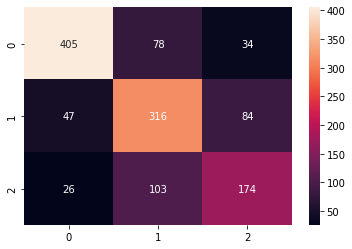

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_valid_trying = map(lambda x : map_dt[x], y_valid_test)
y_valid_trying = list(y_valid_trying)

y_preds_trying = map(lambda x : map_dt[x], y_preds_test)
y_preds_trying = list(y_preds_trying)

cm = confusion_matrix(y_valid_test, y_preds_test)

f = sns.heatmap(cm, annot=True, fmt='d')